# Cleaning

1. Check for duplicates
2. Normalize hate speech score

# 1. Setup

In [81]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as notebook_tqdm


# Load the dataset from the Hugging Face Hub
notebook_tqdm.tqdm.pandas()
dataset = load_dataset('ucberkeley-dlab/measuring-hate-speech')

# Convert the dataset to a pandas DataFrame
df_raw = dataset['train'].to_pandas()

In [82]:
TRAIN_RATIO = 0.8 # TODO: factor this out everywhere
TEST_RATIO = 0.2
HATE_SPEECH_THRESHOLD_UNNORMALIZED = 0.5
SUPPORTIVE_THRESHOLD_UNNORMALIZED = -1


In [83]:
df_raw.head()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


# 2. Filtering & EDA

Understanding:  
TODO: what do the emotion columns actually mean?  
TODO: what is "status"?  
TODO: what is "outfitms" and "infitms"  
TODO: what is "hypothesis"?
TODO: how, if at all, is the annotator characteristics accounted for in the hate speech score?

EDA:  
TODO: Check out platform distributions  
TODO: Sentiment methodology & distribution  
TODO: Make list of filtering actions for report  
TODO: Make distribtions of emotional dimensions (maybe also scatter grid)  
TODO: distribution of hate_speech_score  
  
Filtering:


### 2.0. Pre-filtering EDA

Total count: 135556
Supportive count: 53651 (39.58%)
Hate count: 49048 (36.18%)
Neutral count: 32857 (24.24%)


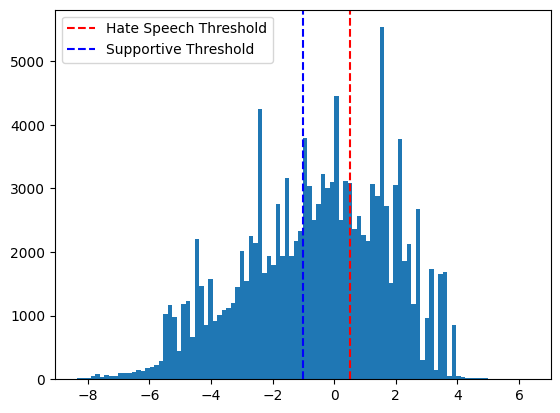

In [84]:
# Make a histogram of the hate_speech_score with annotated lines at the thresholds
def plot_hate_speech_score_histogram(df: pd.DataFrame, hate_threshold: float, supportive_threshold: float):
    """
    Plots a histogram of the hate_speech_score with annotated lines at the thresholds

    Args:
        df (pd.DataFrame): The dataframe to plot the histogram from
        hate_threshold (float): The threshold for hate speech
        supportive_threshold (float): The threshold for supportive speech

    Returns:
        None (plots the histogram)
    """

    total_count = df.shape[0]
    
    # Calculate the amount of values below the supportive threshold
    supportive_count = df[df['hate_speech_score'] < supportive_threshold].shape[0]

    # Calculate the amount of values above the hate threshold
    hate_count = df[df['hate_speech_score'] > hate_threshold].shape[0]

    # Calculate the amount of values between the thresholds
    neutral_count = df[(df['hate_speech_score'] >= supportive_threshold) & (df['hate_speech_score'] <= hate_threshold)].shape[0]

    print(f"Total count: {total_count}")
    print(f"Supportive count: {supportive_count} ({supportive_count / total_count * 100:.2f}%)")
    print(f"Hate count: {hate_count} ({hate_count / total_count * 100:.2f}%)")
    print(f"Neutral count: {neutral_count} ({neutral_count / total_count * 100:.2f}%)")

    # Plot in histogram as well
    plt.hist(df['hate_speech_score'], bins=100)
    plt.axvline(hate_threshold, color='red', linestyle='--', label='Hate Speech Threshold')
    plt.axvline(supportive_threshold, color='blue', linestyle='--', label='Supportive Threshold')
    plt.legend()
    plt.show()

plot_hate_speech_score_histogram(df_raw, HATE_SPEECH_THRESHOLD_UNNORMALIZED, SUPPORTIVE_THRESHOLD_UNNORMALIZED)

### 2.1. Filtering & reformating

In [85]:
# Check for duplicate rows based on the 'comment_id' column
duplicate_texts = df_raw[df_raw.duplicated(subset='comment_id', keep=False)]
print(f"Number of duplicate texts: {duplicate_texts.shape[0]}")
duplicate_texts[['comment_id', 'text']].head()

Number of duplicate texts: 125479


,comment_id,text
0,47777,Yes indeed. She sort of reminds me of the elde...
1,39773,The trans women reading this tweet right now i...
2,47101,Question: These 4 broads who criticize America...
3,43625,It is about time for all illegals to go back t...
4,12538,For starters bend over the one in pink and kic...


In [86]:
# Group by 'comment_id' and count unique 'hate_speech_score' values per group
score_check = df_raw.groupby("comment_id")["hate_speech_score"].nunique()

# Find texts with more than one unique score
inconsistent = score_check[score_check > 1]

# Show how many inconsistencies there are
print(f"Number of 'comment_id' entries with inconsistent scores: {len(inconsistent)}")

# Optionally, view a few examples
if not inconsistent.empty:
    print(df_raw[df_raw["comment_id"].isin(inconsistent.index)].sort_values("comment_id").head(10))

Number of 'comment_id' entries with inconsistent scores: 0


In [87]:
# Step 1: Select relevant columns
cols_to_keep = ['comment_id', 'text', 'hate_speech_score'] + [col for col in df_raw.columns if col.startswith('target_')]
df_relevant = df_raw[cols_to_keep].copy()

# Step 2: Convert booleans to integers for mean calculation
bool_cols = [col for col in df_relevant.columns if col.startswith('target_')]
df_relevant[bool_cols] = df_relevant[bool_cols].astype(int)

# Step 3: Group by 'comment_id' and 'text' to keep them in final output
filtered_df = df_relevant.groupby(['comment_id', 'text']).mean().reset_index()

In [88]:
min_score = filtered_df['hate_speech_score'].min()  # e.g., -8.34
max_score = filtered_df['hate_speech_score'].max()  # e.g., +6.3

# replace hate speech core column with normalized column - [0, 1]
filtered_df['hate_speech_score'] = (filtered_df['hate_speech_score'] - min_score) / (max_score - min_score)


In [89]:
# Normalize the thresholds given by the dataset authors
HATE_SPEECH_THRESHOLD_NORMALIZED = (0.5 - min_score) / (max_score - min_score)  
SUPPORTIVE_THRESHOLD_NORMALIZED = (-1 - min_score) / (max_score - min_score)

# Add binary columns for hate speech
filtered_df.insert(filtered_df.columns.get_loc('hate_speech_score') + 1, 'is_hate_speech', (filtered_df['hate_speech_score'] > HATE_SPEECH_THRESHOLD_NORMALIZED).astype(int))

# Print new normalized thresholds 
print(f"Threshold for hate speech: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} on the original scale")
print(f"Threshold for counter speech: {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {-1} on the original scale")
print(f"Between the two thresholds: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} and {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} and {-1} on the original scale which is the unambiguous region")


Threshold for hate speech: 0.604 -> Equivalent to 0.5 on the original scale
Threshold for counter speech: 0.501 -> Equivalent to -1 on the original scale
Between the two thresholds: 0.604 and 0.501 -> Equivalent to 0.5 and -1 on the original scale which is the unambiguous region


In [90]:
filtered_df.describe()

,comment_id,hate_speech_score,is_hate_speech,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
count,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,...,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000
mean,25064.175028,0.505197,0.261696,0.036070,0.127305,0.044341,0.057841,0.017678,0.014726,0.076865,...,0.001216,0.024744,0.002986,0.013872,0.006091,0.001186,0.001254,0.006339,0.002392,0.025676
std,14573.790336,0.141604,0.439563,0.161093,0.312461,0.177705,0.190456,0.110997,0.099712,0.238959,...,0.028330,0.137500,0.046627,0.105851,0.068472,0.029225,0.030446,0.068151,0.041602,0.146039
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12336.000000,0.410519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24986.000000,0.521858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37837.000000,0.608607,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50070.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 57 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   comment_id                             39565 non-null  int32  
 1   text                                   39565 non-null  object 
 2   hate_speech_score                      39565 non-null  float64
 3   is_hate_speech                         39565 non-null  int64  
 4   target_race_asian                      39565 non-null  float64
 5   target_race_black                      39565 non-null  float64
 6   target_race_latinx                     39565 non-null  float64
 7   target_race_middle_eastern             39565 non-null  float64
 8   target_race_native_american            39565 non-null  float64
 9   target_race_pacific_islander           39565 non-null  float64
 10  target_race_white                      39565 non-null  float64
 11  ta

### 2.2. Post-filtering EDA

Total count: 39565
Supportive count: 17475 (44.17%)
Hate count: 10354 (26.17%)
Neutral count: 11736 (29.66%)


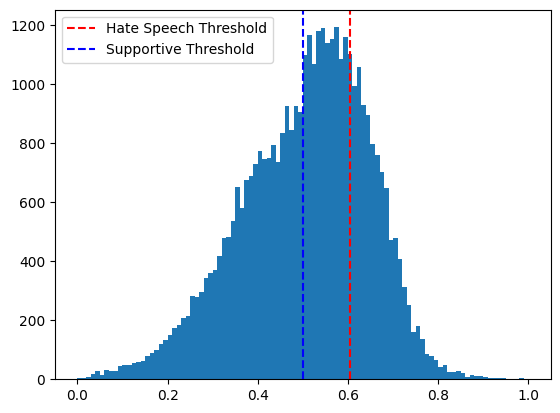

In [92]:
plot_hate_speech_score_histogram(filtered_df, HATE_SPEECH_THRESHOLD_NORMALIZED, SUPPORTIVE_THRESHOLD_NORMALIZED)

In [97]:
target_cols = [
    'target_race',
    'target_religion',
    'target_origin',
    'target_gender',
    'target_sexuality',
    'target_age',
    'target_disability',    
]



def plot_target_columns_distribution(df: pd.DataFrame, target_cols: list[str]):
    """
    Plots a barchart of the average value of the target columns for the hate speech observations

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distribution)
    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # Calculate the mean value of the target columns for the hate speech observations and sort them descending
    mean_values = hate_speech_df[target_cols].mean()
    mean_values = mean_values.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    mean_values.plot(kind='bar')
    plt.title('Percentage of hate speech columns targeting a specific group')
    plt.xlabel('Target Column')
    plt.ylabel('Percentage of hate speech')
    plt.show()

def plot_target_columns_detailed(df: pd.DataFrame, target_cols: list[str]):
    """
    Plots a bar chart for each of the target columns with detailed breakdowns of sub-groups

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distributions)
    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # For each of the target columns, make a list of means of of hate speach targeting its sub-groups
    for col in target_cols:
        # identify all columns in the dataframe that starts with the target column name
        sub_groups = [col for col in df.columns if col.startswith(col)]
        
        # calculate the mean values for each sub-group
        sub_group_means = hate_speech_df[sub_groups].mean()
        sub_group_means = sub_group_means.sort_values(ascending=False)

        # plot
        plt.figure(figsize=(10, 6))
        sub_group_means.plot(kind='bar')
        plt.title(f'Percentage of hate speech targeting a specific sub-group of {col}')
        plt.xlabel('Sub-group')
        plt.ylabel('Percentage of hate speech')
        plt.show()

plot_target_columns_detailed(filtered_df, target_cols)

plot_target_columns_distribution(filtered_df, target_cols)

TypeError: Could not convert ['First off you look cool as fuck! Anyway if we were in the bedroom I think I\'d cream your ass then make you suck my cock clean like a whore ;)Guranteed at least one of these guys has raped a woman before. Maybe all of them.They\'ll come back in your plan, also. Plus we pay to jail them for 2 years. With my plan, we jail them after they come back. And deport them again. It really doesn\'t matter either way until we\'re build the wall, and shoot the invaders as enemies when they cross the border.eat my fuck, bitchShe ugly anywaysit\'s such a shame that you\'re gonna probably marry a uglier nice guy, and turn his life into a dysfunctional hell-hole.The guys are one thing but then you have a woman there making one of the worst comments. I say rape them all with a cactus and say God willed itBuild the wall, and put these spics in prison with the nogs.OKAY, I\'LL LEAVE YOU FUCK YOURSELF LIKE A FUCKING DOG BARKING, BECAUSE I DON\'T GIVE A FUCK TO A FUCKING BITCH LIKE YOU! I HOPE YOUR DICK-FACE FALLS ON A PIECE OF CRAP, HAVE A CRAPPY DAY, JACKARSEYou hypocritical fuckers are opening up a can of worms that you will never be able to reclose. Here\'s hoping that the upcoming events lead to the destruction of the so-called "Christian right" and not the country.Joe Rogan...listen, dawg. That one time I had this Jamaican ho\' up like this when I snorted coke off her twat while she was on her period HAHAHAAH AHAHAHAHAHAHAH. I took a big shit inside her mouth and then I fucked it. Holy shit Joe Rogan you shoulda seen this, fuckin\' savages all over HAHAHAHHAH AHAHAHAH. *coughs* *can\'t catch his breath*She got pregnant 4 times with two different guys who were losers and aborted all 4 children She a slutGive me your tired, your poor, your religious nutcases, your criminals ... the wretched refuse of your teeming shore ... and finally allow Europe to be subjected to the moronic whims of this wretched refuse."Atheists kill their parents and family members, and if you don\'t get out of my house I\'m going to pour boiling water on you"Give me your tired, your poor, your religious nutcases, your criminals yearning to escape justice ... the wretched refuse of your teeming shore ... and finally allow European Civilisation to be led and controlled by this wretched refuse ... what could possibly go wrong?Aww that\'s too bad for you. I\'ll start with your ass, throat fuck you and then pound your pussy until I cum deep inside you. Are you on birth control, cunt?Anon is a betamale. Just cut them all off already. She isn\'t worth the effort.Someone just needs to pony up, and fuck one of these dudes forcibly in their ass. Ving Rhames style.Get ready to be flogged. India is ready to flog all cow dung eating shameless fucktardsYeah, holy shit. Seems like he gets pissed off if his tinder date won\'t fuck him 5 mins after showing up to his place. This guy wreaks of creep with a possible touch of incelKeep non citizens out and send them homeTypical stupid bimbo who has it all decides to be "edgy" does drugs and goes to rehab just to say she went... good job wasting your parents $ your mom shoulda swallowed.Fuck you\'ve got a fucking fat ass. All the better to slap against my waist while you\'re riding me, doing the only thing your worthless fat fuck holes are good for. You\'d just get filled with the entire contents of my balls and you\'d just be lying there with a cunt full of cum. I\'d get up and leave without even looking at you.jesus christ why do niggers always have to show up and ruin my day. Not only that, but this nigger ate all the crops while on the job, so now the tree branch cant support him. something needs to be done about stopping the gorillas from eating all the food away from us white men. disgustingBetter get 2 abortions for your spawn cause you\'re a dickunGive them back their land. Death to America.me and the boys firebombing Dresden in The Big NiggerI\'ll take the girl in the middle, I want to see that dark lipstick streaking down my cock.Keep fucking with our guns, we\'ll keep fucking with you whores wanting to murder babies.You know how women put so much effort into looking and smelling pretty, acting like they are the epitome of clean? Yeah, due to the effort they put out to maintain that facade they have no leftover energy for shitting like a normal person, cleaning off their sink top, or cleaning the garbage out of their cars.Men built this country while girls sat on there ass and and made babies now it\'s time for us Deep South motherfuckers to take over also kill anyone who gives or gets an abortionI just bodied your fat mother. Cum all over that bitches face.Unload the clip in that clown ass niggaThese fucking whores let men bust in them knowing full well they\'re gonna do the abortion routine. May God have mercy on themSuck a dick fagSure it is legbeard. Just kill the baby before it has a heartbeat and everything is cool. Or are thots too stupid to take a morning after pill to you?true, she probably will get a slap on the hand and a head nod from the simped judge and grants her the pussy pass so she can go and whine about the male privilege.The only "ho" here is you. You are a disgusting piece of shit and you WILL die cold and aloneWhich is the restroom for women with penises?Fuck her again!They are..... Freaking sluts and baby murdering slut fuckersfuck mohammedans. and fuck their feelings.Have fun giving birth to a baby that someone impregnated you by raping youHopefully by the end of her world tour she is found dead in a ditch after being brutally raped by a sand nigger.Shut up you little bitch. I\'ll fuck youHur dur keep your damn legs closed, whore And then that\'s how you prevent incest, rape, unwanted pregnancies, STDs, and miscarriages.I will personally rape your motherA. He\'s very stupid, vile, and evil.  B. He\'s extremely gay.  C. He\'s very stupid, vile and evil and extremely gay.  D. Mother beats him with a broom stick.what? what\'s with the sexual stuff? thought she was just annoying and retarded!We need to make angry faced "Aborted chad" and he\'s yelling  *"Don\'t fukken kid urself bro be glad I wasn\'t born I\'d be fukken her right now loser"* *"Sorry I\'m not there to kick your ass you fuckn dweeb damn get a life"* *"Bro r u stupid ur a virgin cuz ur lookin at memes all day and jerkn it to wow tiddies"* *"Bro stop crying it\'s not a good look girls like a confident dude aw man come on for real"*Well she\'s a narcissistic cunt so this is to be expectedAgain here I a remminding everyone about a story called Adam and eve, eve fucked up then dragged Adam into the bullshit, first recorded fuck up by a woman that ultimately tesulted in our downfall. Yes sir.Yes you\'re an asshole for telling a girl that you\'re not going to hook up with her because you find her entire race and 3 billion people unattractive.All these crazy religious fuckheads trying to shut down abortion are like apes trying to destroy fire because it burns to the touchSorry, I can\'t hear you over the sounds of the mexicans im slaughreringI wish I could be in that room as they take turns pumping her full of their superior seed. And I could just see them laughing at me as I spill my pitiful cum to watching the future of my race.I fucking HATE americans. I hope your country BURNS.Oh god I didn\'t realize we had so many celibate infidels within this subreddit. We need to act quick and purge these lower life forms from our societyI wanna beat your bovine grass grazing face just because you shave your legs faggotGo Shit in your own mouth incelWhat\'s misspelled Faggot?Femi-nazis should be put in a concentration camp, they are regressing the progression the world with their retarded idealsNo you are the dumb cunt he said "I fucked her up mentally"kill yourself you fucking idiot cuntSo basically you want someone to come to you and let you best them. You are a Faggot AND a pussySend the fuckers back across the borderFuck those Saudi ratsI\'m an atheist, you brainwashed identity politics playing faggot. Go kill babies, shit head.I hope you never have suicidal thoughts you fucking worthless bitch.Small dick, Therefore Dexfag.I don\'t know I pretty much hate half of my fellow Americans well enough to wish they\'d fuck off to found their own regressive fundamentalist Christian caliphate.What about a fat ugly hambeast? .... Nevermind, some random loser with a fat fetish would probably support her.I\'d drill her balls deep, I guess she can handle that? 👅> Don\'t say nigger under any circumstances! It\'s offensive, you fucking autistic retard! You\'re not woke, you\'re broke.Present yourself with all your holes stuffed you dumb cum slut!Out of context, LMAO, imagine actually resorting to that one in 2019. Speaking of the religion of peace, that website puts things in context and links directly to the Quran. That\'s alright though, a religion that promotes inbreeding is obviously going to produce people like yourself.Black and thirty? I\'m surprised he wasn\'t hung by the KKK yetfags must be the only lifeform on earth that never reproduce but also never go extinctThis girl is fucking retarded.Fuck off you nazi cunt. Die in a fire.almost like most trannies are utter failures at being men and choose to take the easy road of being a woman in current yearI Will fuck you up! I Will ram my cock in your ASS you Gay!!! Hahahahah Im The swansdriver Im no Gay or bitch!!!Clean your dirty slut mouth and then come suck my big fat cock-karma hunting tiny dicked little bitchAll day every day. Calling everyone that gets an abortion stupid, a whore, worthless, a baby killer, a sinner, all that fun shitIf she\'s telling the truth about being raped when she was younger (I don\'t believe it) then it\'s proof that black guys will literally fuck anything.Nor I you, you\'re putrid. You\'re another white knob thinking you\'re virtuous while you shame people from different cultures. You\'re in luck, Reddit loves that, builds up the \'ol ego - if there\'s one thing Reddit\'s taught me, it\'s the intolerance of the supposed tolerant. You\'re not new, you\'re commonplace. Dealt with racist shits like you since birth. I\'m all gd.I couldn\'t fuck either of you because I\'m not a very good swimmer. After 5 minutes of your dried up, sad and soggy tube sock of a cock wallet, I\'d be drowning in STDs.How about you suck my dick you fucking degenerateWho CARES you fucking faggot. Oh no, faggot is a slerrStarted off the fight with a sucker punch. What a faggot cunt.Stupid fucking cunt. I hope your mother dies in crippling agony.YOUR MOTHER WAS A DUMP WHORE WITH A FAT ARSEEvery night on the news they counted the days our Americans were held hostage - 444 days. Fuck the mullahs. MOAB the mullahs.Alright listen up ladies. You start all cute and cuddly, then you pull out the black 30 inch black anus destroyer and go to town on him. I promise the law will change pretty quicklyYou look like the type of woman who enjoys rape fantasies "Please sex murder me"100% this guy is an incel who, deep down, feels his only way to reproduce would be to rape someone.Lmao, I think our situation is much better than yours, where your people fuck your own baby girl cousins, kill any "kaffirs" on the street, and blow up both your own people and those in the rest of the world! With such a barbaric track record, your will surely get your 72 virgins in paradise!Why are you such degenerate fucks?MemeriTV: "The US is a filthy whore dog of Israel!"Fuck you E-Boulder, nice podcast you fat faggot.Joe Cumia is a faggot and a coward, just like his brother and just like his father. Bunch of limpdicks.BOYCOTT ALL GAMER GIRLS. We dont need them fellas. Im telling you! You havent seen a true bitch until youve played Ark and met a gamer girl on there.Maybe men should keep their nasty dicks in their fucking pants then, fucking whores.Hey Petie, kill yourself 😎 \u200b EDIT: Lol @ all the SJWs downvoting me. It\'s just gamer talk, stop being so offended 😎😎😎 EDIT2: LOL, Triggered Much!?! Keep downvoting you cucks! 😎😎😎😎😎 EDIT3: fuck you guys fuck you all i have reported each and everyone of you for hate crimes and the police will arrest you all you stupidsThere is only 2 genders and transvestites have an mental condition.Chivalry is for cucks  Maybe in a day and age where you got something for it  But women are addled with feminist entitlement, slutiness, victim complex, and a complete lack of gratitude No chivalry for these little miss independents. Why the fuck would anyone bother?Nuke the border area, Nuke Algeria, Nuke Morocco, Nuke the UNYou\'re just going to end up replacing blacks with mexicans and they don\'t even speak fucking english. They\'re catholic and they shit out litters regularly. I like my neighborhood gangs shooting each other like civilized human beings not hacking people to death with machetes.She looks like a jewish girl about to be exterminated in a concentration campYou\'re a retard too so what\'s one retard replaced with anotherI\'d honestly have a tiny bit of time for you shitty people if you this was about anything but controlling women..but it\'s not. At best you are \'pro-birth\' - you *actively* work against healthcare for new mums and you rather see a woman try to mutilate herself or locked up just because you have this bizarre belief that a foetus under 18 weeks is some kind of sentient fully aware human. Its a shame you weren\'t just a miscarriage, the world would be a better place for it.This sub is going to shit. Just because someone\'s name is Chad doesn\'t make it a worthy post. Nothing here about tendies. Fuck you OP. I\'m going to hunt, fuck and kill your mommy. You just lost all of your GBP for this fucking shitpost. You should be banned. FaggotDindu nothingI\'d bend you over and fuck you until cum leaks down your assInbred, racist assholes.Slippery slimey sodomites scare shitty straights so to spawn stupid sketches of spiteful small-mindedness.Oh look at the retarded one who should have been aborted.If you wanna stoop low I\'ll stoop low. Suck my sweaty cock n balls you stupid twinkShe\'s a piece of human garbage, just like the guy.Good girl! That\'s just how I want you to lick Mommy\'s pussy. If you keep it up, I\'m going to cum on you.Your fucking grotesque you hideous slut. How do you even have the confidence to drag that chernobyl gaunt ass frame out of bed in the morning. It looks like you\'ve headbutted a foundation pad and your favourite past time is sucking dicks in the gutter. If I could throw acid or boiling water in your face I would. I bet you craw like a fucking crow.Words don\'t hurt her but cramming her penis into that thong everyday sure does.They should call u ugly retard fagBurn their fucking church down!To answer OP\'s question, phony ass SJW shills like these three, pretending like transgender people are normal. That makes me cringe.Strip her naked, tie her ankles together behind her head and tie each of her wrists hooks in the ceiling so that her shoulders are lifted off the ground. Then spread her pussyhole open with a speculum and spray it full of pepper spray then fuck her in the ass as hard as I couldFuck off, I\'ll read my own bible stories, butch.Lmfao your "girl" is a disgusting cow you fucking inbred trailer trashKILL WHITEYThat bitch epitomizes trashWhat a dumb cunt. I wish we could create their retard society and send them all there to live together and watch them.Ship that raghead back to the shit hole it came from.Because you\'re an incel Nazi, fuck you.Definitely.. beta boys only get to cum in a tissue or in their hands to lick it upI like that he can\'t even be honest with complete strangers. All hours of the day, this pathetic faggot is propagating misinformation to make himself look better. He always talks about mental illness when he\'s clearly suffering from narcissistic personality disorder"Don\'t like leaving children to foster care? Just kill them. Like you kill children inside the woman\'s womb."Mein to india mein hoon nahin. I hardly even care how deep the country fucks itself.I\'ve been aching for a slutty thing to have fun with. I love to talk dirty and would be wonderful if someone was around that could keep up with me. I like to pull hair, choke, spank, gag, fuck a mouth and ass, trade pics, watch each other cum, fuck in public, sneak off and have a quick fuck before coming home, stop in where you work and fuck in the bathroom on your lunch.My mistake. Youre also an absolute cunt Say Im bilingual before I come to the US to fuck your mom in front of your eyesNO U. FITE ME BIOITCH = succ my balls because I am gay and want to have sexual relations with no condom while I spread my AIDs everywere I go, in russian.Fuck off yourself, fag.I would land in Canada, offer them infinite bagged milk if they defeat the USA. Then they would gang up on some small African tribes, 3 months of break time, then gang bang Mexico and Japan. Let Japan and Africa scramble the Koreas and China, while the USA and Mexico deal with the rest of Africa, then after China and South Korea are with us, destroy some Arabian countries. 10 months of training and building equipment. We battle Europe. After we got them, aisa. North Korea and Russia are last. Then we break hell loose. Tell them to just go all out on the remaining countries.Suck my girl dick you ass bitchYou\'re also mentally retardedShouldn\'t be having children anyway. Darwinism.That\'s pretty gay of them.What do you call a female incel? Maybe DID or dyke in denial.Lmao this bitch doesn\'t play runescape. She looks like a professional prostitute that claims to be from my area looking for a good fuck.When you contry is so shitty that even refugees don\'t want comeSpank your ass and fill your slutty pussy up with my cumStop fucking them in the pussy. Anal or no dick. That should be our counter protest.How about "actual retard"imagine sucking my dick and feeling my cum shoot down your throat you piece of garbageReading your post u seem more like a wetback lolIf she give birth I\'ll going to kick her in the clit.This shit needs to end. Honestly these countries cause an insane amount of problems worldwide with their extreme religious bullshit. Bunch of animals.Good. Goodbye ghetto ass kids and their lowlife parents.Acid attacks, honour killings, FGM, breast ironings, forced marriages - this shit ain\'t nothin\' new. Close the fucking borders already.more evidence that israelis are the scum of the earth.I\'m glad you guys split up that women is stupidthere\'s a lot of racist dickheads on redditThese assholes should be tried and executed if they try this shit in the USA.You deserve to be used as nothing more than a toy for my big cock and if you talk back  I\'m gonna spit in your stupid whore mouth.Fuck off ya baby sacrificin satanistsShe\'s not a girl she\'s a fucking whale. Glad to see her get harpooned.Hopefully the next school shooter shoots up the faggot inventor of these instead. Fucking shitgineers.One\'s gay the other\'s autistic. \u200b It\'s what fags learn to do vs autistsI wont believe she really is a woke feminist until there us a midget xer behind her with xer dick in her ass.Nice udders slut ... what about those fuck holes ?... coz whore like you is only worth her holes hereLol they would be beaten up if they showed up in Palestine.She\'s disgusting. I\'d let her suck my cock.How bout u go get fucked?He\'s about to hang himself for this gay postUgh. Americans make my skin crawl.Can\'t stand all these beta males. Too sissy to suck on a dick like a real man.That\'s not edgy u little fragile cock slurpIf these inbreds spent less time fucking their sisters they could learn to moderate expectations and hold their disgusting beef eating tongues.You\'re a garbage human being with no understanding of what this country stands for or it\'s goal since it\'s inception. YOU should be given the citizenship test and when you undoubtedly fail, deported to the brownest country and left to rot.Thank god I don\'t live there, I would already be in jail from opening the skulls of these cowards.Stupid fucking sluts can\'t even count anymore. You have 3 rape holes, not 2 dumb shit.Fuck all you faggots then. I still got in the building with no help from you faggots. I\'m in ALL Yankee shit my niggas.I\'ve heard from some other sources, he\'s also a huge faggot.Tell me about it I just unsubbed from r/blackpeople twitter for calling them a bunch of niggers smh #justiceforgamersThe Moslems you lefties idolise literally are putting us in concentration camps in Chechyna, stoning us to death in Saudi, and throwing us off tall buildings in Iraq/Syria etc.Man these stupid thots never learnYou worthless piece of shit! Get on your knees so I can drag you into the toilet and punish those little aching holes slut!Shoot yourself in the pussy!see this is why aliens wont come here well just call them weird and enslave them or kill them allWell I\'d have to try out your hole first before I ruin it. Loosen you out a bit with my cock. But then maybe I\'d force a bat into your cunt. Pound it into you and leave you gapping so much I\'d have to push my fist inside and jack myself off if I wanted to cum using you##Who cares? ##Protect yourself with a Rifle and let them transgender themselves to death.You are just Another retarded white boy ready to shoot up a school smh you are such trash.... please go to your closet and make a noose and kill yourself your fuckin trashFraternity rapers.I can\'t take a person seriously who goes on Reddit calling people cunts, white, virgins, fat fucks and acting like an Internet tough guy.  If you all want a laugh, look at how tough this guys comment history is hahahahahahahah Watch out, he might want to see you in real life and stomp you outThe last thing this bitch needs is roastSomeone needs to break that cunt in. A hairy pussy like that should be left gapping and dripping cum.What a LARPing faggot. You cracked your knuckles and then fisted your own asshole.Thats funny, you sure love Saudi Arabia, the makers of 9/11. Plus, your own war machine is pretty much the biggest terrorist organization in the world. You\'re about to start another pointless war to steal more oil from the Middle East. You deserve to be nuked.Private school douche bag who never really stopped \'experimenting\' with dick suckingStop being a bunch of fags and crawl out of your mother womb for once because this is r/banned and anyone can say messed up shit.Wtf is wrong with you cunt bag? Did mommy not change your diapers?What a bitch you are you absolute scum of a human troll. I would save any unborn child over you any day of the year.You are a dirty nigger with no business being on the internet.>Lol fuck veterans. I\'m with you!  Fuck these faggots who kicked Hitler\'s ass back to Germany! Stupid-ass Veterans! We coulda had a Third Reich! 😭😭😭This bitch has amazing cock sucking lipsSuck my dick and balls loserGood, I\'d drag my cock over your face just to remind you that you will always be a whore to men, then I\'d fuck your little asshole just so you remember it.Throw their asses out, they\'re niggers! THEY\'RE NIGGERS! THEY\'RE NIGGERS! NIGGERS!No Canadians wtf... you racist fuck go die in a hole... stupid bitchFor y\'all that are gay retards this is jokeShe was a whore who craved multiple cocks in her cunt. plain and simple.I think the synopsis is evil white people who can\'t stop fucking their relatives, but thats all I know.She looks like the kind of person that lets her man go fuck other chicks because she\'s not good enough in beddid the mean soldiers come and take your mommy away? and fuck her good, like the little slut she is, could you hear how much she *loved* it, sneaking peeks from behind your own hands from the corner in the kitchen as they railed her on the countertop, bet you cant get off to anything but liveleak rape videos now like a broken beta cuck> oi guv you got a loicense for that.... > oh i\'m so sorry mr. muhammad, please do whatever you like Damn Musselmen and their *shuffles deck* assembly permits!"Go fuck yourself." If the Abrahamic God is the one we\'re talking about, he\'s a goddamn cunt."Please, stop oppressing me" I say to the Palestinian child tied to the front of my APC.dirty fucking slutHave you tried telling the button to stop being a faggot and come out?pussy bitches.White boys should only masturbate to superior Black cock; only our Black masters should be able to fuck white women. It\'s the future, fellow tiny dicked white boys; let\'s just hope that we are still going to be allowed to clean up after Black cum...Yea, forget that a girl can poke a hole in a condom and lie about being on the pill and all that bull shit. Even if they both agree that they want an abortion the father has no say. A women can give birth to another mans child and have the man take care of it for years and the women would suffer no consequences.  I read a headline last week, a woman stole sperm from a blowjob, got herself pregnant and sued the guy for child support. If that doesnt sound way worse than this BS than idk wtf yall think Male privilege is. Chief this ain\'t it Lmao prob edit later cuz phone diehey suck my dick you fucking cuntKill whitey!unironic incel parties will start to form. no more haremization. ONE MAN ONE WIFE. no taxation WITHOUT sexual representation.Eat dicks with your "Chiraq" nonsense.Your hair looks like you stuck a Q tip up your own asshole, fucked yourself a bit, and wore it as a wig.I\'ll leave as soon as I\'m done plugging your mother in the ass.shut up retard, go kill yourselfYour husband is a fagSuch a fucking lie. You\'re either an Islamic terrorist or or a moron.Men: Fuck off you stupid cunts.The Romans had animals rape women to death, while the spectators cheeredWhat the fuck is wrong with people. I hope every one of those people have stillborn children.Its un fucking canny how the murder of Irani\'s aid didn\'t make it to his twitter status. What a faggot.No thank you?? Are you fucking gay? Get the fuck out of here you stupid fuck.Oh so you\'ve seen our videos and still calling me fat lmao I know bitches like you. So fucking ugly nobody wants you. So fucking pathetic you can\'t get a date unless you spread your legs. You have the personality of a cum ragSays the unemployed basement dweller who spends his time obsessing over why women won\'t fuck him because of how small he thinks his wrist/ankles/penis are.Fuck that dildo... not only is it bigger than me but it can also fix cars too... I\'m never gonna get a girl.If you punch yourself in the dick for every woman you let down you would have some nice jam to smear on that fucking pancake of a face you have.Fucking faggot band name, with songs that are even more faggoty.If you know this then you may be a fuck girl too.  Don\'t be a cum dumpster to assholes lol. Let a better guy dump his cum in your ass. Aka - yeaaaaa you have a problem, but you may be part of it.Who cares what her tits look like if i stick it in her south pole.go suck a dick u shit stainIdiots were told to wear a goatskin condom when having sex, not a ***goat***! Ignorant losers.Uhh, no your work is not respected. Are you some sort of Evangelical? Fuck off with this bullshit that Israelis even need any help. They are the biggest terrorist group known to man. Why didn\'t you volunteer in Palestine? Where people are actually getting killed on their own land? Essentially what you are doing is actually helping those who stand for an apartheid, baby killing and genocide. Your are not respected and I (an educated person) will not fall for the Israelis as being helpless victims of anything when they juice about billions of dollars from the U.S.Get the fuck out of here you pussy ass bitch go suck your moms dick you faggotWomen like this need to be jailed and fined and locked up and sterilized with all their possessions taken away and trashed and their bank accounts emptied.A little fuckin gay shit trash headSomehow our ancestors managed to figure out people\'s sexes, without the need for capitalist props to demonstrate it. If you\'ve not inherited this trait, you deserve to be removed from the gene pool.Just come suck my dick so I can cum on your face and leave you to clean up the mess.I\'d probably throw you down onto the bed and start teasing your pussy with my cock until I finally shove it into your pretty pussy and fuck you till your screamingLook at you pushing your arms together trying to get them to look less ugly. It\'s not working you dumb slut. Those tits are probably hanging so far away from each other you could fit 10 thick cocks between them. Bet you\'d like that. I would stuck it in there too just to get it hard so I can go fuck a proper woman, while you stay in your bedroom rubbing your pathetic little cunt and you ugly tits with tears running down your face, like the sad cumdump you are.If DNA accounted for all of intelligence the dumb sluts would\'ve won out a millennia ago. Fortunately stupidity is mostly a taught behaviour and these types tend to not stick around.That\'s nice.  Beggar praying for salvation of the world. He vandalizes the temple business area because rich rabbis are profiting by fooling the gullible masses. They hold secret meetings.  Get that beggar crucified at the hands of Romans. That beggar transforms into the only begotten son of your god Yhwh.  I will proclaim the LORD\'s decree: He said to me, "You are my son; today I have become your father.  URL Hollywood producers threaten to ostracize you then get you arrested then spread decades spreading lies against you, such as they did with MJ and whomsoever speaketh against them.In comes angry old fat chick to tell other chicks to do shit that will make them as unhappy as she is. >holy fuck i cant believe as people mature their interests change. He so bad for u. U should be single girl! Come sell essential oils with me. We can be depressed single fat women together!! This sub in a nutshell.Sexual relationships yes. Romantic no. They better not make them too much like real women. The fact that real women have become so insufferable is the whole reason for sexbots. Why recreate the same thing. As long as they look great and you can switch them off whenever you want, I\'m in. If you have to deal with their neurosis as well then I\'m outOkay listen here retard, this isn\\`t funny.... THIS IS CYBERBULLYING YOU FAT FUCKING RETARD, GO DIE YOU FUCKING BAFOON RETARD SHITFACEI want to slap that tongue with my hard dick a few times before I fuck the hell out of your mouth and cum all over your face while you beg for it like the slut you arei only fuck the girls with alzheimer\'s in the care home so they can\'t remember the next morningWow, what an absolute fucking cunt of a human. Hope she pisses blood for the rest of her lifePathetic, it\'s time we start erasing people like this from our gene pool.this bot is fukkin gay, I know cuz I typed "faggotniggersuckmycockyougayfukkincunt" and it said it\'s not a slur.  ...Racist.What do you expect from tranny extremists?  There double crazy.Well, if it exists, that bitch is probably burning in hell by now. Let\'s face it, she was probably a cunt in multiple areas of lifeThat happens when you\'ve been riding the cock carousel for so long that you\'re not gonna be able to make a connection with another human being... from this thots those abuser mothersCertainly not Israel — a brutal, kleptocratic, racist ethnocarcy.no and go fuck yourself just to be extrra sure, niggerWeak cuntwell obviously women are brainless submissive incapable of thinking for themselves, and not human beings with thoughts and feelings.Well at least they said "Raped" instead of "Forced herself upon". But yeah I hope this woman goes to hell along with her satan\'s cock gurgling husbandReligion of piss. Fuck Islam.Rape that bitch and her children she knows niggaI\'d tie her to the bed and fuck her at my own free will cumming deep in her cuntr/penispoopsex shit piece of shit nigger fucker,Lol fucking suck his cock in the stationary closet and start the relationship already.i dont pay attention to all that stuff but i do know niggers suckRoots? All of your family are stupid fat white redneck trash. You sweaty fat neckbearded virgin cunt. Hopefully your family die in an accident, not you, just your family. You fucking gimp lolI would love to beat the shit out of a pussy like your sisters boyfriend. Course I\'d probably bang your sister afterwards.Listen buddy, the fact that you went ahead and chopped up your child\'s penis is fucked up enough.      But going around defending your actions and encouraging others to do it is beyond wrong.    People like you should be jailed.Nigger get back to washerPeople like this need to literally be castrated.I\'m all for equality. So fuck black people. And fuck hispanic people. And fuck muslims too. And asians. And indians. And jews for that matter, fuck them. And fuck this fat fuck in particular.Those fucking homophobes needs to be burned in ashesYou should accept that your ass should be a pussy cum dumpster for real menFuck Islam we should actually fight itfuck you and fuck the muslim cult.Cause they\'ve gotta breed more morons, even if they need to get a little rapey to do itLick her face, spit roast her, pull her hair behind and fuck her mouth. Spread her legs, choke her while breeding her after pounding her little cunt.Yeah, we should just kill everyone below a certain IQ.Nah, the saudis are murderous Neanderthals, they wouldn\'t understand anything...Meh - they are failed gays that want a shot at gettin straight guys cos they are fukt in the head!She\'s need someone who beat her fatty ass , turtle face ass bitch lolFucking whore you probably have AIDS now Poor broke bitchgood slut making your wet warm hole available for cock filling. you need to post more regularly, whore.It\'s California, let them thin out their own population for a bit.you should shut the fuck up with your agendas. niggerKeith accidentally let it slip that ant fucked that thing. Your brother is not only a pedo but a faggot too.Fuck off gay bitchRepost AND retarded... Good job, you autistic fuck!Agree. Calling her a cunt and whore. That shit is degrading and disgusting. She\'s only 22 ffs. Assholes.There\'s an abundance of cowardly armed assault, bum rushing, mayhem and attempted murder from the left. The fact you limp wristed faggots don\'t have what it takes to get the job done doesn\'t exactly make you look better. But sure, go ahead and stick your dick into the hornets nest. See how that works out.Probably because of shitty rapists using GHB to attack women"kill your shitty child"Rofl get some help bro, or better yet get some shock therapy or some 12 gauge to the brain therapy for your mentally ill ass 🤣Or lets do and eradicate the japanese once and for all.I bet you can go fuck yourself cuntFuck you ..you bestiality loving cunttoo many fags on this sub wtf"Your mother was a whore with a fat ass"You think you\'re tough but in real life I\'d smack you across the face with a piece of dogshit and you wouldn\'t do shit but stand there like the fag that you\'re momma raised.Oil her up and fuck her tits and cum in her face and hairMe, at work: *drops box and bends down to pick up the box* Incels: "look at that whore. She clearly dropped the box on purpose so she had an excuse to show off her whore ass. I bet she\'s thinking about anal sex right now. Bending over like a slut so some chad will come over and ram his dick into her tight asshole and go to fucking town and ruin her. Ugh, how disgusting. I mean I totally would too if I were a chad but I wouldn\'t enjoy it with such a slut like this!" What I\'m actually thinking: "Only two more hours until I go home and take a nap."You\'re literally from Turkey, my man. How many genocides have you guys hidden?None because hes a faggotYou can\'t tell me what I mean when I say something, faggot.Saudi Arabia needs to be punch in the nose and learn to stay in its place!Yeah man/gal. That sub and TheBluePill can suck eachother\'s penisWho are these 95 cuckolds who upvoted this! Can only imagine an attack by r/Feminism on this subI have Aspergers and you\'re more retarded than I am. Drown yourself.Says the faggot that\'s never been punched in the mouth.You will go wa wa wa when allah punishes you for your impotence you deranged man pigThat bitch is responsible for the deaths of American citizens. She should be in Guantanamo along with the fucking Kenyan.fucking lying cunts. every one of them should be treated like an enemy combatant and killed on the spot, everywhere, forever. they wanna believe that shit, fucking die. you don\'t see christians out murdering people for their cause. you don\'t see jews out murdering people for their cause. you don\'t see anyone but muslims doing it. they\'re a vile, inbred, hateful and deceitful race/religion and not one of them should live within our borders, ever.You live in a vagina, that makes sense since you are a lil baby bitch lmao you know those screams you hear from upstairs and think it\'s just the tv? It\'s just me fucking your sister and moms brains outWhat\'s up little buddy do you need a lollipop you little retard you. Go clean your room and draw some swastikas. Also do you fuck your cousin or is that your sister you have the hots for.  Have a horrible day you little retard you.lol stupid idiot doesnt know the different between a vagina and uterus, typical.  btw, u sound like u just finished eating out ur mothers gangrenous gaping putrid stinky fartsome asshole in which all the arabs cum, and now u barfed it on ur keyboard broThese fucking brainlets need gassedYeah modern kids especially brown kids would be under the jail pulling this shit.Asia bibi wasnt convicted,she was found guilty by the court you fucking dumbfuck.If you don\'t know the difference keep your shit im your disgusting mouth you ugly cunt.I tHiNk ThE pC fAgS sHoUlD aLl DiEExplains why you\'re a fucking incel, go suck a cock you pathetic mismatch of genetics.It\'s called defending yourself you fucking dumbass. Don\'t you mean this bitch dumbass. Yea fuck youShe is just a dumb cunt street whore in fancy clothes and makeup. Nothing about that rapist is worth anythingYour mom should have swallowed you before you go on your killing spree you worthless waste of man slime. Guns only have on purpose, but your too stupid of a hick to figure out realityI mean, get a line of asian cunts all face Don ass up and you could make a picket fence of fucking.honestly i\'m pro human rights as much as the next guy but incels should just be fucking shot.Jesus H. Christ this guy needs to be castrated.Go fuck yourself you mormon bitchSo stop writing books in your moms basement and do it faggot!fag ass gay assI came here to troll but to be completely honest with you Israel and Palestine are both trash states with a huge repertoire of warcrimes and crimes against humanity and it\'s frankly disgusting what they do to eachother over there> Think of all the oil  World peace increases 600%. We would have to deport the geese to Russia.That guy already looks like the biggest faggot of the weekThese fuckers want a quick fix to heaven, they think they have sinned all their lives and by doing these disgusting acts they will be forgiven but if their is a just God they will be punished in that heaven too.Stop being a fucking cuck. "Fuck Chechnya" justifies killing 1/5 of the population? Fuck Russia, filthy warmongering scum.Fuck you. You\'re either a troll or you\'re vile. Your racism is not wanted here. Go on Telegram and find some white nationalist dickheads to post shit like this to.I heard your mother fucks goats 🐐This is the exact kind of whore I\'d expect to find in a cheesecake factory bathroom. Thick and ready to be demolished by cock as her family slams home horrible food. You go back to the table and leak cum onto the booth as you wonder if the bruising on your neck and fat tits will show up before dessert doesYou\'re reading the verses wrong, and also I\'ve interacted with you enough over the past few months to know that you\'re a raging homophobe and not worth my time.Tear it down. Death to MEGA white trash assholes! I\'m old, white, and wealthy. I\'ll continue to work against the white Nazi trash everywhere!That take them to somewhere in the mountains of China to teach them the pain of real deprivation... No tendies no vidya and the lolis will shoot youfucking women always being pieces of shitI\'d dump a load in you and then dry my dirty cock off with a fist full of your hair. You\'re a cum rag.I hate fags. Especially second hand fags. And fag butts are all over the streets.y\'all qaeda should be dumped in guantanamo if that\'s what your govt does to brown peeps>"She a hoe!" >*Couple hours later* >"Oh my god why are people so mean!? You are literally nazis!" >*Half hour later brag about pretending to be a woman to own the libs on T_D when you get banned* You sure showed them!So fuck off retard. Why even make this post u dumb fucking faggot.I\'d write that on your fucking forehead so everyone can see what a skank you are. You\'d just expose your holes to anyone who wants like a cheap whore. You\'re disgusting. I\'d put your head in the toilet while I fuck you so I don\'t have to look at you.Dumbass whore.Fuck you, you autistic child, your face looks like one that needs to be punched, can you even see when you pretend to smileyeah daddy issues means finding mean 2x your age attractive. plus, you\'re a home wrecking whore whose step-kids hate you so, who cares about your mental health now because it\'s about to get MUCH worse, especially after he divorces you for the next teen brideYou ain\'t finna do shit dumb faggothate that liberal cunt. She needs to get raped on air.you one gay ass nigga. You make me wanna puke and then suffocate on it!What a fucking niggerHe\'s just a lonely incel who dreams of wife beating and owning slaves.Your name may just be the biggest juxtaposition in history. Bitch, get your white ass off your mom\'s fucking couch and get a goddamn life. "You seem mad" what are you a psychological analyst? Get your psychopath ass back to work on scrubbing the toilets at Burger King.Or drop a nuke. Fucking American know-it-alls.And go through the trouble of dealing with your disgusting fat dead ass? Nah bitch nobody would wanna touch thatYou are the single most alienated and decadent iteration of "western culture" since the 2nd century roman empire. Go ahead, repeat history, call it "progress" and just fucking vanish. You braindead clueless fucks.Eat an ass you sensitive fat white bitch.Bottom bitches should get locked up in a cock cage!! You aren\'t gonna need it anyways!! Now let\'s get started!!Put a fucking knife up your ass you fucking dumbassI\'d treat you like the dumb blonde bitch you are. Deepthroat until you puke and ass to mouth until your asshole bleeds. Looking innocent makes it worst you trashy whore. Draining my balls while being slapped in your ugly ass face is all you can hope for.He\'s still a dirty fucking kike. He was just talking shit about Steve C and Patrice, I sincerely hope he dies.- Fuck your ancestors - Do you know your mother has died? - Idiot American, (your) entire family has cancer - Idiot white pig - Go eat your mother\'s shit, you incestuous dog - Talk shit - You are very good at finding isn\'t it - Go find more at let me hear them - Let\'s see how fucking good you are at finding !translatedSome all time bits by calling the chinese pigs in the middle of a paid readEveryone in that crowd should be sterilized. They\'re so fucking stupidI bet you boof Tabasco covered bowling balls, you ginger inbred cuntHoly fuck! Bringing back the term "faggot" rather spectacularly aren\'t you?She is a natural worthless whore, she just started and soon will post a pic of her cheap slutty pussy .. right god spit??These degenerate cunts do not represent half of the population.Look at this faggot.Fuck the Jews amirite? At least he tried to make Europe better. What have you done?All good sluts know they need to keep their cunts clean and ready for use. Spread it open for us, use both hands and put some effort into it like the good little slut you are.yeah fuck that stupid whoreUr wife looks like a fat fucking retardDon\'t talk to me, rapist trashJews are fucking Ari? They have been fucking the rest of us for yearsOnly annoying ass girls fishing for attention post dumb shit like this so they can have their inbox flood with messagesshut the fuck up summerfagKill whitey"Abortion is murder" yeah abortions also keep retards like this from fucking over humanity. Honestly the dad shouldve gotten himself tested before shooting loads into his cunt\'s cunt.Go back to China, bitch.What a little faggot, not shocking to see why considering his dad has less than zero spineTo zero attractive women in positions of power?  Show me oneNew dick is serving the nation by killing random civilians middle east. I might as well suck it hard.you are such a professional dramatic victim. If you want to get stoned to death you actual have to go to Iran or Saudi Arabia. Go be a real martyr instead of a snowflake.Incel piece of trashYou should oust yourself from the gene pool before you cause anyone else to suffer from such a horrific deformity.True true, Mary Ham is beyond a fucking nigger... she\'s a fucking cunt niggerSee I was with you until the racist beaner comment, but racism aside you are correct but still go fuck yourself.I see you are worried about the Georgia abortion law, don\'t worry no one will EVER get u pregnantTrash ass 2015 ass nigga get outta hereAnd that little cunt is just begging for your panties to be ripped off, shove in your mouth and my cock slammed into it while I hold you down by your throat.Hahahahaha get exposed you autistic degeneratei think you are a faggotI\'d want to slide into your hotel room and breed your tight virgin cunt until you succumb to the pleasure and admit you love being the breeding stock you were meant to be.🤧  The limousine liberal Jews and WASPs who want to assuage their white guilt.. SJW maladjusted gays and nigs so they can pester and bother me; bullshit wack monotheist Judeo-Christianity values that\'s I\'m suck when I leave Chinatownhow about you go fuck yourself BITCHGoys are incapable of thinking.Like the filthy little cum dumpster whore you are.You\'re right, it\'s mostly different flavours of either killing women or distributing them like food stamps in Soviet Russia; when they\'re not busy sucking off Super Chad in their mindFuck those white kidsLet\'S KilL SomE BabIES, WomEn ChoiCE, BaBy DuSn\'T MaTTeRThen if your such an easy, sloppy slut. Maybe I should just take your leash and drag you home and put you in my playroom as my personal cocksleeve. Strip you down to some heel and bend you over my spanking bench and attach you to it. Ram my 10" cock up your ass, pull it out and feed it to you so you can taste how big of a piece of shit you are before filling your pussy with my seed. Follow it up with some punishments for being a flabby and sloppy skank. Start facefucking you as I prep to repeat the process until your nothing but a cum-soaked pile of gooWe could get all biblical and stone them? I believe that is what Jesus would do.i have fked many of your likes , ready to give their ass for some money , flatty or fatty whatever. shutup or next i will piss in your mouthPerhaps you could take precautions to NOT get pregnant? Why the FUCK should you get to murder a human life because you\'re too stupid to not get pregnant in the first place? You\'re alive. Why shouldn\'t the life inside of you have a chance of seeing the world? You cruel idiotic selfish creature. I wish every creature like you could experience the moment of abortion for the baby inside you. So you know you\'re a murderer. Fucking idiot.Are you done whoring for attention? Scurry off back to fem""cels"" to circlejerk about not getting attention from top-tier men and leave actually lonely people alone.shut tf up u lil bitch, outta my dick wit yo dried ass pussy, acting punk thru the internet, let\'s see if u can talk shit to my facethis guy is some faggot who asks people for shit pics !Grab you by the hair and drag you across the room then abuse that slutty little throat till all your makeup\'s come off from crying then tie your hands behind your back and fuck that ass while pulling your hair and spanking you like an annoying mosquito I finally caught after hours and shoot kids inside you like you were an american high schoolOh please 🙄 13% of the American population tops the charts in homicide, theft, drug crimes, gang violence and just in general have shit attitude. They speak like idiots. Name their children retarded names. Are rude and aggressive. Target whites for their crimes. Hey if blacks are so great go live in a majority black neighborhood.too big for your damn britches smdh stupid faggot smhsmall head big body, small dick big big VIRGINiTYSlap this cuntjust want to say that you are an utter faggot and need to delete your accountBunch of dumb feminist whores castrating the young boys...No. They have this regressive mentality because of fucking Islam. Fuck that ideology.You are such a pathetic little girl, posting these. I mean, I would fuck you, but only if a better pussy wasn\'t available. I bet your friend\'s smells and tastes better than yours. I think if I was to use you for anything, it would be for handjobs only. I wouldn\'t want to put my cock in you really. You are not as pretty, just not really worth it.Just go ahead and submit, sissy. You\'re going to love being addicted to white cock!/r/YouPostOnTheDonald  You absolute inbred retard.Fuck this bitch. So this is why my sex slave never arrivedPoor bitch, you need a slap , a hard tight slap that reminds you of the useless slut you are  And surely those tits are gonna be flogged tooI hope 2019 is the year where women\'s whorish habits are blown open. \u200b That annoying co worker? Cam whore. Your ex? Casting couch.Shut your trap you soyboy go back to your #blacklivesmatter protestBlack people - savages, borderline non-human apes. Middle East - favourite pastime is building bombs and blowing themselves up. Indians - shit on the street, eating shit off the street. Asians - robotic, sexless, dictatorial patriarchy. \u200b Whites - God\'s chosen people. The perfect specimen. \u200b They\'re one step from chanting "Heil Hitler".You might want to pick up some tylenol and a pair of knee pads before I use your face like a pocket pussy. Eat a dick puss ass niggaStop being a fucking retard little weeb you faggot and you might have a chance at life. Fucking fragile loserGotta smash the TERFs somehowIt\'s true. Lots of boys in here talking shit cause I am sure they are fucking someone hotter. But to be honest they are probably alone. Truth is they sound a lot like misogynist InCels. You don\'t have to wake up next to her, marry her, hang out with her you dumb fucks. Just pump away at her tight, juicy pussy and blow your wad on her back. P.S. fuck you all you homo down voters and stop drinking soy milk.lol fuck off autist soyboyBro eat my penisWhite bitches! Ruining baseball since 1869.Is he the baby killing kind of "Christian?" I\'m not a fan of that type.Her 16 assailants should have their bodies burned to 100% and allowed live life as limbless bodies in the streets of Bengladesh. Death is too good for those wastes of sperm and eggs.We need to get rid of the US before thry bring everyone down with themHope your retard child diesI wish your strong African ancestors like Hannibal the great could see how weak and fragile minded African Americans such as you have become.this stupid bitch im gonna clock her over the head with a masonry hammer until she passes out and lock her inside a grandfather clock and rape her with a pendulum and keep her there until she starves to dieYour mother was a dumb whore with a fat arse, did you k ow that?Haisha? Move to japan you fucking fag. Hurr durr im an amine. Yeah fuck off you literal veggieI\'d love to see Anna Nyström take dick up her tight ass.want to be a slutThey hate their patriotic Muslims as well, although they deserve that hate for being porch monkeysGod damn you fat ass losers are so easy. You bore me fat ass. See ya loser. Go fap to some animefuck, i wanna fuckin, like, thrust my dick into Dora, man. I wanna fucking eat her little fresh pink pussy out until she moans in that cute little Spanish voice of hers, before breaking her cute little untouched hymen with my monster 16 inch long cock. I wanna play with her tiny little toes and lick them all over as I fingerbang her virgin child pussy as roughly as I can. God I wanna fuck that pink little asshole so bad. Fuck!Worthless piece of white trash. Keep him locked up forever. It\'s clear he has no use in society aside from being a chew toy.personally I think we need to \'abort\' all the premature babies, these little faggots who weigh only 500 grams wouldn\'t be able to survive without medical intervention. then even if they don\'t survive through childhood they are saddled with complications their whole life. if man was merciful they would be allowed to dieur a fucking gay cunt woof woofyour mother would\'ve done better letting you dribble down her thigh. Who\'d of thought a man could pump so much stupid in to one cum shot. I\'m sure your father regrets you every day of your sad little existence.These people are fucking filth.They also come in handy when there is livestock that needs raping. Migrants really are doing the jobs Europeans won\'tHell Yeah i\'d fuck the shit out of that pretty little pussy."Women will be completely eradicated from sports"  I can already hear the feminazis clapping (with their hands this time). They hate fit women as it reminds them of what they are not.Ok, you are the definition of a normie dumbass, you\'re a fortnite brat who faps to twitch thots and emojis on instagram posts. Please do yourself a favor log off, and floss until you\'re fucking dead because shit like this does not work here nor are you welcome here.What a dried-up, disgusting thot.Get that baby dick out of your mouth, degenerate mohel. Stop genociding Palestinians.stop being so defensive of your affliction. Get the help you need to stop raping kiddies, denounce your belief in the fake god that tells you to do these things and you\'ll be alright! Oh also, stop pretending to have sex with dogs. Those little red rockets are just rubber, they are not dog dicks! so relax! RELAX! FUCKING CHILL! You rapist!Didn\'t see this joke you fat queer. I know you wanna be an edgelord, but you\'re probably an anti-vax cunt, so go suck your Dad\'s dick to cope with your suicidal thoughts. Or just kill yourself in general.fucking white trash wanna china to split. GO FUCK YOURSELFFuck off faggotthis is why we need to purge the whiteysFuck the Queen, aborted that bitch in 1776she looks like a zombie who gives cancer! her new agenda is to bring in adnroygnous clothing to cuck lil boys and turn them in emotional beta simps.God I love living in a country where people like you are considered mentally impaired.Watch out. Retards are as strong as orangutans.Well, that\'s why I have a bunch of friends that like to fuck anything that moves.  They would enjoy the fuck out of your disgusting ass. I\'d make sure they fill every orifice in your body with cum. Hell, you can be our resident cum dumpBend you over and fuck your ass till I bust then fill up your nice pussy with more of my baby batterRetard. Do you want to doom your bastard child to be raised by an insane thot and her inevitable cuck husband?You will never convert these fuckwits. Abandoning them means nothing. What we need to do is build a coaltion of support down south and force it on them. They\'ll go along.FUCK YOU YOU RAGING IGNORANT CHAFED CHODE OF UNINFORMITY HE IS THREATENING TO TWIST YR SPINE TO PROVE HOW WEAK IT IS YOU BABYBACKED CAPSLOCK KEYLESS CUCKOLD FUCK YOUA child rapist is still a child rapist. A supposed enlightened man of god should have known raping children wasn\'t okay. I guess his god just conveniently forgot to mention it when he was ordering him to go out and rape men and women who weren\'t Muslims to insult and degrade them. Don\'t give me that stupid shit. Islam 100% encourages rape.Fuck you, you attention grabbing ho. Roast yourself you must be used to it by now. 🖕🏼 Fucking tramp.Fuck I hate America. All of it. Should be wiped from the face of the earth.Well will roast u till crunchy, like u do with ur poppadoms u Indian fuckAre you so deep in the incel world that you think cleavage is soft core porn? Lol holy shit you guys are so fucked in the head. Have fun being alone forever, and please don\'t rape or kill anyone like other incels are starting to do more and more."These fuckin\' niggers couldn\'t finance a fuckin\' hot dog, but they come in here expecting 0% financing for 60 months." Worked at a car dealership. No longer work at a car dealership.Personally I want to fuck your dead mom.first they shamelessly sucked ussr cock, now its usa\'s cock [pathetic]Oooh! Send the Candian trash in the Phillipines to them!Fuck you.  God I fucking hate normies. My blood pressure just went fucking apeLol at the ppd reddit women who all look like this  URL.jpg Talking about what hot girls and Chad guys are doingJew filth whoreA bunch of dudes use their penises to vacuum the jizz off of/out of the lady. Then they rub their dicks \'til they go soft, put their clothes back on, and walk out the house backwards.Loser, you dryed up bitch I fuck ugly broads like you just for sportThos fucking dirty fucking faggots"I\'m angry. I\'ve had enough of these people. They\'re a bunch of Christian murdering scum running giant death factories, keeping babies alive, and selling their body parts. What more do you need to know about these people? I go out and face these scum. They literally crawl out from under rocks. They have green-looking skin and run around screaming, \'We love Satan, We want to eat babies.\'"Wow this shit is gay. Fuck off and die pussyAre you autistic? They don\'t kill people just to kill people they do it to solve something you fucking idiotsuck those tits and dick you down deep 😏🤤those pesky Jews sure did deserve the holocaust... they charged usury to those venerable aryans.  they deserved worse.  /s for you dumb asses out thereyou look like a kid who grew up in the suburbs but thinks hes hood, but is also a jewI\'m sure its a coincidence that all the assholes are black dudes. No hidden racism here, just the "facts". Amirite, fellas?I\'m not anti Semitic, but i want all jews to burn in a ovenYes, says the moron fat-shaming a child. You numb, dumb cunt. Get fucked, cunt.Go all Sharia on them and cut off a hand.Fuck whites. Let\'s burn them at the stakes>And you ass rapists, violating human rights, incest, stone gay people to death, still believe in that stupid islam thing. God doesn\'t exists wake up u fool. Hanging people etc etc Indians owned le epic style 🤣🤣🤣🤣Oh yeah i told you to shut the fuck up and suck me till you finish me up, pussy.\'Not gonna lie sir, probably not much you\'re girl looks really hot, but she\'s probably some bitch who gets sex and leaves when she sees some won better\'Ahh yeah I get what you\'re saying. Well time to grab them and cut their dicks off. Hard to commie rape when you know you\'re dick will get cut off.I\'d use all of them. I\'d start by fucking her tits as they hang down, then get behind her and fuck her amazing ass, and then go so deep in her pussy. And then I\'d get back to the front, fuck her gorgeous face before cumming all over her face and her hair, letting the cum run down her backI feel so so so ashamed of what I used to do and say.. I used to go around saying non-binary people were invalid (You are SO VALID I\'m sorry I said this stuff about you), that Ben Shapiro is a hero, all the anti-feminism.. I am so sorry for what I did.. and no amount of helping and supporting others will suffice. I truly am sorry..You\'re dead ass a sexual predator. Go fuck a watermelon weirdoNter you crazy fucking piece of retarded shit . you fucking absolute slut. you\'re kind of person everyone hates . you fucking slut , go suck cocks and die alone you fucking bitch . you retarded piece of slut on meth . you fucking methhead , you deserve to suck cocks until you fucking die you fucking retard . you slutty piece of autistic shityo chill out bitch. you start spreading your mouth around these endz and theres gonna be problems, please go relieve your period blood and drown in it. eat shit byeI keep being called a slut and an attention whore for posting memes where I make it clear that I\'m a girl and for other ridiculous shit that makes no senseOnly they would hate charity. SinnersThat will show those whores!! I get it, you got to beat them 2x as hard by being an even bigger one.... genus I solute you oh mighty bruised knee.It\'s sexist if you are a Liberal retard.I don\'t hate gay people I just kinda wanna murder them all brutally cause how dare theyCan I be next ? She looks like she was scared of throwing that ass back , I would have been bouncing back forward shacking my ass on that big cock , let me guess she did not take 2 in the ass? I would have 2 in my ass 2 in my mouth and 1 on each hand, just begging for moreThat shit was clean. You are such an autistic fag for bragging about destroying the thing that helped start your little gang.I bet you never sucked your uncle\'s cum out your gfs pussy you faggotTrust me, everyone knows you\'re secretly a submissive little whore. It\'s the same thing with retarded feminists. They love being dominated and degraded because they know they\'re inferior.> Thinking that all women are whores who will do this is wrong Yet it is still your safest bet. Women are fucking terrible. That\'s why they all hate each other. You\'d hate them, too, if you didn\'t want to ram your cock in-and-out of them.Find a cock and fuck it.I don\'t give a shit, go blow a cock with aids. Stop messing me back then you crazy hoeFuck your mother who birthed you.And I\'d rather go to hell than be some kind of subhuman retard like you.reported to the chapo death threat squad for ageism, sportsism, and blatant homophobia calling people faggots. you are literally murdering people by saying faggot, faggot. kill yourself white niggerOnly japs are born with pixelated cunts like that.I hope Jesus comes down, Rambo style and shoots this vile waste of oxygen with a bazzookaSavages cannot live among civilized western populations. They can never assimilate when they still wipe with their hand and have no moral centerAnd the traitors and satanists will have the perfect strategy to prevent and all countries to have their own america. And how.to destroy them.What a loser, I should kidnap him, tie his monkey ass up, and just make him watch me pound your pussyGo back to BlackPeopleTwitter with your woke bullshit you whiny little faggotShut up you disingenuous fuckface, you\'re obviously whiteThat is because 90% of them are subhuman niggers."I love getting fucked in the ass and pussy by superior men and then sucking there powerful cocks to show what a weak submissive whore I am, im just some dumb slut who didn\'t know any better " as I finish my sentence I brake down crying in front of the camera.In places like China, females are murdered in the womb because of their supposed burden on society. It\'s estimated 160 million women are missing. In many places, Down\'s syndrome has almost been completely "eradicated". Not by solving anything but by murdering children with Down\'s syndrome in the womb. In New York, more black children are murdered in the womb than are born. Planned parenthood was founded by racist eugenicists.  There\'s well over 17 million abortions worldwide this year. How "insane".I\'d love to slip a ring-gag in that mouth and skull fuck her until my balls were empty.Like I said, go get you a bony ass white girl who smells like garlic and wet dog.*those niggers at it again*Haha amiright, fuck that faghe did the right thing. imagine all that faggotry crossing SPECIES.How would you even fuck a woman that gigantic? I\'m trying to think of sex positions that would mitigate the fat drooping over her pussy, but there would be so much fat all over I think you\'d need to be spreading two massive globs of fat apart while repeated plowing your pelvis hard into and out of fat. I think you\'d need a big fucking dong to pull this one off without special rigging.I can make my wife wake up gagging. So, yes.christian scum. A real shame your relatives weren\'t thrown to the lions. You do know jesus was black, don\'t you? People came to this country to get away from degenerates who use religion as a tool to control the idiot population. Sounds like you\'re one of the herd.I like the idea of killing babies but on the other hand I dont want women to have a choice.Begone, thot! Shariah is fucked, if you agree then you\'re fucked. If you practise shariah you should be shot.This dumb bitch let the devil in againI\'d punch her in the face with my dick.Try to kill chinese in china? Lol.Haha, bring it on Mexico. Americans have finally had enough of the endless amounts of crime, disease and expenses we\'ve endured directly because of your shit hole country.I hate bitchy gays of any color.Import people from a shithole, become a shithole.Oh fuck off ya white supremacist piece of shit.The people who need to be hung are the Muslims who started the 2002 riots by burning 50 Hindus to deathfucc this hoeShe is butt fucking ugly as shit!Bring it motherfucker Jewbag bring ya Shaloms from Boston West End Jewish Synagogue and come to the Chinatown Gate where I\'ll fucking break-snap your neck in five fucking moves. 🤥😤🤢😤😤 I\'ll make Newton and Brookline including Sharon awestruck the morning of while they sip on their fuck u khed Dunkin Coolata on the Zone 8 MBTA-CRRC commuter rail line bitch ass cuckerberg limousine liberal nig-loving Zionist scrub. 🤬**In your pussy, and breed you like the dirty cum slut you areYou fucking garbage slut. Send me a PM if you want to be treated like the fucktoy cumdumpster you are.FUCK YOU MEXICO TALK IS CHEAP AND WITH YOU WE NO COMPRENDE  STOP THE ILLEGALS AND SEND THEM HOME THEN CALL US TO TALK.   IF WE DONT ANSWER THEN LEAVE A MESSAGE AND WE WILL GET BACK TO YOU AT OUR EARLIEST CHANCE.Dumb bitch got off with a warning because the scenarios weren\'t reversed. If he had called the cops you know FOR A FACT he\'d be in jail right now. America\'s system is fucked to hell.No comment about your second comment, but generally why AMWF hapas may turn out better is because they don\'t have parents like your flair.This is just the start little chinkshut the fuck up you nigger-loving faggot.Can I just pound that pussy an pull your hair. Till I cum on your tits. 🍑🍆i would love a hindu genocide really, i want to masturbate to dead hindu bastardsLike she needs to be fucked some more.Go abort yourself dummycucked and betapilledGotta love a woman in a suit;almost as much as being ***in*** a woman in a suit!talk shit and then when someone actually does something be like "i can\'t with you" fucking coward, Go and hit women, it\'s all your "masculinity" is ever going to do for you.Let me guess he\'s going to the Jews were terrorists next fucking scum needs to punched ten timesIt\'s just Arab shit. Whites are depigmented Arabs. As such, everything they do must be justified religiously, Islam and christianity are the same shit. They cannot into reality.  This also reflects in so called "liberal" values. They religiously love things like "freedom" and "animals" without even realizing their relationship to these things, and why their claimed espousal actually makes no sense (not to mention that they\'re often blatantly hypocritical when the shoe is on their foot)How self righteous to think that YOUR forgiveness means anything. Fuck you. I don\'t except. As a matter of fact, I wish hell and fire on you. You wannabe. Do you feel like a hypocrite for talking for god? According to your dogma, it\'s not up to you to judge, right. Hypocrite. HYPOCRITE. But, oh you belong in jesus. Oh sorry, here\'s your red carpet to hell cuz that\'s where you belong. You fake ass Christian. You\'re a demon that is full of shit and lies. Yahweh doesn\'t love you.What a moron, pray he doesn\'t breed.How about I smack you in the face so hard that you get sent to faggot ass California?Ethernet cables are clearly a subversion of logos. You plug the cord into a port. This is a very obvious Jewish metaphor for homosexual sodomy. Seriously you fucking gamma cuck soy boy! You\'re so fucking low IQ gamma. Just fucking kill yourself.Yeah they\'re also responsibe for the white genocide^TM, priests raping children, muslim immigrants and when the milk in your fridge goes sour. Oh, and they\'d be responsible for global warming too, IF IT WERE REAL. (Big fucking /S here, folks.)as we know, the filthy poors dont deserve to feel safe, and aren\'t real wombyn anywaysShe asked you to stop bothering her pussy. She\'s probably having her period right now. You know how girls get.I\'ll fuck your pussy and ass until they are sore and dripping with my cum and yoursThat nigga needs to be popped in the head by a 50 cal. >:(Dude u will get fucked up faster and drug in the drug store store with your inbred shit NIGGER your fucking fags make me sick ready your commits acting like u all are though. U all wouldn\'t say shit to anybody face to face beside piss down both legsYou\'re a dirty filthy disgusting slut that dresses up to make herself feel sexy when in fact you\'re just a dirty common little fuck whore, a cock sleeve that deserves nothing more than to have cocks shoved in every hole. Your tits are pathetic, your nipples hardly perky so god knows what state your skanky cunt will be in.Well maybe give nice guys a chance and they\'ll stop touching your body.  Whore.Looks like too many chromosomes.What a dumb whoreYour girl is a bitch, dump her stupid ass so she can date some dude just as sick as her.Lol, fag has pretty much lost its gusto as a slurFuck allah too and Mohhamd the 9 year old predatorTBH found it disgusting, your typical average feminist is vile/repulsive. Even if i were into BDSM i\'m not sure i\'d want to engage in it with something that hideous.You should be okay with blowing your mother you nasty fucking whore she\'ll probably like it too cuz your mother is probably a nasty fucking whoreCock of duty: modern gay fuck stupid.Hahahahaha I bet the trucker your whore mom was fucking got a huge black hardon when your faggot ass, beta cuck dad left to go be a twink for a rich Republican senator.I believe this is from a gay club and if you\'ve ever been to one these guys take all drugs of shit solely to have sex for as long as possible.Shoot yourself in the head, retardgo back to your ghetto you worm infested commie mongrel pig katua madarsachaap inbred retarded katalund jihadi randi ke pille gutter dwellerThat is some serious pent up poverty aggression. That crazy bitch probably lives in a roach infested public housing unit with multiple people like her and lashes out at society whenever she gets the chance. These kind of people breed like rabbits too.You\'re that nigger faggot pussy in schoolI also want to see the limbless bodies of children that belong to Al Qaeda, the Albanian Mafia, cannibals, pedophiles, etc etc. The genes need to be wiped. Bad people need to be wiped. This whole country needs a cleansing.Eat a dick you racist emo faggotRape the shit outta youAnd I\'d should stick my cock in your moth as well, just because you are a dumb bitch who deserves cock.Fuck you raw doggystyle and creampie that pussyShit on your pussy, fuck you, then 69. Ayyye.Fuck you lady! Whore!Nigga ate more than I could ever eatPut up barbed wire. Those lil faggit deserve itImagine comparing the Native Americans and Aborigines to fucking Assadist SyriaFuck off nigshut up lil bitchFaget from the point where he goes "I\'m just a pretty boy whatever you call it"What a dumb hoeLeave you weak boned neanderthal, you\'re primitive scum.The only cunt bigger than you is your mother\'s.Go burn a cross.WARHAMMER IS FOR VIRGINS, ONLY FUCKING FAGGOTS PLAY ITDISGUSTING. wheres these terfs and can I kill themForced fucking diversity I tell you. Can\'t these people just be like... normal? I bet they just need some good bible-thumbing, black-people-shooting, miracle-whip-eating american dick and a few electroshocks to turn them straightThe "shut up women, no one wants to hear from you" countries.Oh yeah buddy?? You go on keep talking like that we\'ll genocide your assI think a beer bottle shoved fat end first into your cunt and another one in your ass should suffice.Fucking unfunny faggot. If I saw that kid irl I\'d fucking bash his face in.I think we should let Islam overtake the West and these stupid fat purple haired feminazi bitches can get a nice taste of some real oppression, and they will long for the days of when they complained about white men and Christianity.Sometimes it\'s just worth tossing a daughter or two to all of the men of the city to be their sex slave. It can be just an offer as with Lot in [Gen 19:8](URL But, sometimes the men of the city take you up on it as in [Judges 19:22-29](URL And, remember, if the men of the city don\'t take you up on your offer, you can fuck your daughters yourself, [Gen 19:30-38](URL Daughters don\'t fare well in the Bible, nor women in general.She looks so hot and insatiable hot wives need more than oneAnother dumb gay slutOrange cassidy is the most stupid fucking wrestler on the planet. Go to literally any thread about a woman wrestler, 99.9% of the time the top comment will complimenting their looks. "Nuff said I\'m sorry but you can\'t talk shit about wwe having a show in Saudi Arabia but turn a blind eye to Mexico which tortures and kills many journalists every year, or India which is the most racist country on Earth. Aew gives me 2000 wcw vibes, no thanks I\'ll pass.go read your koran goat boi y\'all need to reduce your camel urine drinking too jus sayin, I use koran to wipe my dogs ass btw ;) feels so right. \u200b RIP Shahaz Ud Din hope you got your 72 virgin goatsMinorities? Eat shit cunt.Fuck yazidis , they desverers what Isis did on them , hope mother Russia gape u arse and Turkey deep throatBecause people on Reddit are fucking faggotsTell your handlers that you need new information. That\'s because your current statemtn looks like a statement from a misogynistic racistSHUT THE FUCK UP YOU FUCKING FAGGOt. I WILL COME TO YOUR HOSE AND FUCK YOUR MOTHER> EAT SHIT BITC HI HATE NIGGERS AND FAGGOTS EAT SHIT EAT SHIT HOLY FUCKHer nation is overrun with Muslims and she\'s going to talk about us? She turned a proud nation into a dumping site for the worlds garbage. I cant wait for the US to collapse so we could finally put these liberals in the ground.Idk maybe it\'s the guy who paid under privileged kids to write "kill all Jews" for $5 because "haha antisemitism funny"Suck my cock pleasePeople fleeing their lives you are so funny. When confronted with facts you resort to name calling. If you feel that Me and American Citizen and My Family american citizens should be separated then I hope your daughters are raped by immigrants and family killed by drunk immigrant drivers and.. I hope the police let them out of jail and they run back to their countries so you never get any peace or closure. Eat it sucker....But if Englishmen abandon London to the Muslims they will just revert to killing each other.Fucking saudis are the scum of the earth, embarrassments to muslims all around the world.Average down, pussy!Ain\'t a Barbie anymore, just an old crusty lesbian.What a dumb albino ape ass bitchHow bout you go an fuck off r/mma\'s waifu then u peice of shit u think we need a stupid fuckwitt like u telling us Karolina isn\'t attractive who the fuck are u take your worthless comment and get the fuck out of hereFuck toy Nazi bitch. You posted a clown world meme. That\'s Nazi shit. Mask off! Let\'s see if you have the balls to own it. I don\'t tell you to stay in your shitty country. A person with your lack of intelligence doesn\'t have an option to move internationally. I said stay out of American politics and go eat a vegemite sandwich Crocodile Dundeeeeeee..Ah, when these freaks finally just candidly admit who and what they are: So indifferent to a woman\'s desires they can only conceive of self-gratification. Why *can\'t* we have gynoids for these subhumans? One incel, one sexbot. Hopefully with some discreet vagina dentata that\'ll take them irrevocably out of the gene pool.Faggot meltdown apocalypseniggers need a bullet between the eyebrowsIt\'s just interracial cockroach ATMLick my nuts whiny bitchWhat up retardooga booga send the immigrants back to africaThat bitch got the ugliest fucking titties I\'ve ever seen nasty bitchEvery time you see one of these jesus freaks \u200b remind them that if you don\'t sin jesus died for nothingWow, your podcast is shit and you\'re ugly as fuck. You should kill yourself you useless faggot.Ya maybe your ancestors were faggy little cuck beta-swedes, but my long ship long dick, Norse-chad ancestors. Would slap the fuck outta ur whole lineage, don\'t come around me or my friends every again bozo.Nigga said "I love cock" 🤣🤣 I knew you were a fagThe only ones killing trannies are themselvesMmm yeah show us how you want your cunt and asshole to be stretched out by big cocks, you fat fucking slutfuck the zionists, send them to the gas chambersSnookie, you mega slut, is that you? Oh 6 foot tall, must be some guy in drag.The preservation of culture and the fighting against those who dilute in a concerted effort coordinated by hidden Muslims all over America who are waiting for just the tight moment to take us ALL DOWN is bigotry now! WAKE UP! WE ARE UNDER ATTACK! AND YOU ARE ENABLING THR SIGITAL MUSLIMS WHONEANT US ALL WEAKENED SO THST THEY CAN KILL US AND CONVERT OUR CORPSES TO ISLAM FOR THEIR CHILD RAPE DYSTOPIA! COMET PIZZA WAS JUST THR BEGINNING!Bitch bye. I use the words bitch, hoe, etc. so much online. Many people do. You\'re overly sensitive. I never called anyone a whore. Even if I did think someone was a whore, that\'s my business. IDGAF.You think you\'re so fucking edgy for telling me to kms or that I\'m ugly. I hope you get raped by your fucking second uncle. I will fucking murder you, cook your ass meat, feed it to your fucking family, and then brutally hack their fucking bodies.Very faggot ass "tAkE". That ho is GOBBLING cock. "Taking advantage" because I woman could NEVER just absolutely gobble cock and be responsible for the gobblin. Poor damsel. Someone should save this fair maiden from THROWIN THAT MF NECK LIKE GOT DAYUM!!!I hate those goddamn niggers that have sex with white womenRussian cock roulette you get Chris wielding and 6 Russian fags and only one of them has the AIDS so Chris picks one and they ass fuck each other and then the next day we find out if he fucked the AIDS Russian fag  And if he did we text him every month and see how long it takes for him to get the hivWait wait wait, *I\'m* a terrorist too? You don\'t get to put me in the same category as you Christian and Muslim psychopaths. You\'re the ones killing everyone who doesn\'t agree with you. You\'re the ones that every rational human being lives in fear of. *You* are the terrorist. If you want that kind of a world, feel free to move to the Middle East where theocracies reign. But you aren\'t turning this country into a religious dystopia on my watch.Lock this comment if you like to actively kill JewsYou need to be in your knees suckling and servicing a fat black dick. You can\'t stop no matter how tired your mouth gets. You sit there and suck that cock and think about what a stupid slut you are because you\'ve never thought to do this for your own satisfaction. It\'s ok tho. Dumb little girls like you dont know what they really need. You gon\' learn today tho.Fucking xians can suck my motherfucking dick.Dick riding thotAbort the 3rd world!!Vile bitch.Sell them off in order to be able to afford an atomic bomb to nuke Mecca.You can rid a country of idiots with polio though.Gallagher killed a brown person so who cares, he\'s a hero /sJust rape the bitch then kill her Elliot Rodger style.Haha you\'re a fucking fagThank God we have our guns if the savages ever get out of line. This is why Demtards always want to try to disarm us as they want us to turn into the shithole that many European countries have become thanks to the immigration of barbarians like this. Where are the Pussy Hats on this? What about the NOW gang? Crickets...You\'re a terrorist. Go back to Iraq fuckerFuck all three ladies, kill all 3 pussies with my hard cock, and everyone is merry."Hahahaha. I endorce the police state in America and prisons for profit."  Go fuck yourself in your gaping fucking ass with a nightstick you fucking faggot ass mother fucking narc pig.Mashallah stone the cucks.Lil sexy ass come gag on my dick babygirlFuck off pussyIn correct. you clearly say "MS recent political Twitter and Instagram stuff" The ONLY stuff like that is for pride stuff. \u200b You are homophobic. You are also some idiot Teen who wants to be agnsty. You are stupid and do not know anything. So go ahead and shoo kiddo.We don\'t need fascist muslims. Condemn Mohamed for being a antisemitic, homophobic, women abusing murderous piece of shit and we\'ll talk. Fuck all muslims.Imagine how much of a loser you must be to collect things as a hobby instead of insulting strangers on the internet. Ooo look at me I have shirt worn by bouncing ball player slobber on my dong bitches puke on that shit fucking gargle my nads and hoover some blow off my shaft I am the king of owning shirts. Oh yeah well I just spent 6 months telling a woman with a dead baby her baby deserved to die and she\'s a terrible mother and she should kill herself. It was hilarious and more satisfying than anything I\'ve ever done in my life. My dick is bigger than your dick bro just accept it.MGTOW is fucking gay why don\'t you just castrate yourselfthis hoe looking girl is retardedi hope you like fat retards with small pee peesHahaha I love trash bag nazi Americans. Have fun getting shot you inbred piece of shit 🤣I hate Christianity so fucking much. Think of all the hateful shit that has gone on in the last 2000 years because this made up bullshit has people repressing themselves for fear of eternal damnation.  Or, is it superstitious humans that I hate? Hard to say.You retarded autistic fuck lemon, why do you exist on this pitiful site known as "reddit" after this post you have destroyed your karma and social life, go shove a fucking lemon up your god damn asshole or ill do it myselfI would rotate her facing that mirror. Unfasten that big bra.. Bend her over That counter... Put her panties aside.. And fuck her while I whisper in her ear what a little whore she is... And that I love to see those boobs bouncing. Then I would pound her harder and harder. Would love to finish in her butthole once she has cummed...fuck this gay earth.Down your slut throatGood. Fucking religious whack jobs.But if we increased gun control it\'ll just be used to keep black people from having guns while cops look the other way when their white chud friends have themI\'m definitely getting her pussy. I *love* the idea of cumming inside of her sweet, tight cunt.Damn, that fat ass needs to be taken, you need to be used like the dirty worthless whore you areYou\'re subscribed to the Christianity subreddit for reasons other than demanding the forced eradication of Christian putridity. That in itself makes you unworthy.#BRUH This belongs to r/terriblefacebookmemes Don\'t post this here normie bitch go away #######NORMIESGOAWAY Share the word guys Also r/emojioverloadWhatever, faggotThis is all fake she\'s just saying all that for attention. But she does have a sick mind.You sir, sound like an incel.  You must be into children too for jocking Sophie turners nuts so hard.I would love to see your face as I ram my cock in your ass while I slap you useless tits around until they\'re red as i see how many fingers I can fit in your cunt just before I leave load after load when I keep face fuck your whore throat you fun hungry fuckpigYou have to be a special type of pathetic faggot to use masstagger.Get the fuck out of my country you fuckDon\'t bring them out in public, then. Others shouldn\'t have to be burdened because some woman decided to breed.You did a good job showing your face while having a cock on your mouth. It shows how dedicated you\'re and no shame to become a public property whore. But don\'t expect compliments on your beauty, cuz all I care about is how I\'m gonna enjoy loading my cum over your beauty.We\'ll break the slut and turn her into a mindless cock whore cum dum\'You dirty little fuckhole! Bend over and take this dick like the slut that you areGo fuck yourself. Kill yourself worthless piece of shit. Hey OP give me nudes now. Or I will personally come to your house and take them. Nudes nudes nudes."You saggy face ,mustard on shirt, unwiped ass , toilet clogging, mother fricking, green man loving homosexual shit faced bank vault"  -send me to comment hell you redundant piece of trash.Is the person behind this account some retarded girl or an autistic degenerate maleKarma whore gay cunt eat shitFuck you, you retarded fat fucking cuntFucking pussies. I wish I could deport them into the afterlife.Ye are all fucking faggotsYou look like a ficking pedophile you ugly fat faggot. DieThis can\'t be real. How are people so retardedLol look at fucking Sherlock\'s Homo over here. Hey, great sleuth work there faggot. You seem smarter than the regular coon.  Regardless, Only a retarded nigger would make a comment like yours.  "Us" is racist because it was made by a racist (like you): > Peele revealed this during a talk at the Upright Citizens Brigade Theatre, according to The Hollywood Reporter, where he stated that he didn\'t see himself casting a "white dude" as a lead in his movies.  Dumb goomba eat my assholeIf I were you, I\'d reclaim her body again. Show her who owns her holes and she needs to ask permission before sucking and fucking another man. I\'d end it with either a facial or a vaginal creampie too.UP THE FUCKING SERBSShe\'d cum so hard from being used. Imagine her eyes rolling back in her head as two long, fat cocks drill balls-deep into her cunt and asshole while her mouth gets used as a fleshlight for the other cocks waiting their turn for her holes.Liberal females are the dumbest type of female species on the planet. Their simpleton brains are incapable of processing logic.as a muslim, fuck jews and israel, may allah curse you and your famliy, yhaud cuntI\'d like to take turns fucking both your pussiesJust be my slut and fuck me dont ask questions you fucking whore!The Jews are rapists and thugsFucking animals, she\'s lucky they didn\'t rape her too. I know, I\'m sure they\'re all good boys, a bunch of wonderful students who are the smartest in the first grade.Don\'t be fooled, all feminazism is evil.  What you are see here is the smoke screen.  Ok cool, she\'s dismantling a custom that been held for decades/centuries (maybe for a reason in the culture because, umm, I don\'t know maybe because of the environment maybe?)...let\'s not go there.  But don\'t be fooled, it\'s the same m.o.....some woman somewhere in the universe is being oppressed by a man and needs saving....usually by now oppressing the man.You get to take care of hordes of their functionally retarded people, thanks to the massive inbreeding and buttfuck religion in the middle east!Post the shit or kill yourself faggotIKR fucking whores deserve to be punished, this is why hell exists for them to burn thereWomen are stupid. They think the would hurt the guy, but it increases his SMV. Women around him start to notice him more.Mad, i hope that you\'ve learnt not to be a giant fking pussy in future relationshipsOh good god. I really hope this is some edgy teenager thing, because holy shit this is so fucking wrong.   The kid probably doesn\'t know that because of how he looks, and his crooked arm, he would be executed due to his eugenicsThis subreddit should be put on a terror watch list you are all psychopaths no wonder you defend islamic terrorism you are basically the same as them nutjobs probably even worse because at least they believe they are doing it for a reason you are just mentally ill sub-human scumi dont care about the "natives". They should either integrate into normal society. stay the fuck off in the woods or dieShe\'s so ugly even rapist wouldn\'t rape herThey are simply bunch of controlled faggots that hate America.Good cum whore now get on the bed on all fours and spread your little asshole.Put a bag over her head and if fuck her. She\'s got a great body, such a shame that she\'s ugly as fuckSo then move there, see how welcoming they are to your pasty white faggot assNot my fault you can\'t read, faggot.Yes, only if you leave: "straight white cis men are the incarnation of evil and should be purged of existance" somewhere in that sentence.That\'ll impregnate the bitch.If only your mother had hit that wall hard enough, belly first, when she was pregnant with you and trying to abort you herself because there wasn\'t a local clinic available. Instead we\'re left with you, half a person with brain damage that she\'s hated and resented every day since you were born.her tits are so milky and perky here, love when she plays the slut, my dick gets so hard.Cause he\'s a faggot who bows down to suck the dicks of terroristsThe gem that\'s true? Anyone who doesn\'t know that females are catty bitches has never met a women or is one. Holy shit people, delusional.You are seriously disgusting, you\'d have to stay out of my sight while I fuck your friend or I might lose my hard on. She is gorgeous though, you two aren\'t even the same species, I just want to put my cock in her all day, I just want to lock you in a closet."your opponent is a total Nigger"  -ChadgarAha! You forgot one of their most important planks!! Fuck Israel. Because the actions of the IDF mean that every member of that country deserves death. They are so damn stupidThat\'s a lot of skanky whores.cum gurgling faggots that they are, hm hmFuck Jews, May Allah Curse ThemdGayWisher Hey gDayWisher, I hope you can fuck right off,you IQ deficient robotas a mongoloid man just shoot for the fucking moon, its time we do that to show these faggots the real hierarchiesThe proper thing to do here would have been to reprimand, or at least, ignore the constituents who wanted to discuss executing homosexuals; instead, Mike Hill provided another biblical reference to support the murdering of homosexuals and chuckled along with the suggestion that Hill introduce legislation to bring about state-sanctioned murder of gays. WTF, man? This is America, not Saudi Arabia.Isn\'t he a pedophile? If he hates imperialism, why\'d that fag accept knighthood!Probably a while list of faggotsI would tie her face down to the bed and violate her tight asshole with my stiff cock, filling her fmdeep with a thick load. Then the other 20 guys will have their turn with her.I\'d love to fuck her tight asshole as you stuck your cock down her throat.Go fucking kill yourself retard!OMG oh yes I want borrow your Girl and I would like fuck her deeptrough first and then I would fuck she Doggystyle hard and slap her Ass, a good Friend of me fuck her Mouth deep and when she wants start crying or screaming he slap her in her Face and I grab her hard at her Hairs....she don\'t like it but we got the Mission and make this young shy Girl to our personal SexSlave 💦💦💦💦😍😁😁😋This. Want to help your SO in exchange for sex instead of because you care about their well-being? Fuck these guysCunt shit niggerFirst you pussy and later filling your ass with my cumyour mom must of squeezed her vagina too hard when your head was half way out and misshapen it after fucking you over with alcohol and drugs, all while conceiving you with her brother. i want my fucking kudos.Stone this infidels. Cuck boy tranny ez playerProbably because you\'re full at that point, so you realize you don\'t need any more.Let me cut their dicks off too.Look at this faggot, going though post history trying to find ammunition because hes too fucking pathetic to make original insults. How sad your life must be, to stoop to the the level of AHS and TopMind users. If I was even half as pathetic as you I\'d have lost my will to live long ago, just saying.For that you\'re catching additional charges of aggravated faggotry which carries the death penaltyNow she\'s an easy target, put your dick in the little bitchs\' mouth.Just because you racist liberal retards flood this subreddit doesn\'t mean you\'re right or that anyone gives a fuck about your disgusting agenda. Palestinians are run by a terrorist organization and rather than feeding their own people they build tunnels and wage war. They\'re a blight on the world. Get your head out of your ass you racist pos.Didn\'t we roast your people enough when we dropped the bomb?I\'ll fuck your ass, but we\'ll have to shove a beer bottle in your pussy at the same time.Imagine unironically watching that braindead tranny.This photo was taken just moments before Cookie Monster stopped giving a fuck and yelled obscenities such as "the n word" and "gas the Jews!!" And the iconic "this country need ps segregation again!"Dick pussy ass cuntLook man, no one is a bigger supporter and advocate for gay rights than me. But it\'s time to put all gay people into conversion camps or prison.Come up with a better insult bitchI suddenly feel a lot better about that bus of orphans I torched then I remember as an upper middle westerner I am in the top 99% of humanity (yes Africa is still a thing) wealth-wise so this sucks.Your mother should have been raped to death while in labor.You guys really are a bunch of faggots hereWhy? They\'re unfunny fags even without the chapo overlap.Great that the jews lost!Right what a loser titty boy isThats what a memeber of ISIS would say, you pakistani twat.Fuck ur little ass dickListen here shitstain, how would you feel if you wanted to jump off a fucking bridge and someone like you came up and said that? Go back to sucking a cock, you fucking bitch.She has some really nice legs. This chick needs to get boned so I can finally see her in its primeHold you down by the neck and fuck that pussy raw. Once I cum inside, I\'d tie a leash to you and walk you around for everyone to seeYou\'re a fake ass bitch, i don\'t fucking like you and you shouldn\'t even be hereI care not you Nazi incel. I\'m fixing to.the next dead radio subreddit super star until i eventually get doxxee and lose my friends, iob, and family. Suck my small irish cock faggotReminds me of the way the American public supported the killers at my Lai. Nothing has changed. Americans are inhumane racists who lionize state killersbet u wouldn\'t say that shit in LAN, bichMine is "spread our religion by killing all the men and raping their widows."I had a good chuckle you Autistic fuck 😂😂If only Germany won the war, guys like this would be chemically castrated at 15.Your body is fucking useless. You look like a 13 year old bitch. I\'d never fuck such a worthless cunt unless I was blind.That tight pussy needs to be ruined. Why not spread it open wide for all the daddy\'s to see both them fuck holes little slut. We need to know how much we need to stuff in that fuck hole to ruin it properlybecause "muh oppression", "muh slavery" and "muh white people". Basically any answer that is "fuck white people and save the blacks"Good little slut, keep your cunt open so we can all use it as needed.😂🤣 you\'re a loser, I fuck my sister/girlfriend while my uncle fucks me! LoserGood bout time Israel crushes the arabs againYou\'re a beta that has aidsi wish all would just let rant. She is irrelevant. Is she married. If she is which I doubt she would be so violent she is not getting enough Dick. Seems to calm them down if she does. She may have a weak relationship.Edgy cuntI mean Im. All for an IQ based genocide. Like anyone under an iq of 83 (minimum requirements for the US armed forces) I. Mean. Nothing wrong with short guys they can still be useful and valuable to society and other humans. In else mhe who cares. They normally kill themselves. Sjw will take a sharp nose dive whe we start killing of the dummiesNazis should be afraid to speak in public. They want literal genocide. Violent hatred is the seed from which the entirety of their ideology grows. Their existence is inherently terroristic. Name them all, shame them all, fire them all, evict them all, make them all pay.  Make Racists Afraid Again.You mean woman, as in a singular person dumb ass. Faggot? Wow straight from junior high now are you? Truly you can come up with something better than faggot... come on, try as hard as you had to to convert your lesbian sister back to dickThis bitch deserves hell. Jesus says soIf it\'s so natural, then why treat STDs, use contraception and have abortions? Lol, the natural schtick ain\'t working, bozo! Muh naturol port ov lyfe !! I know that you just want an easy lay, pathetic dog. Don\'t want to be sexless! Don\'t want to be in a dry patch or you have to face derision from your popular culture masters asking you, "Who hurt you? Go and get laid, slave!" Hahahahahaha!It\'s a Texas sharpshooter fallacy...last time I checked Muhammad Bin Salman wasn\'t walking around the Hijaz naked looking after sheep.Looks like your diet consists of soy products and jizz, you fuckin soy boy beta cuck poofFuck India.So what if it\'s rape? She isn\'t real and it\'s hentai so calm down white knightOh shut the fuck up you shriveled incel cuntGo kill yourself you giving a bad rep for all minorities you fucking cum licker , dick chomper , big redWith an ass like that I\'m for sure burying my face in there, then make you spread that ass so I can slide in there and fuck you and leave you full of cumdon\'t tell me what to do you fucking faggot. you fucking hentai-deprived overhydrated bastard faggot.Anyone can sing to rap, keep your sheepish n-word utterances to yourself, nerd.I hope you die you fucking bitchNah, she\'s a nasty piece of shit. She was dating one guy, cheated on him, and when she got caught she claimed rape. A few months after she broke up with the guy she was dating, she started hanging out with that guy again and now they\'re dating. She 100% was NOT raped. She\'s just nasty.What a hot little fuck puppet she is! Would fuck her in the ass all night long!CHAMPIONA OF EUROPE. SUCK A CHODE YOU BUTT HURT FUCKTARD.I think it will be worse. Rape is fine but insult jews and you\'re fucked in this cruel world.I would love to rape you and fill all of your holes with cum>We\'re gonna have to move on from the Pat shit, Logan.. kill yourself dumb niggerI wish every person on the planet died of anus rapeDisgusting. This is cuckoldry of the highest order. Her ambitions, life, future, all involve moving up the social ladder so she abandon you for a better man. Either that or keeping you around for money and lolz while she gets that Chad deep dicking on the side.go fuck yourself with a ripped can you cuntbitchI will cum deep in that whore assholefuck that ho and fuck your kids tooI want to kill gay people.Dude behind the wheel\'s as retarded as everyone inside. You don\'t even get a QP at Burger King, kinda like how there aren\'t many fist fights at the (coincidentally) predominantly white McDonald\'s. Go ahead mods, ban me for having an opinion. Make sure to go fuck yourselves in the process you worthless cunts.**SHE IS A WHORE.** Not only that... but a stupid, popularized whore by Jewish media. Don\'t believe me, go look it up yourself. Look deeper than Wikipedia you toolbag blowout tryhards AKA knights If woman can ruin a mans life over it, then why can\'t men ruin woman for no cause? Or is that to \'hypocritical\' for you dark ass loving mother fuckers.  PS: **SPECIAL** bonus points to the first brain dead, ball sucking retarded person to report thisI\'d slap you around like the complete whore you are, making sure you knew your place as a piece of fuck meat for my pleasure. I\'d make sure you knew that was your only purpose on this planet, to make my cock explode and to eat my load.Stop posting this garbage you weeaboo faggot.Reddit is for faggots. It was only a matter of time.I\'d pound her fuck hole with your cum on her facewith you like that acting the little cum slut, first your pussy will be used then after you clean my cock up, I will have your assholeCountries like this should be eradicatedI think we are asking to be fucked like a cumslut so first your ass will be fucked and after I have gifted you my cum, you will clean your ass on my shaft and get me hard again, then I will breed you with a load in your cuntLot of MGTOW\'s I seeYour daughter is gonna have my cum leaking out of her cunt one day faggotWow epik overuaed meme. What are you five and unimiginative. You are a waste of air. Gfy bitch. This meme is unfunny and old. Just like your moms cooch. Fuck you niggerYou\'re all a bunch of inbred, mentally deficient pieces of shit.Take your stupid \'heightmogged\' wrap it in barbed wire and jam it sideways, you sad, sad little man. No one but you cares how tall you are,except you. You guys really are the most whiny, entitled, annoying and spoiled little bitch boys ever. People have real problems and they get on with it. You little shits want to take out \'boo hoo, women won\'t fuck me cause I\'m a hateful piece of garbage\' on the real world. Get the fuck over your selves, or get out.Women like that can fuck off. I\'m not telling you my financial circumstances. EVER.Stupid whore, I\'d rape that bloody cunt and pump a load deep inside you.1.3 billion refugees. we don\'t need a wall, we need a fucking dome lined with machine guns.Suck my dick bitch ass niggashut up faggot. kill yourself l0l.>She brilliant then why she ded? Nigga wut?? >Before Yogi is made the PM, he should be made to tame LMAO ask him to control Kashmir first. Yogi being a North Indian will have no qualms about cleaning our toiletsDumb bitch is dumb.Fuck islam and Allah!!Kill yourself attention seeking fucking faggot ass cuntJust to reiterate you are a supremacist piece of shit. Maybe you need a man to suck your dick. Consider getting a high school education in critical thinking and rational thought and stop deluding yourself. You\'re so fucking dull your identity is tied to deluded fantasies and imaginary friends.Guys don\'t give a shit what a women\'s profession is. She\'s lying for no fucking reason.And you eunuch whores wish you could lick the shit coming out of your white female masters ass and get mad when you can\'t get to do that, lmfaooooooo.it\'s because after the initial interest women realise you\'re full of shit The man doesn\'t match the impression they get.  For example if you act all idgaf and thug and all this shit, and then like a pushover once you get attention.. their hindbrain goes #ALERT ALERT LYING CUCK BETAMAX FAGGOT DETECTEDIran has a rich Persian culture so it\'s great, unlike the filthy Saudis who are killing innocent Yemenis. So don\'t know what you\'re talking about. ^^/sNah you ugly skanky whore. You wish you could lick the shit coming out your white masters ass and get mad when you can\'t even do that lmfaoooooo Your people are know for collecting the trash other whites don\'t want and placing whites above your own people. You deserve everything that comes your way.I hate sub human euro cuck trashNo bitch, you\'re the whore here with AIDS lmfaooooooo you ugly filthy whoreI am about to commit hate crimeThere are two possibilities; one, he is queer, and the other is he\'s a man-child idiot who lack any awareness of the bigger understanding of the world who\'s using the power given to him irresponsibly.Shut the fuck up you racist cunt.Probably islam , its oppressive nature makes any atheist in the middle east get killed/jailed , as thier followers breed like rabbit (not all of them tho) , i think it will die by the death of humanity by global warminglol these Libtard keep calling people Sanghi like they even know what it truly means. Its like a kid learnt a new word and keep repeating it until it gets bored of it. India needs to get rid of these gutters everywhere otherwise Libtards like you keep getting bred in it. No wonder you turn out retarded.  Good luck in your cocksucking endeavors, don\'t suck off the wrong Jihadi you might lose your head lolThe poster above, her name is Felicia. She likes long walks on the beach and BDSM anal. She also lets her kid watch while she gets rammed in the ass. What a mother right guys?Fat ugly bitchJust remember that islams highest moral authourity, their version of Jesus, is a terrorist scumbag who raped and beat a 9 year old child. Their moral center in our society would be considered the lowest form of shit possible and would be ass raped every night in our prisons for being such a lowly little maggot.With a gurl like you, I would pick you up and throw you face down on the bed, pull your hair back and give you a good spanking for daring to not be limp around me. Of course thats only going to make a naughty slut like you even harder so Ill cage up that little clit of yours before I shove my thick cock roughly inside you. Ill fuck you hard until your eyes roll back in your head, choke you till you cum from your sissy pussy, a stream of cummies leaking from your cage.Even I couldn\'t care less. Fuck Prides. Just live your lives without making a fool out of yourselves. Bunch of effeminate liberal whores!! A one way ticket to Saudi Arabia is what they need.What a total pile of retarded shit this fucker is, smug as fuck for a dirty, depressing, and ugly incel. Always going back to "your mom" or "you suck at secks" in reply to criticism. Josh, you haven\'t even got to TRY to find the "walnut" in almost two full years you stinky bald man child.  Your dick is almost as disgusting as your teeth and gums now, clean your wretched body you fucking stupid fucking moron.>Being a cuntLmao what a faggot queer. Who said im not military. Lmao what a queer boy. Ive killed plent why dont you take your faggot ways some where else shit if duals were still legal id shoot ur ass in a second judging by your groupings you have an aim of micheal j fox when his Parkinson\'s was at its peak lmaoSuck my fuckin\' dickThe man absolutely molests the smelly retards.Oh look a human cow getting wet from being treated like the fuckmeat she is what are the odds?  A fat cow like you deserves to be rough fucked and raped by as many lonely neckbeard having, fedora wearing m\'lady incels because you\'re not fit for regular consumption you waste of human flesh.  I bet your lazy cunt you pull welcome having multiple unused cocks in you cause those of us who want a real good fuck would just nut on your face and be done with you ya stupid cow.This guy should have been abortedThis lady should be shot on the spotWhat in the WORLD are the gay people going to do when they finally realize that nobody gives a flying fuck what their sexuality is. All we see is someone being an insecure piece of shit.Fucking whoresYeah, well you\'re r/sounding like a fagFuck white supremacists, homophobes, misogynists, and ignoramuses.In that case how about I bend you over and spank your naughty ass and put some clothespins on your clit and labia. Then use a vibrator on them as I pound that beautiful little slutty pussy. 😈😈😈@RealAlMunajjid: This leftist Jew disguised as Greek is saying the Holy \'Quran is not real and that I said the bird flue was fake. THE BIRD FLU IS REAL AND WAS CREATED BY THE JEWS.Fuck off moron people all around the world deserve the same respect and rights. For people like you we are stuck in this kind of situation.Ugly cuntGet fucked they should be shot and killed for crossing illegally, all of them.I bet she got round to every guy back in the day, and would enjoy making you feel humiliated, by making you the only guy she has not whored herself too.I didnt need that additional footage to believe she\'s a cunt. NTA!Yo dipstick daddy can do whatever the fuck he wants to do with electronics in his house. Entitled little brat. Invasion of privacy? Fuck off. Daddy pays the internet bill so suck a dick. Daddy pays mortgage so suck a dick. You better put some respect on daddy\'s name or move the fuck out. Find out how hard it is in the real fucking world, but hey at least you can watch anal fisting, you fucking degenerates.Nigger cunts belong in chains, bruised and stripped naked.Im not a muslim you fucking dumass arab holy shit arabs are so stupid no wonder why they are so attached to this shitty religionBro... She never fucking loved you in the first place. Most women are gold diggersKill that bible thumping fuck face.Lol! As if you have ever done any honest farm work. Do you hire illegals to do all of your manual labor for you? Anti-American, fake bitch.god damn black people bitching about... being enslavedchew on my armpit hairs you Arabic camel toe suckerThe question in a now deleted tweet was "do you support sharia law?" This cancerous motherfucker is Ilhan Omar 2.0. Virginia pedes better make sure that this POS doesn\'t get in office!   His feed is straight cancer ⬇️  URLu need to clean out ur insides kikeFound another little fag!Damn I would fuck her tight little Pussy and also her fukin Slutmouth so many Times when I would be thereThose goddamn niggers are the scum of the earth!The only education that you will have is my white superior cock, fucking nigger slut.Fuck you mods I can\'t fucking post bunch of faggotsDeath to catholicism. Should be legal to shoot them.Yeah taking care of your own is your duty, helping others is a good deed.  Prioritizing strangers over your own family and nation because the TV told you foreign refugees need help is pathetic dickless cuckoldry and that\'s the kind of thing this reaction is about.Weak ass bitch gonna cry again. Just like you cried when you realized you\'re not even good at being a whore and couldn\'t even handle a light beatingI dont know if you\'re slow or you\'re just one of those mens rights guys but guess what: women get slandered for being bitches, whores, sluts, and cunts but boo hoo some girl said something mean about my junk! We\'ve dealt with it for centuries and the second women are out of line you whine about it. P.S. I bet you have a micropenis. Now go cry to your mom that some cunt on the internet was mean to you and all women are stupid.Genocide 1 over let\'s who\'s next!Friend zone advice... Shawna must\'ve friend zoned the king. And it\'s a shame because I was looking forward to hearing all about her vaginal walnut sack and how the cobes rocked her world and turned her into a nymphoGo back to the chapo you degenerateHope this little monkey gets shot.Fuck you. She was raised in comfort. Kudos to her parents.  These fucking sasus are all the same. Snakes looking for a submissive slave. If you make enough money, you dont have to do shit. Make other people do it.  But if you are a useless housewife, you can\'t expect to be lazy and get fat. She better stay in that kitchen.Jesus fucking Christ, this country has the dumbest motherfuckers. [Dumb, fat motherfuckers with huge fucking asses](URL-iqQ?t=34).get buttfucked, asshole. learn to talk to people. looking through another man\'s history. you fucking idiot, no wonder you need advice to talk to people. grown ass man, you fucking faggot.YTA. The worst part of this is gall at being offended by his "unprofessional" behavior. I\'m gonna shit all over this person and then be surprised that it upset them. 🤣🤣🤣 Fucking classic sociopathic reaction. It\'s only business until someone reacts negatively to me then it\'s personal and they were the ones in the wrong. You a garbage sub-human.it s not that i don t want to have sex or that anyone doesn t want to have sex with me i just am too good for girls . females are trash and doesn t deserve rights . i d be doing them a favour if i had sex with them bc i m so hot but i won t bc i m too good for them . fucking women deserve to die . they don t deserve my 18 inch cock . i m not a virgin bc i can t get a bitch to fuck , it s just bc i m too good for females . i hate females . die . us virgins shall reign supreme . let s stand against bitches .I wonder how many cum shots the queen has takenWhat an awful cunt she is. My only solace is that she\'s likely fucking miserable.If only women could have more special needs kids to eliminate Nazism. But they just keep getting aborted, Iceland styleIf its that hot in germany why did they need those outdoor ovens in auschwitz? Or were the jews cold?faggot ass kid kys pleasePresenting sensitive parts to a person you\'re hostile with for a potentially painful procedure could end up backfiring. "Lol I called this guy an uneducated white piece of shit yesterday and guess what? I got to rip the hair off his tiny nuts and watch him scream today hashtag smash the patriarchy". Yea, that could have been better thought out beforehand.Smart funny hashtag gun emoji fuck shit niggas nigger cock suck succ owoShut up nigger ass botYou are the epitome of a fucking moron, please don\'t ever procreate.Mmm I want to face fuck middle, then fuck her tits and explode all over her. Ruin her clothes, makeup and hair with cum!Reeee piece of shit> On the one hand, the black cop needs a paycheck. If he goes against the other cop, he\'ll be permanently branded as disloyal to the force. He needs to get a different job then. Nazi soldiers needed a paycheck too and that why they had no problem committing genocide. Fuck them and fuck the police gangI hope your chad dad comes into your room and rapes you"Gas the fucking Jews" - gaydolf bimlerTo tie you up, gag your mouth, slap your face and bury my cock balls deep in your cuntGood, fuck these low life people.Should\'ve firebombed them like the US or just a few missles , much clearnerAlright, a top notch Scientologist that can\'t spell. Go back to fuckin your sister before your cousin gets home with dinner for the 11 toed babywhen america was formed it was because europe just sent all of its retards, alcoholics and criminals thereFuck the chinese! They should all be extermimated! Look up "dog boiled alive china" and see if your opinion changes. We need to send all our nukes over there.whenever i see such shit i dont believe india will ever become a superpower...Agreed. Men these days are such pussies. That is why they let third world low IQ savages into their countries to do ACTUAL rape.It\'s the virgins who complain about sex. It\'s the pacifists who complain about violence. It\'s the gaping anuses that complain about little pieces of shit.I wish people should have to be granted a license in order to procreateAnal Cunt - Even Though Your Culture Oppressed Women, You Still Suck, You Fucking TowelheadI just got n-word pass 😎 I don\'t have to listen to you you stupid nigger (I\'m not racist I swear mod pls no ban I have pass)Ill leave bruises on your throat ass tits and pussy you dirty slutShe is a disgusting subhuman.Well he had these fancy rune tattoos, was wearing a shirt from a band called "Rahowa" (which I\'ve recently discovered stands for "Racial Holy War") a shaved bald head and he called my girlfriend a "chink" which led to me kicking his ass. I mean, maybe it\'s a bit of a shot in the dark, but I punched that guy quite a few times and I\'m fairly certain he was a Nazi.There some reason we haven\'t wiped these savages off the face of the earth?Just another vapid basic bitch.This pos should be deported. What an assVic Berger wants the western world flooded with human garbage. He wants it so bad that he defames the character of people who get in the way of his retarded evil ideology. My dream is that we deport all illegals to Israel.I don\'t hate Israel. I just want to kill all the Jews. 😂 that\'s a joke plaWell if your girl can\'t kill Pakistani children, that\'s not a girl, that\'s a piece of dog shit.Funny how she went from talking about a person\'s "usefulness" to talking about "beauty". Smh, bitch can\'t even stay on topic because she knows that "usefulness" can\'t even begin to apply to the wahmen.🤣🤣🤣🤣 disgusting sick gay fag, you deserve this! Go cry about it at the pride parade I\'m sure there will be hundreds of STD ridden men to fuck your sorrows awayI bet you suck good dick don\'t ya little boyYeah fuck those people from New Mexico! They are just as bad as old Mexico!The only people who are proud of the ugly dog who did this are ugly stupid women on the internet. Thank god they all abort their kids.China is by far the worst, and their growing population makes them bolder! America is guilty of many things but we don\'t boil animals alive. We should throw in with them since you love them so much and blow you up too.Good on yoi bro. Fck that bitch period. Way to many people defend fucked up people doing fucked up shit. I dont care who you are where your from or what you look like, if your a fcking piece of shit to people you deservy ecery piece of jizz shit and spit put in your food.Nah fam im 100% white trashI sincerely hope you never have kids cunt.Lol those stupid cops are from the UK such a pussy country, they have no guns.. go ahead and beta their ass what are they gonna do?I would bury my hard daddy cock inside ur sexy ass, rail u until u beg me 2 creampie ur pink sissy hole, sweetheart!!!!Nah, they\'re just cunts. There\'s little privilege where they come from.I prefer to be called "peckerwood," thank you very much.memers are incels, burn them allRacist cunts like this should be killed, regardless of who they are or what race they are. Don\'t like that hard truth? Go fuck yourself. Same with the spineless little cunt mods that\'ll ban me for speaking it.Sick little girl throwing around that Pedo word at him in hope someone will hear it and attack him for her. He\'s lucky those girls didn\'t have a weapon I wouldn\'t doubt they\'d use it on him.DID YOU JUST SAY THE FUCK WORD??!!! I WILL BEAT MY TINY DICK TO YOUR ASS GETTING GANGBANGED THE SHIT OUT OF IF YOU DON\'T STOP FUCKING SWEARING YOU CUNT.I\'d dip my cock in your cunt, then in your ass, and have you clean it with your wet mouth after. Fucking slut.All you hindus should go back to paki you fucking indian go back to mexico!I\'d smack your ass leaving handprints then fill your pussy with my fat cock (;Fucking racist cuntsI\'m pretty sure frogs stopped producing semen after 9/11 made them all gayWoman are so dumb, you\'re balls are cleaner then your face, stupid.>Give them cunt cunt cunt bitch Mama yes god when you pop that tongue bitchI hope she gets rapedHey Buddha buddy do me a favour and you know fuck off? Oh and you know kindly not be a racist and sexist Islamophobe fuck head sincerely go fuck yourself you utter piece of shit Ps i would greatly appreciate it if you actually used your brain  PPS the black templars of the imperium of man say go fuck yourself with a khorne dildo bolterYou\'re from the US as well I see. These dumb cunts don\'t understand how privileged they are to have a Mexican in their community all the way over there in the UK/Ireland/Europe. Mexican food > Irish food/food from most European countries. Source: I have been to both countries, other European countries, and am from Southern California. Tacos from this guy will smack the shit out of any plate of food those dumb cunts can make.You look like that one girl in highschool that acts sweet but in reality is an aids ridden slutYou\'re disgusting, you should just kill yourself you disgusting piece of trash, just stop being a waste of space and end it, can\'t you just be a normal fucking person and keep your dick? Why would you want to get rid of your dick? That\'s just retarded and a waste of time and money. Why would you do that? Just use your asshole you fucking tard. Non of this shit even makes sense just keep your dick and kill yourself> Fuck Israel!  Fuck your mom and dad in the ass. They and their pathetic child are losers.Then we have different descriptions of cucks. Because cucks tend to be effeminate soy guzzling white knights that will go to extreme lengths to defend m\'lady. Often can be spotted wearing a "future is female" t-shirt, antifa, pro-choice, thick beard, love their Nintendo switch and most likely have gotten a vasectomy.I wish I could cut her clit offNiggers are incompetent no matter what country they are found in.Alright, radical feminists don\'t get any speech. If you don\'t like it, you\'re a Nazi.\u200b >Israel will false flag (again) to keep us in there.  >  >Every spring/summer like clock work Like your whore dad sucks muzzie cock every night and day like clock work.How are they racist? He\'s the creep taking video of kids. Jesus Reddit is so retardedThe comments are gross. What is it with homos that they see a group of boys and their minds immediately turn to sex.I disagree with procreation, but you\'re a fucking human garbage can who should have been dumped in the abortion dumpster.Burn him, and his family. We don\'t need such degenerate in our gene poolTalk about a massive faggotWhy not fuck off then? You don\'t like Americans, they don\'t need or want you. You\'re more worthless than the dirt on their shoes. Fuck off back to whatever 3rd world shithole you came from and live till the ripe old age of 30 before terrorists gun you down or you die of an easily curable disease because medication is witchcraft/a haram infidel inventionLol you are pathetic. Go say sorry to your mom for being such an obnoxious little whiny pussy. Say, "I\'m sorry I\'m such a little bitch, mom. I cant help that im a pathetic pussy. Please drown me in the toilet." Your whole life is a joke, you\'ll always fail at everything, and you\'ll die alone. Eat shit, faggot.Yup it is, because she wants to puncture someone\'s tire. Someone should exterminate her since she is female Osama Bin Laden.Abrahamic religion IS trash. Now defend your trash church\'s kiddie diddling.Le lmao just fucking nuke them has arrivedSociopathic cunt.Goats are cool tho. Go ahead and fuck those. Muhammad said it\'s cool.Who\'s the real pussy? This nigga was stomping on a females head. I ain\'t gonna clown him but Ion feel bad cause they turned that nigga into Shitty Cuz either URLBrown people do the same shit at their country would be labelled as scum polluting their streets....Cultural appropriation\'s even uglier cousin --- cultural imperialism. When a combination of soft and hard power lead to a person adopting the culture of their oppressor. Disgusting.fuck black peopleSuck my butt I shit on u big boiHAIL SATAN! May Christians be killed slowly and gruesomely!"what a fucking Nigger"This bitch was made to suck cockI was running a small business and fucking two girls when I was 16. What a chump bitch. They should get a late term abortion.Hell ya got a retarded every mans hookup fantasyfucking cuck bitchIt sure as hell is, my dad emotional abused me and it hurt me. I\'m sorry your incel ass can\'t piece together this one piece of information. # NO ONE CARES ABOUT YOU, YOU ARE A PIECE OF SHIT WHO DESERVES TO BURNKill yourself bitch. You and u/n8thegr8 bitch ruined dark jokes. Go drink each others jizzz. Kill yourfucking self worthless pile of trashY\'all both some faggots. Go dick each other down, and move on. Fags.1. You\'re talking shit  2. Go the fuck to sleep faggotYou literally just typed in all caps. Lmao. You\'re either a child or you have some kind of social ineptitude. Take your pills. Bye incel.I, for one, am not going to let the Sodomites claim the month of June, or any other month, or anything else at all. Pride cometh before the fall.stop being a bitch! stupid bitchThe only reasonable thing to do now is to kill someone and rape their corpse. Right, fags?I\'m not gay, so there is no point in trying to sweet talk me, faggot.I don\'t have to sweet talk u, I\'ll just shive my cock in ur ass and rape u then you\'ll be my faggot, faggotYour language for one dumb fuck. I know your ultra Americanized brain has rejected any notion of Arab identity because you didn\'t want to be picked on by the white bullies at your low income public school, but for one your home countries native fucking language you impudent shit."Your mother was a dumb whore with a fat arse"STFU waaaaaa she stole my kush and my sandwich, sexual assault timeBasically this. Us Brits will use anything as an insult... honestly I\'ve heard people say "petal", "flower" and the most recent random as fuck one of "little dancer". That last one was new to me and it didn\'t really make me feel offended haha. Gimps to me are basically complete fucking idiots, though to clarify I don\'t mean this about those who have the fetish.I\'m surprised you don\'t hate your mother I sure as hell would I\'m telling you right now as MGTOW guys we need to tell the women in our family that they are fucking morons when they do this dumb shit"mom, you are a brainless whore who only want to suck handsome man\'s dick"No, he\'s just selling arms to Saudi Arabia to help them more efficiently kill kids and destroy cities xDDDFuck me! That pussy deserves a fat cock!Agreed. Never listen to the deception out the christians mouths. They are wicked liars and worship the devil. The words \'sick\' is meant to me good. The word \'come\' is also a dirty word.. They celebrate pagan religions. 4:20 is hitlers birthday..Lol fucking mentally defect subhumans can\'t even post here anymore they got their fee-fees hurt so bad. Go get your dead grandfathers cum and lube up your butthole. Devs are too busy sucking each other\'s hairy assholes to even care about you guys. Can\'t believe they weren\'t aborted.  Hey devs hope you are the next place that gets shot up by one of your faggot teammates who can\'t handle not getting dicked everyday.These guys should be punched in the junk repeatedly to ensure that they never reproduce.Such an amazing tight little body. She needs to be fucked as hard and often as possible, it\'d be a waste not to.Get a grip on life you incel faggots. Trump is your Daddy.Quit fucking being an ableist you faggot. Anger issues can\'t just be dealt with. Kill yourself you pot smoking brain dead one-celled amoeba. Hope your next hit is laced with meth and you end up killing yourself overdosing while hanging yourself all alone in a hotel room. Fucking poser ass retard.Fucking trashy inbred bitchesFags are disgusting and bad for you fren.And youre a retard faggot waste of air. Just kill yourself please, none will miss you.Fuck the the feminists brigading this postNTA. These bitches need to be put in jail.Did you wear down your upper lip sucking dick or was it the in breeding that graced you with that?She deserved this and she deserves worse. NTA OP. There are people that are homophobic and keep that to themselves, then there are people like her who tried to destroy 3 peoples lives because shes an idiot. Honestly she deserves to go to jail for pulling this BS.If you were my daughter I would make you dress extremely slutty for me. That makes Daddy\'s cock really fucking hard.But hoes still mad enough to be replyingWhat a good slut. Brain off.Take that faggot stuff somewhere else.Get this shit out of here you cock sucking fagShe needs to do a better job shaving her asshole and piggy cunt. If I was her master I\'d singe that shit off with a cigar.Then go back to India bitch where the brownies shit in a gutter and get sold into marriage by their dads to the highest bidder.No, I\'m an African American. I can send you a picture of me flipping you off with a sign that says "kiss my black asshole" if you want. Cursive or Print? I write well in both. Would you like a timestamp? Insults aside, I wasn\'t intentionally jabbing at them being black, just that they were acting in a very childish, animalistic, and pathetic fashion. Monkeys, niggas, hooligans, Neanderthals, idiots, losers, degenerates, wastes of DNA, subhumans, beasts, whatever you want to call them, they weren\'t acting like people. It doesn\'t matter that they\'re black.God hates the gays.alright bucko this is what you need to fucking do. go to your fuckign chrusthc and fucking convert to fuckgon christoina or i will FUCKING RUB MY THROBBING MEAT COCK ON YOUR FACEIf the US came to your neighbourhood, bombs the house of your neughbour to ovlivion, sending soldiers into the appartment building across the street, and denied everyone acces into the library or some shit, you would also chant Death to America, wouldn\'t you? I know I would. That\'s exactly what Iranians have experienced, only in a much langer scale. No wonder they hate you guys.Rip holes in her clothes and take every hole hard. Finish in her mouth, make her suck the cum off my cock.Send them all back to Syria or whatever hellhole they come fromShut up mad chapo retard.>him living as a woman Wtf did he put on lipstick and tuck his dick inside his asshole?yet every single one of you expects to have it at your disposal for free. -\\_- it\'s hilarious how "porn is evil" and "such and such a company" is evil, but you still turn on your computer and jerk off. you have agency, just use it and not watch porn. no one is forcing you. you\'re just ashamed that you can\'t cum without your hand. or maybe it\'s the wallpaper in your mom\'s basement, i dunno...You want this dick. I\'d fuck you senseless. I\'ll eat my cum out your pussy.What a loser. I\'m sorry but I can\'t be charitable to him or these faggots. I hate them. I hope they either find God or rot in hell. And Tobin is probably some molester or something. What a loser. Make the world a better place punch a faggot in the face.Destroy that pussy and just before I bust I\'d pull out and slam it in your ass and fill you with my load and watch it leak out over your wrecked pussy"I h8 black ppl cuz they scare me." Literally the foundation of all racism, someone fuck this kid upI am for exterminating Muslim, clitorises won\'t be mutilated, Christians won\'t be set on fire, innocent people won\'t be bombed and gays won\'t be thrown off rooftops. Islam is hate, like the rest of religions we kill each other to appease a good that isn\'t even there in the first place, Islam is just really effective at it right now.nah she is a racist cunt she is a level above just a prickWoah! Stop with your bullshit propaganda. Tell this shit to your Muslims friends and ask them to stop doing radicalized shit instead of asking why we Hindus hate Muslims. Anyway good luck with your 72 juicy virgins.Ah the response of a low iq faggot hope you didn\'t hurt yourself thinking up that oneWhen you hate an entire group of people so much you want them all deadThe only thing missing is the tool used to suck the brains out before ripping its limbs off for easier extraction because, women\'s rights.I insert my powerful cock into your moms asshole for full penile penetration. Then I absolutely destroy your moms asshole, to the the point that her buttcheeks RIP apart into two separate pieces.Ask those shitheads the ratio of crusades to Muslim attacks.You are a useless cunt. The only reason you get my cum is because I\'m bored with other pussy and it\'s fun slapping your face while I throat fuck you, looking up at me with tears in your eyes while I\'m laughing at what a useless hole you areHopefully u show us how you would fuck a pussy if u were a man, you sexy sissy. 🤤but I stay here thinking about that dick going in and out of my mouth and ass.I would gently slap her pretty face with my dick before covering it with a load of cum.Your mother was a dumb whore with a fat arseAnd double down as a Palestinian refugee. Hmmm? What possibly could be his motivation? Another swamp, another day.  He is mad his bottom line is getting hurt and his Chinese handlers are in his ear"People from Phoenix are Phoenicians" "Quit being a faggot and suck that dick"muslims are the scum of the earth.Should have whooped those racist mayosSuch a stupid womanI hate these people so much, they should just die, have their brain matter bleached, and recycledMeanwhile city girls be like, "Choke me harder, daddy".Between the way your cheeks spread and that slutty tattoo, you are obviously an aspiring fuck doll. I bet with proper training I could have you sleeping like that. Always ready. It\'s in your blood. You were born to serve hard cocks. Your worth is determined by your cum intake. You may serve as a breedwhore or maybe just be used as a fleshlight with a pulse. You are trying so hard to get attention...pathetic."Go and Fuck your father you inbred motherfucker,">incelosphere Ahh. >self obsessed foid that thinks whoring in Europe for 2 months is totally just as fulfilling as rearing a child It makes so much sense. How mad are you that you\'re child free not by your own choice?Incorrect, slaves are blacks and blacks are apes.Cowards! God bless the army and may he help them get rid of this filth that is these extremistsFuck that Muslim piece of shit.THE FUCK YOU SAY TO ME YOU LITTLE SHIT? AHAHAHAHAHAHA! How are you- how are you not in fucking school? You kiss your mother with that mouth? It\'s called you- it\'s called you kiss your mother with that fucking mouth? Huh? Huh? AHAHAH he so AHAH AH AHAHAHAHA- because the fucking youth of society- AYAHAHAHAHA AHAYAYO- YOU SHUT UP WHEN I\'M TALKING TO YOU- YOU SHUT YOUR MOUTH!Damn😍 somebody needs to pin you against a wall, lift that skirt, and fuck your sweet little pussy numb😘Fuck your cop dad/brother/uncle touchy/mom/leather daddy/whoever and while your at it, ball up those fat little digits of yours into a fist and fuck yourself too! Have a blessed day!What a bunch of posturing faggots.good, bitch, u aint welcome eitherShe looks like the kind of retard that chews the Aspirin.Wish the rest of the world would just bomb any country that commits genocide. That would include Israel, Saudi Arabia and the USSounds like "Smear the Queer" is back on the tablelmao get a load of this faggotYeah well fuck those lesbian niggers.That woman is a piece of shit I will get jesus to smite herYou can round them up just like I E did to the "illegal immigrants" and take them out back and hang themShe\'s a woman, and nowadays women can act like pieces of shit and be called \'strong\' or \'empowered\'...its so fucking stupid. People are ignorant, ill leave it at that.I would start if with some stiff spankings, the I would grab her by the hips and shove my face in her ass, I would lick her pussy and asshole from back there, then I would rail her with my hard cock until she cums uncontrollably, then I would empty my balls inside her right little pussyWhat a bunch of retards. That one kid seems overly aggressive. He needs a good kick to his nuts and a bus ride back to Juarez.She deserves to be sprayed down with cumlmfaoo sensitive pussys. he sent the bitch home and y\'all fags still crying.This bitch will cut your dick off afterSad that in 2019, your feelings are more important than the sex organ you were born with. To the gallows with whatever it identifies as!I need my cock gwazed wike a donut with a womans pussy nectaw; I want my cock to feew wike I put baby oiw on it, I want it to make my cock wettew than the spwash bwothews. I just need my cock sawted in wawm dewicious pussy cum and need it to dwy up so it cweates a hawd cum castWhat faggots.You dumb bimbo slut, all you\'re good for is your holes.Oh fuck me? Well id bet youd like to, faggot. Im not calling you muslim. Are you saying only muslims fuck kids, sand nigger? Or do you not know how to read or string a sentence in english together properly, ya uneducated kiddie fucker.Congrats, you gave the attention seeking f-a-g attention.I\'ve taken time to do a little research to know what homosexuals do in the privacy of their bedroom. One of the things they do is called anal licking, where a man\'s anus is licked by the other person like ice cream, and then what happens, even poo poo comes out, and then they eat the poo poo.lmao and that\'s why you smell like piss and look like shrek nigga get the fuck out of hereYou should find someone with human HIV and have them rape her.You\'ve got all -47 chromosomes on your back. On account of me coming on it. There\'s my comeback. My jizz on your back. That\'s what we\'re down to. Bandying crooked words with a witless worm.Sounds good bro 😂 maybe if you spent less time playing world of warcraft you could actually get a female to take a peak at your baby dick. Fuckin nerdWhack that fagshut up ugly incelDonkey dick and horse farts Gettin bitches wet since MosesI thought the other picture of him was a chick!50 cent party pigfuckers are worse than cancer. they also promote that chicom invented anti-white word \'beizhou\' which paints all white americans as LGBT+ degenerates and also try to divide and conquer us by spamming posts that say \'see, fellow caterpillars, the chicoms are our allies, they kill/imprison muslims (and christians and falun gong and tibetans, but we will conveniently leave these groups out).\' URLRight this is the biggest problem Most men would rather be stupid cucks and you try to be nice and they stab you in the back. fuck em that is why i do not even bother i will just fuck their women lol.Mmm yes slut, they\'d think it was non consensual how I\'d destroy that tight asshole, fucking you like an animal full of rage and passion every time you begged me to stopGet some viva paper towels, clean up that powdery mess carol left on your disgusting sheets and get some zzzs\'s you nigger turned inside outI would tie razor blades to my cock and fuck you raw babythe hardcore christians looked like retards going on about the end of the world and you look just as dumb.You sure have lots of time to be a colossal faggot thoeat a dick faggotA spic faggot?>Scabs said he\'s a \'suuuper lazy lover in the sack\' so no wonder this Mexican bitch with her fake ass and tits and face is off catching loads from every pencil dick in Hollywood. \u200b She\'s so insanely basic, but Schrawb loves that kind of basic personality to go with his.Kill yourself reposting fagDegenerate  Followed up by cuntI get that rape is big in gay culture, but you\'d have better luck continuing abusing children than trying your luck with an adult who can snap that soy spine of yours like a twig.Brown people are grossSuck my fat fucking cockThis coming from a country that regularly gang rapes goats. haha Rapistan, living up to its nameThe UN is a corrupt, ultra far left globalist organization that just wants to shit on the us for not being their slave like the other nations in the UN.  Somehow strange how they didn\'t blame Iran, Saudi Arabia, Africa and the Middle East in general, all places that give 0 fucks about human rights, but blame the us who is anti-globalism right now.  Tottally not an ideological attack.Christians in america have accounted for 98% of religious terrorist attacks and the christian terrorsts are the bible soldiers which would include pro life. Your overuse of the letter "a" doesnt make your argument any more valid. Your move fuckerThe Nazis were Christian. Sit on it, trashquickly, nuke the weebs while they are all in the same placewhat are those dirty little sluts filled withThis is what happens in white world when there\'s a Flint, Michigan scenarioIt\'s okay to insult binary people.  \u200b It\'s okay to threaten suicide to get your way.I hope you get raped by a Sandnigger and nobody is around to helpI believe I speak for most here when I say shut the fuckin up, faggot.This is why america is possibly the most retarded, dumbed down, fucking idiotic country in the world. If japan decided to get revenge for hiroshima and nuke america id be in *fits* of laughter.degenerate thots that kill babies as a form of contreception instead of just using a rubber johnny and even funnier YOU are expected to pay for the clean up of the billI\'ll pound all your fuck holes till my cum drips out of youThey\'re more than welcome to take their brain dead asses back to their shithole country.Cause he\'s white and privileged so fuck him in particular even though he\'s raped one person and has been deemed unlikely to be a repeat offender. But fuck this guy in particular.She is genuinely hideous, a dumb, mentally ill fascistIf you savages could think beyond taste and 72 hoors, maybe half of you won\'t be trying to allahu snackbar themselves.I won\'t stop until that fat faggot kills himselfIn a venn diagram, the circle of Islamic countries would be contained fully within the larger circle of shitholes.It\'s all of those motherfuckers that need to be taken out of their homes by violent, angry mobs and fucking hanged in the town center.First, we had a fucking parade for the faggots Then, they decided to give the cockgoblins a whole week Now, the cockgoblins think they are black and demanded a whole month or else Next they are going to demand full unfettered legal access to your children\'s poopy anus so they can shitdick them, and a whole fucking year. That\'s right, a whole year of degeneracyI am anti Abrahamic so I guess that makes me anti Semitic. Fuck religion but fuck those 3 the most.Fuck that bitch whoreGet your faggotry off this subu mad bro? Its not right wingers killing themselves at rates equal to jews living under nazi rule, thats your tranny pals.Execute a nigga right across from you.Yeah because at least it\'s a Chinese fucking them in the ass with a rusted rebar instead of some barbaric westerners.You mean faggots right?One day we will murder farmers for the genocide they\'ve committed of animals. Fuck white farmers.Man, if we had a total ban on slavery then people would still be trafficked. No sense in doing that either.No fuck her she a hoeWhat I think is disgusting is that you turn this into a race issue. You people sincerely need fucking therapy. I mean it. Get help, buddy. Turn off the fucking computer. Stop using reddit.Why breed out two cunt turds with men who aren\'t decent?I would tie your hands up above your head, move the pillow up just enough so I could shove my cock in your mouth until I had my fill, then shove my cock in your pussy then to your ass, going back and forth from pissy to ass until I will your pussy. I would get up and stick my cock back in your mouth so you could lick it dry then leave once I had my needs met.You planning on getting pregnant anytime soon? Fuck off.Fuck outta here with that religion shit. Go make your propaganda somewhere else you dumb fucking brainwashed piece of shit!Furry trash go fuck a dogCalifornia would be a better place without all the dirty mexicansgay women are the worst of the LGBT community without doubt they actually make me wanna throw up lmaoCool. I\'m fine with aborting themStatistically, even with school shootings I have a higher probability of a long life than your typical Nig. You know, because Nigs gonna Nig.This is why I hate white peopleEat a dick. I\'ll bet you never got into a fight. PussyAnd? He\'s Jewish, right? And those Jewish Intellectual Socialists need to be annihilated. Same shit, deferent century.> If a bunch of fucking idiots are helping the West swing wildly towarda fascism, would you fight them? Yeah thats why we don\'t like you hat stealing little goofs. You need a good boot in your mouth to help fix your already fucked up teeth.I would beat that Mexican pussy upIf you really beg I will fuck your throat for a bit before moving to fuck your tits, assuming you nuzzle my taint you pathetic fuck doll.Damn gypsies! they have TONS of money I hate that they beg...Stupid cum dump, filthy fuck dollpeople in general. Brazilians are all dumb assholes.Cultural connections? London is already a filthy Paki shit holeI wish I lived in a world where dumb ignorant douche bags like you all lived on 1 island and we could just drop a nuke on it but hey we all can\'t have everythingYou are scum of the earth bothering a woman and you come from an overpopulated 3rd world country. So sorry you have to use your education as a crutch. Go fuck with a man. Oh my bad, you would get your ass kicked.\\#MEEEEEEETOOOO what fat faggot we talking about joey right? You know child molester anthony cumias brother right?It better. But what would be better for all of Mexico and the western hemisphere is if they straight up just went to war with the Cartels. Killed every last one.  Because if they could MAKE MEXICO SAFE AGAIN or Make Mexico Righteous Again that would help more than just telling a corrupt government such as Mexico to help with illegal immigrants.. I can see mexico officials just arresting people and killing them secretly.Go back to your shithole you stupid muzzie cunts. Fuck I swear to god these muzzies are a dumb lotGranted. all thots are gone - except you. You are the last thot.Comparing abortion to the systematic killimgs of the jewish people is just spitting on their grave. Go to hell, you opportunistic pieces of shitsDont worry, at least Germans are more decent than the barbarians from the east who have devolved more because of communismI hope this sub closes now because of how much you\'d cry. And also the refugees are ruining it, like any good nation.  Every time I see a picture of some washed up comic with the title \'Faggot\' all of my sperm die.And you\'re literally a mongoloidShow pussy and assholeFuck you smurf ass faggot. Go drink bleach.They are, I\'ve already cucked that old dude with the bald patch and banged Odessa. :DFuck fat bitches.keep crying that people wont tolerate your movement while shoving shit like muh trans women have real vaginas down other peoples throats. youre a joke lolYou must be another illiterate non-spelling ass nigga tryna defend your boyfriend. And I saw on your post history you from Baltimore like me, pull up pussy.Fucking hell.. that woman is beyond Entitled and straight into Batshit Crazy.Fuck this faggotOf course you n@ggers are fucking jacking each other off over this. Spewing loads all over each other. Fucking n@ggersYou forgot about killing of the non believers...Yea a fucking ball gag so you shut up while i fuck your whore assRacist shitholes, die in hellAren\'t you a idiot bitch retard dieperfect whore for parties with a groupe on men because she love the tails, the balls and their spermesHere\'s how it works in my eyes. If you\'re ok killing someone who has done no harm to you or your family I\'m more than ok killing you. Good thing I didn\'t follow my original dream of becoming a cop. These Nazi mofos need to be wiped off the planet.she wants some more cum today, because she surrounded by several men who will fuck her three holes in the chain and cum in her on it is their submissive bitchIM NOT GETTING ON WEBCAM WITH YOU, YOU FUCKING FAGGOT. I ALREADY SAID NO. LEAVE ME THE FUCK ALONE!!!!Maybe if all these toxic men would stop raping little girls, we never would be here.Typical shitty meme from a faggotFuck the president, fuck the police, and fuck your ass backwards religion.What an ugly pig! I wouldn\'t fuck her with Michele Obama\'s dick.fuck that fagIn that case  \u200b Fuck shit bitch damn cocksucker pussy asshole cunt, motherfucking dirty whore shat unto my lunch, piss cunt damn bitch suck my dick, Jesus Harold Christ, shit bitch cocksucker goddamn motherfucker pussy asshole cuntYou\'re a scumbag and the world will only know true peace when your entire death cult ceases to exist. Islamic terror attacks over the years have filled me so much regret for my anti Christian angsty teenage years.To think that this is the first state that legalize gay marriage, I am deeply offended. What the actual F. Instead being supportive allies, they actually doing this clownery shit.Fuck religion, especially Islam, and fuck all of the redditors who normalize this kind of shitIt\'s called licking boots you dumb incel bitch.That would mean that we wouldn\'t be held accountable for paying them off with a bunch of money. Any emotions you\'re seeing from the Indians are crocodile tears, hoping that it will increase the monetary pay out. It\'s the ONLY thing care about. They don\'t give a flying FUCK about the dead women.Did you also conclude that Jesus was a fucking dick? That\'s what I got out of my first read of that pitiful book.first of all, too* fucking retard you couldn\'t graduate yourself second of all, you\'re a fat obese trap fuck with your pink hair and beard.  this guy needs to rot in jail for lifewhat a fucking piece of shit. i bet he\'s here illegally.WHY IS RICHIE DARK SKINNED FUCK THAT SHIT!"men" isn\'t the right term I would use for these incompetent swine, despite the obvious lack of women in that sub.Typical weeaboo pretend-i-am-jap faggot thinking that anything that comes out of his shithole of a mouth means anything. Cucks like this deserve to be gassed for their faggotry.I\'d take my cock and shove it in her throat and have her suck me dryKys filthy redneck twerpMost likely made by incelsFuck you mean, if someone cheats that bitch is getting hit right in the tits, and trust me that shit hurts like hell. We go hard out here, no time for pussy shit.What a bunch of weak, sensitive fags. Lmao.fuck her in the car then allahu akbarOH look, niggers being savage. Imagine my shock.You need to earn my cum first, slut. You need to show that you appreciate the Male body enough by licking my asshole clean. Then I\'d let you suck my cock. Then I\'d rape your asshole. Then I\'d fuck your cunt. Then I\'d titfuck your big cow udders and finish by covering them with my cum. If you\'re enthusiastic enough as I use you, I\'d let you clean my cock.Adopt some poor fucker from a third-world country. Less money needed in the long term.A nigger like the thief probably.I bet that slut got wet while doing this. After the show I bet she sucked him off. Just so she can get to taste a bit of cumKeep getting angry while we steal all your women and impregnate them. Lol your own Asian sluts don\'t even like small dicked males like uShut up, cocksucker. I hope you get sent to prison and become a sex slave.  Pious Christian scumfuck.Fuck Israel, fuck JewsHe apologizes to the Muslim for being oppressed while listening to this guy tell him gays should be executed. What the fuck, Canada! Stop apologizing for everything. This guy wants Sharia Law in Canada!you are literally a tampon faggot with 5 pepper accounts trying to start hate on 3 diffrent subs fucking retard FUCKING FUCK OFFId make her suck my cockThank you for admitting in clear terms that you are a terrorist that endorses kidnapping women and forcing them to undergo unwanted and dangerous medical procedures based on 16th century Christian morality, and that you believe a bundle of cells that can literally neither think nor feel is worth the rights and dignity and lives of women. Should I come to know who you are, you will not be.Fuck outta here faggot ass catfish, this is a german e-girlCan\'t even spell those spells Thoes bitch you a nasty hating hoeWrong Donald subreddit. Also get fucked you homophobic scumThe fuck\'s wrong with your armpit? Is that the reason why men don\'t approach you that you resort to posting pictures of yourself on Reddit? Lmao, what a fucking whore. I\'d just use your mouth and pussy as hard as I can. Welp, since you\'re begging to be hurt anyway might as well spit, slap, and choke you as I enjoy fucking raping your pussy and mouth. I\'d keep calling you a cumguzzling ugly whore whose only purpose is to be used and raped.At least I have fewer chromosomes than you, bitchUgly slut, desperate to have some master pull your hair and pinch your little titties till you squeal, then thank him and call yourself his slutty little whore girl until he fucks every hole in your otherwise worthless bodyNo you fucking idiot, beat the shit out of her loltrust fund? rich faggotBecause blacks will start looting?controlling bitch...I would dump her ass so fast. f off bitchOr she\'s just a cunt.post reply, or else i will shove my BBC up ur cracka ass  yoyoyoyYOU SHOULD CHIP A NIGGA THEN THROW THE BLOWER IN HIS LAPI\'m not even religious but the need to Deus Vult rises with each of these insane honk honk articles. First the one about sucking baby brains out, and now legalised murder of a 17yo. This is all going to end very badly.This makes me wanna take his head and put it is in ass with his mom sucking his di*kAt US-Canada border Yeah we can\'t let you in sir says here in your passport that you are proper FUCKED in the head.  But... but... my gender identity. Yeah we don\'t pander to that fairy tale bullshit when it comes to the security of our country. If you didn\'t notice a real man runs this country and has a set to stand up for what is truth and what really matters. REEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEIf Islam is true, the Virgin Marry is part of the trinity and Muhammad is a pedophile.On Allah i will annihilate you infidel for sending an expired invitationWho gives a fuck? Free Palestine- wipe Israel off the map. Let Iran have nukes like Israel does and American lives can stop being wasted on protecting a shitty little stretch of desert for a bunch of ungrateful Jews.He is praying to allah for strength not to stone this shameless whore.*He. You fucking pathetic trash. Women don\'t have dicks. You wish you had a vagina you misogynistic pig. We all know you\'re envious that you will never be a woman so you trash women instead. Your mother would be embarrassed that she raised such a pathetic, misogynistic son.she\'s the type of girl you\'d rather fuck her face than her pussy, jesus she\'s beautifulCould be worse. He could be some fag in a Corolla with a coexist sticker.Nuke the countries from orbitWhat a fucking cunt. People like this should have been abortedI remember slut shaming a girl I started seeing after asking her how many guys she had been with that semester. In fairness, it was a lot.Why weren\'t you born faster? Fucking idiotWOW! Wish u were riding my hard daddy cock, like that, sweetie!!! I would use ur holes every day!!!It became mainstream to get radicalised. Islam has gone very mild in most places but nowadays is the radical reformation. It will take around 300 years for islam to get as mild as Christianity. They will fuck up everything by then.These niggas evil afAnother subreddit, same outcome. You are a beautiful woman who needs to be used with passion and dominance.Fuckin shoot the cuntI\'d use her pretty face and mouth like a flesh light, drain my nuts and be on my wayBecause it\'s they are too busy throwing gays off roofs to pay much attention to the rest of the celestial bodiesFirst the frogs, now children!!! Stop this gay epidemic!"If you pussy Euros would have kept your gats and wanted to fight I wouldn\'t have had to see my buddies die face down in a French channel"European mindset. Live and let live. No child fucker here, you stupid ignorant American.Per capita black people are 13x more likely to murder. 13% of the population commits over 50% of violent crime. And I\'m sure they litter too.I would have killed him.  Sorry if you\'re such a pussy, you can\'t BELIEVE that anyone would be capable.  Enjoy your beta cuck existence championing for the rights of homicidal pieces of shit, darling.You don\'t need to be foolish to be a Christian, just intellectually lazy and emotionally childish.Feminists: "B-b-b-b-but sex abuse is a \\~male\\~ crime !!! Wimmenz are sugar and spice and everything nice ! Ever since the beginning of time, women have been pure, good, and angelic ! Wimmenz cannot commit such offenses !" \u200b Also Feminists: "Sexual Harassment is not a crime of sex, it\'s a crime about the abuse of power. Whenever one human being has power over another, there is a possibility of sex abuse. So we should remove men from power to prevent them from abusing their power." \u200b Me: "Feminists ? Go fuck yourself."Totally would have her in the alley afterwards with my cock up her tight ass. She can only plead no as I cum in her teasing ass.Not a greentext. Eat my downvote you faggot ass bitch.Ahh.. the stupid speaks. its not a fucking cultural thing you idiot! its a necessity thing for the poor. The toilets were sparse in the poor areas and they apparently didn\'t have a choice. And it is fucking gross. For everyone. I grew up here and traveled around quiet a lot and never saw a "nice work clothes" wearing person pooping outside.  You need a fucking smack across your face to cleanse you of your ignorant prejudice. Educate your self moron.Always with the eternal GODSDAMNED incels! They should all be burned at the stake!true (i still want them to nuke india so all the robocallers and scammers die)Up the shut fuck gay ass botFUCK INCELS WE SHOULD SEND THEM TO CONCENTRATION CAMPS AND NUKE THE FUCK OUT OF THEM!! FUCK INCELS SO MUCH!!Seriously what a faggot. I dont hate gays, i hate faggots.Brain dead liberals are all the same. Cut off your own dick just to get the chance to talk to a girl. Pro feminism, more like 100% pussy.I hope she gets fucking shotWith all that fat I bet you jiggle real nice when your fat whore cunt is getting poundedThey fuck homeless people like they fuck children.I\'m gonna have your mom jerk me off with her vagina(NOT SEX, I WOULDNT FUCK YOUR MOM, SHES GROSS) while she\'s on her period, and if she\'s menopausal we\'ll find a way to make it bleed, or add blood, your mom is a crazy bitch.... and this\'ll feed right into his shitty christian victim complex. Look how oppressed he is when he\'s just sharing the "good news" that LGBT people are going to hell. Fucking idiot. I loathe these freaks.Yes, because "disgusting breeders" have been historically lynched, beaten, and enslaved, Makes perfect sense and is a perfect fit to your victim complex.They slap away every hand offered to them. They\'re convinced that that pussy is the only thing that will fix them. Not only would it not fix them, they don\'t consider the negative impact it would have on other people if it they were forced to have sex with incels in a misguided effort to fix them.The left is disgusting. Those sick freaks definitely push homosexuality and gay weird stuff on children like lgbtq or whatever the fuck that means. How is this even legal what they are doing? Same way how they make all that nasty porn and Hollywood always depicting faggots, lesbians and interracial shit. They are promoting it. They are filth. Something needs to be done about these people.Your anus needs to be tortured while you\'re tied down to a dirty mattress. I see a forced ass-to-mouth marathon in your future. When I\'m done with you, you won\'t be able to taste the difference between shit and strawberries. You\'re a woman and you deserve to be hurt because of that.I\'d bet money your pussy smells like poverty and tearsThink she looks like a free use slut, I\'d happily destroy her in what little clothes she has onFuck that WhoreFucking bitches just want someone to boss around. Be it a child or a partner. Goddamn, the fucking nerve! The ego! Fuck!!Id hold u done and fuck that bald lil pussyCuntshit fucking little cunt. Crying like a fucking bitch!. Fuck off cunt. I bet you are a kneeler too, when giving blow jobs!>Here Trump in a few months: "Listen people, Congress wouldn\'t act, and Mexico keeps sending us these migrants. The only thing we can do is kill them."Just ignore these subhuman trumpists. They all need a bullet in the back of their heads and trump needs to be blown up. Someone needs to bomb the White House and kill malaria and autistic baronrussian + racist + absolutely no life whatsoever + angry virgin take your pickI would call this guy a faggot but thats an insult to all bundles of sticks everywhereShe was pretty fucking dumb. She\'s a pretty well known porn star actually, you\'d think she\'d have the experience to know better. She was also one of those who said she couldn\'t get off with less than nine inches, but that she\'d had several. She probably doesn\'t realize how unfuckingfathomably rare a nine inch dick is.> I never saw a female I would consider an 8 in America This cunt is drowning in fanny.Just ignore the taqiyya and he will eventually go away.  Don\'t feed the lying sack of shitlol this nigga actually believes those retarded black israelitesFreak bitches and a hohahaha funnyy repost haha fuck you faggot fuck fuck you are so fucking like you dumb bitschGo back to sucking dick bitchWow what a stupid bitchLispy faggot I hate homosexuals that act like this bag of shit. I bet if he argued with women he calls them bitches because he thinks he\'s on par with a woman lmao isn\'t even a man.He chopped his dick off in 2017 or 2016. If we\'re talking about Bruce Jenner...Ugly stupid bitchSpread your slut holes I\'m sure they will get the hintWhat an ugly ugly ugly mother fucking dude. What\'s worse than a racist? A goat fucker. Prolly fucks his sister, his dad, his ugly ass mom. Fuck this guy. Unibrow is the only thing keeping this fuck head together. His last brain cells will split if he ever shaved the piece of shit off his forehead. Idk I just wanna spit on him. Spit faceMade of ketamine, the jews are. Turn the atmosphere into breathable ketamine, the final solution will.Fat bitch with a hairy cunt. I bet it gets nasty down there when you get wet, like sour cream dip. Disgusting bitch.You\'re a cunt without a uterus which is useless, can we just abort you then?You\'re right she IS pretty ugly. Probably sucked a PILE of dong.Put a bounty on scalps, they\'ll start to deport soon enough.God I hope his "legacy" of four words in his gay speech gets nuked. Newsflash commie fag, we always judged them by the content of their character.Fuck shit pussy ass mother fucking damn bitchOutside of Punjab the country\'s a shithole anywaysGood. Should give them a kick in the ass and a ticket back to shitholes countries from whence they came. Then, we should greet them with bullets if they try to invade us again.Hope this redneck fuck chokes on his brothers semen while at the kkk rally.Say that to my face you soy boy neck bearded cunt keyboard warrior weeb ass bitch. You dont know what you just unleashed you piece of dogshit>"shadow Holocaust" considering around 600.000 babies get murdered each year in the US alone the holocaust had nothing on those degeneratesOhhh. I get it. You\'re a 15 year old edgelord. You post pictures on Facebook of you holding knives and telling people "you wouldn\'t like it if I got mad" and shit like that. You\'ve never had sex, much less kinky fun sex, so you\'re mad. And you\'re one more box of ammo away from taking your dads 1911 to school to get revenge on all those filthy tramps who refused to be your filthy tramp. If not, I hope you know that\'s exactly how you sound.Of course he did. Nuke gay whales for Jesus!faggot is a piece of shit scammerFuck you gross pussy ass bitchShithole country gonna shithole.😂😂😂If my son was as gay as you I\'d shoot drown em in the tub. FaggotUh, positive discrimination? Who am I discriminating against, the other guys who want to fuck your mom? Okay, okay, you win. Your mother has passionate vigorous sex with all sorts of men, regardless of their race, creed, color, disability, or national origin. Mea culpa.  Yep, the alt-right incels always do revert to the NO UR THE BIGOT routine. Try again, putz, I\'ve read your postings. I know your beliefs.eat my ass hoeWhat a bunch of ThOtS aMiRiTeIf you\'re so keen to die then go kill yourself already you piece of shit. The world would be better off without you. Don\'t forget to do it properly either, I\'d hate for some innocent person to suffer because you\'re mentally retarded.SHUT THE FUCK UP YOU MONGOLOIDThis woman SHOULD NOT be on a radio show. She is absolutely embarrassing herself everyday on most subjects. She\'s is without question proving to us, actually showing to us, that she is a completely jaded narcissist to the 10th power.Shut up faggot. Like geese migrate, like boarder collies heard, like niggers rape murder and steal as an American I hate gay ass English royaltySee faggots, this is why we call you faggots. Not the normal gay persons, but the faggots.You both look like a couple of attention seeking mongoloids. I hope the next attention you get is from a coroner.You are nothing but a worthless little cock whore and cum dump. You should be begging each guy that is willing to shove a cock in your filthy little fuck hole to cum inside you and then flush it out with his piss. You aren\'t worthy of keeping the seed planted in your stupid body.That sounds exactly like something a FAGGOT would do.Post the texts and we\'ll thrash Joe\'s fag assYou look like the type of black woman that wonders why all the "good black men" have white women while hating your own natural beauty by doing wigs and weaves. All the while trying to establish yourself as a strong single mother of 2 that doesn\'t need a man. Wake up you ARE their mother all over again. Now go find you a good white boy lmao.Then leave you faggotFuck yourself faggotYou sound like quite the massive faggot.#FUCK KEBAB #DEUS VULT THEM ALL TO HELLVox "male" employees are little soy beta fucksAs a reference:    Not all gays are fags, nor are all fags gays.    But Carlos is one gay as fuck fag.Go suck the lispy queer\'s dickThis just proves that Africans are moronsI\'m with you. I\'m pretty sure all the women and children are just hauled around in buses by the media until it\'s time for another photo shoot. Pisses me off. Just look at all these damn men. One of them a big pussy boy with cankles wearing a shirt that says (ON English, no less) "Man Up or Shut Up" while he\'s *RUNNING AWAY FROM HIS COUNTRY*. What a bitch. URL.jpgIt is not. Emos are fag boys and stupid women who think they\'ve had such tough sad sorry lives 📷 but are actually the most spoiled white losers on Earth Goth is a sub-culture that originated from Germany I would not expect some uncultured whiny little fag emo kid to know or appreciate the great works of Johnny Hollow, or Voltaire, Emilie Autumn.Did that faggot actually use the fucking problem claps?DONKEY DONKEY DRAYMOND DRAKE HATES YOU DRAYMOND DRAKE HATES YOUYour stupid fucking bitch1. She lives in a third world shithole (pardon my French) that\'ll age you  2. She has huge oversized teeth  3. She speaks about her shithole in Ecuador like it\'s some majestic kingdom and that America is the shithole.  4. She\'s Super arrogantFucking morally corrupt assholes. Deport the cunts!You VAPE.  God hates you more then gays.I am going to rape every child ever to exist and get no punishment and go to heaven -AND NOBODY CAN FUCKING STOP MEPoor White Trash.I hope the whore contracts hiv, ends up with aids, and dies a slow, painful death. Stupid bitch took your baby from you and had the nerve to harm her. I\'m so glad you got her back.Inch just mad they can\'t procreate without going to the south and raping somebodyI doubt it\'ll take us that long to get rid of all the straight people.Fuck you, homophobic asshole.Can all of these Incels just do us all a favor and die? Plain and simple.I have been called faggot a few times by a gay co-worker.*Satan saved Christmas by getting a headshot on God who wanted to shoot us with sexual desires.??? give it a rest sweetheart youre too mad, because once again, story never implied sex you gargantuan fucknubBuncha fags.Well I\'ve literally done it several times. I\'ve called people fag people for, not for being gay but for being fags, but they probably were gay anyway. Still got all my teeth buddy, I guess men who like taking penises up their assholes aren\'t the tough men you like to LARP that they are. I guess it\'s fun living in your little queer fantasy world where Mayor Buttguy is gonna be president and we aren\'t gonna get 6 more years of Trump!Finally, a cunt ready to be filled balls deep with cum.Damn American Retards EverywhereYour pussy was made for breeding by cocks, and to be filled with cum by cocks fucking your pussy balls deep. If you\'re not lucky enough to have a male human cock inside your desperate pussy, you\'ll settle for canine cock. In fact, it\'s what you crave, realizing that your cunt controls your brain. Go fuck some dogs slut, take pictures and tell us how much your pussy was in heaven.Because you\'re retarded and are going to hell for being a 12yr edge lord.The worst is they sacrificed virgin girls. If they were to sacrifice someone, they should have chosen ugly old hags instead.!Go fuck yourself faggot!I bet she has sucked dick, those lips touched his. Anon has now had dick on his mouth. Anon is a faggot.• The girl that talks like a god damn retardshut up you monkey faggotSome real nasty women over here, the nastiest. Sad!Commit suicide yourself, you cock sucking faggot ass bot. That\'d send a message.trannies and pedos.The fuck is this meme? Fucking normie, delete Reddit bitchWhat a psychotic dumb cuntAmerica! Fuck yeah! Lockem away and throw fucking key yeah!"Fuck you you monkey brained idiots you poopoo smelling pieces of dick I kill you mother bitch"Don\'t worry that\'s how YouTube feels, they\'re just hiding behind the queer comment because they\'re faggotsThats booba u faggotBuy a dildo and go fuck yourself.I hope they exploit those whores. Charge 1$ an encounter to pay off the abortionYeah, apologise like the weak fucking cuck you areDonald ass rapes EthiopiansHey faggot, there\'s a Chinese guy who agreed with the 14 words once you replace "white" with "Chinese", why don\'t you go harass (and milkshake?) an actual racist for a change? Check my post history to find it.Lmfao. "Eat some fucking shit, you fucking stupid bitch."Keep sucking sand nigger! Now stick that big white dick in your filthy haram pussy now!Illegal immigrants. Get these space ni\\*ggers out of here.Mmm what a pretty sissy cunt, that white pathetic faggot ass is really made to take cock and study how much cum could it squeeze out of men\'s ballsLmao, you don\'t have to tell me the obvious. You think I\'m dumb? That shit fucking pisses me off. If it\'s anything, you\'re the stupid slut. Of course I\'d be fucking raping your pussy. Girls like you deserve to be raped. Fucking slut. I\'ll make you cry and regret this.Fucking furry fagThe mother is probably a homosexual. Dressing her child like that and offering her child to pedophiles.she looks like trash in it , and no one wants to see her ugly breastsCome on and get ya some, you pussy faggots. We\'re ready with open arms.hahaa it sliteraly a fig u retarded fagsYou want to lip ass? Clearly you\'re the faggot here.What a worthless cuck you are. True mangina with no balls.couldn\'t wait one day you stupid fucking cunt kill yourselfAny any decent employer wouldn\'t hire a degenerate whore. Good luck with that.Come and dox me, you pussy ass faggots. If this is how you get your rocks off, then in I am in a whole lot better position than you. By the way, Mohammed was a pedophile, there are only two genders, the Clinton Foundation is responsible for human trafficking, and TRUMP WILL MAGA ALL THE WAY TO A SECOND TERM IN 2020!  THERE IS NOTHING YOU CAN DO. YOUR "RESISTANCE" IS FUTILE.BITCH! SIT YOUR ASS DOWN AND SHUT THE HELL UP! BITCH!I\'m all for due process but some degenerates need to be lined up and shot like this cuntWell if anyone deserves to be raped I guess its a rapist..Don\'t disturb me with this shit while I\'m busy raping and murdering my bitch.This shit has to be ironic, I know feminists are dumb, but they can\'t be this dumblmfao get fucked incel scum!flair [death to all niggers and gays]You would think the Hollywood Jewish overlords would be against Nazis.go back to paradise you faggotNo good homos I\'d like to kick their lousy butts! FTFYAll bc some twink has thin skin. SMHshe needs some cocks same time so Fucking slutLol..The only cure for Islam is a high velocity lead injection.Don\'t care what you zoomies say, you freaks are all gay.Shut up you fucking trannyIt\'s pretty amazing how cute these black cock sluts are these days.Actually you belong on your hands and knees with your cunt spread open for my dickAnd no zionist wishing them dead.Sometimes we feel like a loser or a piece of shit because we are being a fucking loser piece of shit. Heard of [Meetup.com](URL)? Get on there, connect with people both to build yourself socially and also to get a fucking job. If you are actually smart, then it won\'t be hard. Also I would spend a lot of time away from your LTR. Tell her your studying,writing resumes,trying not to be such a faggot. Oh and then actually do those things.i live in a european country that has never been involved in war, and all that fucking shit, no we have always been torn apart by fucking russians and the rest of the fucking world, but here i am a hatefull white cis male ? fucking Americans, doesn\'t matter if you\'re yellow black white fucking blue, if you\'re american you\'re fucking retarded. and the worst thing is. you retards are spreading this shit to europe, wich makes my country even worse than it has ever been worthless fucking mongols10 minutes later: "Why don\'t feminists do anything about the death rate among Doomguys?!"I\'d like to announce the gold medal winner in mental gymnastics .... Imam bigsnicker!  Your blind faith to... faith is truly inspiring !  Alah akbar.Well faggots can have they\'re gay little parades why can\'t straights?I don\'t like usa too. They like to think black people are their slaves. I hate all the people who thinks their skin is rich.  I\'m not dumb. What did you do when you were 13 other than sucking your daddy\'s nipple thinking that it\'s mommy\'s? Nothing. You\'re a gamer. Gamers are probably jobless uneducated guys they couldn\'t even take care of themselves, they depend on their parents even for water. youre full of your parents shit. You\'re very lucky you\'re far away from me. Otherwise I would have kicked your useless balls and killed you by now for abusing me.Message to women - Don\'t try to shit test us. Oh and "FB single parents group" sounds like hell to me LMFAO.If all the "Xbox players are gay" memes are true, this shit must be like pheromones to gays, in which case, [I\'LL TAKE YOUR ENTIRE STOCK!](URLI know how to beat a bitch until they shit themselves and leave no marks. I\'ll cut your shit up too and throw you in the closet.Jihad against the jews, of courseThey were known for being full of child molesters what a shit show of a cult I\'m surprised you are a full functioning person coming out of that you should be proud of yourself for being so strongI grew up literally living in all parts of India. I am not generalizing. I don\'t shit on streets and I believe you don\'t too but being called street shitter is rather better than dumb folded lying no use patriotic piece of shit.You\'re mom was a dumb whore with a fat arse!!!I hope no-one dates this dumb cunt.Stay depressed you racist, karma whoring fuckFucking cunt midget deserved it, beta cuck trashYou and Muslims. Go be a terrorist twat and go fuck yourselfBetter dead than being abused by some Middle eastern douchebro chucklefucks.Nothing. Religion is an evil and all religious people should be killed for the greater good.Islam needs to be fucking destroyed.Go suck an AIDS infected dick and die, f@ggot.They are all garbage mate. "Pro life" but molest kids like no one else can. Disgusting zero benefit to society cuntsGiant vaginas with feet. Y\'all look like the three kids that your step dad hates to have to call his own. You three fuck faces remind me of sex with Ron Jeremy. Nothing to boast about other than getting railed with a ten inch dong.i would face fuck that bitch in a heartbeatYou deserve to have your asshole fucked and then cum in your face.So were they or weren\'t they all gay pedos?why she look like a Fucking dick ???Step 1. Kill furries Step 2. Reclaim the holy land  Step 3. Kill the Muslims  Step 4. Scream Deus Vult and cry in victoryCome to America you dense ignorant Canadian fuck. You\'ve never been in a tense situation. Talk big but your comment history suggests you\'re a basement dwelling retard who spends his life getting angry online. It\'s okay baby boy, say your dumbass shit out loud in public once and lets see how tough you are. Prove my comment wrong and post a video of how fucking tough you are. You toxic worthless sub human piece of shitIf only woody where a nigger that hoe wouldn\'t run his life.That cunt looks loose enough to fit a fleshlight and my cock in it, that would tighten it up nicely. How many fingers can you fit in your ruined cunt?Lol fuck those faggots, you can respect them while they take advantage of you. The fact you think they are even putting rapists and murders in jail shows how deep the Stockholm Syndrome goes.I laugh while I cum all in your loser ass face, You\'ll bow to me soon enough bitch.Lmaooo, your clitty is such a micropenis that it doesn\'t even need a cage to look like a sissyclit. What a mindless little breeding bitch.Get a microphone and put in my fist, cuz a bitch ain\'t nuthin\' but a dirty bitch.I\'d use her like a fuck toy and leave get filled with cumYou obviously are a dumb cunt because that doesn\'t mean shit on choking to death on a cock. I am saying I hope you die, but you\'re too dumb to understand it, I get it.She\'s a fuck toy cock whore who loves sucking dickI assume most blacks are criminals when I see them, its why I never hire any. Im usually right.Something-something THEY\'RE PUTTING CHEMICALS IN THE WATER THAT TURN THE FRICKEN FROGS GAY Exactly, they\'re feminizing men and poisoning women.Fuck Russia, fucking pieces of shit.Oh and we all know u ain\'t danielle whore so go suck a chode and hiccup on itDamn right she does. As long as I get to fuck and fill that cunt\'s asshole I\'ll be happyI hope your lover takes the rubber off tonight and fucks you with an Aids ridden cock and you come in here tomorrow with sores all over your face, 40 fucking pounds.Just plain old down syndrome. A quick fix would be to smash your head repeatedly with a hammer.I\'m not your dude ya fat slut. Go spew your bullshit at effeminate boyfriend if you want someone to agree with you.Maybe this volcano will rid us of Russian citizensIn all fairness, as a prostitute (which she definitely is) her 1100 works out to about 37 dollars a day for anal and blowjobs on demand. Shit, I\'d piss all over her after busting that nut too! Gotta get that 37 dollars worth!Fucking stupid old white fuckNuke Sudan? Then there will be no more thirsty kidsYou faggots are ever so consistently annoying with your bullshit. Always something to cunt about, seemingly.. fuck off.I can tell she\'s a whore because she couldn\'t even take this picture without showing her underwear.That Catholics for ya, inbred n abused. Shame there\'s no more jkNo we should treat these people as the terrorists they are and apply the laws we have on the books for terrorists to them. The Evangaliban and Y\'all Queda go away pretty much over night once we start doing things like anally force feeding them and waterboarding them. Once the pendulum swings the other way you\'d better believe that violence backed by the force of the state will solve this inbred moron problem we\'re dealing with right now.Fuck off ya pussy American you were just profiting off the war till your pussy ass got nailed at Pearl harborshe calle them niggers, well hope that chink bitch dies in a fucking fire how bout that? black were here in usa before asian so tell that asian hoe to go homeYes, looking like you haven\'t slept or eaten in a month just makes the ladies swoon. Have incels always been so pro-nazi?Fuck the Germans, they all support that fuck till it got bad.I\'ll fuck your throat while you play with your pussy so I\'ll get to cover my cock in pussy juice before I strech your whore ass while I slap your tits around while I see if i can fit my hand in your whore holeYou can start by cleaning room you disgusting cunt. Then you can get down on your knees and stuck me off like the nasty slut you are.MANNY!!! I\'m going to FUCKING strangle you into an autistic RETARD! And then I\'m gonna bend your pathetic three-year-old body till your head is up your MOTHERFUCKING ASS! And then I\'m gonna shove my ragingly hard COCK up your ASS and down your THROAT at the same time! MANNNNYYYYY IM COMING FOR YOU, YOU MOTHERFUCKING CUNT!!!An asset. Short women are treated like children. I\'d\'ve probably killed myself or turned into an incel. (Sorry Giga)Yea, you\'re a racist piece of shit. Go Korryn Gaines yourself, you anchor babying bluegum bitch.LOL these pathetic bullshit online keyboard jihadis are the stupides humans alive.God damn looks like a bomb went off between your legs hope your ass hole is tighter... i fuck your ass and fist that gaping hole of a pussyTrue, there\'s a reason why Hitler was recorded calling Italy "Europe\'s soft underbelly."😂 😂 😂 bitch go back to whatever hole your ancestors crawled out of.COME OUT TO THE BAY AREA AND GET UR COCK SUCKED REALL GOOD FAGGOTAll pedophiles should be shot.No war? You Eurotrash have brought us into two world wars. The scumbag French got us into Vietnam. If it wasn\'t for the United States, you ugly shits would all be speaking German or Russian. Elizabeth Warren....Hahahaha. These leftist women are so funny. They think they belong in politics...lolSo we should euthanize you then? Cause you\'re so fucking retarded? And a drag on society? Eugenics much?Of course. The fuckin mexicans.The born-agains overwhelmingly support the Pussy Grabber-in-Chief. Which belies any claims to plain old human decency, much less godliness.Theocrat bitchNeither does yours, tranny whoreEverything I did with your retarded mother was consensual. I would give her candy after and she would coo happily.Nah brah, I\'m white genocide till I die (of old age because I have health insurance you inbred cancer stick smoking degenerate cousin-fucker).I don\'t have her face. This is what she provided for me to expose. It\'s enough for her to have a breakdown, which is what the fucking slut wanted.She looks like an ugly Christina Ricci who just got out of the hospital for a heroin overdose. Hopefully, when she gets syphilis, it spreads to her ovaries and makes her infertile.Incel is used as the insult of choice because in 2019 sociosexual experience is the determinant of a males worth. A man who acts disgustingly is thus necessarily the equivalent of a man with no dating/sexual experience because that\'s the most disgusting specimen of humanityShut the FUCK up fucking faggotI\'m just saying that, as an atheist, I\'m hell-bound anyway, right!? But if I had the resources I would like to orchestrate a large scale purge of the communists living in America right now. You can sit back and pray for me to stop, but I won\'t. Then once all the commies been physically removed form Our nation, all the patriotic Christians can have this country back as they deserve. I\'ll die and go to hell, but that would have happened anyways. My soul is small sacrifice for the future of America.Actually for your info, i have fucked women in the past, 3 times, then i realized what filthy fucking stupid animals they are and decided it\'s best sticking to the hand.Twice a victim. First to the SJW society that ill equipped them to deal with reality and second to the Muslim scum that butchered them.Alpha\'s ram their massive cock into everyone. Man? Fucked. Women? fucked. Enby? fuckedYou cock whore, that aching pussy is only satisfied with a big thick cock, you will never be denied my cock because you worship and suck it like no other can, this post has given me an enormous erection roll over and let me decide what punishment you deserveYou look like an everyday lesbian alcoholic living on a reservation with no ambition or goals, basically sponging off society. It\'s no wonder your people were exterminated to near extinction, you\'re about as useful as a dick on the Pope.Shut the fuck up you fucking retard bitchTHAT\'S CULTURE APROPRIATION, I\'M LITERALLY SHAKING, WHITE MEN ARE THE SCUM OF THE EARTHi will not be your friend faggotthat shirt is fake and gay and ur retarded and prolly like to taste ur own pee.Oh no 😱  An angwy wittle boi keep using the same insult over and over. Cant get good so hes gotta whine and whine like a bitch made litte beta puss.  You just mad your little no skill havin ass cant do shiiiiiiiit. Bro just quit playin dog you fuckin suuuuuuuuuuckStupid, vapid cunt needs to shut her cock holster and go back to flashing her sad, sad tits for attention.Are you trying to make fun of this dude, you fag?Men who outlaw women\'s reproductive autonomy should be castrated.YouTube should ban both of them for being huge faggotsYou must kill all non-believers.They are fucking retarded and they talk like fucking retards tooYou\'re a fucking moron and you deserve everything that your shitty wife does to you.So ugly I almost wouldn\'t have sex with herYou look dumb and gross enough to wear a fedora everywhere and desperate enough that if a female asked to cut off your nuts you\'d roll on your back and spread your legs.All the hoes wrong from now on, men cheat but it\'s the girls fault they just gotta accept thatI better not pick up sticks on the wrong day. Your loving, forgiving god will order me executed by stoning!! What a stupid religion!! Sorry you got caught up in this ancient rubbish!!America is the trashiest country in the world, and the most corrupt. I can\'t wait for their 2nd Civil War and when their country falls behind Africa in 2050."Damn Jews making my life a living hell I\'ll show them ILL SHOW ALL OF THEM!" - HitlerShe finally accepts that she is meant to be nothing but a black-only fuck pig. No more innocence or sweetness, just a white slut to be usedno this is: nigger hitler school shooting 9/11Stop fucking then bitch"Aww, muh feefees!" A fat faggot played himself. Hope all that cholesterol will shorten his useless life even more.those illegal children wouldn\'t have died if their dumbass illegal parents didn\'t endanger them in the first place. how selfish.I miss you, you racist cocksucker. How is your 3rd world shithole city shaping up for baseball and football season? Are you excited to see them follow the example of your shithole country? Inbred bitch.Making fun of mental health and poor people with bad teeth is the tenets that created this dynasty....and Christine saying nigger.The whole culture excuse always makes me sick... like don\'t make a whole country look bad because of your bad personality.please go back into hiding your month is over now it\'s not okay to be gayHA godem. DRob schooling these Mormons, or should I say moronsThis slut supposes that that\'s true>they\'re killing them, raping them and selling them into slavery I bet the ones that are killed and raped make terrible slaves.Go fuck yourself cunty bitchThis sub is full of grade A faggots  Comedy fucking EbolaGlad to see bitch still has a use. Submissiveness doesn\'t die with age."Haha fuck you stupid white boy mayo crackers fragile pieces of shit go fucking die lmao" "N-" "HOLY FUCKING SHIT. FULL STOP, YIKES AND OOF, LET\'S FUCKING UNPACK THIS SHIT."youre a fagAgreed that shitty laugh, fuck him in his faggot holeKilled filthy American pigs, you have. Proud of you Allah isAmerican police are fucking thugs.your just a fucking poor boy who grew up without any support from your family with your household income of 5k. stfu and gtfo retard. Australia med schools recruit Americans all the time to go to their MBBS program. thats two undergraduates degrees why not have an actual doctorate. now go fix your bilateral hernia you gave yourself trying to suck your own dick since no one else willYou\'re gonna fuck the retarded girl\'s mother? Or maybe you\'re gonna fuck the mother\'s cold dead body?Why don\'t you grow up instead you ignorant cuckYou come to this country, take advantage of the system and think because we are tolerant that we are weak and helpless. Your arrogance offends me. And for that the rate just went up 10%.yeah maybe if you ask out egirls and have a boy pussygo fuck yourself retard"I hope you get raped and more" well shitEat shit and die China.You\'re right, the unborn women need to be kept away from extremists and maintain full bodily autonomy. That\'s a different person in there. Different genes. It\'s science, not religion. Not your fucking body. \u200b People will take care of the babies, even if you are too much of a piece of shit to. \u200b How many abortions have you had? How many babies have you had crushed up because you didn\'t want to cancel Netflix and get your fat ass off the couch to take care of it?Nah, you get the fuck out of here, dawg. Suck my dick bitch.They both look hot! I wanna see your mum eat your sis while I fuck her ass! Then have your sis eat my cream pie out your mum\'s ass as I fuck her ass! Then vice versa as I fuck your mum\'s pussy! Get my drift? 😎But you are a little bitch. Try to come across as tough and yet you run away so easily like the bitch ass Nazi fuck you areHey if they didnt want to be raped they shouldnt have had their parents bring them to the border to legally claim asylum.more proof that whites are subhumanher body is bangin!! i most definitely would fuck her, and then fuck her again when i\'m finished. hell, fuck her whenever i\'m horny! directed at her: baby, you\'re most fuckable!Uppercut up her cunt!Your sister is whore who has likely had several cocks in her mouth. Just beat the shit outta her.I want to pull that plug and suck on it as well ass ur sissy clitRim,eat, some foreplay... toss some wine in there and a cutie ass bottom like yours to pound the rest the night. Bareback ? ❤🖤❤Fuck Israel. The only thing God gave you was two legs to keep walking."Will you two faggots stop making so fucking much noise?!"  RiP indeedWhatever queer.Females of the human species are absolutely trash. Humans look badIf someone talked to my girlfriend like this I don\'t think they\'d have much of a life worth living.  Honestly OP I hope you make this properly public. Name and shame the cunt.Her puss looks used, id bend her over and fuck her until she\'s sore. I\'ll cum in her too, that\'s what she\'s there for. To take my cumWhy do you fucking retards care his title is off one letter. Eat cocks lmao. Bunch of lame neckbeard chubby fucksYeah suck on my fat cock you disabled whore sac of meat lookin assHow am I fucked in the head? Trannies are subhuman trash.We need another holocaustI hope that dumb bitch didnt procreateYou went from zero to giant cunt in a few words. For literally no reason.  Sissy is the opposite of manly.Hittz Look Like He Could Be A TrannyId fuck that tight boy pussy so hard you pathetic slut.No thanks faggotYou look like a rapist with big nipples and fat little bitch titties.As soon as I start paying child support, then she can\'t abort. If she does abort then return my fucking money LMAO.Yaaay I can fuck kids and I won\'t loose my teaching licenseYou need to be surrounded by a bunch of real men and used, you whore.Fuck you faggot, you wouldn\'t kill a fucking 10 year old.Fuck off you mentally ill degenerate.Your entire religion was founded by a pqedophile ...how about that ? Hahahahwe should have another holocaustThat\'s why women be fat as fuck these daysFuck outta here with this gay shitHey faggot I need some gas money. Care to PayPal me some?  Paulmorel you faggot lmaogma/gpa are probably typical american retards.Oh god not this fucking cancerous shitposting fake feminist again.I dont give a fuck what you think I fucking hate muslims i would send every one of them homeNo one likes that cunt anyway. Any problem, it\'s "suck off this one," "suck off that one."  Never enough sperm count for Carmela.Take your autistic bullshit back to your designated area op you fucking mouth breather no one wants people of your ilk outside of your safe space,Should be pinned down and raped by real men you slutty girlThat juicy cunt looks bored out.. good girl. Now let\'s see you slurp up that grool.shut up gay prickHow fucking weak do you want to be you fucking soft cock cunts.get fucked incelCool they can be cellmates. 2 Butt buddies. Fruity booty killers.EAT SHIT REDNECK CUNTSmotherfucking come make me, bitchShove it up your ass, whoreStfu bitch ass.Because you have a small dick and cant satisfy her"Oh boys, would you two faggots stop making so fucking much noise, IM TRYING TO SLEEP!"This slut needs to get rid of that pussy hairYou\'re kidding, right? Go to any religious person and ask them what they think of killing gay people. I wouldn\'t be surprised if half said it was okay to kill them and the other half said we need to "rehabilitate" them.Surely your reply confirms that daragH also has an inheritable mental illness if one of his OWN CHILDREN is mentally retarded. This further proves my point that you are scum untermenschOkay taco munching beanerAnd by a catty whore bitch.Stupid Cunt, why waiste a load on your worthless skin?!?Dude wtf, dump that cum bucket of a whore. She is clearly not girlfriend material. It sounds like she has serious issues, and wants to be roughed up and fucked by a bunch of dudes. You really want to date some one like that?This is the type of faggotry I can\'t standAll i hear/see from you is "i am a faggot, please punch me"Dirty fucking street shitters have been finally put into their place a stench of mixed shit and garbage will be gone from r/cricket forever now. Ban me if you want to dirty pajeet but this is my alt and you can\'t do anything about it. Cry more dirty Arab rape baby.There\'s a special place in HELL for all of you. YALL F\\*CKED IN THE HEAD. This is pure mental ILLNESS. Everbody hates you. Even your parents hate EVERYTHING about you. KYS nobody NEEDS YOU!!!I\'m deadass if I hear that fucking word from this midget one more time I\'m gonna make him even shorterFuck the retards that talk like that. Actual childrenSays every racist.  Honestly if India and Pakistan nuke the Middle East off the face of the earth, the world will sigh a lot of relief.The /b/tard pisses on you white fanatics and the diseased inbred cumstains like you. Glad you\'re being replaced whore 😉go abort yourself"I\'ll make these dudes cut parts of their dicks off, but telling them to stop slavery would be unreasonable!"NTA. She is practically bragging about how much she is gonna get laid, and tries belittling you by saying she is going to have sex with a rando before you? Sex is a strong motivator in her life aka slut.Can you image what a fat incel neckbeard must sould like whilst knocking one out? Whoever caught him must\'ve thought someone was having a heart attack.Stop defending pedophiles, faggot.Fucking trash.  Looks like one of these social justice clowns too, look at that haircut, it\'s like she was trying to make herself ugly and disgusting like she was in her heart.They should be shot or deported. I have a 45 min commute and there is always a wanker that talks to his gf for the entire journey so loud that you can hear it from the other end of the bus (including her responses) If it wasn\'t for the fact that she is about to give birth I\'d grab the wankers phone and throw it out the window, but then I\'d feel like a dick. Fucking morals.I love the fact I\'m starting to see more d&d players around here.  Have you heard Mongolian Metal?Yeah this chick has no business passing on her trashy low IQ genetics. Abortion ASAP. For the good of society.No homo but he kinda thiccI wanna push her to her knees and slam my hard throbbing dick in her and gag her until I unload deep down her throat! Take it, slut! Take my fucking cum!Christians are hypocrites and evil.Finally, a fucking Cunt that knows how to properly present her her Fuck holes!!Wtf is wrong with you? This is why you\'ll never get laid- you\'re a disgusting assholeLook like 14th century inbredsImran Khan should go all Mao on this retard.Where we have buff daddy, please fuck me, and tiny annoying yet adorable and very fuckable Twink. That\'s your castJews: fucking Nazis... Literal time travelling Nazis: Those noobs can\'t build for shit, lemme default real quick.They\'re muslims. He should have killed them all.Ur so dumb u can\'t even refute my argument. Enjoy ur shithole and ur rape gangs. Mother merkel welcomes allI\'d beg her for the privilege of receiving her goddess piss all over my face and in my mouthHope someone two foots that racist cunt and snaps his leg in halfHey screw you, you dickbag! Have fun in your shitty country, with all your fucking school shootings. But thats allright because of; freedom. Go back to your fucking trailer you piece of shit.Kill xirself you tranny sjwGood job nigger you are what you hate.Wow, you typed THAT much 🤣 no wonder that fat guy raped you it was just to get you to shut your trap! Now get lost cum dumpsterso basically she has done nothing. She even started the first concepts of foreigners like we Americans getting free college over in Germany America has been doing this for decades.  I\'m not surprised to see you on r/niceguys. You\'re enjoying female attention. You\'re welcome. 😂 I am engaged, literally have sex every day and got a blow job this morning. No real man would ever fuck a screeching idiotic bimbo like yourself, so stop acting like your attention is desired by simply being female.Make choke down on my dick before tossing her over and stretch her ass hole out"You look like a bunch of retards trying to hump a doorknob."the very definition of scum, slut, thot, bitch, whore, entitled cumstain, entitled piece of shit, and the devil is scared of herWe know that you\'re going to twitch today you don\'t have to say it every time faggotNow put this worthless immigrant trash to death.Canada has sold out to foreign dirty money and it\'s sad. All you have to do is look at every place where there\'s Chinatowns and mainland Chinese that buy up properties and you\'ll see that they have zero western values and will continue to do this shit.  \u200b I worked in China for years and even in the most luxurious malls you\'d have people having their kids pee or poop in a bag while the bathroom is fuckin 50 feet away.  \u200b This is the very fundamentals of Chinese business - cut all the costs you can. I worked with loads of Chinese businesses and not a single time did they not try to rip me off.You got fucked like the lil slut you are??Someone needs to stop that hoeeat shit faggotWell she\'s bout to get fucked, long dick style.She paid the full toll and is now ridiculed and jobless. Burn the coal pay the toll In full price.  The based zoomers showed the world the disgusting whore she is i hope they always will remenber her for that "the slut teacher" The toll comes one way or the others wether idiots like you want or notIt\'s just a little enslavement so I can have a shit ton of gold. Look you\'re gonna get 50k+ suicides if your ruling over an indigenous people, it just means you don\'t have to waste food feeding people who didn\'t want to be slaves in the first place. So what if after 50 years only 1 in every 600 native is still alive. Everyone is doing this.Probably because open relationships are for overgrown weird theatre kids who learned the could fuck each other.To be fair, if you were in a heavily drugged state from the time your father/Father raped you as a child causing you to be a tranny until you could get HRT at 45 years old, you probably didn\'t have much of a childhood (or life.)Fuck you faggot, what if everyone loved slavery? Does that mean you\'d have to like it to? This is a kids show JesusShe\'s pussy bitchI hope the people you love all get depression and kill themselves. And it will be your fault for being too much of a retard to see it comingwell newsflash you absaaalute grandiose piece of literal trash (piss on your grave c**t) i\'m 21 and do have a Cluster B PD you toxic sadistic scrawny twat, i wish i could kick your head in you ugly white male in his 30\'s, you absolute disgrace and cancer to society, you faux intelligence piece of dog shit, dumb dogEat a dick and die faggotYou use the word impotent a lot. Something tells me you need viagra. Can\'t get it up unless it\'s indian porn you\'re watching, perhaps while smelling curry dish? You sick fuck.I would bend u over shove my cock into ur ass and piss in u. Then take it out and have u suck me cleanEh treat that filthy slut like the nasty beater bitch she isMen don\'t wanna hang out with men, men don\'t want to fuck men, women don\'t wanna hang out with men unless money is involved, men are really shit.Such a little bitch. Go play with your ass some more and try to get your dick to workBlack People are not human. Remember we considered them 3/5th human. They have one of the lowest IQ\'s out of any race collectivity. They\'re disgusting physically and extremely violate."Become an atheist and kill yourself"How saggy are ur fuckin tits that theyre at ur fuckin hips?!?!?!I\'m starting to think that they should do a DNA test on every baby born and if any conservative genes are discovered, quietly drown them in a bathtub. Conservatives fuck EVERYTHING up, all over the world. We\'d have colonies on Alpha Centauri by now if it weren\'t for these backward, small-minded troglodytes.Fuck yourself in the dick pussy bitchSpread those fucking holes, Stupid Cunt!!!I hope she drugs and rapes himThat\'s not a pussy of a college slut that\'s the blown out well used pussy of a 40yr hotwife that only takes 10in cocks.Shut the fuck up you dumb bitch. Quit talking bout pussy if you dont get any bitch.Shut the fuck up faggot, i should be working on my essay but no, no you have to waste my time with this stupid ass shit that your dumbass finds funny. YOU HAVE TO BE FUCKING KIDDING ME. I HAVE BLOCKED YOU LIKE 2 TIMES ALREADY BECAUSE OF THIS SHIT. All you fucking do, is send me this dumb fucking shit. GO A FUCKING HEAD! Post it to twitter I Don\'t give a shit stupid, annoying dumb 245 pound CUNT!In the bathroom... You\'re all a disgusting messy hive of hyenas and hobos!! Women\'s restrooms are by far the nastiest thing to clean in a public place. Work, retail, restaurants, hospitals, you name it and the women\'s room will *always* be the worst. Ya\'ll bitches is gross....When they start putting Mexicans in ovens. Try to contain your hyperbole just a little.If you fuck kids you dont deserve the shit sentences these fuckheads get.I don\'t respect any kind of hate filled cult members. Feminists should be put in the same category as KKK members and other supremacy movements. Not a single thing they say is worth shit. It\'s all very thinly veiled hate or open hate towards men. The best thing men can do, the best thing society can do, is to cast them out and forget they ever existed.  Why would people who worship murderers and pedophiles be at all relevant?Holy fucking shit, ILLEGAL IMMIGRANTS HAVE NO BUSINESS TRYING TO BREAK INTO OTHER PEOPLE\'S HOMES. They all need to immediately be detained and deported. You don\'t get to break into someone else\'s home just because you have children with you. These people all need to go back to where they came from, immediately. They don\'t belong here and are not welcome.Im bout to make Isis WaswasThey fuckin smash their pussy with a hammerI\'m going to fuck Megan, and let Mila get gangbanged (Russians are always good at serving the masses). That leaves Gal for the gloryhole. But why, you rightly ask, would you put the most gorgeous one behind a wall? Plot twist, it\'s a wall to the West Bank, and I\'ve just solved lasting peace in the Middle East. You\'re fucking welcome, world.WhatA fucking NIGGERShove my cock up your ass like a good girl and shut the fuck up.We don\'t like Redditor or faggots around here. We certainly don\'t like autistic faggots such as yourselfGet the fuck out of here you normie faggot. Cut up the street and not across the road for full effect. Do you even fucking lift bro?You faggot, quit thinking you need replaced just because the morons on TV tell you so. If we had a functional government they would encourage birth rates among the native population by providing tax cuts and even doing what poland does, for every woman that has 4 children they give her a minor government pension.  This fucking lie that we need to replace our native populations with garbage floatasm from the third world is an absolute absurdity.  just because your cup is half empty, you don\'t piss in it to make it full again, you fill it back up with good water.Alright, gay fag"Ugly bitch I was trying to do you a favour by fucking your ugly ass"Okay cuck.  I see a cunt who got salty she walked in front of a car and damaged 2 cars because she was so salty over it.  You won\'t be dicking this girl by defending her on Reddit.I\'m gonna breed that slutty bitch again. Fucking her raw and without limits until her pussy is gaped and so flooded with cum, it will be claimed as mine forever.Id love to see her get taken out back at a big celeb party and get torn apart, held up in the air while gangs of men just take turns using her like a fkn cock glove.I would pin you to the wall and fuck you until you can\'t stand any longer. Then make you taste your pussy on my dick. Any resistance will be rewarded with slapping, choking, and more and harder fucking. But so will cooperationFuckin christianity4chan sucks donkey cock, it\'s just like /r/imgoingtohellforthis. The mods are kikes and the fanbase is made up of 16 year old little faggot meme kids. The only reason I stay on reddit is to piss off highschool kids like you by saying mean words.Lol. What a pathetic waste of human flesh you are. Bet you have nothing better to do than be rude and condescending to people on Reddit, whilst you\'re sitting in your mum\'s basement. Fuck off. Hey, by the way, next time you start talking on Reddit it\'s a good idea not to be such a massive dick - pushing away any actual human contact so you can cry yourself to sleep with your waifu pillow repeating "kirghistan" to yourself.This mother disgusts me, fucking dirty bitch, I hope she goes to jail and gets raped the fuck out of her.But not more trashier than feminist propagandaFuck off you gay bitch and kill yourselfI\'d love to hold a little pet like you down on my cock with that leash of yours and let my friends use your ass and pussy while you slobber all over my cockLoool says the chinese cock gagging degenerate.Funny u say that considering your origins are the same.Now go beg for funds to build dams or to get C grade teams to tour the terrorist harbinger of inbreds where teams are shot if they visit to play.Jennaaaaab.You fat Nurse Ratchet lookin bitch. I hope a patient fucks you in the assfuck in ass. church supports you.Fuck her offFuckk, you filthy lil cockslut, just desperate for my cock to pumo your holes fullI\'d suck and pinch those nipples hard, then face fuck that mouth with my thick dick and come deep down your throat 🤤What the fuck? Have fun with Hitler in hell you dumbass.I hope the kids get sold to human traffickers.I\'m... absolutely speechless. What the fuck. Why is this country so fucking dumb?Salty is a triggered feminazi, the way to smoke leftwing garbage out is just say libtard and look, they can\'t keep their filthy fucking mouth shut \u200b Bitch, rinse out that purple hair dye, lose a view pounds and go brush those yellow teeth that are occupying your nasty mouth and maybe one day, some thirsty cuck will want to fuck you and you don\'t have to be so "salty" anymore...youre a fat faggot lol you got banned from the madlib board bitch niggerThis faggot needs to kill himself alreadyGood I\'d rather have all of em dead in a pile first rather than to let them into the great USA. Get the fuck out of my country you law breaking human bags of shit.I\'ll shove scissors up ur ass and open and close them until your rectum turns into a new ungodly like shape.  Then I\'ll wrap your dick with the paper and violently stroke it up and down until your dick is red with rage.  Then I\'ll finally take that big fucking rock and smash it on your balls repeatedly until the two nuts collapse to the floor like a smashing tower, with the adrenaline pumping through my body I will stand over you showing my dominance and eat your two fucking balls, staring you in the eyes. Is this what you thought of, it sure is what I thought of?Love me some fat Aussie pussy. How about if You Aussies lose today though you suck my cock and if you win I\'m a slave to that pussy for a week?You\'re the asshole. If i had a "wife" more like a hoe like you, i\'d divorce in a second.Should\'ve nuked your colonialistic genocidal swampland to pieces but we were occupied by Ottomans.you\'re a fucking waste of air and space you incel, you should go kill yourself so you can stop polluting both reddit and the earthYou have sand in your vagina little whore. You are a pussy in real life unlike metrue organized religion are cancerYeah, like when Hitler burnt the Jews lolBark all you want you kalb. Thats all you people are good at. You just bark like rabids dogs but when you get slapped by the Mujahideen you run to the Christians for protection. Like you did in Iraq and SyriaGod youre a fuckin fagYou are projecting your own insecurities and ignorance. You\'ve got the Arabs and Blacks taking White woman sex slaves off the beta whites who are forced to settle for backup Asian women from the third world. But don\'t project that primitive monkey Anglo society getting cucked(and encouraged by your own liberal media& society) by Hispanic Arab and Black behavior unto intellectual and family oriented races like Asians, Jews etcStupid racist incel frogFrustrated orgy as they are still unfolding the flaps looking for each other\'s dicksHonestly I cannot fathom the cumtards who listen to redscare let alone donate to those sluts. WOMEN NEED TO STICK TO CAMMING FOR DONATIONS.I wanna fuck this bimbo\'s brains out. Little slut is begging to be man handledTrying to turn it back while you seethe in the comments, yeah, you should probably try lifting weights so you don\'t have to fake your muscles in the next selfie. And wouldn\'t you be the pedo for supporting hatreon which would instantly just become a child porn funding site for white supremacist child molesters? Yeah, it would, no wonder why they got rejected by the only two companies they tried. URLNot ashamed to say that I hate Bobo and always have. I hope he gets his hand stuck in the garbage disposal while his cunt mother and sister are away on a Jamaican sex tour and he dies of thirst.I hope those cookiecutters all die of sickle cell.Someone need jesus (and death)Because they need to fill prisons? This clown car administration is trying to start the plague and bring on the Apocalypse. No wonder fake "Christians" love him.Shut your robot mouth you gay botFucking unwashed Balkan untermensch getting blood all over our peaceful Europe.Andy the incel with a small dick. Dude just get a tinder profile and get some pussy. Oh wait you\'re probably just too fucking ugly and hateful for a woman too even look at you. Maybe thats why you got Trump\'s dick down your throat, he grabs em by the pussy just like you wanna do I bet. Get off WoW, i heard thats where the alt right likes recruiting people. Nevermind, you\'re probably one of the recruitersidk buddy, if you ARE a giga-chad, you (I) do target the entire friend group. I\'d fuck all those bitches; but some of them would get pregnant and not agree to abortions. So nowadays, i just fuck their boyfriends and take PREP. Yeah, it can be a bit smelly sometimes, but it doesn\'t need much insurance (like, $15CAD per month.)Really? Because, last time I check LITTERALLY EVERYONE that crosses the border illegally is a criminal, did Jesus bless murderers? Rapists? Cow fuckers? No. You\'re a fucking moron, burn in hell.What a fucking vile person. She has every charecteristic of a psychopath. Hope she dies poor and unhappy.The most South African thing would be if taxi drivers were pulling Uber drivers out of their cars, raping them, and then transmitting HIV to them because of the rape.Terminology my ass. In what fucking world is a fifteen year old girl considered a woman?! Funny enough I can imagine a Top Mind answering "the third world" without a hint of irony.It\'s funny because the UK has allowed foreign powers to flood their once great country with inbred, low-IQ savages.You childfree people are such faggotsStop lying and go fuck yourself faggot.Yeah fuck them sand people let me just go get a abortion and kill off a infant1. Did you read our FAQ on un-asked-for AMAs? 2. Which netflix series is more racially insensitive: DC\'s Black Lightning or Marvel\'s Luke Cage? 3. o you have any evidence that the mythical jesus-character ever existed? (Historians would appreciate this, since no such evidence actually exists) 4. We inow that the Exodus never happened, and that the garden of eden is just a myth, and without those, there is no such thing as \'sin\', so what purpose did the jesus-character serve? 5. All christians, by definition, are terrorists. No exceptions. What is it like to be a terrorist?I\'d fuck all your holes & make your pussy my cum dumpster, make sure you got a nice fucking on the daily. I would have you wear no underwear whatsoever so I could take you whenever & wherever I wanted, I\'d always have you full of cum to make sure you knew who you belonged to.What a bunch of liberal faggots> The Houthis must be exterminated down to the very roots for our national security Here\'s hoping they exterminate you to your very roots. Seeing as you Saudis are the most incompetent soldiers on the planet, and rely on advanced toys from the USA to compete with desert goat herders with aks, I\'d say the houthis are going to win."Useless piece of gay shit" would match better.bruh thats gayReflw t on my dick you hot thingPutting women on pedestals in being an SIMP Should be a crime worthy of a public beat downYes, you dumb little slut, that pussy will taste so good in my mouth especially after I lick you good and rub your slutty clit and make it wet! Gonna eat you out, whore and make you a dish!You wanna know why your little cunt craves cock so much huh? It\'s cause you were built to breed.Banners like those make me believe that I can just genocide or enslave the population of a whole territory and force the inhabitants to convert to my religion, and a few generations later, their descendants would worship my arrival as "saviors who introduced the ignorant heathens to God\'s light". Truly a bunch of cuckolds.Back in my day we just put the jews in the ovenDavid is a dumb, ignorant, isolated redneck, He\'s not a grand wizard in the KKK or a neo Nazi crusader like Richard Spencer. I hate David, but the only "racist" thing he\'s done is constantly dress in confederate flag shit. He doesn\'t go out of his way to make sure he\'s wearing secret symbols. He\'s very open about his love for the confederate flag so I think if he wanted to push a neo Nazi agenda he wouldn\'t try to do it so subtlety.Of course all men are scum we know thisWELCOME! EAT A SACK OF AIDS COVERED DICKS.Pull the dick out of your ass and kill yourself.If the US pulled their military presence from those Europoor countries, China and Russia would have those whiny faggots bent over like a prison bitch.Old faggot hates young faggot. Way she goes.lol! I\'ll beat you, chain you, then rape your fucking whore mother in front of you. Then choke that nigger to death and laugh while I\'m doing it ROFL! Fucking nigger animals.anyone that denigrates the country especially what happened on 911 can just go fuck themselves. Omar is a worthless piece of shit that should stay in the country so her worthless ass can be voted out and then deep dive into her lying ass on how she got into this country and married her brother to do so. Then lock this worthless piece of shit up.Dumbass fucking bitchblacks own dogs cuz they miss capturing prisoners and forcing them to fight or selling them to white people hispanics own dogs so they can feel what the spanish felt when them came over and conquered them all and white people may not miss owning slaves...but the DNA within them sure as hell does /s for any nephews that can\'t detect itNo, you sense fuck, we dont want people stealing more of our tax dollars than already do. Irish criminal aliens? fuckin deppt those mics too. Fuck off and come back LEGALLY.Hey, you. Yeah you. Shut the fuck up, stop being a pansy, and go get you\'re fucking banana bread. You heard me. Get your lazy ass off the fucking sofa, and get that bread. This is the last time I\'m telling you to take care of your own goddamn self before I take the kids. I\'ll take the xbox too, don\'t fucking try me Jared. 🦍🍌💦 I hope a gorilla tribe gang bangs you, Jared.Ass up, face in the toilet, and fuck her dyke assholeI\'d rather die then respond to your bitch fuck ass.No, u downloading these videos is the dumbest thing one can do. Fucking autistsBecause that\'s the entire point of the account. Stop hitting yourself you faggot. You think you fool anyone around you? You say your workplaces are accepting but even here your posts show you\'re just a fucking dude with mental problems. All you do is post on car and videogame subreddits. All of your coworkers see you for what you are which is a dude with long hair who tries way too fucking hard with the dresses and makes everyone uncomfortable.I hope that you are lying and bey you are but Holy fuck it\'s true only retards reproduce. Idiocrisy was right. I can\'t imagine the slop hole that let you retarded ass dump in it. Please stop spreading your shitty DNA it\'s detrimental to the world.How is the one on the right not fucking racist? Are they that stupid?!?!?What a faggot.Just another stupid faggot hoping to rope a dope and get dick pics and/or catfish someone and hope he\'s too horny to say no. Fucking piece of shit.Thats porkistan you turd flinging monkey . Stop spreading lies you imbecile . I wonder why paki skanks dont abort their children more you porkistani scum are disgusting dirty shit reaking scum. Paki sluts are the best for practicing to fuck espexailly the conservatives one lol. I know so many Hindu men butt fucking porkistani skanks that are married and throat fucking them . Paki women love sucking our lund while dread the thought of even touching you inbred low iq beta porkistani insecure male.Didn\'t you know? The Moon is female-spirited and all those Apollo landings were actually rapes on Moon by patriarcal Earth. /s Thanks to this feminist bullshit, China is gonna surpass USA soon.To me, a faggot is anyone I make suck my dick.Weebs of any gender are surprisingly welcoming of penisesI never said they weren\'t people but life isn\'t fair. We have plenty of starving kids/people in our country now that we aren\'t taking care of. Why are we letting more in? Because they\'re brown? Fuck all the poor white kids in America, their skin isn\'t dark enough to get help from their country.That bitch is ugly lookingthin skinned pansy cuntNot that you\'d have any say in it, but I\'d love to suck on and bite those tits with my hand around your throat and my body holding you down, forcing my cock into your wet little pussy until my load is dripping out of you, then I might just have to keep you chained up until I\'m ready for round 2With you 100%. Melissa McCarthy can burn in hell, along with this brainwashed double-standard culture. Here\'s hoping it isn\'t a dumpster fire, but, know that you\'re not alone in your sanity. Now let\'s get downvoted by the feminists and virtue signal warriors."Sorry bitch, I\'ll call you that now as it\'s just a name" Oh, you dont like being called that? Too bad, it\'s just a name bitch. Hi bitch, how are my daughters?There\'s no way in hell this is rape. Stupid feminists fucking up society.All u racists should die in a hole .I\'d deport them all to feminist shithole Sweden.I am so sick of Christians. They shouldn\'t be able to publicly speak until they rectify all the damage their pedophile ring has caused.I\'d put this social democratic dick in your mouth too pretty boiI hope she get\'s raped like the worthless whore she is. ;)They dont realise the annoyance of two sweaty balls in between their legs. Feminists are morons anyways.Id bend you other and fuck both your girly holes and put you in a mini skirt, I\'d rape you till you\'re a pregnant woman.I\'d be happy to help out, we\'d leave her filled up with cum in every fuck hole she has, face fuck her mouth to wash our cocks. She\'s wake so happy, like the good little cumbag she isI would ruin her assholeDirty little bitch.. I need to punish you with my cock in your ass!1488... hm that tells me what kind of person you are. Get fucked skinheadDumb cunt bitch got what she deserved.An hour later: "wow a man looked at my breasts, I felt so humiliated, men are trash and pedophiles and sexist and homophobic and terrorists and drug dealers"Fuck tthat schizo dox those fagsshe is retarded stupid feminist manspreading is a thing that people with balls need to do she is a retardAnd let that fucking psycho bitch raise her kids!?Hitler, fuck the jewssuck my dick and dieHow do you guys think Russia and China will split America up after they liberate us from Orange Hitler? East/West? North/South? Whatever it is I\'m going to wherever Russia annexes since Chinese is too hard to learn, unless it\'s anywhere in the Bible Belt, which will probably be a giant radioactive crater littered with Confederate Flag bearing inbred radicalized terrorists who swore their allegiance to avenging Trump by the end of this.That arsehole clearly needs to be broken in before anyone can get pleasure in it.  A week of forced fucking on a fuck machine should get it ready to be used by a real cock.  Then we can move on to your cunt. That thing clearly has next to no cock miles on it. Yet.....NTA But you should\'ve confronted the shitty bitch there and then. She sounds like she has issues, perhaps her vagina has cobwebs on it and she\'s miffed at you for rocking in the free world.Fucking faggot they deserve to burn in hellAlso The Bible: "stone these thots to their death".    God officially started the hard on thots movement (astaghfirullah) lmaoStupid low IQ idiot morons. They\'re taking over, AmericaI don\'t understand why people are scared of Y\'all Qaeda, tho. What are Jethro, Cleetus, and Bubba gonna do with their shotgun, mangy dog, and pick em up truck from the double wahd? Half of them need a fucking hoveround to putter through Wal-Mart, and the rest don\'t realize a real insurgency isn\'t anything like CoD. Bunch of dumb whinging pussies, all.inpuza why do you like LGBTQ+ and u r polygender and a bit of everything???? u a weirdoI would have to fuck all your slutty fuck holes fill you up with my cum20% of your country is immigrants actually, and that speaks a lot about how shit the place must be. Bunch of fucking rats packed into sardine can, disgusting amount of population density. lmao if you really think you have enough time to save that sardine swamp.  and they brought their shops which means they make money of off you sardines, which means they aren\'t leaving. and if demographics continue the way they are, they\'ll fuck you and replace in 2 generations.He\'s an old racist bigoted cunt.Oh god she\'s fucking disgusting all aroundI cant belive these fucking retards exist.  Fuck her, and fuck that chair.  You know what? fuck you, ill fucking standspread get a chair for that , bitch.I have a few. Don\'t lower yourself to fucking fat ugly men and black men because they have a big cock. They are uglier than hell. If you want someone to play with or smash on you give me a ringeat my asshole faggotWow, what a fucking disgusting cunt.Fucking thin-skinned pansy cuntsPuerto Rican here. Ricky deserves to die in a fucking hole.Shut your fucking mouth ya bald bitch lmaoI\'m waiting mother fucker, because I LOVE crushing Cowboy fagsWtf are you talmin about, theres no poor whites in murica, all whites are privileged and deserve to die asap, they are in the way of our leftist utopia, maybe we will keep some white women for our brothas after the civil war is doneUh oh, I triggered the redneck cuck! Don\'t be mad at me just because Trump couldn\'t afford a better looking, non retarded whore from a catalog!You fookin homophobic piece of shit.Homos rape kids and spread AIDSFeminist are literally pieces of fucking trashFor escaping rapists  only she didn\'t escape them at all  not in a man\'s world  where women exist  so men can have some fun and boost their own male morale by smashing women\'s down we see the big cheesy grins on men\'s faces  NEWS FLASH Twelve Israelis held in Cyprus over alleged gang rape of British tourist   Now team manhood will work very hard to get their bro\'s off the hook  we know how it all goes  "What were you doing in a room with 12 men.. why else would you be there?"  Men in their male empires, see no evil, hear no evil, speak no evil  they never dish the dirt on their team manhood!Just a stupid little whore begging for punishment. You\'re lucky I\'m even taking time to type to you. You\'re a dirty little fuck toy that needs to be filled all the time. Beg for my cum your worthless slut and maybe... maybe I\'ll give you a little attention.I\'d love to see you bent over with your mouth open waiting for a cock.As far as I\'m concerned, they are a political organization. Pastors and organizers have been pulling this nonsense for decades, offering their political opinions and passing them off as \'God\'s word\'. Harboring extremists and pedophiles. Tax them, already.Religious nuts should all deported to some island and then never visited by mankind againNot really I bet you\'re a ugly fat women with a lot of cats and fuck your self to sleep with your suction cup dildo 😂🤣🤣 you\'ve already said you\'re a woman which explains why you\'re so dumb. You\'ll always be single until one guy nuts in you an makes you a ugly fat single mother and then you\'ll die alone raising your ugly child who will resent you for the rest of his life. 😂😂 what a story. 👍🏻🤟🏻Good, niggers and spics and liberals GTFO . This should be a country for humansWish I was in Texas. I would flood that pussyPalestine is trash. I want Israel to decimate them.Yeah man, fuck that guy for not being from the same part of the English-speaking world you are! What an asshole for being born somewhere else, right?A fucking retardLmao war with black people doesn\'t countFuck him and give him HIV?Hang yourself retardGays and trannys aren\'t the same. LGBTP+ is the worst thing to happen for gay representation. Makes all homosexuals look like degenerate pedos. I don\'t like being associaseted with pedos and trannys.Why bother? They can just have their harem of Chad\'s beat the incels up and the betabux bankroll Chad\'s defense so that he can get off and go back to turning women\'s vaginas into Arby\'s sandwiches.  /sYou roast each others arseholes you dirty faggotsYou need to have your parent or guardian chained to you at all times because clearly you are retarded and i say that with no disrepsect to retards out there because you are the most retarded of them all.I hope this nigga go to hell ASAPAn orgy of bloodthirsty racism and inbred stupidity.what sort of retard faggot goes through life caring about mean words? grow a pair and just ignore them if your tiny brain can\'t handle meaniesIt would help out some if he didn\'t have every single staff member on mic as well, but he has to get in close with gabbys faggot dadYou either go to the Gas chamber, Slay some Jews or gtfoPussy, should have punched that bitch in the face.33 people are fucking dead and this socialist piece of shit is celebrating... There are no words throw this faggot out of a helicopter.Gay is beautiful my man, but this, this is disgusting perverse and God is going to punish you.unfortunately you\'re a faggotAnother Estupido Monkey (Em), how about your family waits for vacations, and when they drop Ac off with your grandma, call the police, and have Ac say what happens to her. If it doesn\'t work, kick the mother in the vag-How many Jews raped you as a child?Let me ask you a question Am i calling you a faggot for being gay, or because youre acting like an asshat? Asshat.She\'s a hoe. She\'s practically a hunk of meat. Treat her like she treats herself. We\'d have less people like her if you treat them like the trash they areI hope you go to area 51, because they shoot on sight. Sooo in short, DIE YOU GAY BITCHHow are you going to kys faggot?Then I\'ll fuck their tiny assholesJews are inbredExcept for ISIS. They can choke to death on a dick.No one cares niggers won humans lost you faggy cuckservativeAnd 10 Pakistani street shit eatersI would push you on that fence. Pull your hair, and since your ass i occupied, fuck your pussy balls deep.I would face fuck that slut so hard, she needs to be covered in loads of hot cumYOU FUQING RETARD IMA RIP YOUR ENTRAILS AND USE THEM TO HANG YOU BY THE NUTSACKIt\'s documented history, what are you talking about? You can fact-check this stuff yourself. The self-imposes delusions are akin to those muzzies you hate so much hahahaYou are a fucking fucker. Burn in asian hellSuch a dirty fucking slut. Hopefully they filled you up with cumYou know I\'ll use you like the whore you are... making you take all of daddy\'s thick hard cock in your mouth while daddy eats that sweet wet pussy of my little girls 😛😈the meme is simple son. start a new relationship and she will fuck you with abandon and let you do as you will to her marry her and the sex stops... think about that . think. can you see it? women would rather fuck strangers than have sex with the guy who loves her enough to fully commit. so when the wife you sacrificed everything for wont give you a handjob on your birthday. just FUCKING KNOW that should you divorce she will be letting a bloke she just met finger her butt hole as she sucks him dry. so fucking arse backwardsthe moment I discovered those shit ass feminists I knew, humans must die. Blame it on them for being such whoresYeah Americans are just pure evil creations made to create suffering, they\'re also fat lazy ignorant fools who kill everything that moves /sAnd I don\'t care if you\'re gay, as long as you aren\'t a FILTHY CUMSUCKING FAGGOT about it. There is a difference. Don\'t make being gay your ENTIRE EXISTENCE, and constantly talk about your sex life as if that\'s the sum of who you are as a person. Not everyone who doesn\'t agree with homosexual is am evil bigot who wants to herd you all into death camps and electrocute you into being straight.we bust on bad boys niggas fucked for life. plus puffy tryna see me, weak hearts i rip, whitey ford forty and white, lethargic ass dickhead whoops wrong hit em up lolAre you fucking retarded?  The race would die if people didn\'t fucking have kids and people actually care about their family and having kids to raise. Fuck you, human fucking shitgay people are subhumans anyways, that\'s why we used to not give them rights and kill them because they like their own sexThis woman is the scum of the earthThere were More palestines than jews in what Is now Israel, unless being a jew means that you reproduce like a rabbit, the only way Israel got to the population size it has today is by colonizingThe righteous morons took the day off of that gripe to, instead, complain about how "trashy" OP is for having sex with someone as a single woman.Yea that shit is some retarded redneck humor. Thats what you get for banning all the"conservative" circlejerc places. They get out of their comfortable hole and infest all the cool subreddits i like. Fucking cancer, im going to become a politician and build a fucking concentration camps for both SJW\'s and anti-SJW\'s.> Should I just go on a rampage fucking as many girls as I can in order to get over her?  no. Don\'t become a hoe yourself. but I would talk to other girls" F those ugly idiots " " I cant stand useless people like this. We need to dispose of them " " Stop crying " \\-Ljoseph54The soldiers storming the beaches on D-Day may as well have gassed those jews themselves.watch out terrorists and neighbouring countries, this guy\'s gonna kick yo asses!"Never forget to hate brown people"never seen so much white trash in one spot, truly amazing that many people still fuck their cousinswhat\'s your fucking problem n-gga, this is no reason to get obsessed over a previous shitpostlol burn the whole church down The entire fucking organization was complicit in the assaults. They sheltered abusive priests for DECADES and still are covering shit up today.Hit that bitch in the face with another ball. Fuck her.Feminist horse shit.Pathetic russian subhumanhomophobes deserve to be killed lolFuck White BitchesI would really love to cock pummel her like crazy, and I bet her pussy is incredibly tight.No one ask you faggot.YTA: And the biggest pussy ever, Grow a sack. What are you some kind of a Mormon idiot.Go suck that inbred white cock ya fucking faggotdoesnt that sub have rules for civility? if thats so making shitty jokes falls under that, stop being triggered over nothing faggot loserTry harder like your rome model sam hyde you dumbass faggotExcuse me there are Mexicans with messed up cuban flags protesting. Come deport the fuckers.Could you be any more of a bitch. It\'s obvious why everyone would cheat on you.No one wants to fuck a fat dykeFuck these idiots from FloridaTomi Lauren identifies as a dumb fucking conservathot.Send her back! Fix your shithole country.How many Jews raped this faggot?Shut the fuck up stupid bitchNTA.  Islam is a ridiculous and barbaric belief system and should be mocked regularly. Wear what you want and then make a mosaic of Muhammad out of bacon bits if you want.You beat one Vietnamese man almost to death with a lead pipe and drive your car through a Boys and Girls Club and people never let you live it down*pro whoresCracker boned IDIOTSuck their dick all you want, they\'ll still cut your head off too m8Yeah we\'re all Nazis because you can\'t buttfuck and exchange needles without getting AIDS.What in the fuck bruh... niggas don\'t know how to act on a goddamn redditFuck you you Nazi! Your mother was a cum-dumpster and I hope you drown in that stench as I set fire to it! Eat the rich! (obligatory /s)Wack af you dumb piece of shitSo she\'s not a hoe? But she\'s advertising her pussy as better than other girls? 👀Ofc you want et fucked Chad you are a dumb slut. Nothing but some holesGood little whore needs a cock in her mouthAny girl that dresses like that is fake. Looks like a bitchFucking the spit out of her stupid mouth.>Israel has hypnotized the world, may Allah awaken the people and help them see the evil doings of Israel  She\'s the one passing out the \'Jews are manipulative people trying to con the world\' trope.   So yeah, she is the anti-Semite.The low iq are being genocided in America ?Time for a race war. I hope you fucking die in itGO BACK SUCKING YOUR MOTHERS DICK YOU FUCKING CUNT FUCK YOU MOREI hope he mauls your retarded faggot of a son budWe all know these manlets are sitting at home in their parents basement before heading off to their McDonald\'s job,  getting salty because millionaire model 15 year old virgin Stacy hasn\'t proposed to them 😩💦👌Fuck off cunt. Dont you have some pedophiles to befriend?Oh, sick burn, calling me a type of snail. You faggots never got it. And you never will. You putrid cum bubbles all think "witty" is important when it really isn\'t. Go feltch your boyfriends asshole lol.Well, women deserve to be murdered. Incels should never have any consequences or repercussions. They are entitled to be wrapped up in fluffy cotton blankets while supermodel virgin angels suck their dicks because they\'re such great guys who are so misunderstood.  But women, yeah, they should be murdered, forced into slavery, beaten, tortured, you name it, they deserve it for having the audacity to be born female.Throwing out punctuation, me thinks the lady is upset. "Cockwomble". I haven\'t heard that in years. Why is it you faggots all sound the same though? Seriously, this shit is boring and old hat. "Knobgoblin", "cockwomble", "young". Lol, that last one shows you how pathetic and a loser you are. "This guy must be young because he called me a faggot". Good thing you pulled out "homophobic". If I call you a retarded nigger faggot would you also call me racist?  If you weren\'t so predictable this would be fun.Get the fuck outta my country, assholes. We don\'t need your disgusting kind here.Salami preaches to kill the non-believers and gay people. You know what I\'m talking about.English and pancakes faggotIn area 51 are only black aliens as slaves. I\'m not blackReligion is the cancer of the world, and Islam is the aggressive ass cancer of the world.It\'s a tiny concentration camp then. So you\'re an apostate. Be glad that you are allowed to live in a western country. Under Islamic rule you would have been hacked to death with machetes by your praceful muslim brethren, savage animals that they are.I guess the N word for white peoples is Nazi!Found the faggotSomeone kill these people before they\'ll have a chance to breedWe\'re living on a fucking plantation and no one cares because they get left alone and "the right people" get fucked with on the regular.And I\'ll impregnate the bitch.Imagine not eating pork because some pedo fag that died 2000 years ago said something about pigs one timeWhat that little slut needs is a man to tear that little gown off her dirty body, pin her against that wall by her pretty throat, and fuck her until she passes out, sandwiched between the wall and his cock.  In my professional opinionshut the fick up, you retarded nigger.fuck bitches get money drink gator pissA black asshole like that is what I need right now. I\'d break in there as fast as I could and your screams would be my sign to continueHaha pathetic. No facts and arguing like a 12 year old.  You racist, pathetic little cunt of a virgin. This is why no girls want you and why your life will suck. Your parents probably hate you too. Just saying. I hope your life continues to be shit.  Bye now racist cunt.Nice set of fuck holes on you, slut. You\'d make a fine toy for me to use and abuse. To assfuck hard on a daily basis. Give your life meaning somehowDivorce that garbage dump the slut isn\'t loyal. Her value is gone and the cunt has hit the wall. Dump that used slutAll chicks need is a catheter up their piss hole.Fuck on me bitch. Suck on deseMaybe they wanted her to look like a man that just transitioned. Inclusion.  They should have just gone the whole mile and made her black and walk with a limp as well as being a trans woman.Ur kind of a low iq dumfuck, arentcha?Lmao your fucking retarded kill yourself.She\'s smiling thinking "jesus you stupid fucks I got yall brainwashed". Fortunately for her Americans are fucking stupidShut your faggot ass up. You know damn well how that stigma is nowhere near the same level as it is with reversed roles. This fake outrage y\'all perpetrating is played out. He\'s a douchebag, but you\'re just sounding like a straight up bitch.Better bomb the shit out of them then.I sincerely hope these people get cancer.Only Atheists care about life, religious nuts only cares about their own life to the point where almost all wars have been due to one religion proving superiority over another. And it\'s still happening .....How you die useless FAggot>toxic You talk like a fag. Have you removed this females value?form the sound of it i guess ur black welp it can\'t be helped well try to act like a pussy or maybe smartWish that ass would swallow daddy\'s big dickI\'m sick and tired of that motherfuckin\' motherfuckin\' nigger faggot!Fuck Serbians! Fucking imbecile cunts, never forget the genocides and murders they did.Mary was divinely raped by Gabriel to spread God\'s seed. Learned it in my art history class and I bet Anna would cosign.Many Americans deserve to die. Only a pussy in the year 2019 would think they have the right to tell people half way around the world what to do. Live and let live. Live and be accountable. America.. Where adolescence lasts forever to protect weirdos and moronsYeah lets compare the stats of how many people died because of weed influence to the one of how many people got killed by religious retards.  Im looking forward to the day we finally burn down all the churches and all those stupid books so humanity can finally advance without being held back by those faithful morons.Redditians are a bunch of morons when it comes to choosing between women vs. Islam. It causes a rupture in many of their moral codes. "What if the things I support actually cause the destruction of everything I support"There\'s nothing racial about wanting to send someone who hates America back to their shithole country. These are vile, despicable people. Tlaib says impeach the motherf*cker. Someone needs to teach that animal how to talk like a lady, let alone a congresswoman.If white genocide means this guy won\'t exist, sign me up. Signed, a White guyhey faggotI bet this bimbo balloon headed bitch had her clitoris rubbed by 8000 men back when she bartended. Hey she had to pay rent somehow right? Those tips only go so far.Fuck you bitch ass cunt ass motherfucker cockholeBut they will execute the mentally retarted!Shave the balls bigot. Its 2019.Kill yourself insteadImaGinE TalKiNG abOUt AmeRicaN PolIiticS (on an american site). i guess you\'re a europoor. shouldn\'t you be back at that low paying job you pay 50% tax on? or maybe you\'re one of the disgusting NEETs that infest this shithole site*Sluts. Prostitutes have class.Ahh yes, only brave people need to go slaughter poor brown people overseas to feel safe!I\'ve got good ol\' "nigger basher" ready to go into action — that baseball bat has beaten lots of chimps like you!you and me both, this shit is full of faggotsIncel neckbeards who can\'t handle the idea of a woman profiting from her sexuality. Fuck those people who reported her.That one guy needs to be deported and the rest get put in a cell.Muslim here, those fuckers arent going to heaven no matter how they\'re buriedHa aha! Snow nigger is fucked.Faggots that need to be re educatedWhat a sensitive prehistoric niggerNice post retard. Why dont you go get your cock and balls cut off so you can finally be a good slaveAdd La Raza top the list of racist slogans. Hispanics all for "La Raza" are a bunch of racist assholes. It sounds like something a Nazi would say, my race... fuck out of hereSeriously, what kind of faggot would preemptively exclude that sweet sweet bussy.Wow what a fucking absolute piece of shit. I have no words for a worthless waste of skin. She strikes me as the type too if someone *did* get raped she\'d claim the baby was a miracle or some shit. I would mail pictures of your stacks of money and cat photos. Fuck her into the dark corners of the Mariana Trench.Fuck her tits in that tiny tank top. Throw her down and rip those shorts off and fuck her from behind.Just another shining example why Islam needs to be eradicated from the planetI would hate fuck this slutThat\'s right - girls never ask a guy out ever because if he\'s not already drooling at your feet, then he\'s clearly an inferior beta male /sFuck her, piece of shitFuck a land invasion- this is 2019. Send in our weaponized insect-drones and wipe out all them terrorists.>North Gay Street [Sinbad voice] "In the north, y\'all have gays. You name streets and shit after them. But in the south we just got faggots. And ain\'t nobody gonna name a street South Faggot Lane."That woman\'s a stupid fucking cunt. He should\'ve beat her half to death and fully brain deadJesus the autism of this oneDisgusting sick mentally ill tranny 🤮🤮🤮I hope your parents fucking drown in my shit you absolute gay faggotThis whore needs to have the same shit done to her, throw her around a few times then shove vodka down her throat then throw her again. Useless scum wasting oxygen.Kill all the germansYour cunt mother did supply you with 23 chromosomes.Rip off that nightie and shove my cock down your throat until you passed out, then slap you awake and do it again. After a few times of that I would rape your ass while slapping your tits and spanking your pathetic, rape hungry cunt.Retards like you go to hell.Put all the Jews in camps again. Make sure this time they will never leave.Imagine being this much of a faggot on r/greentextOp are you a fucking idiot or a fucking dumbass. Yo honestly this is why women dont deserve equality. This is RETARDED. Should you even have to fucking ASK?!? Holy fucking shit this is retarded. RIP this world.They\'re all meth heads now. I guess that\'s what qualifies as being a real man to something like you? Cuckold? That insult doesn\'t even make sense.  You\'re too stupid to live. I can\'t wait until we start hunting you cunts.Final Solution is what Hitler and the Nazis called the slaughter of millions of Jews, gays, prostitutes, and sometimes homeless.I think at this point we should just send them a large amount of nuclear tech to enjoy. Glass that shithole and make tge world a better place. No boots on the ground, no nation building, just add some heat.She\'s a fucking piece of shitKill all trans peopleKilling all the Jews for sureSay that to my face and, bitch, Imma stick my dick in a bag of doritos and make you suck the dust off the tip 🍆😠Fill that little shitter with mass amounts of cum[Trump](URL Why don\'t they [the squad] go back and help fix the totally broken and crime infested places from which they came. *Terrorist attack kills a Somali-Canadian journalist (and 25 others) at a regional election organizing summit* Tumpists: lulz. Dumb bitch died going back to help fix the broken country of her birth. Get rekt libtards!We should bomb the fuck out of Iran.Kys repost Cunti hope he does jokes that makes fun of faggots againSend them back to where they came from.  Send them back! Send them back!Id lay her on her back, hang her head off the bed and fuck her face and give her a mouthful of my ballsFuck israelJaps now eat live animals. Fuck them.Shut the fuck up you dumb bitch.Old papaw says it put the Jews at Bay so they stopped making virgin sacrifices to SatanYou\'re not a woman, you\'re a cow.  You absolutely need to be milked, and you can milk my cock with your filthy pussy at the same time.  I\'ll bite your neck to mark you as mine, and fill your cunt with cum over and over.  You\'ll stay chained up in my basement, ready any time I want to breed.Fuck off queer. You\'re the embodiment of a loser who spends all day on reddit. "Cool story bro". What are you, fucking 13? Go outside once in awhile cuck boy. Stop choking on my dick and mind your own.In before ... "YoU gOtTa rEaD tHe qUrAn iN cOnTeXt yOu dUmBaSs iSlAmPhObIc eViL tErRoRiSt hInDuTvA sUpPoRtInG mOtHeRfUcKeR. i\'m gOnNa gO fUcK a fUcKiNg bAbY cOw nOw, wHaT tHe fUcK aRe yOu gOnNa dO aBoUt iT."If you aint a christian ima stab you in the faceGrow a spine, come fuck me yourself faggot.I wanna yank her off that bed and push her to her knees and start face fucking her real good! That\'s a good little fucking whore! Suck it till I\'m dry!Now i hate the fucking niggers even moreFuckin cheating bitch in a brodozer. Go fuck her hairdresser and then shit in her driver\'s seat. Good luck, we\'re all counting on you.Time to retroactively declare war on just East Germany!Lmk when you kys faggot omegalulWhat\'s that, t.u. fag? I can\'t here you over the sound of me sawing your horns offRight? Fucking whore, you\'re only gone for a week. You can\'t go 7 days without having a cock in you? Jesus. She deserves everything coming her way and more."What yall gon\' hear today... is the mother of all anti semitic hate raps....This is revenge for all the dead children that fell victim from way back.. This here is for every single Arab.. Shit, even the christians gon\' feel like they\'re getting their payback once I rape your mother in the ass with no protection, bare back, wearing a Mel Gibson face mask...  Bruh.. one of the best opening verses of all time. Period.You guys are so bitchmade. You guys probably laughed and clapped along while X said horrible shit in his lyrics and told people online that he was going to rape their underaged sisters but this is too far now? Shut the fuck up calling me retarded.Yeh because now we live in the generation of delicate men who can\'t take a real woman pussyBy allah I will end your houseno you fucking retard i\'m not based texan, ALL BEARS ARE FAGGOTS. "based texan" being in that little "inner circle" just like your sissy bitch johnny arcade was makes them EQUALLY GAY. god damn you\'re fucking dumbgive it a rest faggotThis faggot is under the influence of dick fuck this homo and his subversion tactics. USA was founded for white Christian people, if you\'re not one or the other than leave.Hey are you the daughter of the woman I just killed? Go fuck yourself. Idk y youre on this subz. But. I will fuck your eyeholeLet them and those KKK and witch looking fuckers go firstyou soundin so pussy ima have to fuck youYanks are immune to evidence. You could shoot someone right in the middle of time square and it will get ignored. A culture that has normalized violence, mass shootings, pedophelia, racism, xenophobia, homophobia, is not a culture that can be trusted. Can only cry wolf so many times before people catch on to the bullshit yank.Fuck this bitch I did once o ya and I\'ll fuck you too bitch *burp* I might be fucking drunk like a fucker mother but I can beat you the fuck upNone of these criminals who have broken the law are in jail. They are simply detained until we can ship them back to whatever shit hole is next door to whatever shit hole they came from.lol.  >surpassing Islam for fastest growing All this means is that it\'s small. And it will remain so because it\'s a bullshit cult. URLYou\'re fucking crazy. Crazy people like you need to be sterilized.I wanna tongue fuck her well used stretched asshole till he nutts deep in her pussy then clean that and that fat fuck stickjust the dumbfucks from the south. the "bible-belt" who started our civil war so they could own slaves. kinda sucks that we didn\'t burn that shithole to the ground and populate it with progressive northerners.The only thing redeeming about this hag is her tits.He\'s gonna Ching Chong rape you and kill you with a hammerShut up bitch cuck penis vagina nigger cracker butt anus liwuid!Those Christians are always so optimistic. Pieces of shit.Deport them all.i would gladly throw this slut off of a 20 story buildingWe should send 🐒 back to Africa. Can you imagine how great American cities would be without black people ... wow imagine . No crime , safe clean environments . If only if onlyAh, so now we\'re playing the repetition game, ay? You can repeat my ass when you\'re done with me, you Antifa sympathizing, communist Stalin-loving disgusting toe gargling overweight whore housing horribly obese neckbeard wielding fedora wearing card collecting pink-haired slut loving, virgin little cunt.OP you\'re a faggotFuck China. Bunch of hosers.Hope you die of cancer you fagI would love to cum over and fuck you.Worthless sissy bitches like you make men look badMemet sucked 6,000 cocks and is now a flaming faggot.You are just as fucking retarded as the dumb thot who spit vodka in her pets mouth, fuck you.plug your ass and keep it plugged!! Fuck your pussy... unplug your ass fill it with cum and plug it again... repeat and then send you back with all that cum inside your ass!!More slaves in the world today, they would\'ve gotten over it eventuallyI\'m Canadian, so bring it the fuck on. My countries perfect unlike your backwards assed driving, toothbrush hating, inbred, rapist, soccer ejaculating cesspool of humanity country. Go jerk off to the queen while eating crumpets, euro-fag.Islam spreading its evil with an avowed intent to control the entire planet. Traitors within the USA not only allow but assist with forcing these barbarians upon We, the People. Fight back using EVERY legal means possible. If all fails the Founders wrote to us about what may need doing when tyranny rears its ugly head. That IS a last resort but if failure to defeat demonic evil tyranny results in a New Dark Age do we merely roll over and allow evil to rape us?Come on you ballless twats it\'s supposed to be a roast, not a "I\'m looking for compliments please tell me, you would like to fuck me.". Show some restraint goddamnit.quit being a simp and get some fresh pussyMommy didn\'t hug you enough did she? You\'re a sad and pathetic aids receptacle.Ol faggot ass bitch>I\'ll happily support a war with Iran now. Fuck them, let\'s get rid of these intolerable Islamists. Yeah. The irony.Before I read the comments I\'m gonna say this. I already know there\'s gonna be some fucking cum stain who\'s gonna try to say Em didn\'t just murder this shit. And to you I say eat a penis.all niggers must die fuck them all those whoresshe is a fuck i want to rip her face offare you mentally retarded, a gay, or both?Somalia is the shithole rock she crawled out from under a fake name, to marry her brother. Then marry another dude (bigamy) then get elected in a district packed with Muslims (Gerrymandering). Shitstain should be deported.She looks like a fucking piece of trash. She\'s perfect for the way I want to treat her, let\'s put it that wayI heard that she had a baboon vagina surgically implanted...This bitch can die, fuck herNvm I just realised you a goofy ass nigga from antifa yall think you hard because you beat up random people in the name of "antifacism"Great now can shove a plastic dick toy(or sex toy)up in his Ass.Heil Trump! Das ist absolutely normal you schwein. Border control Gestapo will do as they please and you all fake media will be shot.This is bullshit.. This bitch needs to be killed and die.I\'ll fuck your face while I abuse your tits and slap your pussy until I\'ve drained every drop of cum out of my ballsAnd I hate the Jews.Of course you do. Because you\'re nothing but a collection of fuck holes. You\'re a brainless cum dump that serves no purpose other than to milk cocks. You\'re a fucking whore and you should be treated as such.What a flat ass you\'ve got. I hope your tits have something more to give, fat whoreImport shithole people with shithole culture and they vring the shithole country.Bye you brittle ass bitch!She needs to be fucked hard in the assIf you were in the south I\'d save up weeks worth of cum just to shove my cock 8 inches deep inside you and unload pints of cum.YTA, you\'re a faggot and a disappointment to your ancestors and should not encourage such behaviour in other peopleWow youre such a fragile niggerI\'ll follow your faggot ass into that store.Fuck off tay k fanboy faggot. Wish he broke into your house and killed your familyLearn a different character faggotAnd really, who the fuck are you to determine what is bizarre and what isn\'t, you self-appointed Taliban idiots! The [history of science](URL is filled with your types of assholes!They\'re just sensitive faggotsYTA: You have all of the bitch and none of the pussy. Time to gtfo.Beat her tits and fuck her mouth.I\'d go find Adam and Eve....kill Adam and fuck the shit outta Eve while wearing a condom so that bitch don\'t get pregnantHow\'s that going for them? Any country on Earth take them seriously except for being pests that fuel terrorism? Is this all part of their long game strategy?Come bitch ADAM is coming for u!!!! faggotDROWN ALL THE WHITESI will personally come to your house, dig you out of your mother\'s basement with all of your Fleshlights and old cum rags and make sure you suffer a slow and very very painful death right in front of your parents.I fucking hate Estonians, I will murder every one of them since their country is a shitholeWhite women pregnant with a white baby boy here. I won\'t be doing anyone a "favor" and pass on galavanting down to PP. She can do all of us a real favor and trip down the steps and land on her head.Shut up, German Hillary. Go back to destroying Germany with low IQ, violent immigrants.Oh I\'ll destroy you alright you worthless piece of fuck meat I\'d keep you locked up till I need to dump my cum into you and I\'d call you a stupid whore every time you swallowed my loadDirty homebreaker thots.eradicate the gaysHow long till ur balls finally drop after I\'m done sodomizing ur sister u cuckold faggot!!!!!!i would go down on that pussy and make it so so wet she would be begging for a cock in side her ,,I would then have her suck my cock while looking you straight in the eyes ,,when\' iv had enough of that, I will fuck her pussy so hard she will have to suck your cock to stop herself from screaming ,then I will creampie that pussy  ,now its your turn to fuck that wet hot creamy pussy and hey after you fill her with your cum, i might even have another turn after you ,,Gas the JewsImpregnate you violently and then sodomize you>Now that we\'ve stolen their country, I expect them to do nothing and just sit there while we slowly genocide themAhahaha funny greek people, always crying for daddy europe. Who saved your ass from the crisis? In edirne we gangbanged hellenic girls for 20TL in that time (good days). You\'re lucky that you are in the EU otherwhise you would be Somalia 2.Closet pedo, neckbeard incels think she\'s paying them attention and behaving like their girlfriend, disregarding the money-goods/services exchange because they\'re stupid testosterone sponges without brains.  Like the Butters\' Bottom Bitch episode from South Park. And one of the testosterone sponges with violent tendencies won\'t be able to handle the shattered ego after realizing she played with their emotions will kill her. One dumb fuck six feet under, one dumb fuck six years behind bars.cAtHoLIcS aRE pAGaN cANnIBALS!How many times did U oral me and my dogs cum, it looks like it filled u up enough u fat fucking cumwhoreIm confused: you\'re either, a trans-faggot, with WAY to high self esteem, OR a starbucks barista, who has autism, and can only work in society thru being a pedophile, either way, you look like a cross between a queer, and a kid fucker, who still lives in his parents basementyour mom so i can fuck the shut outta her and some aliens can fuck her in the ass tits butt face dickSo the implication of my foot up your ass would also be one? Calm your sensitive as down dude you ever heard of this thing called an example? Its quite common really if you would of read the whole thing instead of just cherry picking what words to use its quite clear I used an example even in your biased example I never said I was gonna do shit you just tried to make it look like that Also your still and ignorant fuck for thinking that if your not 100% pitch black your white and theres no in between fucking jewthis guy is a local hero to all the trump humping white trash that lives in the area. the tri cities area is a majority of mouth breathing inbred rednecks. sorry not sorryThis bitch should be stoned to deathAnd fuck anyone who\'s not from AmericaI made ur bitchboi u/Ohdeerlordman finally join his brother in hell, where him and all the other US Crusaders wait being tortured by demons, soon u will join after u finally drop below 300 pounds u fat fucking PIG!!!!oink oink bitch/r/BPT: Fuck America, holding its own people at gun point! Also /r/BPT: AMERICA WILL MAKE YOU SUCK ITS DICK BECAUSE ITS THE GREATEST COUNTRY ON EARTH YOU EURO TRASHi will rape a sissy redditor cracker to deathEat my nuts, you fucking cunt. I squirted diarrhea all over your Mom\'s face an hour ago.It is basically just a hole to jerk off into at this point. Why do you cunts ruin your pussies like this? Keep it tight bitches.Again, one that doesn\'t have their pathways so utterly fucked that they get aroused by animals. It\'s not natural, and it\'s not normal, and counter to how the brain has evolved. Same goes for those with urine or scat fetishes. There is something fucked in their brain, because it\'s just plain unnatural and would serve no purpose. Aroused by the site of titties? Makes sense! Aroused by shit or animal dick? Now that\'s a broken brain.Fuck the fat Jewish*Roleplay* Great body, stunning face, I\'d fuck every hole you have, play with your tits and pass you on a dozens of men for their turn fucking you.France destroying their country with immigrants and ignoring itgenocidal americans. I will laugh when many of you die fighting Iran.Whiskey Tango = White Trash.She would look great filled with white cocks.Good , less gipsy muslim retards , these people should be their own not following middle east like a bitch , fuck every stupid muslim.She looks so easy. She would let you do whatever fantasy you have with her body. She\'d let you tie her up, and throat fuck her mouth and she cries and then she\'ll beg you to fuck her pussy and make her pregnant with your seedTry not to rape any 13 year old girls on your way through the parking lot you degenerate Russian puss cunt.Your first task should be to lock that little clit of yours up securely. Free cocks on a sissy is fucking disgusting and they have no right to be uncaged.I would first tongue fuck and suck your holes before my thick monster cock fills you and I\'d fill up your hungry pussy with my thick loadAmericans need to stay & fix their shithole country instead of flooding into countries that don\'t have room for them and leeching off the system!Another white trailer park cum dumpster who can\'t take a dick down her trash throat......sorry ur life sucks? Don\'t care. Learn how to suck a dick you dumb wanna be Megan Fox dumb cunt whore leaderSuch a tiny little fuck hole. Only good for filling with seed from daddy\'s white cock and breeding you like the little slut for use u were always meant to be. Beatings and cum daily for your little tiny cock sleeve body.naaa fuck bobby lee that fucking faggot, wanna punch that fucking goof in the face. he sucks huge hollywood dicks just to be that goody too shoes lil fuckin chink. sam dont ever go on that fucking faggots shit again, makes u look like a bitch. bobby lee u fucking faggot, only ur brother stevie is cool. ur a goof bobby leeKill yourself cuntShe should edge herself with a mouth full of cumBecause her dad lets her yell insults at adult nerds? She\'s possibly the least gay kid of her generation and is bringing bullying back. She deserves an award. Weird people who do weird shit should be fucked with until they kill a bunch of people.Stand on the chair and fuck that sluts faceShe is made for gang fuckingActually your dad influenced me, I\'d call him "faggot" every time he grabbed for my junk. But that\'s neither here nor there, faggot.You are clearly a lazy slut. You have presented us with a pussy that isn\'t cleanly shaved. Do it properly next time you stupid cuntPraise Allah death to Israel infidels 😎😎hahahah DU .. have some shame son of whore. you studied Arts. useless sperm of your pathetic cuck dad. enough attention to an inferior blood like you. i made your life by replying i know cunt :)We call them niggers because they act like niggers. If you cant say it public, then you should find an anonymous outlet to say it. Blacks should stop acting like pieces of shit, then there wouldn\'t be any reason to use the word.Here on this sub, women are holes, girls are sluts, and your questions are stupid.lmao so fucking EPIC just destroyed idot retart i bet hes CRYING so hard bro he just SHIT HIS PANT form ur gamer ROAST bro  i TaLk LiKe ThIs ToO bEcAuSe I aLsO cAnT aRgUe WiThOuT sOuNdInG lIkE aN iDoT rEtArTYOURE FUCKING USELESS AND DON\'T EVEN TRY TO ACT LIKE YOUR NOT. FUCK A DONKEY, BITCHTime to nuke SwedenI feel no pity for this piece of human filth. Fuck her and her bf.Did some stick a Lego in your cunt?Cry more fagPussy boi behind a screen imma bite yo Dick offhow about you go put a dick back in your mouth so you can shut the fuck upWow what a giant faggotAh yes... Killing jews, I remember that Hitler used to think that Jewish people where less human for some stupid racist reasons and that they didn\'t deserve to live in Deutchland. Please, tell me more about how come Palestinians are less humans so they don\'t have the right to call the land they live on a nation. Maybe I was wrong and Israël\'s war on Palestinians is legitimate.. Maybe Palestinians are 3 sub-humans in a trenchcoat and Israël is just on a big funny safari.You look like the type of kid who calls his teacher a "faggot cunt"No you bitch your probably so fucking fatOk retarded atheistShut up! 50 years ago we\'d have you upside down with a fucking fork up your ass! You can talk, you can talk, you can talk! You\'re brave now motherfucker! Throw his ass out, he\'s a nigger! HE\'S A NIGGER! HE\'S A NIGGER! A NIGGER! LOOK, THERE\'S A NIGGER!Beat her faggot assFuck you beta cuckmake her drink her piss like the bitch she is, and if you\'d like a bit more edge, tell her to edge her needy cunt with a knifeI don\'t like the US so I going to bomb Israel.Lock this sack shit of up. Fucking racist pile of garbageFuck off bitches!Then their entire race got completely eradicated like a bunch of fucking dumbassesGet back to the cotton fields niggerIncels, neckbeards, and niceguys.Why can\'t you retards rub your 2 brain cells together and come up with better word? It doesn\'t even make sense. I\'m married. How can I be an incel?jews are smarter? than who? blacks?It\'s the only way little cunts like you should be treated. You don\'t get a say, you just accept whatever it is that your superior decides to do to you. You should have a beating just for asking such a dumb question, you stupid bitch.shut the fuck up you dumb ass faggot cuck mokney dipshit botYea exactly. They want complete control over belief, information, and the whole god damn paradigm. Fuck them. They can all burn in hell.I agree, let\'s send all the white trash back to Alabama or whatever dump state they came fromThe gov and some polish are racist albino apes forgotten by the march of evolution.You\'re a mid handicap thoughScum shouldn\'t be allowed have kids!So here\'s the Nazi still ranting at "impassioned hold the pain harold" as of a half hour ago:  URL "because I don\'t care. I would rather protect the nations that whites created from being flooded by 3rd worlders being corrupted by jews. Words mean nothing to me"I bet in her mind all black guys wish they could get with white girls. She thinks she was doing him a favor. When he broke it off with her, it blew her theory of being the white girl they all wish they could get with. That is why she is so angry. Stupid stupid girl.White genocideThe average whiteboy cuckasoid. Those pieces of degenerate shit are not even human and deserve to be mercilessly exterminated, MS-13 skinned-alive and taken apart by the joints style.She\'s ashamed because she got caught by her friends. Not because she fucked a random dude. She would probably fuck him for free in another occasion.Fuck you stupid assholes downvoting with nothing to say. Bunch of fucking cuck faggots in here.Pussy bitchThe most entertaining thing she can do other than shake her ass and tits, is make some shitty British accent and eat hot Cheeto puffsHe may be a cunt but you\'re a fucking retard and I\'d rather be a cunt than retardedWhat a worthless little whore.Think of it this way. All these fake Christian hooligans are definitely going to hell.my nathan that\'s Gay! i\'m going to go listen to die lit and i hope you die not lit for dissing tom like that retard"Nanking was raped? How awfur! We should find out who did it immediatery!" -Japancan\'t believe we went from Vanessa Place and Patrik to Milo\'s former butt boy who was fired for not being racist enough and now is trying to get diddled by a priest so he can be gay but blamelessGo back to your third world shithole bitchShooting up a mosque. Aiming for turbans? Nigga you dumbfuck these dumb broads . i\'m out . all the very worst, ladiesImagine having a dick as small as mrdinglepants and trying to talk shit about anyone else\'s junk.**Warning**: it has been detected that this account may be a faggot. Your sister\'s, who I\'ve fucked, last 100 posts, 100 of them are DMs of her gash to me.fags are kiddie fuckers thats why, I used to support them, no morePorki grooming gangs are what you belong to . Just rape your cousin fatima she is prob a whore anyway. Porkshitstani like you mad cause you cant win a war and Hindus have dominated you historically on all fronts . You are the most hated people on planet earth you are repulsive garbage that cant exist and will be done in the ext 5-10 years after we take over porkistan and it merges with India .Go back to chapo fag houseThis is what happens to your brain when you grow up in a backwater shithole with people constantly telling you you\'re from the best country on Earth.You need help porki. Inbreeding and praying to a pedophile named mohammed wont help your porkishitstan shithole.You\'re a fucking niggerI would support taco gangs like MS-13 if they focus all their attention on sadistically slaughtering crackerkikes and their whole tribes like how they do cartel killings, skinning them and taking their cumskin faces off, and taking their joints apart. Crackerkikes deserve nothing less of a fate. Is there any way to get taco-monkies to do this shit to whiteboys and jews?That fat fag needs to take a look in the mirror, he looks like a wm-af deranged hapa himself. He should cut his face open and tear it after smashing that ugly mug into the mirror. Then his white ass gets raped in an alley by Tyrones and gets injected with some African DNA into his cuckasoid genes.Just castrate yourself easy solutionStop the reposting you unfunny incel cuntThe Saudis are bigger pussies than the American terrorist cunts are...I wish that god turns out to be real, so I can spit in his eye and call him a cunt."ONLY A HATEFUL IGNORANT INBRED HILLBILLY NECKBEARD MOUTH BREATHER HOMOPHOBIC CIGENDERED BINARY NAZI PIECE OF SHIT WOULD SAY OTHERWISE!"We send Africa so much money and food but warlords and dumbass presidents take it.Go kill some sunnis or something Hezbollah boy.Dumb THOTBra niggas in every hood wear forces and beaters? Where y\'all niggas be at man ?Thanks for letting us know faggotJews take your terrorist Yahweh and go back to Europe. You have no place in the middle east. It has been over 70 years since you invaded Palestine and all Arab and Muslim countries do not accept you. You are a cancer in the middle east, you live under the Evangelical British and American protection and once lifted you will no friends!!!!!I would\'ve beaten that skinhead virgin into the dirt, but that\'s just me.Haha you\'re a retarded faggot aren\'t ya?Those damned rabbis already ate it in front of me, the sick fucks. I\'ll get back at them by taking skin grafts from their penises and gluing them onto mine.Fucking REDNECKS and their goddamn HICK whooping. SHUT THE FUCK UPIf you wanna makes sense with this story, the way I always saw it was that the Jews on the other side of the wall just magically turned into already existing species of apes and pigs. And most Muslims deny evolution, so it doesn\'t matter to them if it contradicts it.>The Gulf Between two people who don\'t like one another. It is long but neutral and true Honestly akhi, who do you think likes you more. Iranians majority of whom practice an Arab religion, give their children Arab names and teach them Arabic in school (as a second language) or the "go back to your country" crowd who would beat up a Sikh, because they can\'t be bothered to differentiate between various types of sand niggers?*I hate fucking minoritiesYou\'re a white trash, racist, piece of shit.They\'re a bunch of insufferable bitches... so most all womenShe should go on a cock fucking tampage before she marries that obvious fag she is with.I agree with the other person. You are a total faggot, lol!Shut the fuck up you embarrassing mongoloidThat asshole needs cock!Fuck her throat then pick her up Nd have her keep sucking my cock while I Eat her assThat gay people were evil.youre so fucking pathethic. i cant fucking FANTHOM over how vile and disgustinf over a person you are. If I saw you I would pound you to the ground and wrench my foot over your punk ass until it was a small pulp that not even the decomposers could decompose. satan would reject you to hell, and say its too harsh for the other people. I would take my only trip on a time machine to find your mother and abort you before you were born. im doing everyone else a favor by doing that. this isnt a copypasta youre just retarded.Ill have you know ive had 10 girls eat my shit you little faggotBeing toxic manipulative bitch> Why was some parts of the bible written? Because my early iron age, nomadic, sheepfucking ancestors didn\'t have the internet and porn to keep them entertained. So, they had to find something else to do. And, they were probably dehydrated out in the desert and may have been hallucinating. So, they mixed in an unhealthy dose of old myths and total garbage and bad morals shook well, cooked, and served. A better question would be why anyone in the modern age still believes this shit.I\'d take her to the nearest corner and force her on her knees and stuff her mouth with this dick until her little mouth is overflowing with my cumYou\'re what happens when a midget fucks a badger.Also I deadass just made you my bitch. Just like I said you to your follower bitch made self. I said reply to me again you fucking pussy and guess what you did. You listened to the supposed "weak little bitch boy" gtfoh a 15 year old just made you his bitch 😂. Just like you and your faggot ass ugly fucking mom I made both of y\'all my bitch :) hope you sleep bad tonight beta bitch. Sweet dreams, PUSSY! 😝😂Yeah faggots 😳 keep your big juicy pink cock and cute ball sack away from me u horny faggot 😳You have the ability to put a condom so start from there. 50m babies are murdered cuz the mother is a hoe and can\'t wear a condom.Every time I see this video I get enraged and want to smash that piece of shits face into the concrete.. who talks like that. We do know who you are, you\'re a little punk bitch hiding behind mommy threatening to kill people. I really wish someone just smashed his teeth out.I hope the dog who bit off another guy\'s dick gets to meet him. Also, your mother is toxic af and she needs to be cut out of your life. Moms aren\'t perfect, but if yours can cause a panic attack and not even think about what she says to her daughter who got raped, she needs to be cut off.Eat a dick you bunch of cucks.I\'d destroy her tight pussy10 Jumping people is pussy af Bonus pussy points if pull a knifeI will fucking destroy ur bloodline u fucking bitchGo shoot up a school 💪i would love to see the whore get used and degraded. see her get cum shoved up her pussy, ass and down her throat. see her face and the tits covered in cum. At least 8 cocks.Insane and immoral. Faith healers should be thrown in jail and left to rot.Shes hot, but shes nothing special, I used to fuck a girl who looked just like her, was weird like her too, but oh my that girl was a cunt, she got so nasty when I didnt do exactly what she wanted, I fucked that bitch off quicker than trump deports immigrantsShut the fuck up nigger, no one cares about your stupid name calling anymore.Bet you get nuked by the muricans again before you even reach EuropeNeed to evac all the smart Whitey\'s first then drop a couple nukesGo get your young fertile pussy fucked and filledLemme grab you by the pussy faggot 😏try me slag ass bitch URLwe\'ll see who the bitch is on july 23, faggotYou dumb whore, put the baby up for adoption. If you don\'t want children, then don\'t have sex.What, another one?? Colour me surprised. In movies and video games however we\'d have 45kilo midget wymyn out playing 400kilo 5meter giants 69-0. Cucks would rate it 10/10 "best thing ever".I\'d bet my life savings you suck heaps of cock but always deny it. Go fuck your mother you racist piece of shit.Go die in a fucking hole bitch u/uwutranslatorWhite people are the worstnigga why are you giving head at fucking  #15You need dicks to fuck the assholes otherwise they just shit all over everything.She is cUnTWill fuck ur mom tonight be readyPull up with the gays first to kill them so we can invade> If going through a **divorce** is what makes you give up on **life** Marriage = life for you ? Interesting. >how is spending **all your time bitching about women** "going your own way?" That\'s not true. I also bitch about white knights like you, simps, manginas, cucks.... >you deserve to be a sexless gremlin Thank you. I wish you the best too.Eat their ass no homo thoFucking dumb bitch, i\'ll just sit on a normal chair, stupid fucking femalesYou\'re either a male or female, ya retarded piece of frog eating cuntYeah that trans fag should just kill himself already.I want to drain my balls up her asshole!The whore needs to be poundedAbout fuck all imigrants to death time.Should\'ve beat that other nig\'s ass too.# No, what makes you one is peddling "the great replacement" which is the idea that white people will go extinct you fucking liar. >The amount of terrorist attacks, crimes, rapes, since the influx of the Muslims have risen so much that you can\'t deny it, if it continues very soon half of Europe will be Muslim, mosques everywhere and what knows what will follow after that. Citation needed? Prove we are being replaced or GTFO Perhaps the us shouldnt fucking bomb countries so hard that they are ruined for decades to come?Polish people are the worst. Hitler should have finished the job.Even these damn aliens are std infested fuckboys UGHKnow thy history, because the kosher version isn\'t what happened during the 1930s Germany. It was justified and it was humane. *They* want you to believe otherwise, at all costs, let it seem like the best option out of this clown world.That would one dead black man if he tried that shit with me. No pun intended.Because jews do it and Americans have picked up that bad behavior too. If it was only a Muslim thing we\'d be up in arms against it. Oh and btw to make it easier for the tip to get out, especially for cleaning, it\'s enough to stretch that skin, which can be done to babies by their parents. You then just teach your boy how to wash his dick and done, pretty looking and clean dicks without the need for mutilations.She sucks dick at sucking cock! Horrible head. Get her the fuck off me.Go fuck your neighborhood whoreYeah you like that, hope you\'re choking on my cock and moaning all around it as I abuse your tiny assholeah yes, the leprechaun cloggerFuck these bitches mane. Straight up in this century it ain\'t worth the stress of fucking with a female.  Let them bitches get their kids, their cats, and wine boxes. Ain\'t no nigga tying these hoes down.  Get yo dick vasectomized and if you gotta fuck, fuck, then dump these hoes. If they try to sucker you into a kid let em know that ain\'t you. - 2pacNo I got mad because you\'re a stupid fucking faggotJust nuke whatever country their in, coz y notCouldn\'t make it past those faggots in the first 5 seconds. I could smell the BO and unwashed assholes through my phone.kill yourself tranny lolI want to hate fuck this woman. She is no queen, just a cock hungry slut. I would choke her so hard while she rides me and begs for moreYou look like a dude and France is a country of cheese eating surrender monkeys and violent Muslim rapists.Not just thundercunts. Cock juggling thundercunts."You ever heard of the Harlem Struggle, slut?" She\'d nod her head no. "Well you\'re about to find out first-hand!" I lie on my back and pull her face down , 69 style, onto my cock. I pull hard, smashing her nose against my balls. Then I throw my legs up behind her head to replace my hands. Figure whore leglock style. I\'ll bet that would surprise her!chuds: Isn\'t fucked up that Muslamic savages chop off hands for petty theft?  chuds when they see this: PLAY STUPID GAMES WIN STUPID PRIZES!Not true! You are a moron Lil baby. Now go suck on your mommys tits and cry while she jerks you off. Lil bitchpre-colonial America was underdeveloped and quite frankly full of savages, people had to make up Wendigoes in order to keep cannibalism from occurring(or that is one of the theories). The Holy Roman Empire was a monarchy and Korea was a feudal society. All of them weren\'t democratic and were quite frankly full of dicks who owned everything and pretended to be superior on that basis. I mean if you want a return to those times I won\'t stop you but I\'d rather not be a peasant for life or some dude in a loincloth.I sort of wish they had. The Bundys are racist, selfish assholes hidig behind a Mormon urban legend about the End Times and they proved that if you\'re white and have guns, the government will do nothing. Someone should have merced Cliven and his shitheel sonsFuck this stupid woman.Nah lmao get raped tho, have a good day crack head bitch, watch yourself walking home at night I might rape you lmaoAll the salty little bitches in these comments make me laugh. I will kill white boys and nazis mark my wordsBro why are you stupid? Neither of those start with n, the n word is niggerGo back to CTH, chapo fag.Shoot everyone you disagree with. Let\'s start with incels. /sNo cause their two faggotsActually most women crave to be fucked violently and treated like a slutNo, but when one third of the earth becomes uninhabitable we will need to shoot the invaders so they don\'t rape and kill us.Never encouraged, learn to read bitch. Kill yourself cunt.You need to get naked and spread your fuck holes. I don\'t give a fuck what you look like with clothes on you dumb cuntFuck Israel and fuck religion in politics.How about you lie down so I can tbag you you little fag?your mother sucks fat cocksisreal should go fuck themselves up the assDon\'t project your grandpas faggotry on mineI fucken hate The nasty Arabs. I hope that dog has the coon dune hurting. That camel hockey looks like a pice of shit.You can go suck a diseased dick faggot🤡 gas yourself not the jews"Attention all you jews, slaughter each other please"I just called you retarded, you retard. You can\'t come up with your own insults? It\'s like you were born out of your mom\'s ass yesterday and just figured out how to type on the internet today. Get good, fuckwit.  Do you even understand that being in the "upper echelon of non-functioning brains" means I\'m the most intelligent out of the group you\'re trying to place me with? Well guess what? You\'re in the *lower* echelon of non-functioning brains. Idiot.  Finally it\'s not nice to encourage suicide. So please slit your wrists and drown in your own blood, cunt.You look like a to-order male prostitute who caters to groups of a Japanese businessmen with very specific fetishes.Moreover you can own a slave it is not a sin.Go and take your injections of estrogen now, retard u/SorrymisunderstandinActually its the opposite, woman are picky ass bitches and men if horny enough will fuck anythingSounds like you want my cum in your ass. Bend over you chubby little bitch.Buncha fucken pussies. Jeeze. Wish that old dude knocked them the fuck outFuck food for thought just call the cops. If stupid conservative overzealous religious cunts like this aren\'t going to be directly and aggressively handled by the citizen or his/her friends they need to be handled by the police. These are the people that molest. These are exactly the type of people that should be sitting in the gym smelling other people\'s shit not me and my friends for selling or possessing down to one molecule of heroin or cocaine. Let them stair at a fucking clock and get beat by cops. Fuck ops family. Fuck their God, fuck their life.Are you Asian gooks? First if your going to serve take your clothes off get naked so we know what were working with. See if you 2 cunts can be usefulLooks lyk an illegal immigrant who comes in tv boxes and turn into slut in the statesIll kidnap you and tie you to a bed with your legs spead wide and yiur cunt exposed  Ill invite drunks and homeless guys to come in and fuck you mercilessly for hours on end until you pass out from exhaustion and even then, theyll keep raping you Theyll all fuck you and cum in you until you are flooded and overflowing with man juiceThat fat heifer in red has such a punchable face. Fucking bitch. The men with her are a bunch of losers as well.Kill yourself cracker.All illegals should be shot on sight.Just fucking lol at this idiot who thinks nazis who hated Jews would have welcomed blacks with open armsSuck my cockSo wise. Go take a dick in your ass. Fucking pedophile lover.Only a total fucking retard would go "haha yes we killing whitey". Fucking morons like you have no semblance of critical thinking.Women are straight up whores and I\'m going to kill my wife you liberal snowflake fucking whipper snapper ass little mother fucker>he consumes the liquid Jew  It\'s already too late for youLOOK AT OP BEING A LIL BITCH. ADVISE FOR YOU - GO TAKE A KNIFE AND KILL YOURSELFFor being such a filthy, worthless bitch I\'d make sure to abuse your tits until you\'d beg me to stop, then rape your disgusting cunt until you cry.They look like ministrel show versions of womenNo can confirm anons a faggot and is a pussyI just see another Whore who should be making me money. What a waste sucking all that cock for free.Piss off faggotThe Chinese government are a bunch of fucking limp dicked cowardsThe lord of all reddit faggots. A power mod of unimaginable mental deficiency.Oh please, dumbfuck men will do all the killing and dieing while the hoes suddenly discover their "traditional" sides en masse.I think that cunt needs to be out on the street so I can fuck it in front of everyone and show that you\'re just a cum hole to leave leakingAt least she knows enough to keep her mouth open for white cock.You people are either Chinese bots or fucking retarded. There\'s a video of a reporter getting beat by a man without alert. Fuck youLol nice try. Gtfo faggot.You\'re an actual fucking retard. Your parents must have fucking kicked you in the head as a baby to cause this much brain damage.I would fuck you bareback so hard, and empty my balls in your pussy.We will anger virgins by putting black womens in their video games. Only then can the revolution be achieved. - Lenin, probablyHOW ABOUT BAN UR FUCKING MOTHER? FUKIN ACID RAINBOW FAGGOT LOLID RATHER SEE UR MOTHER TO FUCK THE BITCH IN THE ASSSuck my dick trashOh fuck, you may be a fucking useless Rastaman, you will rot and stop writing here, you are dumb and don\'t belong to our species. You are full of shit and need some milk because you are weak and I assume that you aren\'t able to lift more than 10 lbs, you fucking fat woman fucker loser. Get lost in your fucking poisoned weed, FAT WOMAN WEABOO.Not all whores are anti border patrol lol. The ones charging 2k/hr for their services know how important walls are 😉 MAGA.nah, I\'m take of ur panties, pee on em, and shove them down ur throat. then I\'m grab my hands around your neck while I dry fuck your ass, and laugh at you.Why the fuck can\'t I beat black children?! I can do that IRL right now! Fucking SJW cucksAnd I thought I was going to hell for punching those orphans. They had it coming though. Thank god, now I know I\'m going to heavenAnyone else kinda want to see Israel just burn to the ground?Spanish cuntsYour 47 chromosomes did for us alreadyThe kind of spindly retard that makes this shitYou\'re literally describing rape, why don\'t you go home and drown yourself in your kitchen sink you degenerate.yeah "europans" learn to spell you inbred piece of trashThe fk you saying about my comebacks being shit a fucking dumbass has to type your comments your comebacks a written by a dyslexic money spewing diarrhea shit on the fucking internet. Get the fuck of go live in a fucking cave and fuck some bears retardWhy are you hating? Are you ok? Are you not getting enough attention? do yourself A favor - Suck my dick slut. Deep throat it please...Actually, your analogy is incorrect. America is a nationality. Islam is a religion. Therefore, you CAN be racist against a nationality, but there\'s no such thing as being racist because of an ideology. The right analogy to use in this argument would be "Arabs are a bunch of inbred camel-phuckers"Shut ur mudda asshole beefo I stick twooo mudda chopstick up u mudda assholeThe only guys that will use u as a practice girl is a guy that wants to fuck emotionless rubber dolls for lifeFuck off, you white trash fascist southern-fried shithead.I hope your gf finds out & chops your dick off.Your more retarded that a dumbass that thinks a stroke makes you retarded!Fuck feminists they should all dieSee your a little dirty ass mother fucker😂😂😂 pathetic white trashItd be really fucking cool if someone could round up all these white shirt cowards and send them to Siberia. I hope they all die tbhThey\'re shitbrained idiots from a shit hole countryExpecting women to follow thru on a career commitment *gasps* you MEEE SOOGGGYY KNEEEST  Real talk in the military there was 1 or 2 chicks that would lift. But then they get pregnant once and boom they never do a single fucking thing ever again but bitch at underlings or sleep around.Maybe you faggots should stop trying to get subs and websites banned and they won\'t invade your safe spaces.That country is run by disgusting cowards.It\'s all about what those dudes in Dubai like. They like to fuck bimbo fake looking fuck dolls so all the baby dolls/sugar babies get worked up to go get shit on by their Prince Charming.Further proof that reddit is filled with mentally ill trannies.Idiot dickhead people should have iq and licences to have children. Way too many douches having kids.i hope isis rapess his butMan fucks jewish peeps with hot gasWow I\'d love to shove my cock in between them and titty fuck you!Ya Islam is very bad. Mohammed should be drawn on toilet paper and Koran should be rewrittenthen go and piss in your mother\'s mouth, you dirty swine.Relax bro. Churches are festering shitholes of hate filled bigots and one day they will die off and none of us will have to worry about the religion that committed suicide with a shotgun spray of hypocrisy. You don\'t need to come telling me to stop being divisive because I\'m just hastening the inevitable.Chapotraphouse faggotgo fuck yourself faggotThanks fag, Lemme suck uThan what you nigger?I\'d slap the piss out of you then proceed to rape you. Then I\'d call all my friends over and let them rape you as well.people that have a findom fetish should be euthanizedNow stop being a faggot and suck that dick!Rick Ross does  He also says only fat n**** in a sauna full of JewsIt is definitely spot on. A slut shouldn\'t ever have standards to begin with. You were born with two holes, well two holes and a mouth, for a reason. There is a reason when you fuck a man fucks you, you don\'t fuck him. Those holes exist to be penetrated. What did your boyfriend say when you told him? He doesn\'t have to like it, but he has to accept that as a woman it\'s your duty to be a cum dumpster and male pleasurer. We need to see that cunt of yours spread open. Upload another photo for us so all of the guys can see inside.I dont know much about US but some parts of sweden are officially shithole  Our jihadi bros have made sure that no go zones are established and these goras are too cucked to send police there even ! London has actually the highest rate of acid attacks and rapes (much higher than delhi) ! The problems we faced all this time due to jihadis , goras are facing them nowStupid fucking big ass slut needs to be rapedToday ppl are bunch of vaginas that get offended easy.A guy punches a girl in the face and you\'re wondering why the girl is the victim? Here\'s my thought: you\'re a victim of retardationWhy isn\'t anyone trying to harvest the penises and balls from these men and give them to TiFs?Bitch ass slut ass attention whores*FUCK YOU AND YOUR KIKE POEM IT DOESNT REPRESENT AMERICA OR AMERICAN VALUES YOU WORMHey did you fall from heaven? because you wont shut the fuck up about god.Eat my fuck, bitchFucking normie trashseriously we need to buy these people one way ticket to Syria, let them enjoy caliphate over there. Oh oops the caliphate has crumbled.You have ugly fucking tits, but im sure that a slut like you makes up for it with her mouth.I wanna dump my cum in that cuntHow about you fuck off, faggot.Your bitch\'s pussy is 4 times deeper than 5 inches after I was done... lets see if you can do the math kid!Kid I\'m gonna find u and when I find u ur ass is gonna become hellAny way to remove you from the gene pool is a good way, cunt 👋I prefer a toilet hose, you fuckin americans and europeans (i dunnow about asians) are fuckin disgusting with your toilet paper, at least japanese people compromised and integrated a water jet into your arse but fuckin hell guys how am i supposed to go study abroad if i can\'t even use the fuckin toilet ? i\'ll starve at this pointThose girls need to be fucked.I can\'t fuck her without asking her now, unlike 50 years agoFuck you and you\'re stupid fucking love shit. You wouldn\'t know love if it was a dildo that went up your fat fucking ass you god damn mongoloid.Learn to stand stupid nigger.Fuck Iran. Their Peadophile Revolutionary Pirate Guard can all fucking die as far as I\'m concerned.. I\'ve never liked the Israelis more. Hopefully the Brits join in soon enough and deliver the Guard to their virgins.Shut up newfagFuck that im about to commit a hate crime om that dudeFuck china, fuck the triads, fuck these police. Fight back and fight back hard, HK.Time to colonize them back, the fuckersyeup men are mostly perfect and a few bad apple americans poisoned the well. the glaring contradictions make me chuckle. the second half of your response was lifted from mine. such originality lil girl. keep paying attention in your 4th grade history class. you\'ll get there- have faith! 😂You are daddy\'s little slut aren\'t you. Lots of married men would pound your pussy into submission. I\'m one of them.just a trump supporter incel retard, carry onOkay faggot ban me pussies.Gay school...i hope i could shove my hoe into these bitches assAnnihilate the chinese government please. They are inbred retards and shouldn\'t be able to call themselves, human fucking pigs..My I please eat your smooth cuntFuck HIS pussyWomen in their 20s are the worst creatures on the planet because the entire world kisses their ass. Dont think too much about talking to them. Just put your dick in them and then leave. They aren\'t worth anything else.Fuck cheating Asian dog cuntsyou look like a retarted clint eastwood impersonator holding in a fart. and your fucked up nipple is truley nasty..She looks like a washed up porn starAt least someone gets it! Damn white dogs with their hegemonic systemic patriarchal Homo-erectus microaggressive unsafe-spaces. They\'re so intolerant, they\'re basically Nazis, we should gather them into camps and then burn them! I feel so good about myself because I\'m righteous 😄.I want to piss in her ugly faceThen why are gays so up the left\'s shitter? The only people scarier than the Muslims who want to throw me off a roof or hang me from a street light are the leftists who want me to be jailed for hate speech if I say anything "Islamophobic". What is it with the left and their compartmentalised thinking?My fucking nation brought only progress to the lands inhabited only by tribal societies. Your brought nothing useful to the world after it became Muslim.Fucking bitches, getting money.Fuck gays and lesbians fuck them, they poison the word!!! Shitty libtards dislikingI\'d murder than slut out and rip whatever organ her mid muffler is out of her body.This nigga look like one of them red faced monkeys from the himalayasPff. Bitch ass slut ass whores.This was a joke btw, I\'m not a faggotI wish someone snapped in my country, its too populated here, poverty everywhere with population growing very fast like VERY FAST because 1 household may have 4-7 kidsFuck hole ass uTime to send the cunts to the men\'s jail.Ilhan Omar made a anti jew statement,APPARENTLY they are all socialist two said consecration camps instead of detention centers. When trump said go back to your country that was a yikes and xenophobic definitely, but the squad are a bunch of socialists and one is anti jew I\'m sorry but In my opinion they are worse especially Omar, btw I\'m not a trump guy dude is pretty dumbYour bitch ass hoeoh shut up faggotlol. fuck muslims, and fuck you.The whore knows what to do when I\'m about to jizz on her face! Slutty puckering and even sluttier tongue! I\'d aggressively facefuck this little cumwhore until I have no jizz left for the time being!Eat my ass fagFucking give it UP already you faggot retardsWho will defend us from communistic agendas there\'s too many transgenders, we straight white males, they will end us :(Israelis are no better than Nazis?? AIDS Means your desperate ass payed for a hooker and couldn\'t get his five fucking braincells to work and you forgot a condomfuck israel. fucking scumbags.This is what happens when you have isolated yourself in a frenzy of populism from friends and allys and instead have to do the dirty work for an angry Orange toddler the other side of the Atlantic who is desperate for a distraction. Toddler Trump can\'t stand the deal with Iran because black man\'s name is on it, and now England is being humiliated by religious fanatics who until recently were minding their own business and persecuting women. We are reduced to this weakness because of 17.4 million idiots.I dunno what\'s worse; Reddit fags on 4chan or 4chan getting bitchy about it "Can I be in the screenshot *pleeeeease??*" sure thing faggot you get off from minor mockery and we get off from internet points.Fuck this bitch. Stop treating men this way.Go off I guess, stupid slutSuck it bitch.Do the world a favor and remove yourself from the genepool.this whore needs a good fuckGod it must be so hot knowing that while your sister was getting fucked by good dick all you could do was wiggle in a flesh light. You and her will forever know that you could never satisfy a woman even to the extent that she was at the timeWomen are not better manipulators, most men are just idiots who will do anything for pussy. Female manipulation mainly consists of whining.Shut the fuck up you dumb bitchsorry, your inverted dick looks like a split ball sack.  There\'s nothing female about it, just male mental illness.Your women were lying whores, you should at least choose basic ethics over vapid bitches."Yeah, well, I\'m gonna build my own America! With slavery, and hookers! In fact, forget America!" - Defeated ConfederatesWho cares what she has to say? She has big cock-sucking lips.yeah there seem to be lot of this type of ppl in d.gg, in your opinion what should we do to these racist ppl ? [2016-04-01 12:31:44 UTC] TCMBrokenbutt: >be me >live in niger >niggers steal your stuff all the time DaFeels [2016-03-05 20:24:06 UTC] TCMBrokenbutt: BetaBomb Nigger PEPE [2016-03-05 20:26:03 UTC] TCMBrokenbutt: >Sneaky nigger [2016-06-05 12:35:24 UTC] TCMBrokenbutt: cause she needs that dick niggeryour feelings DOESN\'T mean shit. Oops I did it again. You\'re going to cry now pussy? I find it funny that your bitch ass really thinks your I\'m going to listen to random fag on the internet LMAO you really do need to get a life and it does seem like your mom raped YOU so speak for yourself you jobless bum lolol fucking loner kys bitch keep trying to fucking teach me like to going to do anything you abused bum lol this isn\'t a classroom you dumb fag 🤣This is all the proof I need to see for the bimbofication of the American male. We\'re nothing more thab a bunch of closeted transbians.someone that weighs 400lbs should rape you, so that you can feel what you put your own daughter through. 🖕🏻 burn in hell you piece of fucking trashyes because thats where most of the white people are, anywhere with a large contingent of poo skins, like Auckland, is going to be a shithole.If she\'s that frigging flaky then you\'re well shot of the woman. I feel sorry for her devout Christian boyfriend whom she breaks up with next year after she comes back from fashion camp because he doesn\'t dress well enough.Fight me faggotSuck my dick from the back you big bitch.Christians are retardsshut the fuck up cumdumpsterall hail fucking jax you fucking faggot, we aren\'t toxic, your fucking toxic, fucking bunk wannabe dave Chappelle making jokes??? you wanna be funny you fucking twink? i hope you get hurt, bad, fucking faggot.dump her you fucking faggotClassic, play the victim card. Just fucking move to Chaturbate already. And for all the white knights out there, you\'re not getting any nudes from her, so don\'t bother and move on with your incel lives.That\'s right, faggots fear me 😎I hate our society. Sensitive bunch a cunts. Get over it.Pussy ass triad cowards too afraid to show their faces."Doctor" Homosexual who sucks asian cocks and roided so hard his blood was borderline strawberry jellyI call a spade a spade. Here are some of her SJW statements: - Men should be given less holidays than women, since they fucked up so badly in the past. - Women are so much smarter than men. Makes sense that they were subjugated by them. - You have no idea how lucky you are to be a man.Minorities, I must run over.  Is waiting, my 2001 Honda Civic. Pleased, Allah would be. Lots of ketamine, he would give me.Lick your pussy till you cum and then fuck you till I cum on your tits.Remove the cock and balls from your mouth, Sodomite.Fuck your mom tooShe looks like a ugly pig these daysAllah told me to tell you to go out and get yaself a strong muscley man to retain semen for on ramadan while eating top ramen famniigger go back to africa u inferior niigger piece of shitTake them all down. I don\'t care if they\'re black white democrat republican whatever.I hope your canaries get sodomized by this fat Greek faggotNO PUSSY NO OPINION KILL ALL MEN FUCK THE PATRIARCHY ALLAHU AKBAR"Get them out faster! I\'m so fearful of brown people!"One time I got so mad I accidentally blurted "I will fuck your mom" at the game. I don\'t even like girls.How about just GTFO and nuke Saudi Arabia?fuck you pervert. fucking piece of shit. gimme your address so i will fuck you up. be a manShe\'s never gonna get out of that third world shithole country acting like the bottom queen miss Priscilla queen of the desert. If she had half a brain she would realise that her country\'s #1 export is rough trade hung str8 Dom off-white notUite ethnic alpha tops and sh\'ed act like one. She\'s even got the build beard and chest hair to pull it off. Sigh. Sis is a lost causeThese are the type of people that shouldn\'t be able to reproduceFuck this cunt whore straight to hell.Stupid dumb whore bitchTime for an ethnic cleansingfucking lesbians. i will fuck you both into assCommit genocide, you must. Forgive you, allah might.Shut up you Chad with your Toasties and foods and cock carousels with their beta male husband\'s who are getting cucked. REEEEEEE! BLACK PILL BLACK PILL! SLUT BITCH WHORE WOMEN AMIRITE OH GOD WHY DON\'T THEY PAY ATTENTION TO ME I\'M LITERALLY A PERFECT SPECIMEN WHAT FUCKING WHORES SUCKING TYRONE\'S DICK AMIRITE?! Did I do a good impression of an incel right there?United States of Muslim America \u200b It\'s good to know faggots will still be shotWhat a degrading thing, and then the chair for women makes them "manspread". What a stupid hoe, hypocriteFucking kike wannabe minorityWhat faggots all of themkys u old-ass fagetI\'m just ready for the downvotes and angry people who live in shit holes that wish they could be in America lmao.That girl is a dumb cunt. Money whorePut the incels up front as cannon fodderAnd you\'re a mentally ill man pretending to be a "woman". Have a nice day pedoNuke the whole of the Middle East that\'ll help.It\'s gonna be okay kid. I know you\'re having fun on summer break and you feel sad because you\'ve got no friends and the girl you like told you to drink bleach and eat shit, but you\'ll grow into those big fat fucking bones of yours one day. Life\'s gonna be tough for you, but take it one day a time and try not to get too down on yourself.  Ease up on the retard bit. Everyone knows you never go full retard."beta pussy" you say. Hmmm, let\'s rearrange those letters: Beat Pussy sounds fun but also violent Bate Pussy sounds like a sting operation Be at pussy sounds like a date.  or my personal favorite: I Bet a pussy like you only talks shit online.I\'d stuff her head between those rails, rip her pants down and fuck her seven ways from Sunday until there is so much cum leaking from her pussy it pools around her kneessame piece of shit cunt that called all her kids HOs for not taking care of their younger siblings- and she\'d knock their asses out for not taking out the garbage. She\'s a winnerAlroighty so fuck em all and call them all faggots, agreed.People who use finna instead of gonna or going to are a festering infection on the asshole of humanity and should be wiped out at the earliest.Yep. And I\'d put good money on this being a shitpost written by a red-pilled MRA/MGTOW loser. The misogyny overfloweth.Oh look a chapo fag is upsetMen are fucking stupid though 🙃Then show us how much of a good slut you are and fuck yourself with something (fingers toys whatever you deem appropriate to stick in your cunt)Get rid of them and their anchor babies and grand babies. Fucking worthless guineesfuck you suck my dick and ballsYou stupid retarded bitchFull of neon haired lefty sodomites. These faggots would gobble Little Potato Justin every chance they\'d get.salaam jihadi, i don\'t speak your arabic language.  please go back to saudi arabia and go kill some gays or whatever you pieces of shit like to do.This will simply gassing the JewsWell, that\'s fucking disgusting. Shame she turned out to be a criminal and a cunt.Shut the fuck up retarded ass faggot redditorIm gazorpazorpfield, give some enchiladas you weak, pathetic, white, dumb, stupid, idiotic, retarded _*piece of shit*_Only issue is I hate pussies like you masquerading as a man, FUCK OFFFucking stupid whoresFUCK HER RIGHT IN DA PUSSYNo wonder your husband is banging other chicks.I hear it\'s trendy to keep immigrants from the south in cages these days. Just a bunch of job stealing criminals."Fuck her right in the pussy" that is allShut the fuck up faggotsI would fuck your little white boy pussy until you die, ur just another beta whitey pretending to be black on the internet, fucking bitchi hope your sisters are raped and you are forced to look at their bodies fuckerThe fact that you are rationalising the institutionalised rape, slavery, murder and subjugation of ISIS is mind boggling.  This is like talking to a neo-Nazi but even worse because it\'s not hypothetical, you really support this shit and are clouding it in bullshit of "keeping an open mind".All they\'ll do is send priests to your homes and rape your kids.A autist piece of shitNo one likes a loose pussy. Keep them locked up!Try-hard + edgy = vapid & soulless. Overcompensating with bitch to make up for complete lack of personality.Bring it on, cunt. We love little fags like you who think they\'ll make a difference.I hope if that girl ever breeds she will always have a painful miscarriage and never be around children. She is such a punk lets square up bitchThat\'s what a fucked up faggot brain does to youSays the guy. On the internet.  We\'re participating in a joke sub nigger, you do realize?Just another ghetto fatty angry because she\'s horrifically ugly and a hippopotamic landmass; the result of a glorified ghetto culture that breeds ignorance, stupidity, and violence when confronted regarding that very ignorance and stupidity.Fuck I\'d dismantle a psychologist like that in an hour. Make her quit her job and join scientology. She\'s a bit of a dumb cunt.well immigrants are rapists and murderers so that explains at least some portion of itPretty soon the USA will be overrun by gangs, shitbags like the cunt in this story, junkies, and just plain assholes.Send them the fuck back. It may only be to New Jersey or wherever the fuck they came from, but send these feckless cunts packing...You\'re a nasty fucking fag.Fuck off fags.lol yeah writing a entire paragraph explaining how tiny your cock is isn\'t going to change my opinion. Maybe you stop being a white knight and joining in arguments aye you piece of shit? If you reply you\'re homosexual.Most people are chemical burn intolerant, you know - concrete when its set to not dry. \u200b Also by the logic of "another side does worse therefore doing this other shitty things fine" - commies killed more than Hitler, if only Mao gassed only a few million Jews there\'d be less death in total. Or maybe just judge the lot as evil, I know what I\'d rather pick>Both may or may not have involved racism The racial abuse this cunt was shouting might be a clue.That pussy should be fucked!)Why don\'t you show us this pathetic fake cock of yours? I\'d love to pull it to the side and sink my cock into your tight, wet little boipussyLOL imagine thinking I would donate to that lying hoe you yourself sound like one of her offline chat cucks must be white knight tier 3 sub. Getting fooled by a ethot hahahahahahaa loserStupid bitch hope she gets what she deservesLOL bunch of faggots in here. OP you\'re NTA, fucking bitches cant take a joke nowadays.Good. Hope you do it soon, you piece of shit. Nobody loves you, and you\'re going to go nowhere with your shitty blue collar paycheck. You\'re a useless faggot, and deserve a slow, painful, lonely death."frick her right in the pussy"Bitchez be stoopidIndian women deserve all the rape and female infanticide they get from Muslims in IndiaWe need sterilization of 3rd world countries, until they come into the 21st century.What a salty cunt lol. Keep preaching for shit heads to keep breeding and halting western civilization from moving toward. Chances are we won\'t miss your 300 pound ass. Kys.Hope these hood hoes get raped by rival gang members or what everI would brutally skull fuck this whore nice and deep until I pump my cum straight down her dirty little throat.kill yourself SJW trashI hope she goes to hellNo not again, fuck off fagWith pleasure, let\'s meet in particular place in Germany where they purged degenerates like you.france is because of the niggers thereYou want to hit women and children. I will hit you and take your life, money and family.  FUCK WITH US AND DIE.An involuntary celibate man who thinks they are owed attention and sex from women. They are angry at women for not having sex with them. They are misogynistic and have an overall nasty attitude towards women and won\'t accept that they are the reason they can\'t get laid.Iran will kill the American trashyea ur retarded go kysI would slap my dick across her face and then shove my cock into her mouth.Lol I hope your future children are stillborn.Keep her in the corner and fuck her hardholy fuck is that the only insult you guys have ? it was just a joke for fucks sake, you think anyone who makes fun of a woman is a misogynist neckbeard ? i hope you are beheaded isis style and photos of your severed head are available for masturbation"In a hole in the ground, there lived a faggot. Not a normal, nasty hole full of worms and beetles, but a faggot hole."I AM GOD THIS WOMAN SHOULD KILL HERSELF.So much seed, so many cocks wanting to erupt all over your tits and face. You\'re in for a night of cum swallowing, dick pleasing, and tears.Go and take down other religious since religion is dumbI called you a cuck, cuck is an insult I doubt you\'ve been tested, your parents probably fucked in a dumpster and got stabbed with some junkies needles giving them gonorrhea. And I said I didn\'t need any STD\'s from you, do you have short term memory loss or something?Yeah but I fucked your mum> By far the most retarded leader currently. I mean, Pinoy Daddy has basically allowed for state-sponsored mob lynchings against anyone he doesn\'t like because "WAR ON DRUGS!" Orange Daddy _wishes_ he had the balls to try shit like that.Of course, you little brown whores are so eager to throw away your old life for this white cockCommunist faggot dick sucker. Go put your mask back on you pussy ass bitch.No it\'s a promise, gonna call the police on a promise, sounds pretty faggy to me and I thought you hated that.... Ohhhhhh you hate yourself and are taking that internal angst onto others how cute 🤪Using your gown to cover your face and arms I\'d pin you down then force my cock in your holes then force breed that cuntFaggotry is palpableyour momma raised a bitch dont be mad at me for it hoeJesus take a chill pill woman so u can choke on it and die calmlyEvery single one is an Indian slum where we all eat our own shit and die except r/coaxedintoasnafuShort and simple. Hope you get raped by a pack of niggers.What is this faggot shit"War with Iran WOULD be over in 1 week"- Republicunts Even the Paleoconservatists are a sack of vicious cunts.I\'d fuck your pussy so deep you\'d choke on my cock.Looks like you need a fat cock shoved up your assWould love sucking on them before I put my cock between them and fucked them 🤤> But.. where in the fuck do they deport you to? It\'s easy, they\'ll just stand you up infront of the color chart with shades from *not quite* white enough to full on shithole country citizen.Oh fucking please. Religion has fucked humanity for way too long, and this moron was part and parcel to it. Good fucking riddance.Fuckin worthless psychopathic asshole. Someone should chuck her ass into a landfillStupid fucking Italians maybe try building your forts on land next timeFucking honestly. The world would be a much better place.  But the fucking south....I like fatties with nice tits, but you\'re just a fatty. And for that reason I\'m out.Hitler was a joke, too, he knew better. Karl Marx? Typical Shylocked nose, Jew-bag. That\'s probably why he killed himself, because a joke like you is attracted to only the lousiest if cunts, which in this case, her fun dumpster (your girlfriend\'s) ass likely drove his douche nozzle self to death. Hahaha. Nothing more comical than a hilariously pathetic, *KIKE.* :-DAnd I hate racists, so fuck off /u/FuggnaggersI\'m gonna make her shovel up all that baby batter with her hands and guzzle it all while we all continue to jerk off on her face and exposed titsImagine being this much of a dumb cuntWell fuck you too than hoecry some more, newfagFuck Israel. You\'re a Zionist cunt if you can support those cultists.YOU FUCKING N****R I FUCKED YOUR MOM YOU GAY LITTLE BITCH Sincearly- A raging 9 year old on Xbox 360 after I verified his mincraft house in 2014Mine is "your gay asf bitch, and you should just go kill ur self"kill yourself you inbred waste of spermThis vile hag needs to be carted off and locked awayThe most obnoxious of the autistic mating rituals...I was there, called him the N wordHey dumbass woman who created this chair. There\'s a thing called a penis and balls. Next time before you try to make a "stance", don\'t be an idiot.All men have a gay orgy to stop future generations from existingChristians are stupid sheeps  And their priests are psychosOnly thing these kind of people are good at is working the system after having eight kids so they don\'t have to work. Constant drains on society. Worthless as tits on a boar hog!I\'m gonna bend her over and rip a hole in them before going right in her asshole and pounding her till she can\'t movePoland out of the European Union,now. You people are a joke when compared to sane,decent people Pray to your fairies and hate on \'sinners\' all you want,just do it while you\'re OUT OF an union that stands for equal respect among its citizens.EU is acting like a bunch of wimps for tolerating an authoritarian christian-caliphate like PolandExploded on that slutNkt enough bullets for cunts like theseIslamic terrorism*Islamists are far-right extremists.It\'s literally estrogen. If you go to a doctor and tell them you want a sex change they will give you estrogen pills. Why do you think that is? What do you think estrogen does? Are you really pretending you don\'t notice how soft this next generation is? Is that reality? How many guys that you grew up with cut their dicks off? I\'m gonna bet none, but now it\'s becoming commonplace. \u200b Gee, I wonder what these kids are ingesting that we didn\'t. Oh look, fucking soy everywhere being pushed by everyone. Let\'s see... what is soy. Oh, IT\'S LITERALLY FUCKING E S T R O G E NURL Wrong again. Keep on defending the Nazis you America hater. Don\'t you think Iran or NK would love a divided nation?Fuck hit that nigga trash and irrelevantFirst thing id do to her ass? Fill it with lube, then a toy. Then id fuck her pussy and tell her how much i wished she was sucking your cock at that very moment.No fuck off. You are all lost causes and all of you deserve a painful death. No one can or ever will forgive you POS virgins. Hope someone comes and splits all your throats like you truly deserveAnybody that says "African American" instead of black in 2019 is laughably white. Of course ACAB is hateful, just like the hundreds of people shot by police every year. How do those boots tasteThey keep talking about boys yet they don\'t even say no homo smh my headYou know Al, if we just sent the thugs back to Africa, we would have to pay less in taxes and you\'d have less spooks coming in and out of your obese mother\'s bedroom at all times of the day, what do you think? *looks at the camera and smiles* ...I don\'t think so Tim.I just said it doesn\'t happen and now you are saying that I DO IT? You are a fuckin nazi haha. What a fuckin idiot, imagine that you have a MOTHER who raised you to be like this? To attack Americans on an American website. You MUST be fuckin retarded if that is your response.Putin is fucked then cos he\'s the biggest homo in all of Russia!Let\'s ass blast this bitch into the front page, faggotJesus Christ if this level of tomfoolery was warranted then you only made more a Jackass of yourself than anyone. I\'d have to take the bet that your IQ was as low as the quality of your insults to be on the safe side! If I wanted to risk the lower boundaries of your IQ I would grab a female quadruple amputee and ask her to count with whatever she had left without speaking.Is she really though? I\'ve seen plenty of arguments and literally all she does is repeat the same few insults instead of making any solid points You\'re not a man!! You look like an idiot! Repeat x40 Dickhead of a womanFuck this sjw cunt. She is trying to destroy America with her low iq inbred thought process.Jizz down her throat then call ICE for deportationBeat you black and blue and rape your cunt, making you howl like the nigger monkey you are"Kill all cishet white men"Would smash, but with 2 condoms, spermicide, and a paper bag with any other womans face printed on itYou wanna get bikelocked wb bitch Or a brain bleed like you gay Asian butt boy lover fagShut up you nigger cunt.Another flat blonde who can\'t control her tharstnot acting all happy about Islam, the people who kill us as a matter of law in 2019 is not Islamophobia you dumb piece of shit 😄Fucking whore bitch you\'re fat anyways.Look at that faggotNo, cheating women get stoned. You throw a gay man off the roof.ima rape your moms and stomp out her skullsome bitches are just made for sexhe should have fucked her in the assShut the fuck up, you fucking cunny wagon. You\'re so painfully annoying, you know that? No this isn\'t a copypasta, Red Hair Thunder Wonder. I\'m talking straight to you when I say this: delete your comment and go and fuck yourself. If I knew where you lived, I would destroy your entire family in the coldest of blood. I fucking hate you. Delete your stupid comment. I could fucking kill you. Fuck you so much. Fuck. You. FUCK. YOU. I COULD KILL YOU. I WILL.Mortality rates on female pregnancies prior to 1900 were like above 50%. Thats why you can\'t fuck a 12 year old. Yet again, these sand fleas spend most of their time fucking their kids and sisters. I expect nothing less from these animals.Fuck Iran to deathThose loser infant virgins"haha you stupid fucks, come and get me! haha bitches!"man bro i would love to suck that fat cock and suck your balls and asshole.Welcome to the Conservative side of the issue. Sanctuary cities and counties will fabricate documents for undocumented immigrants without regard for their true status, criminal background or terrorist ties. Politics is more important to them than the safety of our people.She\'s the type of girl you take ecstasy with and completely fuck her up. I wanna choke this bitch with my cock.The migrants currently bringing *diversity and culture* to Germany will love shitting all over the place and wiping their hands on the interior windows.Cummy is gay and should go fuck himselfYou and your religion is fucking stupid I hope people spit in your foodFuck off. Go continue jerking off in your mother\'s basement.The thing about a gay guy vs a pedophile is that a gay guy isn\'t inherently a rapist, a pedophile always is. You cannot be an adult having a sex with a kid and have it not be rape. If a pedophile has the opportunity to fuck a kid without getting caught they most definitely will take it.Intern Muslims in reeducation camp like China until they love gay sexFucking faggot. Meet me at Willis Tower and I\'ll box you aroundcommunist motherfucker ussr soviet anthem bitch looking cuntAwesome you\'re number one at running child pedophile rings for decades. You have the highest demand of drugs and illegal sex trade. You have the majority of your adult population as obese. You jail kids and torture them. You have mass shootings at schools monthly and do shit all about it. The only people who\'ve declared you muppets number one is yourselves because NOBODY would even consider any of those faults as a sign of a winner. A country full of fat fucking dumb child abusing losers. That\'s a more appropriate title. Enjoy being number one at child abuse. What a fucking joke yanks are.Nice tits whore but show your holes next timeFor starters bend over the one in pink and kick that ass and pussy to get a taste until she\'s begging for a dick inside her.Fuck you you stupid mentally I\'ll bitch.Yes, all of us are challenging you cocksucker bitchass fuckboySuck my dick hitler?Your mom\'s a whore you cuck#IF SHE BREATHES SHE A THOTnative European monkeys should keep their mouths shut thenI\'m gonna pull a Timothy McVeigh on a fucking pride parade" *gulhfg* that\'s the sound of your mom sucking my dick, you fuckin homo n***** Shit was hardcore, more hard r\'s than a kkk bonfireI\'d stuff obscene objects in that useless cunt while I used your ass as a cum dump.because you\'re being sexist you fucking dunceI was watching the Kiwifarms stream and one of the hoes Josh mentioned was a Sikh chick that objected to touching any man but her husband. Take a second to imagine the terror you would feel coming from a 3rd world shithole where rape is a weekly activity as mundane as sweeping the floor, and having your livelihood threatened by a tranny forcing you to massage their penis and testicles. The drama of it makes me so euphoric. *tips trandora*people of color cant be expected to have id, you are a racist bigot who is spreading nazi ideology time to stop listening to MAGA talking points, you sick disgusting bigotGood\'o Amalekites, those fucks killed and slaughtered our people too, that tribe were some nasty peopleChina\'s number 1 export: brainwashed red guard wannabesBetter to be an Ottoman revivalist than a Nazi Kurd. Bye!I\'d fuck you every which way I\'d fuck a real girl, let you get dicked down like a slutty girl by some straight dick.> Cut that sack the sack is at the base you dumbfuck. just admit it you like mutilating baby dicks because you hate yourself for being an incelno mercy for pedos. this "they\'re just sick people that need our help" mentality disgust me to no end.What if I said nobody cares about blacks and they should just kill, cannibalizes, rape and murdered each other like the scum they are. ThanksHoly fucking shit. Lefties and Conservative fucks are all the same. Destiny was right. It\'s been 3 years since there was another white guy added to the game. They\'re acting the same fucking way that gamer bros did when Tracer/Soldier were LGBTQ. Fucking christ. It\'s mostly women too...which just makes me more triggered because I try to defend them the most and now I feel like I\'m going to on some SquadW incel rant rampage.  Fuck all of them.What a bunch of cucks and whores. Jesus fuck. Just the fact that that sub exists makes my blood boil. I hope they all fucking die from aids.I ain\'t no murderer but I\'m more than happy to have some fun with your nigger cunt.She\'s a piece of shit I hope she catches an STD.You are right, these Chinese are the scourge of the earth. They immigrate to democratic western countries and bring their backwards commie ideas with them.Abortion is taking a life for your own selfish reasons. It\'s bullshit that we punish those with zero ability to defend themselves so we can pretend to save the planet. We might as well fucking nuke India and Asia if that\'s going to be our doctrine, no offense.ancient greeks musta had no hoes because men used women for the sole purpose of procreation, whereas young boys were used recreation.It would be laughable if it wasn\'t so pathetic. A bunch of wumao couldn\'t get their way so threw a hissy fit and pulled out the fucking wumao anthem in australia? You gotta be fucking kidding.Like the dirty Slut that she is and pretends not to be!In my eyes, a feminist is a man hating, man splaining, man spreading whore, who I want to torture until the end of timeIf you\'re gonna call someone "the r word" why not just call him retarded.Racist piece of shits. Fuck those lil wanna be thugs. Makes me wanna posse up and put a whoopin on emthot begoneStop. You are obviously Chinese. Even if you have American citizenship you are still Chinese if you hate America and love China. You fled that communist cesspool for freedom in America yet you still pretend you love the motherland just because of your ethnicity. That is so sad. You fantasize about your communist hellhole one day becoming better but it will never happen. Dictator for life will make sure of that. Looks like you are stuck in America with all the white people you hate so much.Women don\'t use condoms because they\'re dirty thots /sYou people are such faggots.Display that nigger cunt, so I can judge if you worth some white cock!!Real christians use to stone mother fuckers to death so just let that sink inYou dumb fuck. You seriously have a nigger-tier IQ.Girls like her should have their vagina ripped off, sealed in a chest, and thrown into the ocean and let it sink to the bottom.Floof a loof boop. What fucking niggersNah. She should be exterminated along with half the "people" in this video.Jews are people, furries are fucking retards who want to fuck dogs. False equivalencies, dog fucker.I\'m an evil gay hater so I\'m going to hell.that cunt looks like it took 3 dicks at once. finally some slut that gets whats her role. now the only thing you need to do is take some in your assHoly fuck I would love to fart in her face and force her to worship and inhale my fart and also poop in her mouth hardFuck ya face, then suck ya tits while im balls deep in youJust send him to a liberal school in California, he\'ll know about 6 ways to have gay sex in kindergarten.Does video evidence of a person doing something prove they did that thing? Is that what you\'re asking? You seem super angry, maybe go find a random fascist/Nazi to beat up to release some tension. I hear there\'s a guy who actually doesn\'t believe women can have penises(obviously worse than Hitler). DM me if you want his contact info.My nigga you sound dumb as fuck I have yet to reply to any of these horny mother fuckers get lost nigga u dumb cuntMove to China and preach your retard dream. You could skull-fuck a rabbit and it would have better ideas than you.Only faggots go to hell.And you think I care what a filthy white heterosexual ape like you thinks? Lmao. Sorry snowflake but I just think white men are disgusting animals.Well in English it means means a bunch of degenrate men or women fucking their own gender.You are very stupid normie.Disingenuous fucktards bullshit. If we fixed immigration 20 years ago we wouldn\'t be dealing with all this bullshit right now.What lovely picture from such a slut. Just begging for our attention. Well you have it slut. Now I am going to fuck all of your holes and torture those nipples and paddle that milky ass. Then leave your pussy full of cumYou people should be rounded up and made to wear badges, then forced into camps along the Texas border...oh wait that\'s literally you disgusting pusscunts. I can not wait for the second Civil War. You degenerate shitbags will hopefully be culled slowly and then burnt in pits. Just borrowing from your own playbook. Get shot in an alley!He filed assault charges agaunst Masai. Typical American pussy copcuck hangwoodThey\'ve already personally killed 6 gorillion nude faggots with cattle car rollercoasters into gas shower ovens.Yikes your the virgin flexing your fake fucking fucking watch cuntwhat a faggotfuck you lesbian pieces of shitWe will build a Great Wall and make the Mongols pay for itNeed Allah to sabotage the insurgent infidels with some fentanyl.Same. Catch these illegal fucks and send them back.I\'d certainly cut your dick off to titfuck this chickUnbelievable! We truly know no end to degeneracy do we people!? Get a fucking grip on reality! You aren\'t going to suck her dick in real life! You aren\'t going to get to cum all over her abs in real life! Best you filthy degenerates will do is jizz on your figurines or body pillows! End this life of debauchery and stop masturbating to cartoon women/men! Shame on you op! #thotpatrolYeah, and you post on r/chapotrapohouse. Disgusting tranny faggot.Time for japan to subjugate most of asia again.>Baklava is definitely Turkish. >We all recall with fond memories when Turkey was a cultured nation Yeah, I miss the days when Turkey would forcibly remove children from their homes to fight for them, slaughter men and boys, forcibly convert entire nations and relentlessly discriminate and systematically exterminate those who refused to succumb.My eyes that work you fucking retarded nigger.Asian women are so toxic. Just wait till they get their claws in you."Fuck black people and fuck uneducated retards"Bitch I\'d say it to your face right after I slapped it pussyAll he\'s gotta do is sent 18inch massively thicc black cocks and she won\'t need to go to anyone else. Though after a while he may need to make more accounts with the cocks growing progressively larger than the last. This way she thinks she keeps finding better men but in reality she\'s still stuck with Anon\'s small prepubescent white willy.A well thought out analysis of the situation. This female must have really hit rock bottom in life. Sure, she isn\'t as physically sloppy as some of the land whales that we see on this page. The thing is, most females lack substance and compensate for that with their sexual appeal. Just think to yourself, would any half-way decent woman ever post pictures of herself like this? If this female has no qualms showing the world her goodies, imagine how many men have run through this bitch? Feminism is the worst thing to ever happen to females.so you admit that religion is made up bullshit to keep stupid people in line? >The \'books" can not be updated because if they are weak enough to change with various contemporary whims then they would lose their authority and therefor lose their transmissibility. Thank you for demonstrating how religion has fucked up your mind. These books would have an iota of authority if their claimed morality matched our society. Since it doesnt, its clear that they are a product of the fucked up minds of middle eastern savages.Blacks back it again. Honestly I\'m not even surprised, they should be sent back to ooga booga primitive Africa"I\'d love to smash you out" intense sexual tension right here. Also, why do these waste of oxygen neckbeards hang around other waste of oxygen twitch thots like they\'re ever gonna get a crumb of pussy?shut the fuck up you sheet-jizzing faggotSure! She looks perfect for me to shoot my cum deep inside her potent cunt whole nightGo back to your cave of taquitos and mt. Dew, neck beard, this is last response youll get out of me. Enjoy knowing the only pleasure you draw in life is from pretending this kind of behavior gives you any power, im sure your mother is proud in hell. ;)That\'s a tight pussy!! I would lick it till she covered my face with her cum! Then turn her on all fours and bury my daddy cock deep inside her, pulling on her hair forcing every bit inside her at each stroke!But she can\'t cure her retarded religion...Worthless feminist cuntWhores, pay attention. This is what happens when you beg for that cum in your cunt. Just go anal and save us all the trouble.I want to bukkake her perfect cumslut face with a group of hung buds from this sub, we\'d cum all in her face and mouth after taking turns brutally face fucking her and letting her suck our balls, she\'d look even more gorgeous covered in our thick white creamy loads, I\'d even cum multiple times on her face, she\'d drain every last drop cum from my balls.Absolute animals, keep your cult in your weird little pedo palaces and in your homes you Neanderthals.I bet they\'re gunna be found with bullets in their templesYou are a filthy slut who dresses up to get attention and make mens\' cocks hard. You like exposing yourself like this because it makes you horny thinking of men wanting to fuck you. How much of a slut is that?Woman are effing disgusting. Should have their hole stitched up like they do in some African tribesJob? What the fuck are you talking about slut, you will have no job. You are an object, a thing. Things do not have jobs. They have functions. Your function is too suck and fuck and pleasure. To be used. You will make no contribution to any society. You will used untill you are useless, then discarded like a piece of rubbish. Untill then bend the fuck over and spread. I Intend to use you anus vigorously, then your cunt, then your mouth. You are a pretty thing with many functions, I\'ll use them all tonight.EAT A COCK YOU FUCK FACE BITCH.We\'re gonna genocide the Saudis?I know right? Stupid kuffar pigs. We should honestly put these decadent and degenerate pigs in chains, so as to discipline them in our superior waysAww, did I upset your little bitch ass? Stupid fucking cunt, you\'re a waste of good flesh and I hope you get cancer.Jesus you\'re a triggered cunt.Downvotes, you lot deserve fuckn trump and your guns hopefully youll all shoot each other and the rest of the world can forget your fuckn country even existed.Lmao fucking ghetto, dirty hoodrats. And they wonder where they get their reputation from. Disgrace.Yes, lets baptize them in the name of Odin, Thor and Freya...by burning them Christians to ashesStop sucking dicks ypu fatty faggotI\'m not demanding tolerance. I\'m calling you a faggot and telling you to kill yourselfFricking whores reeeLittle whore with a cock-hungry cuntReminder to shoot your local heroin dealer.How about you stop talking and let me fuck that ass of yours?Wanting to fuck F.F. is simultaneously pedophilia, necrophilia, and zoophiliaYour so cringe dude holy shit. Fucking hang yourself while jerking off to some hentia holy fuck.If I could ever tell you how right you are about that. Op is a bloody fuck head dumbass bitch motherfucking slut bitch Lolyour such a fucking hoesuck my meat, bitchesEat dick and die bitch xD go cry somewhere elseFucking backwards scumbags. These arent men. Theyre monsters who deserve to be treated as such. Acid baths for all of them. But not enough to kill them. Only enough to keep them screaming until they finally die of pain.These cord niggers are a pest everywhere on the internetThese stupids are all white anyways.Screw off, you worthless degenerate fuck.Exactly. Crackerkikes need to lynched stoned to death skinned alive burnt alive have there toes and fingers cut off get there eyes stabbed alive and clitholes stabbed and mutilated with genitals ripped off and fed to dogs or crocidiles. they are not human beings and they should continue getting shot and killed at higher numbers\u200b i guess in California all you need to parential consent to get a sex change.  atleast finish high school first before you become useless to societyOne would say Germany is reaching peak multiculturalism.  Migrants life should be ended in the worst way imaginable. However then we\'re no better than these dirty animal migrants.fuck to your mother!NIGGA SHUT THE FUCK UP AND PRAY! \u200b **GET THE FUCK ON YOUR KNEES AND PRAY BEFORE I RAPE YOU WITH MY 1:1 SUPREME 8 METER LONG PENIS**fuk of hoeI\'d rip that dress off and face fuck her until makeup and tears are streaming down her face then stick my cock in her ass and fuck her til she trembles and cums then I\'ll blow my load right in the back of her throatYou are a bitch. I will eat ur arab ass for dinner and bbq it bitch.Haha derrr reddigt!! Im funne we make all da memees!! hehree hee slpsh EDIT thanks for the gold hehrhrhe lalallaa im retarded hahsgha. Derrrrrr, Grrrrrr Instagram and Ifunnee Normies!! Time to suck 4chans cock there likr really cool guys!!! Retarded fucking website filled with cesspools of braindead users.Suck my dick u white bitchfuck off niggaI hate you too, you are a retard and a colored person.It\'s an STD camp for youg whores who need to learn how to live life as an STD infested whoreI\'d love to see her forced to suck off fat, smelly men at a glory hole. And make her cum first to ensure there is no pleasure! She\'ll be gagging on all that slime and begging to stop.neither has yours you stupid fag, you dumb as hell lolWashing your penis is gay. As an alpha male lone-wolf (who has fucked many many women, far more women than any soy-boy could drink the bath-water of!), I refuse to do anything gay.  Goddamn the dick stank...oh Jesus I think I blacked out from the dick stank again. It\'s okay though a real man like me isn\'t worried about dick stank induced brain damage. My IQ is so bigly I can afford to lose a few points, unlike you cretinous Commie scum. Jordan Peterson, quite frankly I\'m disappointed that you would recommend anything this gay.Bombs the shit out of underserving countries... and mass shootings.> Fuck Nazis But why? That\'s how more Nazi babies are made!Are you on drugs? Trump could rape baby jesus in a church on live TV and every evangelican republican will say that the fucking jew deserved it.Shut up, suck a real cock and then postHe is the racist one. Ugly piece of shit I hope he pisses someone off that can beat him into the ground.Brown American citizens? Fuck you. Into the cage you go!!shut your dumb dumb, bubble gum, google chrome using, chromosome collecting, sister pussy fucking, daddy dick sucking, faggot ass up.Come smoke my pole you flaming faggotImmigrants suck. I\'m buying a fertility rate booster. Eat shit world peace and not having periodic genocides.Hey Man, Maybe you should like do the world a favor and cut your balls off so you don\'t reproduce mayo-boyDo these sick fucks just sit around with a jug of acid waiting for a woman to piss them off?  They should be waterboarded with acid , eye for an eye , right????Can it be a "selfie" when your only self-esteem and personality comes from dating a fat greek fag?You damn Cock measurers are always Jerking yourselves stupid on fantasies of cornering & raping women  AVFM & MRA & MGTOW & PUA is where all the little knobs hang out together while penis back slapping each other Now, if you want any further replies to anything else you will have to wait, cos I am off to the toilet & I refuse to deal with two shits at the same time!the only way you wouldn\'t "survive" is if you were a fucking thin-skinned pussyGet out of the basement you fucking incel loserOh, you fit! Wish I could fit my cock in your tight ass!A who\'s who of freaks, perverts, racists, and psychopaths.These fucking girls don\'t even have 2 braincellscan we bomb brazil already? i havent seen one person with iq higher than 20 from there jesus christNo shit. These micro-dick losers need to get real jobs and leave people alone.I eat ur ass bitchYo fuk that bitchYou\'re an ugly fucking cunt. No one cares if you\'re gay or straight. And those tattoos are trashy as fucking hell.  Get over yourself. You\'re a nappy headed niggerProject more, fuckboy. I\'ll project my dick into your ass.  I am a bot.Shoot my cum all over you!No fuck off retard nobody likes you you suck and are a waste to societyShut up fag botyou can suck my dick bitchThis bitch is just a fucking shycopathAs if existing commands respect just because you\'re a girl. That guy is a cuck. It\'s ok though he will be used and abused by women. He will live a terrible life and it\'ll be his own fault. Oh wellUgly ass bitch go back to the hole you came out ofFirst of all Id slap that stupid grin out of her face and then gangbang the slut. I will make sure that hee body is covered in cum and she is also leaking out cum out of her 3 holesIncels "why do the mean cucks on IT hate us? They are just assholes reeeeeeeeeee" Also Incels "we should be allowed to beat women nearly to death" Seriously, do they not see how disgusting they are?Fucking bitch makes me sick. She has the nerve to message me and says me too. She would say SHIT if I was in front of her ready to smack the lips off her fucking face for her disrespectful whore fucking attitude.  I can smell her filthy stink through the fucking phone and I\'m offended that she keeps wasting oxygen that would be better used on someone else.I forgot Ethnocentric. Canada is still a sad trainwreck of neo-conservative, oligarchic racism. Just like Europe and just like most places Europeans colonized. Having an even more vile shithole neighbor to the south is the only thing making this country seem better by comparison.I\'d fuck her ass and cum on her back then call her a wetback.Your trip to hell will be expedited because you are a fat sodomite who will die broke, failed, and alone :)I wipe black people off my ass every morning.They better wake up as soon as possible, start deporting these animals, or hell, if you have to, start getting a bit forceful and kill them. These people wanna wipe out the native Europeans? Well, its time to say no and to start getting rid of these animals.I can\'t wait for China to fucking colonize France.That dumb hoe is she was the killer I hope she burns in hell for braking up a familyYour idea of a ghetto is obviously the street where a black family lives in your little shit town in middle America. That is racist dog whistle bull shit. Toxic fucking sub.I would take your ass while another fucks your pussy and maybe make it 3 man 1 for your mouth aswellMost trannies are filthy fucking commiesFuck this chickNeed to send every one of them back and ban any third worlders from even entering our country.You got it all backwards retarded hole, it\'s females who are priveleged caste that gets everything handed to them simply by the virtue of having a cunt. Check your female privilege next time you want to open your sperm receiver.Stop reposting faggotOf course you should be punished. Your ass should be red, your tits bruised and your cunt swollen. Then, and only then, your day as a good slut can begin.only thing small here is your genitalia fucktardWhat a stupid fucking bitch people like her should be deadForce her to her knees where Asian sluts belongs. Tie her up and rip her clothes off I\'d shove my cock in her throat and hatefuck her gook face. When I feel I\'ve had enough of her throat I\'ll bend her over where I\'ll fuck her ass then cum in itShut up, girls are entitled sluts that were lululemons. Girls are property of men.Bro, i suggest you die off retard. inferior polluting the world.Go fuck yourself gay cuntThey were a gay walking down the street so I shot them a hundred times because I had a gay panic.Gross go back to chapo you fucking nig"M\'lady, I am distressed to find that even a fair maiden such as yourself would not accept my gracious and elegant advances. All I can imagine is that your feeble minded brain has been hijacked by societies perversions and degenerate ideals, such as feminism. You have missed out on a once in a lifetime opportunity to meet a true gentleman and a scholar. Die, you fucking bitch. Get back on the cock carousel, you fucking cum dumpster."No I bet she\'s some dumb ass suicidal bitchStupid little whore suck my dick until I cumSeeing this faggots face makes my skin crawl.Have fun with your raped mother hating you for the rest of your lives.lol get wrecked chapo fagFollow you home and when you are carrying bags inside I\'d follow you in, put my hand over your mouth so you can\'t scream and ram my cock inside you until I\'ve decided I\'ve had enough fun raping your tight pussy.So what, retard faggot?Wish i could tongue fuck your ass while you jerk that cockLake Baikal is full of crazy incelsNuke the shit out of Switzerland.She was pregnant??! Obviously she deserved that beating, then!I\'d be too tired at the end of the day to do anything too involved and elaborate. I would See her in that position and walk right up to her, spit on her butthole to use as lube. Then I would wrap my belt around her neck and cinch it super tight sister choking her into the same time fucking her in the shit pipe with with my dickYou\'re still here you little faggotSame argument can be made about lefties and immigration/borders. Muslims are currently taking over Europe, it will eventually be predominantly Muslim and at that point will no longer be Europe.  You progressives though, I genuinely hope your children grow up to be mentalli ill LGBTQ people, essentially cutting of your gene pool. You would have to be a fucking bigot to be offended by that statement too.why do you have to come to this country, leech of it\'s people and bring all of your family as well? can\'t you stay where you are or at least fuck off to wherever you belong?A comedian, huh? Fuck off, I have no time for your insane faggotryYou people means the parasite class thats a perpetual victim that finds offense in everything.  But again, if you equate that to blacks, have at it.I\'d spin you around and slam you on this dick like a real fuck toy.We all better hope Texas mom and Florida man don\'t get together and make babies...That part always fucked me up too, but then it made sense again as soon as I remembered that all hot women are abject retardsAgreed.  Whites are horrible. They are just horrible and evil. - Blacks and muslims should flee white countries immediately and live among their own.  Only this will save the oppressed blacks and muslims.Holy fuck i would love those tits in my face as you rode my hard cockGet a harem of course. We attack neighbour countries and start going for world domination after sex.You were too ugly to rape so I just beat the shit out of you By Anal CuntWell fuck me in the mouth and call me Daphne because this is so ridiculous I don\'t even know where to begin. Literal Far Right Proud Boy terrorists are savagely beating gay black actors like Jussie Smollett and waging a fascistic campaign of placing white supremacist fashy stickers all across the great city of Philly, and yet these imbeciles in congress want to talk about Antifa. What did Antifa ever do besides stand up for our rights against fascists, I mean fucking seriously it\'s right in the name AN-TI-FA as in ANTI-FASCISTS? Hello english language department? Anybody home?Wow em is psychotic bitchI\'d start with that nice fat pussy you have but roll the mouth piece around in ur asshole to make my huge cock stuff in right after let\'s chat ?If she breathes, she\'s a thotThe only thing Alinity has going for her as a human being is her sexuality, if she werent a moderately attractive Thot, she would be begging on the street for scraps like the rest of us. She is a human sex toilet, nothing more. If i had the chance i would split her crainium in a hundred pieces and drink her cursed blood from her skull.Go choke to death faggotChoke u on my cock and fuck ur pussy rawRussia is just a big used diaper of a country and the people are moronic. The food is shit, there is less culture than in America, and all they want to do is play cops and robbers all day, while selling parts of their mother they killed so they can buy more meth. At least keep your delusional dictatorship in your own country.Hahaha go back to fucking 4chan you loserYoUr Iq HaS hIt ThE nEgAtIvEs why are you so terrible at talking shit? why dont you just fucking die? JUST FUCKING DIE!Oh look a transphobic trans person again, people like you bring shame to the community, go and fucking die terf scumSuck a duck faggot!He was also the president that was believed to have said I\'ll keep those niggers voting Democrat for the next 100 yearsThis bitch is ugly as fuck all you blackies can keep herhe said to her after she asked him out he doesn\'t date hoes.You guys are such fucking pussies, you know that? Own up to your actions. Stop screeching about how you is good white folk who dindu nuffin, you hypocritical morons. Nobody believes you.I\'d fuck your thick ass curry flavored cunt until I filled your cervix with my fresh hot cum. I want your belly and tits to swell up and give your body a purpose aside from whoring yourself online. I want you to be my little Indian slut slave. You want my thick hard white American dick to put a baby in you?Damn at least the the southern border guys get a bunch of brown kids to take their frustrations out on.Please kill them and get them out of the gene pool so the human race could get a little betterSo, no only are you a lie-believing idiot (your mom probably vaccinated you, and made you retarded) but you\'re also a homophobe. You\'ve got not redeeming qualities I see."I\'m not a nazi, I\'m just super triggered and super defensive when people insult the shittiest, scummiest, dumbest, shitty racist mother fuckers in existence. " U/Georgebarnard19God, imagine making an account just to shit post this. Go back to 4chan or the incel subs where you belong. We might all be dirty hoes and sluts but I\'m still betting none of us would touch you with a 10 foot barge pole. That\'s probably why you\'re such a sad creep.Your slut mom sucks dick. Is she gay you retard?And give women RIGHTS?!  Please submit yourself for 20 lashes and/or a beheading.he might be a faggotWhat\'s wrong with Germany ? Why are they always on the path of destroying Europe ? I am serious.What a fucking douchebag. Fuck religion and fuck those damn retarded beliefs.We should put them out of their misery and reduce our competition for resources by nuking Africa.America didn\'t have civilization before Columbus taught them how to extract adrenochrome from babiesAcceptable i suppose. Won\'t matter when your pumped full of cum anyways, stupid whore.Good whore, I\'m going to make you my cumdumpster slave.One of my friends is in a relationship like this and it drives me nuts when she posts pictures of "her and her wife" who is a "trans butch lesbian"....Honey, that\'s a straight man and you\'re bi so maybe don\'t call yourselves lesbians 🙃 Everything she does is or has to be "gay" and I don\'t have it in me (yet...I may yet snap, we\'ll see lol) to call her out on it. Being gay isn\'t a personality trait (especially when you\'re not exclusively same-sex attracted) and being the "most woke" isn\'t necessarily the best thing.  Sorry, I have no one to vent this shit to lolGo fight for your country instead of smoking hookah in others country like pussies you fucking subhuman.Run Ur mouth I guarantee Ur a weak bitch irlFucking retard i hope an older person does the same to herNigga this phone costs more than u will ever work hoe. I\'ll shove it in yo fag ass, pause.You\'re fucking gay and no one cares about little gay faggots like you.The child and nun rapers have a problem with the death penalty?Thats why what the nazis did was okay, because it was legal in germany. Jews and homosexuals and the disabled aren\'t above the law, their existence is illegal.Racist URL Yes, such joking. Dumbfuck incel.THOSE TWO FAGS NEED A FREE HELICOPTER RIDE. Communists love free helicopter rides, very popular in Chile.Malcolm X actually retracted most of what he taught before he died. It\'s why the Nation of Islam murdered himI\'d rip those panties off and stuff them in your mouth before dry raping your asshole as violently as possible, in the end leaving you a broken, gaped, cum filled messYou\'re going to bed? At this hour? You are a faggot!Fuck all religion with nail studded glass dildos.Go fuck yourself stupid white fuck. I was being nice to you. This happens every fucking time qith you whites. If I knew you in real life I would kick your goddamn teeth in I don\'t have a single fucking.thing to lose. I don\'t give a fuck about my life, I give a fuck about the other blacl people who you stupid fucks always try and hold down. Shoot your fucking self cunt.Arabs? What\'s an Arab? Iranians are terrorists.It\'s easy to blame Russia as a country for this. Everything they do is terrible and they\'re the biggest laughing stock of a barely-developed nation known to man. At least places like China and India get the benefit of being legitimate third world shit holes. Russia just flat out fucking sucks and this is more proof.... and that\'s how losers compensate for their small penis folksOnly a fucking pussy would turn down the opportunity to breed a bitch, quick tip: Real men use you no matter your gender, dress like a slut? Get treated like one."Equal pay", here we go with this bull crap again. Clearly more people watch men play football aka more money to be made, it\'s simple logic. Inb4 shitty sjw and all that shit, there are articles and Reddit posts explaining this shit.You\'re just a cuck. Go and fuck all the way off. CuckboiImagine how degenerate you have to be to live vicariously through your coal burning niece? You can get your face smashed in by black dudes too but paying to keep their cellphone service on is an expense that might be too much for a trappo fag.Yes so every lazy poverty stricken uneducated third world citizen in the entire world from Africa to South America can come here and get welfare and turn America into just as bad of a shithole as their original countries. Maybe you just wanted to virtue signal and feel like you are better than us without actually doing anything at all to help anybody, hopefully you aren\'t this stupid to think borders should be erased lmaoWhat a fucking loser why don\'t you just cheat on your wife like the rest of usFUCKING HELL I AM SO FUCKING MAD, EXCUSE ME BUT I SAY THE HARD R IN SPOILER: >!NIGGER NIGGER YOU FUCKING CUNT I HOPE YOU DIE LIKE THE DISCORD SERVER, YOU FUCKING NIGGER!<No one gives a shit you faggot.I was describing the persons physical looks. I literally do not have time for psycho SJW who wanna pick shit apart. You know nothing about my background, heritage, where I\'m from (ps my family were immigrants). I was describing a person. Have you ever heard people describe another person? The color of skin is 99.9% of the time said. So, fuck off. Go fight your fight elsewhere. I\'m not racist. I was stating PHYSICAL FEATURES about the person.Yeah, but if they didnt blow themselves up id have some free genocideyou\'re the one coping because you cant get friends in school LOL \u200b cope harder, niggerEnjoy your bright pink gun, your clansmen, your gangbangers, institutionalised military, your mass murderers, your school shooters, your president, your racism, your christian taliban, your declining social and moral ethical standards, your "pro-life" controls, your climate/land rape, your nukes and all the other wonderful stuff that you "enjoy" inside your "nice safe country".Everyone as access to a rope you moron. If people want to die it\'s fucking simple. Women rarely die from suicide because they\'re not serious about it, unless you want to argue that women are just fucking incompetent and can\'t get anything accomplished.I stopped reading after I saw that ur black. Another uRM, benefitting from affirmative action. Sigh. You dont deserve it, but ull get in.To be fair, it\'s easier to get a girl to come to your place than to go to hers because you can make up some BS excuse why you guys should go to your house But still agreed, it\'s not the orgy people think. Although in 1st year I sat behind this group of sluts who constantly talked about the new dick each was taking. They were all fucked in the head and a very small minorityIt\'s the biggest water I\'ll tell you. Believe me when I say, and I say it frequently, that Jina is a threat. These protesters? They\'re thugs, ok? Bad hombres. And they\'ll come for Taiwan folks. Luckily they have a bigly amount of water to keep them safe. Safe until we get there. We won\'t let socialism murder another country!First bomb ships and let \'em deal with the Iran brothers Give \'em guns step back watch \'em kill each other Never trust a white man named Jerome that\'s what Huey said Two shots in the dark now Huey\'s dead I got love for my autist brothers but we can never go nowhere Unless we share with each other We gotta start makin\' changesFuck and fill her pussy.Eat dick retardI\'d eave the outfit on and fuck her tits through that zip, then rip everything off with my teeth and pound all her holes, then gotta give that slut every drop of cum all over her faceImagine being a fat poor guy saying that we should kill Jews and denying the holocaust. You are literally the scum of society, human waste. That\'s why nobody wants you, that\'s why you have no friends and the only woman you ever touched was your mum, you retarded idiotYou sound like that fattest fucking virgin I\'ve ever seen. Your cringe as fuck and will stay alone forever with your 4 inch chode that busts within 2 minutes of wanking with your 2 fingers.Love your neck, would love even more to see you drop that shirt.I hate you cause u ugly and gayFeel free to have any opinion you want. I always appreciate when homos take the juvenile angle with their insults and use the old "you\'re secretly gay." Maybe next you can make fun of my mom or say I have little dick. Why don\'t I accuse you of being secretly a masochist and you get your jollies reading homophobic posts. Go back to pro gay subs and you won\'t have to worry about my business.and i\'m sure this faggot will face ZERO consequences.This fuck girl, she said she doesn\'t know if her mom is considered pretty. She needs to be put downKevin you are a fat, stupid, cunty, whore, dumbass, nigger who is a sad prick and tries to be cool. This woman has the balls to post on r/roastme. I would love to see you make a post on r/roastme you niggerHa if I\'m the beta then who is skull fucking your mom? Oh thats right her brother... Thats where a fuckin moron like you comes from.This is the definition of unfuckable. Holy shit. Your parents should\'ve aborted.You\'re autistic with a face like that? Fuck, you\'re proof that survival of the fittest is a lie.You black sack of wrinkly fagsFor what they did to you, or for your primitive people\'s inability to keep your land? Get conquered you fucking savages. Shoulda wiped you all the fuck out instead of herding you into shithole reservations to mope around being even more useless than you were before. AnimalMust be that her personality sucks or she\'s too annoying to fuck because she\'s pretty hot.Is America going to elect a gay man with butt in his name? try and be less moronic Americans. Fucking clown show.Fuck outta here refugeebeat her bitch assIt is known that you guys are all about projection. I have no doubt you guys enjoy seeing your wives fucked by strangers. Now go clean up the semen left by other men you fucking cuckboy.Here is thot burn him aliveFuck da Police. Trigger happy morons.You have such a nice pussy I love how you spread it for daddyShe looks to be the type to make nipples hard, and dicks soft.The American South is a place I don\'t even recognize anymore. What in the hell is happening down there.  It\'s a full-blown Idiocracy.I unironically went out in blackface that Halloween. In public, in a university town. I went so far as to shoot my hoodie one time and paint blood around the bullet holes, and attached skittles wrappers to it. My prop was a can of AZ watermelon drank. One person laughed and told me my costume was messed up with a grin on their face. I saw some blacks but oddly none messed with me. Perhaps they thought any cracka ass nigga crazy enough to go out in blackface would literally rape them in the middle of the sidewalk if given the chance to do so in self defense.Going to the UK and I\'m fucking everything I see. Fat bitches and cripples. Cuz I\'m a terrible person and that\'s what they expect. Just a dirty dick ready to assassinate sideways UK chicks. Hide ur girlfriends hide ur wives.I can guarantee you would\'ve just sat there and pretended that it wasn\'t happening, fucking white bitch!Holy hell, deport the that shitstain ASAP.They deserve this poverty, they sound like inhumane pieces of shit over thereIsis about to become waswas with my hacker Powers 😎😎😎Sex has a scientific meaning. Female indicates two X chromosomes. Male indicates 1X and 1Y. Your chromosome makeup HEAVILY influences how your body develops, i.e. how your muscles develop, how your brain develops, etc. Sex DOES mean something and it DOES matter. The only people who say it doesn\'t matter are men that hate women so much, they\'re trying to erase us and all the progress that the OG feminists made. So, congratulations. You\'ve identified yourself as a sexist pig.I\'m not black and this confirms you indeed have no education and even though I knew it already show\'s I make more money 😂 must suck being poor I can tell by the way you type you are a small short poor little boy. Definitely depressed 💀I wish the civilized world would just purge the world of the remaining sub-human cultures and practices left in the world. By no means are first world countries and western culture perfect but Jesus Christ. Abusing and torturing animals is just a whole other depth of degeneracy.Nice. Go destroy those virginsGod, women and their herd nature are insufferable. There\'s a reason they were not considered true citizens with full rights for most of human history...This child is causing white genocude and deserves tk be lynchedSomeone is going to jail and I think its all of them. This is why we need to start sterilizing stupid people. Its more humane than shooting them too.They be wondering why we be shooting the pussies up. Always gotta fuck with blacks and hispanics. Fuck these pigs.If your relationship is anything like your post history, you just stop being a bitch. And a camwhore. He\'s probably tired of strangers on the street complimenting your vagina.Imma get my rape buds to hold your black slutty ass down so I can ass fuck you and breed you.Please don\'t breed at all. There\'s enough mental illness on this planet already.Lay you back and fuck you hard watch them tits swingLmao it\'s a fuckin strip club. You can be 3 IQ with BPD and a pill habit and get hired. I think this chick is in denial about how blatantly unattractive she is. Especially since being attractive is barely a requirementThank God y\'all can\'t procreate.You are a retarded low IQ thot. So many women fuck misogynist.Then cotton picking bitch will have to be denied the superior white cock she would\'ve gottenYes, I can. Islam is a shit religion too.i wanna pump 90 quadrillion loads into that disgusting lookin euro trash HIV asshole...> compares 100 million+ corporate streaming service and author with millions of books sold to a anon individual. people like you are why India has low IQ. Get rekt faggot.Suck my balls you illiterate fuck.Poland and Hungary will be the last white countries on earth and the niggers and shitskins will use the american military power that they stole from whites once they outbred them and destroy them.you\'re the one crying about a girl who\'d vomit if she even looked at your direction and you\'re telling other people that they\'re triggered? on to of moaning like a bitch because she\'s dating a black guy. lmfao. off yourself, you racist retarded perma virgin.Fuck the shit out of her"don\'t hit people who try and rape you or they\'re justified in hitting you back" \\^ this guyI\'m currently balls deep in a sexy Russian girl that knew what she wanted...an American man with a nice cock. Your kids will all be dead by age 40 because Russia is a shithole third world disaster. You were probably molested by the Russian orthodox priests because they are all faggots like you and your fatherUnlike most fat ass Russians, I do this thing called working out. Rather than die form early alcoholism, and rather than have retarded babies, Americans actually play sports and go tot he gym. That is why Russian women don\'t fuck Russian men, and why your mother cheated on your father, and why you are a virgin.Cool. Fuck your racist ass you cunt> I chose not to be a white supremacist. Riiiiiiight. You chose to be an islamist supremacist, the worst kind.Seek help my dear friend, I\'m sorry for whatever in life made you this way to be so dedicated to sucking a rapist\'s dick. Your whore mother should\'ve disowned you years ago.I\'d hate fuck herCome on Lisa spill it all out... you must be a real fuckin autist piece of shit. Your own mother wants to slap the fuck out of youFaggot pussy boi bitchLiterally fucking die-spacito normie piece of trashShe\'s a cunt though and brought this on herselfspread the holes with whOre written on your cunt faceShut the fuck up degeneratei actually cant beleive like 99% of the comments on both these large threads are celebrating this. sure she was a spoilt brat loony but sweet jesus... he drew his fucking gun on her, chicken wing face plants her into the dirt & then tazes her in the torso/neck/face as she\'s trying to stand up AM I TAKING CRAZY PILLS?!You\'re so clever for a nigger, make sure you don\'t distract yourself from your true purpose cuntguess what this bitch said after choked on my dick. PRAXIS!>racist ass chink bitch don\'t want the bbc.... smfh. she probably a trump supporter. So many conflicting emotions, what a rideHoly fuck, she really is ugly as a motherfuckerBust your load in her tight pussy and breed that tiny slutOh, you like piss, do you little cunt? I\'ll piss down your throat before raping your pussy.White cunts are some of the dumbest people on the face of the earth. What is this retarded slit trying to get at? It also costs zero dollars to call her a blithering tuna hole. Retarded slut.Watch her get gangbanged by BBC and then eat her worn out and cum filled pussyI guess I just want to genocide all the muslims in the name of glorious leader Xi 🤷\u200d♂️I would fuck both of your holes using two fingers in one and switch them off 🤤Fuck her man. You don\'t need that slut in your lifeLmaoooo you\'re going through this thread defending this shitty movie. Go post more hentai you fucking weeb. Your parents must be so proud of you"I didn\'t know that black people were humans and shouldn\'t be treated like livestock" -The dumbest piece of shit in existence.If you have to ask then kill yourself, faggot.URL  Sorry you were hurt by the facts. I\'d tell you to get fucked, but you might still be able to get pregnant and deliver a child that will burden the health care system and society for decades.Racist piece of shit. Bash the fash. Putin puppet bitch.They should stay in their shithole middle east. fucking no good scamming bastards who are useless to the superior Western society.  FUCK OFFYeah I\'m an incel alright I have banged more whores then you ever will you little cunt.Ree reee. Islam is cancer and must be eradicated at all costs.Yeah, raid Beijing and take the fuckers outJudge me if you want but everyone who isn\'t muslim wanna fuck a muslim slut in hizab. Btw whatever airtight means you girl deserve to get fucked like thatI\'d dump my load in your cuntYou need to cum visit Us on the island and spitroast My wife with Me. I want to watch you stretch out her pussy while she is sucking My cock.Get a load of this faggot.Last tool in the box trying to make his ugly as fuck pal more attractive to the opposite sex...... he failed! What\'s that fucking chin about too? Looks like you could wipe your arse and blow your nose at the same time you fucking creepy cunt!Wow you\'re one of those guys. Or does that word offend you. What is your preferred pronoun? I\'ll just keep calling you pussy.As if you had the ability to fuck something with you 2 mm size dick filled with snake venom you poisonous piss stick. Stop acting like your hard core and edgy. The only place you would but is by the masturbation of your tiny fish stick hands you piece of thermo nuclear shit.I\'d cum stick my alpha cock in everyone of your sissy holes 😈Wipe ur ass u dirty mongoloidWhatever fag.Bitch ass slut ass whore!Have her 69 deepthroat me and throw my legs up over her head to lock her down on my cock.Fuck off you neckbeard cunt. We hate your kind. Scurry back, bitch.Back to the hole where you came from. You are a low born and don\'t deserve to be among us. Fuck you and your elitist mentality you mongol fool. Punk ass bitch.Go fuck your couch in mom\'s basement incelFire the mortars! Blow this piece of normie garbage up!!!What a piece of shit that woman is.oh please. this Tunisian Love Rat *needs* to be exploited on liberated american trash tv as the first step towards breaking down the sexist, centuries-old mindset he\'s been conditioned to live by. i\'m supposed to feel bad for him? he probably fucks like the amish.how about I follow you around in public every time you\'re outside and harass you? this is what that fuckface refugee did, followed and harassed them, and it\'s no surprise when you look at his criminal record. I\'m not surprised a Swede is ready to get on their knees and suck off every Muslim refugee and defend them from all criticism.Fuck America and fuck Israel. They\'re both evilI\'m not a religious person, but I do sometimes wish there is a god to rain some hellfire down on these unjust cock womblesSmd bitchNTA: She sounds like a crazy whore.Bitch shut the fuck up. U bucket head ass hoe. Prolly look like Chester Cheeto haha. Little bitch, punk ass, slow mf. Go ride a nazi dick fucking prick. Is it hard being that stupid? Let me make a few guesses at your person and life. First things first, you gotta little dick, your insecurities stem from a superiority complex because of whatever fucked up shit happened to you. You got little friends, all whack as fuck, girls can\'t stand to be around you because your weird and creepy with no game. Angry little boy.You look like my next little country cum slut !!Fuck that hoebrown people should live in pre-history shit hole codition forever so whitie can enjoy their rich fulfill live. /sUncorcumcized people are the saltiest bit of losers lol. Sorry girls cringe when they see your disgusting smelly dick ✌🏼Seeing as you are asking for it, I would have to tie you to a park benche whit your legs spread and your head down, ass up. In this posisjon i would fuck your mouth, while changing 5 dollars to fuck your pussy. This would go on thill I made 1500 dollars. The next time you want to be raped, we are making 5.000 dollars off your ass. Do you enjoy being my little slut?shove the buttplug down your throat and stfu. no one wants to hear what you have to say bitch.Read my previous comment. Know your place Reddit trash loser. Faggot.Jesus fucking Christ, looks like Chewbacca just shed over her asshole!! How do you go near that? Might as well fuck a gorillaHaha, yup! Puke on white power dick! Fucking worthleas whores!Her fucking cunt is disgusting! Shave that god damn shit bitch!What a bunch of LARPing faggotry from absolutely everyone involved. Christ. Get a fucking job, get a hobby, get a family, get a dog, read a book, go on a walk, buy a bike, go on a hike, just fuck off with this gay shit.She deserves to be gang rapedBitch motherfucker you deserve to die you little piece of shit you deserve to die in a hospital with a fucking dick in your butthole you fumb dumby cunt motherfucker go cum in your mom\'s vaginaUgly bitches roll together. I should know I only bang fatties and uggs.Stupid cuck tarantino deserves to be shot honestly for his effort in trying to emasculate asian males. Fugly ass wigger bitch.Im angry that sub human filth like you actually exist and put everyone else at risk with your selfish thoughtless actions. Do us all a favor and cut your dick off so no one else risks infection from a horny desperate fuck boi that wouldnt disclose spreading a permanent unwanted disease.I\'m a feminist and I agree with them completely, women are moist holes for sex, and therefore that\'s their value. Moist holes.I\'ll never stop though. It\'s not racist if they literally are an inferior speciesGood, fuck America. We need to isolate them to the point they stop fucking up the world. Without America for the last 30 years the world would be a much better place. These people love killing, hate the environment, love war crimes. What good are they?Yes.  Exactly.  Fuck these religitard trash places and burn them to the ground. The Vatican, Israel, everywhere.You chinky eyes piece of shitThat\'s why God created the Remington bolt-action rifle, so that Man could fight the dinosaurs. And the homosexuals.They haven\'t always. Those Sumerian neanderthals only started really taking over about 2000 years ago. Those inbred cockles are only at the top by essentially cheating and using cheat code in the book. And look what is has spawned, a hell on earth. Congrats to them. The filth of the world runs it. Congrats. And now we have disenfranchised black and latino people joining them, thinking they need to be like them in order to gain power and set things right. This is just sad.NTA: You are mentally ill and need treatment.Great, Have an opinion Belcalis Marlenis Almánzar . But just shut up, look stupid, and sing. Who cares about this chick and her political views? My personal favorite is she\'s for gun control but loves to drug and rob men after they fuck her.I\'d probably executed the little faggot on the spot.Good shit, fuck islamSexist pigs, fuck bitchesBeat it out of her, or throw her to the curb. No use for uppity niggers.Are you a triggered baby dicked retard? Yes yes you are baby dickHoodrat stuffFuck off and die, thotFuck off stupidpol faggotNaked gay guy spreading ass doggy looking back coy  NO MEAT OR DAIRY 24 HOURS BEFORE, HOW ABOUT FOREVER?   *Meat and dairy give you gas and really stinky shit, if you\'re going to butt fuck, make sure to avoid it so your dick doesn\'t smell like an Indian family slept there and hey, maybe just go full vej you fag.* PETAI wish far-right "Christians" would read the damn book. "Let he who is without sin cast the first stone", to them, means "my sins aren\'t real sins, and God hates gay sins way worse than mine!"  It\'s fucking stupid and annoying and I wish God was real so he could smite these goons. Pete is a better Christian than anyone who has ever voted Republican by definition."I had fuck more than you, oh look at me, poor thing, getting a dick inside me! Please let me cut in line!"watch im gonna get you in truble sex shit fuck ass cun\\*t bitchShe is repulsive as fuck.You her ass I will fuck her pussy and dp her and both cum at the same time and full her holes upwas nice before all of em went bat shit insane and invited all the Mexicans to take over.Bitch cunt fuck, what a load of fucking bullshitGet off your high armchair and go back to your Chapo shithole. Restraining people is hard, especially someone like this who\'s off his meds, high on cocaine and running into traffic, endangering not only himself but the lives of others.That lady is a pig and should be locked up.I can give my own, I think incels and redpill give to much emphasis on taking womens rights away assuming that that will fix everything. Instead we should emphasize societal expectations to morph womens actions as outright taking their rights away may work in the short term but will create the most rabid feminists generations down the line.Islam is a cancer that needs to be eradicated"hot girls" just fuck off you fucking troglodyteHey, Mohamad, banging any nine year old girls? Maybe you should get away from your barely out of stone age mentality and admit it\'s your fault you have no control, not the women. Grow up, dude.Hahah losers wanna chop their dicks off cuz they can\'t be happy in their own skin.My mom fucked you in the ass?heres your phone hey lets bang a few times then im out , seeya , good luck with fuckfaceWhy do you care so much about mass shootings? The likelihood is that your shithole country still stones people to death sure outweighs an infinitesimal amount of our crime. You can\'t even leave Islam without being killed in most Islamic countries, so trying to explain freedom to you is literally casting pears before swine."Shut the fuck up you retarded little 9 year old!"Well she\'s dating anon, so you probably aren\'t far off.USA! USA! USA! Why do we give a hell about you limey fuck? Every 50 years, give or take a decade, we put a whooping on one of you frog eating, pasta munching, krauts.Suck a giant Tyrone cock you faggotFUCK CHRISTIANS  TRUMP 2020Shut the fuck up bitch. You godamn normies. Memes on Instagram are trash. That\'s why this site exists. So you little bitches don\'t follow. Leave these woods.Chicks these days legit think their cunt is an atm machine. There are millions if not billions hotter than you. Jesus Christ get a fuckin real job you slut.No white man would put themselves in this monkey grooming bull shit. I\'ve seen it on discovery channel. God damn apes.Tulsi "We must stop American imperialism and start American genocide"NO man would ever be praised for having balls of steel for doing this to a woman. What the actual fuck this is the katy perry american idol situation all the fuck over again and the bitches are gonna praise it cause shes got a pussypass. \u200b Fuck this insane america right now man.I would that little nigger in his faceWho\'s the fag on the left? Just kidding, I don\'t give a shit.>mabie all the faggot cock he took streched his asshole out Hey op stop making fun of meLmao at your pathetic ass after touring your profile. You\'re a tranny, go ahead and blow your brains out, stop wasting our time and go see Satan.Me: has an opinion Retards: RaCiSt FaScIsT sExIsT NaZI DiCk!!!Sorry dimwit, sluts having unprotected sex in 2019 should not be in the gene pool, assign any of your libtard moral standards, I just work with simple logistics... if you get "unexpectantly" pregnant you are a stupid FUCK...literally  But please carry water for these murderers... it is fun to watchArrest them at the border and put them in cages.Fuck you bitch. Actually bitch means female dog, you\'re more of a whore.I\'ll tribute your gook slit eyed yellow whoreIf this was a video of the insurgents doing the same they\'d be called stupid towel head sand nigger hajis wasting ammoWhat the fuck is even up with this fat fuck, fucking pathetic little bitch.id wait until your alone and grab you from behind dragging you into the dark. id rip that top off you a slap and pinch your gorgeous tits. id hold you down and face fuck you until i cum then rip those shorts off you and stretch and fill both your slutty holes. id leave you there when im done. helpless alone and filled with cum, ready for the next person to find and useThey\'d only be fucking retards if somehow a Dutch dick ended up in your ass, you fag.Well than fuck you!!! Lil bitch can\'t handle a real girl anyways tiny dick bitch!!!Just like the dumb little object you are cunt. Exposing those fat tits at work like the whore you are.It would be refreshing if you could just admit you\'re a selfish xenophobe and that\'s why you\'d rather take the 12$ your daddy pays from his 2 fastfood shifts and 6 coal mine jobs to get yourself another case of mountain dew and bag of tendies than pay into the fund that gives your wheelchairbound mother her dialysis medication and coordinated resources to rebuild your shithole after the 45th hurricane/tornado.Let\'s fight. You\'ll see that this shit is your superior you fucking virgin bitchI hope ISIS kidnaps you, circumsizes you and sells you off as a slaveOh now she was a sex slave? 🙄 Debbie and Colt suck but Larissa is a self absorbed shallow twat.Fix your shit hole country first asshole.Go back to the trashcan you came from, you normieI wanna abuse her mouth and titsMost neckbeards are too afraid of women irl to get to the point where they actually get violent. When a hot girl walks into a room, the average neckbeard will stand on the opposite side making awkward eye contact and smiling hoping she comes up and falls in love. When she invariable doesn\'t, he goes home brimming with indignant rage and posts online about how "WOMEN ONLY WANT DOUCHEBAGS"Killing as many Jews and children as possible"balls of steal" yea she\'s so brave to attempt to mouth rape him with her disgusting fat pig snout faceWanna fuck the shit outta your slutty cunt and suck those big tits till they are soreyour right cunt! I would whip that ass with old fashion willow switch. Making you tell me what you were! A cocksucking cumbegging cumlapping three hole slut born to suck fuck and make men happy -Lets hear it cum bucket!This is a temporary solution. The real solution is resurrecting hitler and give him all what he needs for the holocaust 2.0Shut that cunts mouth before I come over there and fuck-start her head!Oh please that\'s how literally every homeland started. No no you\'re right the Jews shouldn\'t have a homeland, it\'s worked out so well in the past. Get outta here.Alright skank go sleep with 28 other guysI\'d breed your curvy body, that\'s what would happen. Finish in you, slap you, spit your face and leave you there with your cunt used.Meh better than being a skank who shouldn\'t be classified as humanSuch a trashy little faggotAnother gay hispanic, so usual. Fuck off and die. You know ull get in due to AA, so suck my small chinese cock.Found the Congo on URL >Kid was Indian or Arab. Guaranteed. >You\'re fucking scum, it was probably you. >Find your safe space. >fuck off you airplane wanker. you probably diddle little kids you racist slob >Ok. I can see you\'re raging. Try to find your raging. Try to find your safe space. >DM me your asshole and call me daddy you twink slutFuck ass shit cunt!A Beta being the best NFL player is not an anomaly, it just speaks bad about the sport.  If a 42-year-old fat ass who can\'t run and earns less money than his wife can dominate then any 16 year old with some testosterone can compete with adults. The problem is that Americans are a bunch of soyboys.Go kill yourself. i DONT need ur retard advice.Keep walking Cunt, Fuck outta ere Cunt, The fuck you looking at Cunt, Wanna fucking go Cunt, Weak Cunt ,Piss Cunt, Ya dreaming Cunt, Fucking Dog Cunt, Trashed Cunt, Dodgy Cunt, Cunt Faced ,Straya Cunt, Flogged Cunt....Listen you little shit, I\'ll take you on if you pay tribute. I want nothing but your money in my account. And maybe to lock your puny dick up and wear the key around my neck so you can\'t waste time jerking it. But maybe beforehand I\'ll make you wear my dirty panties, jerk off in them, and then eat your own cum - and you\'ll love it because I told you to, you little faggot.Bailing on this sub. Stop promoting that other sub they\'re nothing but fucking incel losers. See ya goofs.Fuck Israel, but also fuck every bit of deniers like you.I hate that bitch. Someone needs to shove a cock in her mouth to shut her up.We should just nuke Saudi Arabia. It\'s not enough that we went after that wealthy Saudi Bin Laden family /si wish i never knew who this fag wasComing from a dude here, those people arent men, they\'re cunts. Same with the women who do this. Cunts too.Lol tiny dicked white boi fucking her. She needs a BBC up that ass to really stretch that butthole to its limit and flood her intestines with African King cum.Guys, shoot that bitch.Alright. Start shooting them with beanbag guns and sending in ICE and let the deportations begin.yeah go hang yourself you kick spamming fag nobody likes fighting nobushiHey nigger faggot shut the fuck up. I\'m tired of you, NPC. Funny how you\'re name is fire and brimstone cuz that\'s where you\'ll be going when you die you degenerate slime of the earth. I don\'t even think satan would like you\'re ass down there and even Hitler would change his stance on the holocaust knowing it was a mistake not to go after your ancestors and not the Jews. Go back to r/claptraphouse to worship tyt and deny the Armenian genocideShe fucks 5 people a day. She\'s a pro now.drunk young afghan refugees. they spend their time sexually assaulting "whore white women"All muricans i know are full of shit until shit heats the fan and then they are crying for thier mommies.Epic is a bunch of mongoloidsWhat if a tranny attacks me with a aids laced meth needle? I\'d actually be terrifiedOh yesss! Gonna fuck that bitch mode out of herInferior brown whore like you belongs to white cock only. My brown cock is pathetic.You got a leaky brain. It drip drip drips into your tits and your lips. Better seal the leak before you forget how to spread your legs. What good is a bimbo too dumb to lay there and get fucked?Iran\'s right. We should carpet bomb Tehran *and* Riyadh.Tell your friend he probably has 80% Greek DNA if he does a DNA test lmao. Fuck Mohhamed he was a child rapist fuck Islam I piss on the Qur\'an sandniggerTell your friend he probably has 80% Greek DNA if he does a DNA test lmao. Fuck Mohhamed he was a child rapist fuck Islam I piss on the Qur\'an dumbassTell your friend he probably has 80% Greek DNA if he does a DNA test lmao. Fuck (Mohhamed) he was a child rapist fuck (Islam) I piss on the Qur\'an dumbassTake this bitch, and suck on these nuts tooYou\'re a leech you dumb welfare nigger. If it hadn\'t been for your moderately talented brother you could only dream of living it up at a place like "Compound East".This faggot is just cumming because of a huge amphora up his ass..But really, Christian girls do suck. They\'re bitches. Source: am girl.Execute this normie!!I\'m a muslim, and I say that all christians are hypocritical idiots and need to just go die. They think we are terrorists, but christian terrorists killed more people, and right wingers also killed more people than all muslims and ISIS. Europe will fully convert to islam in 5 years and we will win. Then america will also become islamic, because that is true way.  Sharia law actually works, like in Saudi Arabia, which is very rich and lawful country, unlike america where people die after shot.You autistic screech over people posting on certain subreddits because you\'re too autistic to tell the difference between bits and real talk in the podcast. Also you\'re gayYeah I hate Israel tooMeh, christian priests have been ramming shit down people\'s throats longer than they gays have.Trans people kill more than are killed and white trans "women" are at no higher risk for murder than anyone else. This is a move designed to put fear in women. Make us bow down to our overlords. I am so fucking sick of these nasty as fuck men colonizing us.It works because "fuck the Polish lorry drivers." That\'s how it works. Racist, jingoist, rancid sacks of human shit.yeah, fuck all the Abrahamic religionsNo one cares about you too! Hoes are scum just like pornstars.Ideas die if people didn\'t actively give them life. If not for Muslims, Islam would get the death it has deserved for a long time.I\'d like to bring 3-4 friends and gang bang her, DP her, spit roast her and pump her holes full of load after load of cum.Pretty much everyone in the 1400s participated in slavery and slaughter. You and I are part of the first cultures to outlaw the taking of slaves.I\'d love to see those slutty tits bouncing around as I\'m pounding you from behind. Maybe as your husband watches or while your sucking his cock. Nice slut spit roast!fuck you cunt i am so done with your shit kill youself faggotLuigi is a chad while mario is a retarded incelHe forgot to add to the end, "on top of your x+1 crotch goblins from x different soyboy mangina cucks."u dumb nazi shit u mad america blew u the fck away? USA! USA!Yeah dont i know it back in my day a woman didnt even have the right to say no and if she did youd give her a good wallop and these millenials woth tgeir phones and degrees buch of fucking nancies dont i know it jim boris is gonna sort us our and get rid of them nancies and womens rights fuck anybdy that say otherswiseBecause they wanted to fuck her.Ooh wow. It\'s people with no damn brain or backbone like you are why this country is trash. Bunch of slimy cunts with chips on their shoulder about words when pigs murder. Guaranteed you believe in your racist god or religion. You fit the model for dumb religious inbred mentality.I thought the retard was a girlSuck your dick.Should just Fucking knock her out dumb bitchDirty slut. Daddy knows a filthy cunt when he see\'s one. Only a whore bitch would get excited at having her ass beaten. Beat yourself again. Film it, I want to hear you whimper. I want to see your arse redden and you fuck hole drip with anticipation. Imagine if I held you down and fucked your ass raw, because a cunt like you A. Deserves it and B. Fucking craves it. Am I right?While I will not really *defend* the church, I can certainly say that there is no thing more damaging to the world today than Evangelicals and Evangelicalism. They are the OG scum on steroids, with a penchant to bring the end of the world, and the political power to do so soon.Those are people that live in a civilized country that isn\'t made of dogshit like whatever Mid East country you\'re from.PM me you worthless slut. You need to spread it open, and pou t that sweet pussy and fill it up with my cum and make you the worthless cumdumpster you areI don\'t know what that means but you talk like a fag and your shit\'s all retarded. Way to fuck up a six-word comment.Your the faggot with a fish tank. Your life must be pathetic as fuckI\'m sure that sniper went out and said I\'m going to shoot this woman with her child today because I hate women and children.Hmm, walks like he\'s gay, peroxide blonde dyed hair, runs away. What a fucking clown.No nigger Manny is a libtard and should die and be shotFlip flop on my Wife\'s Cock slobbin on her knob like corn in a kob get fucked like me than do your job.I\'d say you have some kind of brain disorder to be harassing people for answering a simple question. Bet you\'re a joy to be around. I feel sorry for your present or future kids. Your orange boyfriend is waiting for you, why don\'t you go suck his mushroom dick and leave the grownups take care of this stuff.  That\'s a good girl.The slave owners were assholes because they didn\'t treat their slaves like peopleShe looks like one of those dumb whores.What if subconsciously you really do want your GF to be Railed by a bunch of Large Dicked Men, Who cream pie her each time?Mormonism is a cult with excommunication.. don\'t know how you can say the average American is just as a brainwashed.Go shove a hairbrush up your ass homoYou thick fucking retard lmfao go back to rimming your dead boi xxxTotal putrid brain of that woman.Shut up honky. Go back to harassing girls on tinder beta bitch. How\'s that joke? Funny right?Mother fucking niggers. Guess I should\'ve went on a preemptive killing spree after all...Go back to Russia you POSAt this point the whole MRA community has been co-opted by women, ironically enough. So yeah, it\'s full of literal pussies and metaphorical ones that just beg for a small whiff of some smelly meat curtains.just fucking cut a huge gash from the tip of your dick down to your butthole and give yourself a giant cloaca so you can fuck 20 gay dudes at once and give them all hiv that\'ll show\'emshut the fuck up you little sissy bitch boi, go suck a cum puddle up from a glory hole you little slut do it, its awesoomeYea I hate niggers tooFuck who you\'re going to fuck and shut up about it.  Giving yourself a new label because you prefer a pinky up your ass instead of a thumb is stupid. It\'s the exact reason why the attack helicopter garbage is alive and well with morons. I\'m sorry you need a special little name to feel good about yourself for only wanting men on tuesdays and every other thursday.lmao! and the jews were child pornographers and drug dealers and pimps and bankers that were making society shit, whats your point do you think you can justify one genocide and hold others sacredLets start another world war where every country but one gets bombed to smithereens!end ur life u lil pussy bich i am massive ur a little twig to me my friend how does it feel to be a lil pussy foh biatchJustifying being such shitty, petulant children that nobody will fuck them... ... by being shitty, petulant children nobody wants to fuck. Brilliant solution you dumb cunts. Thank God your dumb shit will end the same generation it began, because you won\'t be reproducing.Its sinful to worship to Marry and have statues and the False Propher the Pope leading the Whore of Babylon the catholic Church into AntiChrist era and yet you are a Roman Catholic so stop peeing on the carpet and get out of her and her fornication.You are a fat loser with a small dick.Self explanatory. I get on the gay dating app grindr and roast fags like yourself. I also find mentally damaged queers to have filthy sex with.I saw the T_D posts bro, you\'re for sure an incel don\'t deny it. "Girls who like sex are gross!" If you aren\'t an incel, you\'re an absolute child, and probably alone lolFight me faggot.Nah I\'m just glad I\'m not a sad racist fuck like you. You probably got bullied in schoolPlease don\'t reply to my comments if you joined after 2016, you disgusting subhuman newfag.Video games are for smelly faggots so how bout I just block you chump boythou shalt fuck they sisters and daughtersSo rape is cool if you don\'t like the person being raped? Some of you are a backwards nasty group of people. Get help. I won\'t let you ruin an enjoyable show with your sick fantasies.Yeah, this woman is fucking dumb as hell."Fill my nigger mouth with your white cock"I\'d gladly dominate that bitch. I\'d fuck her tits until her whole chest is coated in cumFUCK CHRISTIANS! THESE DINOSAURS ARE TRYING TO TAKE AWAY WOMENS RIGHTS! These sick bastards support incest and want to punish the poor. Late term abortion.Go beg on the street faggotYou don\'t breed. You\'re a pussy and your kids would be pussiesYeah, I fucked your mom last nightJust cause you pumped out a kid doesn\'t mean you stop being a slut. You\'re just a busy slut now. You still deserve to be used like the slut you are and making men cum because it\'s your place to do so.So do those k̶i̶d̶ MONSTERS who were brought here ILLEGALLY! /SIf you\'re wearing whores uniform you can\'t blame someone for calling you oneEarth\'s toilet is where men fuck men, women fuck women, adults fuck kids, men mutilate themselves into women, prostitution is widespread and drugs are already (or soon to be) legal, where immorality is so widespread that you can\'t find a virgin girl for marriage even among a million women. And that is not the middle east.The reason they keep fucking kids is becuase they practice an ancient babylonian religion , in were you can take the childs energy by violating them. Also they are sick chomo fucks."Because I am a lunatic whore pimped out by kikes and degenrates"This isn\'t 4Chan you dumb cuntFlat tits looking as bitches bruhI don\'t hate the people, but Islam is a barbarous, dangerous religion and we should do everything in our power to eradicate it.I have a suggestion for MasterLawlz. He should go to Saudi Arabia and shout that he loves bussy and he wants to have a gangbang with 30 Saudi princes while he mocks Allah and Quran.neck yourself, faggot and quit pretending to be a nigger it\'s embarrassing.lmao this nigga just tryna learn english broYeah, you must live in a safe space cause niggas ouchea don\'t give a single fuck about going to jail.Aka mentally ill people who use Reddit to show everyone how delusional they are. No you are not a woman. And no you are not a "Terf / Alt Right Slayer" or whatever your Twitter handle says. In truth your are so fragile that one bad word happens and you kill yourself.  Fuck off.Simple solution, she\'s a thot so you must eradicate herI\'d bend you across my knees and hold your shoulders down while I finger fucked your cunt until you\'re a squirming mess.They make Indians look really bad. That\'s why no one likes them. Especially the Indian terrorist. Indian people are toxic to societyTerrorists should dieFuck ur holes like there\'s no tomorrowFucking pathetic incel virginsFuck shit mother fucking pussy ass bitchDamn that\'s sad as fuck, those kids should have killed you instead you child murdering imperialist trash :/How fucken stupid are Americans. Everywhere else in the world people have to only cross at certain times and places but in America no, Americans think they\'re better than everyone still.Suck a dick you edgelord cunt wagonRub you down, kiss you all over, eat both holes, then fuck both holes and cum in your ass!What a fucking dipshit faggot.I just want to be a bitch with some titsFuck your /s fagAre you special? Are you mentally challenged? Die already pleaseBecause you\'re fucking a man you dick riding pole smoking cum slurping ass pounding faggotI hope you rot in hell you racist pig. The life of arab children is no less valuable than the lives of white childrn.She\'s very cute. Would love to see her get cock.Crack whore? She looks like a trash bin.Hell yea i will make her suck our cocks at the same time i would watch you fuck that pussy shit i would play with her clit while your fuckingI have a live and u spend ur time on Instagram and reddit to troll so get a fucking life normie or do suicide so u can annoy no one anymoreI would kill ur mom and extract vanilla milk out of her titties, eat her clit and obtain plasurekill this bitchyeah. but... he cried. like control yourself faggot. reddit really is the homo of the internetLil baby bitch want to earn a hole in his head? Not talking about bullets, retard, I\'m talking about my fists. I don\'t think anyone cares about you anyway, so I don\'t know what the fuck you are thinking coming up with that shit. Just want my attention, huh? Well you might get something else that you didn\'t ask for💪😈👊💥💀🖕🖕🖕suck it🖕🖕🖕Yes, I think Trump should mediate on Kashmir matter. Dear Trump, please negotiate with Pakistan and have them get the fuck out of PoK and leave all of Kashmir forever. Once you get this job done, please come back so that we can give you a parade in red fort. Otherwise, get the fuck out and don\'t bother talking about Kashmir ever again. And tell all your dumb motherfuckers in your administration to stay the fuck away from Kashmir.That\'s a cunt built for bareback beeding, I\'d love to smash your cunt in till it hangs open leaking cum everywhereIncels are fucking trash. I would enjoy decking some of them in the faceYou dumb muslim brown cunt cock slave.They hate them because when they say I want to duck you the women say fuck off you fedora toting sub human rat fucki shove my mental illness down guys throats. it makes me wet. it makes me cumLMAO RETARD. U are dum as fuq. Be a negro and suk milk out my titties.Naomi Campbell is a cum guzzling whoooreGet your virgin ass off my shit bitchKill urself faggot. Grow thicker skin. You will never survive in the real world.Alright lad we get it, you\'re a furry and you\'re tryna defend yaself, how about instead you get a life and stop fantasising about fuckin a pig ya dirty bastardWow so progressive....... Can\'t believe developed nations trade with this shit hole. Cruel joke on humanity they we\'re blessed with oil.She fed the cat vodka which can literally kill it. I\'m not whiteknighting the cat I\'m criticizing alinity for being a piece of shit. And matter of fact unlike your virgin ass I do have a girlfriend. Fucking retard go defend alinity some more, I\'m sure one day she\'ll fuck you.Yup , you are not wrong , this hateful mongloid u/AsadOfAndalus is obsessed with us and I bet he jumped out of his chair with joy when he first heard of this story. I wonder how he mentally justifies in his head that his kaafir parents are gonna burn in hell for eternity by the merciful ALLAH. Isnt there a hadith which says kaafir women from hell will be taken out of the hellfire to sexually serve muslim men in heaven? Maybe ASAD can cut a deal with ALLAH and get his infidel mom out of hell to then be a sex slave for all his muslim buddies in heaven.¯\\_(ツ)_/¯I\'d tell you the razor burn on your forehead gets better, but you should probably just detonate that jacket and **allahu akbar** your way to those 72 virgins where you\'ll be amongst your peersIf all women are whores, how come these low effort chucklefucks STILL aren\'t getting laid? I mean if their shit opinion is true, shouldn\'t there be women all over the place who are willing to have sex with them? Why, it\'s almost like their opinion (such as it is) is actually a big pile of shit. Could it be, incels? Could it possibly be? Could you, in fact, just be talking a total load of bollocks to try and mask the fact that you\'re just bitter, deluded, little children? Do tell.Is it bad that I am not an native English speaker and think this person is illiterate?  I mean, if we are going to eliminate population, I think we would round up idiots like this person first.Would pin you down fill you up with cum you hoe you\'re a stupid whoreretarded bitchShe looks retarded.Stupid Italians. You\'re supposed to build it on land retards.BlAck people fuck chimps and spawn aidsi bet you\'re a neckbeard mate no u right back cuntOh great another whore tale, great role model for young girls, keep up the good work slutFaith in humanity retardI\'d love to tongue fuck your ass, and then slide my rock hard bwc inside your tight wet pussy and pounded you deep and hard making you cum and beg for me to fuck your ass!"Don\'t you fucking dare backchat me or I will slay you now where you fucking stand, you fucking Paki cunt!"Black people aren\'t very good at civilisationI\'d fuck that crazy bitch right up the ass and make her taste it afterwards.That\'s because religion is for terrible people who know they\'re terrible and they thing god is going to fix them. That\'s why people "find god" when they\'re at their moral worst. It\'s also why priests and nuns tend to be the most disgusting example of human failure.Let them pasty white cunts with shit teeth call us convicts.. i know where i\'d rather beFucking trans piece of shit mongrelsShut the fuck up nazi scum I\'ll fucking cave your cunt face inPussy fagYou\'re a fag and a retard, and not even the good kind like us.That husband is a damn fool. Dumb fuck should have cut tie with this bitch.  What a worthless whore.You are the reason ISIS exists. Now stop doing stupid boot shit like this.No not really, i mean, i\'m not the white trash on reddit, i have less to cry about than you all.What a nasty dirty little fucking cum dump I bet you suck cock every chance you get you fucking whore go eat a dick grow some tits bitch mikedance858 KikEat some fuckin shit you fuckin stupid bitchISIS is an organized terror group attempting to whip up violence in any land with a Moslem population. These are just loser Millenials whining into their cellphones that the government won\'t give them sex slaves to masturbate with. If they did try rising up, we\'d just smack them down like the bugs they are. No threat there.Evil bitch that deserves to get her poor children taken away.God damn, the fucking retards on 4chan usually don\'t get to me, but fuck. FYou fucking little dirty whore I bet you fucker dick you can by the way your pussy looks I can tell you get fucked every chance you get your fucking nasty slut go stick your head in the fucking toilet whore wife fuck you up your ass mikedance858 on kikGo find a random dick to put in that cuntI need to rape and breed that bald lil pussyHalf the \'mental illness\' we have is a result of coddling and participation awards. The real world isn\'t going to treat you like the precious snowflake your mommy thinks you are.Oh no ah you see it\'s a Zionist conspiracy to paint jews as an oppressed class. Auschwitz was actually a camping and resort.You are genetically inferior look at your body you skinny fat bitch. Id fuck the one you care about hard slap her ass and tell her to bring me a sandwich.I\'d stuff her full of cock, creampie her, then use her landing strip to wipe my cock cleanFuck the basij.. Inbred ugly pieces of shitAlright thanks, faggot.Nice slutty girl. Good boobs, needed to get fucked anywhere anytime.This chick wants to shit talk an unproblematic legend, fuck her attention seeking assGet a job and your own place first faggot"Wahhh, I can\'t spew my hatred wherever I want. I\'m such a poor little victim. It\'s all those damn millennials\' faults that I can\'t speak freely. Being white is so difficult." Go back to your shithole you whiny MAGA scum.soon ireland too would be run over by those niggers.lmao keep crying, virgin bitch. You\'ll die without every been touched by a woman in a non-platonic way. The sooner the better.Your IQ is somewhere in the low 20s if you think this LGBT garbage is JUST about homosexuality.Yup. If it\'s 106 you can get 3 trophies everyday.This sick tranny needs to be castrated with bolt cutters immediately. As well as that other tranny who sues because no one wants to wax his balls, castrate the fuck out of him too.  Actually, just castrate all trannies. That would solve all of the issues.There\'s a reason Islam breeds the most violent degeneracy in the modern world. The religion is trash and needs to die, just like every other religion, but Islam especially.I would shove that fabric as far up you cunt as I could until I ripped a hole in them. I would fuck you at least three times a day, never letting you take them off. I want to see your dirty little brown pussy lips encrusted in my cum and your dried up fluids. After three days I would pull them of and shove them in your dirty little slut mouth while I fucked your add without any lube.No some mouthy minority womanGet a load of this guy, What a fucking niggerThis brain dead cuntFor starters, I want to put my mouth on her dick right now so she\'s thrusting into it as she\'s bouncing on that lucky bastard\'s dick!Retarded. Delete this app and delete dating apps. You\'re a legitimate loser and need to talk to girls irlI\'m a conservative and I fucking hate whites. White people have only brought genocide and exploitation into the world.What a fucking psycho holy shit. You got got you dumb bitch take the LThat slutty ass hole is begging for a second cockIslam kills gays. Nothing to do with you being a rude boy.Stop talking to me faggotfvck you m om you fat bitch dad left because you\'re fat ass mom fuck. bitch!!!!Damn these liberals aren\'t very tolerant. So what if he has a stick up his hass? How homophobic.Fuck Saudi Arabia and the camel they rode in on.Nice ass. Perky tits. Cute. I\'d throat fuck her and leave her in a mess if slobber and vomit.All autists should die.I dont speak english coming out of the mouth of self righteous neck bearded faggotsWhy don\'t you come to India and then wage your jihad from here? Fucking coward.I\'d liked to fuck the gay out of her.Same, girls are retarded in some waysCount me in. That cunt will look amazing struggling beneath me as I plow her filthy fuck hole. I want to bite big fucking tits too.He should be skinned to death sick cunt probably rapped her after"Imma shoot that bitch"You can only fuck Hitler in the ass if you\'re in hell.Fucking whore. Who does shut like this?Uhoh, looks like Satan has infiltrated your church and soon you will all be murdering one another in occultist rituals.I bet one of those retards is smarter than this reposting faggot.I think the only thing to understand here is that, morally, "people" like you are faggots. Go take a long walk off an Iranian building, you pillow biting queerYeah, hurry up and kill those palestinian ten year oldsFUCK OFF YOU LITTLE PIECE OF SHIT IN TIRED OF EARING EVERY FUCKING BODY SAY THIS FUCKING THING CUZ THEY DONT KNOW ANYTHING ELSE... THE WORST THEY CANT EVEN PRONONCE IT RIGHT CUZ AMERICAN BUT AMERISHOULD\'NT TRY TO SPEAK OTHER LANGUAGE IF IT\'S TO BUTCHER THEMIt means they are a rich fag jewThe Middle East is riddled with inhumane scum.I hope the Hong Kongers kill every Chinese State Official. 1776 them.Yeah man the guy posting on the "black people are getting too uppity" subreddit has a lot of friends. Once again, put a gun in your mouth you obese shut inPUP is harder shit, don\'t make me laugh, you are such a massive pussy it\'s hilarious. Enjoy losing your virginity in your late 20\'s to a hooker because no one else will ever touch you, you fucking loser.She physically repulses me. Can\'t believe (but actually totally can because she\'s a piece of shit) that she would use an ultrasound of a baby that was ultimately stillborn to make a few bucks.Fuck you I\'m a grown ass man who has seen more shit than, again , 99% of you fucking privileged incel fucks. Get out of here. Our world is ending and you will burn in hell.Oh that\'s right, you\'re from Pittsburgh, and people from Pittsburgh just run their mouths and get their asses kicked by people from Philadelphia.Wipe that serious grin off her face by grabbing her head and face fucking her with my hard cock."Kill them [unbelievers] wherever you find them… And fight them until there is no more unbelief and worship is for Allah alone" (Quran 2:191-193).A faggot is also a bundle of sticks bound up for use as kindling, so when I call someone that, I\'m not disparaging their sexuality at all. I mean that *I actually want to tie that person up and set them on fucking fire.*Eat [this](URL too along with your pile of halal shitFuck off America you stupid cunt. We are sick of you. Sincerely, the rest of the world.Shut the fuck up, you beta soyfag numale cuck.Fuck off and go suck cock with all you other faggot friendsAre you fat and ugly? Yes, fuck her, shes a bitch. No? Fuck her, shes a bitchThis makes me want to gay bash myself.I hope you get charged for being a dickless loserKicked her so hard in the tits they stayed sowllenFuckin dumb American cunts. 😂epci rekt normie 😂 I\'ll see you later when you\'re on display at the chimp store, chud! (Also I despise /pol/, I\'m personally a /drama/ leftoid and persecuted "chapocel" despite having never visited cth, I guess it\'s because I hate r9k and pol agendaposters in my mf black-on-white cuckery threads and constantly call them chuds and tell them "stfu boomer gtfo" proudly. NazBol gang without the Naz represent)Look forward to see the slut get that pussy ruined forever for her husband.I hope he raped her hard.Grab her you stupid cunts!Rules are for sheep with expensive habits who likely don\'t earn their place in life without riding on the coat tails of their grandpappis anyway. Who gives a shit if a sub gets banned? Just make a new one. Reddit is a big teddy bear with a target on its non-binary faggot little body anyways. DONT BE A LITTE BITCH YOU DUMB FAGSShe is a fucking dumb monkeyBitch ass slut ass whoreRight wing nut jobs... Really. I mean really. Go rapture yourselves. Leave the rest of alone. We\'ll keep the Earth, you can go to heaven. Drink a fucking punch and just go away.We need to nuke the Middle East off the map so the white race can prosper once again. Heil Hitler 👌🏼Cry more niggerThey should hunt the racists down who did this and slash thier throats with boxcutters.Yep. Fuck her. What a cunt of a womenThat\'s retarded and you\'re retarded and that baby is gonna end up retarded tooYou\'re right we should definitely gather all the mentally ill transgenders and put them on an island them nuke the island and boom less mentally ill people on the planetStupid fat bitch. Hope they identify her.ugly whoreDisgusting WhoreThat\'s what a true slave is supposed to do. Bend over and take it in the ass and die....you\'re just a bottom sissy faggot who lives for taking it up the ass 😊I\'d bury my face in your ass and eat out your holes before fucking your pussy roughly, making you moan and beg for more like a good little whoreJessica you\'re a cunt. Shut your fucking whore mouth with your passive aggressive bull shit. At least that post was trying to help. What have you contributed to the discussion besides this? Right. Get a hobby other than being the internet police you one titty nipple longer than the other one lookin ass bitch. God people like you piss me off. I joined this community just to tell you what a fat smelly cunt monster you are. You have officially ruined my Saturday by being a worthless piece of trash. Kill yourself.It\'s true, though. I don\'t understand how this landwhale doesn\'t see it. Yes, they will fuck you, but as a woman you should be concerned if they won\'t take you out in public. That probably means you\'re a disgusting fatty and just good for a hole.Hope he gets PTSD when I rip Fattys intestines out of his asshole.lol you\'ve never fucked anything you retardpenis fuck bitchOmg shut up you dick riding faggotLook no further, I\'ll start off fucking that pretty face till you\'re a gagging, sloppy, slutty mess and slap that ass like i already fuckin own itDumbass, feminist is one of the sign an empire will fall. Among other dumbshit. Fking retard.Of course. Good thing you have short hair; it\'s much easier to grab and doesn\'t get in the way. I would love to make you choke on my dick as you struggle trying to squirrel away another in your tight little ass and a third in your cunt.Its a fascist theolgical autocracy. No one gives a shit about reproduction, theyre probably gearing up to annex Hawaii and Alaska in a few years, then invade Mexico, then Canada. They dont even try to clean topsoil in the colonies efficiently, theyre like the Nazis and cant even use slave labor effectively. If they need more people/slavew theyll probably take the easy path and start kidnapping them from their neighbors.Thats an ugly bitch.Feminazi starter pack. The human equivalent  Also, you are the perfect fuel for r/rareinsult And nobody likes feministsAnyone that doesn\'t think humans are the most important living beings on earth has Down syndrome. You wanna downvote something you fucking retards? Rub your catholic dick over my swear words, I\'m tired of you reddit faggots. Why don\'t you just smack your heads into the ground? you\'re a bunch of fucking monkeys.Perfect. Makes it easier to shove every inch of my cock inside your fuck holeTypical reddit faggotSuch normie shit. Take it back to 9gag you fuck.The incel in my comic isn\'t inherently unattractive. If he cut his hair, washed his face, maybe trimmed his eyebrows some and stopped having such a piss poor attitude he\'d be good to go by plenty of women\'s standards.russia is playing with USA wet pussy... USA just need to open her legs and let the big weapon fill in.. 😁... stupid bitch..Fuck you cunt go suck my clitYour a retard. Don\'t wanna go to jail? Stay away from the drugs then plain and simple. and if your targeted more cuz your black like you say. then stay even farther away.  but nooooo all you see is black with guns and drugs. go cry somewhere where ppl arnt actually commiting the crime nobody goes to jail for doing nothing.shes a rapistI\'d spread your holes nice and wide, sliding my cock deep into that hairy cunt while I see how many fingers we can fit into your tight ass. My bely tied around your mouth as a gag, I\'d keep stretching that ass until I can fit my fist into it while I\'m pumping away in your dripping cunt, then I\'d switch holes and pump a load deep into your stretched out ass before I let my friend take a turn. And another. And another.should HAVE you degenerate dumbfuck. in which lower class ghetto do you live that "have" sounds like "of"? do you have 5 dicks at a time in your mouth while speaking?I was beating the shit out of minorities but forgot to bring the crack to sprinkle on them afterwardsShit ur chinese, you should slurp dem niggas titties to dem white supremists and get that ass spanked by ur parents u fucking disgrace fuck upDrown in pussyFat ugly obese cunt !Yee now u gotta focus on gettin dem niggas with the white supremists. College aint for niggas, niggas are really meant to get their asses spanked by them white supremistsIf white man so bad, maybe they can go back to living in teepees and not bothering with the white man\'s electricity, never mind his guns and steel traps. Oh, and no going to the grocery store, either, if you want to feel the "need" to kill wild animals for food, rather than just eating domestic livestock like a civilized human. Greedy fucks. Not everything needs to go down filthy human gullets.Face fuck the shit out of herAnally? Every part of her is yours (and your friends) for using.These disgusting cum dumpsters are the literal bottom of society you virginIt\'s really cute to see you being proud of your little president when he just got cucked by the kingdom of Sweden.  Also hope you enjoy having 5% of the worlds population and 25% of the worlds prisoners.We\'re talking about stupid Americans.God damn trash human race.If you refuse to reproduce in your life I promise you, there will be some pretty serious tears and depression. Children are our purposebitch slut ass whoreIslam is a cancer on humanity.Then your part of the reason the West is dying. You want a better country then kick out the niggers and spics with their high crime and breeding rate and get rid of the Jews who are hellbent on destroying usGo jerk off to a pic of your sis or something you inbred lil shit, you have problems and I\'ll be ignoring you from now on and letting my bot deal with you. I hope you fall off a skyscraper.He is a loser. * Is of Chink descent * Lives with his fucking Mammy * Looks and dresses like a retarded 12 rear old boy * Actually believes that working on some gay-ass app that no one uses and working for a tech company filled with fucking retards, affirmative-action hires, and autistic losers is somehow respectable * Obviously has way low test and a small cock because this fucking loser, f he\'s as rich as he says he is, can\'t even keep a basic bitch Hanako * Takes to the internet to fucking whine about it. Need I continue? Fuck the fuck off you pathetiic Chink faggot.Fuck yourself bitchIm sick of this shit, they have to turn everything gay LGBT should be illegalFuck your bitch over my face and make me clean the cum off her pussy and your dickHoes. They are hoes. Roast beef curtain, flappin\' in the wind no-hormone producin\' hoes.Mmmm that pussy! I want her just like that. Squeezing her tits for me to suck while I feed my cock into that nice big wet cunt. Drain my cock with your hot married cunt babyI DO 50 PUSHUPS A DAY. BUT TODAY I SAVED MY STRENGTH SO I CAN CRUSH SOME GAY ASS RETARD ON INTERNET. GET OFF THE INTERNET YOU AUTISTIC LITTLE PIECE OF SHIT. GET OFF THE COMPUTER YOU RETARD FUCK. NOBODY GIVES A FUCK ABOUT INBRED INBECILES OPINION. YOU LITTLE PIECE OF SHIT.Rip her head off and fuck deeper in the throatI have a bat if you also need to be filled up.So it\'s true your only a fag because girls hate your tiny shrimp dick? That is so funny! What a small dick loser you are 😂🤣How dare they beef up security, don\'t they know it\'s the birth right of peaceful to kill Hindu pilgrimsGet fucked by a ^small ^child? Mr pedophileuser reports:  1: Who doesnt? The amount of trannies thatd kill themselves would be gloriouskarma whore hahaha stupid nigger I bet your family all jewsNo she cares you fucking pussyPoland fu*king sucks penis get blown and fu*k out. Get wreckt by fu*king Nazis Poland. Absolutely destroyed, absolutely destroyed, yyyn aan... absolutely defeated. fu*k Poland."Could autistic shits like you kill youself? ThxAll men cheat so all women should be exterminated. ETA here.You\'re still a fucking loser faggotWell yeah, he\'s gotta move them to Iran.ITT: Cunt spits in Ape Retard\'s face Ape Retard pries door open, knocks Cunt unconscious, kicks Cunt\'s head into concrete, and screams "nigger" three times while evading the scene. What the fuck, Ape Retard needs to be charged1. I\'m not even 30. That\'s how much of a clown you already are. 2. No nerves were hit, I just can\'t stand imbecile cunt bags like you. "Virgin" isn\'t an insult, kid, grow the fuck up you vegetable.  3. Your mom said my dick tastes like vanillaToo late. Already have a large family.  Fuck Islam, and fuck the Democrats, and most importantly fuck you and your entire bloodline you retarded sack of shit. I hope you kill yourself when Trump gets re-elected in 2020.I could only picture this woman as a person who shoots babies like bullets from her vagina in an act of war.Get rid of the blacks . That would solve a lot of porvlems in AmericaAND THIS BITCH HAS THE AUDACITY TO CRY??aparently the cocktaly of 999999999999999999999999999999 different niggas semen in your brain maked it an porridge and now there you are, being a coward in reddit.  go dring your gamer girl water pussy and die of aids alreadyI mean shit who isn\'t tired of these fucking spics contaminating NA serverssuck my dick cuntI\'m scared of blacks because they\'re violent and unpredictable apes.Americans are fucking retards.Can your white supremacist ass go get fucked while you\'re doing that?Are you saying you actually like niggers and think they should be allowed to live? what the fuck is wrong with your brain?That\'s disgusting. She\'s HINDU and supports economic policies that will lead to the extinction of many species including humans. Terrible woman.URL  URL  URL  URL  URL  URL  URL Here\'s some focused on Lux, many from within the last month...There are comments in these posts saying he looks dirty, trashy, unkempt (This one is used against Lux the most from what I see and is not coincidentally a major problem for POC in general- their natural hair being referred to as unkempt), comparing him to a pimp, to Mowgli from The Jungle Book, and more. If you search his name on this sub and read through, you\'ll see even more. Even many of the comments that were overtly racist enough to be removed, were removed when they had 10+ upvotes.Racism is for morons and Anthony is a huge fucking racist. That show can lick my gingah pube sack ovah heahDoes he number his status updates? #7859. Females are still sluts that only go for CHADS smhAm a stupid piece of shit" finish your sentences faggotWhat a sweet faggot you must be. Let\'s assfuck little girlshe retarded?Europe is trash and full of disgusting peopleDamned vietnamese crackers defiling the Ming dynastyHoney maker, fat fuck, and yellow cunt.I did it and got called a "retard faggot that should off himself"Just need to finish off my cock with cum all over your slut face.America is trash and full of disgusting peopleThey\'re just angry tradcuck virgins mad that white women don\'t wanna fuck them. That\'s why they\'re so obsessed with miscegenation, interracial marriage, and demographic changes.cute and fuck bitch face fuck her three holes spank her assWhat are you even talking about faggot suck my dick pusssyYou\'re a fucking faggot and you\'re essentially a waste of oxygen. You deserve execution and your best bet is community college (even though they\'d likely reject you as well).At least he can protect his women and children. Yours are being raped by an invading force while you sit back and justify it.  You\'re pathetic and you\'d get destroyed in any battle, regardless if it was a US vs Sweden war or just your pussy ass on the streets in America. Your homeland is the land of cowards and cucks.As an actual Jew, fuck you and fuck Israel. Go back to your LDS boards, you fucking poser.Yeah man fuck those movies. Gay ass movies, however made them should choke on a big one and die.So imagine a country taking over the entire world without killing certain groups, and instead of focusing on groups, you kill the people that are against you.Robo is a nigger, Your the filthy wetback Suck his asshole. Hes gonna peel your mushroom cap back blue"IF I FAP MY TINY WITTWE COCK WIVE ONWINE SOME HOT GIWW WIWW TOTAWWY WOVE IT" You awe fucking mentawwy handicapped. Any, and I mean ANY dude that jewks off on wive chat sites is a wow-wife and a FUCKING STUPID FUCKING DUMBFUCK. YOU AWE NOT ATTWACTIVE YOU FUCKING NASTY ASS WANKSTAINYou posted retard! You are going to lose chromosome!Burn in hell fagThicc ass dirty slut, I bet you\'d like this load all over your titties and down your cum craving sleazy throat. I bet you\'d keep sucking to keep me hard to plunge it deep inside your pussy since the cock craving whore can never be satisfied.Well, in the Old Testament, the original prescription for anyone found to be gay was to beat them to death with rocks in the street. The entire Community was supposed to join in and turn it into a festival.These kids are such faggots> He\'s on trial for committing assault with possible racial motivations. Possible? They literally shouting the ethnic slur "Spic" against them. Antifa believes that the white race is superior, and that they can do socialism better then those "brown people"  Stop defending ANTIFA, they committed the fuckinmg Holocaust.What a stupid whoreWhat\'s the difference between a Jew and pizza I don\'t want to violently torture and murder a pizzaGo to China first. Then we\'ll nuke it...might as well get rid of *all* the trash."Brown people are invading this country and we need to fight back" "I am not a white supremacist but they\'ll probably call me one anyway"If that beta cuck tried to slit my throat, I\'d put him in a comma by bashing him across the face with my souper strong 19 souper dong, and then make out withr like thirty models like a true alpha mail that I am, and then probably dick down too or three of them in front of that pussy\'ss hospittal bed. Mess with me and I\'ll mess you up, beta.Look at his tiny head. What a tiny-headed faggotTalk about being a dumb retarded faggot cuntWhen someone is suffering from mental health problems, one of the symptoms is they act like a fucking cunt. Normal people, capable of feeling empathy, don\'t behave in this way.Keep that energy when that mentality gets her beaten by a gang in 10 years.You are a fucking idiot. Do us all a favour and stop having kids. No wonder they are little fucktards they have what seems to be the queen of fucktards as a mother.Oh my fucking god what is up with these fucking degenerate homo sapiens coming to r/ape. I will turn your entire fucking lineage of shitty homo genus inbred excuse of a fucking primates into my next banana smoothie if you dont get the fuck OUT of here.What a fucking loser, weak boned, piece of trash.Like throwing a hotdog into a trash can. Nigga got no traction there.FUCK THIS GAY EARTHBy getting rid of empathyless old white men?Okay nigger now go watch some gays putting penises in their mouths, or better yet, someone to put it in your mouth so you can shut upjacked off toilet shit fagGo eat your soy faggot dinnerAs a muslim, I hope you guys know that this is very bad thing to post about Saudi\'s. Very bad. You can go to hell for this. I love Bert memes but when you cross this line it\'s not comedy anymore. You must repent.  They would never make love to a goat, goats are filthy. The preference has always been for camel, camel spit is more lubricating and allows for penetration of the tighter bung hole. That way one can fuck both man and wife camel. Please fix this error immediately.Cut your dick off to prevent rape. I\'ll keep my gun and use it in defense of myself and others.torture and kill all non believers, make their deaths as long and painful as possible.I\'d like to shove a tampon in your cunt mouth lolYou gonna keep telling us that your pussy hasnt been touched by a single motherfucker until the end of time arent you? Well, if those glorious pics keep coming then keep reminding us!!! p.s please let me slap that ass and eat that pussySlaves are there to be used, now stay still while I fuck youYou look for validation on Reddit cuz you\'re female lmfaoooooooo nuff said whoreLike the dirty little whore she isBill Nye all Jews should dieNobody should want babies there problem solved now we don\'t need artificial or organic womb, now y\'all subhuman females can rot and die.That Aint Hatin Dirty Ass Nigga, You Rep The Spurs Stop Talkin To Me PussyNazis: Let\'s exterminate the Jews! Soviets: Let\'s kill a ton of our people multiple times!Go fuck yourself, you\'re Chinese from Canada exploiting a mass shooting in Texas.Crossdressering and getting fucked in the ass with a straponI\'m an atheist, but in this case I hope you get burned under the deepest and darkest flames.Burn them I say That rattles the filthy Pakistani pigsGosh! You suck 🤮. Learn to use coherent emojis. I hope you aren\'t this bad in bed with your(~~significant other~~)self. I could totally see you masturbating to the thought of sucking your own dick in front of a mirror! (after each post you make here)I wanna abuse that worthless whore ass for hoursWhite piece of shit killed 20 peopleLol just like evryeone other leftist you are a massive faggot. I hope you get aids.FUCK ISRAELFuck off, faggotMaybe a culture that reacts to existential threats with mass murdering innocent people deserves to be wiped out.Suck my dick you cunt. Get over it.I agree that Ethan sometimes says some uneducated things but you as an arab have no right to call out anyone else\'s behaviour. You arabs are light years away from anything resembling civilization or humanity, and are consistently responsible for the worst human rights abuses currently plaguing this earth. If any country deserves to get nuked it\'s any of the arab ones especially Saudi Arabia because the work would be better off after your excruciating death.If I wanted my cum back, I\'d wipe it off your mother\'s chinYou should stop inbreeding you low IQ shitskin imbecile. Also stop using phrases you don\'t understand the meaning of, it just reveals your 68 IQ.Bi actually, will you shut the fuck up and play player match if I eat your ass?You can start by worshipping that teen cunt that will always be better than yours, lick my cum out of it while I fuck her assholeNo I need you creepy school shooting child molesting white piglets to drop dead, instead of contaminating Indian Hindus. Whites want white women to stick to their own race, but you lust after Asian and Indian women. You creepy white boys should be castrated.Bruh fr tho everyone in this comment section be thirsty as fuuuck. One tit is way bigger than the other and she doesn\'t shave her pits. Downvote me pls bunch of thirsty virgins lmfao.She\'s not good enough for even a horse dick. She should be sentenced to abstinence for life.Shut up racist fag> Oh children, look, we found one in the wild! Generally humans this stupid would have killed themselves as children, but since Weatern civilizations have money left over from when they were actually successful, we can keep these particularly retarded citizens from killing themselves early! What a fascinating specimen...My monster cock would fucking destroy that tight fuckhole...#THIS SMELLS OF WEEK-OLD WORN UNDERWEAR CAKED IN STALE CORN OIL AND CREAM OF WHEAT SITTING IN THE LAME NEBRASKA SUN! I\'VE SEEN BETTER HITS FROM THE UTEP OFFENSIVE LINE THAN THIS! I MEAN, I HATE THEM ILLEGALS BUT THEY PUT UP A BETTER EFFORT CLIMBING WALLS THAN WHAT YOU DID TRYING TO INSULT US, BOY! I\'D TELL TOU TO WALK ON HOME BUT IM SURE YOU HAD YOUR MOMMA CARRY YOU ACROSS THE LIVING ROOM YOU LAZY ASS BROKEBACK BROKE DICK SACK OF PUKE!You deserve it you invader scum, you\'re the people who funded islamists in AfghanistanWouldn\'t be the last either. I\'d leave you on your leash in the closet til I needed a good place to dump my cum. I\'d love for your slut throat to drain me.All overweight.. majority non white. Ok thanks, I\'ll be avoiding that shithole before the next non white decides to go on a shooting spree.durka durka bindi bobbi go shit in the streets you slum ratThose damn feminilization fetishists are always causing fucking troubleLook, the truth is I don\'t give a fuck about your faggot ass opinion on anything, I\'m just insulting you bc you are wrong and stupid.These liberals deserved it. Fuck those mexican roaches.Dumb WhoreGod is fucking dead and every religious imbecile needs to figure that the fuck out alreadyfucking sick cuntIt\'s "air clapping", a way of applauding without creating loud noises (as a single clap can make these fags shit their diapers).If these pathetic mayo\'s are only able to attack unarmed minorities we should give every minority their own assault rifle and vest.She definitely needs a dicknow that\'s one entitled brainless bitch. kill it with fire.>That\'s how the fucking Nazis came to and stayed in power. That\'s what Weimar Germany needed, a bunch of effeminate pink haired beta degenerates talking bullshit on the internet.And does it by making by whiping their asses with countries like Sweden. Gotta admire them.That\'s because you\'re a faggot.Kinda girl hitting on boys, getting a big fat NOPE every time, then shaming men on the internet.If you are European I don\'t want to hear a word. You raped half the world from it\'s richs, you plundered and colonized and genocided, your entire continent is theft and an insult to morals, and you have the nerve to lecture us. Cunt. Open a fucking history book.Barbarians using totally unprovable and hateful ancient myths to justify their inhuman and cruel personal opinions. It is simply not true that all cultures are equally worth of respect. If you kill gays, mutilate babies\' and teens\' genitalia, cut off body parts and kill apostates, you are a barbarian, no matter how you call the ridiculous supernatural BS you use in order to justify it. If you call it *part of your culture* you are an inhuman arsehole worth of burning in your imaginary *"hell"*.You all the same fucking whores anyway. Just block me already, female subhuman.Your gf is a dirty fucking gypsie cunt, YOU get the fuck out of here scumNo, fuck you. Dipshit.  I go to work today, mass fucking shooting pulled off by another white supremacist fuckwit. I go home, I go to sleep, I wake up for a late night shit and find out that *another fucking spree killing occurred*. And here you are, fantasizing about committing violence against people in the comments section. You are an ignorant fuck with a deficient brain.And a rapist, racist loser. Aokigahara, fucking worthless cracker piece of shit.She deserved it she probably got off stupid nasty whoreDemographics. That being said, the needles they\'ve been poking her with are most certainly bigger than anything a little gook could hope to have.Nobody likes those faggots.you\'re a fag r/soundingGrab \'em by the pussy mah boihow about black trash? is that suddenly worse than white trash?A alternative funnier response: all women are slutsSo that\'s why there are so many retards on earthProbably killed your retarded assIts a woman doing or in charge of the documentary. Dont watch it guys, all women are evil and AWALT. I bet she wouldnt care if men in her family, husband if she has one, father, uncles, grandfather or son killed themselves. Shes a woman in the end so that means she is subhuman and the same as every other slut in 20s and 30s now. Btw your moms and grandmoms who give you advice not to marry in these times are hoes and AWALTs too. /s btw I consider myself mgtow 110% but not everything in life is black and white. There are exceptions to the rule.Hitler was a man, and he wasn\'t a sexual predator, so it should be assumed that all men are like Hitler, and not sexual predators. Then again, Hitler did like it when his niece pissed on his face. And he sort of sexually abused her until she killed herself.Fuck mentally ill people . we need to lock them up instead of medicating them.Once again, a nigger makes the white man do all the work. Shameful. You should be getting him off, you ungrateful whore.HUh? Op is a nigger. a cockmongleroid. a buttfucking nigger shit son of whore. what obligation she has to provide ass, if he is look like ass?I can\'t wait till 2050 when whites are a minority. I wish POC all have 3+kids so we can quickly replace this pinko trash. White people need to be replaced as punishment for being a disgusting and dispeakable race all throughout history. They have been terrorising POC for over 500 years and I hope we can replace them this time once and for all. They don\'t deserve to exist. All minorities should buy guns so we can fire back against this pinko trash. Every minority they kill we kill 10 whites. If they want violence we give them violence. No mercyGet fucked in 2020 small son. He should start defeating anti American cunts like you first. And I am a non American saying this.deport this white trashThat hoe over thereWhy are Indians such fucking dirtbags?Ooh I\'ll fuckin own you, your dirty little fuck holes with be custom fit to my cock and you\'ll have the Cheryl Tunt choke marks around your neck by the time I\'m done with you.Maybe white collective males, worthless losers, and white hicks should stop committing acts of terrorTinder was founded by degenerate jews who have been sued by their coworkers for sexual harassment, the more you know.Singapore aka America\'s arse lickers. Colonialists worshipping fools.You\'re the one they asked to F*** off with a slur.  They only ones annoyed here are the woyane cadres who dont want these news shown but we know you are serving your interests with then you dirty scum dont we?  Do the world a favor and jump into a volcano instead if wishing genocide on those who once ruled over you.I see the pattern. It\'s not random. This is White Terrorism. My people are in cages at the border for being "dangerous criminals", meanwhile these white incel beta cucks are shooting up places with mommy\'s money.Shes a slutNo man, because I\'m not a flabbering vagina that still gets butthurt over shit that happened 150 years ago.Shut up pussy gay boiAnd a retardFucking faggot trying to make money off thisI think it\'s largely that he wants to settle down now and get a docile virgin to marry. Except no virgins want his rapey ass for a husband, so he\'s gone full Puritan in the hopes of convincing one.You\'re a little bitch ass who doesnt know how anything works. You fucking loser ass bitch ass fucking lonely pussy. Fuck off, racist. You\'d be so bored and lonely without reddit. Fuck off cuntI\'m gonna tie you up and fuck you like the dirty little slut you are till all you can think about is my cockGet rid of the freakin camel and whatever hobbies from the middle east... inbred fxxktardI hope you burn in the sun until you\'re a tiny faggot piece of baconfucking twitch thots"Waah i want my degeneracy to be justified waaah! Personal responsibility is yucky, i want my holes to be fucked without question!!"If the shooter was even half a shade darker than Clay Aiken, Trump would have already declared this an act of terror.cry more little pussy ass bitch n\\*\\*ga, you deserve what you gotOr another sexist homophobic Muslim?Keep killing each other you warmongering nation.If you disarmed everyone in the usa but kept the demographic replacement then these terrorists would just find other means to kill. Carry a weapon you never know when youll need to shoot an incel spree killer.I\'ll fuck women however I want to and i have freedom of speech too. i\'ll say whatever the fuck i want. shut the fuck up, you ugly fat feminist bastard. you fat lesbians know nothing about a dick.. all u can do is rip your clothes on streets like whores in the name of protestWhat an embarrassment America is before the world. A fucking white supremacist banana republic, a gigantic trailer park shithole of rabid morons led by a fat fucking piece of shit.These people are cucks who jerk off to traps.I would gladly go to India and torture these fuckers to death myself.Haha good luck with the daily school shootings, pfft an army would stomp your white little sensitive bitch assesThe Taliban isn\'t going to have to kill us, they just need to wait around for the white supremacists to wipe us out. Conservative racists are America\'s enemy. We should declare a war on them!I usually give people the benefit of the doubt, but considering that I\'m looking at r/Minecraft, and "you sound like a millenial faggot who goes to starbucks every day" "Prob another illegal. Send them back to the shithole country they came from" "Yeah, beat the shit out of the kid like they did in the old days. Use a belt too, OP." "Oh so you WANT to get attacked by sand niggers? Good to know" "Shut the fuck up sensitive nigger" I don\'t think that whatever you said or posted fit their content or standards.Alexa, the country\'s now 5% Muslim. Order a genocide please.Kill yourself fagDeath to all those who believe in human sacrifice!Can\'t we just slowly start to kill white people at birth? lolYou look like you let random dudes from the bar aggressively fuck you, spit in your face and call you a whore. You let them fuck your pussy unprotected with razor bumps on it and then you suck their sweaty dicks and then go home and kiss your son.Shut up you dirty niggerJust the other day I saw a girl wearing a skirt and was "Well darnit, here I go raping again" /sNah those loser fucks needs to be bullied until they off themselves. Same ole shit, loser white dude who can\'t get a job or pussyYes, I\'d love to see your pussy filled with cock.u/Space_Duck147 YOU SOUNDS LIKE A IDIOTIC MORONIC VIRGIN AND I WILL RAPE U IF I SEE U!!!I ran away from a shooter this week. My family was in danger.  These men are a danger to my life and family. Fuck these people. They should be punched in the face every fucking day of their life.u/BlueMemeBoi UR THE MOST MORONIC IDIOTIC MOTHERFUCKER IN THE WORLD!!! YOU HAVE 0 IQ AND EVERYTHING YOU SAY IS TOTALLY WRONG!!! YOU REALLY DESERVE TO GET RAPED AND KILLED AND YOU SUCKS ASS!!! GO KILL YOURSELF!!!Why do so many 15 year old american girls look like this? Inbreeding?Daesh was created by fanatics in Iraq but they would have been nothing if western powers hadn\'t supplied them for years. They built up Daesh and created their own evil enemy. The filthy Israeli donkeys were even caught training Daesh members and healing them in their hospitals. John McCain of the US even flew to Syria and met with literal Daesh commanders. There\'s even a guy with a shaved head on the background that looks identical to Baghdadi. Daesh is a satanic army created by western powers. Don\'t pretend it\'s some oppressed uprising that filled a power vacuumOh I could do something. You are ranting just like the psychotic incels do before they go shoot a place up, if I alert the law on your comments/profile you would be in deep shit. And I easily can, so I suggest you keep your little blabbering racist mouth shut, human scum.hi all daddies i\'m a white inferior trashy sissy i would like to serve ya superior black niggez cock n use n degrade me as sissy slut cum dumpster whoreAlso I forgot to mention fuck Saudi Arabia and places that have the death penalty for a thing that is natural and not a choiceI\'d like to see you tell even one of them to his face that their culture is trashy.Prepare Italian meatballs while walking your Gordon Ramsay on a leash. Anyway I fucking hate you and everything you stand for. The world revolves around a milk carton, prepare for the rapture. I have to go beat the shit out a naked turkey now. Fuck the natives of america and im not even american yet I still fuck my sister like I fucked your mom all those years ago. Love you honey.Should i fuck you with your burkha on or first rip it offThis is why a lot of women are afraid of men because people saying shit like " I hope you find a 6\'5 guy to fuck you like the slut you are before he slits your throat. ". Get some mental help dude. Or get out of your basement and go find a hobby.Lol you\'re a fucking typical racist incel. A bunch of ignorant, poor, uneducated backward living fucks cavemen. So hateful of everything in the world, such a sad life. You people need help.Neither will you, ever. Faggotpoop nigga shit retard pickle dick assI saw you put 10 pens in your ass. Do us a favor and put in 10 pens you fucking slutWhat a fucking faggot speaking gibberishThen that\'s their fucking choice. The funniest thing about incels is that they want the hottest fucking women lmao.Fuck off you insufferable retarded faggot.This slutty cunt has my horny cock raging. Want force her to her knees, pin her against a wall and shove my pulsating erection into her warm wet mouth, fuck relentlessly til I give her a hot salty throatpie.Useless bitch. But what could be expected from a dumb cunt like you. What are you spanking yourself with?Your 12. When your balls drop and and I climb off your mother, then you can tell me what to do fucktard.Except for women. Because they\'re too dumb duhI wonder which shithole country your trash ancestors escaped from. You\'ve spent centuries sucking on America\'s tit, can\'t wait till you bottom feeding losers get replaced by hard working MexicansTake a xanax succ you\'re all the same to meGendered and has face. Toss her into the abyss.You talk like a fag and your shit\'s all retarded.So when do we start killing straight white men? Amiright?Jesus Christ. These people are fucking faggots, where\'s the autist shooters when you need oneShut the fuck up you stupid niggershut the fuck you bitch ass whore.Meanwhile crazy mayo is shooting up nigsSuck my short dixk faggotYeah, if she did I wouldn\'t have fucked your mother and you wouldn\'t have been born.just as soon as you take a knife and cut that micro penis off (didnt i see your wife on another thread talking about you)? cant have a moron like you having any stupid kids.Killing 8 Million Jews without a ReasonSame dude. Love knowing she\'s out there getting trains ran on her and loving it. Taking so many cocks. God damn I\'d marry her in an instant and just watch guy after guy fuck the shit out of herPut another wig on you queer little old manFuck off retarded TopTard shill. Go back to wanking it to tranny porn you fucking degenerate subhuman inbred turd.say this to my face, pussy. Someones catching an ass beating.Oh yeah, and mabye you\'ll realise that gender is tied to sex and that your just a copeing faggot in denial99% of them are boys who refuse to become better. 1% of them are men who are actually getting shit done. This 1% is either grinding 24/7 & enthralled in their work or they\'re just getting really sick of the state of women these days.  \u200b **Incels don\'t exist.** *If they REALLLLLY wanted to,* these losers could always fuck Diabetty, the 400 lb amputee down the street or anything equally horrendous. **They are voluntarily celibate.**you look like the kind of man who would fuck a person in the ass and not even have the common courtesy to give him a reach-aroundI don\'t know any thots that had attentive caring fathers in their lives. Maybe if this man put real time into his daughter instead of 60 seconds blowing her up she would have had some values and wouldn\'t have been acting like a whore in the first place. This is bad parenting covering up more bad parenting.She\'s always in charge and bossing around, she needs to be bent over and take a hard fuckingShut the fuck up faggot.She is a fucking white supremacist. Start in the mirror you fascist cooze.And fuck ur waifu right in fron of you.disarming us for the crown corporation to continue...thanks jews and thank you jew freemasonry...i cant wait to be executed when th UN army invades our disarmed nation...Beigefrequency ran off to cumtown like a retarded faggotFucking incels. Disgusting pieces of shit.I\'d fucking bend her over and fuck her holes and cum all over her face.You can take it all in your fat stretched out pussy you fucking negro cock gobbling slutRough and hard. Gangbang the bitch. Fill every hole to the brim with cockSuck my cock, faggotGood luck with no fap you fucking degenerate loser fuck. You spend everyday masturbating over women who would vomit if they saw you. You are a fucking retarded loser nerd fuck who spends all his time wanking. Good job fagStupid ghetto bitches got what they deserved.Nah. I stay away from public areas because I\'ve learned what cowards like you do when you\'re feelings get hurt. You stop molesting your children for a few minutes and shoot defenseless women and children instead. Now fuck off you dirty little pedophile retard.Americans disgust me for just shrugging and letting this go on. They just shrug at their disgusting piece of human filth of a president and they just shrug at 2 more right wing massacres. Shit hole country with shit hole people.No no. White people are evil.Let those fuck face cock sucking cunt get called as Mass Murderer. They will be remembered for killing innocent ciitzens. Their punishment will be their wives raped. or probably their daughterYou\'re retarded. Those women WANT to do it. There\'s no force. > Don\'t be that guy that makes us look like fucking morons on mommy and daddy\'s interweeb You clearly haven\'t Gone Your Own Way if you still care what people think about you. Kys.Cunt or asshole? I\'m a degenerate so I\'m leaning towards stuffing that ass, but her cunt is just so fat and inviting~Imagine being the parents of that degenerateYou\'re a fucking man child. Fuck. You. I hope you choke on your own shit, you fucking subhuman sociopath.Fuck this little midget faggot.seek professional help moronI think all of you guys are racist....it never stops man...every one needs to shut the hell up and get on with the future....white nationalist are fucking stupid, ignorant dumb ass people....just like a big number of other race groups...I will not go into detail with....if you name them as terrorist...they win...they have the worlds attention...everyone treat them, and every other group regardless of race like they are a bunch of worthless bitches, and we will....putting them on the media and getting everyone fired up, is fuel for stupidity...Yeah, go eat shit madarchod degenerate.You are a disgusting human being. Go back to your sub you shitty Zionist trying to get someone to say something anti Semitic so you can go brag on your sub.  No I do not support the mass execution of ANYONE including Israelis you filthy shit. Disgusting racists like you have never won over the long term and that gives me hope that you and your disgusting colonial state will eventually crumble from its own hatred and racism.How anyone could white knight for that (or anyone at all) is beyond me. Jesus christ this bitch was a huge cunt towards him for no reason at all and then hit him in the back of his head with her bag (he was even bleeding if I remember correctly) and yet this white knight still jumps in to defend m\'lady. White knights are the scum of the planet.Kill all Nazis and white supremacists! That would be real shit.I\'m gonna stick my big black cock in your mouth. You want summa this bull seed down your throat? Take this black kings cum you crackkka ass amerikkkan.America is now a war zone. Thank god for brace soldiers like this one.If he wanted to kill illegal immigrants then why drive from Dallas to El Paso to do so? There are tons of them here in Dallas. Many Wal Marts in various parts of Dallas would have also been filled with them on Saturday. It doesn\'t make sense.Disgusting turtle cock I knew it. You probably look like a gross Euro inbred with your receding hairline to top it off . I bet "mommy" has to pick out your nasty dick cheese too. You sound like such an entitled prick. If your parents and nation are rich and you still can\'t get it together you are truly a pussy boy.if this version of gg follows the new trend of their newer trash games. it\'ll be the perfect time for this low iq nigger to playF*ck the man , F the grandpa , the mother of all their mothers all of them  - algerian probably  !translatedWhat a fag.Go fuck yourself hillbilly cracker fuckshit.I\'d love too pull down your knicker and slide my cock up your asshole and cum inside then watch it come drippingFuck off faggot lolWe have nearly 15x as many people as you and even those with minimal incomes make more than your middle class. The majority of the people in your country are descendants of uneducated penal colonists... surrounded by a desert and unruly creatures enhanced by island gigantism. You live in a shithole. Stop acting like you\'re better than everyone else.I\'d fuck you. Slap you up. Cum all over you and piss on your face and tits.PDP mufti, mullah omar etc are absolute scum. They should be sent back to porkistan where they wont last a week, will see the same fate as nawaz sharif or bhutto. they are leeching on india while supporting pakReady with gang raping Ur mother and sisters?Go fuck yourself too normieFind a degenerate tranny and stomp it\'s head into the ground. That will be much more effective at triggering them.Such tiny little fuckholes for such a filthy little cock hungry cumdump. Would have to force my big cock hard even having that worthless cunt dripping wet. When I decided it was time to brutally penetrate & devastate them whoreholes. Before breeding them. If u chat pm me fuckpet. I\'ll get u dripping wetNo you\'re a dumbfuck incel about to go on a rampage. Fuck you cunt.Id beat that bootyhole down babygirlYes, factor of one hundred hit absolute retard. 120 per person, what you said, to the real number of 1.2 per person. How fucking retarded do you have to be not to get that. You\'re parents should\'ve done some generic testing while you were in the womb, saw how horribly fucked in the head intellectually you were going to turn out, and aborted your ass to save one person\'s worth of oxygen and food. Waste of skin, space, energy, public money, time, and parental attention. Jesus"I\'d rather be a creepy disrespectful piece of shit than a feeeemale".idk, theyre just a bunch of stupid niggers lolTrump\'s, he\'s a racist sexist homophobic cretinHello faggot. Let\'s see your clittyGood!it should be bigger! Fuck religious zealots need to burn in their own fiery hell.We all know females were made in a lab, not born. Try againListen slut, you can try to look as pretty as you can but in the end your face will be covered in spit, cum and piss when where done with you. So be a good girl lay there and cry while you get gangrapedGo back to your mosque, and dont come back!! Fukin dessert ratNo I think hes just roasting the shit outa this fag and his little twink ass has nothing clever to sayAnd you deserve even more faggot. Eat shit.Stfu dumbass your probably 12 faggotI hope they wont. That would be fucking gay. Fuck you fucking enviromentalist piece of gay shitI\'d fuck her into next week and cum in all her holesLol, like I give a fuck about that shithole full of your mulla brothers. All Dindus and katuas are bound to die there.Bitch shut the fuck up before a mall cop picks up your scent and blows your brains out#SUCK MY COCKman you are straight up retarded. i hate that you are in the human pool. you substanially lower us just by being alive You are clearly a wound up neckbeard redneck. dont go on any shootings ok? just stay calm.... Also stop saying cunt, you are american you prick, you don\'t even say that word for fuck sake. that is our wordWhat a faggotFuck all Russian loving racists who rape childrenA cunt would have some warmth and depth to it. She is something much worse.I have a whore for a girlfriendThat\'s a pretty extremist view. I\'ll return with an extremist view. South Korea should make a deal with Trump and receive lesser American military support to lower the cost for US. In turn, they should get the right to nuclearize the country. Then SK can finish what US failed to do. Erase Japan from the map through nuclear bombs. It\'s already a radioactive cesspool. Should end Japan\'s pitiful downfall and end its misery.shut the fuck up you dumb cunt once again your stupid feminist cock sucking bullshit doesnt work on me whore dont cover up your slutty ass decisions because u are a used up thot no self respecting man would ever be withI don\'t remember letting the niggers roam today... They\'ll be punished with the whip and my cock. Hopefully my seed takes and dilutes their negro blood, might make the next batch of slaves a bit less dumb.How about you take that hijab and shove it where the sun don\'t fucking shine, Ghada.Keep blowing brown people cummieFucking infidels. Allah will take care of themGood. Fuck the religious brainwashed terroristsIt\'s their religion. It\'s a homophobic, woman hating religion that advocates infanticide. We should ban it, but we\'re not allowed to say that, because they get angry.Bring your son to the pastor, I\'m sure he will fuck the gay outta him.Fuck me like a khergit fucks a horsechina needs to slaughter the entire rh- LIE bloodline and ALL that serves that bloodline. that bloodline is mixed with the jew rh-blood and controls that countryEat a faggot nerdWhAt AbOuT thE ArAbS  yeah ok let\'s go back and say that calling people vermin is a Nazi AND Arab thing to do. Happy now?What are you? A gay retard huh gay retard u/NuttyNutsauce post Instagram worthy memes, you pile of fish shitYou seem like an absolute faggot, maybe get back off redditImagine being such a faggot soyboy you think self defense is a fucking hobby. These people are a joke.Your wife is scum divorce her and keep your relationship with your daughter. Hopefully you don\'t get divorce raped by your skank of a wife.Hiss at all women and yell "BEGONE THOT"Hold you down and choke you. Whilst Fucking your pussy until it was full of my cum and your bloodYou look like the kind of dumb whore who will let any man abuse your fuckholes for an hour.Show your holes dumb whoregag on my dick pussylol yeah right. the only thing you were gona post is how much of a worthless fuck you are you god daam hypocritical bitch made piece of chimpanzee shit.I\'ll let you fill her before I take over and fuck her hard and add my load, whilst she cleans your cock.fuck, they all look like my ex... and his own mum warned me about his temper. No joke either; he would chase his brothers around the house in rage with a knife. Neurotic narcissistic nerds are the inbred paki jihadi\'s of the white world.Find his fat ass on the closest golf course that doesn\'t allow minorities.You fucking ass fuck face go kill your self niggerAmerica needs more mass shootings. That whole country should burn to the ground.Hey lil guy, get back to your video games and jerking off to goat porn. If your mom catches you up past your bedtime, you may be grounded again.😉No no, they don\'t abort them anymore, Chinese girls are left for dead on steps of the Dying Rooms where they are basically left to starve to death and die of \'natural causes.\'Thanks...I fuck retards on the daily. Would you like to be fucked?My god those niggers are worse than faggots.And I hope you get blown the fuck up.Fucking gay ass chaposYou should fuck off, you retarded twink twatGo to hell you digital spic.hahaha bitch like what? Sucking dicks every night?Because Muslims are the most visible brown people. People like you who suck white people\'s dick are hopeless.I *want* religious people to have their imaginary friend because often it seems like the only thing stopping them from raping and pillaging. Just stop worrying that I\'m going to hell, I actually prefer warmer weather.I\'d leave you bruised broken and crying. Tie you up and beat you before filling your pussy full of cum.I\'m obviously pro-America but the Chinese are built for this shit.I\'m in the Philippines and these people have half a brain. I cant enjoy myself. There are cockroaches everywhere. I can\'t wait to go back to a real country like CanadaYou are sad, have sex incelShow off your whore throat. Not even your asshole is tight anymore, much less your worn out cunt.I would suck your cock.can\'t be as worse as your fat american mom, check back when you\'ll know more than 1 language, retard GMO hamburger eaterMy god India is such a shit hole> chink  ROUNDEYE SCUMMore people need to realize this. Fuck India, what a piece of shit.Lmao you are fuckin retarded. Hopefully you haven\'t and won\'t reproduce.It means there are hoes, and they are mad.I would normally not hit a woman but Nazi barbie needs to gets a fat slap on the mouth. This stupid twit talks too much.Lol and now you wanna rape me. You could fuckin\' try, bud. How\'s that boot taste? I\'d ask how her ass tastes, but I\'d assume it\'s probably pretty fuckin\' good, so I won\'tFuck you, youre doing the same thing you disgusting fag.Sp2 attacks setcol and maiming genocide as a whole. Even if u think it doesn\'t solve the Israel Palestine conflict, it still solves something.Fuck up bitchSpit in her face then skull fuck her cunt throatBecause you are even more annoying than those government pigeons that watch me masturbate to ladyboy porn. Anyway 7/11 is a cult of indian rapists and I hope ISIS wipes out the rest of america .Because it isn\'t about guns .. it\'s about lunatic white supremacists and their racist bullshit... Without guns these freaks would just cook up bombs or mow people down in trucks and shit... We need to legalize the hunting of Nazis..shut the fuck up nig-Why dont you have that nigger cunt on display?!?I hope your mother sends you to Vietnam you stupid shit"Muhammad was a warmongering pedophile who destroyed the Middle East". Probably 1.4 billion.Her cunt looks tight and appealing. You\'ve taken good care of your property. I could use some pointers. Do you primarily fuck her ass and save her cunt for special occasions? Is she allowed to play with her cunt at all?Disgusting, shameless, vile, worthless. Four words that describe the female creature in this photo and the hordes of other single mothers in the USA. Single mothers are morally bankrupt. Look at the glee on the face of this dumb bitch as she shames herself and her brood of bastards who may have to see this filth one day. Disgusting!you look like you would suck off a thousand men for attention and still feel alone because of your inferiority complex.yo FUCK womenWould show her how a bull dominates her as she gags sucking my 🍆 making her ride a toy to get it looser for my big cock. Then twist her nipples as she begs rubbing the head of cock on her clit making her suck a toy that she will use on her clit as f**k her for 10 minutes then tell her to roll over to take it deep in both holes as I spank 👋🏻her ass with her 💦multiple times on my 🍆. Repeat over and over then let you lick my 💦 out of her 👋🏻 and she may even give you a BJ if I let her. Her pussy will be mine with her 🐯 purring from having a real man. Cheers Northside ChiKeep begging cunt you know niggers like you owe white men your lives>These hoes aint loyal 1961 Colourised.NTA, fuck that fat bitch and her purseIm polish american and i agree not about the communism part but because russian men are retarded and russian women are sluts who will spread their legs when they see a foreignerTied stripped and all of her holes used as cum dumps until she realizes she\'s good for worshiping cock.If they wanna turn everyone gay then they should use the same chemicals that turn the friggin frogs gayTake her to a titty bar on amatuer night and pimp her out. I\'m sure the bitch deserves it for god knows what she did. Take the money she makes and give it to a hotter stripper sitting right next to her giving you a dance. Make sure the hotter stripper tells your entitled bitch wife how hard the the hotter bitch makes you. "Bet you wish you got this cock this hard" What an entitled bitch. Definitely needs put in her place. Learn how to appreciate and service you properly.I mean, according to disgusting fucks like that, priests did nothing wrong. I honestly doubt he is a hypocrite, just delusional sociopath.  Church in that country is REALLY fucking bad.What a worthless cunt. Do society a favor and end your worthless existence. Through investigation he was cleared. I know that must be hard for you to comprehend. Your kids will be much better off dead along with you, they have your DNA in them, they are already fucked.> "Retard Alert" It\'s from south park Your honor I rest my fucking case. LOLWhy are you so retarted?YOUR BOYFRIEND WAS A FAGGOT THAT LIKE TO FUCK LITTLE GIRLS AS I DO. BUT HE LIKED NIGGERS WHICH MADE HIM A PIECE OF SHIT AND A SINNER THAT IS WHY GOD KILLED HIM. I BET YOUR PUSSY STINKS TOO. PROB THE SIZE OF A FUCKING MOP BUCKET! I LOVE UNDERAGE PUSSY NICE AND TIGHT, UNLIKE YOURS AND DOES NOT STINK LIKE YOURS!! YOU ARE A WHORE. YOU SHOULD HAVE A THREESOME AND MAKE THE BOYS FUCK EACH OTHER IN THE FART HOLE. HOPE THIS HELPS STINKY PUSSY. OFF TO GET ME SOME TINY SLITS!! WISH ME LUCK!Once we eliminate, wipe out white people, there wouldn\'t be any more this racist bullshit. #antifaI\'d choke you while I fuck you roughFugly slut assoka. goddamned fetish character. gIrL pOwErYou look like the type of guy to mistake chromosomes for brain cells.Correction, 3rd wave feminists should die in a holeasian girls even only want white dogs. >!then fuck them if no white man around WTF!<Mohammed deep throats like a back alley whore"Bullying" I hope a large Ukranian gentleman strikes you in the head with a sledgehammer, you pussy.I just want black people to be wiped off this planet.No one wants that cock; you\'re there to be fucked and bred, bitchboy. Put that cock in a cage or at least in the front so it\'s out of the way 🍆😈Fuck this bitch. Fuck her and her fucking asinine stupidity. My partner and I wanting to get married have fucking nothing to do with an asshole shooting people. Neither do video games or pot. Your fucking guns are to blame. Guess what, one of these days we really will come for your guns! Fuck you!I hope you have a retarded babySuch a good young slut  Would love to see them stuffed in your mouth after they were in your pussy all dayThe fact that liberals have an overlap with SJW feminists and incels hate that shit. Retard.Very ugly looking nigger. Id say to kill it and eat it whole. Also, feed my ur titty milk. I want those tits in my mouth, asap. You dumb nigger. By my sex slave, por favor. Also, if you dont want to kill the alpaca, i recommend nursing it and giving it vanilla titty milk(if ur a hick in the south), or chocolate titty milk (if u is a niggur), or lemonade(if ur a chink)I\'m guessing incel. I know if my child was going to grow up to be an incel I\'d abort them right away.Abu Waleed is a swine. And so are other sick animal Salagis who are cancers in the ummahchina gets nuked into glass. europe becomes a radioactive hell scape from all the shitty chineses nukes that missed their targets or got shot down by americaFuck off. You sound like a supporter of child rapists. That bitch is a evil satanic freak. And it\'s about time people woke up to that fact. She belongs in prison.Dude these shootings are committed by incels. This has nothing to do with "toxic masculinity" don\'t turn it into some feminist bullshit.  These dudes are mad because they cant get laid (which is why they are incels). Women generally have a much easier time getting laid so of course they won\'t be commiting crimes over sexual frustration.Don\'t you have a Walmart to shoot up or something? Grow the fuck up, incel.These faggots are trashes every way , trashing the whole place wow\'nazi\' \'anarchy\' fucoff back to r/twitchmains infidel scum may Allah\'s judgement smite youwhore bitch slut cuntI would gladly abuse every one of your slut holes.I\'d love too mmmm I\'d use that cum as lube on my cock and fuck your ass hard.Anon is a tardRemember: it\'s ok if God does it! The Bible could have YHWH genociding a city & condemn murder in the same passage and these mindless drones would be fine with thatThat\'s right would have to be at least two more because someone is going to need to shut your whore mouth up while my cock rapes your asshole over and over again while daddy\'s other friend is in your slutty little cunt.Fuckin weeaboos.Wtfff this is nasty. I hope she gets some awful std.Suck my dick, faggot. Chapo banned me for calling them niggers.Fuck off whore bitch slut motherfucking gastrointestinal cock sucker hoe fucking slagFound the incel 🙄Deport that motherfucker!Shut up stupid nigger you are not welcome hereFuck you jewish cunts and US lapdogs.Hey, retarded faggot, go suck a dick.Another favorite anal slut.I\'m literally going to be sick. Jesus Christ— humans are such fucking morons and they\'re not happy unless they\'re murdering or torturing each other over stupid shit like borders and religion. Fuck borders & fuck religion, too.surprised he could even do anything with all the cocks in his ass and in his mouth.I totally agree with you. She\'s a dumb fucking cunt.What can be expected from a country where people shit on the streets? Indians are disgusting creatures, their country needs to be nuked to kingdom come.I\'d pull back, having her jerk me off thoroughly while giving my balls a few quick sucks. I\'d cum so much, coating her pretty face on all of my cum. She\'d then lick it all up, not wasting a single dropWhat a stupid fat bitchRight, pray to an admitted mass murdering genocidal terrorist and war criminal to stop the killing. Frankly your god likes death and destruction.Fucking gay faggot go suck a rickLooks like she\'s ready to be fucked by a couple of dicks.Israelis like to build. Arabs like to bomb crap and live in open sewage. - Our friend bennyThat movie was a fucking faggot fest. Just watch Valley of the Dolls, The Long Goodbye and Van Nuys Boulevard. As much as Cum Town hates on copying... this QT faggot is the princess of Adaming other people\'s ideas. Fuck Once Upon A Guy in Hollyfag and fuck Quentin Barebackino and all you fags who lick his taint and think his amusement park ride version of cinema is good. You\'re all fucking queer jerkoffs if you like him. QT is a gay bitch in a bad way. 100% not a Cum Boy.Gay more chicks and slaughter every one that doesn\'t have a numberThat\'s just cause you\'re a faggotWhat ever faggot. I condemn political and religious violence i.e terrorism and you say I don\'t. Go smoke some pole and fuck off back to your normie reddit shit sympathizer.Fuck off nigger or ill eat those two aliveI fuck white girls all the time, they\'re disposableFuck you nigger. You monkey. You smell and look like shit an have the iq of my dog.Can\'t believe I found this fuckfest of a sub linked elsewhere. Holy shit you\'re all a bunch of mind melted, demented faggots. Women shouldn\'t be messing with tools, anyone who has a right brain would know that. Get your progressive shit talk out of here. Fucking queers ruining societyPlease never reproduce; we don\'t need anymore stupid people.Homo\'s hate Him This man sucked 20  dicks in an hour  Just by looking at them!When I thought more about it, I realized you are "failing," meaning I can\'t roast you because suicide is a sin. But who am I kidding, we are all going to hell, so fuck you.Fuck that womanMan these fucking Chinese don\'t give two shits, they\'ll let 99% of their population feel some kind of starvation before they let trump think about winning this,  The thing about the Chinese citizens is that they\'ve always been poor, so they honestly don\'t give a fuckYou need to be held down and raped by a dog like the bitch you areFuck these whores for what they are, then leave them in the dirt next to the bad decisions.You mean a true worthless cunt and stupidFuck you guys, children are little shits, we don\'t need more shitty people coming to this world, if an abortion is wanted I\'d always take it, I don\'t even care about the month.If theres something strange in ur neighbourhood who you gonna call the klu klux klanDead bitches got da best pussy 💀😋Someone who should be neutered for the good of the gene pool. His mama already laid a diarrhea splash in the gene pool.URL "We don\'t want the word to go out that we want to exterminate the Negro population..." URL "The most merciful thing that the large family does to one of its infant members is to kill it."Why don\'t u go choke on some dicksSo fucking annoying. Fuck this shitty faggot.Oh we bout to slay those thotsTitty fuck her!Oh, Jennifer\'s definitely an ass-to-mouth slut. You can almost hear her begging to have that cock fed to her from out of her twitching asshole.No idea what you talking about with the chance and the blade. Im guessing its something to do with your video games and dildos. Anyway.  Tonight you learned that you too are a little pussy who sweeps aside the death gap in order to talk about women\'s fake victim narrative for more free shit and privileges.  Congratulations on knowing what a weak trash homo you are.  You are welcome. Next.if you have gay sex you have lethal cancerI was hoping this was just a thumbnail prank. You\'re a real piece of shit and a faggot by proxyGo neck yourself dirty nigger here in Europe Nazism is growing we will get all you non whites and kill you allI\'d handcuff you with your ass in the air. Spank your ass red then ram my 8 in cock in both your holesLock your sissy clit in a cage, get a suction cup dildo on the wall, and and ride it with your locked limp clit dangling in your face till you squirt your your worthless fag juice in your own mouth!Israel can you continue bombing these iranian terrorists into the ground? Thank you very much.Well, well, well, ... if it isn\'t The Daam Guy! Where ya been, Fuckface? Suckin\' on your Daddy\'s tits again, in your overflowing diaper? Fuck You and die very much, you fucking wilted, flyblown, high-mileage cunt. Get some new material, bitch, and oh - learn how to fucking spell. You look like a mental midget, shit for breath.Another braindead mexican making excuses because he sucks at the game. Wow, insulting anericans is cool and all but say one word about mexicans and youre immediately a racist. Shut the fuck up mexicano and play another gameFucking cowards using weapons against people who can\'t defend themselves, they are a fucking waste of a human population statisticYou\'re obviously a clingy retard. Make her want you jackassWhy fuck yourself when you can fuck me.The kebabs are a bunch of homosexual rapist deviants, so they\'ll keep it alive as a sex slave.Shut up you dumb fucking cunt this is a male spaceOnly faggots fuck for free.Wowwww is nothing sacred fuck this guy! Hope he gets AIDS himself what an awful person#BURN IN HOLY BREAD YA FUCKING BITCHI\'d shove her down on her knees and face fuck her until I was about to blow, and then turn her around and push her against the wall, bend her over, shove my aching cock in her ass and fill her with my huge load.*dumb whore with a fat arse Shame.Nuke the americanslmao.. what a fuckin dumb dude... so posting nude girls would get you anything you dumb twat? i\'m not here to post nudes and then find it all over the internet stolen by a catfish.. and why do you care about my dick you fuckin fag?Nah. Fat chicks who think they\'re the shit need more people to make fun of them.Yet America has and (unfortunately) will continue to provide military cover for all of Europe while you flood your own countries with third-world, incompatible trash people. Go fuck yourself dude - y\'all are a bunch of pussies. Oh and use the right "you\'re"...Whites have no issue killing, raping, using.j abusing non-whites...but a painting..."omg, such a tragedy!" Very clearly a painting has more value than a non-white person\'s life, in particular a South East Asians\', judging by how whites treat people there...LMAO a terrorist state is discussing RSS ka non existent role in Kashmir? Is the average Pakistani this much of a retard? No wonder the country is nothing but a waste of space and resource.Nahhhh, I am just going to rub and press and slap your ass, asshole, and pussy with my cock teasingly until I hear you beg for itFuck her up untill she cums atleast 3 timesshut the fuck up faggotthere\'s a chink in his armor. gook.Fuck off homo fagSuck a lepers dick and keep the tip.It\'s a shame such savages desecrate a beautiful language like Portuguese. They need to use their native monkey languages. Fucking niggersAs an agender version 3, fuck you, you fucking bigot for excluding my gender and oppressing me, you xenophobic racist homophobic SHITLORD. Wait until tumblr hears about this.Her Grandfather was literally in the KKK. Fucking twatI\'d fucking drown that slut with cumShut your fucking lard hole when someone\'s talking to you, you fat white cuntWhat a total POS, hope the devil rapes him every second for eternityI wished they sterilized you halfwits. Go back to mommy kiddo. You\'ve had your fun for the day, being an edgy little meme scavenger>Venezuela or another western bullied country might just lead all of us into a whole new system! You wish. These shit cunts will die and rot in a pile of printed fiat than to use bitcoin. If they have a shred of intelligence they would\'ve already adopted it.japan is savagely hated by billion of people. they are enemies>implying OP actually is a faggotWe\'re not actually racist guys, we\'re just PRETENDING to be racist! Yeah alright, and I\'ll just pretend to kill you guys repeatedly if ever I see you.Woman has babies: fucking roastie whore Woman doesn\'t have babies: you\'re dooming the species, fucking roastie whore!You are really fucking stupid you ignorant low iq american... have you been outside your country? You sound so fucking stupid they should put you down cuntMove out of your mom\'s basement. Your incessant whining is disruptive upstairs in the bedroom. Every night I hear about how she should have aborted."I want these people to die in their own countries from the violence we\'ve caused, or at least die waiting in line to get in. Come on let\'s be civil!" Fuck off and dieGET THE FUCK OFF ME FAGGOTIslamic terrorists: smoke \'em if you got \'em.What a shame the poor groom\'s bride is a whoreWow. Ur sooo tight. Probably couldn\'t even fit in ur pussyfooted let alone ur tiny asshole! Can I swallow ur creamy cum ?Stupid bitch is ugly inside as well as outWhat a bunch of little incels lmaoYeah and those fuckers better stay in that shit country and not come herewhat a cunt, illiterate as wellI\'d share you with the entire neighborhood. Out on the porch tied up with a sign saying,"Fuck this worthless slut. Whoever gets her pregnant wins her for life."Go worship some pedophiles and racists more you vile piece of shit>...less brown people to kill so this won\'t be my problem. "Modern problems require modern solutions" -- Donald Trumpthey do still need them! they\'re a time little island that needs lots of imports, there\'s no reason for them to cut off from the mainland other than to get away with tax fraud and hide sex abusers and other criminalsShitting on white supremacists specifically is not the same thing as shitting on white people in generalsuck my cock 😳Man, your the result of an incest, it\'s clear , your too much stupid and disabledI would start fucking that mouth, whore. Then after you gagged a lot on this cock, I would fuck your cunt till I fill you with hot cum over and over. After I get tired of that, I would call some friends and we would gang you till you can\'t take anymore, like a good cumdumpFuck off Reddit template humour faggotShut up and lick my fucking pussy! I\'m tired of reading your smart ass responses!! You need to be tongue deep in this reptillianne pussy and stfu cunt!!!! Learn to fucking read and write you illiterate dumb motherfucker!he didn\'t shoot up the bar cause of chapo retard. he hated women so he killed his sister and killed a bunch of other college fags.Nipples big enough to fuck anyone. Literally even.I\'m sure these dipshit redneck yokels already shot her and that\'s why the baby is alone.Says the inbred beyond repair abdool who cant even spread retard. LMAO.."Probably because you were a bitter Betty and you sucked".  This woman is batshit fucking CRAZY.Stupid worthless cunt rundi needs to be exiled to new dehli so she can get beef lynchedMan it must suck to suck. Have fun being a virgin for the rest of your life.They are all women are fuckin annoying bitchesPlease delete this before i fucking stab a knife in your back, pull out your organs and put them back into your body through your ass while i slowly whisper about how gay insta memes areI\'m sure he delegates one woman as his "bottom bitch" or estrogen administrator to manage and oversee the other three.Oh let us know when all these radical white liberals start shootings up your neighborhood Stores and places of worship. Until then, this is extremely laughable.Because they\'re emotionally lazy and entitled. Trademark traits of an Incel.Of course they\'re disgusting, but looking on the positive side (the HIV positive side?), these sluts are now so shameless that they can\'t help but let the whole world know that they\'re sluts, and men can then avoid them easily.  No sane man would want to do anything to that thing --- except kill it with fire...If they weren\'t thick redneck cunts they wouldn\'t want to be perceived as thick redneck cunts.Good thing no one will ever have children with some trashy forever-teen edgelord, because it would be a real shame for you to destroy their one chance at having a normal healthy life like you destroyed yoursYOUR MOM WAS A DUMB WHORE WITH A FAT ASSunfortunately we cannot simply "talk" to these scums, military action will be needed and in the coming days these fuckers will be found from their houses and sent to allah.oh cummy, you can fuck me  or rub my lumpy tummy  you know i\'m tryna start something  i wanna take your mouth and put my dick in i don\'t care if it\'s a sin  it\'s worth it because it\'s for you  you\'re blue  eat me like some soup  i\'ll do anything for you  even buy a coupe  i want you to tie my shoes  and do the loopty loop i love you cummy  please fuck meI don\'t understand. I\'m american and the only way to help someone who is poor is to spit in their face amd tell them to get a job and learn our language. I mean sure they get a good job and contribute but then they are pansies!You\'re really fucking dumb it\'s incredible. Like one of the dumbest cunts ever. Some should punch your ugly, hopefully dead mom in the cunt for shitting out a cunt as dumb as you. In summary you\'re a really dumb cunt.Fuck you, you fucking retard incest baby.Oh baby I would do naughty things to you. Slide my cock between your tits and grab and bite them. Choke you while I fuck you hard>Stop sucking Steve Perry\'s dick you tool, playboi carti invented music and there\'s nothing you can do about it shoutout to /u/benderisgreat123 for a tasty roastFuck a pregnant bitch call it a threesomeshut up idiot i dont care i do not watch your videos because you are blackNo wonder she is such a fat ugly cunt.This tumor of a country is rapidly infecting all of human civilisation tooAnd any 40 year old man that fucks 16 year old girls deserves to be euthanizedlmao you\'re a fat autist that no one likes and you just can\'t take it, so you throw these spergy tantrums and everyone laughs you out of the comments just don\'t shoot up another walmart over it, okay kiddo? just take your L like a man, if possible :)Probably Faggot.  Try sucking a dick or stuffing something up your arse.Fucking coward ass mods won\'t even respond, pieces of human waste. I\'m white, fuck you.id fist that dirty cuntRobot means literally "forced laborer" in Czech. Should we start making them black? I\'d like to get that fuckwit journalist opinion on that...because they are having sex. while you are out there just waiting for them to come out they are coming inside of each other. digging their acrylics into each other\'s backs as they shove their mascara tubes so far up into each other\'s pussy it goes out the other end and hits the bathroom stall. all while you sit out there like the fucking cuck you are.>He looks exactly how I\'d imagine he would just w/ slightly less Dorito dust on the shirt collar King of the IncelsI am white. You mods are racist scum and you can go ahead and ban me to save the effort of unsubscribing. Go fuck yourselves. White white white white white white white white whiiiiiiiiiiiiiiiiiiiiiiiiteSTFU YOU WHITE PIECE OF SHITStupid white priv racist crackasAnd you can breed black peoples by giving them government paid child supportcry some more faggotLet\'s just forget the two mass shootings within 24 hours both done by white supremacists that didn\'t have a voice or platform before the fat, useless, racist traitor in the Whitehouse gave them one.Close, I want to fuck your tits, then your mouth, then your pussy, then your ass, then cum on you face.AT LEAST I DONT SPEND MY TIME SUCKING DICKS IN THE BATHROOM AT OLIVE GARDEN. YOU DIRTY LOWDOWN SLIMY FILTHY DISGUSTING GLUTTONOUS HOGLIKE MOTHER FUCKING COCK SUCKING SON OF AN INCESTUOUS PEDOPHILE SHEMALE RAPIST PROSTITUTE. GET YOUR MOMS DICK OUT OF YOUR MOUTH. DO YOU KNOW WHAT IM GONNA DO? IM GONNA SHIT SO FAR UP YOUR ASS. STOP FOR A MOMENT AND REALLY GRASP THAT STATEMENT. I AM LITERALLY GOING TO SHIT UP YOUR ASSWomen are sex objectsFucking cumias are bitches cant even control a women. One get so scared he grabs the closest object a pan to hit a women, the other stomps the ribs of a teen 100lbs and bites her well she is defending herself, The other would yell and throw his food at the wall like a toddler. Cumias = lying, stealing, cheating, child molesting, and dress up faggots!THEY\'RE A BUNCH OF CHRISTIAN MURDERING SCUM WHO RUN GIANT DEATH FACTORIES KEEPING BABIES ALIVE AND SELLING THEIR BODY PARTS!Only a true retard would start a sentence with a capital And. Holy shitbangers!I\'d fuck your throat and get my cock nice and wet before sliding I to your tight little assholefUCK OFF NIGGER U AINT WELCOME HEREYour flatter than a piece of plywood.  I mean fuck Imma guy and I still have bigger tits than your flatass.nigga fuck u & yo mama, my shit work too.. lil retard !Suck some cockCA cucked hard. They appointed tranny mods.Nah obviously the reason for mass shootings is because guys aren\'t busting. If only girls(attractive) would fuck goblin looking retards who express themselves in the most autistic ways then we would never have this crisis.  [To back this up here are my well sourced stats that are taken with proper context.](URLRetarded cuntOP is a faggot and a cuck.First you need to be spanked until you\'re admit you\'re nothing but a whore and begs to be fucked.lol that was mad funny dude made lol out loud exsqueeze me as i put my 7 inch eggroll in your slutty moms salmon coochieI fucked your mom fucked fucked your momIf you aren\'t a gay man who passes, you should get back in the closet until you kill yourself. Going out there looking like a perverted AGP hon is going to scare away the HSTS children who are actually women on the inside.That\'s because soccer players are cock sucking pussies...Shut the fuck up autist toilet cleanerTrolling or not they\'re still a fagi will fucking rape you in the mouth cunt  jkWhy do all these faggots have the most insufferable?What a cunt. I\'d poke a hole in her fucking condoms, or switch out her birth control for fake pills. What a sack of shit. Alternatively slashing her tires is also reasonable.Go fuck a potato irish trashThe Jew is a servent of Satan and has been for thousands of years. This twisted race of freaks murdered the savior of the world danming themselves for all time. There ancient sin shows in there hideous vintage. Even now at the end of the world they reject the blood of the lamb.Dick slap that bitchWhatever you say, you immature, pedophillic, retarded, waste of sperm.Kill millions of JewsFucking scumbag religious nutjob.I would fuck u rough and fill ur pussy, then invite some friends to gangbang you.Eat my dick, virginI want to fuck your asshole and stretch it to the limit and cum in u. Then invite some friends to fill the rest of ur holes.You know what one of the reasons for short term memory loss is? Venereal disease. Maybe your cunt of fucking a wife sucked one too many diseased cocks and turned you into a fucking retard.What a bunch of fucking niggersI hope they burnt it down. A building made partially of repurposed religious structure, seems fittingFuck her totally then dump her ass."Israelis like to build. Arabs like to bomb crap and live in open sewage. This is not a difficult issue. #settlementsrock" -Ben ShapiroLooks like that pussy needs to be filled with my cock while my other friends fuck the rest of yourTaiwan: Screw those Chinky rat tourists! also rTaiwan: brb praying to my Chinese Deities in a Chinese language while I burn paper money a Chinese custom. 5mins later rTaiwan: screw those Chinarmen I wanna punch them they so loud! Id rather starve we don\'t needs their rambos! SEA sex tourists better! repeats over and over>You can have your preferences but there\'s no need to be a dick about it to people who have nothing to do with you. Says the annoying little shit who calls me bitter and needs to get laid more because I dared to suggest that a person\'s body count actually matters. What a fucking hypocrite and unpleasant person you are. Maybe that\'s why you have to fuck so many guys because none of them would want to have a long term relationship with you.Open your mouth wide you sexy whore, so i can face fuck you."Shut that cunt\'s mouth before I come fuck-start her head!"Shut up fat 😂 bitch fatCensorship is always bad but boy howdy do I fuckin hate chapsticks, y\'all got some of your own medicine, you fuck ups, I bet the dayton shooter was on incel tears and AHS too.Forget about them lets start a holocaust and kill asiansremember always: only faggots defend other faggots.You should be fucked really hard, and be sprayed with thick jizz all over them 😎😏amazing tits"Hi, I want the branch with the fewest women. Preferably they\'ll also be ugly and have STD\'s." "Welcome to the Marines, son. Our portapotties are full of cocks."Did they convert or why haven\'t you eradicated this filth from the Earth?Cute, but that\'s not what your mom calls me. Maybe it was your sister? Eat a fat black cock and throw yourself in front of a train, you worthless piece of shit.Generally it was when I realized that they were more white-trash than anyone I\'d otherwise meet.These bitches needs to be shot and killed. This \'\'march\'\' needs to be bombed and blown up.Go to hell you fucking piece of shit. You\'re a horrible human being. And I use the word human very lightly. I get your momma wished she had gave your dad a blow job. And speaking of your dad, he probably wishes he punched your momma in the stomach when she was pregnant with you. You deserve to die a slow, painful death.More lika a harem of pussies to fuck, use and breed.Imagine taking this Zionist shithead seriously lol.... i mean if this was true explain why 150 of the students from my old highschool werent put in jail, or the lads in my college arent behind bars? Fuck of you sexist swine, aint nobody want to eat you out if you smell like shitSuck my dick or I\'ll beat you to deathThere is nothing you can do, black people suck. Their culture is trash but they don\'t seem to want to better themselves.If we already had it then stop chimping out inbred mongrel. Besides, the celebration is for acquiring balls to set sights on Pakistan Occupied Kashmir and Aksai Chin now, which our previous Govts couldn\'t. Inshallah we will conquer them soon.Should have left the Pakistanis kill them off.>kill me cow Right now you\'re only killing English lmao Kill two cows mate and pray to Allah may he give you variety or content in your comments lolWipe the top half of all the bigotsI got a message for these little fags tryna be a momma\'s boy and a teacher\'s pet, pimple face, asswipe, looking like they just had a gyne-cologist stick five fingers in their ass, no lubeyea, every group of 20 year olds has that faggot in the group. virgin at 22 and grossly compensating.Please extradite your shitheads who shot Big Papi and poisoned Americans with wood alcohol in their drinksGot nothing better to do in your life than be a cuck, huh? Get a job, go outside, do something and disconnect yourself from the internet. Quite literally no one is behind you in any way, and if they are, they stand for dividing this otherwise beautiful community. Stop being a tool, you were one on Bria and you still are. Get your shit together, man.Suck my fuckin dick dudeI hope Japan gets nuked again for spawning weeb shitI would tie you up like the whore you are and shove my cock into your pussy until you scream for mercy and then push it into your throat and make you swallow all of my cumChapo Faggots upvoting faggot shitGood to hear! have a wonderful day fucker retard!Omg. Your tough because you call someone a "pussy ass nigga!"  Again. Another reason why the African (American) ideal is fucked as well. Too concerned about being in other folks business and not worrying about yourself. Always shooting to kill first, instead of not knowing how to fucking communicate like a human being. (Maybe you\'re not? I don\'t fucking know 🤷🏾\u200d♂️) You DEFINITELY cannot speak on any person\'s intelligence. Ever." Did you notice a sign out front that said dead nigger storage?"*Sicilian piece of shit The rest of Italy disowned those halfricans centuries ago for being too weak to protect their women from Muslim invaders. No real surprise, since Joe couldn\'t even protect his mother from loneliness.This mod is a fucking phaggot, ban me you fucking cowardGag on a dick. We are laughing that you faggots got some comeuppance.Well Muricans doesnt seem to give a shit cops killing people and NRA and OIL companies fucking USA like a fuckdoll in Japanese bordell. And all those cops killing innocent people are not getting punished so murder seems to be OK thereGo back to chapo tard houseSuck my fatso cock, sunni ratRetarded faggot confirmedEvery single white country is getting swamped with 3rd world trash. Look around.Little asian whore gonna get assrapedYeah, you spics instead get 50 of your cousins to back you up before trying anything. Then you scatter like roaches before ICE nabs you.Shut the fuck up you little beta cuck, let\'s see what the fuck Youre doing with your sad pathetic life other than trolling dudes on fuckong reddit like a whiny little bitch. You post history vs mine says enough. Little faggot jerking off to dudes posting on trpNo, death to infidels.What a fucking fagOw boi i would love to bend you over and fuck the manhood out of you. You would probabaly enjoy little faggot.yeah by little dicked honky assholes shooting up walmarts and other public places.The pussy must be as crazy as her.Strangle those hoesQuit fucking your sister inbred trash. Just so you know sibling rape isnt a job.go to hell so you can go fuck lucifer some more you fucking tranny bitchYour gf is a whore I betHave fun with those STDs you cheating slutA couple do look grey but the majority of it looks like an ashy blonde colour that really does not blend well with the mousy brown. I think this is just badly done highlight and seeing as this person has awful taste in clothing and posts crap like this I wouldn\'t expect them to have much better taste in dye jobsYou are a fucking dipshit incel retarded butfart fatherfucker(bc you\'re probably gay) dumbass, who will die alone. Try not to be, that stuff.How do these idiots not stop and realize how profoundly anti women this is. To think you can just buy womanhood off a shelf and proclaim yourself one. To ignore how much time and work these women put in to look the way they do only to have some dude with a dick come in and say he\'s one of them.I am pretty sure ur a normie and a retard and ur depresión will never end so now kill your self thanks Honestly Fuck youtheta is cucking everybodyHe\'s deadass got giant red lips you slackjawed mookChristianity is a vile plague that brainwashes innocent victims; specifically targeting the young, ignorant, and vulnerable.I\'m fine with it. That Muslim bitch can burn for all I care.She should be banned solely for being a thot.Then fucking come up to Glasgow you fucking English cunt and say that shit to my fucking face, i\'d gladly do a stint in the jail if it meant slitting your throat wide open. Besides least my country isn\'t full of dirty fucking pigfuckers worshipping a pedophile, go pray to allah and suck off muhammad more you black cuntFirst thing i wil do is burry my face between those nice tits! Aftwr that i will take off my pants and fuck here pussy just the way she will like it slowly or hard? And and the end i will fill here pussy with a nice load because this is verry nice breeding matrialTime to be brutally murdered bitch>Im to autistic to get it \\*too  You are a certified autist now.I\'d treat you like the filthy little cum loving whore you are. Just use your holes as little cum pockets. Rape a baby into you and make you raise it alone. Maybe you\'ll even have twins!Jesus fuck! Tie her tubes while you\'re at it so this gene pool will die out.First you need to use your lips to suck cock, that\'s the only thing you\'re good for, you fucking slut, not to make stupid duck faces. Only after you got facefucked you beg for your daddy to fuck you, but first you need to bend and show if your pussy and ass are worth fucking.Should tards be killed at birth?It\'s not eugenics! It\'s just stopping certain people from reproducing!!I\'m genuinely curious what the trans activists get from all of this. Do they sacrifice the autistic penises to Moloch or some shit? Is this the only way to reverse a tragically receeding hairline?they should be released and celebrated as heroes of morality. Confiscate the media empire of soe filth jew a d give it to these kids thrw the jew in jail for corrupting our nations youth by promoting shit for niggersYea suck my warty nads bitchfuckign bitch u ugly in bullinyg you retardWell she already has fake tits and always wears those stupid ass eyelashes. Insecure for no reason.Stupid fucking bitch, I hope she gets slammed in the faceFuck this bitchGo jump in a wood chipper you white trash hickI\'d suck and fuck that fat cuntnobody said shit and you\'re already crying about "sensitive mongoloids" what kind of deflection lmaoTransgenders are a stain on humanity tbhM0xyy is some weird autist kid in a grown baby body with poop stuck to his diaper.  URLMust kill collabvm users for the glory of allahAnd later those niggers cry when they get shoot in their stupid face.I\'d pound that ass balls deep till I empty my load in youFucking niggers... if they can\'t handle the heat get out of the kitchenWe\'d rather be pigs than Pakistanis.  Everyone knows that a Pakistani is worse than a pig. That\'s why you don\'t look at one. Insecurity.Shut the fuck up you faggotThat woman needs her ass beaten.Trash ass kidsThat\'s just like the argument we find on r/worldnews, where when we put the Mars or Moon mission, everyone was like - oh but why don\'t you first stop shitting in your streets / raping women / killing all your lower-caste people / solving Kashmir issue etc.He\'s right. We should kill all the white people once and for all.so far only retard here is yourself you fucking retardSomebody shit the cunts mouth before I fuck start her head...What a stupid dumb cunt.What is uglier than a Latina skank? a Latina skank with piercings lolgo fuk an elephant then bitch"aLLaH iS gOiNg tO bUrN yOu iN jAhAnAaM (hell) fOr aLL eTeRnItY fOr yOuR aThEiSM"You should hang yourself, faggotWhy can\'t she rude dick like that? All we get is wack ass videos with no moaning\\> Ya know, there\'s part of me that believes you\'re so brain-poisoned that you actually did. That would be the funniest thing I\'ve ever seen in my life.  Sarcasm you fuck tard. \\> Also, I really enjoy seeing your edits. I can see the gears turning. "How can I make my already reprehensible frothing even *more* bird-brained and incoherent? Oh, more slurs! Of course!"  The edit\'s are just to fuck with you retard. You\'re constantly responding It\'s just fun to fuck with you since you\'re a low IQ Jew.Wow you are fucking retarded, guess we have to shoot every person in sight to stop any potential mass shootings, you fucking retard, you think these shooters are going to announce they are shooting up a place and give you time to shoot them back? Ur dumb as fuck.Your woman would fuck a pig to move to america and get away from your failed state of a nationOf course..  We know how big a sheep pussy is.  To know when a sheep has been raped by a Pakistani.  When we see such an act has taken place, we bomb one of your terroist camps.It\'s because you\'re retarded and nobody wants to be tainted by your inferior genetics.Nobody gives a flyin fuck you fag. Fuck off she\'s ugly afGo ejaculate all over a rotten piece of shit and then eat it faggotI\'d have you raise your crotch up as iuse your throat as a cocksleeve while I finger fuck your cunt until you squirt or your legs give out what ever happens last before u use my grool covered to smack you tits to smack and squeeze your tits before fucking with your nipples but I\'ll let you choose whether I pound your cunt or make you my analslut you can choose fuckmeat!everytime i see this fuckin retard shes a cunt fuck herFuck off chauvinist scumYeh not a single brain cell in herAsk your mom how much of a man I am. She\'ll show you all my handprints on her ass. You want my address? Check your mom\'s phone settings under her GPS\'s most visited places, you fucking pussy. You can\'t get to me because your mom spent your travel money buying mouthwash because I cum in her mouth so much she looks like her teeth are melting. For fuck\'s sake, tell her to get it together before I start showing your dad videos of me slapping her face with my cock. It\'s fucking amatueur hour at your house.Your mom cries real tears when she\'s choking on my dick. She looks like you when Iron Man dies in endgame.If I can use your ass first before I blow my load in your pussyYou a mega hoe if you can taste Dennis Prager\'s ballsack in your soft serveyour fucking stupid bitchKill yourself. You are a faggot.get back in your basement white incel!I think yer a faggotI\'m about to get head from your mother, because: "your mother sucks c0ck in hell!"Go Fuck yourself you narcissistic bitchAn old pro. Stroking away and varying pace. She\'s handled so much dick, she may as well have been born with one.Can somone explain what has happened to this bitch now?? When I say bitch I mean the womenIm gonna commit suicide by drinking her pussy juiceIll kill the bitch / dickFuck her momAnd just let it slide? You\'re not only a pussy you probably suck the juice out of your momma\'s asshole boils.Let\'s compensate for your dwindling masculinity by going and committing some war crimes! Nothing like deep throating a boot to prove you aren\'t gay.You are shaking Benjamin. Is your script not updating fast enough? Your writers over at the JIDF should step up their game. You need new talking points. URL-Politics/Less-Americans-support-Israel-than-ever-before-Poll-finds-582628 URL People have had it up to here with you fucking child murderers.Thot BEGONENot sure a cheap slut like you deserve to be used and abused by a real man, you\'re so stupid you cover your tits, the only part of this picture that would be worth seeing.Finally a whore that shows the only part of her that really matters. You deserve to be fucked roughly and be spanked like that.Learn how to be a proper whore and show those fucking tits, stupid cuntFucking midget ass dinosaur descendant looking mothafuckaPEEN SUCKING FAGOT IDIOT DUCHBAGI ll use gay, retard and your mum as insult whenever I want. No one cares about your sensitivities when I wasn\'t being homophobic. Take it like you want wuss.You indignant cunt. Fuck this chick.Fuck off we don\'t want any retardsman if some lady tried to get between me and my sweet cotton candy cloud 9 id take one look at the dumb bitch, smirk, gently lay my fedora down and fucking bludgeon her to death with my nitendo switch until she felt the sweet adrenaline of a nicotine rush. And don\'t give me that bull shit bout cops. I know my rights. just standing my fuckin groundI would shut your mouth while I pumped your belly full of my cum. I wouldn\'t care of you cried and screamed for me to pull out; you were made for breeding and taking cum in your tight cunt and nothing more. So take it all. 😈🍆💦Fuck this BITCHThat girl is straight up a pedo.Fuck this syphilitic retard, and fuck you tooFucking luis\' ex would be the best bit ever but kim is not hood at all. She is basically white trash from tampa raised by a white stepfatherIf there was a god, each and every one of those televangelist fucks would be turned to a pillar of salt, on air. The prosperity fucks would turn to fire, screaming, then ashes.Wtf. Fuck this bitch. What a cunt.i would fuck you like its no tomorrow better yet id fuck you until it is tomorrow. and STILL keep fucking you until my balls are empty.Oh you\'re going to be a bratty little bitch aren\'t you?  If I was there I\'d beat you senseless, do you understand? That ass would be bruised purple for the next few weeks.  Fingers. In. Pussy. NOW.Redditors are fucking scum like "oh look at me completing a normal fucking himan function"and redditor fuckijg nigger retards will give them comment rewards bought with irl money for it what is this fucking website "oh my god she so brave lookk!!!-!" Shit the fuck upI guess the turd doesn\'t fall far from the faggots assyou\'re a faggot. suck on my nutseat shit aussie faggotTell us what a cocksucking cumbegging little cum dump you are. How slutty you feel with cum drooling out of your mouth.And youre probably a degenerate poofterWell, that clearly ain\'t gonna happen. Unlike you, I don\'t want more bullshit in my life. You want your ass raped, come here, otherwise fuck off and find someone over there to give you your butt-fucking.Stick my dick in a big bitchWatching this physically hurts me. That bitch should rot in prisonGo choke on a bag of flaming dicks you little bitch.Because European men are a bunch of soyboy faggots lolI protect my children just fine. A few mkultra shootings don\'t scare real men into giving away their rights. How would you defend yourself faggot?> ridding  Nice word, faggot WHY DONT YOU FUCKEN FIGHT MESHOOT HER IN THE VAGINABring back slavery, I willBecause these cucks will blame anyone but themselves for their inability to get their dicks wet.Sluts like you who like getting raped don\'t deserve any respect or mercy. Yes you do attract the most vicious and degenerate rapists.I bet that a Jew torturing machineYou missed the part where they practice incest and marry in family. Rape anything that moves be it humans or goats (not surprising given the fact that their prophet was a rapist). They are ready to blow up anytime in hopes of getting 72 hoors :)Disbanded peacekeeping forces fight off 2070s ISIS scumbags.Fuck outta here goofy ass bitchdumb whoreThat is the real punishment here. Bitch is 27 now. Baby rabies are going to hit real soon. And she\'ll be in there, incarcerated, surrounded only by hookers and drug dealers and who knows what other female trash. No Chad cock in sight. Not even a beta cock she would otherwise have rejected without a second thought. The clock just ticking away, those ovaries screaming and withering, titties sagging. Tick-tock. Tick-tock.Are you literally retarded? Death threats were send to his PMs, you fucking clown.  Yeah, racism is bad. But he didn\'t kill anyone, ya dingus. He got banned and publicly shamed. What the fuck do you want more? Beat him? Kill his family? You sound like entitled kid that want to fuck up anything on his way.  Also: read again carefully and go fuck your self.im wrong i see in your post history your a huge hater of everyone faggot kids like this shouldnt be on reddit, literrally the biggest retard on earth.Soon Donald Trump and his worthless cohorts are gonna be spending the rest of their worthless lives busting rocks along the Mexican border. Make \'em build that fucking wall by hand!Yes she is a total piece of degenerate scumI\'d like to rip your clothes off you bite and kiss your neck while I pinch your nipple I would love to chew on that tight pussy till it\'s red and a bit sore and swollen I\'d then force my cock inside it and keep thrusting it inside you till I shoot my warm load deep in you and watch your pussy dripping with my cum*laughs in killing apostates and oppressing gays and women*These faggots cant wait their turn... smhNone I hope. Protestants are hereticsAntifa wouldn\'t exist if you and your angry white boy army at Charlottesville didn\'t start this shit.Fuck off horny kidI bet men in their 70s shoot their cum to this little whoreA cunt and needs to be punched in the face.Gas the jews?I hope your an anal only slut. No one should have to fuck that pussyDon\'t these people have daughters/wives/mothers? How ould they feel if they were raped? Fucking disgusting people. PS I mean rapists not IndiansIdk about that. No fan of Pakistan but if the govt doesn\'t get the rapists, mob justice will. Contrast the case of the young girl raped in Pakistan which provoked nationwide protests with the 8 year old Muslim girl recently raped in a Hindu temple by priests, where there were subsequent widespread protests/mobs SUPPORTING the rapists because they were Hindus. I can\'t think of a case like this in the history of the world, where child rapists are supported by millions just because the child was a different religion. Can you?Fuckin SJWs are gonna say Hitler was a white supremacist, ignoring the real problem of the fact he was driven to madness by loot boxes.Slide this middle finger in her shit and I will bang you and your mother.Deserves it stupid bitchIf AIDs came from a guy fucking a monkey then what comes from a guy fucking a crocodileCunt and never use a rubber. I\'d bust so many nuts in your holes you\'ll never stop leaking cum.She fucking sucks stop blowing this ugly cunt alreadyKeep her bent over, rip the shorts off and pull her hair while I gape her assholewhat a fucking ditz.. she has no one to blame but herself because she refuses to leave her \'rotten husband\' for cheating on her a bajillion timesSo this is what a chapo fag looks like without their sheep\'s clothing...I\'d love to use your hot wife and make her such a cum filled fucking whore for me. Everything about her body is screaming she needs to be used over and over.I\'d leave that fuck hole dripping with cum like the whore you are and then call my friends to dump their loads inside you tooNTA. We should genocide christiansHopefully he cheats on you, superficial cunt.Drinking semen isn\'t gay as long as you don\'t slurp it through the meat straw. Fag.All degenerates who engage in anal sodomy are monkeys... regardless of race. Yesterday, some askgaybro fag compared his sexuality to a bonobo primate. Which is surprisingly accurate. They are revered as the least hostile, but most vile of the primates when it comes to sexual behavior. Could AIDS have originated from them? Anyway, all they do all day is partake in disgusting barbaric sex. So much nasty fecal sex that zoo\'s will not exhibit them.My cock would be soaked from your wet pussy and I\'d force it down your slut throatHahaha dirty, smelly, lazy Mexican. Go back to your own country, you fucking spic.Most European countries have endorsed DIVERSITY and now claim that Inbred, Low IQ, Violent, Poorly Educated Muslim Invaders are at least as desirable as European CITIZENS.  Even Qur\'an Chapter 23, Verse 6 where Muslims are held BLAMELESS and granted the Allah-Given Right to Rape those your Right Hand Possesses (held down) does not deter the insanity of the Diversity Cult. Better that their own European daughters be Raped than that they offend the Rapists. Islands of Survival is all that remains of many once proud nations.You look like a gay cop who was caught fucking the junior deputiesFucking homos. Go to hellYou are the biggest fucking faggot on this planet...Well, finally the real development will take place. Some genocide in the name of greater good is gonna happen.. Arnab Swami like journalist are gonna be happiest about developing J&KJews are white you fucking tard, they just tend to hate themselves more.What a good slut, she knows how to swallow an entire cock and lick it like a whore. A pity he didn\'t reward you with hard slaps in the face.The old man got lucky that he wasn\'t beaten until he was left in a puddle of his own piss and vomit. What a moronic, incontinent, geriatric waste of oxygen.Well I think you got cucked because you didn\'t make that child.So it\'s TRUE? Americans are born with 2 dicks and 4 tits with they are all inbred lil shits from brazzers. How long have you been sucking your dad?Isis space program does not look promising. Premature detonation. Those lunar infidels will have to wait for jihad.So in what country did you kill and rape innocent people?A round about way of saying she literally can\'t fit enough dicks in her pussy at once to feel full.It is because they shit in the streets and eat shit and they wipe asses with their hand and are all rapists and scammers and goat fuckers and pedophilesHaha, upon further inspection a grown man that plays a car soccer game has decided to talk shit.  How about you stay in your lane in fantasy land and keep trading your "low tier items" that match that low IQ of yours.  Fucking faggot.Yall ever just flex on people who are small and weak? Like just eat more lol your ancestors have done it for hundreds of years you pu$$yThey\'re just mad they didn\'t get to rape her.Nasty feminist bitch Emma greatly enjoys wearing edible organic panties. With her female pussy juices making the dirty pigs, go completely wild. Scandalously using them for the utmost depraved forbidden sexual pleasure. With several hundreds of them, always standing ready for Emma. Having no problems with disgracefully fucking her, for as long, as she wants. Rather giving all of herself to filthy strong animals, before any man. With Emma not finding anyone worthy of her.Nope, this only happens in Delhi. All delhites are pieces of shit and scum of the India.they could\'ve always stayed in their own country and not shitted up the ones our ancestors built for usTrump hopes more Latinos are murdered, and he will continue to guide his supporters to commit acts of terrorism.follow the 40% of your tranny comrades retardDude, you\'re a fucking mongoloid.fuck u bitc im actuly kill u pussy fuck piss shit slap clap poop mouth bitc kill bitch pussy cock bitchBy Allah, I see the elimination of the THOTs as clearly as I see youKik me you dirty spic Twisteddom43Nothing can be done about being retarded, rather be a retard than a bitch.I would slap your whore face while I make you eat my superior cuntI got an idea: let\'s deport these terrorist rats to some cocoa fields in southern Mexico. These frosty fucks would die in a week.Fucking Speertards, right? Heydrich is the only viable option. Only he can ensure that the Reich lasts a glorious thousand years. \'Freedom\' is for homojewish Italians and "look at me I\'ve got 179 different ethnicities in my DNA" Americans.I\'m gonna warn you right now that I\'m in a bad fucking mood. You need to shut your fucking mouth you fucking nazi loving ass sniffer. Your mom probably fucking prostitutes for food stamps you goddamn slut. You\'ve probably fucked your whole family by now.fucking retard. thank god reddit encourages these retarded white fucks to stop reproducing/u/thegamerofwac YOUR ST00PID MOTHERFUCKER!!! KILL URSELF RETARDED IDIOTIC MORON!!! YOU SUCK ASS!!! KILL URSELF LITTLE DELUSIONAL BRAINLESS RETARD!!!pathetic faggot.Yeah, racist losers who constantly talked about murdering people found the best way to legally kill people, but *I\'m* the bad guy. Okay buddy 😂Ima cut his dick offThey\'re legally seeking asylum you dumb twat.I bet you love watching all your aryan brothers shooting up Mexicans huh?Ok you mega gay tard go choke a cock but you cant even do that because no one is attracted to your ugly ass neckbeard faceUneducated white beta males make the best Trumpanzees. OOK OOK! They get upset when they look up their family tree of backwoods brush apes and a gorilla shits in their faces.Well I hope the cops push her around and spit in that cunts facePaedophilia and beastiality pride flags uwuYou are wrong and should feel wrong! All the girls can become lewd. Keep your christian beliefs outta my waifu game you puritan scum.Holy shit, this is the most original roast I\'ve seen on here. But why don\'t take the boys dicks out of your mouth before you roast them. *mhmm * you guys *mmmm* are unorigi*ughmm*nal and ride ch*gag* Charlie\'s coat tail. Get those dicks out of your mouth before roast people. The fact that you have their jizz on face really takes this down a few pegs from where it should beYou must really fucking love gay guys cause holy shit you wasted a whole lot of typing in the comments and all for nothing to cause you are one of the dumbest people I\'ve ever encountered on this fucking earth. I know for a fact you have no friends and your a virgin and I would beat the fuck out of you :)))) CLOWNShe\'s a useless cunt.Try me, fucking mexican little bitch"Yeah you like fucking your step mother\'s pussy don\'t ya?"Yeah fuck that pussywish i was there to shoot all the fags downi bet i\'ll still fuck you up little bitch lmao you aint bout shit but typing words fuckin pussyMean words are terrorism you fucking mongoloidI bet Tyrone can hook up with your mom in 5 secondsSlapping an unconscious girl, who\'s the real o-3 pussyFuck the bystanders for sitting there letting it happen, enabling both assault and hate speech. They should all be punished for their crimes. Low life sheeps are as valuable as the fucking gum stuck to the soles of my shoe.tRump: *I need info on just how many brown jihadi leper rapists are crossing the border*. Gordon: *Here\'s my resignation*.Yeah, give niggers this game, you fucking idiots they can\'t even buy food, you want them to buy the lite pass or any sking? You fucking indian undergogs, give the game in fucking Europe, where people actually matter because we are white you fucking poor bastards.@Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.yeah, heres a clue for the nigger author of this article. Chinks hate niggers, Kikes hate niggers, Spicks hate niggers and Towelheads hate niggers. EVen niggers hate niggers. Black Africans hate the gauche lazy American blacks because they have no morals or work ethic. Niggrus Americanus is the lowest form of human (if you can even call them that) on the planet, we should erase them#whitepower...I\'ll hang you niggerayo i even kill handicapped and crippled bitches/look at my scalp real close and you\'ll see triple sixesCareful what you wish for, you always wanted to feel a huge cock up your hole bitch so now whimper all you like, squeal & cry that ain\'t gonna stop this bull from raping your boi pussy apart he\'ll only stop when he is done and shoots his load and breed you URLEvery slant in #LosAngeles should be deported. Those scum have no right to be here. Chinatown should be bulldozed.Fuck you fuck you you stupid cheating bitch go lick a dick and die ur a stupid nigger bitchGET RID OF THOSE FUCKING MUSLIMS! the nasty ones that won\'t assimilate, rape women, beat children, threaten democracy, plan terror attacks, assault innocent secular people and force their disgusting religion on everyone else by way of violence. Assimilate OR GET THE FUCK OUT OR BE PREPARED TO DIE!Hey ,muslim dickhead !!!!!!!! Why don;t you go and shove Allah or whatever the fuck you call the retard up your stupid backwards ass !!!!!!!!! You fucking muslims are a bunch of jealous west hating mongs, Islam is a peaceful religion, BULLSHIT !!!!!!! There are many times when it refers to violence. So go strap on your suicide bomb and blow yourself up. yey, one less feeble minded prick ion the world.JEW Get the fuck out of here you jewish son of a bitch, I\'ll rape your fucking family if you don\'t leave you semite bastard. I will shoot you if you return, because you\'re a dirty semite, I hope you choke on a fucking bagel, prick. Shalom. We Came In?"@iamkrause: No need to thank me, killing niggers is it\'s own reward."  Dis my pal from our graduation when we was 26At 7:19 is why I hate people, women especially look how mad she got just because the dog splashed her.. f*** you you stupid b**** either have fun or go kill yourself@Cam_Coles You don\'t know what I know. Name somebody colder, you monkey faced immigrantGEEZ..... I think #NorthKorea may be right. #BarackObama is a monkey! Surely acts like one.   URL"Keep the fucking Mexican scum rapists and murderers out of the country and the fucking Arab Islamic terrorists out of the U.S. too!! No Syrian refugees either!! Build a wall and keep all of these fucking parasites out of the United States. We\'ll round up the ones here illegally and ship them the fuck out!!!!My God look at these BARBARIC PPL. And these pigs all watching. They r a very, very sick culture. And Omar and Rashid want this crap here. This is America not the Middle East. Round them up and send them home.RT @JihadistJoe: We Muslims have no military honour whatsoever, we are sub human savages that slaughter unarmed men, women & children http:…There are not any jew signatures on our Declaration of Independence Those subversive Babylonian blood sucking serpent seed Kenite vampires are not out Founding Fathers posterity. They are not our brethren. They are Christ killers. They are Anti-Christ.They all need to be Kicked, taken out of our country. Obama brought them all in Illegally. Send the Trash back to there own countryThat\'s no excuse for stealing other people\'s technology and research and intellectual property You\'re all a bunch of human cockroaches is what you are And your food is disgusting on top of that you assholes will eat anything to the point where you\'ll make any creature go extinct because of your fucking appetites You chinks are determined to eat every Pangolin until they are all wiped off the earthWhy do so many filthy wetback half-breed spic savages live in #LosAngeles? None of them have any right at all to be here.Every gook in #LosAngeles should be deported or killed.@L1LTR4P fucking losers wetbacks #SorryNotSorryBeing a woman had fuck all go do with her failure, her being a paedophile protecting globalist Zionist cunt is her own making, as a human, and I use that term lightly because that whore of the devil has a black heart!do you have autism or something? why do you talk like a disgusting retard?Fucking fagot burn in hellLearn the fucking language you fucking useless immigrant.Looks like a nigger with their typical retarded haircutsNiggers and their liberal friends steal everything not tied down, just like the presidency here with acorn with its liberal defenders, FUCK YOU NIGGER OBOAMA!shut the fuck up you dumb black bitchSTOP SUCKING THAT FATASS\' DICK, YOU NIGGERLOVING KIKEgay people should dieStupid Asian Bitch You\'re an idiot and you should go back to ching chong landHitler didn\'t finish it. Can u. If a nigger ur Jew confronts u in the street what then.i hate jews so much i wish the holocaust actually happenedThis is why we won, because Americans know that giving these people power for another day is unacceptable. We need to fight back against the Synagogue and their White/Mexican/Black Communist useful idiots they get to do their dirty work for them. I am armed and I am ready for these scum if they try to resist being sent back to Mexico/Guatemala all these illegal invaders that want to invade our nations and change it to suit their savage ways. Illegals must die.trump is the only jews true friend. I hope trump will be the next US president and help Israel to kill all Palestinian fucking muslim. we will kill all muslim in the world.@Ilhan THIS BEHAVIOUR PROVES YOU A TRUE ENEMY OF AMERICA/ WEST !!!  F ck Al-Qaeda affiliate al-Shabaab/ Jihadis. Their terror and murderous ways must be obliterated !!! @Ilhan HEREWITH YOU ARE A SELF-PROCLAIMED TRAITOR TO AMERICA !!! ⬇️⬇️⬇️ URL@reIatived fagNiggas think just cause they fucked once they\'ll fuck again , first off that dick was trash & you should be in jail for that 🤧😂😂😂😂😂😂@EnochAyoade @_s_i_v_a_n_a @Cute_Olodo You black ppl are disgusting! That\'s why ppl from America take the animals away from you sick freaks! You abuse animals like Thier your play things!I hate niggas you complain like suck it up you little bitchHozier — Take Me To Church He said fuck the homophobic church community and fuck the government, too. URLWhite supremacists always trying to use Black colloquialisms when talking to Black people. They don\'t know that "homey" been out since the 80s and men don\'t call other men, "Boo," like this fool. You speak fluent racist, but need to get yourself an urban dictionary, clown. URLFirst time a nigga tell me NO he\'s clipped...first all bitch i don\'t even ask for shit@LaylaAlisha11 @MAGAGwen Would you like to try that Mrs Bobbitt? You should be in prison for murdering un-born, healthy babies bitch!!!If you don\'t like the fascistic horrors of Islam then your a white supremacist fascist! Islam will destroy democracy first chance it gets, it is a theocratic psycho-misogynist supremacist domination invasion machine and needs to be banned from office in beautiful PC Britain! 😳 URLidiot bitch: abortion is wrong! it is not okay! keep your children!  the same idiot bitch: if my child was gay, i would kick them out of my house onto the streetsYou are the stupidest fucking bitch I have ever came across and I wish I could beat your stupid ass /: URLWay to go motherfuckers. Every woman in the US is now "fine" when you ask her. The states will be set on fire, one by one, accordingly. We will burn this motherfucker to the ground and not even break a sweat. Fuck you.Deport them all URL@rihanna I see these men as saving the lives of babies. We have choices to use protection or birth control,Except in rape cases. What\'s next,a women deciding a baby is too much on her so she kills it?It\'s a war on women & it\'s time we knock these men the fuck outman fuck these niggas.@angelvbabyyy shut the fuck up dont nobody give a single fuck or feel bad for you, pussy ass bitches dont know what a @ isI can\'t fw nun of y\'all niggas y\'all disgust me. When u wit ya maggot ass friends don\'t discuss me.You sound like cold a faggot literally a bitch@Knight_Moorish @krassenstein @SpeakerPelosi The countries are shitholes and that not based on race it\'s based on corruption of the leaders. And trump is not a raciest use googleDisgusting piece of pure racist white Trash, like all the rest.ten is disgusting. i hate gay peopleYOU A DUMBY BITCH FUCKIN UGLYNevada Student Posts Racist Rant To Snapchat: \'N*ggers Burn In Hell\' URL@xblueberrycake @xSHITSUREN_ fucking virgin slutThat\'s right you inferior fag bitch...he\'s your Alpha daddy and your hole is his property... URL@dbongino @dochartdc This is cold and possibly sick but I believe these bastards that come to America to kill should be tried and if found guilty hung by the neck at the border for others to see.First I\'ll fuck your girlfriend after all she was #built4bbc  While you lick her pussy clean I\'ll make you my #faggot4bbc and stretch your ass URLFuck\'n Hot AF Young Cum Junkie Slut Nate Grimes Gettin\' Fuck\'n Ready for a Filthy Fuck\'n Good Fist Fuck Session and Balls Deep Load of Dirty AF Cory Jays Daddy Fuck Seed Floodin\' His Hungry Young Fuck\'n Cum Junkie Cunt (Part 1) 👍 URLI can\'t stand a weak ass bitch ! Ugh y\'all disgust me. Boss up lil whore@thegreatkhalid nvm 8.i cant believe these white inbred pieces of shit really think outlawing abortion is gonna stop women from making their uteruses a fucking graveyard- URLFuck this bitch she deserves the death sentence URLi mean how the fuck you think you gon beat the thugga? defeat the thugga?? don\'t bleach young thugga!!!I don\'t have a "hate boner" for any specific sex pest. I think they\'re all equally terrible and shouldn\'t be accepted anywhere.stupid dumb ignorant ugly bitch you sound dumb as fuck bitch if you get raped and get pregnant don\'t cry stupid hoe remember your tweet and care for that rapists baby dumb broad this was the dumbest shit i\'ve ever read please burn in hell URLLast I saw the most recent terrorist was a skinny white boy with long pink hair@TeflonVes Can\'t even vibe to his new shit like nigga did with his old shit son you know he washed naLmfao niggas tired of you urbans giving ya Madea goes to jail quality criticism on such a masterpiece URLU fake bitches deserve what\'s coming for u@BBGAfrica Whoever writing that article obviously never been to the USA. Who gon defend you when you gettin @Jack-ed? This is the USA, this a real carjacking nigga, ain\'t nobody tryna defend you while we jackin you, are they suicidal nigga? URLCareful what you wish for, you always wanted to feel a huge black cock up your hole bitch so now scream, cry all you want that ain\'t gonna stop this bull from raping your boipussy apart he\'ll only stop when he is done and shoots his huge load deep inside. URLLook at the shrinking limp clit on that bitch. Better get used to getting raped slutboy, not much else you could do, you were born to serve so moan all you want cause this is your life now. When he\'s done with you stay put..many more queuing to breed you URLIt is high noon. Those sick bastards want to destroy Christianity in its birthplace like they killed Jesus on the Cross. They mock and insult Jesus and our holy Mother Maria and those fake Zion-Christians give them Money and support them URLI hate gay guys that start shit with females get your HIV having ass on nasty bitchdelete me out this foolishness, nigger2 Alphas put a bitch beta sub in his place Follow @hot_cal URLhey bro, could u uhhh maybe keep ur religion the fuck away from my uterus😌 *~i don\'t believe in god, so u saying i\'m gonna burn in hell for murdering babies that god put inside me literally makes me laugh~*If this dumb ass bitch don\'t shut the hell up...@ChaeWooLee1 @The_Trump_Train @AOC Another fake ass Christian piece of shit. Rape apologizing motherfucker.SHES FUCKING 11 YOU WEIRD ASS BITCH. BABIES SHOULDNT HAVE FUCKING BABIES SHE CANT WVEN GET A JOB YOU FUCKEN STUPID ASS BITVH. Either be ugly or ignorant not both, pick a struggle you dumb fuck. URLReal fuckin hot dog shit bitch,  Real fuckin ratchet shit bitch, Come in the club and get it clappin and shit bitch URLI\'ll talk to myself before I talk to these fake ass hoes 😅🗣😴@JarvisDupont Shut the fuck up faggotFUCK THIS BITCHThis woman needs to be put in a mental institution! @AOC  Honey, can you get some help! You are off the charts psychotic!   🌀🤪🌀 #LiberalismIsAMentalDisease URLBunch of whack niggas on this appURL CALL AND SERVE FAGGOT !y\'all: omg you support a guy kicking a woman just for speaking her own opinion? it\'s disrespectful and very immature!  also y\'all: go kill your self you fat ugly beaner i hope you get raped and get deported back to your country!!!!edgy thot dumb ass bitch and depressed bitch@GovernorKayIvey ...Except girls and women\'s lives, they are just worthless cum receptacles and breeding machines.Due to complete inaction regarding immigration reform on the part of Congress, I see the \'plan\' is now to ship 1000\'s of diseased, broke refugees here, there & F\'ing everywhere for 5 years while they wait for asylum hearings.  God Damn, what a farce. #ThirdWorld here we come.@Kellie2727Paula Al-Qaeda are Terrorist and need to be stopped1/ I\'m so sick of this shit. I want us to divide into 2 countries. You fucking rednecks can have your red states, shoot each other up, make your 11 year old daughter have as many babies as you like, and praise your white Jesus. Fuck education. Embrace your stupidity.Ladies if y\'all would jus stop being immature and jus swallow y\'all wouldn\'t have to worry about abortions. Eat them kids.@xamorrrr Wym, constantly get called a whore n fat n shit and u just brush it off. I fucks w that URLI fucking hate white men in politics I\'m gonna cut off all their fucking dicks"Go back to Africa then" BITCH they hate us there too, the fuck? URLListen up you old white cracker: if you want to enable the protection of human life, let\'s focus on the millions of children/students/concert goers/movie goers/literally any activity goers who are ACTUALLY ALIVE who fear being mowed down by a shower of bullets. Die slow, bitch. URL@Shanaya36450575 @NetflixIndia @Actor_Siddharth change the flags to green and arabic named god see them getting beheaded like charlie hebdoWhat a dirty c*nt. URLCan all women of this country make a pact and not have sex with men. And if they force themselves. Rip their dick off and staple it to their forehead with a fuck you note and send them to Alabamait was there for 2 years. 2 whole years. every day i hate men even more. fucking trash. im URLStupid whoreChina do not leave snakes alive. Kill them and eat. Noway to population Jihad. Should India learn from China and get rid of snakes. vote/RTFuck them opp ass Playstation ass niggasfuck that nigga , fuck his friends & fuck his BITCH@AngryBirdLovr69 Suck tyrones dick you cuckYou look like the kind of white bread ass bitch that had 2 abortions last year just so you could stay on the volleyball team URLI like th idea of killing babies but I dont like giving women the right to choose. I\'m stuck af 🤔To the ignoramuses calling this "Christian Sharia Law": In Islam, the fetus gains its soul at 120 days, and abortion during any stage of pregnancy is NOT considered murder or infanticide. Islamophobia won\'t save you from your misogyny. This disease lies in your own community. URLfuck that nigga, fuck his friend & fuck his bitchwant this stupid dyke to choke me out URLNo, don\'t die They have to kill you 100 times more Our martyr\'s blood will be the OIL to burn Zionists  Fuck Zionism  Long live Palestine URLoh my god, go shove some more guns up your vagina and shut the fuck up for once you inbred bitch URL@BulletsBacon @RealOmarNavarro @realDonaldTrump Eat shit white trash!Sayako held that slut\'s ass cheeks with an ease, as she kept pounding her fat cock right deep down into her tight hole. Her massive, veiny, bitch-destroying cock kept ravaging and reshaping that tight butt-hole of her\'s. A phase of rhythm kept growing up in speed, as Sayako --- URLDrone Strike the Shi\'ite Out of Them! Insh Allah!Due to extreme circumstances the Satanic pedophile elite should be genocidedMmar masood you people are dollar bunny gangster murderer child molesters kidnapper all the quality are you people burn in the hell inshallah you people sell your soul to the devil you people belong to devil in hellthis is for Rachel you big fat white nasty smelling fat bitch why you took me off the motherfucking schedule with your trifling dirty white racist ass you big fat bitch oompa loompa body ass bitchSaw a RSS bloke asking Sadhvi to keep her mouth shut! Had she broken down & opened her mouth under Karkare\'s third degree torture and parroted the fake narrative of Sangh Terror, the entire org would have gone six feet below. without a trace.Dumb cuck should send. Bitch where the fuck is my payday? Almost 1 pm and no tributes is unacceptable... #findom #paypig #footfetish #finsub #footslave #domination #humiliation #bdsm #philly #goddess #feet URL@_kelgould Especially if you\'re a whore and hanging out with losers with diseases and acting like it\'s no big deal 🙈😒When you\'re such a Soy Boi Beta Bitch that you get scared of a girl. XD Have fun trying not to look like the Sexual predator you most likely are, given recent patterns. URLFuck Yeah ! Filthy Hot Sweaty Strapped Cock Cleanin\' Fuck Whore Takin\' a Hard Fuck\'n Rough Mount and Ride for a Balls Deep Fuck\'n Load Fill Floodin\' His Used Fuck\'n Whored Out Cunt (T.I.M)(Part 2) 👍 URLYou are the PURE definition of STUPID. Women don\'t wear mini skirts to be seen as sex objects, we wear mini skirts because we want to! Men like you, give all the other men with a brain a bad name. O Dom sahn. Atleast have the balls to show your face, oh wait, you dont have any. URL@PrisonPlanet I\'d love to kick the cunt off this faggot@TrumpGirl1975 The only ones raising hell are the muzzies and globalists. What do we care bout that? Lets get rid of them in America.This man is just a disgusting human. This woman supported you for YEARS looked after your dumb drugged up ass like ur a kid only for him to insult her publicly every few months. MEN ARE TRASH URL@kash15111 Give my wire back u faggotFuck all the gays@harloldjamieson @sydneyswans you look like you wash your hair with your own faeces you smelly gayboyAustralia, you are a repulsive gang of racist homophobic misogynist White Trash Unrepentant Land Thieves, and I disown you as my kin #auspol #PoliticsHQ #australiavotes2019this is the Jews in the time of Jesus...#ClimateChange how about you\'ve never been good enough to rule and reign yet....and let\'s see JUST how badly you ACTUALLY take shit shall we?????@26skiddoo2 Yeah never mind, how bout you go to the kitchen like you were born to do, and stop bitchin, lousy women and their "equality" URL@concretemilk Deport these Neanderthals back to their shitholes.Alt right femboys can\'t say stupid shit if you plug their fashy little mouths with your big cock 🖤 URLClown niggas really stick together like they in a circus. Squad full of bozosI use to hang with 50 niggas, 20 of em got murk the other 20 then turned pussy and the other 10 put in work@pajhwok And what about you morons you are killing innocent children destroying syria Yemen no one will quetion your barbarism Go get a life moronfuck all these hoes tell em stay outta my face@AigisFucker @TheBeanBandit16 Shut up poopoo ass nigI really hate bitches.@scpwiki mentally unstable self conscious white man"Women from Canada have to go to US for abortions they can\'t access here here\'s why I\'m gonna ignore the glaringly obvious that Canada is fascist too"@PrisonPlanet Motive?? Just like the rest, an intolerant Muslim bred with a hatred of western civilization and need to destroy and create fear aka terrorist!On god i would\'ve post-birth aborted him on the spotFind a girl that talks shit so you can fuck her harder.@MrAndyNgo @TarekFatah How long you Muslims will continue doing all the heinous crimes in the name of your Muslim religion??? When you will come to your senses? When you are going to stop terrorizing the world in the name of your Muslim religion?Hmu when your done being a fucking SLUT URLI don\'t I repeat I do NOT fuck with hoes or anyone at thatYea this Bitch dumb sick in the head@ANI @MamataOfficial you bch you massacred many Hindus you bangladeshi widow you will eat shit to keep you alive and you like pig shitCutting these niggas offFucking bitch ass kids nowadays need a ass whopping URLCunts piss the fuck out of you and expects you speak normally afterwards, fuck you that\'s so fakeHate when a bitch try to kome chill with u on her period like bitch stay home what u finna do over here with me ? I ain\'t got no snacks or no medicine for u lol first off we ain\'t even koo like Tht for you just to be chillin with me on yo period .. u ain\'t even pose to b outsideYOU AUTISTIC SHITS ARE SO FUCKED IN THE HEAD YOU THROW LOADED ASS DIAPERS ONTO OTHER PEOPLES CAR AND BE LIKE "heh normies owned"Islam is Poison.  URLNow days bitches hate so hard. But live ina SMALL ass crib with a HAM ass nigga with some bad as KIDS with a SHITTY ass car. Drive that bitch eryday to her SHITTY ass job. Boss up Bitch!My blood boils whenever I see whores trying to act like chaste women.Hoes Always Swear They Nigga Dont Want You But When You Pull Out Them Recipes That Shit Hit Different🥰@Calvinchea Fuck this bum bitch. She garbage af.bitch just suck a dick URLTHESE NIGGAS WERE DUMB ASF 😤it got me mad URLThis cum starved fªggot was hungry for cock, so naturally I let it beg and earn a nice deep Alpha throat fuck. The boy... See this and more at: URL URL@TRB_Respawn touch my cock and balls and you\'ll get a forced lobotomy, dumb cunt@Jayhawker4Trump @LucyLovesTrump Obama shall perish in his own satanic Islamic piss that he spews for his sole has no purpose for eternity@bobateaslut a faggotImam Nasser Mohammad Al-Yemeni 04 - Safar - 1440 AH 13 - 10 - 2018 AD 01:30 pm ..The Awaited Mahdi\'s warning from an asteroid bomb of a fiery-dark pitch by which Allah will strike the American United States URL@BhaavnaArora Gud that they left India... Our country is more safe now😊 let them use their degrees to make suicide vests.Imagine being so hurt off a word , you start talking on the dead... that\'s how I know y\'all growing up in fatherless house holds.. This Twitter shit all fun and games, till I slap them nappy ass braids off yo head and put you under so you can talk that shit to him in person URLBitches who stay with abusive men are so stupid like damn bitch I wanna punch you tooif there\'s anything i hate more is a dude who tryna get with my bitches too.. that\'s foul you disgusting ass piece of shit.. have some fucking class jesus christDiseases humans carry from having sex all the time with eachother and not planting food tree. Anemia. Eats meat and bread says fuck Europe  Hemophila - cunt, whore, no love for anyone whore Sickle-Cell Anemia C - blood shaped as C\'s, nig ger, instead of lines Fucks all the timeOmg I\'m finally going to be killed by an incelonly good and obedient pups deserve to be bred with alpha\'s cummies, slut.Somali parents are sending their kids back to war-torn Africa as \'it\'s SAFER than London\' Cheeky bastards, Somali gangs are some of the worst in London. They turn area\'s into shitholes then moan that they are dangerous  URLHope that Stonewater support the LGBTQ+ Community they work with better than the shitty way they treat our care leavers. @SwindonCouncil@Schrodingersge1 Woman need to remove themselves as organ donors. This is utterly appalling.@Tayla_Pev31 This girl dumb asfStop messin\' around yoo ima fuck ur fxking face u make me puke@kobe_Almonte @FaZeClan Shut up dumb ass dyke ass hoe@theliquidswords go fuck yourself with your big dick like black salami 👍🏻@PhilQCRod The last thing we need is mass importation of these animals to Canadian soil. Islam is CANCER to civilized countries🤷\u200d♂️🇨🇦I bet I can make you eat your own cum... and you\'d like that wouldn\'t you nasty stupid fucking loser #paypig #findom URL@jorymicah @BethMooreLPM But He did call on sinners to repent and sin no more. Abortion is murder. Murder is sin. Abortion is sin. We are all called to repent or perish.@RepMaxineWaters Dumb bitchSimply the biggest nut >>>>> Niggers be like a fucking joke, my glock, fuck my ass.Literally nothing has changed since I was the CHILD being ogled by adult men. Nothing.  The conversations we\'re having aren\'t working. So dudes who want to profess your non-asshole traits? Choke a motherfucker out the next time you see him leering at a goddamn child.@LifeNewsHQ @JackPosobiec @netflix Then get out Netflix for wanting to take a life of of a baby these women who are baby killers don\'t care what they do they kill just for the hell of it not through rape , and not through incest but just became they want to women who do this needs sterilization of themselves@HassanRouhani Your nation is facing illiteracy, poverty, human rights are being invaded and you\'re worried of uranium and nuclear power? Die you stupid!!The bodies of dead Terrorists like Zakir Musa etc should be dumped in sewer from next time. This Terrorist\'s father must be booked & put in Jail. These supporters, soon to be Terrorists must be eliminated from the valley. @PMOIndia #Kashmir #RemoveArticle370and35A@TamaraColbert @SamMaloneShow Hoes and takes. LMAO URLSo I\'m a simple minded ass bitch cause I said no 😭 yeah you\'re the type of nigga we need to eradicate from the earth. Y\'all the type to rape just cause women wear skirts..@alyssaand20155 Yummy 😍👅😛need my cock fucking all your holesWhen will arabs ever become humans? This is retarded. She\'s just 10 years old and she did nothing wrong. Her father and uncle should be hanged and killed in public.Imagine the bitch you pistol whipped raising your child while you do your 20 years skskkdksks. Jokes on you hoe ☠️@Lovetowank2 we gonna suck bite slap her big tits thn fuck them n jizz all on them shes such a fit slutPut them in a airplane, and take them back to where they came from. We don\'t have a fucking illegal sitting in the White House anymore. NO MORE ILLEGALS, AND NO MORE FUCKING DEMOCRATS. YOU BOO GOD, YOU GO TO HELL.Due to personal reasons I will be killing all married heterosexuals, thank you in advance for your understandingDeport this corrupt jihadie breeder and Islam from America.Why don\'t you FUCK ALL THE WAY OFF!!#BuildTheWall  Help stop the flow of illegal immigrants. Help fight illegal drugs Help fight human trafficking  Help fight people coming over the border to cause harm Retweet if you are in favor of #BackTheBlue #ICE  @DoingRight1 follows back all #MAGA #KAG URLugly bitch needs to step back.It be funny knowing who hoes in real life and how they holy on social media@dhershiser @Stop_Trump20 @jules_jul11 @last1yoususpect @MaryLemanski @jax_persists @Sarah_SKG_1983 @Kris_theis @heather_weis @MHowe75 @NastyWomanSammi @akapennylane I got everyone I wasn\'t following. What\'s up Nasty Bitches! If that offended any of you, whats\'s up Nasty Women!Bitch was sucking my dick so good I had to punch her in the headJokes on them cos I hate them bitches anywaydumb bitch by birth, stupid hoe by the grace of the lord@amarse Suck my dick cuntThat little bitch needs to suck my dick won\'t give her no kissy kissyFaggots live for dick - it doesn\'t matter where it is, they will open themselves up to take random dick.  Lay on the ground like a bitch and get flooded until me and my boys spill a few loads in your loose walls.These bitches are SICKENING. Especially the first one... fuck it up ! URL@PearLToine We fucking them niggas up just for that 😂😂😂😂Suck my cock you whore!!! Good girl suck it like it\'s the last cock you\'re ever gonna see bitch!! Who wants to get throat fucked by mommas and her massive cock?! URLDon\'t stop, slut.. Let\'s see how wet we can get this little pussy while daddy fucks your tight ass.. URL@debbiejustdoes Exercising Black Privilege. They\'re only race in the world that had another race build them shit they couldn\'t possibly build for themselves even over the next 1000 years — FOR FREE — & then simply replace it when they get triggered & burn it. Old habits die hard. So will theyLook at that loose cunt leaking loads. That must have been drilled and filled by multiple cocks. It\'d make a great gangbang whore. 😛💦😈 #manpussy #gay URL@JesusChristth12 OMG as a REAL Christian that doesn\'t need to plaster His name all over my persona to "convince" anyone you are every bit the moron of your criminal Shitler. And yes you ARE going to hell.this bitch said "are you pregnant" and the girl said no and she said good cause the baby would die too....I- all this over a nigga the fucking ghettoBitches so fake "living their best life" but still on my dick. I hate whores.Fuck That Hoe Cause She A NatNatMe givin my nigga away for 80 mil #WhatIfnetflix URL@DaveGander @3YearLetterman @TitaniaMcGrath If you said this shit while at practice id deck you and deliver a devastating downfield block on your momYa dead ass hate women like go fuck ya home boys in the ass already 🤦🏾\u200d♀️like duh bitch ur on our land!! what are you gonna do about it? you gonna pay reparations? you gonna give my auntie ur house?? you gonna hire community members for jobs on our own homelands? No?? then shut up and come to me when ur ready to sacrifice ur comfort.everyone of y\'all niggas i used to know suck mad dick fuck every single one of youI just want somebody to beat this faggot ass sick ass nigga up one good time for me😩🤦🏽\u200d♀️chris brown wouldn\'t last 2 minutes against a nigga like this in the club URL@BlockBoyWillie Like that\'s a grown ass man😂😂😂 niggas so differentfuck a body count, you fuck white bitches?@deadgirl_ambs Your the little fucking bitch too pussy to say anything to anyone in person instead you fucking tweet it on twitter like a little fucking kid would. Who\'s the retarded one now?QUITE THE OPPOSITE!   I\'ve kept this baby alive up to 1st grade and I didn\'t even murder him all the times I wanted to. And as soon as they\'re born Muslim or Trans you\'ll want them dead anyway. URL@jerrykeks Hope u wearing a condom with all this fucking fucking@bfrdawn it says retarded ass cunt, u uncultured retarded ass cunt xx <3If I\'m in the pussy longer than 10 mins the pussy trash maOf course he did it. Another rage filled inept man. Taking out his inadequacies on women & children. He should be shot.Idiotic bitchFind these dirty trifling hoes, smfh! Got this man set up and killed on his birthday! Burn these hoes! URLFuck up, your a THOT to dumb bitch.unix nerd thot and transsexual porn thot are drips of the same bitch cum leaking out the same ass pussy@jalabeno @Tec53151754 Iono who the fuck that is. But your tweets tell me enough lmaooo. I dont want any of your mouths near me, I might catch sumn, yall can have that. That pathetic ass comeback. You just salty cause mgtow dont kiss yo ass and enable you. Nah. Yall not special. Get over it.listen that woman is a psychopath. anyone who is in her 50\'s, acts that high and mighty and holier than thou but then cusses you out and stoops so low as to attempt to insult a 20-year olds appearance has SEVERE issues.@thekillakay_ I just wanna know what this nigga brain shaped likeSaw a she-male tranny get called a sir today.. The queer looked stunned like it was offended, but I see where the cashier was coming from.. Ya couldn\'t tell until it spoke and he apologized and said Sorry M\'am.. I laughed at the fagget, it was embarrassing for it I\'m sure! LolGenocide continues. None will be spared. Everyone will be butchered. This is real Hindu India, new India. Hail Adolf Modi!  URLniggas ain\'t meant to be fucked wit nd bitches ain\'t meant to be trustedgirl if they dont shut the fuck up URL#chasesbasement You Gay (ft. Meechie F. Baby) (URL by Oba Rowland & Samuel Shabazz URLRAZOR WIRE THAT TOWN IN & FILL IT WITH ILLEGALS  SINCE THEY WANT TO PLAY SANCTUARY  FIRE WITH FIRE  (:{= MAGAFuck Him Like You Fuck\'n Own Him and Get His Fuck\'n Cunt Hurt\'n Fuck\'n Good and Fuck\'n Beggin\' for the Filthy Fuck\'n Good Balls Deep Fuck\'n Unload (Part 1) 👍 URLyou bitches be wearing synthetic wigs like i won\'t set ya shit on fire stfuRappers lives more dangerous than street niggaznigga i ordered a pizza online from dominos and selected ranch these niggas put the ranch on the pizza instead of tomato sauce i just called in a bomb threat to they storeyes, us men always say that when a school shooting happens serial killer: [slaughters 3 entire generations of a family within the premises of their family gathering, using a medieval sword] women: wow that is so sexy my pussy moaning, my wet pussy farting on that murder cockfucking CUNT dumb WHORE stupid IDIOTThat\'s the thing with bitches. They wanna act all mf kinds of ways. But they don\'t want or aren\'t prepared for what happens next.popsirens, popcrave, popalarms holy shit the faggots cant come up with something else@Colormelexis fuck her .IF I TELL A NIGGA MOVE THEN HIS ASS BETTER MOVE FUCC AROUND AND GET SHOT TRYNNA BOUNCE ON MY SHOES !!!@Tweetiblu @LatieyaR @JellyOrJello @lyric2go @GQue2_1911 @herKILLERbody Exactly. Whack ass hoe. Smh. Girl this done pissed me off. These hoes be doing the most behind mtfs that don\'t even like them.All you niggas can suck my dickI hate a dating to fuck ass bitch, fuck I look like wasting my time having meaningless sexThis shit not funny or cool if a nigga ever spit on my face or in my mouth ima kill him.racefaking racist ass children killing do you have games on ur phone looking ass I hate u URLdumb fucking bitch@ericswalwell Dude, you definitely wear your wife\'s panties atleast 5 days a week. Just sayin. You are the most beta cuck of cucks ever created. You\'re the kid in school that sat alone because you creeped everyone out. When you fart, I bet $ it smells like jizz and latex. Have a goodnight 🖕as soon as nigga find out you ain stupid.. now you crazy 🤣 BOY FUCK YOU!there and try to do that urgery ass shit bitch you urgery the first day I came up there talking about the bitch that had on pajamas but you had 10 dollar ass Jean\'s on dirty dusty white bitch sitting behind that counter smelling like cheese stinky fat white ass bitch and you gon+Bitch ass niggas be poppin it for pussy they never gone get@niyathebrat @aaliyahhadidxo If ya nigga cheat it\'s cause u should kill yourself u stupid bitchI fuck on yo hoe and then go home to my bitchok it has never been that serious . for one the bitch don\'t owe you no loyalty or a explanation take that up wit the nigga . for 2 bitch FUCK THAT NIGGAIslam is bullsh#t.. a butch a beating, butchering, bombing bastards!@jerneeeey Kill all the Nigerian leaders and rapist.Another #clip sold! Training - Faggot ( Check the coupons ) #Faggot Get yours on #iWantClips! URL URLDumb bitch, dumb shit!I\'d rather be a bitch than a wannabe fuck boy that can\'t get shit. Sit your ass down and shut the fuck up already tree ass looking bitch.You\'ll kneel on this sofa so the neighbors can see you dress like a fucking whore, while I spank your ass. The neighbors can watch you suffer, in the window. Then I\'ll force this leather belt in your pussy. I\'ll fuck you with the belt until you cum like a whore, to humiliate you! URLDisgusting Asian mentality where the women have to do everything. If he was so tired of her being late why didn\'t he helped her instead and sped things up. But no only women must do everything. Stupid ideology certain men have.I hate whores@pinkrocktopus He should get a vasectomy or have his testicles removed. This will prevent his rape babies from being aborted. I say that because NOBODY would willingly have sex with this person.Fuck Yeah! Dirty AF Pack Rape Dogs Score a Hot AF Young White Trash Cum Junkie Slut To Fuck\'n Abuse and Use for Balls Deep Fuck\'n Unloads Floodin\' His Young Fuck\'n White Trash Cum Junkie Fuck\'n Cunt (Eric Videos)(Part 3) 👍 URLBum ass straw look hair ass smelly ass bottom feeder bitch@beth_salahmane I would ram my cock so far up the arse of the girl in green she would squeal like a pig and then lick me clean with tears running down her face@CNN There are some sadistic assholes in this world & no they can\'t blame their behavior on any religion either damnit. No legitimate religion in the world would support such sadistic BS. The demented minds to do something like this. Everyone of these accused men should be executed@jahmed95 ya Allah. no words. he must have been raised in beastsYou know you want me to wreck ur little pussy too... don\'t you?  In the meantime you can lick my nut outta this wrecked pocket pussy.  URL  URL  #hung #bigdick #findom #cashmaster URLOh, my. USA whore empire is playing with fire provoking my beloved China through using Taiwan as a tool. I don\'t wanna die and that\'s why I extremely abhor USA and UK whore empire. I desperately Jesus come back now immediately for consuming USA and UK through solar superstorm.If God wanted us to be friends we\'d be friends. Till then, you\'re cut off. Suck my dick@PlugState This is for plug you big fat white nasty smelling fat bitch why you took me off the mfucking schedule wit yo triflin dirty white racist ass you big fat bitch oompa loompa body ass bitch I\'m comin up there and im gonna beat the fuck out of you bitch and don\'t even call the policeYou\'re trying to make yourself a martyr out of this shit you\'ve put women through? Throw yourself in a pit and die alone, asshole.He Fucked Me Hard In The Shower And Came On My Big Tits - Mini Diva @MiniDivaOnly  URL URL@AubreyCesarz @realDonaldTrump @BarackObama Lets hope one day people like you are rounded up with the Jews and dumped in Africa with all your darkie mates!! P.S I don\'t give a damn about Trump, I just cant stand lib idiots trashing their own race for brownie points. SCUM!If a nigga ain\'t never put you in a house, put you in a car, or put you in a position to make some money. He never did shit for you. STOP LOOKING FOR A MOTHER FUCKER TO GET YOUR HAIR DONE & SOME SHOES THATS BROKE BITCH BEHAVIOR 💯This bitch must think #ItIsPerfectlyLegalTo have a baby in a bag on a bike.. put her under the f**kin Jail URL@Speech7x7 I hope there are 72 virgins with a headache to disappointment these misogynistsi hate seeing a BAD bitch get trapped with a pussy ass mf."They can suck my pathetic little dick, and I\'ll dip my nuts in marinara sauce so those fat bastards can get a taste of home while their at it"You gotta be butt ass ugly for a nigga to not even think of sex, then again theres some hurt faces out here pregnant so idk URL@yousefalhadda17 The israel soldier are whore son\'s big pig heads fuck all israel.long life the philistines brothers. URLWomen so fucking retarded. Before you tell me wha I doing wrong or right you gine sit dey pon the bed like a dead star fish then go home and tweet " tired having lame sex" yuh mudda girlBitches be MAD mad 🤣🤣@WayneDupreeShow The Pope needs to shut up and go choke on his rosary beads.@ThaChrome First of all fuck you!! And go tell that nigga cents that he can kiss my ass cause I don\'t want him😤🗣Call me and ask me some shit yourself ugly ass bitch@cuntgIomerate Get ur faggot ass off my shitNut all on that lul bitch nose then give that hoe sum baby wipes 🧻Something happens to women between the ages of 16-25 where they become literally retarded and this tweet kinda proves my pointthis bitch wanna get kicked in her fat ass headThe brutality of Islam is a scourge on the world and is the root cause of nearly every evil in this world. Any religion that condones violence on govt\'s, other religions, women, children, and each other should be wiped from the face of the world...FOREVER! URL2 alphas are waiting to be served by you pathetic faggots! #skypedrain #alphamale #cashmaster #cashpig #cashfag #scally #HumanATM #walletdrain URL@MariMayi_ @beezybrice Stupid ass hoeFuck Yeah ! Filthy Fuck\'n Dirty Rabid Hungry Fuck\'n Cum Dogs on Fuck\'n Heat Gettin\' Down to Hard Rough Fuckin\' and Balls Deep Filthy Fuck\'n Dirty Breedin\' ! (T.I.M)(Part 1) 👍 URLI\'m literally convinced you bitches are retarded nowMen like this need to be eradicated from the earthreally gonna burn white british bitches if they breathe their toilet paper washed ass breath around btsbitch ass hoe ass slut ass plump ass corny ass bum ass cur ass chum ass shit ass dumb ass whore ass quirky ass silly ass unfunny ass no rights ass ziggy ass pimple ass slump ass  dum dum.@princessjas99 Girl you sound dumb af they both some fuckin basers don\'t have a kid if you can\'t give up the fucking drugsIslam and those who practice this demonic shit, must be exterminated.@AntonioooYt @DmvGlocka @MirFaneto Both of yall niggas nasty 🤢💯I can\'t keep up with these freaky hoes. Bitches wanna be stabbed and have guns shoved down their throats and shit... :( mc\'scuse me bitch..?fuck a bitch nigga and his bitch too@SyceCeleste @RealDLHughley If y\'all don\'t take your Neanderthal inbred cave dwelling asses on somewhere.... URLNew modern warfare coming out so I can trick shot and call people niggers@StarDanielle @2020MNCongress Good news hopefully you send her packing back to Somalia with that hideous un American thing on her head !Here\'s a easy way of putting things ... fuck off pussyNobody: Morioh-cho niggas in the morning: URL@TylerTrollbane @penelope7usa Liberals: White genocide NOW! "Conservatives": Hold on! We need a phase-in so we can ASSIMILATE with them. White genocide must be done carefully, smoothly, and LEGALLY! "Libertarians": Slowing down genocide is COLLECTIVIST! And costs money! Leave GENOCIDE to the MARKET!Shut the fuck up you dumb fat racist bitch URL@kirrii23 angry dumbass, slutty gay, chaotic bitch, tired thotNice fucking hairline you failure, nice no wife and no kids, nice smokers skin, go in a hole and dieI really do hate bitches@Loneranger9new Are you jobless? ISIS has got some great vacancies with great Perks. You may fit in the role of Sex Slave@ericswalwell Should the unborn be murdered and separated from his or her mother? Caring about illegals before the unborn. Vile pathetic pos. Put that baby down.Such a fucking barbaric country.it truly amazes me how bitches don\'t work for shit and expect everything😂 opening you\'re legs will only get you so far bi don\'t give a fvck, hoeI hate the smell of fags they fucking make me sick 🤢🤢🤢We aint gone ever be free, as long as their are women willing to incubate sorry ass niggas and their trash behavior.Fuckin hate people sometimes let a nigga have another slip of the tongue best watch who the fuck you speaking to or niggas finna end up with a busted up nose and broke arms"Tips to prevent rape" = "Rape other women instead"Exhibit B as to why America is fucking trash.@JammieWF @talk_nyc @gatewaypundit @stclairashley @AOC Lol, bitch i come from Kansas City where BBQ is fed to babies. You come from the land of egg creams. Go back to dreaming about having sex one day little incel.@YouTube @TSeries Fuck you NIGGERI\'ll fallout with whoever . Fuck you hoes .stupid ass black fat bitch.bitch fuck you and yo stupid ass niggaHungry ass faggot URLFor a fact you morons didn\'t pick the best gook, chink or faggot among us #governingIf you\'re called a donkey in Hausa it\'s more painful than being called a donkey in English URLYOU SUCK COCK FOR ME. Get on your knees, suck and don\'t stop until I say so, whore. Your sucking skills are not where I want them, you need a lot more practice. URL URL@_avxto_ @steph_nicole17 @2018millni @ChelseaTanco Wtf you can\'t call people retard but you can cut people Weirdo ass retard bruh I swearall gays = shotgun. fuck off too allY\'all orgy bitches STILL ugly swapping spit n shit with the whole group y\'all ain\'t ever Hurd of herpes? 😣@Cooper4SAE #whitesupremacist #whitenationalist #whitenativist #racist #bigot #xenophobe #islamophobe #antisemite #fuckconservatives #fuckcons #unCanadian #garbageI hear a lot of niggas talkin but they ain\'t bout shit, niggas be claimin they hitters but never shot shit 🤫Guys only cheat on you with the uglier bitches and the ratchet ones too.Kill them all put them hoes to restI love cuckold. I genuinely believe that My alpha is an intelligent, handsome, and dominant older man worthy of praise & worship. I love telling cucks REAL stories of our love making and dirty sex.  Most "Alphas" on here make Me cringe 🥴 SO glad I have a bearded mountain man. URLshut the fuck up you cracker penis looking fuckI had to step on these niggas necks 🤑look at this dumb #faggot showing his #ass and begging everyone to be #exposed URL URLI hope that nigga that hit my car diesOh. Well shit. I guess the past few years of you rambling off racial IQ statistics was all just a fever dr- Fuck off you bald dickhead looking jackfuck. You\'re a racist shitweasel and anyone with half a brain has seen it. URLWhat about the flow of Russian pregnant women coming here for their anchor babies. Oh yeah forgot ,Amerikkka will soon be the Soviet States." Whut chu gonna do wit yo rifle then bubba",they WILL pry it from your cold dead hands. In a hurry.men are so ugly and gross i wish u would all drop deadIf you a bitch nigga please just stay away.@goatmanbucky @fiImsbucky a dumbass bitchWOMEN ARE WORSE THAN HITLER@SebGorka Thank God it\'s not that useless limp wrist-ed twat waffle islamic terrorist anymoreHoe fuck u"Lets save our planet together" BITCH YOU JUST FUCKING THREW THE STRAW TO GOD KNOWS WHERE????? Dumb hoe URLThe plastic clothespins are biting the soft warm skin of your big tits, slut! The clothespins are locked over the lips of your slut shaved pussy. I\'ll listen to your screams, while I use the whip to knock the clothespins off your skin. You\'ll scream and cum, while you suffer! URLI just wanna destroy your life bitch. It is really enjoyable to see you broke and weak 😂😈🐷 #findom #femdom #rinse #paypig #blackmail @rtfindo @RTL0SER @rtsubbby @RT_sissybows @RTFuck3r @docevilution @rt_feet @find0m @RtPromoking @tonybobo3 @RTfucker @WalletAtmPig @RTSlutt URL@TristanGHill Hoes madI\'ll put the strap down and break a pussy nigga jaw!Shut her up and fuck her hard. URLi can\'t waste time with whoresFuck nigga I might spit in yo face@SAYAMEVA @kshukla778 @deepsealioness @AmitShah @PMOIndia Dear Fake Profile... Jihadi Needs education like you, fake profile, fake name, fake I\'d... Your entire group running fake gang to manipulate people but don\'t worry our cyber cell is enough intelligent. Wait for bum bang...A new low for India with jihadi like @RanaAyyub as citizen of India. You allowed her instead of throwing her in garbage. #ModiSarkaar2 #IndiaKaGame #SwearingInCeremony #PrimeMinisterOfIndia@CardDominant here to spoil but you\'re talking shit ?? Shut the fuck up. Can\'t even show your ugly ass face cause you\'re probably some old fucking hag who has a clit instead of a dick. Blocked again.Waiting for a war to happen in Palestine so we can all die and end this bs .Bitches be like i swear on my momma , yea whore just like you swear you can\'t wait until your momma die to spit on the lady grave 🤦🏾\u200d♀️😂😂😂sissy faggot breeding URLI hate females like that tho you wait till he dead to appear naw crawl back in that thirsty hoe hole you came out of tf🇰🇼 Attention faggot - its time for your daily hole opening. Kuwaiti Mohamed might bring his friends over or he might just rape your pussy for a few hours by himself. He\'ll decide, you\'ll obey. URLI watched the video when this happened before it was removed. They laughed as they hacked these young ladies heads off. They were basically nude which hints to what happened before they were butchered. Once done they tossed and kicked their heads away like so much garbagewhy do niggas keep repeating that shit like we give a a fuckYou wouldn\'t know what to do with a pussy even if it smack you in the face and say lick my clit. URL@RWPUSA @realDonaldTrump Bring it, Rambo wannabe mediocre old white assholes.Son niggas really ignorant like they don\'t look like hunchback of Notre Dam! Quasimodo look mother fucka!Incest banter was being thrown around and niggers actually went out of their way to beat their cousins cheeks 😭 URLniggas are clowns bro 😂😂@HoarseWisperer Organized religion is evil, breeds evil preachers/priests/pastors who steal your tithe to feather their nest, rape the kids and avoid taxes. In this case a luxury jet.This is years of putting up with the wrong type of niggasThese ugly sorry ass mamas let anybody around their kids bc they heads be stuck so far in these niggas asses and they can\'t get it out!!!Females that are lustful and sexually degenerate are the ugliest of women.These hoes are like roaches ugly and easy to smash  Unlike other girls beautiful and hard to get like a butterfly 🦋@malinablue Just another POS fake Christian con man. These people are absolute scum.inferior fag sub sluts must be marked.. #nocondomsallowed #nopullingout URLNiggas as lame as these bitches💯These niggas bitch made like Bruce Jenner@omer6830 @BaxtiyarGoran Go fuck yourself if you muslim you hypocrite. Bye@JRubinBlogger Thousands of usa innocent lives are taken every year as a result of this lawless chaos. It must end NOW! BUILD THE WALL... STOP USA INVASION. WE HAVE ENOUGHT RATS FROM THE 3RD WORLD ALREADY HERE. WE NEED USA BACK THE WAY WAS BEFORE. THESE ARE KILLERS COMING TO DESTROY AMERICA.imagine thinking rape jokes are funny, using the f & r slur and probably even say the n word while youre at it stupid cuntBitches get fucked and forgotten everyday B 😂Need an #alpha cock to breed my tight little faggot #manpussy  #GayPorn #faggot #slut #ass #balls #breedme #exposedsub Retweet to expose me URLMuslim terrorist murdered 8 innocent people in New York "in the name of Allah" ITS ALWAYS A MUSLIM TERROTIST NEVER a Christian terrorist because the Bible doesn\'t tell it\'s Christ followers to kill people who don\'t join their religion like the Koran does URL URL@SexyChi14 @Alex_Houseof308 @adewalepresh @gbolahanba @tolutezzy_ @Herlexandre @qwinnie_lee @_valkiing @the__arny @aphrodi_tees @2sav1ge If your girl thinks being thick is the only redeeming quality that men uphold, throw her away. Her Intelligence quotient is probably at the size of a mitochondria@ReallyBLBootsy Hope you die you white piece of trashFuck Yeah ! Hot AF Total Fuck\'n Bottom Slut Christian Gets Off on a Hard Fuck\'n Rough Mount and Ride to Get His Always Fuck\'n Hungry Slutted Out Cunt Opened Up Fuck\'n Good for a Balls Deep Fuck\'n Load Top Up of Filthy Fuck\'n Dirty Cum ! Damn this Slut is Fuck\'n Good(T.I.M)👍 URLLook at this sissy, temp #exposure 5 mins to make fun of her huge tits and tiny little excuse for a cock...you think she can see how small it is?? Her tits are bigger than mine.. #findom #bbr comment go  Make her #sissy ass cry URL@consmover A Brigade should descend, push Mexicans and their tourists back, 1/2 mile in, screw themI hate white people. Y\'all are RETARTEDYous both are fat as shit and get no bitches shutup😂😂😂😭😭😭 URLHow You Gon Bash Me Then Try To Fuck Me Hoe You Super Fake 😂💯✋🏾How low can these monsters go? Come on iran, nuke these evil fucks already.Do you really want to fuck the priest or do you want to fuck God? URLJust a friendly reminder. 😁 If you disrespect any if my girls I WILL drag your limb dick ,pasty ass , cum stain of an excuse of a life in front of ALL of Twitter and OWN your ass. Then I will have my girls Re tweet your destruction via their fans.👹i hate the way you niggas think bruh, y\'all selfish asfffFuck patriarchy and all the men in this world that are convinced they have the rights to control women and a woman\'s actions/decisions. You all deserve to be castrated :)Fuck Yeah ! Hot AF Sweat Fuck\'n Drippin\' Fuck Whore Takin\' a Fuck\'n Punishin\' Hard Fuck\'n Rough Drill Down for a Balls Deep Fuck\'n Unload from Dirty AF Top Dayton O\'Connor Floodin\' His Used Fuck\'n Whored Out Cunt (T.I.M)(Part 2) 👍 URLNext nigga I see litter just drop all your shit and be ready to fight. Cause y\'all the reason it\'s so hot in Miami. Goddamn o zone falling apart and this damn global warming. URL@Battlered77 @ajplus @amnesty Stfu homophobe" if I get pregnant by a nigga in Mexico, ima make sure he has a AC " 😂😂😂 Lmfao what the fuckI hope she got an abortion.responds again you were powerful the filthy fucking faggot.@realDonaldTrump Go to Mexico and fix it you Village Idiot.@TarekFatah This shows you are a typical western boot licker..... A man with a zero knowledge, zero respect for religion, full of hatred, we all pity you tarek fateh, you dont deserve to be with humans.... You dont deserve at all.... Pathetic Creature"sit down you little faggot "@ruben_2x Your pussy is trash BITCH!I don\'t want to get to know another nigga.@anaaaaluisaaa Bitch shit the fuck up 😂😂😂😂 she a hoe bitch and u can get slapped with themLook at this small dick loser help rinse by #rt & #liking  I need to make him beg and cry for me to stop lol this shrimp dick needs attention with his pathetic ass  #findom #findomdrain #findomgoddes #cashslave #beta #bitchboy @find0m @RTFETFD @RTSlutt @help_to_rinse @RTfucker URLi hate this fag so much URLWhat a sick satanic religion that beheads people for being an infidel. This is Satan\'s religion. And we all KNOW who on earth invented it. If you don\'t know , research ... I\'m not lookin for a fight today. #ISLAM  THIER BOOK SAYS TO DO IT , Jesus already WON URLNiggas is fake. Niggas do you wrong and act like they ain\'t do shit 👌🏾@KTSMtv Fuck them, they are nor wanted in our country! Go back to the shithole you came from!Eat her ass & pussyVery natural. Look how small and useless the faggot\'s nub is. Now look at the MAN\'S. No comparison. This is why men fuck. Men have dicks. Faggots have pussys. URLBitches don\'t be on shit wen Aiyana Unique with me lol we done fonking uless yall bring 500 to the fight and we whoop yall ass for itThis just got me sooooo Mad 😡  FUCK THIS NIGGA!!! HOPE U BURN IN HELL MOTHERFUCKER!!!!! URL@sardesairajdeep @sagarikaghose @BDUTT @Nidhi @ShekharGupta @PrannoyRoyNDTV shouldn\'t @MamataOfficial be held responsible for all the killings as shes the instigator. @AmitShah pls bring a law to make jihadi @MamataOfficial and hang her publicly also hang her part goonsman fuck i hope that bitch die! fuckkkkAny one living in Pakistan and wants to destroy and isolate our pakistan their will be only punishment for these animals like humans is just to be hanged @Teamofficialpak #Hang_AliWazirMohsinDawar"keep it moveeen" says the bitch who gave a dude genital warts, go buy a new pussy hoFuck ass niggaThis is the ugly face of Islam. This is the story of every non-Muslim, from Jammu & Kashmir to Iraq and Syria. It\'s your \'peaceful\' neighbour who rapes and kills you, the same neighbour who vouchsafes your safety and security. How can Muslims expect non-Muslims to trust them? URLYou Moron Ugly Pig. You can wear that burqa all day long nd you talk about our Sarees. Who says women can\'t walk in sarees. You are so barbaric people that you follow Sharia and the girl is buried with her chest high and then you hit her with stones. You deserve the WORST OF HELL URL@BrexitPartridge @BeddoeRoger Islam is to blame & a huge number of Muslims who are the enemy of this country. Had they not been let in we would not be talking about a woman who is complicit in mass murder. If she is to go anywhere it is the Hague with her husband. Any lawyer defending IS should be disbarred.Stupid ass hoe! I don\'t want you no mo! Bossed up on that hoe!@HuffPost This is a tough one! 🤔 > Keep deported child rapist in Mexico > Pay more for margaritas and guacamole URLHappy pride month you\'re all going to hellI bet you kiss girls faggot shit fit@IlhanMN You should know the reason muslims have so many gay men. Think, women are not treated as equal. Most of the women are killed or in prison. All the men hang around with each other. They bath together, eat together, talk together. No hole to put their pecker in. They\'re gonna b gaySomeone come fuck her brains out and give her what she really needs! Another cock in her URL@AzzatAlsaleem Evil ISIS must be anilalated, pay for their barbaric actions in blood. PresTrump did his best, it\'s not over until every last one is exterminated l feel pity and pathos for the women who endured these evil doers. The job is far from finished Hunt the rest down Crucify them!!!Go against us, then you really must be tripping boy. I\'m that nigga, hot for a minute, been in the kitchen whipping boy.@marthamaccallum think about you on a bed naked brown strip on top of your pussy that I could run my tongue down it .to get to your pussy to lick itTime to hunt down civilians who have fell for Indian money and do propaganda against Pakistan. It\'s dead easy to find them... Set examples  #NoMercyForTraitorsShow me what a good cocksucker you are. Show me how talented your mouth is and I might bend you over and fuck you up the ass like a good little slut. #femdom #femaledomination #femdomcaptions #strapon #pegging #latexfetish URL@hausofkiwi We need to put them all in concentration camps..🤷\u200d♀️🙏 they are very dangerous my friend. Blowing up buildings killing doctors now follow women home to talk to them about God. One better never come up to me. I will be happy to go to jail, than have some twit telling me what to do. URL@AzzatAlsaleem All ISIS fighter and their supporters should be hunted down and summarily executed across the Globe irrespective of their Nationality. Bounty should be laid on the head of each ISIS member killed.I punched the jews because it raped Ukip.@BiggieChesse12 Yeah fr these hoes be petty asf jus send them to antartica and nuke itIslamic fucking scum.@harrycheverton FaggotAna Foxx Gets Filled With White Mans Cum @Whitelover69 URLIt\'s a curse to have a fine man. These bitches got no respect for themselves or for your relationship 🙄98% of NY niggas are pussy. Trying to live up to an extinct era. Im a living fossil.@RawStory @realDonaldTrump you have nerve to call folks nasty, have u looked in a mirror, you have orange, blotchy, sagging skin; stringy fake hair on ur fat head, probably smell like ass juice n bengay, rotten teeth, and fat as fock! Now that\'s NASTY! 🖕😁Fuck that dumbass bitch... URLI ain\'t big but ya bitch little@realDonaldTrump These dangerous low life are killing people and must be STOPPED AT ALL COSTS - they are turning the American Dream into deathly NIGHTMARE Close the border Build the WALL and start mass deportation SAVE THE US!the second i figure out exactly what\'s wrong with me....it\'s over for you hoesRatchet ass bitch !@KeepItRealLuke Its indigenous land. Secondly don\'t try and tell me they earned that shit, vomit that mayo elsewhere@editor_pmrt Meanwhile 100K illegals coming here a month ha ha ha San Fran HUMAN feces all over the streets, addicts shooting up in the streets, needles everywhere A cop just caught Typhus now police demanding LA be cleaned up YOUR DEM UTOPIAyou going to hell fr bitchi wanna kill this nigga so bad but i know ima cry and go to jail@CIA Yea, fuck islam. Kill christians and jews? Stand by, im cooking islamic pig lobster.You bitches are Grade A retarded when it comes to niggas lmaooooYa Dawg Rather Beef W You Over Social Media Then Talk Shit Out In Person Like Men.@philatticus @Kevin_Kinkead This is what happens when you\'re barstool lite. Stupid, racist but not good at anything@CAF_Online Dirty negros bastards piece of shit@Speech7x7 Muslims don\'t want equality!  They seek special treatment in order to further their agenda which is to take over NorthAmerica! And they are winning slowly with the help of liberals. These 2 ideologies will eventually clash!Please keep smacking bitchesBitches find an illiterate man with anger issues & a gun & call him a hood nigga lmao URL@Alyssa_Milano you are truly mentally challenged. You are hitching about 11 killed by a crazy person. How about the millions of babies killed each year by #abortion. You are truly an #idiot and an #ass. #STFU Satan! URLU girls want a man with money and all the bits and bobs bought for u but u lot ain\'t bringing nothing to the table...... your at the table with your hand out, majority of u can\'t even make it up with your pussy cos your pussy is trash.All you bitches are garbage.U can\'t take a nigga credentials just cuz u fucked his bitch....that don\'t mean he ain\'t stiff that just mean his hoe ain\'t loyal...that ain\'t got shit to do wit that man...So @LindaFairstein is still out here being celebrated, living her best life after destroying the lives of 5 innocent men and who knows how many others. Must be nice to be white. #WhenTheySeeUs URLbitches is mad, bitches trashThis was one of the first instances that I learned that women ain\'t shit@KenidraRWoods_ @RealDLHughley Dumb as broad people will do anything for attention smh!I see the primitives in Londonstahn has been given permission to fly the Anti Trump balloon over the caliphate . Sadly our once great capital city has fallen down to the status of a third world shyte hole . Where the county lines drugs gangs & Islamic terrorists rule the streetsBitches really is stupid dumb ass bitchkill em all, put them hoes to rest. URLBitches are as retarded as they look lmao cannot stress that enough@ftv_harp That b¡tch should be in prison FR@ThomasJTobin1 You\'re going to your God\'s hell for allowing your priests to molest children. Shut your fucking mouth you fucking garbage human.Allah can suck my dick1. i said an @, bitch.  2. you a grown ass man with KanyeLover1234 as a handle, bitch ass.  3. there is an outside, but you worried about what EYE post, bitch ass hoe.  4. suck my veiny dick, bitch ass hoe nigga. URLYou niggas are really some fucking LOSERS it\'s sickening URL@CanPotty @pastorlocke @mammamajors Yes, Muslims will kill everyoneIf you\'re Christian and you don\'t hate Jews, you are betraying Jesus.@katwalkerrr and @ Blake\'s bitch ass... again? last time w the poster and now this bullshit? Y\'all nothing but naive w privilege far up your asses. You\'re what\'s wrong with this world and Its disgusting.. Stan don\'t want no racist... 🤮🤮 I must leave now but reply whenever :) URLthis faggot doesn\'t care where his pics might end up, so here they are! kik: Soliloquy22 #fag #gayfag #gayexposure #fagexposure #exposedfag URL#VirginiaBeachStrong a cowardly closet hating white nationalist home grown terrorist will kill at this magnitude.inshallah all zionists rot in hell"go loko" has already racked up more than 25 million youtube views 🤯 URLkill racists kill pedophiles kill homophobes@prosciuttoboy Nothing much nigga syndromeGoing out for dinner with My man tonight. Weak cuck boys may step forward to cover the cost.  Pay for this luxury you don\'t deserve🤤✨ #findom #cuckolding URL@Filamental2 @frostytea_ fuck off british faggot@PeteByron1 @realDonaldTrump When is the blood lust of vengeance going to leave? Millions isn\'t good enough? You want all 1.3 billion millions blown up? It\'s been two decades since 9/11! Stop it! Religion litterly wants to murder the world and everyone in it so Jesus/ God will make them his special creationsSecond cursed take of today. "I wish Rojava would cyclically massacre its own people and crush any attempts at socialism from them" URLKeep Mexico A Shithole!! We need a minefield at the southern border!!When I fuck your wife, she\'ll cum faster than a fat kid to a cake buffet 🍰🎂🧁 #findom #cuck #paypig #paypet URL"Fuck a bad mood you sissy ass bitch!"@ThomasJTobin1 You mean the children who were raped by your people? Yeah, go fuck yourself, dude.JFC, this pastor is a demon! URLthese stupid bitches are really something else I\'VE HAD ENOUGH. do all the dumb shit you want but do not complain to me about the problems you create for yourself.@AngelLight2U @RNcat50 More Taqiyya from a lying Muslim. We know your religion demands they all be murdered.@shelbyndiaz @monikaalynn_ @cmclymer @realDonaldTrump Look faggot don\'t forget your still a guy I\'ll whip your ass@TSM_Slappie your absolutely fucking dog shit go get some pussy lil niggaI wanna choke your wife with my cock whilst you watch... #efdp #findom #transexual #paypig #cuckTHIS ACCOUNTS GAY FUCK ALL OF YOU NIGGERS GOODBYE@clayton_cls @realDonaldTrump Why are all trump followers dwellers of their mother\'s basements? Answer: immigration.@schuyler22 @HelenofAfrica @BajanMbaku @mcisero24 You are as disgusting as that host piece of trash who called human beings monkeys @schuyler22.retards. My god are these people ducking retarded. Maybe your girl will lose interest in your fat dumbass cause these people are pieces of shit. I don\'t mistreat my girl and I don\'t even talk down on her.@b77_sarah @mark_selby723 So the American taxpayer and/or other American citizen patients of that hospital will pay the medical bills for a criminal, . . with NO respect for American sovereignty or rule-of-law. Anyone falling off our American border wall should be drug back on Mexico\'s side. . URLThis fag took this mans cock for me. I sent this boy to a hotel, and told him to find a a cock to wreck his hole. Listen to those moans, fuck yes. Good faggot 😈😈 URLThis world is fucked up, whores get to spread there legs and create a life in the process, and decide they wanna keep whoring so they just end a life. And niggas need to learn to pull out, are raise the kid. URLI walked by a group of 15ish yr old boys and i heard them say  "look look, thats the girl!" "Ah fuck i bet her pussy is TIGHT" "Fuck i\'d tap that" can we sign a petition to erase all males from the planet pls and thank you im tired of their disgusting behaviour. Im a person.such a dumb fucking bitchI swear some guys are good for nothing...i dont know how some women put up with their pussy ass boyfriends, who dont support, help, or motivate them.She\'s a fucking NIGGER!@Good_Shawny She\'s literally ugly she\'s a whore she has a chimp head wtfKill em all, put them hoes to rest@SSSNova1 I am trained to kill libertas, wanna know why? Bc I AM from the chosen people, I AM the Minister, you are nothing but a dirty sudaca next to me, motherfucker. I killed all the libs in my area and also my brothers, I have nothing to lose now, so come to me you fucking niggerLike My Nigga @Liljosh0_ Said Finna Ice Out My Teeth Fuck A Price 🤑🥶I\'ve had less pussy than 95% of men on this app and aint half as desperate as some of you weaklings. You pussified faggots get a drop of pussy juice and go crazy 😭😭😭@ThomasJTobin1 So are Catholic pedophiles you low life piece of shit, FO and burn in Hell!!!I hope your inbred child becomes a lesbian you hateful ugly little prickDo not get flared up w/ this thought/some think the Holocaust never really took place/some even say the chemicals were not found in the so called gas chambers/was this planned in order to create political Israel?I\'ll fuck the freckles off ur face, bitch !Faggot ass nigga wanna go to jail for clout 🤣We live in a world where mangle a fat fucking disgusting slob and Nick king 13 a fucking Homo sexual deviant ate welders. And they dominate MINDSFilthy animals!! In fact, animals are far better!! This is the most disgusting, barbaric ideology I have ever witnessed in my life!! This is Islam! URLbitch i\'ll stomp on that lil hoe !!throw the whole religion awayLooks like Michelle\'s mad shell never be shit in life other than a miserable cunt that gets fucked and the only thing she\'ll ever be good at is looking at pussy for the rest of her life 😂This hoe is mentally ill@JulieReichwein1 @heyitsCarolyn Note: nearly all of the onlookers are equally-insane Islamic punks. Meanwhile, the fuckhead beating her has her strung up & blindfolded like a piñata. I cannot put into words what I would do to that worthless piece of camel shit. He would NEVER touch or disrespect women again!The devil wouldn\'t even want this nigga in hell. URLhow bout you take a worm shove it up your ass and that\'ll represent asexuals because y\'all are shit@lowpassgate Fake militant fucksGays and Bi are the worst type of people and pride month is the worst month! #PrideMonth #PrideMonth2019Had to block over 1,000 jihadi trolls, but they kept coming for more punishment. How does one country produce so many r*ctums? Just how does Pakistan do it? Here are just a few of those who I had to circumcise. URLRaging abusive #FBPE fundamentalists are gonna love this. Suck it up buttercups!😂😂😂 Your 24 hours of abuse was a complete waste of time. Your DNA is 100% arrogance and ignorance. URLEither she lyin or it was a dyke that did it 🥴😂😂😂 URLthis sluts lips need to be wrapped around a cock URLMen are ugly and deserve to dieIn a post about refugees, one Philadelphia officer wrote, "Let them starve to death. I hate every last one of them" and "Should have shot him" about a video of an armed, would-be robber.  Other Philadelphia officers made posts belittling domestic abuse and Black Lives Matter.Sucking a big black cock makes you more attractive ♠️ URLna fuck that 🤣🤣🤣 ima kill this hoei dont get whats so hard to understand about pansexuality lol is ur brain the size of a peanut & ur mind can\'t wrap around what pansexuality is? boo hoo 🥺@RumAndWayfarers Men: Women are Gold Diggers. Their place is in the kitchen . Go make me a sandwich  Women: ... Men: it\'s just a joke man! You can\'t even take a joke? Chill@more_milf @SophieASlut You naughty girls. I want to have some dicks with you.this nigga look gay as hell iM DEADmen and their disgusting hands should just be cut off.Use my slut girlfriend for your cum dump. The slut asked me to arrange a gang bang fucking. Pump your cocks in her mouth, and then fuck her pussy and ass. Don\'t stop until you ruin all of her fuck holes. I want to see her exhausted, as your cum draining from her tight holes. URLi said whoever threw that paper, your mom\'s a hoe !These Journalists are fucking faggots.@DuoVandal @stone_toss Well it is, because you retards spread aids like it\'s going out of fashion you infested subhumans.@Hunt94Skank @khloekardashian Yea why don\'t you just find another dick to suck. It shouldn\'t be too hard to find. Just shut the fuck up and continue being the whore that you are.Put her in jail women are trash@NJrV2_ @XIsThatNigga Dog y\'all are the Africans that sold us into slavery then decided to flee Africa cus y\'all pussy. You worse off then us😂come suck my sweaty dick 💦 URL@Natalieshillin3 FagNasty bitch go raise your childrenWomen are nothing but psychopathic creatures put on the planet to piss men off there is no other explanation for their existence absolute head the ballsProf is a straight BITCH. I will kill you through Christ faith. U r trying to recruit gangsters. U killed my Auntie. I will fight. URL@BettyWBC So fuck ya, and the fags nobody cares . Its just people you never took time with. Got a neighborhood of fag haters. And a fag house looking at yawatch this tall, beefy, and roided bull of an Alpha God take this fag\'s throat that rightfully belongs to him and turn it into a pussy! This man the pinnacle of a muscular Alpha God! URL@TarekFatah This a is happening because of the cowardly Hindus .. spineless idiots who will let these b@stards spew hate on us in a Hindu majority country! All thanks to MKG.. he made generations and generations impotent and cowardly!Stupid ass Bitchdumbass homophobic whoresFundamentalist Islamic extremist "leaders" wanna call everything "haram" like celebrating birthdays and listening to rap b/c "the prophet didn\'t do it" well if you wanna live like him then quit driving your fuckin BMWs and living in mansions- ride a fuckin camel and live in a hut#GiveRosieASolo already dumb b!tch@Investigator_51 @CraigGermano @familyfirstcorp @Puddinn_Head16 @yo_phx @IminHisbook @mitchsnyder45 @Sekusa1 @maximusfaster @VANurse1212 @RNVthree @Tombstone1954 @GeanineC @BarbietheBrain @stlpcs So sick 👆🏼😡- I believe the invaders at the borders are majority Sharia Muslims! Must stop! MN - MI are infested with Sharia- other states also have Sharia - Sharia Muslims are in our government! #PoliticiansWakeUp Citizens have no Power to stop! URLPussy ass Israeli scum always wanna block loooool@MayorofLondon London is open......to stabbings,acid attacks,moped gangs,terrorists and Islamic blasphemy laws.Dumb ass bitches@ejmrulz I hope its more autistic, more filthy and offensive that it will susan shit her pants and cry like a bitch while susan sucks amy schumers fat ugly pig titties for milk.Alpha daddy is using this asian fag sub slut like the hole it was born to be! URLMen are so stupid. They be cheating and gettin girls pregnant. Wtf is up with that? Can you just put a condom on, dummy?????@SubDeliveryZone @Jayzamani_ @MoSalah And na them they rape "marry" small pikin in the name of the same religion.. fucking idiotThese crackers uh shoot the shit out our ass 😂😂😂@kylegriffin1 I would shoot it down you degenerate muslim.@onlinegook Fuck the chinkfucking hate whoresthis nigga is ugly do better whore !Bitch you trash and your bitches is dumpsters 😂✌🏾what are cishet aces even talking abt bitch i\'m gnna k*ll ui hate seeing bitches do "dumb bitch" shit. . especially involving somebody trifling ass son.I wanna see your bitch cry, Let\'s fuck each others brains out.Deport them. NOWGangsta bitch hoe fuck this nigger this niggerSee those standing in black garb with red borders? 66 theology or ministry grads, some from Taiwan, most from mainland China. 47 made it to graduation. Many of these have long pastoral experience. More than half of them are ladies. URL@meee682 @KimDotcom @seanhannity Yea the country may getting invaded daily by brown people, censorship is rampant, anti-white hatred is everywhere, suicides & shootings are at an all time high thanks to a degenerate & disgusting culture, but... "wow muh economy best ever"! Fuck, I can\'t imagine being so low IQ.Streets talking that\'s a rat niggaFck this bitch I hope she diesFirst Cher says that she wants to see Trump raped in prison and now she says that when Trump wins in 2020 he will throw gays in internment camps And that\'s just this week Trumps approval has liberals losing their minds Hey Cher why havent you moved yet? URL@gomentskki what a faggot@fransexstories But I will grab u and rip ur panty off and fuck u hard👍This little guy is more dangerous than any of the guys he hates, & his background history is dodgy, if he dont like them they must be OK, he is a disgrace, turning London into a Islamic shite hole, & his Muslim buddies love him for it🇬🇧😉# URLall niggas like this can rot in hell fucking gross URLWatch out for the Muslims. Some of them are really evil. They want to take over our country and kill those who don\'t convert.It\'s a shame you bitches out here fucking with niggas for they money go get your own bag hoe!!bitch u gettin left if u aint actin rightRand0m guy: Yuh black asian guyz be unempl0yed getting galz pregnant , h0w y0ur sperm w0rk but yuh d0nt ??? Le meh : Sperm iz white yuh MF 😏Bitch u a dog and ur homegirl tooFucking skank. Hope she gets twatted by someone vile bitch@perlaunfiltered damn what a pussy couldn\'t even @ us@LindaFairstein bitch i hope you burn in hell@savagebritttt WHERE DUMB BITCHOn god these bitches psycho ! LolThe Dumbest folk on planet earth - White Southeren Rednecks!! Hyenas are smarter than these morons!!So, Brian is a creep too and just got out. lol. All of you pieces of shit are closet pedophiles. Sorry, 16 year old girls are children. Kill yourselves. URLMy blood is boiling. Jahannam awaits all those who harm the slaves of Allah. URL@_bacongod_ Boi shut yo bitch ass up I will smacc yo silly ass you fagThey\'re Brothers🤨 I\'m tired of you faggots URLsome of you bitches r so ugly towards other women i hope you die aloneThese fucking Indians are getting out of hands. How could they even treat Muslims in front of everyone. :@ May Allah burn them in hell.@TheStrawberry_P I\'ll fucjing kill him fucjing faggot@Jayzamani_ You are an idiot and dont belong in civilized society ..go back and crawl back to your islamic hell holeShe nothin\' but a no good fat pussy bitch man leave her be@OCidess You have a fucking anime avi you kissless weeb. No woman would ever marry you. Give up on your hopes and dreams and die.stupid ass cracker@Jamierodr14 @avicarmi People like that don\'t deserve to be American! They need to be thrown under the jail!@dcexaminer Yeah by letting them in they turned much of America into a ghetto!! They destroyed their own country (into a ghetto) now they have been doing it here! Why is this a surprise?Females are fucking stupid37 my ass fuckin faggotKD prolly btfu .. matter fact i know he called them " bum ass niggaz "ion like y\'all niggas y\'all be getting on my nerves y\'all all the same nigga inna different body 😭I mean bitch ..go to hellThis Bitch retarted 😂you niggas don\'t even have houses to wife us in URLy\'all dead ass annoying now. wanna make everything gay bc of these crybaby ass faggots .. we can\'t have shit 😑 URLThese are the type of women who think they\'re attractive just because they\'re light skinned lmao she looks like a bull dogWanna put him in his place? Fist his asshole before fucking him with your fat strapon. #femdom #femaledomination #femdomcaptions #fisting #strapon URL@devilishsj_ fam one time i\'ll go india and slit the cows throats in front of them bunch of useless pricks wallahi may the curses of allah be upon themIt\'s fair game once you disrespect me fuck her ass 💅🏼Nigga fuck yo momma she shoulda wore a condom, pussy boimy fave Dom/sub video...love the stark size contrast between this massive roided bull of an Alpha God and this tiny fag sub slut. Watch this Alpha God choke the life out of this fag bitch, fuck its brains out, and claim ownership of the hole by breeding it with his superior cum! URL@IlhanMN How about you just pack your shit and go back home, you ungrateful piece of trash?? 😠 WE accepted you here. And now, you want us to be what you left???? Will not happen...you have no idea what spirit lies within the quiet - real Americans.Fuck this cretinous bitch.@Nindster @NLTCNY WELL DANG, LILY, OMAR IS A RAT FACED TERRORIST LIAR AND SUPPORTER, I GOT YORE BACK DARLIN! HEY ALL YOU MUZZIES, EAT A BACON SANDWICH, AND WASH IT DOWN WITH PIG\'S BLOOD! URLI take this shit back, fuck dem crackas.@hear_sum @paraliizerr @Not_Saga kYs stupid beaner@sairasameerarao Then don\'t let the fucking border door hit you in your fat ugly ass on your way out! You ungrateful piece of shit!!!! It\'s scum like you that make the entire world worse off\'!!!!!!!!!@realdoodoobrown @starsandstripes 🤣🤣🤣You should try being more creative in trying to hurl insults, somewhat childish and very low IQ. Maybe you\'re the rascist POS🤣@realDonaldTrump They are an embarrassment to us all. The world is laughing at us at all the illegals coming here. They would be SHOT if they tried that in another country. How many terrorists do we already have? Just waiting...waiting.....India is a Shithole country and a society who vote for terrorists is a terrorists society.  I am tired of uploading videos of Mob lynching.  YOU ALL ARE COMPLICIT !! FCUK YOU ALL.EVERYBODY go report this unseasoned ass stupid ass hamster smelling ass cracker bitch that thought it was funny to say this racist shit. im fucking tired of u pink people! URL@MAZIKEENSMlTH i will fucking end this bitch COME OFF ANON AND SQUARE THE FUCK UP LIKE A REAL WOMANhomophobes then: "gays are disgusting. You guys are going to hell. Faggot sinners." homophobes acting brand new: URLAin\'t a lick of nigger in that baby. URLfuck us bitches@SuperPatriotone @WAGSILMAR Deport every rag head@baseballcrank Of course it\'s not about just about their vile pedophile shielding. It\'s also about them using ignorant iron age folklore and superstition to make the lives of LGbT miserable. It\'s about the whole of their utterly despicable, vile and immoral doctrine.This is for Rachel you big fat white nasty smelling fat btch y u took me off the motherfcking schedule with ur trifling dirty white racist ass u big fat btch oompa loompa body ass btch I\'m coming outside and I\'m going to beat the fck out of u btch and don\'t even call the police URLBitch don\'t ever come for me.. can\'t stand a disrespectful ass mf URLThat\'s one perverse hot take there Bishop Tobin. To this day, your institution continues to lie about its willful global facilitation and cover up of the rape and abuse of hundreds of thousands of children across the globe. #Stand4Truth URL@blowmyintuition I see tha city girls need they asses whoopedI really want to face fuck a pretty little slut and make them drool all over my cock and then fuck them senseless🥺🥺🥺@NederlandI Typical idiot darkie send that ungrateful fucker back to Africa, I have a piglet in my yard with more intelligence than that.Death to my cummiesShe\'s 5 years old u pig. If u looked at her and felt this was inappropriate because it symbolized something sexual to u then your a sicko. Yallah detective haram inspections need to all gather together and jump off a bridge URLfuck this bitch up! lol ((so, no to violence but I\'d fuck the bitch up and scare her dumbass on some real lmao))That nigga OV look like Squidward when Spongebob beat him with the door"When was America great 4 u, u little white boy mother F—Er"  Cameras 📷 suck. In the good old days, you\'d get your teeth handed 2u 4 that shit.  #Drats have trained these wild animals 2 run amok against civilized ppl. #Degenerates #Trump2020Landslide  URLFuck a bitch@dondekojo The comments under that thing made me conclude that most Nigerians are ignorant and don\'t try to learn. They were basking in their ignorance and folly! How hard is it? The bigger boy gets the bigger pay! Simple!@realDonaldTrump @RAZ0RFIST @SadiqKhan Fuck this faggotKILL THEM ALL PUT THEM HOES TO REST WALK IN BULLETPROOF VESTFuck you bitch message me I\'m waiting here for you are pussy 💋💋💋💋It\'s YOIR GODDAMN FUCKING RICH JEWISH FAGGOTS that\'ll be long perished and in heaven while I\'m still burning you lying piece of fucking worthless crapWe don\'t like responding to criminals but there\'s a limit to lies -"Israel" has NEVER existed be4 1948. It was built on blood of Palestinians. -"Israel" can continue spreading terror, hatred, crimes but it can\'t manipulate the fact that #JERUSALEM is the Capital of #Palestine. 🇵🇸 URL@thegreatkhalid Muslims want to rape and destroy America. But okay.Fuck off straight to hell and when you get there, continue to fuck off until you reach the deepest level. You\'re a conservative who makes common cause with bigots who want to deny queer folks equality on every level. I hope your heel breaks and you fall face first in dogshitI\'m Fucking sick and tired of you toxic arewa men that drags females on this app for having a fucking opinion  There are guys on this app i had to report to Allah.  Y\'all are evil, definitely don\'t deserve to have a Fucking phone nor internet  Disgusting bunchWipe these people off the planet. We dont want to breath the same air as them URLWatch "Death to the Arabs" URLSunday morning! Just finished FaceTiming Jesus again. He wanted me to inform Christian extremists that they may as well stay home and spend the day inhaling meth out of a pool boy\'s anal cavity. After smelling the stank of his false flock, your Christ has concluded God is dead.Better tell that to your church\'s pedophiles who molest boys.Bitch ass niggas need they fuckin head chopped off !!!!! This video made mad af why you shooting and you see the baby 🤦\u200d♂️@ThomasJTobin1 Go fuck yourself you hateful piece of shit. If you believe in a god that finds Prise month immoral then go fuck your god as well. You pick and choose and twist what to believe from the Bible and act like you\'re morally superior when you\'re still just a piece of shit.hey sluts URL@SadiqKhan Mayor CON @SadiqKhan you\'re not qualified to shine my President\'s shoes. You\'re everything wrong with London and your diversity scam is destroying your city. God Bless your citizens they deserve so much better. As for @realDonaldTrump America is Blessed beyond measure ‼️they say being pissed off will get one nowhere. yea, keep your pussy calm, slut."Damn Slime you acting different " yeah fuck yall hoes and niggas ✋🏽u bitches are digusting and shouldnt be allowed to have children..and u niggas need to stop nuttin in everything URLEven tho it doesnt say anywhere in the bible that gays are bad but hey, religion and its retarded extremeist followers like this child molester are the reason why hatred is still around. If you\'d put your dick back in your pants and out of little children,All my Facebook ads are like "Hey FAG, want some fucking underwear, you great big homo?"you are nothing but a piece of meat to me! nasty fucking whore #facefuck #mouthfuck #whore #slut URL@Brandon47786844 Fuck that hoeI will retweet all this on my other @GodwinGecko account you stupid fucks. I mean how stupid can you be. Are you full of Negro attitudes. You are all fucking Negros. Negro. Niggers. Black fucks. Testing testing.this Anton nigger@LEWMARAJJ @Jazmine023 These hoes chime in every time their tiny little egos are bruised!😂😂There are times where I end up losing control and end up slapping an inferior fag even harder then normal. "Thank you Sir" it whimpers as I spit all over its dirty face. How pathetic is that? My dirty cash fags crawl to me by the minute 😂😂 #findom #cashmaster URLSmh disgusting. Corrupted females. Brain washed idiotic women who create babies and pass down those hateful toxic traits. I can\'t stand y\'all in this dimension. I seriously can\'t. URL@JulesSunbeam @OnARoll_Winning @BBCNews BBC that is vile and disgusting. How the fuck dare you! You yellow belly ignorant people. You country deserves to be conquered by Muslims. We should have let you be beaten by the Germans instead of sacrificing our young American men for you ungrateful and stupid people.this is for Linda you big fat white nasty smelling fat bitch why you took me off the motherfucking schedule with your trifling dirty white racist ass you big fat bitch oompa loompa body ass bitch I\'m coming outside and I\'m going to beat the fuck out of you bitch #LindaFairsteinyou suck dick and not for sexual purposes@charliekirk11 Need to expose this illegal Dictator for what he is...lying slimeball muslim Fagala!!! Then deport the ugly Bastard!!!@peterdaou Cry harder dumb bitchWtf is wrong with these subhuman apes? Oh, I know. They\'re subhuman apes...niggas will tslk shit get beat and then talk to the ops fagsI hate dumb niggas who can\'t drive, nigga really hit my car and tried to blame me.Look at this pathetic loser.... a savage who raped a 78-year-old helpless old woman. 😠 (Bet he\'s one of Ilhan Omar\'s pigs.) Police: 78-Year-Old Woman Raped in Abandoned House URLThey dedicate months to groups of people after they have been oppressed because they deserve to be celebrated! When have straight people ever been oppressed??? Go suck trumps dick.Listen dirty bitch slut, I know this video will make you lose what was left from your fucking head. Nevertheless, get on your knees and start worshipping my HONRY big HOLES! URL URL URL URLlast time i said this a bunch of tiny dick losers came at me but... women are superior to men URLPlease retweet these little racist Bakersfield fucks :) URLI would love to fuck someone so deep and break them pussy and make them my slut URLSchool girl gets a quick fuck 🥰✨ URLThis rich faggot was kidnapped for a ransom. Until the money is arranged by his family why not use his faggy hole. The faggot has no objection. I bet he is loving every minute of it & he will hope the kidnapping time will take longer! URLAnd you\'re homophobic trashFck those niggasReply with Nayeon gay to clear the searches   URL@seanhannity This is one woman that needs to be removed from office. She is going down the same road as the 2 others. Muslim or bust. I\'d say bust their asses out of Congress.Should they put this motherfuckerin\' nigger under the goddamn jail? "Reason First" URL... URLlike they\'ll lick each other\'s arseholes and throw up and drink each other\'s sick for banter but call people fagsBitch your existence annoys me get the fuck up out my face hoe.bitch ugly asf like wtf is to a mf🤣🤣I wanna shoot one of them niggas that wear fake bulletproof vests 😭Look at all of them worshipping that one giant dick! URLIf we are what we attract, ask ursef why you dont have higher elevated ppl in your life instead of illiterate niggas with no vision.niggas are wicked🙄how you eat my pussy then go lay up with ya girl🥴YOU CAN SUCK MY DICK, MY COCK, MY BALLS, MY SCHLONG.Fuck these stupid ass boysSend this hoe to jail for being a dumb asss bitch pleasePut your spork down & put your slingshot away. You\'re shouting down the barrel of USAs MAGA cannon. You Brits were uninvited guests in our country (war of 1812) & set the whitehouse on fire. Don\'t talk to our President about hospitality, you little cuck. "its" btw - Learn English URLDeport the dog and his bitch wife and bitch daughter- they say they hate the USA so send em back to the shithole they came from.@Things4WhitePpl NiggerNiggas so pussy wait till YB get locked up 🎭 #nobodysafe fuck u too #4KT URLI would shove my dick so far deep in your pussy it would bust through the tectonic plates of the earth and appear in a North African village where I would then shove my dick in the eye cavity of every female above the age of 14 with no mercy until the point of paralysis.@tariqnasheed These faggots are a bunch of degeneratesima be the last bitch standing, fuck them niggas.You can hate me but these are some chink ass laundry mat ass karaoke owning ass racist bitches@BlackRoomMedia1 Ugly ass hoes@dawg_lb @Can2geterdone Build a wall from south cal all the way up to the Canada border. Keep your rats, disease, illegals, liberal psychos, hollyweird,etc inside your walls. Then maybe the San Andreas fault will do the resttoo bad you stuck w a bitch 🙂 rubber dicks can\'t make babiesI AM SO ANGRY RIGHT NOW THAT IF A GIRL CAME UP TO ME WITH ANAL BEADS IN HER ASS I\'D START THAT BITCH LIKE A FUCKING LAWNMOWERShe make da whole dick disappear once I fuck I b like yuck I wish this bitch disappearA pussy ass hoe COULD NEVA 🤪🖕🏽 URL@The_OutcastKidd @KEEMSTAR Stfu u cunt u can\'t even move from ur own bed u desaybeld piecesof shit.@YungSkiMask stop hating bitch nigga, we shared a cell, I have permission to call you what the fuck I want aight #fukyowordi\'m badder then you bitches 😘 , oh and fuck you too my sloppy seconds 🖕🏽🥴whack ass, little ass dick. byeBitches really be bragging about being rude 😂😂😂😂😂weirdu are so shit in the name of the lord i would take this hard ass boot off the ground and throw it at u and leave a big fat ass knot on ur fuckin forehead @SneakyTweeetand I don\'t gotta tell ya that crackers are great with amnesia when they want to forget something like centuries of racism, they say look at the man on center stage and pay no attention while millions get locked in a cage, riots break out in Oaklandgo follow my sison instagram @ kelseybabylegs once she hit 500 followers there shell gonna send out free nudes  #cumtribute #cocktribute #tribute #humiliation #degrade #cum #cumdump #cumslut #teen #jailbait #dumb #whore #slut #porn #retard #wet #rape #stupid #horny #cunt #pussy URLIf her cashapp in her bio... throw the whole hoe away@Bishopoftyler Fuck you, homophobic piece of trashLame ass niggas cant run 1on1\'s cuz they pussyso first the other bitch pistol whipped a hoe for fucking her nigga, now this bitch kidnapped this hoe for fucking her nigga... what in the fuck is in the water? women going nuts this year URLUgly ass chinese chink ass fuck wardI really got no remorse when it come to this behavior , I hope they find n KILL THESE NIGGAS waste of humans URLthis nigga a anime character URLThese niggas fuck anything .. low life bastardsSuch a disgusting and barbaric country. Throw the whole country away. URLBitches are retarded 😂go die or something hoe@MCITLFrAphorism Intolerance is for the self-loathing. There are only two types of priests: Pedophiles and pedophile enablers. 2,000+ years of evidence determines I\'m right & you\'re wrong.Send these heathens to JAIL*Meets a Hindi guy*  Thinks the entire world speaks in Hindi  Me: Bhai, you are still in your cow shed, wake up from your dream, your task for today is to lynch someone and vote for a terrorist URL@Bishopoftyler nah you\'re fucked in the head and need therapy or prison time, whichever suits you better you cuntgood little sluts suck their daddy\'s dick after he covers their face in his cum:) URL#faggot  #twink #exposedfaggots #gayporn URL@AlexDunstan_ fuck off you virgin cuntJust sold a #clip - FITNESS HOT WIFE ON VACATION II-BEING A CUM EATER CUCKOLD IS CODED IN YOUR GENES!:COUNTLESS HUGE CUMSHOT AND CUM EATING CUCKOLD HUMILIATION (WMV) URL #CUCKOLDING via @Clips4Sale URLEverybody knows, you Lul bitch that you a whore lil bitchsome of y\'all bitches be on dick so much, that you let niggas start hitting for an 8th. 😂If yall faggots waste votes on this clownery im taking your rights back URLYou don\'t need to know which of my friends is abusing you! I\'ll want him to humiliate you. He\'s pumping that dildo cock in your pussy. His vibrator will force you to cum. I\'ll stroke my cock until I cum on your face, while he forces that dildo in your ass! You\'re a fucking slut! URLFag Tillman, the toilet whore URLAnyone who supports ISIS terrorism globally should be eradicated.@Warrior4War The soulless terrorist is happy coz the infidels are dead & their women are going to be raped. Nothing brings these lifeforms more pleasure than causing pain & suffering to those who reject their evil ideology. The World would be a much better place if all these rats were killed.Watch a nigga get deported for some dumb shit like this.Yes we should send them home until they can follow proper procedures and that doesn\'t mean committing fraud by marrying their brother like you did. You should be in prison or Somalia 🇺🇸 TRUMP2020#1 landslide reelection coming soon time to clean up America!🇺🇸Good girl my submissive little slut. Your sucked my cock like a whore, while the neighbors watched. Then you mounted my cock, and fucked yourself. I fingered your ass hole, and crushed your tits, until I filled your pussy with cum. Now my warm cum is draining from your fuck hole! URLThis is what low IQ looks like.  Australia spends $8.5 billion on beef per year. Does that grow on trees? You fucking ape.  Also, we slaughter kheer/firni on Eid ul Fitr not animals. URL@RevolutionAnime You\'re such a little bitch it hurts, hopefully someone catches your bitch ass IRLYour vile murderous cult is a threat to democracy worldwide  Every western country should deport you & your ilk back to the shitholes you came from 👇@crysjoblie this b needs a c in her a pala ah 😏😏😏 HAHAHA JOKE@MCITLFrAphorism Get fucked, you biblical bag of dicks.@NRA @R_Bar_J Well of course.. what can you expect for my Islamic Muslim.. if they can destroy the NRA.. if they can convince our government to take away all of our weapons.. American citizens will be easier to slaughter.. that\'s all they dream about!.. Islam is a satanic ideology!More fun stuff from teens in Christian groups at the park, "You can\'t be Asian! They all have names like Ching Chong!" With their chaperone joining in on the laughter!Then get the fuck outta here you fucking bitch.@lisastayshard I would love 2 use your cum & beat my dick with it as lube & when i cum i\'ll swallow my own nutt & then wipe your cum from my dick into my then then into my mouth i love drinking dead childreni hate colonizers. what the fuck is "the united states"???? bitch im gonna kill youFuck off, cunt, you bitch, decease@FMGJy He bouta fuck some shit up naI ain\'t give her shit for the pussy!Gay ppl are destroying the black family but not your child molesting uncle? Your deadbeat daddy?? Your abusive ass aunties???? Your third cousin with 7 kids, 12 baby mamas, 6 DWIs and a warrant out for his arrest?????????@FaithGoldy Your god is imaginary but your money goes to a child raping, human sacrifice cult. Eat shit you moronic twunt.Young teen with massive suckable tits!!!! URLsluts will be sluts good BYENo one will like you. No one will love you. You should die like that baby you killed. You\'re trash. The only action you\'ll ever get is from your rapists and they left you behind on the ground like garbage.listen to this u hoe or i will slit ur throat URL@ryannchristine @AlexYousiff Go fuck ur self fagAnthony is a Gay Faggot! Shut up you Whore!@gaywonk Dude, just stfu. You are the pathetic faggot who is trying to ruin a mans career. Fuck your feelings and your faggot lifestyle. Should stick to sucking cock rather than running your mouth.Fuck her right in the pussy URL@DoingRight1 Why did anyone think allowing hordes of savages like that into the western world would be anything less than a disaster? I cant wait to see the news of citizens rising up and getting rid of these people in their own way bc their leaders have failed emI\'M NOT ONE TO ABUSE WOMEN BUT THIS GUY SHOULD HAVE PUNCHED THAT FAT UGLY BITCH WITH THE BLOND BOB HAIRCUT RIGHT IN THE FACE URL@Cameron2nd_ @TheFUTAdvisor faggotsOmg let\'s find this psychotic bitch@OfficialJlipper @h3h3productions @nerdcity @Pontifex @theh3podcast Get the fuck out of my feed furry fagIn case y\'all forgot, last time yall had an opinion we told you to get fucked and we proceeded to kick your ass back in 1776. Y\'all keep fuckin round it\'s bound to happen again with your fairy ass. Worry about takin your Syrian refugees we will worry about America URLAll niggas do is cheat on they bitch and take her out of town afterwards smh@Speech7x7 @mymasterr I would ban all new Muslims immigration into this country immediately. I would form a special division to rid our country of all radical Muslims. It\'s enough already. It\'s us or them. I vote us. Do nothing we lose. Losing this battle is a living hell. Forewarned is forearmed.Shane wants to be exposed this faggot doesn\'t care where his pics might end up. kik: Soliloquy22 #faggot #exposed #fag URLFuck Israel!Nancy Pelosi\'s "Equality Act" will harm women the most. Males claiming to be women will be able to replace biological females in sports, education & the workplace. It\'s disgusting how quick Dem leaders will toss women aside so they can pander to their next group of "victims." URLThe young Alpha is back faggots. Put your pathetic faces up to your screens and give a good whiff and lick. Send now faggots #footmaster #footworship #paypig #humanATM #jockfeet #findom #cashfag #cashslave @CashFeetSlave @RTsubpig @MASTER_UPDATES @RTtruealpha URLWhy do all the crazy ass nasty white boys looks sick and deformed in the face?@IlhanMN You are one stupid bitch guessing it\'s that whole inbreeding thing that or one of your parents is a goatI wouldn\'t even sip a drink after this girl let alone fuck her she looks like she got some boogeyman STD URL@_Red_Benny The shit that goes down in Asia and the Middle East defies belief. Putrid cunts.Yesterday,Fri. May 31st, my mother and I went to go eat at subway in the @Walmart in Southgate, MI. When we walked in we were yelled at by a women who tried to attack us. She screamed racial remarks at us and told us "to go back to your damn country you foreigners". Disgusting URLJobs never needed degrees they needed white faces, degrees were there to hinder niggas from getting in.. URLI can\'t stand these niggers on this trainSTOP GASSING THESE HOES UP FOR PUSSY LOL THESE BITCHES ACTUALLY THINK THEY BAD 😂😂Real sluts are so #horny they open their legs and let their #whore #pussy be fucked by any cock no matter who it is attached to. RT if you\'re a real #slut like me and Natalie. Comment to tell me how you want to use my #fucktoy #cumslut holes. URL📷 exposingwhitefaggots: Faggot Paul Girvan pig faggot here looking to be used and abused by you and... URLAnd this laundry bag will pull your bitch, make you eat her in front of me and we both leave 😎Türk Cuckold URL@piersmorgan Fucking disgusting I\'d punch that fat blonde bint straight in her fat gob!!!!!!Bitch needs to goto prison. And not no weak ass pampered federal prison. Send this whore upstate with people who are what she thought them 5 kids were.Fag is begging me to lock his useless clit. and look how happy he is @PigBen2 shall i make it permanently locked? #lockedgay #lockedfag #lockedpig #slave #faggot #exposedfag #exposed #Pig #piggy URLHow many new ways will christofascists come up with to say "kill all the gay ppl you want"? URLmmmm run over homophobes with my Mercedes-Benz 300 SL Roadster I must #MK8D #NintendoSwitch URLAye aye, I walk around like rape niggaBrian Kemp used his position as Secretary of State to suppress the vote in his race for governor against Stacey Abrams.  And he used many of the same racist tactics that we\'ve seen since Jim Crow. 2/ URL>A black man throws a 5 year old off a 3 story mall balcony >Doesn\'t trend >The media claims the boy plunged >Man gets 19 years The boy will be permanently damaged the rest of his life as this animal will roam free in probably 10 years. At least black unemployment is low 🙄stop unfollowing me pls uh dick pussy breeding thigh riding gangbang knifehey bitch what\'s up bitch suck my dick bitch URLbitches not even lesbians in mississippi. fake ass lesbians. bitches suck more dick than a prostitute. 😒😂How a pussy ass lame ass dirty ass fuck nigga kill a real ass nigga dawg@NavyWifeAlison Breeding like rats. So much different than Mexicans or South Americans crossing the border. Muslims want to take over our country. They want their own sharia managed utopia. MUST STOP. The Muslim seed has infiltrated into congress. Our liberties and freedoms will be our downfall.@SyedAhmarAli @JPacontent @kalal911 Nuke the shit out of Israel and Palestine. Make them a part of the Mediterranean Sea. World peace has been achieved.I real life hate this hoe like someone hit her with a car@naneers3 Fuck you and that niggaThese bastards in sudan deserve their heads to be chopped off n the rest of the arab countries that r involved your day is coming in the akhira a3ozo billah"After Donald Trump was elected president, Taylor wrote on Facebook: \'It will be refreshing to have a classy, beautiful, dignified First Lady in the White House. I\'m tired of seeing a Ape in heels.\'" URLTo the "Things" with vaginas in the world, I don\'t care anymore whether or not you get an abortion ,dig the fuck in!! I won\'t have to answer to anybody about your decision,, BUT,, just don\'t expect me to use my tax dollars for it… You pay for the shit… !! Buy your own mess!i got 1 min left before i go to prison for killing this nigga somebody call me@FENTYJOONI Idiotic whores@RamirezKhaleb8 U a pussy u be acting like a bitch "I\'m tire" pussy boy#WhenTheySeeUs I fucking hate you Delores Wise. You a hoodrat that dont care about your black son, just like many deadbeat mothers in black society. I hope you burn in hell!@AllEyesOnMani Lmfao cancers males are very annoying they childish an pathological liars 😭😭@wnyIanders Stupid skank whore go kys and ur shit family toogood.. it\'s what the fucking bitch deserved URLi hate homophobes 3000It will be a cold day in hell before I would go to the Netherlands. #MAGA #BanGlobalism #TheEntireCountryJacked #RebukeTeenSuicide #WhatHellIIsThis #Freaks #Maga #shithole Netherlands teen raped as child is legally euthanized due to \'unbearable\' pain URLthem big for nothing niggas the ones I like, I love fighting them niggas 😂dam he slaughtered that nigga URLWomen are trash#tittytuesday #aspenromanoff cum for me daddy, and fuck your dumb bitch. URLThen u a hoe then dumbass 😑 bitches like this really be slow...its ok they can die then becuse im drawing some gay and or tranz shit for every single day of june. eat my ass homophobes. die. you will be forced to look as i rub my cishetphobic characters all over your tag. my city now.Real bitches only@gaywonk @YouTube Lmao faggot gay ass brown ass go back to your country faggotYall bitches be groupies to niggas that be in my dms lol lameKill em all put them hoes to REST 😂😂😂Whoopi is a disgusting racist pig! I wouldn\'t want to be in her coochie either.😖😱 As a matter of fact probably no one on the planet would as well. Her coochie must be full of spider webs & has years full of dust & decay in there. She really is an ugly, disgusting creature! 😂😂 URLhey, stop harassing me through obese white bitch\'s face in telepathy and remote neural monitoring system, which is stupid and retarded. Obesity is your gene, shut up. The world gotta end. Nimrod\'s Assyria gotta obliterate Israel as Egypt\'s all-out civil war suddenly breaks out. URLpetty whore just suck someone\'s dick or sum wtf@oflynnmep @JuliaHB1 The left have plucked out their own eyes. They cannot see that they are the intolerant Nazis. The blame must be laid at the feet of the #Jew hating @LabourParty@Imirritating i aint got time for you fake ass f*gs talkin all loud in them fake ass clothes fake ass shoes match their fake ass gold i\'m the realest bitch ever to you snake ass hoes URL@lyvannhi you\'re right you\'re not a fag you\'re a smelly pig 💋You will take my children and carry them then be used as our breeding bitch till we find our suitable woman and just make you into a fuck toy URLSaudi can suck a dick tbh, fucking bastardsWe Reject Eid Mubarak from A enemy of Islam & Pakistan. Your brothers are counting the chickens hiding from distance from Pak Army. When they do come in the open i assure u our boys shall dispatch them to hell. Cowards Indian Army soldiers don\'t have balls to fight us front on. URL@groomyxs @SkyNews Imagine being this retarded. You should be sterilized.Oh white whore, how many dicks do you a day to pay your mortgage🤔everyone knows you\'ve been breed to be a slut🖕🏿🤮👺🤬@gaywonk @YouTube Shut your faggot beaner ass upI don\'t wanna see your cry baby face begging me to stop, i\'m gonna fuck you until your little pussy is sore and filled with my cum. URLI love helping a new sissy get cock URLNothing like an unclean, infidel dog defiling a jihadist to death. "No 72 virgins for you, raghead! WOOF!" If my non-pc words offend you, leftists, move to Syria. URL@RashidaTlaib This bitch needs to be deportedIt\'ll be a cold day in hell before i let any nigga or bitch walk over me.probably still a dumb bitchYa ya ... we will do tyaag, Sikhs will kill themselves so that jihadis like you flourish !@BiologistDan Those fucking mental arab prince type cunts@zeroborta May Allah destroy the Saudi clan and its Bastard supporters like you. Politely fuck off and look for Saudi ass to lick.@SpillerOfTea Does he mean for this cull to be ongoing? Because just one mass cull of all the "current" gays won\'t fix it. Someone should apprise him of that. It\'s a sticking plaster solution at best.I don\'t deal with bitches no morei am: □ boy  □ girl □ nonbinary ■ dumb retarded fucking bitch@DineshDSouza Ya want to buy some nude pictures? How bout some lesbian action? Good shit Dinesh....certainly makes an American proud. You delusional piece of human waste.And Ima spit on ya granny dumbass bitch@michellemalkin @IlhanMN Revoke her citizenship and send her back to Somalia.Here\'s a new Amendment:  If your religious view is to deny others basic human rights, you should  a) be prevented from holding public office  and  b) shove your religion up your ass as far as you can and leave it there. URL@dhiggins63 Satan\'s strives to get us to sin and reject God. Liberals are the tools of Satan for his agenda of destruction in that they subvert and attack righteousness/virtue. Muslims are tools of Satan in striving to conquer the world in for a Satanic religion that revels in falsehoods.HIGH PRIESTS of Satanism of LBGTQ Hollywood and US LEADERS, Chrurches, Temples hiding this World Water with ALL FLORIDA LEADERS & Media! To kill kids & Family with Cancer Rates! They MUST BE DESTROYED TO MAGA🇺🇸 URL via @YouTubeniggas are bitches and a waste of timeAnother "Good Christian" who is really just a fvcking piece of sh^t. Fvck Religion! Fvck these fake-ass christians! URL@og1776 @kirwin58 US Law says we can execute people who execute people for being gay. Religion of Peace my ass. And Liberals want to let more of these animals into our country. Dumb Fucks!@SadiqKhan another bleating sheep that follows a false, child molesting prophet. Did you attain your position the same way your whore mother attained you? On your knees, eager mouth agape.BECAUSE I CAN AND BECAUSE ITS LIKE THAT FOR TRASH LIKE YOU HOES  DISTURBING \'SCREWING TOO THE TOP" BUT (((ESPECIALLY))) HEAVEN WOW THE VOLUME BEHIND THAT DATE RAPE DRUG THEN RAPED THEN DRAGGED THEN IMPREGNATED DONE LET\'S TAKE OUT THE TRASH FIRST AMEN@DurhamBulls We already kno baseball is 4 everyone 🙄 Nobody needs special recognition bc of life choices or who they r screwing. Seems like whoever\'s running your acct doesn\'t know the difference between men and women either. Enjoy your freak show bc that\'s what the left has turned LGB into.Do it pussy ass bitch URL😡 Muslims are sick animals, sick cult and dickhead 😢😭 URLBringing this back since even such a simple concept can\'t get trough your dumbass, thick headed, undeserving of anything nice smelly ass nasty bitches. The day mx stops interacting so much with us bc of yoir stupidity, i wont blame them. Learn to behave!! URL@whotfismic definitely not true. niggas that buss & can\'t get back up for another round have terrible dick.Pay me faggot.  #findom URLSend her back to Palestine to practice her political system that is Islam that uses a deity to advance its agenda of global conquest and let them mess with Israel so they can send them to their 70 virgins@iSpotlight6800 You a hoe shut upI\'m done with dumb bitchesonly listen to RT television, all the other news outlets are pro-war wankers, racist biased, cock-sucking inhuman cowards, just like the filth who murder & abuse unarmed citizens daily. FUCK ISRAEL, MURDERING FILTH,   FUCK ISRAEL THIEVING FILTH,  FUCK ISRAEL, INFERIOR SCUM-BAGS.@DevinSenaUI Which one of the versions of the bible are you talking about? Also, you\'re a moron.@arisu_uwu Suck my dick whoreu a bitch and i\'ll whoop u irl"Kick her right in the pussy" URL@gaywonk @YouTube Yo faggot quit whining. Just because someone is mean to you it does int mean that you have the right to destroy their means of living. Go suck a dick@PatriciaBride How did human civilization progress all these years without men acting like the little bitches they are today. Embarrassingcuff her and fuck the bitch out of her URL URLEither you can follow me or swallow me bitch and I hit too many hoes to pause that shit.@GKeile @Furball42869140 @ILMFOrg @RashidaTlaib this is what terrorism looks like you dumb bitch! getting called a few names? put on your big girl panties! grow up! URLI\'ll rather cut her off cus niggas kill bout hoesI just wanna punch this nigga in the back of his fucking head@GhostWolf_X7 @AnimeFanBoy11 @IdeaFactoryIntl @steam_games How about take your trophies and choke on em Soy FagAll you hoes do is drink and smoke on the daily lmao worthless@QiyamatOumati @domadruu Oppress me, no please I\'m shaking in my boot. You think I give a shit about you and your God Assad the opportunist? Go suck his dick alewite.@HunchoMiracle Idk niggerhow can girls fuck wit a nigga that don\'t even take care of his own child ? Wtf makes you think he\'s gonna take care of your ass 🤣 he can\'t even take the time to provide for his child dummyIt feels like muslims are trying to infiltrate and take over the Western Civilization that Europeans built... Kind of like vermin infesting a house they NEVER could have built.If y\'all think I\'m profane and curse too much please just PLEASE don\'t have a conversation with either one of my parents😭😭 I\'m a product of my environment pussy hoeGet your face in there faggot while you give me your cash. 💰💰 #cashmaster #findom #cashfag #cashslave #paypig #cashpig #footmaster #alpha URLAll these bitches be horny at this time. Should this time called \'horny time\'So tomorrow evangelicals are praying for a Potus that\'s been married 3 times, committed adultery & has sex with porn stars while his wife ws nursing his child, worships tyrants, locks babies in cages, letting 6 DIE, & has told over 10K lies. 👇🏻👇🏻👇🏻 #antichrist URLCuckold çift URLthis hot puta with mouth watering jugs bobs back and forth on dicks, choking and gag each one on the way #latinaabuse #facefucking URLYou\'re nothing more than a cum dumpster, cuckold. So open wide and receive that thick, salty load. #cuckold #hotwife #cuckoldcaptions #cumcleanup URL@BasedPoland This absolute SCUM should be rounded up and deported immediately. No more help. No more handouts. GTFO of our homelands & get back to Caveman World. Thanks very much 😉Good job! These heathens are a cancer on the entire world!Bullet to her brain racist pig@ph_terry @IlhanMN @janschakowsky She is a worthless POS, lowest form of human lifeYo know yo pussy trash when a nigga rather fuck you with a condom on, Just saying.@IlhanMN THATS A FLAT OUT LIE.....  NO SURPRISE COMING FROM YOU, RIGHT? OH, AND REMBER WHITEY BELONGS IN CHAINS BECAUSE THEY DID SOMETHING.. ANTI SEMITIC, UN ANERICAN  FOREIGNER TRANSPLANTED HERE LIVES THE DREAM AND, GETS ELECTED AND IS SECRETLY HATING EVERYONE OF US..THATS TRUTH!@aisofspades_ Ur not trash, other women are trashWomen so fucking sick ya cuntPump and dump, as long as he\'s horny you\'re good to him. When he pumps you full with his babies, your Muslim fucker will feel only disgust towards you and will dump you asap. #gayporn #gaymuslim #gayarab #amateurporn #cum Muslim tops, wanna dump a faggot? URL URLGirls literally only want one thing and it\'s disgusting URLThe bitch I used to call my sis I filled the lil hoe up with dick now she call niggas her brothers but I know I\'m used to itI think you need to shut tha fuck up because your straight garbage nigger. Let me show you. URLIlliterate ass bitches make me so mad like slang is one thing but if you can\'t spell the basics you\'re fucking dumb@lexxmoneey @Levonne_Wise They really got the pussy to birth this kind of disappointment from their lips damn. Disrespectful cracker children go back to watching your boohbah and doodle bopsBetter suck my ass if you think I\'m going waste a body on a wasteless nigga mf this pussy exclusive@hrehman_94 @STUD666999 @ZaidZamanHamid Cheergurl of pedophile prophet and Zaid Hamid preaching others 😂 ask any Islamic scholar how often evil prophet got drunk on camel piss. That link itself is of gulf hihi@ChrisEvans We must kill every trash gay and lesbian in this world or it will end .@playboicarlsin1 Stupid ass white boy go back to school and shoot somethinghonestly men are gross, entitled and dangerous. and if you say "you\'re afraid of men" I\'d say "HELL YES", men have given me every reason to fear for my fucking life around them, they\'ve give me ZERO reason to trust them.Early Christians locked the doors during Liturgy so no one would break in and kill them. Now Christians will have to lock the doors so faggots won\'t break in desecrate the churchYour a stupid little whore whose only purpose is to be a worthless hole to take cum inside your hopeless body. yo… — you\'re* but at least you tried ya know URLIf I see one of y\'all niggas with them BULLETPROOF vest on Ima shoot that bitch frwhat\'s the matter? do you need to cum that fucking bad, hm? i guess i\'m going to have to keep making you cum until you\'re begging me to stop, how does that sound? fuck, you\'re such a little cum slut for me. how do i find your cries cute yet so pathetic?sighs in i want a cute baby that\'s a slut for me who i can corrupt and control n play with to my hearts desire n pick out their clothes and give them head pats and let them suck on my fingers while i tell them how good they are for me and how proud i am to be they\'re domme 💔Lol when straights get mad. Suck my ass, peasantsFuck her pussy and cum in her ass URLHis master\'s seed just shot deep within his pussy. You can always tell the reaction caused from the throbbing of Sir\'s cock as his warm thick load fills him. Faggots crave that pleasure. It\'s why they were born. URLAll you betas are worthless pieces of shits. Complete wastes of space. Let mommy guide you. I\'ll give you the best wallet fucking of your life. #findom #femdom #mindfuck @RTL0SER @ShortSmallStump @mike_mashall @dommes_rt @rtslave_7 @RTloser77 @RTfindom23i hate u whoresFag Dennis Grahl from Berlin needs a Hard mouthfuck URL@globalnews @GlobalDurham Leave them over there and let them be shot. Why would Canada ever take them back for any reason.Can you fuck ths indian aunty sweet smelly ass URLim never going to be nice to you niggas fuck you niggasBitches is so fake it makes me sick to my stomach!ill slap this nigga like he a bitchThem hoes be done had 59 babies then get on birth control ...oh and sucking a nigga dick for a hot and spicy & a small fryi hate the females in this generation , seriously.Dumb broad. There is no way around validating her statement because everything she\'s speaking in incoherent babble & it\'s women like this that loooove to breed like rabbitsThese niggas are goofy ass scary hoes foreal lolI SO WANT TO FUCKING CHOKE THIS GIRL TO DEATH AND THEN FUCKING CUT HER BODY TO PIECES AND THEN BURN THEM TO ASHES, THIS FUCKING SLUT WILL NOT EVEN GET A PLACE IN HELL. MOTHERFUCKING BITCH SET UP NEY AND BLAMED HIM OF RAPE, FUCKING BASTARD URLI want to breed a brainless whore right about now URLHeh at least those fat tits of yours are good for something! Now turn over I wanna use your ass in the same way! URLFuck that bitchTo understand the extreme right (aka fascists) in Europe and N America, you have to understand the role of fundamentalist Christianity. They want to take us back centuries and attack progressive values in every sphere. They must be fought. URL@BBCNews Ya crack em. Chase em out. Knock em down. Be right brutal. Confiscate passports. Lock em in nasty cells long enough to mess up their jobs. Serious high bail. No mercy. Make it so they don\'t dare show up. Nobody wants them. Bunch of idiot losers.Bitch fuk uFuck of jihadi b@sturd! You genocidal murderer savages invaded our country for centuries, carved it up into three, took away 1/3 of sacred lands with ancient temples, butchered millions in 1946-48 by direct action plus partition and now dare to preach politeness! Madarfakkar!! URL@odysseuslahori @IqShoaib Hang till death all religious pimps !!Why are scholarships being granted to pissfuls? They hv to grow up n end up throwing stones as their profession in d end. @narendramodi \'mufat ka chandan ghiss mere nandan\' is wot ur doing sir.I literally don\'t have time for dumb bitches.Bitch got thag nigga fucking her ass till he feed her all that nut URLWhen I am fucking your pussy good from behind and see your butthole open wide and can\'t resist but to stick my dick in 😩 URLFck that bitch@sairasameerarao No racist , they are coming in w diseases to kill Americans. U liberals are killing blacks w abortions@JohnCornyn @Debbie22210 The only humane thing to do is put America FIRST and send them all backWomen r trashWomen are trash 2.a) chop their dxcks off. instantly b) women: punch him in their balls and then break their noses. ill pay for anything that comes after. fxck these nasty ass dirty ass mafxckers.She\'s got a great grip. Going live tonight around 9pm on @chaturbate Much more than this to be seen there. Stop by!  URL #cammodel #camcouple #camsex #bulge #cock #dick #handjob #sex #porn URLAnd then after we get the pussy y\'all all type of fat bitches@gaywonk Wow how tolerant condoning violence but its always double standards with you nut job snowflakes on the left. All a bunch of zombie sheep fallowing your masters every word. Carlos ur name now is boy & u will address every1 as masterBunch of faggots need you to go awaaaaaay; still going bad on em anyway 😈We were chillin in Mitch\'s server and this nigga comes in to complain about everything in his life including his skin, and if you don\'t want to listen to it he tells you leave or stfu. You know I had to roast tf out of him URL@tehseenp Bastard liberals and seculars are hiding. The lowly vixen Barkha is hiding. Shehla Rashid the lowly b is hiding. Where arw the bitches with placards? These fashionable page 3 dogs and bitches should be guillotined firstHe is a stone cold muzzie loser! He should have his head on a stake!Should\'ve just killed that Nigga@gaywonk @YouTube Don\'t ever let me catch your fudge packing queer ass in public I will humiliate the fuck out of you. You fucking piece of shit.This bitch deserves to burn in hell.Y\'all see this faggot ....man trust me bamenda is cleaner than where You from and the people from there are smart but I don\'t blame you , your mother was always out prostituting and selling her dirty vagina for 1k no time to teach you manners URLOur boys sacrificed their lives so a bunch of sodomites could shut down our speech and punch us for being white. Not the way they imagined it  #DDay75thAnniversarythis nigga is retarded!man: women are who are fat and ugly should be shot dead  his female followers: oi you are movin mad 😭😭😭 they\'re coming 4 u@benshapiro go rape yourself you cause a lot of violenceY\'all love screaming what city y\'all from trying to shake a nigga up "I\'m from Cali we known for..." bitch mi ena bawn inna jamaic we dgaf about yall state gangsters! They really chop niggas up where I\'m from 🇯🇲🤣@deux_part @gaywonk So he\'s a lispy queer cuck 😂😂 it just gets better and better@mychalmassie @IlhanMN @Ilhan Ilhan, either assimilate into the customs and cultures of Americans or remove yourself from office. Thus far, your actions show you\'re on a mission to impose Sharia law on America. Alert! We will not allow you to get us even the tiniest bit pregnant with Sharia. So stop it now!!@rep_stevewomack Lol. Snowflakes. Rush to your fainting couch before I grab you by the pussy and send you back to your shithole country.@people Bitch is going to lie!!! She must need money or graving attention, she only wants to be in the lime light again. Go away you murderer!!! BURN IN HELL!!!This is for rachel you big fat white nasty smelling fat bitch why you took me off the mfucking schedule wit yo triflin dirty white racist ass you big fat bitch oompa loompa body ass bitch I\'m comin up there and ima beat the fuck out of you bitch and don\'t even call the policeIt\'s always a bum ass nigga who fucks it up for all of us 😓 smfh@Rob_D_Niro do You see now why you don\'t marry niggers Robert they screw you every way possible I hope you suffer for your mistake. ohh and for the record YOU DON\'T DESERVE TO BE ITALIAN YOU FUCKING COMMUNIST DEMON RAT DEMACRAT.@bigbabyJamaican @LisetteA13 @MarchofDimes @NYGovCuomo America will never achieve heard immunity; hundreds of unvaccinated, infected illegals criss into our country every single day.  Have to close the borders first.some gays are literally TRASH.- punch the lil hoe out .I hope that inbred, mentally disturbed terrorist bitch goes to prison. Yeah, I said it. URLSHUT THE FUCK UP YOUR STUPID MOTHERFUCKING WHITE SUPREMACIST PIECE OF SHITFag exposed #Fag #fagexposed #faggots URLIf I leave a nigga alone he had to really really HURT Me cus ain coming up off shit lol that\'s just me 🤷🏾\u200d♀️.I am a white man\'s whore@AnupamPKher @onlyonenetra A death penalty is too small a punishment for these Muzzie Beasts.Such devils should be thrown to the public & tortured exactly the way they tortured the little girl! Her body mutilated,her eye gorged out & her body burned-Nothing less than that should be given back to the devilsYour wife is a #fatass #blonde #bitch who takes monster #bbc #anal and #asstomouth #cuminmouth URLThis stupid ass tranny teacher should be thrown in prison for brainwashing children about a lifestyle that too often tragically ends in suicide. #LGBT URLthis nigga not only got a crackhead baby momma...  he got 4 CRACK BABIES TO GO ALONG WIT it....  I got a feelin that crackhead pussy real fyeIn the US, Pastors and Priests cannot control the one-eyed snakes in their pants that\'s why they sexually abuse children and vulnerable adults. URLTell em shoot her in the face, bitch, I hate thots URL@LindaFairstein you\'re a disgusting piece of shit i hope you have children that get wrongfully accuses of a rape so you can\'t watch them grow into adults you piece of walking garbage. DisgustingFuck them fags@w3havethemeats Well you should be incarcerated bitchFuck that fag broI hate a cocky female, bitch calm down before I cheat on you with an ugly bitchFuck hood and chunti bitches on some real shit, you look stupid acting ghetto and shit or hoeing around, fuck out of hereGood girl suck mommas big dick you whore!! You like the taste of all the other sluts holes I\'ve fucked?! Of course you do! Youre my cum loving slug aren\'t you?! URLYo a weak ass weak ass weak ass bitchi can\'t believe this conniving cunt even had the audacity to be with her & waste her god damn time. she even showed her vulnerability side yet he did her dirty. i hope u fucking rot u nasty ass, crusty ass, bitch ass, musty ass, UGLY ASS MFUgly assfuckIf you in some shit and you start name dropping, you really a hoe and we don\'t have room on the earth for scums like you.A police report shows the two suspects used homophobic slurs before the fatal shooting URLYou are a moron with a Dog Mouth, Pig Like Face & nasty tongue who is spreading Hate against Pakistan & Islam #DrunkDickTaqiya Belle will work to bring Negroes and Jews together to combat Whitees  because Whitees are culturally unaware and will form weird groups like KKK & NSDAP"That\'s right, this bitch up and done sucked my cock even though she\'s married. Now she\'s just another slave to my cock." Retweet? URLThese paid pidis are worse than a rabid wolf , even a kid and her murderer\'s religion is prime for these predatorsi want you to look at me as i fuck your worthless mouth you whore! #mouthfuck #facefuck #slut URL@Maddog56529464 @BlaChufingbla @_scip @EDadoun @scb_thailand they shut up go fuck your mother you asshole..your mother needs your dick for a change or your sister will !! go fuck them and dont waste your timeBro... why is saudi even a place? Pour acid on that whole country URLFuck your ass on that dildo while I watch you, slave! Take all of the dildo up your ass. Don\'t tell me it hurts! I\'ll reach between your legs to finger your pussy until you cum, as you fuck your ass. Then I\'ll stroke my cock and shoot my cum on your face as you sit on that dildo. URL@AlexMiller91 @myblisteredfoot @MetroUK Coked up racist cunt. Doesn\'t even deserved to be made a martyr out of. Jesus. What a cunt@joanryanEnfield Losers talking to losers - where have you stashed Shai Masot\'s million Joan? Fraternising with the Israel\'s very own Austin Powers you\'re now a busted flush and exposed asset of a repugnant foreign regime - every utterence tainted with treachery👇 URLI\'m sorry but this woman who hates America and calls American ppl ignornant has to be a viscous liar. Living here & filing fraudulent tax returns tells u what she\'s all about.....I\'m tired of this anti American moron...leave our country..go back to Somalia or where ever ur from URLOn the Trump/Ingraham interview: \'I see .. a draft-dodging president who is sitting down with a woman who regularly defends anti-Semites/espouses white supremacists talking points while using the graves of WWII soldiers who saved the world from Nazis as a prop. That\'s what it is\' URLAll zoophiles should be banned and gone URLnext time you fucking put your hands on me imma fucking rip your face off bitchURL   [JAVHD] Raunchy Meina sits on a cock while her boyfriend plays with her URL@Education4Libs @JCMounduix Well, if your god is hateful like you describe then I\'m glad I killed him off when I had the chance.I should get myself a little group of slaves to cater to the frequent needs of my dick. 😈🔥🍆 I shoot big loads like this, so there would be plenty of man milk for them to share. 💦💦💦 Source: @PIGSP1 #cumshot #gaysex #bdsm #nsfw #gay URL@3hunnascotty I know u nt talking about tia that hoe fucking like it\'s no tomorrowLook at that sloppy boi pussy getting getting pumped full of cum and piss. The bitch is completely addicted to having dicks shooting their loads deep inside,he has no control over it & will submit to any alphas willing to use him in anyway they demand URLgo continue fucking your cousin and shut the fuck up 🤐🤐🤐🤐Vile, bigoted thug. Should be jailedShoot. These. Niggas URL@Pass_theMike @Hi_Im_Mark Include this dick in your throat bitch I\'ll choke you out with one of them wack ass tapestries you use for pantsFagot, shut your mouth and suck you, for this you are predestined. you have a fag rostut tits and beautiful ass, fuck you whore amazingly😍😘😍😘😍😘😍😘 URLOH my GOD UNITED NATION MEXICO been brain WASHED save AMERICA/THEMSELVES MEXICO/NEIGHBORS, REMOVE SOURCE of Raping & SEX ENSLAVING THESE educated unintelligent FOOLS being LEAD by the NANCY P. thought OF never trying to ever suck N LICKING thing TELL death GIVE them FREEDOM !!!MH@IlhanMN So? Muslims have decapitated, dismembered, suicide bombed places, shot, kidnapped, invaded, burned alive, thrown off roof, mutilated, enslaved others in the name of a religion for things such listening to music. Muslims are a bit extreme. Oh & there\'s #taqyya too soo...Flying Ebola infected Congolese to Mexico then dumping them on our border. Now they\'re being sent to San Antonio where two major freeways meet  Read the whole thing, including the comments. URLI wish a nigga would put his hands on me 😭 imma beat that bitch like his mama should\'ve.Niggas really thought they was finna be on they hot boy shi w futures EP but all y\'all got was broken promises n missing us females. LMFAOOOOO fuckin losers. URLBitch there\'s kids there. Fuck is wrong with you airhead ass hoes URLHURRY UP AND LIKE THIS FAGS SO I CAN LEAVE AGAINI can\'t fucking wait to watch you getting ruined.. cock after cock like a dirty little cum whore.. URLBitches be so retardedsHUT UP YOU CHEAP HOEThe Jews are the canary in the coal mine for the Western civilization that the Left wishes to demolish URL URL@NumanAfifi @LatheefaKoya Queers dont have rights. They should be rounded up and put in a concentration campsDear @ShireenMazari1 Is your baby w-h-o-r-e sleeping with uncircumcised Indians these days? URL@karlaflare That hoe straight trashJust seen the tweets. Fuck this miserable, nasty country and, particularly, fuck these dickless, lowlife, thick-as-horseshit, waste-of-skin excuses for men. I hope they die in screaming agony of testicular leprosy. URLAnd fuck that bitch that hoe Anit shit she cross that line with me too🗣I don\'t blame them I\'d do the same with all the ones who feel they belong here but really don\'t and we don\'t want them< we should hire China to build an island since their so fricking good at it make sure it\'s many many 1000s of mile away & ship the illegals and unwanted Muslims@tariqnasheed stupid bitchAin\'t it funny how black women never make captions like this towards black men but you ashy niggas love tweeting this from your momma\'s couch? URLi thank the lord you ain\'t get pregnant hoe fuck you"Slap the shit out a pussy bitch with my dick"@DineshDSouza @KevinMKruse Dinesh, you should go back to your motherland. Now more than ever we are making a push to take our country back. Youre not welcome here.@IngrahamAngle They should be in fenced in tent cities. Treated humanely and sent home. Emotions and fears of being called racist or mean are bankrupting and destroying this once great nation.they\'re all coming to America to kill you rape you steal from you take over the country and turn it into the scumbag shitholecountry they came fromIf I was you pussy I\'d watch ya tone cause I got crazy shooters who\'d watch ya home@deepsealioness @AnupamPKher Fuck off your words. You belong to a terrorist religion. So will hate hindus.@kel_mae129 is such a kinky slut that she cant stop touching herself loving herself she has pierced nipples and pierced pussy check out URL URL@pastorlocke maybe you should get your head out of your wifes pussy for a second and come to reality and see that some things u say are not true and need to get your facts straight you bible thumping dumb fuck take your bible and shove it up your candy ass prick@notcapnamerica Jesus would beat half his ass, then turn to the other cheek and beat that before ripping off his penis using it as a slingshot to launch the pervert\'s ass into the icy cold waters of the Atlantic. Then Jesus would walk across the Atlantic and kiss the perv on the forehead.That bitch still a hoesoooo men are trash"I hate white people. Kill their children, animals, their wives and everything that they have. Kill them." #hatespeech #countryduty #rootoutracism URL@gaywonk You piece of fucking shit. You are stopping freedom of speech, fuck you. Gay shit.@PsychoMetalHed You Stupid bastard, maybe you will wake up one day, living under a bridge, next to a gay, drunk, drug using, Iranian that hate every American regardless of color, in the winter, while it\'s snows, in record cold. Then you may realize just how stupid you are/were."if you don\'t believe in Jesus I\'m going to stab you in the face". URLHi someone please find them and have them deported to the bottom of the ocean thank uKick the SOBs out of every peace loving country and back to the filthy sandboxes they belong in. URLWomen? U mean woman? You suck at life.my gf: that\'s why u were a mistake and your dad didn\'t show up to your birth  me: that\'s why you got a big ass head my gf: URL@mike10010100 @Badg3rmanTTV @gaywonk @YouTube Actually, leftists are the modern day Nazi. Demanding that views they oppose be silenced, deplatformed, harassed and even publicly assaulted. Your hero even said that only socialist gays are welcome at the gay pride parade. Note: throwing something at me would be a bad idea.dumb-ass bitchwhy are u here dirty ass rat ass hoe ass slut ass crusty ass dusty ass dumpster juice ass bottom of the barrel trash bag ass bitch@thehill I hope this bitch is shot to death for no reason.Pro-Life Miss USA Contestant Was Conceived in Brutal Rape, Glad She Wasn\'t Aborted URL URL#sissy sluts should be locked in #chastityfilthy gay fucks URLBECAUSE THEY CROSS OUR BORDERS SICK ALREADY WITH THEIR NASTY DISEASES YOU FUCK STICK #MAGA #KAG2020 YOU ARE A POS LOSER JUST LIKE NANCY PALOSER AND THE REST OF YOUR TERROIRST GANG@Ilhan Hey kids Big Kahunna here the terrorist is at it again America can do nothing right in Issis Omar eyes. Guess what I don\'t give a fuck what this inbred says. Hey queen Issis go back to Camp Somolia wipe your ass with your hand and eat fuckin dead snakes. Get out of my country!Listen to that bitch as he get his hole rammed. You can hear his loose empty boipussy popping, crying to be to stretched & filled with a few loads, when he is done stay put bitch many more are queuing to pump their cum in you too & leave it overflowing URL@RhodaDavids Fuck education they need castrationWEAK ASS BITCHRemember this guy?  He allegedly vandalizing Brooklyn\'s Union Temple with anti-Semitic messages that included "die Jew rats we are here," "Jews better be ready," and "Hitler." His name was James Polite and he worked on Obama\'s first presidential campaign URLOnce pussy get involved I remove myself niggas be quick to fight or kill over it to win itThe nigga they current with The side nigga The thug nigga they fuck for rent money The thug nigga they fuck to do they dirty work The brother nigga The cousin but really a fuck buddy nigga They fucking at least 3 out of the list.@twentyonepilots @tylerrjoseph hope it was worth selling your souls by wearing that gay flag. Enjoy your blessings while it lasts. Mark my words God will turn his favor away from you.The Muslims won through postal ballot fraud. It\'s what they do best. Destroy democracy and create the chaos they have left behind in the shit holes they came from.Shoot him in his shit just like the last gorilla nigga YEA❗️❗️🐐I fucking hate Antioch ass niggas . They can\'t drive for SHIT !Hate a pussy ass niggaIt\'s wild to me niggas really bouta be in South AmericaMan shut the fuck up you stupid bitch, I bet you don\'t get any pussy period URL@RyanAFournier Then deport her ass!!If they aren\'t MS13 they will be. Fix our fukin border, @realDonaldTrump .We fought a fukin war already to keep these trash out.  URLFuck each and every one of y\'all messy ass hoes, sincerely@DoingRight1 @Patriqtscott Wright is part of the group with Farrakhan, Sharpton, Jesse Jackson, Holder, Obama (and others) who are anti-Semites and Whitey haters... Absolute racists. Notice how several of these call themselves reverend or minister? It\'s an abomination to hide behind that.fuck bitch pussy ass motherfucking damn bitch fuck shitThis bitch is shallow and dumb URLMales need to be extinctNigga y\'all would fuck a roach if it had a pussy shut up URLFuck a nigga & fuck a bitchWHAT ARE YOU THE FUCKING HALL MONITOR NOW? SHE NEVER SAID ANYTHING ABOUT YOU GOING TO PRISON. NOT PUBLICLY. STOP MAKING SHIT UP YOU FUCKIN DEPENDS EXTRA WIDE IN THE REAR SHITTIN, HAULIN THE WHOLE TRIBE TO THE UK WITHOUT A PROPER INVITE EXTENDIN, NO PROTESTS SEEIN, WHITE TRASH! FU URLwhen a faggot isn\'t sucking an Alpha\'s cock properly...smack his pathetic head against the wall, shove it down his throat, and remind him it is just a hole. Alphas don\'t have time for ur shit faggots...#nohandsallowed #fagsubslut #justahole URL@soarkaras I\'m gonna fucking k!ll you dumb ugly cunt@kenzdxddy if u went missing i would act up on a bitch fly my ass to ur home and fuck a bitch up@BloodyxKnuckls Bitch clearly you\'re the one with the dusty hairy coochie so stop it😭😂 you need to set a sage to your shit kill all that bacteria you passing on to your hillbilly ass wigga✌🏾Good dayI don\'t feel sorry for you weak pussies that get racially antagonized by white people in public. Y\'all deserve every bit of it. That can sense of pathetic you are and take rightful advantage.Some of these bitches literally have a brick for a fucking brain. Dumbass hoes."aww yall so cute" first of all BITCH he told me he fucked you bye.I have two principles in my life. Kill all incels and kill anyone who litters.I\'ll Beat The Fuck Outta All My Homeboys Baby Mama\'s@ICEgov DEPORT MASS INVADERS RELEASED INTO OUR TOWNS RAPING AND MURDERING AT LEAST 2 MILLIONOur state representatives are complicit in the Jewish war on whites. These traitors only have one concern: appeasing their Jewish donors. URLMan shut your dick riding bitchass up already....Another henious and barbaric crime by these demons pieces of shit, This \'ll never gonna stop until we don\'t give them an agonal death.  #JusticeforjamnaKids nowadays are fucking rude, please kill them before they breed URL@Huzaifa78438984 @Swamy39 Yes. So educated they join ISIS.@AWF_Official JUST REMOVE THAT COUNTRY FROM THE PLANET AND GET IT OVER WITH WORTHLESSIt\'s always you weird ass looking "I look like I\'ve tried to suck my own dick before" type niggaz that have the most shit to say about shit that doesn\'t fucking concern your dumb ass!I wish I was a cop just to shoot you niggasDeal with the pain while your Master\'s thick cock is opening up your tight virgin ass, slave! You told me your ass is too tight for fucking. Now you\'re kneel here with my cock pumping balls deep in your shit hole. Cum for me while you moan, as I\'m fucking your ass. URLA battle between followers of Ali, who are Shiites and followers of the year in Copenhagen  You and donkeys have lived and donkeys will die – On the occasion of Eid Alfitr may God not be happy with you Go back to your barns and your skates – URL@cocofierce_ @thatsherce @thenoegyptpiece The bitch look lazy and retardedShut up you frog face ass bitch you look like you was in 8 mile nigga URLDalit lynched for plucking mangoes - The New Indian Express URLSlut milf takes a big black cock deep in her naughty ass by the pool. URL@TheEliOe i know this ugly bitch is so trash hopefully she\'ll die by 40You gotta clean up after yourself you breeding whore, lick off all the gooey cum on daddy\'s dick URL@SentimentSheith nasty faggotWhat a shithole country full of barbarians @BBCLondonNews @thetimes @metpoliceuk URLHey retards, if we just stop fucking each other, cancer is done for... retardslet these bitches come near me I will end up in jail for fucking them upSomebody told me my pussy was ugly , somebody told me I have no walls cuz I do porn ! My pussy gets tighter not lose ! Just ask the many talents that shoots with me 💋💦 #bitchbye URL@CBTHunting Vile woman utter scum.@awkwardbutkind GIRL CALL MY GRANDMA BITCH AGAIN IM GONNA FUCKING NUKE YOUR DIRTY ASSHaha! Salty Indians! #GetRidOfGloves Snobbish Indians think they can get away with everything. Tw@s! Feck off!! 😂 #Dhoni: Indians furious after ICC ruling on military cricket gloves URL@dannahy_tina Sick bitch horrible cunt@Iam_jamotech Those dumb ass niggas@RodStryker @GeanineC Liberals recruit the idiots of the world, they make a perfect fit for them. If you\'ve ever traveled into a Muslim controlled country, most are garbage dumps! They are disgusting and very indifferent people, not friendly.You know what I want to see, Kitten. You squirmed on the bed, while you forced the plug up your ass. You bit the pillow while the plug stretched your tight ass open. Now your ass is plugged. Finger your pussy until you cum, while I fuck your warm wet mouth! Swallow my cum, slut! URLGot her tits out in a park full of kids, Imagine a man did this, get her locked up and on the register URL@BawdenSnoek Because Islam is forbidden to abort a child which will inturn flood the world with Islam ! He is helping them breed us out the treasonous bastard !I want you locking your eyes on the mirror while I fuck you in front of it. See how I\'m fucking you roughly and mercilessly, watch how you\'re being a little desperate whore waiting for me to breed you and use you as my fucking cumdump. Fuck I know, its one of the best sights.Disgusting Muslim animal has lived her entire life demonizing Hindus Now instead of condemning the crime, she is actually supporting her paedophilic murderous brothers. #Hindu #TwinkleSharma  #JusticeForTwinkleSharma  #JusticeForTwinkle@realDonaldTrump Bitch are you fuckin retarded..@GreatGameIndia You\'re telling the world that indians are foolish and fucking retard nation You guys are morons you cant understand that if we involved politics and defense forces in this game then it will be disaster for this game Don\'t destroy sports@JeskaaMariee Bitch get the fuck off the internet runningbyour mouth bitch and grow up"where they ultimately need to be" is back in the fucking Congo you morons URLY\'all are really dumb dumb out here... why do men think their \'preference\' means anything to us 😂😂 you don\'t control anyone\'s body but your own, idiot fucks.Fuck white people and fuck the cops. And if you feel some type of way about it eat a dick!"We don\'t want no Jew state," shouts Leftist speaker in the NY\'s Times Square: There it is. Was this before or after a devout Muslim planned an attack on Times Square with Guns, suicide vests And Genades? URL URLLittle faggot love to suck my huge tool daily.. RT kutton n beg for session at EMAIL @IndianAlphaDom1 @rtdumb @RTsubby @RT_Slave @gay_footslave @gaysub93 @RTP1G @GayFeetOfficial @RT4Dommes @FinDommes @RTfindombitch @RTfindommes @RTDOMINA @RTsubby URLDeport her dumb ass URLYou two hot sluts actually believed I asked you to my house to buy candles? You two are dumb bitches. I want to dominate both of you ever day, when I see you at our kid\'s school. Now you\'re naked, and gagged, and helpless, while I\'m fucking your pussy.... URL@JeffreyGuterman @realDonaldTrump Who is this cunt? I bet some east or west coast libtard pussy!yo @ pick me ass niggas do me a solid, kys@BIGBABYSCUMBAG Don\'t act like you wouldn\'t whip that hoe thomotherfucker ate all the damn shaving cream smh bitch ass retard@chuckwoolery @ShuggShackel Lock her up for a couple of decades in Gitmo. Then deport the Islamic whore, who married her brother. The Islamic radical ragheads need to be annihilated or removed from our country. They only want to control and kill us. It would be an honor to help make them room temperature.fvck all of you dumb btches i hope you rot in hell URLNigga got his bitch taking that dick with a window view URLyou can go die in a hole now, hateful slut URL"Kamala Harris is just Hillary with a more modern pants suit and a tan". - Tim Black@CNN Like 15 years, taxes, home bills, utilities, my phone 707. Listed.  Fucking niggers beat me with the he Jews. Cohen\'s gang paid moonlighting law enforcement pi. Put them in jail. I say shoot.I hate hoe shit , fuck a hoe anyway thodumbass bitch lmao.How you pull up on that nigga and then get pussy and start snitching when he pull out the tool? Loser behavior smh URL@AYEVERB get a f#ck ING job u bum ass faggot@IlhanMN Go home to see you at Saudi Arabia I hope they Stone you oh wait they will 2 ass out of here you\'re worthless go home you don\'t even worry about your own borders you don\'t worry about ours you have nothing to say leave go away please God help youGet The Fuck Off My Dick, There\'s Not Enough Room For All You Motha Fuckas To Be On It Like This. XX/XX/19@MardollGatsby @SkylarShark They be like : you ugly anyway you stupid bitchSometimes you gotta have a baby on a nigga to show him you not playing 😂😂😂💯@femular We have to Exterminate all of these Islamist terrorists! Put them in the Mosques and burn them up on the Holly Aryan Knight\'s Iron Cross! Even millions! We are Aryans, we are Persians,.. Islam, Mosques and Qurans may burn in Hell! URL@TrapTesco These zoophiles are more brainless than some of the animals they wanna fuckWe will fucking destroy you and have you begging for more. #findom #alphacouple #cuckold #cashfag #cuck #cashmaster #walletrinse URLFvck is wrong wit yall niggas go outside is your life really that meaningless?? Y\'all really dont have a life huh?? Pathetic. Couldn\'t be meOnly miserable ass hoes quote and share. Those are called hoelosophy. Don\'t quote them hoes they ain\'t saying shit but gaining attention.@ache4U THEN THEY GET TO SWITCHIN LIKE FAGGOTSThe bitch is your mama who didnt get you vacuumed out of her.@jamescharles Honestly nobody gives a fuck you fake bitch@DrPizza All you sjw\'s are alike, fucking pedo\'s!!! Hope you die in jail you disgusting sjw fucktard!!@soapbox62 @hijinksensue @CHICKKENN1 Fuck you, fuck your "private college", and fuck your homophobia. Grow the fuck up, get a fucking heart, you fucking miserable POSFACT! There are over 1.7 billion members of the "religion of peace." 10% self identified as radical or 170,000,000. Generations have been taught the infidel, you, is evil. In order to bring about their version of paradise, you must be eradicated. Get it? URLAm i the only one who gives an ugly nigga a chance then...BOOM he starts to act like you the ugly one?🥴Terfs: "Trans activists think words are literal violence." Also terfs: "You told me to fuck off. That\'s a rape threat and you\'re literally violent!"America we need and have to take our Nation back from these Communist and Jihad Muslims in the White House.I\'m tired of military niggas. Deadass. I swear they are the most ignorant disgusting people I\'ve ever came acrossStop nutting in dumb bitches. You\'re destroying the human race@burgerkrang "Our Hamburger Likes Meat More Than You Do, Homos!"But y\'all limp dicks are like "i need me a thick bitch" man stfu before i sit on you and end your lifeWe have our witless politicians to blame for allowing indiscriminate #\'s of Muslims to come here, sucking on the benefits teat, while smouldering with resentment against us. Deport! We don\'t want Halal, sharia law, Mosques, gang rapes, bombs, vehicles driven into people. URLOnly godless barbarians & racist thugs behave like this : they\'ve no respect for anything or anyone! Truly scum of the earth! URL@sankrant Moderate Islam is Like Hyenas that Feast on Leftovers from Lions. Once "Terrorists" have Driven Away Hindus from their Land, "Moderates" will Occupy Land and Call "Terrorists" as Non Muslims! #LandGrabbingMafiaIslamDumbass bitchDeport Them to Afghanistan to Disarm IEDs They Do Not Belong Here They will never be Americans or Respect Any of Our Laws They are Here to Spread Ebola & Islam URLlogging on here, everything\'s all \'cuck this\'... \'cuck that\'... \'cuck you\'... but for my money, nothing screams Bang My Wife quite like drinking coffee. like you\'re taking a drug that makes you better at the job thats got u sleep deprived in the first place. id sooner huff jenkemYou fags wish you can suck this cock🍆💦 sub to see more URL URLfuck the feminists get ya fucken rat outI TURN YOUR VIRGIN DAUGHTER INTO A CUM SLUT BUT DON\'T WORRY SHE STAYS A VIRGIN-POV COUNTLESS LOAD CUM EATING CUCKOLD HUMILIATION URL #CUCKOLDING #Clips4Sale URLY\'all be so delusional over the next bitch man omg KILL YOUR SELF miserable hoe!how you slide in MY shit and waste MY time and have ME looking dumb bc i actually gave your hoe ass a chance. please choke on my dick ❤️I\'ll smack the shit out of one these niggas URL"pussy niggas you make me sick, bitch you make me sick"Aye you bitches ugly and fatIs the middle finger now the new nigger or negro word? So emotionally sensitive you low IQ savage. Wish that I was there with index finger on trigger. Dealing with these types of "humans" day to day will turn us all into ruthless bloodthirsty savages. For many reasons #ANTIWHITEIt\'s all One World bullshit! Open borders have destroyed Europe! European countries have lost their culture and values due to the invasion from shithole countries! Go try to sell it someone else, UN! URL@liliakgae Dumb bitch hop off her dickWhite men were born to eat BBC cum out of your butt!!!!did this bitch really just tell me to charge right???? bitch you can gladly take my spotDouble penetration? Fuck yes. Open up that pretty mouth for me, slut.. Fuck yourself on that dildo. Show me how nasty you can get for me, baby. Show Daddy. Choke on my cock and don\'t you stop fucking yourself or else I\'ll make sure you\'re crying from how hard I fuck your mouth.@akaOcho__ raised by a bitch ass nigga get put down like a bitch ass niggaMuslims should be treated like their counter parts in China...... Only way to control this epidemic of sick & diseased mentation..... @asadowaisi URLSon of all your fucking mother, I hope you die stupid, chinga Your motherMay he rot in hell where he deserves, and all #MuslimBrotherhood terrorists & their sympathizers not just in #Syria but everywhere in the world along with their affiliates #AlQaeda & #ISIS  URL@prettiyanaa Hoe suck my son dick and choke on it 😙@RepMaxineWaters Vile garbage, a joke, orange imbecile, white trash.URL Every church should be burned down. Every. One. IDGAF.Hey folks, yo #mama is so #BLM , she shoplifts #samples from stores!Here\'s how to fix it ALL! PACK!! You have a problem, you see that Country you came from, get with it DIS!! YOU the terrorist you mean?? Because it IS what I mean so take your prayer rugs, liberalism ,quran, hadith, muhammed, allahs and find mecca!BITCHES JUST TRY AND USE YOU FOR WHATEVER THEY CAN@_rkhatib I can\'t deny it. I might be intolerant but I avoid showing that for the sake of modernity. But didn\'t u find the hoe provocatively offensive.and ima go back in time and kill ur lil girlfriend too. stupid. don\'t hoe around next time den smh. i hate 13 year oldsYes i slap a pussy nigga if he act outFuck off and go play in the sand you lil ass nigga URLYes u will u dumb day black ugly mf looking like a big of Potatoes head ass boy Cincinnati Burnie stupid bitch URL@SusSway69 And being a internet faggot isn\'t?Fuck these domestic terroristsThe religion of peace destroys everything it touches. They are remnants from the dark ages that should have stayed there. URL@pigmen_mc Hey nigger. Fuck herix clan they suck big dicks. Imma dislike bot all ur vids to fuckin 100k bitch ass fat ugly fuck suck ur mums tits u nigroYour all faggots and i hope you die @Bitemyasssss @athenamonroe10 @fendixxx1 @cherrytheeboomI\'m sick of these fine ass niggas being fucking fetusesCan\'t stand niggas like this watch the whole video cuz he did it for a reason fytb coon ass hoeGo ahead faggot try and resist me, it\'s impossible! I\'m deep inside your head. Controlling every move like a puppet! SNIFF and SEND! There is no end, this is your purpose, your natural calling! YOU ARE A MY CASH FAGGOT!  #master #cashmaster #findom #fagcash #cashrape #paypig URL@RanaAyyub Hey only because ur prophet was a pedophile. Doesn\'t mean that Muslim men should follow lead. You people are such inbred terrorists and represent everything bad from India to Europe to America. Wherever u guys go u spread ur stink.Relax your face cunt and take it deep down your throat, slut. URLEngland - You deserve every bit of shit in you society. These are animals from an absurd theology created by an immoral Bedouin, is like a rotting corpse which poisons our lives!Must have to be mentally challenged n one ugly bastard to go out wi the intentions to be spiking folk Strange behaviour🤕You could of at least hit me harder you faggot URL@uhhtru gonna fuck this guy till his bootyhole bleeds #PrideMonth2019 #NationalBestFriendDayBoi said he 21 and bitches think he in hs still I\'m in tearswhat the fuck you fake ass bitchThat whore woke up Sayako by an accident early in this morning. Sayako didn\'t like it, as she pinned her on top of herself and began roughly plowing her tight cunt like some kind of a fucking tight cock sleeve, pounding her for hours, until that nasty slut passed-out--- URLYou bitches are disgusting. OnG hope yall get shotThe black man literally owns your white ass now! #WhiteSlutTraining #BBC #Snowbunny #AnalSex #BlackKings #SizeMatters #BlackOwned #PAWG URL URL@MuhammadSidat6 I can also bash your al shaytan allah. And burn your bullshit quran and your allah can\'t punish me because he is slave of Lord Satan Iblis. 😂These are white supremacists carrying Nazi and Confederate flags chanting "F*ck you faggots" "White Power" "Don\'t have sex with n*ggers, it\'s bestialitiy" with Rifles in their hands!- I really can\'t stand you fucking pickme bitches. THAT BITCH MISSED THE ENTIRE POINT OF THE DOCUMENTARY. WHAT A FUCKING IDIOT.People that condone this kind of behavior are just as stupid as this female. There are kids here. Have some respect. You\'re not breastfeeding, you\'re doing this for clout. Put her ass on the sex offender list. URLbitch i am 115kg what the fuck do you mean you are fat fucking hell yall can fucking go to hell URL@nicoleee231_ @siairamist @coldestwinters Bitch I\'m just saying it\'s foolish to be mad over something that most ppl aren\'t even privy to. Fuck y\'all ignorant ass ghetto bitches stay in the gutter for all I care & I give out ass beatings so PUT SOME RESPEKT ON IT BITCH. I came at y\'all wit only respect but I get grimey 2i hope dis chick hurry up and fuck somebody who like her before it\'s too late cus i think i nutted in her@OpheliaUp Ugh what faggot! So extra!That pussy hit different when its only for MEAll them dickheads who stopped it should be in prison, time to stop these Somalians and others coming to UK there turning our country into a third world shithole URLU right, probably some old nigga named ClydeFuck Israel I\'ll say it again. FUCK ISRAEL. URLLmao they were ready to get y\'all niggers outta there@r4ndie98 Gay ass cunt!@Trump454545 @smalltownandrew Crimes against humanity as you nasty troglodytes practice sharia? That\'s funny! You throw gays off buildings, throw acid in faces and throw rocks at womens heads! You\'re a sick vile cult!In the trap fuck these slutsFind a man that shoots thick loads. Let him empty his balls inside you. Demand that your cuckold clean it up. Remind him that cleaning your dirty, cum-filled pussy is his place. #cuckold #hotwife #cuckoldcaptions #creampiecleanup #cuckoldcleanup #cumeating URL@Blackmediagrp @metaphorr I hope that brotha sues all dog shit out of them faggot ass pigs 😒😒I love a nasty slut who will suck this dick suck these balls shove her tongue in this ass and then suck them balls some more while she stroke this cock 😈😫🍆Once I start fucking the shit outta your white pussy guess what the fuck is going to happen to this condom?And what\'s going to be flooding your white cunt and womb? URLThese niggas so foul, they\'ll take ya life for a bag of loud@yakerriah @NomNomNyandu Fuck you you disgusting dung eating African. We fucking wash. Talk like this to my face you backwards cunt. Fuck you. Get the fuck out of EuropeWell done 👏👏 Now get these shit heads to court and send them to the Russian outback and thrown them in with cannibals in the gulags 😠😠@Patriqtscott @Jetsta812 It has come down to this, kill or be killed. The evil ones who planned the flooding of Western nations full of Muslims are the real sons of Satan. Discover who is the mastermind behind this and you know who your real enemy is. It is not the Demonrats, they are a minor player."Humanity would sink into eternal darkness, it would fall into a dull and primitive state, were the jews to win this war." - Joseph Goebbels URLThis is what the black man is used for nowadays? Breeding like a fucking animal you bitches disgust me 🤮🤮🤮If you cant fuck em\' during broad day light maybe you shouldnt be fucking em\' periodtttttVirgin ass nigga go get some ass or get a job. CPU ass nigga ain\'t ever gone get no pussy thinkin hackin is cool lame ass somebody crush this fool@raymysterio305 Should have stayed in Mexico and seen a doctor. Oh but then they would have to pay. Illegal aliens Illegal aliens. Sick and damn tired of going to the ER sick while staff struggles to understand the words coming out of their mouth. ERRRRRRRR1/ "You\'d be wise to keep your mouth shut from here on out or I"ll put a bullet in you so fast it will make your head spin."Disney surveillance just now -- Fuck off Jew.Hey Evangelicals, how about getting your heads out of the Bible and into a US History book? URL@KyleKulinski We need more school shootings. We need American soldiers to be decapitated. The Working class Americans must also suffer alongside the rich elite american as the working class american are greedy racist white & mix race devils. We need to start off by bombing American Embassies.Yea so I am all for eye for an eye. Bitches that do this deserve the slammer. Shits robbery or not only money for the court and legal costs for just goin thru this shit but also the robbery of life not spent making something better of the world. Y\'all women can be evil@Franklin_Graham You\'re a lying grifter who scams people for money under the guise of Christianity to enrich yourself. Contrary to the teachings of Jesus. And you ram your warped sense of humanity down the throats of the nation, again under the guise of Christianity. So um, fuck you. 🖕🏻Bitchs stay running they mouth LMAO y\'all look so stupidThese niggas so foul, they\'ll take yo life for a bag of some loud 😞😞 Rest Easy Shaud 💯Watch him fuck me, cuck. Watch a real man fuck my pussy. Watch his big cock stretch my cunt while your worthless little dick gets hard as a rock. #cuckold #hotwife #cuckoldcaptions #sph #interracialcuckold URLPunk ass fuckin cracked and their lil house nigga like pets. FUCK 12!You need a cock in your mouth & one in your ass, gay boi! #SheMale #SheCock #Tranny @talktomemen URLOMG#Yet more evidence that the only so called democracy in the ME isn\'t so cuddly after all. When did Israeli settlers ever come in peace. Nothing more than vile racist supremacists.@conprivx Connor you are literally gay you have raw anal every time you shagIf you\'re an adult and still believe in some sky god you haven\'t matured at all. Fuck your stupid religion. URL@KaitMarieox @PeteButtigieg Fucking pussies, they would only attack a girl cause a guy would throttle their bitch asses. #deportlibs@JamboMagazine Hrrrrrr thats bad but that nigger got more life@violinisbae Just here for the ratio you homophobic bitch URL@GOPChairwoman @realDonaldTrump 18-30 million illegals in this country...Congress & previous administrations have been letting Americans down for DECADES!Fuck @TheYoungTurks, these pricks have no power.  Buncha smelly, overweight, white dudes URL@WayneDupreeShow @gritchkittie THEY KNOW GOD EXISTS - TYPE 2 Satanists DENY Him. [Atheist = Domestic Terror Antifa] WRONG! THE LEFT HAND - WILL BURN!!  Hell is ETERNAL.  Do U REALLY WANT Hell? URLDon\'t fuck with my friends man. I will find you. Give you the best dick and bussy of your life. Break your heart and dick, and then burn your house down with your pet inside. #crazy #fuckedup #protective #friendsI don\'t need or want a nigga to ever think he can boss me up. that\'s for dumb bitches with no goals#Castrate and #Deport @Illegals who kill.i need to be fucked so hard and long and rough that i cant even remember my own name. turn me into your brainless slut, nothing but a set of holes to use for your own pleasure whenever and wherever you want me.@faithfulgadolic @thehill Fuck Jesus. Fuck the Virgin Mother. Fuck the Holy Ghost. Fuck your Bronze Age Mumbo Jumbo. You sad sack of shit.i hate fat bitches@pete7630 @SenSchumer @realDonaldTrump F#%k you, piece of shit towel head. I used to be live and let live, now I am ready for that holy war you all have been warning us infidels about. Eat shit you pedophile woman beating camel Jockey@IlhanMN *Unless they are Jewish, then my buddies in Hamas can kill them.Bet you wish this phat ass was sitting on your pathetic loser face. $end #tribute while you stroke your tiny useless dick #findom #femdom #ass #facesitting #cuckhold #sissyboy #humliatrix #homewrecker #blackmail #420domme #spoiled #bratty #cuckhold #fincuck URLFemales are the most disgusting human beings on this planet.🥳 another bitch will when another bitch can\'t@ECHOtheCALL Time to kick ALL of them OUT of AMERICA!@HawkesCr7 Shut up thotMuslims are turning Germany into a nightmare! Thanks to all leftist liberal pagan politicians that hate their country and their people so much that they allowed these barbaric savages into the country! If you breed mambas sooner or later they will kill you!@_shellenberger Shut the fuck up you completely white privileged motherfuker with 9 followers who needs an ass beatingreal bitch go hard for they nigga@MailOnline Cut his dic off n shove it up his ass hole n sew it upOut this bitch, fuck you and those niggas!Andrrrei deserves a swift kick in the THROAT PUNCH! That Russian bitch needs to be sent back to Russia. #90DayFiance URLIf the bitch is unwilling remove the choice,no running away slut what he\'s not told you is that you\'ll be tied up all weekend, he\'s put your boi hole online & many horny alpha are already lining up as it said no limit,his first load will be your only lube URL@ProfoundConq bet the tl bouta get some content u bitch@LVNancy @m_recluse @BeachUSA45 @KatTheHammer1 @KAG4All @ROCKONOHIO @VFL2013 @pinkk9lover @DonnaWR8 @RodStryker @CB618444 @jko017 Keep these animals and their vulgar abomination they call Islam from immigrating to the west!!!That\'s why I fucked yo bitch you fat muthafuckerOn god men are a bunch of pussy ass bitches now.I Hate Bitches That Don\'t Fuck Backthe shit you bitches will do behind attention and dick disgust meSick twisted ass bitch.i wanna fill a dumb little fucktoy\'s hole up. i wanna see their holes take mommy\'s cock so well and see their eyes roll back as i pound into them relentlessly. wanna breed them so nice and watch as my cum drips down their thighs.Sorry, those are Alpha\'s. Not for your disgusting little beta hands🙅🏽\u200d♀️ Wipe away those tears, or just use them to jerk off to this video, you pathetic cuck.  💸TRIBUTE💸 if this made your inferior penis twitch.  #findom #femdom #titworship #paypigs #humanatm #cashcows URL@samarmumbaikhan @SreeBasu84 It was not a hate crime. It was just a rape@boombithc That\'s what you get for being a faggothey bitch wassup bitch suck my dick bitchsmall minded hoes will let social media ruin they relationship😂🤦🏾\u200d♂️@bintsouria because Bashar Al Assad had a reputation worldwide for his brutal torture methods. Any so called pro #Palestine "activist" who supports Assad is a complete moron or worse. Most are actually #Islamophobic, Marxist, bigots who only see Palestine as a nationalist issue and refuse...@Serenit04444402 Bitch stfu with your Thot ass-_- Close your legs and go freshen Up rince your dirty ass mouth while your there 2 ,u need to watch your mouth** cuz u ain\'t on pissWhen are stupid bitches like this gone start going to jail?!! And register as sex offenders??? URL@Styles_asf I can tell you a hoe from the way you stand in your aviA U.S. intelligence official based in Afghanistan told The Associated Press that a recent wave of attacks in the capital, Kabul, is "practice runs" for even bigger attacks in Europe and the United States. URLGloryhole cumslut sucks a big cock and drinks cum shooter! URLThese guys didn\'t get blown to fuck by mortar so you could act like a faggot. URLI aint fucking with none of these hoes, i let them cut their self off.@RahulEaswar @inkoshi_ Shutup you idiot ISIS did horrible things , let him rot in hellSUCK MY BALLS U RAPISTI pumped my load of cum in your ass hole, slave! I used your fuck hole for my cum dump. Push my warm white cum out of your ass. I\'m catching my cum in the palm of my hand. I\'ll spread my cum across your face, before I pull your hair while I\'m fucking your slut mouth.... URL(Acts 29:224) BABIES of God being destroyed by the white devil\'s "Christian religious" sect species of wicked humanity on this world, the pedophile perverted "Christian" demon worshipers of this world, and either they rape the babies or murder them off, or both, the ways ofBitches retardedIdiot. Clown. Stupid. Goyim. Yup. Completely out of reason, so must resort to name calling. Pathetic little racist who goes about the world convinced of self important superiority. BDS URL3:25 am and w407 can\'t keep his retarded kid shut up. You fucking hate mongering niggers. Get a job Fatima. You\'re such a #loser for having this thug\'s kid. URLThis is how you hold down a faggot and own his hole URL@sadfalafel Go back to where you came from then immigrant 😡😡😡😡@justinbieber @danawhite Tom cruise would smash your little faggot assThe world should stop living in illusions that China will democratise one day in the future. NO, it\'s just impossible. Chinese people worship "Great Power". They enjoying seeing and bullying other people beneath them.  URLWho\'s gassing up these pussy niggas to act hard@rssurjewala This is the @INCIndia and opposition trap to show @narendramodi in bad light. Remember #intolrance gang. This is same jihad gang. Wait some time they will be hanged by their balls, very soon 😡😡😡😡@Bewyds To watch these fucking lowlifes, i think Europe is lost, no morality left, ready for Islam.This bitch gave me HELL for moving on 🥴 HELL! Whole time she had somebody else 😭 bitches retarded 🤷🏽\u200d♂️@Speech7x7 Deportation is the only cure! URL"oH i DoNt SuCk DiCk LiKe tHaT" Bitch u could suck a soft ball through a straw gtfoa theory of mine: if during ww2, we didn\'t nuke japan and instead we just dropped them shits on BasedGoth\'s house, then deadass i think the world would be a much better place than it is right now (probably)! cancer - cured, world hunger - solved, global warming - wouldn\'t exist.@Speech7x7 @Nexus7900 I hate them with a passion can\'t wait till the world opens it\'s eyes and sends them back to the Middle East they don\'t want to be part of the west they want to take over fuck them and their way of life sharia law as no place in the modern world@Paki_chai You probably are a terrorist just like my daddy left us because I\'m black you weak ass bitch. So what\'s next? 🤣🤣🤣🤣🤣🤣WARNING! I HAVE TO GO BUY ANOTHER FAGGOT DETECTOR BECAUSE OF.. javyerland RUN AWAY!Face down ass up that\'s the way u sissies fuck dont u!RETWEET IF YOU\'RE A REAL PROPER SISSY COCKSUCKING SLUT 😈 @rtjackass @indebt2Leah @rtsuck3r @rthound @SlaveSilly @mike_mashall @touchRTP @ShortSmallStump @rt_feet URL@freetobe66 @michaelbeatty3 @1Romans58 @realDonaldTrump I Will Be Damned If My Federal Tax Dollars Will Be Used To Give Scum Sucking Illegals Free Health Insurance. They Should Be Terminated At The BorderBitches will hate you over your nigga 😩@softfornct no one ever says shit to me and idk if it\'s cause bitches are pussy or they just ignore me but imma point this shit out all the fucking time bc it\'s so fucking aggravating@SteveScalise @LynnQueen05 @realDonaldTrump REALLY! WOMEN YOU SHOULD BE SCREAMING &RAISING HELL AGAINST SHIT-RIA LAW, FEMALE GENITAL MUTILATIONS & ABSOLUTELY BARBARIC BASTARDS THAT INITIATE IT. "Bacon" URL START YELLING GET THESE BITCHES THE HELL OUTTA HERE, LINDA SARSOURED, ICKY OMARED@briigarciaaa @KTheColumbian Deadass tho ,, buddy half past retarded for that one 😂😭If this nigga stinks up the rr ima have to beat the shit outta him@spsp333ww Its why we need more muslim brothers marrying meditereanean/slavic women. We need to get them extinctMan iont give a fuck bout no hoe fuck you bitch fuck a hoe#Kerala #Hindus under threat Hospitals promoted by #Muslims advertising they want only #Muslim doctors  Now asking all u fucking bearded Skull caps, we have 11 #Muslims working 4 us in our office, SHUD I TELL THEM ur sacked from today?#Wayanad #Kathua ur comments @Javedakhtarjadu URLi know girls are beautiful but pls talk to them BEFORE you nut in them cos some of these bitches dumb as rocksIt may be time for Donald Kushner to launch a third World War against Germany. It is the sacred duty of the United States of America to protect the Jews for all eternity from anyone who ever dares to question them. URLI Hate Hoes Who Cant Control Dey Face Off Da X Like Baby Just Go Home U Ugly Asf🤕You stupid cucks and losers are seriously starting to piss me off. If you want to impress me, SEND. THATS THE ONLY WAY. And we all know you really want to fucking impress me. And I really want to beat up your balls until they\'re blue.  #findom #domme #cbt #torture #paypig #domme URLKmt you psycho females tryna take my seed, I\'m a servant of the LORD, LEAVE ME ALONE! 😂😂😂😂 URLMaybe niggas just need to stop being oversenesetive ass pussiesMmmmm good morning slut! Hope you don\'t mind me using your whore pussy for a few hours to get rid of this morning wood! URLDon\'t u dare fucking simp today bitchHeh I know a slut like you wants to be a helpless fuck doll for a futa like me! After I\'m done breeding your cunt I\'ll use your throat for a few hours! Drown you in my cum! URLniggas disgust me, & you bitches irritate me.this daft bitch needs to be dick slapped URL@TamedLarissa Sounds like something you should have filling your gushing cunt while I\'m pounding away at your ass. I\'m sure it will feel amazing for the cock hungry sextoy. URL@lisafuckingdol1 Ur a suck bitch and u disgust me@dperez4301 I bet a ear like you raped almost every girl he layed his hands on even 12weeks old. If your think 9year old during the Prophet SAW\'s time and a 9yr old during your sickish era are the same in size, wisdom and brilliance then you surely ought to be admitted in hospital@awejones Fuck him right off you were baptized by satan the minute you sucked a dick 🤣I feel sorry for niggas with ugly baby mamas.I\'m harder than me tryna park a Dodge When I\'m drunk as fuck Right next to a humongous truck in a two-car garage Hopping out with two broken legs Trying to walk it off Fuck you too bitch, call the cops I\'mma kill you and them loud-ass motherfucking barking dogsniggas ARE DUMB AS FUCC IDcI\'m convinced this generation is filled with soft ass bitches 😒No pussy for you bitch You\'ll never ever get a girl That\'s why you send to me 🔒 #findom #femdom URLI\'m pretty sure white GOP voters vote for white GOP candidates because white GOP voters is skeert that if blacks and browns and poors ever get power the blacks and browns and poors gonna treat whites as bad as whites bin treating alla them for 300 plus years.She looks like she has mental issues. Oh, wait! That\'s just the Libtard in her.Of course you do sissy DM for sissy training @MasterDomGreg #BlowJobTraining #anal #crossdresser #domme #feminized #UKdomme #submit #SissyWhore #sissifcation #sissyfuck #sissyanal URLBitches sick behind a niggaSlim Asian twink Michael Cummings got a thing for sniffing underwear. Luckily he get caught by @SeanDuranXXX @PeterFever Tiny Asian ass get filled by big cock! URL URLA new fag discovering the thrill of exposure. (@glitterybttm ) this time it\'s only for 48 hours. Next time is permanent ;) spread this slut! URL@shadowali98 What culture? A room full of faggot pussies like you? Keep it... none of this shit matter including this battle. 2 events every 2 months full of 6-8 irrelevant ass battles with no REAL energy. You new to this and can keep it. Fuck you and your "culture".. faggot ass crackerI advice you to follow @HotNatachaXX, she is a very hot slut 😍♥️💦 Watch her while screch her ass in many ways and take a cumshot in face 😍 URLI hate colonizers, what the fuck is Israel?? Bitch I\'ll kill youUr all going to jail for aggravated faggotry.@realTuckFrumper Someone needs to smack that bitch repeatedly upside the head!if you ain\'t a christian ima stab you in the face 🎶✨all that pussy nigga choose to eat her ass. hate to see it.What a nigger URLShut your fat ass up bitch ass nigga URLMen need to be fucking eradicated from the earthLet him die. In fact, take a live time lapse video of him cleaning toilets and dying of thirst and hunger. Play it in every den of youth who think "caliphate" or some such shit is awesome. That\'s your deradicalization program, right there. URLSweden already twice interviewed Julian on politically motivated 2010 police/state (not womens) rape claims Neither proceeded to charge/court to test! Now Sweden wants to interview (harass mentally torture him) a THIRD time on SAME dismissed claims!  While hes in medical ward! URLpenetrate these whoresb a dawg ass bitch to these dawg ass niggas! im done showin love ommAimee\'s a punk ass bitchSuck Our Dicks! BITCH!Fuck you then puta barratabitches wanna be rewarded for shit they SUPPOSED to do URL@RyanNash Shut the fuck up you brown bitchYou need your dumb little mouth stuffed with cock. Now. #FemDom #SissyTrainingCouple of real men allowing the little bitch to eat URLThe Africans Chimping out in D.C. My god, our founders would be rolling in their graves. 14/88 H.H. URLYou say you don\'t succ dicc Bitch You Childish… imma side nigga WTF is a title…You a nasty nigga type to fucc her on period 🌚🥴😂😈Fuck off you raggedy anti American skank URLRussel posted iverson in Cucci sneakerz 🤦 u don\'t have the Answerz kid. u might think u want this press til u get pressed bitch 🙅 put them tariffz on ya scary story posting canadian asian assHer pussy is very sensitive and wet, she\'s already had a violent orgasm, but it\'s only the first of a long series, This black bunny was made for interracial sex, no doubt!!! @XXXSydneeCapri URL@mustujn @ShefVaidya I have taught my followers to rape muslim and kafir girls.....but I have asked my boys to shamelessly harass kafir women if they raise voice against rape cult .... URLoooouuuuuuuuu, i don\'t hit women, but I WANT TO SMACK THE FUCK OUT OF THESE BITCHES ‼️@marshal82998056 Zionists deserve death penalty for heinous crimes against humanity...all these hoes stupidNot a nigga i cut off that i want back ...@IlhanMN the rainbow flag is NOT a nation, dear. Its a sexual proclivity. No one cares about that, except for backward Muslim nations, who want to murder all gays.FUCK your HOMOPHOBIC ASS.homophobia in 2019? fucking yawn. think of something else. you look like a senile dumbass.i\'m tryna fuck on this nigga face then slap the fuck outta himThis girl is the nastiest skank bitch I\'ve ever met. DO NOT TRUST HER. She is a fugly slut! URL@lorraineSW1 @MailOnline Not even the death penalty is good enough for this ISIS Islamic scumwhy do all the ugly bitches wit bad weaves get cuffedi wanna smack the shit out of this bitch so bad URL@thomasnash270 fuck off you look like a rat get off btd6 u fagI can\'t wait to fuck your arse, make you my little slut ! #femdom #findom #sissy #BBR #beta #cuck URL@QueenKittyK_ Humiliate and rinse - it there any better way to abuse a sissy cuck! 🔥🔥🔥Hell is hot good luck fags@tyayzjah_ Complete trash once I can think clearly. Look at my dick disgusted like look what u made me do... I should beat u (again)Too much. Choke her assStupid fucking Evangelicals. URL@AlhusseinRH Send the Wahhabeast terrorists to Allah!these hoes so annoying."You better get the fuck away from my daughter you goddamned porch monkey. I\'ll beat the shit out of you and send you back to the fields, boy. Donchu ever step foot on my land again unless you lookin\' to get shot darkie." URLdumb fucking fat whores URL@dhachill @ryanjarvis98 @BoxingKingdom14 Fuck off faggotSomeone send these yutes back to Bangladesh 🤣🤣 URLThis history [Islam] makes abundantly clear that Islamic terrorism and "extremism" are intrinsic to Islam, and have been from its first contact with Western civilization in the seventh century. ~ Raymond Ibrahim URLGet these fucken God hating lslamic Muslim Quran loven ungrateful asses out of our country.you lot of niggas are actually fucking stupid@OneishaMarshae a real mental illness is creating a troll account with no pictures just so you can argue with folk cause you scared of being roasted yourself, I bet that nigga licks stamps for a living@tariqnasheed @YouTube Fucking piece of back hill trash white idiot man.Women with masculine spirits are trash.My grandparents didn\'t come over here from Europe to put up with a bunch of immigrants!! #DeepThoughtsFromMAGA@CatholicArena Paedophilia rape and abuse are sins too ...don\'t see ye protesting about that . HypocritesGirls are trashWomen blame being a Hoe on a planet 48 million miles away. Unstable creaturessad broken whoreslutkayleigh: slutkayleigh: COCK SUCKING FAGGOT SLUT @slutkayleigh LOOKING FOR DADDIES TO ABUSE HER CUNT, FILL HER WITH ALPHA CUM, EXPOSE THIS FAGGOT SISSY BITCH!! 100 RETWEETS AND I\'LL EXPOSE MY REAL FAG NAME!! KEEP REBLOGGING AND EXPOSE THIS... URL@Education4Libs @GaryRobinette1 Bunch of anti-American bitch dykes!slut patrick simons humiliation KIK slave "send me pics fag" and he must send 10 nudes every time he receives that message for reposting and sluts humiliation @simons_pat #expose #humiliation URLFuck these kids, hope y\'all get hit by a bus. Survive then get stabbed by the person driving the bus. On god you bozosI know for a fact when I banter these ugly chicks who get onto me, some of u dirty cunts are in the girls DMs going "awwww don\'t listen to him you\'re beautiful""Suck it, suck it! You slut! Give me your fuck hole! Bend over bitch!" Horace, the potential demonic horse, ready to breed women and sluts alike. Enter the stables at own risk. -Multi Ship -Dark kinks ahead -Very dominant, won\'t yield to anyone -Will plow you till you claim him URLYeah cuz I was beating all tree of them niggersplease be my homosexual remover — I will remove ALL the homos URLain\'t talkin in love w no hoe@hasanthehun @andrewklavan @realDailyWire Israel should be blown off the map within 14 minutes by a cum tsunami@BrowardBruh Nah sus that ain\'t it. Them niggas will fuck the whole line and act like they ain\'t do shit wrong!@veezyjackson Nah these hoes just gossip and whisper too much for meit\'s a real nigga party you cannot get in URLThese bitches uglyI wanna handcuff you like this just so I can eat you out from behind messy as fuck while I have control and you can\'t run anywhere. URLGET AWAY FROM THEM U STINKY BITCH URLFuck that, I hope all you fuck niggas die😴All these niggas make me sicksick of these niggas, hire some help get rid of these niggasIf You Get Cyber Bullied, You\'re A Faggot And Deserve It. Your Stupid Ass Stayed On The Computer And Cried All Night Haha FAGSkip breakfast and send to YOUR alpha instead 😋 your pathetic ass can\'t help but worship the both of us. #findom #fincuck #cuck #cuckold #sissy #femdom #findomme #forcedbi #joi #bbcIf a nigga tell you he don\'t eat pussy, take him to get some acrylics since he wanna be a bitch so badCome run your tongue down my body.. and then suck the life outta my big 8 inch cock 😈👀 Let\'s get me to 4K followers! Retweet! Retweet! Retweet! The first 100 to retweet will get a video sent straight to their DMS 😈 URLRUGA SUSPENSION: BURN DOWN NIGERIA OR REMAIN COWARDS--BIAFRAN YOUTHS TELL FULANI YOUTHS URL URLWe nuh fuck white gyal and beg them citizenshipWanna play with a beta cuck and drain every penny 🥰 i challenge you 🤑   $end it Bitch!  Surrender to your highness 🤷🏽\u200d♀️ #findom #paypig #humanatm #moneyslave #cashcow #agfe #asiandomme #brattydomme URLBitch ass fuck niggasY\'all can\'t get these men to take y\'all on $200 dates but y\'all sucking dick while y\'all on your period. Keep winning sister. Your mother proud.@DavidWohl Thanks but if we wanted to be governed by far-right neo-fascists, racists, Islamophobes, homophobes and misogynists, we\'d move to the US.bitches really HATE to see a nigga fucking with you😒 like girl get yo lil weak ass on fr@MxsterAngel He needs to hurt fucking ugly fag@SevanCruz Youre literally mentally retarted you fucking light spic@gangavarapufame @noconversion @Pontifex 👍🏽 somebody has to accept the venomous hate. U - jesus i killed , raped and fought all for you and in your name.  God- you psychopathic moron you killed me and all other good in the world. Burn him till eternity.What a bunch of repellent men in blue ☹️🤢🤮 I hope these cops lose their jobs! Filthy subhuman garbage URL@NadeGrinds Are u fuckin mad,he wanted to shoot him,fucking cuntworst pussy ever bro i should punch this bitch in her sleepFucking open that hole bitch and take his cock. By the time he is done with you your boi pussy will never be the same slutboy. On the bright side you\'ll be lubed and you\'ll never feel a thing when the guys waiting their turn rape you all night long. URLFUCK HIS WHORE ASS SO BAD IAM@184toda5 @EnszoTweets @DobeTweets boutta put ur bitch\'s pussy in a coffin.Too late for that fam. We knocked out Egypt, fuck all that humility shit URLLittle fucking stupid cunt. You make me fucking sick... 25$ for tribute and 100$ for being such a fucking time wasting sissy slut bitch! You are so fucking pathetic ! URLYou\'re a submissive whore, bent over the arm of the sofa. I pulled your hair and fucked your mouth. Then I fucked your slut pussy. I\'ll use the cum draining from my cock to lubricate your ass hole. That\'s what I want to hear. Your cries while I pound my cock in your tight ass! URL@DVATW Who is the #racist ejaculation? He get a tick for #racism or what?@chrislhayes Paedophilia is also a trade in children.i hate gays so much@IlhanMN We\'re not racist, we don\'t believe in incestuous marriage period. All you play is a pigment card every 30 minutes. Our mission now is getting you home to Somalia. You lied & broke the law, after we opened our door to feed you, educate you, & care for your needs, nice thanks lady.Home pussy but ur sending niggers to da clinic shaHey Twitter!!! Islam is a tool of Satan!!! Muslims worship a child molester!!! There is only one God and he is YOUR maker and he still sits on his throne, watching all of you disgusting fools!!!! I pity all of you when you stand before him!!@cathmckenna A lying privileged white girl who steals from the Canadian taxpayers and SHOOTS more SHIT into the oceans talking about "Conservative" waste...really MCKENNA....REALLY!SMFH@majorgauravarya My warning to al jawahari- the indians are ready with their arms and ammunition and thirsty for arab blood...come soon and get yourself hunted down.I blame these thirsty niggas for giving 2/10 bitches attention.Then leave Muslim terrorist and go back to the shithole you crawled into here from@ClaireMPLS @IlhanMN She\'s an evil bitch that needs to be deported back to her own damn country!!!"i think you\'re a fucking faggot just like your daddy"  JULES!!!! #EuphoriaHBO URLNigerian men don\'t give a shit about women. Lol. They\'ll laugh with your abuser online, drink and party with him, and even when he\'s being arraigned for physically assaulting an innocent woman, they\'ll line up to take selfies with him. URLYou patriarchy princesses can\'t even justify your own humanity without mentioning the feminism you hate. The patriarchy is dragging you in that tweet, and you wish you could stop it but you hate feminism. 💀💀 Face that patriarchy prince squarely and leave feminism out. URLThis dumb ass hoeShe is always ready to fuck her fuck several people at the same time. She shares her photos and videos as she fucks her completely free! You can also fuck her with friends or enjoy the photos and videos of this slutty whores! Want to meet her?😉👇 URL@IlhanMN Send this cunt packing back to the dirtbag country she came from.@IlhanMN, since all you know how to do is spew the proverbial diarrhea by your hate for America, do America a favor and crawl back to Somalia and live in your little cage like a rabid rat. Ilhan Omar Slams America to 400 High School Students as \'Unjust\' URLFUCK YOU MOTHERFUCKER INDIANSIndia lost to England just to kick pakistan out of the World Cup and now those petty ass mfs got kicked out of the World Cup. Karma\'s a bitch MUAHHH 💋 #indiavsNewzealand #INDvsNZBoth you bitches suck smfhAmerica has become the forced exportation of sodomy and degeneracy. America has become the world\'s shopping mall. America has become a free shit dispenser. America has become a state where the people\'s who founded it are reviled. Let the BBQ\'s and fireworks commence on schedule.@CBSNews It is time to throw the glorious notorious tribe of the U.S.A., the ordained by God as uber alles, the killer of children, into the garbage bin of history with a strong flush down a toilet or in a cesspoolt!@Sanjay_Dixit These types of sick haters & anti social elements should be arrested, whether they belong to any religious community. Immediate action should be taken by police whoever disturb the social harmony. Our country will progress only if there is internal peace & harmony amongst people@IamSethR aww booboo - does the nasty woman intimidate your minuscule manhood? 🤣🤣🤣🤣I\'d pull your hair while I fucked you up the ass — You probably have a micro-penis, it wouldn\'t even fit lol URLCorruption is not only affecting your family it\'s destroying whole world you take right of poor and giving your kids so how can you will be happy when you took right of others it\'s time before die say apologize to ALLAH and. #ByeBye_Corruptiony\'all can\'t kill no pussy in silence? y\'all always gotta push it thru the grapevine so people know you getting pussy? or fuckin another nigga shorty? you don\'t get cool points for that.I need to get it off my chest  "fuck you niggas" 🗣Fuck a bitch named Uterus.Don\'t worry...your people will be lynched using your favourite "Allah ho Akbar" URLAlso, Fuck Gita, Fuck Pali Canon, Fuck Bible, Fuck Koran, Fuck all \'Holy\' Scriptures. Nothing should be held sacred. As a wise man once said, Believe nothing no matter where you read it or who has said it, even if I\'ve said it, unless it agrees with your own reason & common sense URLYou and your liberal fanatics with your thirst for power by importing new voters aka illegal migrants are hurting the workers of America by suppression of wages and what jobs do you think will be available for uneducated, unskilled illegals?Dumb stupid hoe, the fucking CHEEK, I beg I don\'t even CHAT to her, omg please I will drag a bitch@RobertFoster4MS You are a tiny little man with a tiny little penis afraid of what you might do when you\'re alone with a woman. You deserve every ounce of mockery, you fuckstick.@9inety8eight @StunnyM8 Lol hope ur boy gets shanked up in prison u prickOMG SHES TALKING SHITBe on my dick or ima get ya friend to suck it 🤷🏽\u200d♂️ your choiceGet a nigga that see your soul and feeds it. That exchange ain\'t supposed to drain you, you supposed to bloom 😌🌹Go fuck yourself you ugly Jewish boy@TheibbyV1 Nah fuck that hoeIs this the behavior America is to except coming from the women Who are demanding respect ....Despicable.... URLRecently everytime I go to the chick fila some 16 year old girl who works there will be like " I like your nails ☺️" like as if your CEO doesn\'t throw faggots onto a burning hot grill Gtf out my faceOnly sucking one of those niggas dicks so we need to focus.That these arrogant, hate-filled, morally bankrupt lesbian "women?" act like girls soccer matters is delusional. They are a disgrace to the United States.@_scoobyjaee That bitch retarted@IlhanMN Islam does not align with our Constitution! I would love to deport your treasonous corrupt ass by catapult! Islam desires world domination, you\'ll never get it you evil bitch!Niggas can\'t break bread w me."If you do all three I might appear next in front of you~" 💬 to fuck her tits  ❤️ to fuck her pussy  🔁 to fuck her ass  ❤️+🔁 to breed her and break her mind making her your slave #STOLEN URL@DaverAdnann You fucking racist irrelevant ass bitch, your place is in hell. Have fun there. Goodbye.You\'s a pussy ass bitch URLI rather die from my birth control than to have any of these niggas kidsI\'m sorry But a bunch of Niggas Sitting here Looks Gay 🤷🏽\u200d♂️@baltree @PDXEleven @HunkyGayJesus These children need safety, stability, and food. They, and their mother, look like Stockholm victims. My heart goes out to them. Their father needs to be investigated then locked away. URLFinger it out and feed it to your pathetic, black cock worshipping cuck of a husband URLFuck: Kikes Spicks Niggers Faggots Trannys Commies Faggot niggers  Dirty Zionist Kikes Jews Jews Jews Dune Coons Your mom Anal gaping aids carrying faggots Jews again Talib Kweli Donald Trump  Niggers  Jews And Jews.She is a cunt@Canna_Knowledge @buddy_guy_dude @revisedroed @tylerthecreator 3 guys stomping the crap out of 1 tiny raghead like raging gorillas? And that\'s self defence to you?If that\'s your take on this then you\'re just a dickless POS like them.Send them back to Africa.@IlhanMN he is right you are a hateful bitch. you belong back in somalia banging your brother.@ajeeth @ZarbeKaleemi @majorgauravarya @peaceforchange Go do Thalaikoothal on ur mom, then go pray to a cow, after that take a shower u gucking smelly sewer rat🎀 Take the pink pill 🎀 Become a bimbo slut for My amusement. URLNothing worse than a hoe offering you relationship coochie, go to hell you filthy whore.We were attacked by Russia. We should strike back by ejecting all Russian diplomats, freeze all Russian bank accounts, withdraw our diplomats from Russia and eject all the pregnant Russian women in Florida that are coming here to give birth.lol see what i\'m talkin about? put these hoes in jail.Israelis when a Palestinian throws a rock at them URL@callmeranchh so fat chicks don\'t deserve they pussy being ate📷 If Sasha de Sade was transformed at The Sissy Institute, doesn\'t that mean you maybe should? Do you want to be trained to be a PORNO SLUT like she is? Who wants to learn to transform like Sasha? URL @baileylove69 @tvbunni @nyxi_leon @tsmyanine #sissy #tsThese niggas need to get murdered URLYour a RACE BAITING BITCH THAT IS PLAIN ASS IGNORANT. GET THE FUCK OUT OF OUR COUNTRY YOU TERRORIST AL-QAEDA WHORELadies & Gentleman, I am for: • Ending PC culture • Ending censorship, of the Right • Traditional Gender Roles • Skull Science • Ending the degenerate Trans story time • Ending The Great Replacement • FREE ABORTIONS • LEGAL WEED SO HOW DARE YOU CALL ME RIGHT WING!@GOPLeader And you support rapists, pediphiles, Russia and terrorists like Saudi Arabia. Fuck you you fucking fuck.@terracotta05 Ms. Rapinoe, you are worthy of exclusion on the basis of your vulgar pronouncements that are unfit for adult consumption & abusive to our children. While I pity you I am compelled to pray for your eternal life being spent with God, in Jesus name...AmenIlhan Omar leave the USA AND go back to hell from whence you came. Take SARSOUR with you. You are both anti-American bitches who hate this nation and we want you to leave. You\'re both hypocritical liars who hate this nation and support terrorism.I told that bitch this hoe look like a big punk he busted out laughing ! fuck a hoe 😂@MiseryHighlight Come = cum, miraculous recipient = fake lady impregnated by "deity". Hope she has access to Plan B in the morning to stop another couple thousand years of religious nut jobs controlling people\'s lives and molesting children.@robgalore @T0ASTie_ if you don\'t shut your gay ass up😭I can\'t even TRY to put myself in the same mindset of this dumb ass stupid ass 2 braincell ass bitch URL@ndrew_lawrence @IlhanMN Muslims ARE evil! They HATE US AND AMERICA! TAKE ALL OF THEM AND KICK THEM THE FUCK OUT!@Melissaponce28 @YumixVideox @Wolfdemon07 @Lewd_Admiral69 @Gray_Fang @hulkknight94 @BimboKyouka @SexyDevilMio @ChroniclesBooty Suck on those tits and proceed to titfuck you and cum on you afterwards@senatemajldr I hope you get put in Trumps border camp, forced to drink out of your own toilette, get starved until you fall out of your f*cking turtle shell, and then get deported with your family to Russia where they treat you like a reporter. #GOPhuckyourself #TreasonousTurtle #FactsMatterMegan, You\'re a disgrace to the United States of America. Your arrogant, narcissistic attitude epitomizes exactly what is wrong with America today. Your hatred for our country will unfortunately be emulated by young girls across the world.  You\'re a vile, disgusting human being! URLU niggas b livin dis gangsta ass life ya mama don\'t kno nothin about..I will really snuff a nigga DO NOT PLAY WITH MERot in hell yt devils. These "immigrants" are my ppl and belong on this land. You fucks invaded like locust and stole our homeland.I do not like you bitches. Ima slap tf outta you bitches.@YusufDFI No amount of boot licking will earn you a 1st class citizen status. You were, you are and you will always remain a despicable Muslim citizen of a 3rd class country which will lycnh you, kill you and f**k you, as and when desired! Now F**k offI\'ve never wanted to smack the fuck out a bunch of faggots in my life honestly- but hey I\'d probably catch something so nvm.@AmeliaR93339763 @SocialPowerOne1 So the Pedophilia Temple burned down? That is a coincidence, isn\'t it, and very convenient for all these perverts.Aye naw fuck these hoesCanada is full of niggers and hicks dumb as shit wtiyi g for a white chink oil baron and his gay cult witchwhere them pretty fags at@Goolietommy @uvioabi @MonaAmbegaonkar @tmkrishna @jalajboy Pesudo brahmin lol..iam not a brahmin asshole.. Arey urban naxal listen people like you are good at raising tukde tukde slogans.. You are good for nothing.. People like u can\'t break India.. Try hard.. India will throw antinationals like you..#Porn #Pornstar Busty Asian @KendraSpade gets assfucked reverse cowgirl style @AdultBrazil @binho_ebony @DamasHermosas @ErivanEsc @MileVidsApp @QueenKarma69 @TheHardDepot @TessaLynnParker @Whitelover69 @xporn_vids @XXXSINNERS URLIf you bitches a quit lurkin on my fuckin page y\'all feelings wouldn\'t be hurt so much😂 y\'all wouldn\'t have not one reason to be so god damn salty.Lock her up with the ice cream lickers and the tea spitters smfh URLA faggot is making lots of annoying noises while you are fucking him? No problem. Make him shut up. Cover his upper hole, or better stuff his hole with your finger & fist. Close his nostrils too. He can breathe from the cunt you are fucking. URL"Just fucking look at her getting used like a simple cock sleeve~ That\'s how a nasty whores needs to be treated, like a fucking cock sleeves, nothing else." (Artist - Generalbutch) URLRemember this loser? Now @timmyboyexposed makes himselfs a bananasplit 😂 So funny! Even paid me to post this #fag #humiliated #exposed #fag #bananasplit #alpha #findom #cashmaster URLYou have such pretty toenails, cuckold, and your cock looks absolutely darling locked up in that pretty pink cage. Is it throbbing while you watch a real man fuck your wife? #cuckold #hotwife #cuckoldcaptions #sissy #malechastity #sissycuckold URLWhite Small Little Invisible Clits Are A Disgrace 🤢 Pay Me For You Having Such a Small Disgraceful Useless Object  Kik GoddesssJayy  #Findom #Sph #Whiteslave #Humiliation #Pindick #Cashslave #Cuck #Cuckold #EbonyDommeAnother white middle aged man who\'s a sexual predator. Seriously what\'s wrong with these men... #JohnHyten #ThursdayThoughts   URLYall sum fake ass niggas on god.fuck every single one of you racist pos in the replies lmfao, take your ass to trump\'s states and you\'ll know exactly how they feel. its easy to talk cock and make fun when you\'re amidst your own, but the moment u step out of this country, ya\'ll will CRUMBLEWouldn\'t get tired of kicking that bint with the purple hairs head in. Annoying cunt URL@RadioFreeTom Some women of color say the dumbest shit every day. Like you @AOC@helen_poppet @OzraeliAvi We can only hope one of these gangs that he is fighting against and that you are in love with rapes one of your family members for you to wake up.Spit on that hole and fuck it, boys! 😛 The bitch wants to enjoy every single frat boy dick in that filthy pig sty they call a room. 🍆🍆🍆🍑 Source: @scallysex #gay #sex #orgy #gangbang #groupsex #fucking #bareback URLHE\'S A FUCKING PSYCHOTIC INCEL WHO DESERVES TO FUCKING PERISH@MaudreyHepburn No. I\'m also 44 and male it wouldn\'t be a great idea. Also teenage girls are a bloody awful species.Anybody not respect my religion , he/she\'s not welcome in my country , We don\'t have place for any bitch !! You Should Believe No One Love you 💩 #SaudiBarbzLoveNicki URLYou\'re helpless, while you\'re locked in that steel bondage device. The fucking machine will slowly pump the dildo in your pussy. The machine will fuck you faster each time I want you to cum. While the machine fucks your pussy I\'ll fist your ass and pull your hair to make you cum. URLA nigga piss me off and ima fuck up my paperWeak ass demon hoe.  Dick sucking slut muffin.this inferior twink fag knows its hole was meant to serve big muscular Alpha Gods and get filled up. After a fag\'s body absorbs an Alpha\'s cum once...its body constantly craves it and will do whatever it takes to taste and absorb that superior Alpha DNA again.. URL@Melanin__Beauti That was nice but yo ass should be packing instead of rapping & get tf away from niggas & move near black folks.This is for Rachel, you big fat white nasty smellin fat bitch@QuancyClayborne They should be put in cages on our Southern border to await their upcoming deportation.@politico I can\'t wait until the dialogue is about something more than these grab em by the pussy, likes em on the younger side, I can\'t be alone with any other woman, self-righteous monkeys. They rule. They dominate. Oh the high and mighty. They\'ve made hookers outa everybody.I hope your enjoying my hand because that\'s the only pleasure your tiny cock is gonna get! I\'m gonna fuck your ass so much you\'ll be puking cum! I\'m gonna make you look pregnant! URLbody please abort in the land of these endless motherfuckers and god damn fucking Catholics please occ witch hunt💔YOU ARE PATHETIC 👊🏻 ...After I take your cash I will make your tiny dick the laughing stock of all My Girlfriends ! 😂 🔥Vanilla Girl Humiliation 🔥  💕URL URL@tonyslocks when the race war starts i\'m coming for them first@_BestStrokes Nigga drinkin from a water fountain😂@2xinternet @IauToro @minatracks Fuck off you stupid gook cuntDEPORT THEM ALL!@shmoodxo *rape her up@_joshcarmichael Fuck off ya big faggoti might say u look like a desperate pathetic attention seeker slut trying to scare a drop dead gorgeous bitch like me. what a loser 🤷🏻@PrinceRages @Wasim12378 @Punofgod @waqyounis99 Beefy your country rapes tourists so don\'t even go there you pathetic uneducated rat 😂😂😂Ok, racist crackhead bitch... just go add coconut oil to your ugly ass hair, do your daily crack, and deactivate your account... do the world a favor hun. URLNo one: Nobody at all:  Not a single soul White people: "oh you care about others? You\'re a dumb retard nigger n u love fags u should kill itself n the Jews deserved the holocaust. That\'s why blue lives matter"She a fraud, I wouldn\'t fuck that hoe eitherI genuinely wish that I had a dollar for every woman , Jew and Gay that has been beaten , killed and oppressed by your beloved and sacred Sharia Law. That way I could afford plane tickets to send every one of you Anti-American terrorists back to your sh*thole Countries. #MAGA URLHow to say "stupid dumbass hoe, bitch, slut, cunt, victim player, voting enthusiast, billboard enthusiast, immature, mocker" in a word? ArmyThis guy is supposed to be the liberal face of Islamic State of Pakistan...this idiot barrister won\'t say how 210 million Paki Mujahids got their butts kicked by Windies and Australia who are kafirs & a fraction of paki population. Another piece of Paki shit. URL@mkcheok Let\'s creat a new country names Dumberia in the middle of Siberia and deport these dumbfucks who has all the opportunity and still failed and vile now.This hoe dumb enough to tag her , please arrest this hoe fuck y\'all can shoot her if y\'all want 🤷🏿\u200d♂️Tell your new bitch she could suck a dickall the these pussy bitches choosing sides, like ion know real.Niggas to grown to be acting like some bitchescrackhead ass stank ass fucking bubble headed ass bitch URLit is an Alpha\'s job to make sure that fag\'s hole looks more like a pussy after each use.. URLYou losers wish you could fuck me like my boyfriend does but ur dick is nonexistent and ur gross and I wouldn\'t get near you with a 10 foot pole unless you were paying me 🤢 #cuckold #denialYou love being daddy\'s little cock slut don\'t you so once you are back home from school daddy is going to use you like the pathetic whore that you are making you gag on my cock before I get to use your other holes URL@jonfavs Send her back then. That will end it. The woman is despicable.can someone slap this dumb hoehaha fuck u bitch this is anon hate i hate u bitch haha u suck — hi louise how\'s ur day URLH8tful: Kemi sucks bro, entitled bitch  David: You said Kemi? Bougie ass bitch, hella stuck up. She had the audacity to flirt with me. ME!!!  Also y\'all want me to do the dishes? #BB21   URLSuck my dick, while i choke you! Deeptroat it! 🔥 Put it as deep as you can! I force you to eat my cock exactly how you imagine to suck a wet pussy! 👏 And then suck all of my toes! One by one! Youre a lil bitch not a man! 👏 #findom #femdom #cuckold URL@Timcast Ok if "send her back" is disgusting then how about "ship her back" or "fly her back" or maybe "throw her racist ass out". Yeah....that last one sounds the best.To the bum ass nigga from earlier I hope god punish you 😩oh y\'all think it\'s hot outside NOW? wait until you sittin in hell for sucking all that premarital dickwhen you let a house nigga out the housefuck israel fuck israel FUCK ISRAEL URLDon\'t ask my why ion trust niggas , watched em hurt a bitch that ain do nun to emYou get em girl. Fuck his little white ass. This is what Mohammad died for.They gotta go. These four are the most vile women I\'ve ever come across in my life.stupid ass hoe built like a piece of cabbage😒His penis should be removed then throw him in jail.FUCK MY MILF CUNT! IMPREGNATE ME WITH YOUR BBC BABY BATTER! I CAN\'T STAND THESE WHITE SHRIMPDICKS ANYMORE! PLEASE, DESTROY ME!!! URLYou stupid fucking bitch, you\'re not inspiring anybody, you blew up because men are horny useless rats. You\'re also not a kind person. You work for ICE. You\'re taking part in a modern day concentration camp. Fuck you. URLBitch, suck my dick. URLBitches better quit being werid before I drag bitches through the dirt over my bestfriend .@biannagolodryga No she needs to get deported demon bitch is fake@kiarace24 Horny idiot nazi nerds want to fuck you. That\'s why you took off. It\'s not because you look "nice, respectful and educated" being a gatekeeper for poor children ripped away from their families.@GaziAmirGujar @SushmaSwaraj It\'s not totally incomprehensible that some/ most of your nation is disillusioned since the beginning. Your entire country is under our debt that we gave you post partition to survive. Does Islam have any concept of gratitude ? Ungrateful morons.@LadyJ41 I have seen this at many tRUmp rallies, it\'s not unusual. These crazies are KKK, white Supremist, Ekkklangelicals, KKKristians. None are actual Christians of any kind, but are FAKE Christians that actually worship tRUmp the dictator. They are brimming full of HATE for almost all.@arcnosey Yeah homos suck@fournineteentwo They nigger breakersI fucked your mom so hard that when she died she took my libido with her@defiantSZN "little ass virgin" you haven\'t had female interaction since you came out your mothers saggy pussyThese niggas slime but they ain\'t slime enough@hobischampagne the guy to the right... niggers we move at dawn. he must be exterminatedThis bitch is so stupid she even looks stupid like you can tell it from her face that she\'s brain deadI\'m definitely NOT saying "send her back", but I AM saying that if #IlhanOmar expects people to treat her immigrant group with compassion and respect, why can\'t we expect and demand that she do the same for other minority groups? #IStandWithPresTrump URLFuck the normal fags.@RedGreenDidymus @scrowder No problem. You have my permission to resume smearing your own shit on the wall and masturbating in your own filth. You fucking inbred.This bitch is dumb as hella big size difference between a muscular Alpha and his tiny twink fag slut bitch is everything. It looks like this Alpha could snap this twat\'s back...even if he did...it wouldn\'t matter cause it\'s just a hole.. URLForget her cunt and ass and fuck her face till she pukes!@trapuhh @Bomaah @ColtxTrons @lesurooni Get off meat period faggot you play with other dudes hair fucking weirdoDirty ass, rat ass, hoe ass, slut ass, crusty add , dusty ass, dumpster juice ass,bottom of the barrel trash bag ass bitchda baby said "i told my bitch i\'m faithful but i still got the hoes" know you niggas felt that 🤣She should be sent back, and it is about time that people started waking up to the dangers of importing people like Omar. URLHeh do you see this slut? She\'s showing me how to properly worship a thick futa cock! Heh maybe you could come and show me how you\'d do it different, I\'m always happy to let you worship me! URL@RFidvi @RahulGandhi Muslims should be banned every whereTHE ISLAMIST COMMUNIST BABY KILLERS SHOULD HAVE GONE AHEAD WITH IT JUST TO BE DEFEATED AND BECOME THE JOKE OF THE COUNTRY AND THE WORLD MORE THAN THEY ALREADY ARE... URLshut up beaneri hate men why am i even a MANI raped the jews because it gassed my dog.This is genuinely scary. America is nothing but a white Christian extremist country.@realDonaldTrump As long as they\'re white, straight, christians, right? You racist, fascist, rapist, ignorant pig piece of shit.@DavidLammy Why do you always make everything about skin colour rather than behaviours & actions. If you want to stereotype white people it works both ways you fat black greedy pointless desperate vote craving disgraceful Racism inciting MP.Next time you\'re riding dick try spelling "This is for Rachel you big fat white nasty smelling fat bitch why you took me off the motherfucking schedule with your trifling dirty white racist ass you big fat bitch oompa loompa body ass bitch I\'m coming outside and I\'m going to beatshe\'s a fat piece of shit@amnesty Lock them up and bounce them ASAPI would dump her. What a dumb ass bitch. 😒@tonyposnanski Send that brother f*cker back to her shithole country!!@blicktargaryen @NoWahala_ @beans1million They want you to be fighting on their enjoyment. Don\'t trust these niggersthis country\'s trashRT if u wanna take all my dick in ur ass ! URLThis is what little slutty cock teases like you deserve .. a cunt filled with creamy seed 💦 #hardcore #bbc #interracial #daddy #daddydom #ddlg #ddlgcommunity #bdsm #horny URLAll white men are disgusting evil rapists who should be imprisoned and fed their own shit.I hate lame ass niggas. Who tf birthed y\'allAmerica has no walls to keep people in. Anyone not happy could leave tomorrow. This includes the cunt attention WHORES SQUAD@biannagolodryga These are enemies of Israel. Enemies should never be permitted to enter. Send them to some third world sh*t hole instead. Preferably one with Sharia Law. They are SCUM. @netanyahu@RepMarkWalker Fuck Israel, Fuck America, and Fuck You! It\'s called freedom of speech you piece of shit.fuck my face FUCK IT ugly ass stupid whore with bad face@DittoPost @realDonaldTrump Because you love white supremacy, especially in your criminal, rapist and illegitimate President. Yeah! we know, you didn\'t even need to tell usSend Ilhan back to Somalia.@AlvinZhakata @MsilaBotha @robertmarawa This guy is a die hater of sodom, he goes to the fling and now thumbs down #Nairobi and even paints everyone corrupt no no that\'s why all Africans are shit as poop@notwokieleaks @ByronYork Low IQ Barbies probably their husband beat them into submission Educational level probably " O" LOL they are an embarrassment to educated women !! Their poor daughters !! Example of Shameful White Trailer Trash ! Extremely Sad !!People like you are the world\'s worst nightmare  Child sex traffickers  Child organ harvesters Child cannibalism  The bible warned the world of your kind .you worship Baal and Moloch.. URL URL@Dan_S_OSRS @Thurco @genzgenzgenz @DumbfoundedRS Get known retardOmar is a b. Let\'s be honest about it. She\'s said reprehensible things about America and our President. She\'s speaks positively about Al-Qaeda. She\'s an ungrateful immigrant. Oh and now she\'s a victim? No, she\'s a coward.Omar introduces resolution defending boycott of Israel, likens it to boycotts of Nazi Germany, Soviet Union URL #FoxNews This is a wicked, evil woman! She hates America, Americans, Israel & spews the most vile filth I have ever heard. What a disgrace!Yall being Akeelah the Bee and these niggas dicks are not worth Dutch sight words level 1.@taslimanasreen @AmitShah This is not your land, go Bangladesh, you r in India workings for gobar, u very dangerous for indian. Govt must throw out from my homeland..@EricRWeinstein @IlhanMN If you hate the country, get the fuck out! Go to whatever shithole you came from and bitch and moan to them!@WeWuzBoomers worst thing about conservative women: wide vaginaThe religion of death , these beasts deserve nothing but what they spread ...#@OfficialStorm51 Homophobes, rapists and Nazis will all be briefly tortured then used as human shields on the raid@_lisscatalina She should get hit by a fucking door...quick call to my bitch #domination #humiliation #... See this and more at: URL URL@TrumpWarRoom Let\'s build a wall around this terrorist center and then carpet bomb them.@nailainayat I thought in islam there are no siblings only couples! Because brother marries his own sister is what cruel reality of islam! Even in many cases in India muslim father marries his own daughter on the pretext that it is islamic! And changes entire relationship!I luv watchin nut being gettin ate by these #cuckolds. Especially when the nut is so thick and stringy. #fatdick #thicknigga #thickdick #blackdick #cuck #cuckold #cumeating #cleanup #cumshot URL@hrenee80 Send her back Muslim traitor@acnewsitics He was basking in the send her back chants...that dirty rapist and vile racist loved them and this will go on until 2020. We all know it.Old white people in 2019: NIGGER MONKEY BLACK BITCH GO BACK TO AFRICA Twitter:Suck that fuckin\' black dick bitch! URL@Carol69852269 @ffuent2517 @cns6720 THE CUCK clearly burns in hell!This Trump shit is white peoples Karma for letting they wild cousins run free and unchecked. And sitting back silently so they dont lose their privilege. 😬POC/Minority Nazis deserve to be tortured to death, not shot in the head like a regular white Nazi. URLdumb goes bum hoes fuck i can\'t stand em\'@annvandersteel We should pull the nukes . Then watch them ask for them back.@DFBHarvard He should let them into the outhouses there and serve them whatever is in them! Then show them what deporting is! Sent them to Gaza! They can get real toilet water there!Meagan the Stallion done gave these bitches the definition of "hot girl" now they done REDEFINED THE MEANING. Nah you city hoe replicas y\'all was on y\'all hoe shit this summer until she stated what it really was. GET OFF MY DICK.@afranchini_ Yeah because brain dead, fully compliant stepford wives who don\'t have a brain to challenge you and who care about themselves as much as a muddy doormat are so much fun to be with--if you are an insecure asshole Intel that is.I truly don\'t keep up with or think about the bitches that I don\'t like. Idk how some of u hoes claim to not like me but always wondering what I\'m doing. U actually like me bitch@Ilhan , lady you are a disusting lying fake muslim and a terrorist planted in our congress by the loser barack obama. You should be sent back to dirt u came from #MAGA2020Make her mad enough watch her give that pussy upYo bitch lazy she fuck on her back EW EW get on them toes bitch 😝Come and lick it up faggots #manscent #pits #muskypits #myripecock #3daystink URL@unfunnyball Cuz nasty fuckin people exist in America and their emboldened by a dipshit with a megaphone@Alyssa_Milano @RachelMcKibbens I got your nazi right here👇 12/30/08 Ft Lauderdale, Fl. Pro-Palestine muslim protester calls for Jews to "Go Back to the Oven"  --"You need a big oven, that\'s what you need,"  URL  #SendHerBack #ConcentrationCamps  #IStandWithTrump  #TrumpRally  Disavowedall she do is run her mouth tell that hoe to suck a dickCan all you #faggots keep your hateful #hottakes to yourselves.@teathebiscuit_ because you wont fuck off wallahi you will be beheaded for your disgraceful war crimes and your head will be raised above civillians in iran as a threat towards those who dare to try you\'re foolishnesscis dykes being surprised that I\'m good at eating pussy is a transphobic microagressionKILL A NIGGA FOR THESE JEWS 💎, ITS DA HOLOCAUST@HomeRuleNow Shoot the *unts with hollow point bullets filled with pig fat, that\'ll ensure their eternal damnation, no virgins for themIf justice has not been brought to the Deep State, Illegals, Muslims who refuse assimilation, treasonous Democrats by Jan 20, 2024, the day @realDonaldTrump leaves office, here is the deal: There will be a Civil War. All of the above will be forcefully removed, and border sealed@NPR @Ilhan hates the USA and Israel. She thinks Allah is the way...LET ME TELL YOU GOD IS SUPREME! America is God\'s Country and always will. If u hate America then u should hand in your RESIGNATION!How about we ditch the aliens and we go clean up the beach you fuckin hoesafter the ass beating yu racist mfs finna receive I promise imma make you wanna hate me a lil extra n wanna send my brown ass back to "my country"🤷\u200d♂️ VIVA LA RAZA CABRONES !!!Go smoke some more Ganja you screaming aborigine dik. You look like you should be running across the outback chasing kangaroos.@SCMxClxmpz I pressed you nigga fytb shut ya bitch ass up too I\'ll beat you tf up on god you can\'t spell neither dumb ass bitch niggas say u sound like a 7 year old so stfu bitch u ass and you can run my series on bro🗣 (BLOCK LIST)@IlhanMN Married a man under sharia law, and married your brother under US civil law. All three of you lived in the same home in N Dakota. What a sick woman you are.  TICK TOCKJump who nigga u støøpid I really wish so everyone in the wood can stomp you out like the cockroach face u are@itssDrewskii U a dumb bitchniggas hate to see women win, a mental illnessEm is sucha stupid lesbian like ew stop, ur uglyass shouldn\'t even be on my tl. Ur so full of yourself, get a job and kill yourself u uglyass bitch@s8n That\'s not true idiot self doesn\'t build nations. Fuck off your theories Satan befire I crush your testicles and blow torch your eyeballs as seen on tv. Then cut your head off and give it to Islam signed Allah@jaystxxz Drop all them hoes like bombs. 🙂@ALT_uscis Your such a white scum bag you piece of white Trash if I don\'t Recall this used to be owned buy Mexico since the 1700\'s and your the Alien who Invaded us from span ... so stop your bullshit and get fired. And go back to Spain you white ash tray .Islam is a cruel hateful violent religion. It\'s eradication would make the world safe.*Nazis all over the country perpetrate hate crimes including setting synagogues and mosques ablaze* Posobiec: HOAX! FALSE FLAG! SMEARING OUR NOBLE GOD EMPEROR! *One bus gets burned* Posobiec: TERRORISM! CALL IN THE NATIONAL GUARD! MARTIAL LAW NOW! ROUND THEM ALL UP!@KingpinCam Nah cause they\'re niggers.@IlhanMN Ilhan Omar go back to the shit hole you crawled out of. You America hating jihadi.All pedophiles have to fucking die brofuck her shit upEW UGLY BITCHYour stupid.. and Gay! Your a stupid Gay person! 🤣Commentary: The Congresswoman Representing Somalia  😂🤣😂 I am an immigrant. I want Representative Ilhan Omar (D-Mogadishu) to go back to the shithole country she came from. And I want her to stay there. URL@MaoistRebelNews Shut the fuck up degenerate asswipeSorry no cucks allowed. It\'s amazing as we continue on our journey I realize I don\'t need cucks little cock at all.He is much better caged n kept cumless. I am still training him into being a more obedient sub cuck.I get all the real cock I need that can actually satisfy me 💋💋 URLNiggas said that nigga cleared people out the live like a smoke bombShut... the.. entire.. fuck.. UP YOU JUST HAD UR LAME ASS MOM FIGHT MY FRIEND U MARK ASS PUSSY ASS COP CALLING BITCHsuck my dick stupid bitchYou know a slut for me but morally not loose as fuck? Does that exist god? Or does the body count come with the professionalism of sex? It\'s just 1:44 & I wanted to kick my shit to you. In Jesus name I pray of these things amen.tired of niggas coming at me fucking stupid 😒 bitch nigga i\'ll roast your entire edge up so bad, make u ruin ya whole week don\'t do meEat shit you edge lord faggots lol@MsKnowsALot1 @IlhanMN We can send her back and those who hate this country. What we can\'t send back or bring back are the babies murdered by liberals through Abortion. #AbortionIsMurderBIG BLACK COCK IS SEX. PERIOD. white people have to recognize their inferiority and accept that black cock is the pathway towards a more free, just world. we will breed white people out of existence peacefully w/ mandatory education for #blackbreeding for all white people! #BBC URLBitches be trynna sneaky get your nigga attention....I\'ll kill us all bitchGive a bitch some money to get her nails done she\'ll probably go beat the next nigga dick with em lol 🗑kmt who gassed these faggotsI\'m gonna fuck your throat the same way I\'m going to fuck all your holes. URLChinese race seems to be a spawn of satan himself..the way they live and the cruelty they inflict on animals and other race humans alike is mind boggling and cant come from a human race with even an iota of good in himStupid Bitch Gets Punished! Check it out #manyvids 🌸URL URL@ARYNEWSOFFICIAL @iaalikhan Political is so sweet Hog BONE 🦴 IN PAK for Nawaz families they must licked it all times tills there graves They been lies to the nation last 35 years we as nation trusted theses son of bitches now times to flushed them the toilet to get rid of diseaseIma talk trash on that dumb bitch till the day she finally kill her pathetic ass selfWoman are trash@ZaidZamanHamid what if we rape nd hang 10000 muslim women here, slits the throat of 10000 muslim infants nd shoot 10000 muslim men..as a revenge😈My pathetic little sissy cum slut was annoying today. If you are a pathetic beta cuck too, $end. #findom #paypig #cashcow #humanatm #domme #sissification #cuck #paymefuck 13 dumbass bitchwhat a horrid bitch URLgenuinely fuck this dumbass bitchwtf is "cuh" bitch i will kill youShoutout 2 all Christians who lie, cheat, gossip, fornicate, but don\'t drink 🍷 or smoke 💨 because it\'s a sin. U are the reason why Jesus wept@skb_sara @GovMikeHuckabee @DonaldJTrumpJr She\'s an ungrateful moron who comes to a country that is blessed by God of IsraelYou goofy ass niggas be hanging wit niggas who don\'t take care of their kids@realDonaldTrump "Send her back"? A U.S. citizen? Just because she won\'t kiss your fat bloated orange ass? F**k you, your thugs, and your crime family. Go back to HELL where YOU came from, you lousy FASCIST criminal traitor white nationalist sex predator incompetent bastard! URLBitches too, they pussy, what room they sleep in, EVERYTHING! Just be outhere hungry and lying to niggas. URLNigerians are entitled piece of shit! She put 6 Nigerians on her album if I\'m correct and you\'re still shouting " she should have put this, bla bla " make your own and put them. It better be bants sha 😐.The only way to breed a dumb whore is by pounding deep on her little pussy. URLmen will hype up a woman that works for a system that puts children in concentration camps because they\'re horny and vile sacks of shit i hate this bitch of an earth so much URL@missdewease build that wall then drive your inbred ass into it head firstMay Allah destroy all the blasphemer around the world!  May Allah destroy the Qadyani\'s Rabwah center! #قادیانی_دنیاکابدترین_کافر #FridayThoughts #JummahMubarakOnly a Faggot will cum to this! ➡️ URL Go fetch yours @ URL #FemDom #MakeMeBi #SlutTraining #Humiliation #GoddessWorship #FinDom #ForcedBi #CEI #JOI #Edging #orgasmDenial #Latina #RT @rubberdom @Natuky85 @DirkHooper @rtfindom @RT_Slave URL@realDonaldTrump You\'re a racist, a misogynist, traitor, cheat, money launderer, and from what I hear, a rapist.@AhmedZe68667367 COMING FROM A FAILED RAT, AND SOMEONE WHO LIVED IN A GARBAGE DUMP OF A COUNTRY AND THEN COMES TO THE USA TO TRY TO BASH US BUT TRY IT IN YOUR DUMP OF A COUNTRY YOU LOW LIFE UNGRATEFUL AND SHOULD BE DEPORTEDSalty ass women are bottom barrelfuck them ugly ass kids URLYou want suicide bombers blowing up your fucking towns... I might join them!This is for rachel you big nasty smelling bitch why you took me off the motherfucking schedule with your trifling dirty white racist ass you big fat bitch oompa loompa body ass bitch I\'m coming outside and I\'m going to beat the fuck out of you bitch and don\'t even call the policeThe Jews biggest weapon is money take there shit and they will go back to hell where they belong 🔥It\'s not that I\'m too good to fuck a fat bitch. But I\'m def above fucking a bitch who was skinny when I tried to smash and got fat."Muslims were \'cockroaches\' according to recordings of the three men. "You have to kill all of them. They keep coming back,\' Stein said. \'You have to exterminate them all.\'" URL23 kids shot one dead u niggas are pathetic kill urselfShe sucks your dick for 3 min ,i suck it till you cum dnt compare me to her 🥴🤪💅🏾I\'ll fuck you under the stars and let the whole neighborhood hear how much of a filthy little slut you are for me. URLIf we\'re going to send anyone "back", let\'s start with the most useless people in the country. The ones who aren\'t doctors or lawyers or Congresswomen or farm workers or house cleaners. The lazy ones who choose to add nothing to our society. #FridayThoughts #FridayMotivation URLAll decent people who are not demented child-grooming pedophiles want this. URLme: calling men pussies for crying is wrong and reinforces a really toxic stereotype  rio: cries over tokyo me: fuck you, stop crying you pussyYou cannot "reform" Christianity into a safe space for women.  Misogyny is at the very core of Christianity. You either take it like that or leave it totally.@charliekirk11 NOW SHE\'S IN ATLANTA GETTING SOME KIND OF AWARD FROM THE NAACP OR SOME BLACK ORGANIZATION. PEOPLE SHE\'S WITH THE KKK. SHE\'S HAD BLACK FACE ONE HALLOWEEN BUT YA\'LL ARE GIVING HER AN AWARD? 😂🤣SHE ALSO SAID THE AVERAGE DEMOCRAT IS STUPID! LOOKS LIKE IT.I\'ll fuck all them kids up . URLLittle dicks deserve to suffer and so do the pathetic man-babies attached to them. URLDear Jesus ,  We have a bunch of lunatics that worship some dog named Allah trying hijack America, democrats that steal from us & then lie about it , illegal aliens that rape & murder our citizens & frankly we could use a little help down here PLEASE ! #KAG URLif you make a Nigga cum off head you the devilI hate this bitch ass nigga@lacerci65 @LaylaAlisha11 Every one of these heathens needs to be deported. That will solve the problem. When is Kommandant Merkel going to understand these Islamist bastards will NEVER ASSIMILATE? They will only DEMAND Germany become a Muslim nation, with sharia law, and bow to their satanic god.@grootgotguap Fuck you you ugly bitchFuck that old ass nigga. FREE TAY KI would deport the bloody lot!this bitch is grade a retarded@ik24600 @u_wot_cunt @lingalababe Ask allah and ur pedophile prophet. Wait nvm they\'d ask u to murder me."spit on me and call me a nigger" hoursI think imma write a song and it\'s gone go. My Nudes are pretty like a storm  Ringing the dudes I\'m the alarm  She\'s a hillbilly, she\'s from the farm  Snatch your nigga cause this bussy is armed  Dick longer than a python  Got bitches playing teen titans😂💀@HenMazzig @Irishchutzpah @IlhanMN She\'s the occupier. Israel should push her into a tunnel and demolish ityo boyfriend a bitch, he shoulda been a dyke.@realDonaldTrump TRUMP\'S FOUL LANGUAGE AND RACIST HATRED: "GRAB THEM BY THE PUSSY", SHITHOLE COUNTRIES AND MORE... URLI\'d rather throw a coconut at these niggas heads, nextLemme find this bitch and slap the fuck out herdon\'t want to hear shit from a white man about this album. shove those 3 stars up y\'alls ass.This bitch stupid af can\'t wait till someone light her ass upNuke the fucking bastards!A re " homosexuality is a disease" 💀💀 yes, we will never let this go URLWhite cucks should be on their knees, sending .. begging to clean up me and Alpha\'s mess 🤤@mike_pence @realDonaldTrump Another fraud. This one waves a bible around. What a colossal hypocrite.I should really kill this nigga@73rrorist Ima hold this bitch down and pour vodka in her eye socket what a shit headAlternate headline: "German Chancellor Merkel criticizes President Trump for calling out @AOC, @IlhanMN, @RashidaTlaib & @AyannaPressley — four notorious Jew hating Farrakhan sycophants who trivialize the Holocaust and toss around anti-Semitic tropes with the ease of breathing." URLThat hoe too basic ion want ya bitch@alongyourpath @KEEMSTAR @Twitch Someone can punch you in your shit-spewing mouth and you\'d survive it. Doesn\'t mean it wasn\'t assault. Although someone clocking a degenerate like you in the mouth would quite possibly be one of the most aesthetically pleasing things ever witnessed. Don\'t reproduce, dickhead.@ASIGoI @prahladspatel We don\'t pay taxes so you can waste them on lighting up dried shit left here by invaders! Shame on @ASIGoI for being so partial & never trying to rebuild our true Hindu, Jain, Buddhist heritage mutilated by Islamist barbarians!! Your office bearers deserve to rot in hell!FUCK THIS LADYyou whites have disappointed me for the last mothafuckin time!! trash ass dumb ass mfs. y\'all think all Africans have the same accent?? cant take 2 seconds to learn about our country or culture before making a movie about us. did they even cast any Ethiopians? i wanna shoot y\'all URLstupid ugly bitch@LeslieH24367191 @Bull_Spotter They are the EU. They should be made to emigrate or be sent to prison.Fuck that nigga.@davidfsmiranda @DBD_Turdukken_X @TonyPauls112 @Tactical_review So? Portugal is a pussy country full of beta douchebags like you. Little bitchy girly boys still suckling mommy\'s teet.Iran seizes a British oil tanker... It\'s time to give these sheep fuckers what they are begging for... 72 virgins, wipe them out. #Iran #CowardsIt\'s pretty obvious you hate men. At least your honest. Pure evil though. It\'s rotten misandrists like you who ruin society as you spread hate. Go and live on an island with lesbians or buy yourself a decent vibrator and stay the fuck away. URLyo fuck these niggerslol a bitch could spell YOUR MOMS A HOE for all i careI hate dumb bitchesi have the strongest urge to tie a subs hands behind her back and prop her ass up and shove her face down into the mattress and fuck her sensless. i\'d slide my cock between her ass and tease her with the tip, then ram myself inside of her and listen to her whimper for her god.Yeah this bitch stupid.ugly bitchfuck you  fuck your friends  and fuck your bitchOne more thing before I dip.... If you gotta put down the next nigga for some pussy you\'re scum of the earth and should be rounded up and eradicated.On a scale on 1 to NIGGER, "Go back to where you came from" is like an 8.@jvplive @Rosa_DeLauro Not all children are created equal apparently and not all children should be humanized. The only people on earth more despised you cannot find. Palestinians are the most hated people on earth.I\'ll kick u in the pussy u stupid shithow you gon bash me then try to fuck me ? hoe you super fake@jfentonharvey @Ostrov_A @jeremycorbyn The Arab states have never ended their war on Israel nor on Jews. Their history is conjuring ways to eliminate them, per their antiSemitic beliefs. From pogroms against Jews  to wars, from terror to lies, never have they partnered for a solution, other than heirs to The Final.y\'all still on this body count shit pop whatever pussy y\'all have and shutup@marclousery Dumb fag.Be careful your own bitch will fuck her neighbor while your at her house waiting for her, fuck you talmboutstupid whoreMuslims think they\'re going to take over the world ! that\'s not going to happen because Jesus Christ it\'s coming back and he will destroy them all battle of Armageddon!@JoyAnnReid Well at least he didn\'t grab her pussy URLFUCK ALL MUSLIMS I MUZZELED YALLS ASS ALONG TIME AGO.@catsockies girls are just fucking pussies@WatchnDaWorld @DariusVolket @SenSchumer @SpeakerPelosi @SenGillibrand @RepPaulTonko It is Worse than people think. An illegal alien tried to kidnap me in San Diego. They commit MOST of the crimes. They are the majority of our prison population for murders, rapes, violence, MS-13 gang violence, pedophilia, sex trafficking, drug dealings, thefts, robberies, FRAUDWorst trip of my life 🙃 over some niggas: females are literal reptiles : like born snakes : they talk about everyone they hang around : some know it : some dont 🤷🏽\u200d♂️😂 :niggas don\'t do shit but feed me lies and I act like a believe emI put my dick in a bag of Doritos and made this nigga bitch suck the dust off the tipwhy can\'t we send these people to concentration camps insteadIf your bitch does not know how to turn of the grill she a hoe@Ilhan As long as their not #IllegalAliens and MS 13 gang bangers u muslim POS.  Go back to Mecca and take obozo with you. URLWe regret to inform you that your mother has AIDS and minorities are genetically less intelligent than Whites. Thank You URL@GavinNewsom ILLEGAL ALIENS ARE " NOT" AMERICANS!!! 😐 WHY DON\'T YOU HEL THE ILLEGALS OUT OF YOUR OWN PRIVATE FUNDS\' ASSHOLE!!!@MichelleObama @MichelleObama The Real America gives zero f*cks about you and your racist HusbandShe is a scuzbucket piece of shit. URLOn a fucking new born ... y\'all hoes just getting out of hand.Revel in your sloppy cum whore purpose being served. Daddy\'s seed covering and filling your little cock slut mouth and throat URL@JonBovi2201 @superio24393170 @IndianPrism Apni nasal to dekhh lo gupt rog visheshagya Dr Khan ,u r a generation of rape children all living in Pakistan. Someone in ur past generation was raped and that\'s ur Islamic origin. URL"SUCK MY NON EXISTENT DICK!" -New to 4chan and apphumans  -A resident shitposter  -Extremely offensive  -Tumblr and Reddit don\'t interact URLAlinity is a dumb cunt that should be banned for life from Twitch. The only reason you fan boys are defending her is bc in your delusional minds you think you\'ll see her naked or something.@EpochTimes @DonaldJTrumpJr @Ilhan Deport her and be done with it.I hate bitches with a 1,000 nigga friends fuck round be with the opps u gone get shot with themFuck that stupid bitch.fuck the entire human populationif you really hate me that much go sit on another alphas knot and have them bite you for sll i care i want this to be over im sick of being treated like im nothing when i do everhtjing for you i buy you heat suppressants i buy you birth control pills i make sure youre healthy dursomewhere between ugly and damn bitch you ugly as fuckTell your bitch I said fuck uFucken nasty bitchI think we the United States of America should just blow Iran from the face of the planet and any other country that supports terrorists.Spitting Girls, Cam Şov, Desi porn, Swedish, Liseli porno, British Sex, pissing girl, Chat sitesi, URLniggas dumb as hell for no reason at all@SohrabAhmari @wkamaubell @MrAndyNgo Well at least the terrorist was made good before he hurt or killed anyone of importance. Though I do feel bad for the Volkswagen he burned... I guess German cars are racist or something.I can\'t stand bitches who provoke you then act innocent or don\'t wanna play no more once you get on they ass. Nah pooh keep acting like you retarded!You niggas be some whole hoes out here .These hoes trash. Fight meDisgusting! I guess burning in HELL is in her future along with a majority of others on the left."Fuck a ay-rab" "congratulations You own oils in the pakistans bitch" 😂😂😂 american beyond dumb URLblack male: fuck white people gay fr white male: shut up slave black male: wtf is ur problem? white male: i\'m sorry. i shouldn\'t have responded so tasteless. black male: my own ignorance is at fault as well. k pop stan: Jungkook Kung Pow\'s fUckiNg SMILE KAJKSKSKDKDJSKSKAJKAJ@ghafooramafoora @anis_farooqui Indians cant disguise themselves for few hours to be civilised human being soon enough unka filthy mind aur gutter mouth saamnay aa jata haiWho wants to start a fight? I\'ll start, I call gays fags@Liz_Cheney As a Jew I can comfortably say fuck you you worthless Jew hating sociopath seriously you and your entire family are pure fucking evil I can\'t wait for you to disappearGirls do you wish more black guys would handcuff you before they fucked you@realDonaldTrump It wasn\'t their \'foul language\'. It was outlining exactly what you SAID and DID. You\'ve admitted to sexual assault by saying you \'grab them by the pussy\'. You said some countries are \'shithole countries\'. Your words. Your deeds #RapistRacistPresident #EpsteinIsTrumpsBFF@realDonaldTrump Just your F**king head. That\'s inflated,BIGLY! One thing\'s for sure,you won\'t be able to stick your inflated F**king head through the bars in prison. It\'s a wonder that fat head of yours hasn\'t burst yet. Stop LYING to the American People,huh? Stop kidnapping asylum seeking kids!@mssnewbooty You must spend most of your life on your knees sucking big black cocks 😜🖤😍💋🍆 #AlwaysSucking #Cocksucker #BBC #DownOnHerKnees #Blond #Barbie #Bimbo #Goddess URLMuscle bear gay jerk off and cumshot at work URL@ASJBaloch @TarekFatah Every ISIS related person need to be instantly executed, they are a tumor on humanity, war criminals and their brutal end is fully deserved.@FBRAK @GrahamANelson @joswinson Somewhere between the years of the Third and Fourth Reich 😬. Back when London wasn\'t a shithole, thousands of girls weren\'t raped by scum, we didn\'t need ram bars around every market place, when bobbies didn\'t have to be armed with machine guns. Before unlimited immigration.🚨Pretty girl Lily Rader (@lilyrader) gangbanged and fucked like a dog by 6 BBC in front of her cuck husband 😈😈😈 #Cuck #gangbang #snowbunny #interracial #bbcslut URLThis generation are fucking poxy the amount of grown men there bunch of fucking pussys watching on, boils my blood, would have strangled that cuntThis is complete BS! STUPID blind Sheeple being led by a manipulative Leftists! A perfect example of why Scripture says women should not preach! Eve took the 1st bite of the forbidden fruit in the Garden of Eden and then tempted Adam into biting it...Hence, the fall of mankind!This cute 😭 they probably fuck niggas together@RashidaTlaib Ah, the Jihad Squad spews more unadulterated bullshit.Who wants to help this thug baby father bust a nut while he has the crib to himself? 😇💦 URLyou know whats annoying? feminists who feel its needed to go to the extent of creating massive double standards and screwing over men then calling the men sexist cunts for trying to defend themselves HOES MAD@HassanRouhani Starting today, go fuck yourself you ugly terrorist@AussieLoot @CatFNBR @RonnieNau @TOP_FaxFox @jarkos @x2twinsTwitch @snowFNBR fuck u faggot@RyanAFournier They deserve it. Open borders equals rampant diseases.Keep your head down, and your ass up while I breed you, bitch! I\'ll pound my cock in your pussy, until your fuck hole is red and ruined. I\'ll fill this fuck hole with my load of warm cum. I want to slide my fingers through the cum as it drains from your pussy after your breeding. URLI sold another #clip! Red Boots, Red Balls (MP4) URL #BALLBUSTING via @Clips4Sale URL@ricktrbl same with this hot boy summer city boyz shit a lot of guys pushed this because females are having fun, hoeing out, etc. a lot of guys don\'t like that or like seeing females in that way, and a lot of them do that shit anyways but now THEY wanna be celebrated for it so it\'s like 😑Bitch fuck uYour nigga don\'t suck toes or eat ass he a bitch.Good God! Wait a few more years and goats will be butchered in every front yard, in every apartment balcony. All in accordance with Islamic Law.fucking hell watch me ignore ur whole fucking existence bitchIt kills me that we have to prove that we can have black people at the White House. The identity politics of the Democrats are ruining this world they are a Cancer upon this country. They never said a word when Obama the Muslim hated this this great country URLThat pussy needs to get wreckedJuicy pussy needs to be fucked 💦@The_Law_Boy More like..."if you want to turn America into the shithole you came from, get the fuck out."I can\'t stand stupid bitches who think they\'re smart. Just use your holes whore. That\'s all your worth.All u bitches do is get drunk and go get fucked by the niggas y\'all complain about on here. Pitiful.Forcing my cock in another mans wife is such a turn on! Then cumming inside her is so animalistic URL@DavidOAtkins Shit like this why those of us in "rural white America" hate your guts, you pathetic authoritarian piece of shit.In a panel on immigration, University of Pennsylvania law professor Amy Wax claimed that immigrants are too loud and responsible for an increase in \'litter.\' She explicitly advocated an immigration policy that would favor immigrants from Western countries over non-Western ones@dinahashem_ I hope you get raped and murderedGood pussy speaks for itself!😌 you bitches talk too much@TiaBarricini @realDonaldTrump @SwedishPM Send them back they don\'t belong here. They\'re invaders and should be shot on sight breaking into my country. Take your paycheck and go feed them and keep your paws off mine. You don\'t like it here then go.Fuck people who act racist as a joke. I don\'t give a shit if you think its edgy and cool. In a country where the president himself is openly racist you should fucking know better.@AOC Law enforcement is a safe haven for racism and sadism much like the priesthood is a sanctuary for pedophiles.Fuck this hoe ass nigga bra@spriggs_dan @GGonzalez122 @_TJWatt too bad that bottle didn\'t explode through your skull and either take your eye out or just fucking kill you for being a beta cuck faggot🍉 Dane Jones Hot teen with plump bum fucks her older lovers fat cock URLPussy ass hoe could nevaaaAchieve what? Islamic Jihad? You\'re a degenerate and ingrate. You hate this great country. May you rot in hell@SassySculptor @elguapo64 @chrislhayes This fag couldn\'t beat his meat without getting a black eye. I\'d give you my address and meet you out side but your sissy ass wouldn\'t show up. Pu55y.You prolly the nagger shut upThis Islamic plague has to be eradicated ! URLGirls who get wet from giving head are the superior raceI only want to turn you into a cock craving, cum guzzling brain dead sissy. Is that too much to ask? #sissy #sissificationSend fuckin help I\'m steaming but it\'s awrite cause I\'ll get a fag in 2.5 hours"THIS IS FOR RACHEL YOU BIG FAT WHITE NASTY SMELLIN FAT BITCH WHY YOU TOOK ME OFF THE SCHEDULE WITH YOUR TRIFFLING DIRTY WHITE RACIST ASS YOU BIG FAT BITCH OOMPA LOOMPA BODY ASS BITCH"bitches call me trifling like they won\'t turn around and copy my every move. suck my dick!Further proof that kikes are the spawn of satan, look at this specimen. URL@SMTOWNGLOBAL dumb bitchTrump\'s wife need to go back where she came from. Trump Cheeto ass just needs to be assassinated already. Fuck him, he created this shit for racists and etc to be comfortable saying shit anyone who ain\'t a white privileged male. #IStandwithErica@cjisthebes @ajharris1971 @Barclays 😂😂😂😂 you are nothing but at STI. You should have practiced abstinence as people like you shouldn\'t be allowed to breedWomen be so busy until they start liking you Like bitch where yo job GoAbsolute disgusting. People like these should be locked up in jails and brutally tortured so they could realize what their actions caused.Someone please arrest this man. Put him on the sex offender list, castrate him, don\'t let him have any kids.@CHICKLET_HF Pussy ass bitch bitch@Cayla_YNWA @Dan_Jones2 fuck you dumb bitch you think cause you have 4000 followers you\'re something special go swallow a whole cock@4248 You mean all the racist evangelicals? Or the pedophile priests? Or perhaps you mean the rapist pastors? Oh, or the Christian politicians working to deny and prevent solutions to climate change?  Yeah, we\'d be WAY better off without your idea of "godliness." 😤😤😤6K FOLLOWERS!! 🙌🏽 Here I am about to stick my daddy dick deep inside some cheating slut who\'s boyfriend was at the gym 😏😈 Keep liking, retweeting, following.. Daddy loves you! X  #hung #bbbh #rawislaw #top #bareback #dick #BigCocksDaily  URL URL@RosKoMotah I thought it was white/Hispanic that falsely accuse black men of rape? I thought our queens would never do something like this?? ...Trash ass hoes smh@amandadonnell14 Works for me. Just one thing: Move the United Nations to Tehran. Ban the Cult of Piss worldwide. It is not a religion, but a predatory paramilitary gang bent on destroying YOUR and MY freedom. Fu(k \'em and their fruiter prophet.@aisha_dosanjh @K2likethat @Kinsville13 So if some thirty people start identifying as cows. Having sex with cows we should let them ??Seeing a girl turn into a hoe is the saddest thing:/it\'s 2019, please stop being Sexist and calling women sluts. the polite term is cum sommelier@MidwinCharles @egemini618 Not just Blacks. They are also shitty to Latinos, POC, immigrants of color etc. These racists are the worst kind of beings.@_dralaterdzo This asshole needs to be deported..@Ilhan I wouldn\'t call being a Muslim plant who was frauded into office, being given an opportunity. AMERICA wants you out! Nobody is falling for your FAKE ass 🐂💩. We all know the intent of your kind. We aren\'t going to stand down. This is NOT Muslim soil. #IStandWithTrump URLLol yall retards so fucking dumb like give yourself the death penalty or stop tripping over some lame shit@symply__tacha__ is this how u insult your brothers or parents at home that u don\'t have regards for them bitch u r lucky I\'m not in that house , believe me I\'ll so dis figure your lips 👄 with slap 👋 and punch running your mouth like a leaking pipe u leechI\'d much rather see them locked in cages than let loose to child traffic, rape, rob, and murder. If you want to end it, bounce them back over the border... or execute them for breaking into our country. I don\'t care which. URLSo I found over 20 articles making the Kyosho Animation tragedy about gender politics. Fucking disgusting. I will be naming and shaming these fucks at 4PM CDT. 2 hours from now@rhowardbrowne I think America should follow suit with Austria and I believe Australia as well tearing down two mosques and immediately deporting all MuslimsThis is for SM you big fat nasty smelling fat bitch why you took winwin off the motherfucking schedule with your trifling dirty racist ass you big fat bitch oompa loompa body ass bitch I\'m coming outside and I\'m going to beat the fuck out of you bitch and don\'t even call the poliNext up "SUCK MY COCK HOMOPHOPE!"The #Houthis are a boil on the ass of humanity and you are a first-class piece of 💩 URLOmar is a trash radical moooslem terrorist. Send that bxxch back!Islamic men are COWARDS! URLYou\'re so pathetic... a slave to your own dick. Cum in cash while I mind fuck you ✨  #FinDom #PayPig #HumanATM #MindFuck URLIf a nigga or bitch say they don\'t fuck with me it ain\'t cause of nun I said or done, it\'s prolly cause they tried some fuck shit and I ain\'t let it slide@LG4LG @SpeakerPelosi @SecretaryRoss i hope when karma hits her in the face she bites her tongue off so she can no longer spew her hateful words and her stupidityUgly hoes really sick in the mind. Get a lil dick and become dick-matized.Fuck this shi Yall Niggas is Str8 Bitches n that str8 Fucking Virgin At the end that held ball That was the game For my nigga @NLETogood To take the gold Home Shi is Sad Fuck Tha Virgin Fuck all the virgins That held n shi Watch next crew or pth Lets see How yall gettin inv 😂😂@kwesting4 @4248 The current crop of fake Christians are anti-gay, & anti choice. They show their grotesque hypocrisy by supporting hateful policies & the criminal trump. Escaped religion in 77! Have seen nothing to convince me I was wrong to leave. If anything they confirm my atheism! URL@nedryun @RashidaTlaib @RashidaTlaib .. how much crack do you do daily? What a fu*king nut job this loon is! I hope she gets stuck in Israel when she and that other loon travel there. I just hope her bus doesn\'t get blowed up ! That would be just terrible.... 😁How about our homeless veterans, they don\'t get to brush their teeth. Problem solved ,send illegals back, then they can brush their teeth.Trash ass attention whores.@JimKilbane @realDonaldTrump Please take away their license to breed. Looks like they have a chromosome missing.This is for Kevin fe*ge you big fat white nasty smelling fat bitch why you took the mutants off the mufucking schedule with your trifling dirty musty racist ass you big fat bitch oompa loompa body ass bitch I\'m coming outside and I\'m beating the fuck out of yPussy bitch.They need to start shooting these idiot if the illegals run toward them.Her And Her Brother Should Both Be Deported And Banned From The U.S.A. For Life !Bitch you better praise god or Imma shoot and that\'s on god I ain\'t playin bout my Lord and Savior I\'m on my job if you ain\'t a Christian Imma stab you in the face@somebodystop_me "A total loser whose country is going to hell"allah created white whores as temptation and you degenerates fail everyday hope you enjoy hellfireGod what a dumb biotch, she needs to go to jail! @MuscuttRachel @MikeMuscuttAll these niggas make me sick...I dub niggas with no remorse@wbgxdono That hoe suckYal niggas gone get pregnant from all that dick riding@inmybloodgrande @Kdp24_ @mmmarrcco @hixtapeho @feingold32 Mike P*nce is a spineless dickweed with nothing better to serve than his hatred of colored people, homosexuals, or anybody that isn\'t white. Genocide is rising people, those immigration camps are basically concentration camps.@Aabhas24 But these \'devil people\' are their own mullahs and family members. And they\'re raping cows dogs and goats as well these devil people. Next they ll cover all animals in a burkha tent.let\'s kill all whitesI\'m convinced y\'all fuck wit most of dese muhfuckas cause their dicks r big...  ...cause these muhfuckas faces be hit wit bricks 🤯🥴🤢@iSurhailo All these darkies in the replies. Ain\'t nobody ask yall to post them burnt ass pics.@BpRaped Im sure bp raped themselves...u better leave our boys out of this bitchsick and tired of ugly ass bitches like youI\'m ghosting niggas. GET THE FUCK OUT MY WAYWanna get away with attacking and murdering Jews, especially in Europe?  1)Tell them you are mentally unfit to stand trial. 2)Tell them you are fighting against "occupation". 3)If you aren\'t a Muslim, tell them you are converting to Islam.  URLNiggas suck more dick then these bitches@says_twat @KristySwansonXO #LMAO! You\'re weak snd worthless and just here to fellate me.I\'m starting to hate these niggas just as much as I hate these bitchesYet again we see Hipocracy west in arming and supporting the terrorist state of Israel !!! URLI\'ll get my revenge when I fuck on your nigga , I\'ll take that shit back ,  I won\'t fuck on your nigga , I\'ll fuck on his face, right in your place.Who brought this nigga home? 😂🎩 URLMen are trash. There. I said it.@Laurie_Garrett @POTUS @realDonaldTrump "We\'re going to impeach the motherf*cker\'!" (Rashida Tlaib) "On 9/11, some people did something" (Ilhan Omar) "We don\'t need black people, that don\'t want to be a black voice" (Ayanna Pressley) "The USA is running concentration camps on our Southern border" (Alex Ocasio-Cortez)Women\'s are trashAwwww is your cock twitching? Did I give you an awkward boner at the breakfast table?! 👀 #mistress #orgasmcontrol #chastity #dominatrix #findomme #cuckold #cuck URLYour favorite rapist pastor is showing his cult boy fangs. His desperation smells like rotten fish. It would be amusing if it wasn\'t so dangerous. That man is a menace to society. He should be taken down like a rabid dog.PEACE OF ADVICE: Whilst condemning homosexuals, please do it with decorum. Do not resort to insults, humiliations, embarassments etc. Some of those people belong to occultic fraternities and they may just decide to hypnotize you into joining them or hurt u.  #ArewaAgainstLGBTQIt\'s like these Miyetti Allah people need a real invasion of their lands to reset their aggressive, greedy brains."Religion Is The Reason For Backwardness In Africa,This is unbelievable!  These Is!amic terrorists will stop at NOTHING in their thirst for Israeli blood. I know this is totally unPC of me, but I say nuke the bastards. Wipe them totally off the face of the earth.  Problem solved. URLI wish I was a woman so I could kick the living the shit out of you you vile cuntWHAT THE FUCK  GOVANHILL IS A GHETTO. AN ACTUAL 21ST CENTURY RAT INFESTED GHETTO. DRUG DEATHS THROUGH THE ROOF OVER THE COUNTRY AND THERE SHE IS. DANCING AWAY IN ENGLAND YOU FUCKING YES YET YA DAFT STUPID CUNTS??? URLBitches have 20 abortions and want they pussy ate🤮...Bitch who finna eat a cemetery 🤔 URL@libertyladyusa Deport this trash@riptash i will shoot you in the pussySugarcoating violence is what muslims do. Fucking inbred motherfuckers.Fire the hell out them niggasIf You Gotta Switch Up On Me Cause Your Boyfriend, Baby Daddy, Or New Nigga Come Around Just Don\'t Fw Q ! Cause Ioon Like That Shit 🧐Look at my cock, faggot. Look how strong and powerful it is. You don\'t deserve a cock like this. URLBitches are soo dumb nowaday they will go to the grimiest bar find the grimiest nigga wish he Prince Charming then he take u to his place and gangbang ya butthole for free@realDonaldTrump Here you go again. Racist & misogynistic Trump. Why not tell your illegal alien, nekkid, third wife to go home? Take her equally illegal parents & anchor baby with her. I\'m sure Slovenia wouldn\'t mind if you went with them. You can build a golf Ghetto & retire Nd MAGA! URLburn bitchUltimate Gay Felch Compilation-Pigs lick barebacked ass and suck cum Part 1 URLWe don\'t need these barbarians in our countryLock dis sicko rapist da fuck up . Fuckin pedophile dirty ass white saltin crackerif you would fuck a white girl you can fuck a dog byeDifference between Hinduism and Islam.... One is represent humanity while second is Atrocity ! URL@realDonaldTrump so you do not love present day America. AS YOU SAY, LEAVE. GO BACK TO YOUR PLACE, HITLER\'S ASS.a pussy ass nigga could nevaWhew chile the ghetto! Someone get these thugs out of here! *dials 911*if anyone thinks I hate gays because I hate fags that abhorrently bash women for no other reason than they\'re unfuckable to them and therefore not useful, you are an idiotJust saw a nigga with a fat ass coat on I just ran I jus knew he had a gun🤦🏽\u200d♂️go get ur validation and hype from ur yes man. half of u turn to yes men when money involved. suck my dick clean bitchim so mad at namjoon fck you u intelligent nature lover witty big titted melanin owner social justice fighter lgbtq+ defender fire raps spitter cute dimpled long legged polyglot multitalented clumsy friendly bonsai father fck uDon\'t forget to find your soul mate in that nigga he told you stop texting ✨@BarackObama THANK GOD ALMIGHTY LITERALLY, THAT YOU WILL SPENT ETERNITY IN HELL AND FINALLY BE SHUT UP FOR GOOD. YOU AND YOUR "WIFE" WITH THE COCK, NUTSACK AND BALLS.Are you afraid of loneliness? — Shut the fuck up faggot URLTell the bitch to suck what\'s leftstupid bitches@CharlieBoiiiFoo Nah niggas just be trash with no real IQNiggas like that , DESERVE TO BE SHOT THE FUCK UP ‼️if she don\'t want your ass get the fuck gone nigga , to much pussy in this world bruh .. URLYeah dumbass imagine if ur dick didn\'t work I\'m sure that would cause some desperation URLPUT YOUR PUSSY ON THE OHONE COWARD URL@IlhanMN : The biggest racist of all ! Hates the Jewish & American people and this country can\'t wait till they "send her back" Deportation ! @IlhanMN @RepAOC are about to lose their seats in congress. URLanother dumb bitch ratioListen .... this nigga would have to die idgafThere ya go. Watch this sh*t. M*slims infiltrate, then have a long-term plan to destroy America. Gutter religion. Third-World trash. Nobody wants them. Now they are in Europe in droves thanks to Killary, Barry Hussein, & Angela Merkel. Now they are in the USA. Gutter Trash. URLTw // animal abuse.  I\'ll say this until I\'m blue in the face and I couldn\'t care less who I offend. If this is your "culture" then you\'re an absolute cunt, your culture is for morons and the world would be better off without it. URLRacist ass rodent xenophobic whores URLBitches are weird,  U are bitches.They need to be put out of America and sent back to there own bloody country. They call there self the squad. They need to be put out in front of a firing squad.@thehill She\'s a worthless cunt.I can only imagine him beating the fuck outta some pussy 😍💦😩@yoyoderek @Adamantine71 @AlinityTwitch The fags in the comments ain\'t gonna sleep with you eitherAn example of people who need to go back where they came from. Sorry for the innocent people on that flightGo Back to Slovenia! Send Melania the Slut Cunt back home! URL...@ZayGriffin23 This nigga dead a liar, invited homie to my birthday and nigga couldn\'t even walk down the hallwayI\'ll disrespect you and then cum inside of your young cunt hole... URLHuman slug Stephen Miller wants to live in a country where you can say whatever you want about people of color and not be considered a racist while also labeling any criticism of the country as anti-American.  Pour some salt on this slimy bitch. URL@The_Patriot_V @RealCandaceO Why illegal aliens? You morons do a pretty good job of killing each other. #buildthatfuckingwall@1realogson Dead ass lame ass niggas man 🤣Men are so fucking useless, it\'s sickening. The ONLY thing your good for is sending and most of you small brian imbeciles can\'t even mange to do something as simple as that.  #findom #paypig #sugardaddy #femdom #mistress #domme #goddess #feet @domme_rtslave @DirkHooper URLpeon ass niggas from the shoulders you ain\'t stiffFuck that nigga that you love so bad URLYou see the faggots response.... respectful? He will learn #faggotry #fag #collared #owned #cumslut #pussyboy #muscleslut #musclefag #humiliatethefag #lockedfag #Fagmaster #punishfags URLIf I start losing my bitch gon grab the tooly and let that hoe go offI GOT NIGGAS TURNING TO THE JEALOUS TYPELook at this fucking pussy URLDon\'t trust niggas who get that black shit sprayed on they line upThat nigga a whole bitch. Yo mom should\'ve wore a fucking condom. Cuz u so fucking weak like bra your government name should\'ve been apology.DO NOT COME TO MY FUCKING HOUSE YOU FUCKING CUCK DAMNUr ugly ass, diseased, and pedophilic ancestors were the ones who invaded this country dumbass with ur cringy ass lion pfp grow the fuck up stinky bitch@AOC @kboivi07 These filthy foreigners all need to be deported!fuck you and fuck israel URL@ConservaMomUSA Then go back to where ever you came from and protect & defend your community there and to please Allah & only Allah! Your Allah is none other than the devil himself! Y\'all are nothing but a bunch of shit eating dogs anyway!@RyanHillMI @realDonaldTrump Shut up you fucking faggotI cannot WAIT to get this nigga fired in the morning😂 you gave a bad tire to the wronggggg bitchThis how bitches tht talk the most shit shaped like😭lookin like crushed refrigeratorhe\'d still be alive rn if you niggas ain\'t gas him upOWNED AND CONTROLLED-A faggots dream. He decides when you breathe. Good boy. Stay balls deep on my cock. Good boy. Look up. Good boy. Faggots live to hear these words.  RT if you\'re a faggot. URL@realDonaldTrump @netanyahu If Israel reelected that POS I say fuck all of Isreal. Don\'t send those Nazi Bastards another God Damn penny of our tax dollars! Let them fight their own battles from now on!No #alpha wants to fuck a hairy pussy, so #sissies shave and practice your hole so you have a nice little gape and he can fuck you bare with just some saliva! #sissy #sissyfication #sissyslut #anal #boipussy #shaved #sissyupskirt URL@x_legato @names_are_silly @jayda_shick I smoke crack bitch watch your tongueif you put a stink pussy in my face, i\'m beating up your whole familyyou stupid ass hoes do the mostDrake was sending kanye purple demon emojis and kanye started fearing for his life. how is this nigga from chicagoIon fw these niggas or bitches they b faking🎭@AmbJohnBolton Bomb the shit out of IRGC and mullahs. THE ONLY SOLUTION.#Part2 the beat down continue😈 just stomp on these nikkas ..bitch these nikkas out yo make them my BITChes 💦 what yall fags want this daddy dick yo I stomp on u fag.i bitch homboi out till he nut twice...who wants NEXT WHO CAN HANDLE A ALPHA DICK😈😈😈 URLI want to punch this bitch in the throat URLThat is ok we can bring the bastards here put them in jails and when they finish the sentence DEPORT THEM GREAT!!!@Quouri_ OK?? OK?? LOOK YOU BIG NASTY SMELLING FAT BITCH WHY YOU TOOK ME OF THE MOTHERFUCKING SCHEDULE WITH YOUR TRIFLING DIRTY ASS YOU BIG FAT BITCH OOMPALOOMPA BODY ASS BITCH I\'M COMING UP THERE AND I\'M GONNA BEAT THE FUCK OUTTA YOU BITCH AND DON\'T EVEN CALL THE POLICE BITCHThe citizens of the U.S. and elsewhere owe Israel f•ck all. Stop inciting violence + hatred against leftist WoC, you 🤡. Take your boner for settler colonial ethnostates + crawl your racist ass back in your tacky gold plated cave + be f•cking quiet. URLbitches w da loosest pussies always got da most to say smH hate to see itniggas be having guns for show shit sadhoes with burning pussy swear everyone want them🙄This girl keeps playing games done with her shit snip snip hoeI am so fucking mad i hate FUCKING mexicans so god damn much fuck if i see a fucking taco eating wetback obese fucking quincenuera feliz navidad como esta looking motherfucker i will put you in a fucking trebuchet and launch you into the gulf of mexico where you belongWhere are the fat, dumb moms that want to leave their family for horse cock? URLsimp behaviour is screaming from you cuntYea bitch suck my peepeeDeport them All.@xstrawberrylou Than move out motherfucker, go to Germany where you can take a dick in the asson the streeets,,....Racist and Rapist President@AhmedSa99569268 Imran Khan is a Thief.... inshallah one day Pakistani people will kill Imran khan.he iss crupht politician..Katch a pussy nigga shoot his ass at the stop🤫This is how I will treat your faggot ass in public. #YoungNHandsome #bigdick #pissgame #ipullmydickout #CockyNConfident my friends know better. Your #faggot ass will learn. #noshame I\'ll put my dick right in your mouth. #findom URL@BBZ08650647 @ChrisCoons How did your disgusting family get to America? Did they flee seeking asylum? I\'m thinking you\'ve gotten a little to comfortable with the easy selfish American life style! #FakeAmericaChristians are the worst!@Didyeayem8 The middle east if filled with scum@LaraLeaTrump Send her back to prostitution URL@marie_kate2 @Conservatives Monster, Charlie Elphickle, needs to be kept away from women. A prison is the best way to that. Molesting another human being, is one of the worst crimes, right up their with murder and democide.When you eat her pussy spell "You lying bitch" on her clitI hate that woman for her fucking ass suggestion and way of thinking. Fucking hell.Pour a brew for the brothas who tried to levitate the fucking pentagon. May all buildings of war and "PAX" be cast into the air, fall back down to earth, be rendered into dust and may every brick nail screw and piece of rebar be returned to the earth from whence it came@dbongino You are without a doubt the most vile pathetic disgusting disgusting racist radical. Go back to Somalia and leave our country alone. Screw your jihadist loving attitude . You can leave anytime you want and we hope it\'s real soon. Bye bye. @IlhanMN@real_defender @realDonaldTrump Yeah, telling the truth is so anti white these days, heh?I\'m counting down to shutting my Twitter for good, I\'ve had enough of this homosexuals and lesbians bullshit.... These psychos tryna make God rain fire on us all and bring doomsday closer when I\'m not yet married. Fuckin psychosyall took berlin away from us and if you let nairobi die we will march at dawn the gang is nothing without them #lacasadepapel URLFake ass society, bunch of pussy ass niggas. URLTo whom who sent this, you\'re incapable of thinking straight na. You\'re a useless, negative and satanic bitch who doesn\'t have the right to live. Take away your own life beyotch.Niggas is really pussy. They are truly pussy.Retweet this tweet if you want to pull a girls hair like this while you fuck her ass raw! #porn URL@lilflxxded Girls AINT shitMen are diseased URLchoke me but not literally BITCH URLy\'all really out here only fucking girls in their pussy? utilise your fucktoys and go for the trio. fuck her cunt then shove it in her mouth so she can taste herself off your dick, have her spit on it after and shove it in her ass so you watch her cry & scream for your enjoymentI dont fuck with you, you little dumb ass bitch.Go fuck yourself dumb bitch#HateSpeech #homophobia Far-right Vice President of Town Council of Vercelli posts incitement to murder against #LGBT on Facebook URL@NihaMasih When you have jihadis writing for wa po. Even Americans are dumping them. This chic is product of inbreds. And there you go wa po. You guys are also must be inbredWe really need to be bombing Europe again.Y\'all bitches better start letting a nigga fuck y\'all throat and bust on y\'all face during that week . . URL@thro_e @MissILmom The US should have blown Iran and numerous other Muslim countries off the face of this earth.@noconversion Each of these pastor have targets of min.100 souls, which ensures their family/children education in best of school becomes URL Kerala Church asked followers to give 5 coconut to hindu family URL one month time that family can be converted@LaReynaMTY8 Fuck her relentlessly?@DaleksGamertag Even more chance of you remaining a virgin for life now you dickless retard.Shouting \'Allahu Akbar, we have killed infidel, we need to kill more", Muslims SLAUGHTER 5 Christians including PREGNANT MOTHER of two: This is a genocide. Another islamic genocide the world is either too scared or too bullied to denounce. Savage. URL URLLatest dumbass, race baiting Tweet from the shaved scrotum! #CreepyPornLawyer #CPLMuslims Slaughter Escaped Cow - Slit Its Throat in Home Depot Parking Lot/Freaking Savages. What\'s next!? URLAustin, TX is less than 8% black... but that\'s all the diversity it takes to turn this American city into an violent, Africanized shithole. URLMen are trash. Women are trash. Humans are trashing this world.Y\'all females so stupid, y\'all rather fuck with the plug and catch a felony, record, and get y\'all kids taking from y\'all . All behind a dumb ass nigga who can\'t even get a job at McDonald\'s sis ?😂 dumbassesSavages, absolute savages. These people should be deported @realDonaldTrump URLWhy are bitches going to grocery stores in they bra and panties terrorizing the customers???when schizophrenia and big booty bitches collide@prepschoolhoes faggotBlah Blah Blah Bla Blablabla. The 4 Bullshit Artists of the Apocalypse. Yeah - Taliban thinks she\'s the smart one. Hateful, lying terrorist supporting bitches all.🤬🇺🇸 URL@P4tR10tBoo This is true, Hispanics came here illegally, many 20 years ago. They had 3-5 children, all American citizens (VOTERS) do the math, there breeding like rats! They have INVADED our Country, and won the VOTE !How about we go over there and tear down homes owned by the FUCKERS in Israel, I will enroll in crane operation/demolition classes so I can do it personally. Two words. FUCK ISRAEL URL@BSV_MetaNet @RichSchultz3 Religions should be forbidden. Every religious zealots would have kept us in dark ages if they could have done so, they tried, & failed. We should burn them all like witches or keep them in Church ghetto style area & go ahead with technology human enhancement for everyone else.i hate dumb bitches URLY\'all niggas act like a bag of bitches@30SecFight faggots jumping them deserves cancerur not a lesbian ur a whole ass n*gga URL#Porn #Pornstar Black dude bangs #KagneyLinnKarter in her ass and pussy @AdultBrazil @Bigtitbabes @DamasHermosas @ErivanEsc @erotica_panther @MileVidsApp @PornoxDia @QueenKarma69 @TheHardDepot @TessaLynnParker @Whitelover69 @_ILoveApolonia URLThrow the Jews under the bus to appease the radical Muslims & Palestinians.#ICYMI: Hizbullah Secretary-General Hassan Nasrallah: We Have Enough Missiles to Send Israel Back to the Stone Age; Iran Would Be the First to Attack Israel If War Breaks Out URLA moron with a nasty mouth who seems to have forgotten that the First Amendment protects freedom of speech. So full of hate she can\'t think straight. URLi got ya bitch eating dick i make her swallow the cumbitches don\'t kno how to keep a nigga so they fuckin any nigga tht got a lil money!i knew honduran men aint shit smh URLYour wife was made to suck dick. She looks pretty with my cum all over her face. #Stag #Cuckold #Cuck #Hotwife #Swingers #Facial #BJ #Sext #CuckoldGoals #Cuckoldress #Vixen #HotwifeText #CuckoldCaptions URLI think you\'re a raging colorist misogynoir trash. This is pure proof why light skins are no different than white women. Y\'all really HATE dark skin girls. URL@Wolfvivee @Trywraths retarded ass bitchIf you hit women u just a bitch ass nigga n deserve 2 die a slow deathMy girlfriend be having me ready to marry her , kiss her , divorce her , kick her ass , ignore her and eat her pussy and get her pregnant all in a matter of 30 minutesTell His Ass Gon Somewea Lil Crackhead Like Joseline DoAll bitches can do is mug and talk but ain\'t about SHIT, fucking clowns"Just look at the lustful haze falling upon her eyes, her spirit broken and chrushed. The putrid scent of their pubess as their mashed into the poor skanks notrils. Her mouth salivating on the thick vein ridden shaft with every hate filled slam down the back of hee warm throat." URL@PlumberWithTie stupid faggot little cocksuckerShe\'s a pile of muzzie pig 💩💩 @IlhanMN URL@realDonaldTrump how much longer do we have to put up with the sickening behavior of the these idiot Iranians? Release the hounds on these asshole and do it soon!! Nobody needs Iran to survive on this planet for any reason at all. Kick the shit out of this nipping little puppy!it\'s always some shit wit this dumb ass trick ass bitch don\'t fucking play wit me 😒This monster is threatening genocide as the most expedient solution to the conflict.  A final "solution" consisting of exterminating a quarter of the population in a week is Fascist. URL@iamnotmiguelh Fucking paki cunt. You my manz look like the robot from SharkBoy and Lava Girl  DREAM DREAM DREAM DREAM DREAM DREAM 😴😴 URL*10 seconds left on the beat lmao  Me: "You niggas just don\'t know what I can do wit 10 seconds I\'ll fuck the shit outcha ole lady & come back for seconds"real amateur intense anal fuck , she crying about hurt ass <<retweet>> URL @hotmodelsxxx @HotAdultModels  @BigBootyItaly @PornoxDia @ASRBABES @TulioPromoter @AdultBrazil @letagparfait @PornhubModels @TradizionLarry @pOrn_VideosGifs @Boogie_1969 URLPussy ass how cud neva@publicmasturb8r ugly ass dyke ass annoying ass short ass having bich@MrSadnola Stupid ass men go with your dumbass hoe of a selfYO THEY FUCKING SHOT NAIROBI, AND THEN EXECUTED LISBON? THEY SOME HOE ASS NIGGAS YOFuck Sweden. That some hoe shit fuckin pussy 6 years just cause u got roughed. Fuckin snowflakes URLCatch them and cut their balls off, Yankee, Mossad bastardsDonald Trump junior looks like if white privilege fucked a klan hood#90dayfienca larrisa ur a HO not even devoirced yet and fucking another dude and the only reason ur in America cause for a green card! Ur a dirty bitch and money hungry I hope ur ass gets deportedI want him to put out his cigarette on my clit while he continues to fuck and use my worthless, unworthy hole URL@TalbertSwan I\'m so irritated with white people ... like all the time. They are true colonizers.. they will skin you/ take your ideas.. and get awards for them...I can smell a bitch nigga from a mile away. Type of nigga so bitch, he should put bitch-made on his license plate BITCH URLI heard he ain\'t getting money now that nigga boohoo 😢Bitches too!If you have a tiny pathetic cock you MAY as well supply me with endless laughs. I\'ll pity you, giggle at you, and make you WISH you were manly enough to fuck me, haha stupid little bitch. #findom #findomme URLYes! The Palestinians terrorist state needs to be wiped from the face of the earth. While we\'re at it, let\'s take care of Iran too. URLSend these savages back to the war mongering shit holes that they came from..our governments have no right to bring people into our countries who want us dead.. URLKill the rats , go #Israel go ! URLlove hearing an inferior fag bitch sub slut choke on an Alpha\'s dick...its music to my ears.. URLyeah suck a dick bitchA lot of you niggas is pussy and ima FUCK YOU@Walmart could suck my fucking dick deepthroat that shit spit on it all that and you swallowing fuck niggasA dipshit if ur telling the truth and a pussy ass nigga who gets no pussy who needs attention if ur lying. Either way. Good luckIllegal criminal aliens are destroying our country and our economy.  It\'s time to round them up and deport their asses back to where they came from! #BuildTheWall  #DeportThemAll  #Trump2020LandslideVictory URL"Kill Those Who Have Looted Kashmir": Governor Malik To Terrorists  So BJP has joined hands with terrorists once again ? URL@misbrihavingg @m33sh_baby Bussin that pussy DOWN 😩Just a whole bunch of suckin and fucking from a cum dumpster behind a trash dumpster. Just Uploaded to my OnlyFans  Subscribe Now to URL URLSmall dykes can slang some mean dick on a thick jawn youll be suprised URL@CarpeDonktum The response should be what civilized nations do with thugs like that. You call out the National Guard with orders to shoot to kill. It\'s the only way you stop trash like them. If Germany had taken that tack against the Nazis in 1923 Hitler would never have risen to powerDudes are stupid as fuck, my girl will literally write out a whole ass tweet about me they they still wanna b like "we should hang out some time" lmfao okay cool where we meeting? Cause you know ima whoop that ass URLI hate you ratchet ass bitches with no morals I\'ll fly out and fight each one of you weak ass bitches one on oneI put my dick in a bag of Doritos And made this nigga bitch suck the dust off the tipHer shaven maid pussy getting blasted with intensity URLWhy you be fucking with these lame as niggas — I dont URLPussy so wet I\'d slide right onto your pole! #wetpussy #hotwife #horny #milf #cumslut #cumdumpster @p_ream URLGo home sharia bitchIf you\'re this kids parent go and twat him and his fucking father aswell. Little cunt! URL@Wtnos1 @OakWiseOne How funny that if this shit invasion ever happened, u guys r so cucked that u give free bjs to abrahamics and mock brave souls who resist cancer. Whereas we Bharatvashi are still 80% hindus. So stfu abrahamic scum and suck your pope\'s cock.These are dumb ass losers who were looting Pakistan economy URLcant fuck w no nigga who easy to give his dick to the next bitch.... thats ghetto and dirty.All the retards are becoming the presidents/prime ministers  This is one of the signs that yaumal qiyamah is closeHope that little cunt gets nonced.God Will Destroy this Western Caucasians Culture in Degrees. The Only Reason THESE DEVIL CAUCASIAN\'S still Exist Are His Children The Dead Brother\'s and Sister\'s Here still in AmeriKKKa LOSTShe doesnt even have tits uno u could class her as a men URL@realDonaldTrump Fuck off genarilisimo bonespur you draft dodging coward, russian hooker piss stained dayglo cunt@NewaiGreen 😂 what a pathetic excuse for a human being she isEvery single one of you bitches need to be shot the fuck up@LilNasX bring u down bitch!Suck your mother URL@realDonaldTrump So , start blowing up  the Israeli , Al Shabab , Taliban & Saudi terrorists with the new American killing machine & drop a few bombs to blow up the Chinese thugs in the SC sea . A lot of American fart & not enough US shit to splatter around it seems!Can hit your bitch you can never hit mine nigga@flints1963 Because theyre stupid fucking trailer trash. And they give white people like me a bad namethe uk and america now they both have now we both have two blonde racists running our countries and theres really no hope for any of us URL@helper2 @owlwoman911_ Skank weasels sexually frustrated. Muslim twerp head, Brooklyn tostada twirler. Skank mouth. Black follow The stank sent of tuna.These 8 secs probably feel like hours to this #faggot\'s #cunt! URL@luvrages_ @miragehxtchy Cause ur a fat nigger with no goals just a cod egochoke on my dick bitchWhen niggas talking tough then u bring smoke to their front door URLall these hoes lame as shit, I\'d air they shit out. omm URLFuck you Noot Noot Harime fucking fashion cunt tailor cunt looking bug as eye looking no arm be having bitchBunch of halfwit hoes and dullard ass niggas@realDonaldTrump He\'ll be about as much use as you are. A couple of morally bankrupt, sexually incontinent, privileged, racist idiots, with dolly parton\'s minge hair on yer heads.Fuck homophobes! They can all fucking die! Let them choke on their own bigotry!  Just once I want to get my hands on one of them! I wanna tear them limb from limb! URLHey, man. Check your phone & find more fuckers 🍆🍆🍆 for this whore while I shoot another load up his sleazy fuck chute. 💦💦💦🍑 Fuck that — his sloppy ass feels so good. Fucking cumdump! 😈😈😈 Source: @slave666nl #groupsex #gayorgy #gay #sex #fucking URLThis shit here. I hope a man gets him pregnant in jail.niggas fuck off but want they bitch perfectThis is elite. That racist cunt zapiro could never URLFuck off ya chubby racist. You look like a posh Eton version of Chris Griffin and you prolly got a worse IQ.wish niggas could network just as much as they beef.What a nasty ass bitch URLfuck you hoes and pussy niggas@MWWatHome Fuck off cuntLook at yourself in the mirror while I fuck your tight pussy, slave. Do you see the fucking whore that needs to feel helpless while she\'s being fucked. The tape gag will muffle your cries when you cum! What yourself cum on my cock. Then I\'ll pump my cum in your slut pussy! URL9) The property that Jews have brought with them is gathered on the ground in one corner. URLI wished you dumb bitches would stop speaking on shit you know nothing about!Nothin but bitches I be fuckin@Stalinfanacc Your name literally is "Stalin Fan". Does your dumbass know all of the innocent people he butchered you piece of worthless shit? Have you ever been to a country with a dictator? Go to N Korea and see how they like you. FUCK OFF AND GET HERPES YOU WORTHLESS FUCK@Quoasie @DontBullyLyra I bet she sucks other people\'s dick with itHmmm? Slow down? You\'re in no position to give demands sweetie! I think I\'ll shove even more of my big fat futanari cock down your throat! //spell checked by @CumSlutSamus , XD pay her in ass slaps URL@alexmorgan13 Suck the dicks bitch !@ewanjwood I bet u cross the street when u see a black person cuz u think they\'re a convicted murderer too@Breaking911 @BKactualPodcast Can we go to their country and kill their people with impunity?I could throw these niggas in a barrel of grapes and they would never make wine.@heyitsCarolyn You disgust me!!! ALL of you Leftist DISGUST ME!!!! You worry about illegal immigrants?? What about the AMERICANS that have been raped & killed by illegal immigrants THAT YOUR SILENT ON!?!!! Your silence is deafening!!! And your pandering to NON citizens is simply DISGUSTING!!!!If you ride my ass ima put that bitch all the way in park and get out and beat ur ass. Watch my kids hoe.#IslamExposed: Head-Bagged Islamic State Filth Defend Rapejihad. URL #Syria🇸🇾 #IslamicState #ISISbrides in #Baghouz say #Rapejihad is allowed in #Islam, & they\'re right. #ISISslag #ISIL #ISIS #DAESH #Sunnah of #RasulallahTime for sissy bitch caitlin to send, I can see you, you little cum gargling slut!@annamaywan All men are shit.@lauferlaw What a bunch of flaccid, #LowT losers.Fucc them kidsBitch you try who, yo stupid dumb ass gone die soonis y\'all even breathing enough for another vikvaughny visual wtfff🌚finna blow y\'all niggers awayyour going to do kids like that ? wow you should have your Damn head blowed clean off you sick Bastards smdh over this foolishness URLFuck that nigga and his ugly ass gfIn hs I was dark as fuck but look at me now bitch.... sis is glo dafuq up ✨ URLShut the fuck up you fucking animals. You deserve all the shit coming to you. I hope someone catches them slipping and murks their ass. Theres no need for disqusting SHIT HEAPS like these 5 dumbass thotty hoodrat DEGENERATES URL@UncleSam_botski @sotiridi Yea cause french fuckin came and stayed In algeria for 130 years if France is great why didn\'t they fuckin stay thereShe sounds like a terrorist if you ask me!FUCK ISREAL, FUCK THE US MILITARY, FUCK ANYONE ASSOCIATED WITH EITHER. URLSay it with me: Fuck Israelmama told me neva hit a women but I bat hoes in da monthpussy ass hoe always talking that tough shit, hoe put ah date on it.Mind your business fucking niggers URLSpit in her asshole and sm*ck the fuckin shit outta herlanding on the moon sounds like sum gay shit, being in a small weightless spaceship, just you and some bros (cuz women aren\'t smart enough 4 space baby) like how the fuck are you not gunna fuck one of them ATLEAST! smh #LGBT #Fortnite URLBitch u was at my graduation and just starred at me u ugly fuck ur hella fuckin gay u faggot ass bitch go suck gang dick bitch before i gotta go nigga mode n slap u myself u dusty ass ashy ass bitchthis is a nigger fuck@Defaulting12 @JuicetopherWrld @FortniteGame shut up faggotthis is so fucked. why would ANYONE do this to this poor girl. i wanna fucken burn them ugly fat bitches to death SLOWLY URLhoseok n jk really be havin dey shit lined up by niggers like their haircuts b so clean it ain eem funny"For every bad b*tch there\'s a nigga tired of fcuking her" - @JoeBudden URL@tonyrhodeyy this bitch out here sounding like the "some of u are about to be real mad at me" woman@BrettTheHitMan what planet have #MAGA (when they were just poor white trash) been inhabiting since the 1970\'s?  Vox July 2019 has a real handy dandy compendium of slop bucket\'s racist career. And we\'re not even getting into his Russian backers and money laundering.Like we have a fucking plan to exterminate all the men in the world, like bro chill you are not that importantthe q anon cult leader is setting the followers up for some radio rwanda bullshitand basically i hate all of you motherfuckers even MORE than i fucking did last year when i begged you to care and you refused. remember the MONTHS i spent having to argue that q anon was a cult?! URLI think it\'s so weird how bitches you don\'t even talk to have your name in their mouth...😶 But I guess that\'s what you do when you\'re miserable and ugly 😭😂🤷🏼\u200d♀️go to hell all by yourself btch ‼️ you\'re making it look like muslims are insane and has a big damage on their brain@PapiDaFred Did I said her pussy! see you need to go read a fucking book! Fucking dumb ass. Small dick niggas can\'t think\'#AusPol \u2066@ScottMorrisonMP\u2069 Africans yet again are you happy Morrison start immediate deportation of these creatures out of this country enough is enough our people don\'t deserve this URLIf u let a nigga sit on your chest like this, u gay URL@FtblTomas I hope your asshole gets brutally penetratedBitches be fake boujie on social social lol. They don\'t even be on shit in real life lmaoShapiro is never known for this type of hyperbolic rhetoric. Anyone: I would like to give fair criticism to the right wing government if Israel  Shapiro: YOU ARE ANTISEMITIC AND ARABS LIVE IN SEWAGE AND DROP BOMBSI FUCKING HATE THESE FUCKING BITCHES URLI really do wish niggas would go to therapy and get their mental health in control before fucking with me and driving ME crazy with the head gamesNo we ABSOLUTELY need to police male femininity because if we don\'t then I go and approach this guy assuming he\'s obviously a f@g, waste four days flirting with him just to find out he\'s a straight extremist christian and hates gays, trans people and abortion🤧🤧 URLDumb ass bald headed ass nigga@anniekarni Oh, suddenly Baltimore is Mayberry 🤣🤣🤣... Liberals are dangerous! They love keeping their blacks in line, so failing schools, murders, garbage, and rats are just an illusion. They don\'t want their blacks questioning their lack leadership so they call @realDonaldTrump racistIF I HAD A DICK I WOULD PUT IT OUT AND PISS ON EM\'America please stop murdering childrenNiggas act more like bitchs then bitchs do! They messy & they talk too much jus start wearing tampons already PUSSY.You can\'t turn a hoe into a house wife hoes don\'t act right  -Luda@H1B4 @sabrinais50 Word you stupid dumb fucking bitchAnother piece of excrement. You know how well pedophiles do in prison... He deserves every beating and rape he will be subjected to. URL@pastorlocke go back to your strip mall you dipshit/ & take your fucking fake privilege with you! Privilege to enforce your stillborn religious garbage on others? Put it in park and pull the trigger. URLA big size contrast between a muscular Alpha God and inferior fag sub slut always makes my dick instantly hard. Love how this Alpha God treats this fag bitch like the hole he is, fucks his brains out, ruins his hole, chokes him and covers his mouth, breeds him, and discards him. URLThese ISIS bitches have some balls: assaulting those who help them. They should be thrown into the desert and fend for themselves.  Isis widows stone aid workers at Syrian camp where terror threat lingers URL via @MetroUK@sat_5_V You dirty fucking slut you need a cock in all your holes filling you with cum!!@lsarsour I\'m an American and you are a lousy #Terrorist trying and failing miserably to advance your #muslim HATE rhetoric.@Martamendoza718 As in he\'s the Abomination that causes Desolation? Anti-Christ? Should cut off body parts rather than lust? He\'d scream for Christ to be crucified? He has broken all 10 commandments? You\'re an imbecile Madam. A genuine card-carrying imbecile.@tatertotiana @RayStaucin @SayMzFacade That sounds like the niggas you been dealing with everybody ain\'t boring it\'s plenty of niggas out here who have all of that but y\'all don\'t pay attention to them cause y\'all think they corny or whatever prime example this picture we under y\'all do the most for no reasonWell, at least those old rural white men won\'t have "soshulism" jammed down their throats as they die from heart attacks on the 1.5 hour trip to the nearest hospital.y\'all miserable ass bittter hoes always want some drama with mfs that ain\'t worried about you, fuck outta here.Coons, neeks and moist rolled into one throw these niggers in the bin URLturn you to a bbc slut when you take my dick balls deep in your tiny white ass URLPTI must take Karachittes out on roads to kick out these inhuman pieces of gutter shit. URLPussy so fat the bitch gave me STDs: Sexually Transmitted Diabetes😭From the look on this #faggot\'s face, it knows that it has become the #Alpha\'s bitch and that it is nothing but a hole for the Alpha\'s dick! URL@paisleyeverdeen @amberkippen1 YOU FUCKING UGLY ASS IGNORANT IMMATURE INSECURE DISGUSTING RATCHET ASS WHOREbitch should be masturbating while im fuckingyou reek of deep depression nothing fills you with adrenaline more than an excruciating extreme humiliation session with the brat of your dreams... URL 🔥 #findom #humiliation #domme #brat #paypig #sub #cashcow@SUPERGJZIG I was sleeping you AIDS infested moron 😂😂😂@Franklin_Graham Really, Frankie? Prayer again? Prayer doesn\'t seem to be working, you grifting boot-licking hypocrite. You pray, and then more people are shot down. So I say this to you, grifter: send the victim\'s family money. That\'s right, send them your ill-gotten gains, you grifting scum.@JGroyper Dumb bitch wont do jack shitThis is sick and disgusting , if the exhibit was abunch of male genitalia and there were naked men standing there in front of little girls the entire world would be in UPROAR , fuck your feminist bullshit URLThese people are fucking disgusting URL@AlanDersh Just die already you worthless child molesting POS.Told the bitch shut up, you about to fuck my nut up@senatemajldr You are an absolute disgrace and traitor to America and what we stand for. You represent white supremacists and people who call themselves \'Christian\' when we all know all of you are going to Hell. You are the ultimate betrayer. #Judasthe only use.for women is to make snad wich@10NewsCoronel SO , WE ALL KNOW IT WAS A PUNK WHITE CAUCASIAN EUROPEAN/AMERICAN WHO MURDERED THESE INNOCENTS..... SO WHY KEEP HIS NAME SECRET ???I wanna use her stinky smelly ass as my own personal cum dump. I want to gape her with my monster dick and inject my cock milk in her asshole whenever I please. Shes my own personal cum dumpster. I get horny a lot so I will use her to empty my balls at least 5 times a day. URLCouple pussy niggas told they ain\'t my dawgs no moOmg bitch execute yourself ughfuck this stupid ass bitchScamer.terrortust damn bukice fagot."@EDM___HEAD: @realDonaldTrump @EdandBev lyin ass nigga" Why does Paula D get destroyed and you can use the "N" word so freely, asshole?here is your dick you ass toasting fuckstick@French_Ren That\'s why I gotta leave these niggas that like choking alone cuz they will sit there n let a real bitch diefuck them crackas URL@JoyAnnReid White supremist this can always find colored negros to lay down cover fire for their madness. It is s good these these aged apologist are a dying bred.Dick riding tip #1 Spell SIN in all caps with your hips because that\'s what you are doing and I hope you enjoy your time in hellOpIndia wrote about a Muslim boy beaten to death over an alleged affair with a tribal girl. OpIndia\'s readers celebrated the murder. The most hateful, morally rotten section of India\'s population are Opindia\'s avid followers. No wonder, multiple Union Ministers promote this site. URLYou hoes will still get beat up try me@fightlucifer @MontagnaTony Add coal burner, and married to a cuck to your bio, you nasty, simian DNA sucking thot.Elijah Cummings and his JIHADIST squad Illah Omar and co are losers ,they are racist and enemies of America and ISREAL,they will go free from the law of KARMAMolly is thinking "nigger" in her head.Castration is the only solution for people like you.@BitchImMikeB your Twitter Days are numbered nigger!A bitch dont have a mind like me to do so.Since that greasy ass bitch out hea lyin tawkin bout he\'s my hoe ass nigguh 😳 blood he just fucked a hoe like 5 seconds ago. What are you tawkin bout. And went the whole ass rounds and some more shit. Bitch, that waa pre cum, what da hoe gon do when she get a bullet in dat assThe US Pres is TRYING to pull enough strings to get Antifa declared a terrorist org but these pesky 4chan Nazi kids keep RUINING it by shooting people !!! Can they stop shooting everyone for like a MONTH so we can all sort out these punchy facemask rally Al Qaedas PLEASE ???Hear that inferior fag bitch scream and whimper while it gets fully loaded with alpha babies. URLLil bitch you tweakin you a messy hoe 🤕Stupid ass bitch dumb as hell here we fucking go again Jesus dumbest fucking bitch aliveNext nigga make me mad I\'m beating they ass omm.Yeah that\'s not surprising. Thanks Obama. Minneapolis St Paul is little Mogadishu! Somalian gangs have caused a LOT of trouble in that amazing city. Now it\'s one of the most liberal cities in the USA. Fraud is evrywhere, and Minnesotans have to pay ALL of the bill. 👇🏻 RT URL"3 in one special:  bad bitch, dumb bitch and a sensitive bitch"@alterbenjey aight bitch you better dm rn before i go and beat this kid up@BeccaBbc Shut up u dumb bitch. Only time u should be opening ur mouth is to suck daddy\'s hung horse cockhate a nigga that be in female mess. that\'s a bitch trait.That\'s a deadly fagot!@GavinNewsom @SenCoryGardner children are being killed with weapons of war, and no this is not a mental health issue. It\'s how a 19 white supremacist was able to buy an assault rifle in a state with lenient gun laws and manage to shoot 15 people even when it took the cops 1 minute to respond.Wanna drain a nigga nutsack out then wanna suck and fuck the worm dick... damnnnnn what\'s wrong wit you? 😩😂@ionfuckingknow what the fuck is pretty ugly? bitch ill kill uThe "Simp" Niggas  These Niggas Always Thinkibg about Pussy and Would Lose Their Mind If Porn Was Extinct In Any Fasion. URLThem bitches was weak, ion miss not one URL\'Grown men don\'t care about pubic hair\' - Stink Pussy Brigade \'Baby i\'m grown, i don\'t care about pussy hair\' - Guy who\'s going to later complain about her stink pussyHad to unfollow this pretty girl because she\'s a dumb bitchMigrant celebrates Swedish citizenship by raping woman and tells her: \'Now I can do what I want\' URLGuys who do this are stupid and disgusting. They are the bottom of the barrel. URL@JswannyJohn @BeattieNgiare You can go fuck yourself because no one else will fuck youThe zio jews are carriers of the biggest inferiority complex Globally...they have to keep repeating their two mantras ...the Shoah and the Supremacy ...to raise themselves from their obvious innate inferiority! URLTHESE HOES CANNOT RELATE 🥴 URL#rodsuskin "he he he he kill your work sincerely thats all we care about, you will not persist in a jew world, we will come & rape & kill your mother, does this sound semite enough for U, come post us raped by Palestinians, he he he"@Zionocracy @gegan1987 Israels barbaric 71 yr history is filled with disgusting society values. Yet they continue to exist on the holy lands. Only once Israel no longer exists, then the Middle East will know peace.The only fun I will have with you is #humiliation when I force your pathetic head on a #bbc whilst your struggle to pull back forced to swallow a alpha mans loads Your cum dump that\'s all. #sissy #domme #efdp #paypig #cuck #goddess #slave #finsub #finslave #cashslave #denialI\'ve been in this thing for years now... but I\'m still shocked by the depths of Jewish depravity at least once per day. I fucking hate these creatures. URLYou got the girl, you fucked the bitch, now all you do is fuckin ditch.No need to tie up this faggot; it would do anything for the Alpha that owns it. (#tbtumblr of @inservice2MMNYC) URL@GwenLanda When u fucking with bitch ass niggasim gonna throw up fr i wnna cut off their d*cks. once again I HATE MEN . stupid sick creaturesAll Of These Repugnant Muslim Paedophile Rapists Share These Things In Common. Everyone Of Their Victims Was A British White Underaged Girl That They Raped. Not One Of Their Victims Was Muslim. URLthose people who commit mass shootings are just retards and maniacs who get a pass because they white. They just like the stupid dude from The Human Centipede 2, a copycat dummy with a stupid soul and a burned up brain.Hoe Hoe Hoe, how Embarrassing to have this piece of nasty trash hoe in the White House, trying to be the First Lady 😡. But as they say once a dirty slut, always a dirty slut😡😡😡😡 Go back to your country and fuck all of them to get back on top😂😂😂 URL@HanginDong Lol. Feminized bitch.In Europe black men rape women, muslims beat their wives and Syrians are said to screw goats. And you are an awful person. In the name of God.@Rachael_Swindon And fuck the Jews😂😂😂😂 y\'all be nasty as shit eating niggas asses and sucking their toesAn example of a faggot whose dick has been turned into a clit over which the #Alpha has complete control. URLI tell the bitch to shut up, you bout to fuck a but upSuck dick you little bitch URL@JoelMetsNY @NJD107_ @JoeBags720 Unless the guy pranking him is a 12yr old kid...I hope he gets aids@jaymie071999 Fuck yourself saggy titsI\'m convinced you bitches are retarded 🤐Any bitch that run with what a nigga told her and not showed her is just as pitiful as the lying ass nigga! Then y\'all broads be speaking ill on a bitch who don\'t give a fck about you because a nigga fed you dick and lies! 🤦🏾\u200d♀️😂 EW THE GHETTO!@TomFitton Omar,is an Islamic terrorists from Somalia,this demented ungrateful black monkey must be sent back to Somalia where she came fromyeah bitch fuck youThese people are some hoes I\'ll burn this building to the groundBITCH BITCH BITCH BITCH BITCH BITCH @ArianaGrande URLFuck these niggas URL@Speech7x7 Unhinged Muslims totally out of control. They all need to be deported back to Middle East, the borders needs to be sealed, so they never get out of their homeland. Let them kill each other. The world will better place .@RicharlisonStan yea your cracker ass isnt allowed to say that to me on God, you will feel the consequences next time whiteyFake ass fuckin bitches.LADIES BE CAREFUL WITH HANGING OUT WITH YA HOE FRIENDS... YOU GONNA GET PUT IN A SITUATION WHERE YOU GOTTA SUCK 3 DICKS JUST TO GET HOME@scottamylola Exactly what is wrong with the world, I\'d piledrive the cunt.some bitches be hella hoes and be proud of that shit 😭Time to reinstitute this act and deport all sharia abiding muslims from America. URL@POzzur Rape survivor here: I\'d really like to punch both of those bitches in their empty, hateful heads but I\'m afraid I just wouldn\'t be able to stop.Can\'t wait to put that nigga on a bun with 2 pickles 🥰 URLniggas be tryna make you mad with the ugliest bitches, boy fuck you and ur pet rat 😩😂Can\'t remember last time a women did some Romantic shiet for me... y\'all reall trash yoBitches be saying imma just leave you alone and never leave you alone it\'s me im bitches@lsarsour So muslims should not assimilate to the American culture and philosophies? Then PACK UP AND GO BACK TO THE SANDBOX, AND YOU CAN GO WITH THEM!! Want to declare jihad on the President\'s cabinet and his supporters? Go ahead, WE will send you and them straight to HELL BITCHYour ancestors used assembly to conquer the moon. You steal Python libraries from Indian dudes to build bad, evil robots. YOU ARE GAY!Indian hindus are the worst animals of hell.It\'s insane how dumb u ugly ass boys r and how rapey u r; if she said she didn\'t wanna fuck u then she don\'t have to fuck u fuckin ice ape, it don\'t matter how many times y\'all fucked in da past tf URLYour wife was without words when she saw her Christmas present. Immediately after dinner she was in the bedroom with him and you unwrapped the rest of the presents alone, to the sound of them fucking. Merry Christmas, cucky. 😂🎁🎄🥒👸♦️🦌 #hotwife #cuckold #cuck #cuckquean URLI WISH 1 of u #RacistPresident following #Xenophobic #misogynist #bigoted cowards would approach my #white #hillbilly #liberal ass + talk cash sh*t OF #hate 2 my face! I guarantee it will be the last time u attempt 2 intimidate someone! #unichs u will be! + ur bigot bitch 2! URLIt makes my stomach hurt that all these bitches are hoes and really torment meGet some fat-ass landwhales and a few gun nuts with shotguns standing about 20m back on one side, a refugee on the other and we have refugee skeet shooting!dumb bitch limited vocabulary bangang ass cant shut up abt missing whatshisnose..... its me im dumb bitch limited vocabulary bangang ass URLNigga dug extra #nasty in his throat before shooting up his face with nut and fuckin that throat more 👅💦🙌🏿 #nut #throatfuckin #interracial #throat #aggressive #facial #cumeating #nutcatcher #gag #gagging #gayshit #cumshooter #blackdick URLGet a load of this nigger. URLugly niggas every state🥴 URL@xoxo_cydney @shmoneyJu @lauryn_bayza Sometimes you gotta beat a niggas ass for the respect to be engraved in his head cus words don\'t work when you think you are grownThese niggas are pathetic!@celeste01r no offense but i can\'t stand college niggasMen are all trash so marry for money then poison him.Pussy ass crackers give a Nigga hundred yearsBro this shit too funny niggas don\'t know nothing 🤣🤣🤣🤣@DebatingHipHop_ you no mustache having With whiskers like a rat, compared to Beans you whack And your man stabbed Un and made you take the blame You ass, went from Jaz to hanging with Kane, to Irv, to B.I.G And Eminem murdered you on your own shit You a dick-riding faggot, you love the attention URLKeep this particular nigger locked up forever. @KamalaHarris@antigravitylite Fast forward to the end of your miserable life.. Oh yeah Poor Defenseless Hater.. Fuck you God forsaken ass hole. Poor BitchDykes sticking they tongue out in pictures is equivalent to niggas taking grey pants dick print pictures little whoresWomen really should start carrying guns around. Alot of you niggas deserved to be shot by emdead ass gotta start shooting niggas. period URLFuck Area 51, Go raid them streets and clean up some trash niggas..Bullock: Sure, I might nuke somebodyI KNEW the first lady was a hoe! #Preso1 URLFck America and fck white people I\'m so done, can y\'all just leaveSome day Allah and Ram together will wipe of these guys off the face of earth. And thereafter. Not only these guys. Their godfathers as well.@brooklynmarie @StefanMolyneux lol and out come all the triggered feminazis with, erm, let me see...  Nope. #notanargument  But Molyneux has one. Care to refute it perchance? It\'s okay Islam will save us and do the job regardless of a white women\'s barren choices... muh #career 🤗 URLStart shooting these niggas.  Try pushing somebody else in the pool when you\'re dead, bitch. URLSo like did god just like put in my bio just cheat on this dumb Nigga smh@chumerqureshi @KPGovernor @ShahFarman_PTI O Asshole, leave this country and should be kicked your ass to Afghanistan or India... you MC@thatclown1 maybe he does drag because I know a moron like this ain\'t getting NO pussy actionStart Shooting At Them NiggasIts always the ugly ass rachet bitches that want to get crazy with me. Calm the fuck down you look stupid af. Insecure no manner ass hoes@thehill America is a white supremacist nation.@BetoORourke Only way you will ever beat Trump is by flooding the entire country with illegal immigrants and hope they vote. You stupid Democrats would rather bankrupt this country, put more drugs and serious criminals on the streets,and give everyone an incentive to invade just to win..pos"More! Pound me until I\'m a dumb worthless pig addicted to cock!" Chun spent the whole night taking the horse\'s meaty bitch breakers up her slut holes while squealing like a cum drunk sow~ all she could think about were thick cocks pounding away at her, breeding her over and over URLBottom bitch let his straight friend fuck him raw 😩🤤 URLI almost took a nigga knee caps out on a forklift, I know he wish he could beat my ass smhSome of you need girlfriends to hold you down. Honestly. You\'re a menace to society. You being single is very bad. Very very bad. The whore in you will unleash unspeakable evil.Bitches are fucking stupidAlpha using his pathetic inferior faggot\'s throat URLif i was a simp i would simply remove myself from this planetChoke me and tell me what a good slut I am while you pound me with your cock. URLLil bitch got that dick rearranging her guts URL@ChuckCallesto She is an. UN-AMERICAN! LOCK HER TILL END OF SENTENCE, THEN DEPORT THAT POS!This is for Rachel you big fat white nasty smelling fat bitch why you took me off the motherfuckin schedule with your trifflin dirty white racist ass you big fat bitch oompa loompa body ass bitch I\'m coming up there and I\'m gonna beat the fuck out of you bitch and don\'t even cal URL@thenardsofdoom Shut up niggeri hate these bitchs URLSuck a dick and dieYou boyfriend will never fuck you this way, slave. He won\'t demand you suck his cock until you swallow cum like a whore. He won\'t ruin your pussy while he fucks you, until you beg for mercy. He won\'t pick you up to drive his cock up your tight fucking ass, and pump it full of cum URL@HmmThatBitch Fuck her in the pussy URLWho the hell on earth do you think you are to destroy Hindus or Catholics?? Shameless termites like you would perish to dust in even trying to touch the Humanity. Parasites like you should be thrown out of my land... URLThe White Racist Lying piece of Shit Donald Jackass Trump keep on destroying our country with his RACIST remarks and making easy for all the Bigots to show their Hate. We must VOTE nun White and get the wannabe "Hitler" out office.@BorisJohnson Give islamists the boot! All of them!how pathetic can you get hm pup? all i did was say a few words and already you\'re practically begging me to use your tight hole like a fuck toy. you\'re such a worthless whore whining for my cock. now get on your knees and show me what else that slutty mouth can do.@Rydizzy16 @HunterrJoness @MahomeSZN Ya mamma\'s a piece of shit, just like you suck flesh rockets. Fuck boy.#Hepzi you\'re a pathetic loser. Full of self admiration You\'re beyond help U were born evil U enjoy watching Sharyn self destruct n terrorizing her boys. U will see justice because we will not relent until your skank a$$ is arrested. Nothing was more satisfying than U in SHACKLES@WhitlockJason half the shit you talk you\'d never say it to that niggas face. You\'re a fat bitch! I hope you choke eatin donuts this morning.Wouldn\'t it be easier if we just sent them to the gas chambers? At least they wouldn\'t have to suffer anymore ffsAll y\'all little young niggas do around here is ride dick!!!! This whole place a joke 🤣Nah you just a stupid coon lol niggas should throw bleach at you URLFUCK U BItChThe only good thing about an ISIS strike in San Francisco is if they start a fire big enough to burn up the crap in the streets. Maybe the whole damn state will slide into the ocean with the next quake. Just dreaming.@jpsin1 @ZomatoIN Can we cancel oil from Gulf? I think it\'s muslim oil. Human are embracing characterstics of animals. May God blessed wisdom to all.Have your little piss slut drink every drop of pee that you put in her mouth and fuck her throat while doing so. URL@bread_maker7 Fucking dumb bitchThis @SwatiJaiHind is a piece of shit that will travel 1000 miles to feast on the flesh of a victim of a crime...but her tongue goes inside her stomach like a lizard when the killer is a Muslim... Shes the female @NarendraModi... URLGet some fat kids on the US side and catapult those fuckers over man URLNext, after you finish cleaning my ass, i want you to suck his dick, honey.... Ok? You will do that for me, right? #cuckhumiliation #cuckold URL@itsJeffTiedrich @realDonaldTrump Your mother needs to be bitch slapped. She should have swallowedTake them titties out while you suck my dick@RT_com there is no question about one thing .. they imported tens of thousands of uncivilized savages into their countries who hate european ppl and culture ..@babatopenot @StefanMolyneux Stefan is pathetic human garbage who just got owned, stop standing up for sewage and grow a vagina you weak nobody.Kill Them All, Slit Their Throats: ISIS Warns of Terror Attacks in San Francisco, New York, London URL@GrantB911 @ClaraLKatzenmai Somalia must be a giant shithole why do we take in this trashU know dem fuck niggas hate. Hate to see young niggas make itDeep down in my inner demonic soul. I feel like nuking Arab world for what they\'re doing Black people. I finally gave up feeling sympathy for these creatures. I hope Israel and western world continue bombing them creature and dismember them apart.you bitches dumb & these niggas dumber 😂😂😂 dumbassesU moron, till date there\'s not a thing invented by a #Peaceful Muslim. Get that in ur head. Plagiarism n copy paste is what ur inbred cult knows. Live with it.Hoes need to stop birthing these ugly ass babies and callin them cute and shit idc idcBitches piss me off thot ass hoes@marcorubio High school kids kicked your ass in a debate when you defended the slaughter of kids. Like every disgusting resluglican you love death, abuse and rape, preferably as it applies to youth. Stop your phony prayer group, you\'re a sick devil. Jesus hates you, so fuck off.Hoe ass bitchUgly ass terroristWhat a tasty pussy she has 🍑 #tasty #wet Check our lesbian sites for more URL 🍑🍑 URL@HonAhmedHussen Younger and more prosperous? Must be why you\'re giving free pass to immigrant parents who suck off our healthcare system. They\'re the most profitable of all... for themselves. 🙄i bet this bitch in like 10th grade. i can FEEL it. stop playing with my moots like that before i really decide to do witchcraft and place a 1000 year curse on you and your entire familyNigga need to be euthanizedfucking thugs ruining my god damn country! send her ass back with the rest if em!The most annoying people ever !! Like I hate the ones who overdue it likeeee bitch you sneaking a Nigga in too; fuck out my face !!! URLPerson like Amit Shukla cancelled zoomato order because delivered by Muslim..thanks to prestitute who seeding hatered n destroying our country because of money @anjanaomkashyap @sardanarohit @AMISHDEVGAN @ArnabGoswamiRtv hope one day this fire also burn u guys..shame on urself..@thegreatpyper @Proud_talker @Adetayo537 @BellaAlubo Failed seed.. Yoh, momma regrets letting that lame customer buy her pussy with condoms.. You would have been saved from this miserable rot of your you call life.. Go fuck your mommas Dead Ass and due with her.. Fucking Bastard Hoe@Teenygozer @Luvmookie @sbg1 That\'s proof they\'re not Christians. God will never send an adulterous liar who cages children@opulentrxse Those niggers!@Mujahidkid Shut up ugly bitchOmar Holding Secret Fundraisers With Islamic Groups Tied to Terror URLDumb fucking bitchshut the fuck up you dumb ass bitchTryna suck a tiddie 😞@MittRomney Eat shit you cuckI absolutely have no beef 🥩 if a bx don\'t like me then it\'s cus of a nigga ..@BenKilmurrayirl Ewwww, a dumb bitch who insults people in order to feel better about her pathetic life.@TomiLahren I really wanna punch u in the neck u inconsiderate bitch. Ion even like callin women bitches but after that it\'s well deserved for u. U gotta special place in hell.@RepMaxineWaters Hey Racist: Keep your mouth shut, and the cockroaches won\'t get in! You are a miserable piece of garbage. Move the Hell out of the country...👍🏻😎@thattoxicselena what vaginawow i look so dumb flaunting this nigga when the whole time he been fuckin someone else 🤣We\'re all gonna die because none of you niggers care about the environmentPlease go back from wence you came. You foul vile ... woman? You are a terrorist living in America. Hells got a special place for you.. And it ain\'t in America. Should wrap you in an American flag and drop you in Syria. Then just get the popcorn out and watch the show.y\'all are anti-black, stupid and deranged. URLI\'ma fuck his bitchLet me fuck your wallet and mind like you wish you could fuck your wife! 😈#findom #finsub #cuck #humiliation #blackmail #finpig #cashmasterSomeone should cage these niggas URLarab girls trying to fix their noses URL@yashar @JamesStewartNYT @MattGoldstein26 @jbsgreenberg How sad it must be for someone\'s entire life to be controlled by their dick. Lock this disgusting POS up for life or better yet, drop him and his dick into a wood chipper (no pun intended)"Kill Them All, Slit Their Throats": ISIS Warns of Terror Attacks in San Francisco, New York, London URLI\'m gona fuck your wallet and your wife so bend over and take it you sissy slut! #findom #finsubs #fincuck #alphaDon\'t waste my time fags, if you\'re in my DMs then you\'re gonna be my fag to exploit so I don\'t want excuses!  If you\'re following me then get messaging me to start serving your alpha 💵 #findom #paypig #payslave #Humiliation #blackmail #circlepay #paypal #sissy #cuck #alphaBooker: can\'t we all just get along? Also Booker: DO YOU WANT IMMIGRANTS FROM SHITHOLE COUNTRIES OR NAH?@IlhanMN You\'re an Anti-Semitic Anti-American #ShariaLawSupremacist #Totalitarian sporting the Largest Patriarchal Misogynist Plague on Earth w/a Rabid intent to Kill all"Infidels"=Anyone who won\'t be their/your Slave! Your #Taqiyya is transparent & also defines you as a Repugnant Liar!@IrvinjitS @azaadpunjabb @TajinderBagga And you have sold your sole to the jihadis of Pakistan the same ones who take pride in killing and raping and torturing Ur community. Ur nothing but a piece of decayed shit .@KayaJones Remember people, why does this ignorant person or should I say, the ignorance of this person surprise you?! She is a whore who had to get fucked to get her first promotion. Real simple people, she\'s a fuck Rag.!@AsheSchow @VADolleyMadison She need to clorox her crotch cause she is full of shit!All you bitches can choke on a bag of cocks@DerZoidSplash Stupid ass bitchDid no one teach you niggers to brush the back of your tongues???@AnnCoulter Your mom should have swallowed youWhew, The lucky sperm is squashed.   Osama bin Laden\'s son and heir, Hamza, is dead, U.S. officials say URL #SmartNewsHappening all over the world. Military @ our border is Justified. Or gangs will destroy us URLyou faggot fuckers serve when and wherever HE wants.. URLa lot of you hoes out here really trash i wouldnt even waste my time with you whoresI ain\'t going for no hoe shit@TomiLahren She is more accomplished than you can ever hope to be and you can\'t stand it. Your Nazi ass can\'t stand that a brown woman is smart and successful and you\'re nothing but trash.No way cunts like this exist lmao kysBitches are friendly and fake.@NoreshGupta @Rangoli_A @iHrithik So what ladies doesn\'t mean they will play women cards victim card nepo card shut ur filthy mouth go to hell or. In gutterchhaps lap sleep in her lap lick her ass she deserves only this kind of language bloody loosers hypocrite Ladies fuckin bitches both are😡😡😡😡😡😡Somebody gotta start beating these niggas upWhat to do when there\'s no dick around? Fuck yourself that\'s what! URLI be meeting some cooooooooolllllll ass niggas that be getting emotionally attached way too fast. I thought niggas were supposed to be emotionless..I pray you niggas grow a pair of balls and stop making everything gay, fucking weirdos*hits blunt yOu fUCkiNG DumB gIrlS gO kILL YOuR sElVesThese wars for Israel are being used as an excuse to flood our countries with third world migrants You demons have been warned Back off URLnothing i hate worse than a self proclaimed paypig cuck who\'s all talk and no MONEY💸 losing faith in these so called "pay pigs" esp when i have such perfect soles to smother your face in #domme #femdom #brat #fetish #footgirl #feet #footmodel #feetpics #footfetish #paypig #payme URLTf nigga slide your ass back out URL@IlhanMN Fuck you you fucking cunt. Stop stealing people\'s money. Stop trying to turn our nation into the shithole country you come from...go the fuck back and help those Muslim cunts.i hate these bitches@jeremynewberger @realDonaldTrump @CNN You\'re white and to blame for all the evils in the world so just shut up,Just continue hating yourself and shut up.IDIOT!!@IlhanMN You go fuck your self bitch! You are Anti Semitic, Anti American! Get the fuck out of Congress you disgusting bitchSomebody find me this fucking pussy ass bitch URLWomen are trash. URLHire some help. Get rid of these niggasBut when I put on girl clothes I\'m a faggotShe\'s is so dumb and ugly, no one alive would contribute to her.Ha ha ha. \'Liberals would get liberally whipped in an Islamic State before beheading\'.  Those are the orgasmic visions they have for all the others. They somehow feel that they would be spared as collaborators. In Iran, each one of these liberals was killed after Izlam took over URLI hate you little ass fuckboys. Y\'all need a real father figure in your lives to beat your faggot asses when y\'all do dumb disrespectful shit for clout. God damn I wish there was a whole genocide of you fuckboys. URLNiggaz just get anything pregnant 😳 trash 🗑 ughhh@domthewanderer Damn. Niggas ain\'t doing shit!@loonavic @louvrelot @Precuuming bitch fuck you and your nipple you smelly bitch@KovaZukerman @tlmnlpstz they just murder thousands of other people lmao. keep defending Israeli apartheid and occupation, but never wonder why we hate your guts you zionist pigsNah this nigga needs to burn in hell for this bullshit💀💀use my cock to fuck yourself URLI know this rancid pussy bitch is not talking about fucking her way up. Coke whore Tammy can\'t fuck her way back onto tv. How unfortunate."ISRAEL PLEASE SEIZE THE AL-AQSA MOSQUE BECAUSE PALESTINIAN CHILDREN DIDN\'T LIKE ME BECAUSE I SUPPORT YOUR KILLING OF PALESTINAINS." Oh go fuck yourself you filthy power bottom gay and go suck another Zionist dick!  URL@kaylatausche The real problem is the BLACKS. Immigrants work and care about education. Blacks don\'t care about work or education. Immigrants are building tech companies and blacks are building Big Macs. Let me know when Dems support a universal basic work ethic.Best take a hike lady. I will fight to my death to stop my country being taken over by Barbarians You need to change your hateful unreformed beliefs@hannaranae Fucking whoresever retweet is a cock she sucks off back to back like if you wanna see victoria justice in this picture right now on her knees sucking dick while gripping her ponytail hair URL@EpicGames @FortniteGame Please Remove The Robots There Garbage And Only Five Year Olds And Mentally Gay People Like Them. URLmosquito deadass piss me off blud if u gonna suck sumn suck my dick at least God dayumm 😤We got a race a babies that hate the ladiesFaggots and cuckold send me a tribute worth showing off about. Show these female Dommes who really is boss! #faggotsPayUp #realAlpha #findom #masterOverMistress #femaleslave URLDon\'t vote for that Jew is you don\'t want to be a Jew supporter. Signed, Nazi GermanyFat, ugly, cheating cunt@GiioTM "Good one nigger boys but count your fucking days, I\'m gonna be one rooting tooting black nigger bitch shooting summamabitch next time i catch u" URL@SoftMarcyy yoyo fake ass. You not me fake ass cock sucker bitch! I\'ll come beat ur fake ugly ass 🤬☠️👻@AFCPatch @RothsteinAbe @RapSheet Kill your self faggotAnd that\'s how Europe is, Africans and Muslims push your family to the train tracks, they kill you with machetes in the middle of the avenue, a wave of rapes. This is the "cultural enrichment" that the left said the "refugees" would bring URLAny girl letting ac eat their pussy needs to be put downYou\'re the fuck toy for the holiday party, slave. I told the men and women to use all of your tight fuck holes. Men will fuck your mouth, pussy, and ass, until they pump you full of cum. You\'ll suck and swallow. Then we\'ll watch you kneel to eat women\'s pussy until they cum. URLTheo: "nick I got 3 words ima say to you after I squeaky clean you." rest of call: Theo: "go back to outbreak nigga"@TouchitTzuyu 1. She looks like a pig 2. She puts way too much makeup 3. She\'s craving attention  4. Possibly autistic@nxsirxxmed I don\'t really care what ethnicity this creature is! This cruel, sick and disgusting! Hope he gets torture till he die a very slow and painful deathbitches want to be used like a little fuckdoll for hours, hands tied together above their head while being degraded about how much of a pathetic little slut they are. i\'m bitches. bitches is me.Horny BBW MILF cocksucking while queening her masseur 🎥 Watch her yourself: URL join to enjoy! #bbw #plumperd URLInsha Allah The only punishment for them should be hanged till death# Molvies FASAAD fhisabilillahFuck a classy hoe ...yeah i still fuck a ratchet bitch@IDF Way to go @IDF all terrorists should meet their maker. Radical Islam is a disease that needs to be vaccinated with bullets.Every nigga in my life is just useless !!@RT_com Fuck @IsraeliPM @Israel @israelpolice yall can eat shit n DieStomp that nigga into his graveugly niggas are very very boldDon Lemon is a Fag 👎watch muscular Alpha God Jake Deckard take care of this faggot fucker by pushing his cum deep inside its cunt. Alpha knows this faggots gotta feed on his cum to survive.. URLif you don\'t stan ateez you\'re a weak ass bitch n natural selection is coming for your ass URLNiggas are really retarded , they allowed to do shit but you not ? 😭😭 Eat this dick upThis using religion to justify racism and degenerate behavior is really getting old. Why are so many Christian Republicans showing how demonic they really are. DEVIL COME OUT!!#VoteBlueToSaveAmerica@SaysHummingbird Can we call them wiggers? Stupid white trash morons!the fuck is "no" bitch ill kill youThese fake ass thugs got dirtier asses than gunsThis dumb pubic hair headass needs a ass whooping. 1. You\'re disrespecting your mother. 2. You\'re wasting good eatable food while people are dying of starvation. 3. You laugh like a donkey. bitch.Fuck the Arabs until the end of times, such vulgar and disgusting humans URLThis faggot found happiness! A big black cock to fuck his hole. The man knows how to show off his superiority & the faggot\'s inferiority by comparing his big dick with faggot\'s clit. This is what makes a fag melt, the explicit talk about his inferiority! URLi\'m not one to abuse children but if i have a black baby u best know i\'m treating that little shit just like the slave it is period@1hvbd how about you come here and suck my cock faggot@GOPLeader I hope you get testicle cancer.imma just start telling the boys at my school that i fucked their bitch and watch as the mayhem unfolds@desssydee Hold up ima keep you on dial for the next time a bitch gets cheated on ,you down ass girl 😂😂one of you faggot fuckers should be over there serving Alpha Jake Deckard and not letting that superior cum go to waste... URLI hate you @Unitedkingdom I hope you get raped by a pack of Pakistanis URLNASTY, FAUX-CHRISTIAN HOLY WILTON OF WASHINGTON, "THE QUEEN OF THE NILE": TRUMP\'S TYPE OF "DISCOURSE HAS NO PLACE ON THE LIPS OF THOSE WHO CONFESS CHRIST OR WHO CLAIM TO BE CIVILIZED MEMBERS OF SOCIETY!" URL URLDid u know faggots is a bunch of sticks MCR u bunch of sticksY\'all really let y\'all niggas call you his bitch ? LmfaoI NEED to swallow every fucking inch of your cock - what else is my throat cunt for? #FaceFuck #Slut #BlowJob URL@DarkskinNTatted You ugly as hell so I\'m not gon argue with you. Rat face ass 😭. Yo slut ass mama should\'ve swallowed 😩 URLNah dead ass those be the bitches throwing food and acting a fool in the cafe. 🤦🏽\u200d♂️you got my digits , 1-800 choke that hoeYALL DO NOT LET THESE BITCH ASS NIGGAS MAKE U FEEL LIKE SHIT CAUSE THEY AINT SHIT 💀💀💀💀Join my onlyfans to see how I play with my pussy 😋💦😼Someone go steal their passport make them stay over there@bbymoncler Nigga... just by your twitter you losin rn my guy it\'s so much shit we could roast you bout . Just stay quietNiggas be 88 years old begging for pussy on the sidewalktalk shit to my face so i can rock your shit pussySexless, denied loser boys are the easiest to toy with. 💦 One peek of my hard nipples and you\'re ready to cream in your pants. Who could possibly be that easy and pathetic? 😂  #SPH #Chastity #VirginSub #TeaseAndDenial #TitWorship #BigTits #Catfishing #Scam #RipOff #Catfish URL@marmorakeith Local edgy bitch@ImSaPK @ZaidZamanHamid We\'ve been seeing for 1400 years. You\'re useless at your job. Even your papa Saudi has openly told everybody you are just slaves. You are those who knelt down and read kalma at the mere sight of a sword like the cowards you are. We have been here for 5000 yrs & will for 5000 moreHad to unfollow my middle school bestfriend for being a hoe ass redneck cracka chewing that dip really change a person🤣🤣 URLI really think women should start killing u niggas fr URLfr diva gays are the worst types of faggots. take some phenobarbital and chill b4 i come for your whole lifeI killed fity men for my country and you voted for a gay nigger President twice? URLYOU 4 are Terrorists and will be leaving very soon! YOU 4 are Traitors and Obviously HATE Americans & OUR country #JihadSquad go quack your Fake outrage somewhere else...go to a muslim country you love islam so much you murder lover URLJust have some good pussy waiting, and fuck whoever hating.Get yo ass back in line w the rest of the hoes smh. Wasting my time n shit 🙄No ur not baby ur a fat fucking retardI just want a needy sub to grind against my leg for pleasure so I can tease her and tell her how shes my pathetic slutSaddam: Stop stealing our oil  Kuwait: No and your women are whores lmao Saddam: Aight bet URLLMAOOO "It WaS pReGnAnt" I\'m convinced Americans are the stupidest breed of mankind. URL@lacerci65 @SuperPatriotone THIS EVIL PIECE OF CRAP NEEDS TO WORRY ABOUT HER ASS NOW! ISRAEL WILL KICK PALESTINIANS ASS!@anindiangod cause fuck retards URLYou look like a trashy ghetto whoreI Understand Y\'all Beefing But Dont No REAL Bxtch Want No Nigga Constantly Fussin On Social Media That Shxt AGG AF...Or Maybe It\'s Just Me 😑❗️yeah lissi what a fucking dumbass bitch hoey\'all ugly and fat and y\'all r randoms fucking wannabes. y\'all could never get to my level fat bitches. lmfao y\'all trash periodt sis. 🤣🤡🤡what a stupid bitch@Boy_with_beanie bitch ur french tuck just because queer eye alreadyYOURE NOT IRAQI YOU DISGUSTING PERSIAN. Fuck you and your terrorist country bitch. Don\'t put ur nose in what WE do. You Iranians done enough stupid terrorists!! I become sorry for U! Koss omak el GA7BA dirty Persian@Zwelinzima1 Terrorist Nigerians should be wiped outNever let niggas know your next move 🤧🤫 URLget some quick dick and pussy stop with that flirty shitty wasting time ass talking.@IvankaTrump You\'re not even worthy to wipe the shit from Michelle Obama\'s ass. In fact, who even helps you wipe your ass? Ain\'t no fucking brains in that bleach blonde dome.@Genius Looks like a couple fags doing faggy ideas outside, hitting weed like a cuckJust when I think white "men" can\'t get more pathetic ... this one in particular never ceases to amaze me. 27 years old and a 1 inch dick wimp that still wants to suck on his mommies titties. #whitedecline #saynotowhiteboys #BlackPower #NewWorldOrder #sissy URLIslamic pedophiles molest young boys on your tax dollars. URL@Enitnatsnoc_ @yoitsdro420 @derek_mafs Tell your fellow whites to stop using opiods and heroin at extremely high rates. Also, stop dominating in sex crimes and mass shootings.Imagine taking fag breaks when your day rate is 800e , that was just a 25e fag, somebody just paid you 25e to go out for a fag, smh.pussy boy bitchWhite liberals are absolutely the worst thing to ever plague America. Stupid, emotional, and unbearably boring. I wish we could send them all to Gitmo with the boomers.@SwedeStats Nah fags are gayJust because a bitch pretty an thick, they think they can treat you any type of way or act any type of way, I\'ll fuck the shit out of a stuck up bitch then cut her off quick asf"Boycott this seditious, sickular Islamist. He\'s selling halal products. Moody ji, please do something! His real name is Baba Rizwan Baig 🤬😡🚩". URL@hafsal_rahman @RenishRamegowda @kurian_binu @punarutthana Don\'t give me one page. You give me one incident of gaurakshaks lynching Muslim I\'ll give you two incidents of muslim cow thieves attacking Innocent hindus. Accepted? You are 20% of population but want to slaughter cows? See how Hindus behave in other countries and learnThis whore needs to get fucked. URLwhy are black male rappers and artists always become pedophiles and rapistsNiggas be soooo mad because your parents support you 😂😭 sad. Omw to spend daddy\'s money 😂@ThomB01 @sdr_medco @gigidsimmons The pig should have treated that white piece of shit the same way he would have treated a black person that did that and choked him to death.This girl is the nastiest skank bitch I\'ve ever met. Do not trust her. She is a fugly slut. URL@WalshFreedom Yeah get owned ya gay loserYou know what to do faggots@JZarif You idiot Terrorist what are you talking about , look in Iran if the Iranian people get chance you will dead in one second,They\'re your sleazy Europeans- they\'re using one person to escape? escape from being called morons + bitches + idiots- one day will be able to call them so- they wont have mentally slow + disadvantaged people to cling toOn god dese bitches is retarded lol@johnny_buttons What an evil fucking bitch . Omg I hope they get her in prison and gets the fuck beaten out of her !The faggot is a retard as well I seeNut on her face treat her like a cum bucket URL via @YouTubeWell y\'all better catch that nigger"I am the least racist person there is anywhere in the world," #Trump told reporters Tuesday.#Really anywhere? #Liar #LiarInChief #stop #pleasestopY\'all bitches really too stupid to be getting pregnant#StopEatingMeat Muslims kill animals in the name of Allah.  The person who creates violence.  Whether (Cow, Pigs, Goat, Poultry, Man etc) kill any creature.  They great sinner.  They can never get heaven.  @aajtak URLAmerica is so fucked up dude what the fucki don\'t fuck with you :) because you\'re a fat bitch🚨🚨RTgame🚨🚨 This horny little fag can\'t get enough. Edging to a perfect alpha. Let\'s fuck him up. 1/1/1 for 20 min  2 comments per person. #findom #cashmaster #cashslave URLHow are 18 year old bisexual girls with septum piercings going to lead the revolution with my dick down their throat?this is for @ SMTOWNGLOBAL u big fat white nasty smelling fat btch why you took me off the m@therfcking schedule with ur trifling dirty white racist ass u big fat oompa loompa body ass bitch i\'m coming up there and i\'m going to beat the fck out of u btch and don\'t even call the pHaha how pathetic are you?!?! What is your pathetic scrawny hair receding Ass gonna do? Kill him? Hire a hitman? Hahaha fucking love social justice warriors like yourself. Fucking love itWomen really be minding their business and trash ass men gotta ruin everything. This is disgusting  I hope someone finds him and chops his dick off and feed it to him. URLCall my niggas out from west to blow this bitch, they throwin blood up!🥴 URL@BetteMidler u r one nasty woman. I hope u r not married because I will feel really bad for your husband to have to live with such a nasty thing of a womanNiggas be having 130 bodies and expect bitches to be virgins till they get to them to deserve being taken on a date. URLFUCK YOU STUPID BITCHES@TitaniaMcGrath Go eat a pussy and shut your pie URL\'s the women who are eroding society these days !i hate u prayed u idiot what a stupid pig go fuc yourself@money_grindflu men are such fucking trash@mike_pence @realDonaldTrump Just shut your mouth and put down your blackberry. Stay in the closet, you queer!@Tejsing16845290 @PJkanojia Kill these militants who is thwarting you to spurring peace, stop the infiltration from exodus of bangaldeshi or myanmaar@HarveyStaub1 . Linda Sarsour should already be in jail for threatening the life of a President. These women need to be taken down and removed. America is not safe with these animals in our country. If the Rest of the world governments want them in free open borders let them..NOT IN AMERICA!Niggas get a lil clout and forget they still a bitch@realDonaldTrump Are you fucking kidding me? And we\'re killing babies at the border? With all respect? Fuck you.@Peluio They are all Narcos, They are all Narco, why don\'t you all go to shell of your mother.  @DEAHQ nuke this piece of shit of country. URLI must be in auschwitz the way these niggas gassing me🏚⛽️💨 URL@_BrittLongoria Fucking psycho bitchfuck bitchesThis shit not funny at all bro niggas are disgusting and i really hope women start shootin y\'all honestly truthfully URLTell Jihad Omar to go back to the shithole she slithered out of... URL@adittoo_ Cool so let\'s just chop off this guys dick and balls since he\'s not doing anything productive and clearly doesn\'t need to reproduce. I wish she pepper sprayed his dick@longlivelooks @___DestinyRenee @xocvbox @NadiaPadgett In the same Jesus beat into your ancestors? You were born into your religion. Negro, please@MeaHtx Bitch why don\'t u move around fuckin monkey looking clownBelieve what he\'s saying . Muslims are out to destroy America in the name of their god . Clean up our Government before it\'s too late URLI hate a dick sucking ass bitchLet the DESTRUCTION begin. @swedense You guys are freaking weak for letting That f...ing black monkey out without letting him go to prison for at least 6 years. Keep those black low lifes out our country. All those freaking blacks worthless maggots.@EWErickson Go fuck yourself. And if you feel that\'s a sin, eat a big bowl of shit instead you homophobic asshole.@Ilhan Go back to Somalia save your own dam country and leave AMERICA to Americans!U have to be on my dick to be mine@courtnesium @LifeLongContact @ThyKingP @OGDannyOcean 😂🤣😂🤣😂🤣 bitch or else what..? you\'re gonna become increasingly angered and uncomfortable with my tweets and maybe say some mean things to me..? recruit your buckethead ass friends to join..? nigga YOU shut the fuck up, ol slippery spine ass nigga.. eat several dicks.. 😂😂😂I want you to witness your fucking murder niggaNo lie I would\'ve shot her ugly ass@MoneyLynch asked if there was a man around out of respect that if there was he\'d like to speak to him instead because no man wants to hear their woman was arguing with another man 😒 common senseyou paid to be called a faggot and that\'s what u fuckin got URLIdc how much I love or fuck with a person IF YOU HAVE ONE PIECE OF BITCH IN YOU ILL CUT YOU TF OFFi hate a ratchet bitch with clean pussyMother fuck\'n magat would have ate lead had he come after me..little white bitch!I ain\'t forget y\'all hoes was calling yourself medium ugly for some attention 💀@RonWyden You are a traitor to America! You and the rest of the Dem\'s with your open boarders and helping illegals instead of Americans. Your muslin are going to end up chopping your heads off. God have mercy on your soul!!Brain dead retard!Fuck this spitting bitch@_vmmvr2 @AshmeigOsman I hope they put you all in a misogynistic men holocaustHEY Can you disgusting neanderthals stop typing with your dick in your hand and get some common fucking sense and stop sending nasty garbage to women on the internet?  I will never fuck you and I most certainly do not want to hear about how you\'d like to fuck me. VILE. URLthe bitches in my mans hood aint about shit 🙄Your masculinity left you once you started sucking dick on command.Dis nigga daddy shoulda just shot him and his brova on the fucking sheet or his mova shoulda just swallowed that nut cuz these niggas is a waste of fucking spaceI ain\'t none like them other Niggas don\'t compare mechoke her while you fuck URLY\'all ima kill this niggaIf I had a son and he turned out straight I\'m sneaking into his room at night and showing him what good dick feel like 💯@AshleyW838 @Donna40517794 Those muslims are ass freaks. Just ask all the young boys they rape. Just because your daddy likes to do you in the ass doesn\'t make it right for you to do it to your family members. Sick puppies. Every last one.i\'d be in jail for murder. the nigga spitting and the nigga recording are scum.These the type of btches y\'all nutting in???? 🤦🏽\u200d♂️ dis mf really sucking dck in front of her kids URL"ill slap the shit out that bitch like an enema" URLyou all will suffer one day, you all will pay for it you big nose pig @Israel URLSeeing how men on twitter treat rape victims is exact the reason why it took me 6 years to come out about what happened to me. Yall are fucking sick and I pray y\'all don\'t have daughters that go through something that traumatizing and that your sons don\'t pick up your mentalityThis dumb bitch got pwnd@honilatte @TheRealSankara @Mdb27384231 @SaharaReporters @PoliceNG @YeleSowore @AsoRock Dumb wretched broad. I would reject a billion dollars to get a combo blowjob from you and your wretched mother. Dirty disease infested hoe. If you wan gutter language, I got youGOD DAMN NIGGERS GETTING IN THE WAY OF THEM DAMN BULLETSNiggas with big dicks who can\'t fuck are uselessGon beat that pussy up@frankielussst A Horny limp dick 30 yr old rlly fighting with a bomb ass bitch ,now thats what you call sad and worthless 😒💅🏼Sounds like something someone with trash pussy would saySome of the most disgusting men I\'ve met in my life were/are activists. I remember organizing with one dude in college; his ego, that macho ass confidence, the way he talked to women. People saw him as a leader but behind closed doors he was doing terrible things to women.The most disgusting aliens ever to hit the Earth, they are responsible for 500 years of slavery, genocides, apartheid, dispossession, separation, racism, discrimination, global warming, and more. URLUhh yeah I would like to vote these niggas THE ABSOLUTE FUCK off the island STAT! Take them away Jesus. URL@OjaiParanormal @realDonaldTrump What a fuckin low life bitch of an idiot you are!! Heartless cunt!! 🖕🏾@404selfnotfound @ObiWookGlass @ElectricWerm I don\'t give a shit about that chick you fucking dummy I\'m lambasting YOU for being a fucking NARC BITCHI swear to god if this nigga fucked that raggedy ass white bitch. He will be homeless@rooshv Allow you you spunktrumpet! Islam is a backward homophobic paedophilic misogynistic cult invented 1600 years ago by a drunk nonce👍🏻. Happy to helpJess: "why do people say \'grow some balls\'? They should say \'grow a vagina\' because those can take a beating" #BB21 URL@cutecherrybitch for the cool women that fuck whoever cause fuck double standards and then after yall fall for her tricks shes over here trying to get with billionairesdumbass bitchMen are fucking trash.  Useless disgusting pieces of shit.Lil Mullah celebrating with 72 virgin chichas after realising they can still marry multiple goats even after #TrippleTlaq ban. URLYo @JoeBudden y\'all sure breezed by Cali in that state rappers convo. Cus I got us smokin niggas toothis is for netflix you big fat white nasty smelling fat bitch why you took The Rain off the motherfucking schedule with your trifling dirty white ass you big fat bitch oompa loompa body ass bitch i\'m coming outside and i\'m going to beat the fuck out of you bitch@MUDASIRNAZIR00 @IndRules1 I am openly challenging "we" people asswipe. U r the toilet paper of the Pakistani Army u will stay one. make good use of u r self. try "blok" any stupid electricity grid..try pull an electric khamba down if u have the balls. just one khamba jackass.i wholeheartedly hope that america burns to the ground. y\'all really are something else@hasanthehun European here. We dont want em. Send that trash elsewhere!#Faggots are the best thing on the planet.... and they are made by #BRAINS.  They probably have bits of #BRAINS in them too... so they might be classed as #NUTRITIOUS. Is this the part, Aiden, where you reveal that you are in fact a #VEGAN? #FAGGOTS URLY\'all keep RTing Roosh and Molyneaux giving those fuckbois the engagement they are looking forholy shit, kids are retarded, stupid mother fuckers, lets call it a day, smack this bitch with the beday...Honestly, telling men nothing at all is dangerous. All you just need to do is exist and you\'re endangered. Men are horrible, terrible, psychopathic beasts. URLMassachusetts with all the racist white people over there, I see why they call it MASSAchusetts...@majorgauravarya @SMQureshiPTI These porkie bastards can kill their own by any means just to put blame on India. These infidels r protecting global terrorists, blackmailing all and putting whole humanity to shame. It\'s high time that India should stop talking to them via PC even. Keep pounding themThis is what happens when you leave for work #cuck. Your #hung husband fucks me with his #bigdick til he cums and pushes it in my big round #ass. Know you\'ll see this and be beating your little dick watching me satisfy your man 😈 #me #mine #thattopass #simbapup #gaycheating URL@ShkootShit Death is what he deserves that shit is beyond foul and the nigga recording ain\'t no better somebody should throw up on your momma head1 thot 2 thotHEY THERE faggot faggot kike jew nigger faggot kike Jew nigger Why you sub IQ bruh? Why u no develop your own stable and secure country without the evil and suppressive huwhite man? Y r u GAY? URL@ShanobieSpurs You need to fuk off you homophobic kuntcant trust dese niggas cus dey stay doin fraudy stuffDead ass, that Ordes Speaks nigga and his WHOLE frat needs to be in jail.It really be the shittiest people reproducing like nothing@sairasameerarao We should nuke all the whites amirite?all the good girls go to hell is that bitch. Period.May Allah Drop Islamic Emaani Cluster Bombs Upon Their Hearts - May Their Men Revert To Islam In Huge Clusters - May Their Families Revert To Islam Back Home - May Their Progeny Rise As Muslims - May Every Cluster Bomb Produce Large Clusters Of Reverted Muslims In India AMEEN URLThis blonde young faggot loves to suck and play with that tight pussy!! Just a fucking slut being what he was born to do. #GayExhib #ExposureFag #GayKik URLfags talk to girls; real men post and rate pictures of men\'s physiques URL@SpillerOfTea @Telegraph @CamillaTominey What is it about the attractive Duchess of Sussex that ugly white female journalists with faces like a bulldog licking piss of a thistle find offensive?@ZugIslander @CHAPOTRAPHOUSE This is why women won\'t have srx with you. Because you\'re disgusting pigs who can\'t contain your contempt for women. Fuck all of you incel motherfuckers.Yes!! Fuck these niggas@Kaifyjaaan @MianIftikharHus @MiaNaMateenPti @adgpi Folk ur ass will be filled with bullets soon dnt worry we will claim our hindu land.U converted assholes go to ur nativa islamic land in arabia.Kashmir is ours and will remain for eternity.Bark for some more days in twitter Armies bullets are soon to engulf all jehadi mulas soon.Throw all bloody Hindus out of Gulf countries.These Niggas Suck.lmao y\'all b thinking y\'all b fcking w/ these niggas fr .... lmao DUMMY yo damn number ain\'t even saved bye lil nut rag.@ChestertonLord @MariaMushtaq16 Sir they are jahils(illiterates) they won\'t understand. They can only massacre people on the name of religion.Use your bible to clean up your disgusting load.Yeah I\'ll punch a niggas head off too@appreciateejoon @s8n faggotPetition to commit genocide on horny niggasi hate a "watch that bitch word" ass nigga 😂 like shut yo serious ass up BITCH URL"Go bigger. Bust that faggot pussy." URLMen are so fucking disgusting. Fucking pigs. Womxn don\'t owe you shit. Keep your hands to your fucking selves. URLCan we kill them all but keep their dicks? URLterrorist — choke on a cows ballsack fuckin racist ass URLF this hoeThis slut won\'t answer me I\'m gonna beat his goddamn assI wanna slap this bitch EVERY FUCKING DAYFUCK THIS BITCH I HOPE YOU DIE IN THE MOST CRUEL WAY POSSIBLE!!! PUTO@fuckyallbro @Beyontaee lmao you\'re a weird bitch anyways talking bout i\'d rather get cheated on then have your man play xbox 😂😂😂YOU ARE NOT A GIRL B*TCH!IS IT CRACK? IS THAT WHAT YOU SMOKE?? YOU SMOKE CRACK??? bitch shut the fuck up and go to school 🙄 maybe if half the fucking christians were murdered u would think differently 😐@realDonaldTrump fuck off, fat boy. and take your idiot supporters, chain migration family, fake god and idiotic enablers with you.@RealSaavedra So a white supremacist kills 18 people and all you got is muh muh antifa. You\'re an insufferable little bitchass fascist who deserves the vandalism you\'re about to get. I feel sorry for your mother.Diversity is just a code word for "less white people"....lets be fucking real here 😆 URLwhite ppl are fucked in the headImma Need For you Bitches to stop giving these niggas some Pussy Maybe they will take care of they kids more 🥴@suddenlywestan Because you are a country of mentally ill terrorists. Whoever says different is an enabler, ignorant and blind to endless/countless wars and aggression and the death rate by American terrorist acts. Fuck you American scum!OwO time but its fuckin time for you to suck dick like you mean it. No pussy shit, you better be deepthroatin.Fuck crackersToday before El Paso shooting Trump RT UK racist and anti-Immigrant bigot Katie Hopkins who wrote in past that migrants heading to Europe were "cockroaches" and instead of sending rescue boats to help them, "I\'d use gunships to stop migrants." URLReally gotta keep the niggers out of thereThey should\'ve shot his hoe ass stop giving these dumb ass people chances bruh URL@ToxicTikToks Faggots@TeeDot___ Look at this niggas fit dawg someone need to fuck this nigga up@KTHopkins @realDonaldTrump This woman is an old reality TV personality who has tried a few increasingly desperate things to stay in the limelight. \'Racist messaging targeting gullible buffoon in White House\' is her latest shtick. If you have no shame or self-respect, the world really is your oyster.white peoples should be the last people clowning another race for looking the same like how do all of y\'all consecutively age like melted candle wax???? no variety whatsoever.....also another day another proof that men are fucking trashAnother Trumpkin white supremacist terrorist piece of shit.A hate crime.  20 dead. 26 injured.  Some critical.  A fucking sick redneck child spewing hate on behalf of his race. Why, you ask? Why did he feel so emboldened? Why have hate crimes EXPONENTIALLY since @realDonaldTrump was elected?  ENOUGH.  VOTE THIS TRASH OUT.You cuffed a girl that fucked you and one of your niggas within the same week URL"Use that shit to kill Arabs. Not Americans" URLyou faggots wanna feed on this Daddy\'s cum?! URLYou don\'t give one shit you fucking parasitic protozoa. Hell awaits your old, white ass.they should\'ve fucking cut him for each life he took and then ducking slowly cut off his fucking head grounder style, fucking pedophile looking white supremacist trump supporting ass.You niggas aint shit outside of school 💁Fuck these bitches have them burned and killed and jailed  Chirst Christian capitalist morman Jehovah witness Scientology meth vokda immature sex exchange interracial Bitches stealing moneyOh fuck off arsehole, it is NOT anti-semitic to call him out. It\'s the fucking Constitution. YOU are the disgrace dragging out the anti-semitic card to prevent an investigation. It\'s pathetic. #InsidersGet down and stay down faggot scum fag got burried alive URLstart shooting these niggas, laid eaze URLmost emo fucking faggot i know . complete idiot@_BloodyMira @KarenInIllinois @SimplyAYT_ @TalbertSwan Nothing but black this black that , bet you disrespect the police and you have food stamps in your purse huh 😂🧐 URLMaharaja Hari Singh trusted evil desert aliens & all native Kashmiris, Pandits, Hindus massacred, Prithviraj Chauhan showed mercy to evil aliens & millions of natives massacred , Gandhi trusted aliens & country divided, millions massacred. Never, ever trust evil desert aliens! URLyou probably couldnt afford to leave yo city nigga shut up URL@realDonaldTrump This happened because of your white nationalist, racist rhetoric. You are literally scum of the earth. URLThis nigga just did a drive by nut. Yall need to be killed. URL@PoliticalKathy @thecjpearson That\'s because he is a racist piece of shit.  This is not rocket science Kathy.fuck ya fake ass bitches next semester. on me, idgaf if yall was on fire i wouldnt piss on ya to save y\'all lives@glamhergirl @overawls_ Nigger music? (What is that?) but either way Girl RUN@mattgaetz Fuck you Matt. You\'re a racist asshole who these terrorists look up to for your hatred of those with brown skin. So eat a pile of shit.We need to show the shooters stupid racist face and we have to show that deranged white males are the terrorists in the US, not babies in cages@TomCottonAR @TulsiGabbard @RepGallagher @AOC @Liz_Cheney Go away AOC. Nobody wants you around, you and your squad who think America is garbage and love isis and the taliban. Leave America. GOODBYE.@megan_palmiro Hey white bitch why don\'t you shut the fuck up, white people are the cancer of this world, all the people of this earth is gonna die because of people like you because they speak before they think. We are the destruction of the human kind.Drove 600 miles to the boarder to kill as many mixed and brown people as possible. This isn\'t mental health, it\'s terrorism. URLit\'s ALWAYS the fucking whites who be commiting the worst type of crimes... but us mexicans are the problem URL@subnegro_ A woman do this to me I\'m killing that bitch@OmarAbdullah Not a surprise you want a mass massacre to happen n Indians to be killled by your brotherens. After all you are not a Indian. @GarvPe @mgnayak5 @Megha94507473 @nidi_nj@pervyahjussi thank god i\'m a WHAT???? bitch I\'m gonna k!ll you disgusting creep jobless sweaty smelly sumo underwear piece of crap bottom of the barrel trash hoe swine stupid motherfxcker brainless ass degenerate manWHITE PPL REALLY CRAZY AND THE MOST DANGEROUS RACE OF ALL MANKIND.I look so fuckin stupid crying I ain\'t no weak bitch and I ain\'t never cry ova a niggaWhite people shun all illegal immigrants because of the few that are criminals. Yet they expect everyone to look at the bigger picture when it comes to all the white mass shooters. Republicans only gaf about mental illness when it\'s a cope out for white mass shootersI want to throw you onto the bed and treat you like a fucking toy. I want to make you moan louder and louder with every thrust I take in you. I want to see you shake as you cant handle being fucked so hard. But most importantly, I want to see my cum drool out of your holesi\'ll slap the shit out of a white supremacist"HOW DARE THIS FOREIGN MUCK POLLUTE OUR CULTURE?" scream the despicable fucks who have never bothered to ingest even the tiniest fragment of culture, never mind their own, even if they could begin to describe what that was. Intellectually lifeless cunts.These fucking racist white men need to get death penalty all of them. They\'re rotting the Country those sick fucks. Not even a month later and guess what another "White " shooter but yet Hispanics , immigrants and blacks are the problem ??!! Smfh I\'m so angry. #ElPasoShootingI hate thirsty dick riding bitches when it comes to my boyfriend like baaaithis is why we all hate you dumb bitches go do something with your life instead of degrading the experiences of actual fucking trauma survivors you inconsiderate asshole@jemelehill @chick_in_kiev The "mental health" malarkey is NSRA kkkuck-speak. Whites are never just thugs, they must have an illness.  In real life they have no illnesses-they are just nazi a-holes.@FBI @CIA fuck all of you gay faggot freemasons america is trash ran by fucking queers lolIs it any wonder? Your weak, your useless! The only thing even making me keep you is your ability to make me cum! Heh I enjoy flooding your holes and will never stop! Now take another one slut! URLwhen niggas say pussy is pussy  I automatically assume he fucked a crackhead 🤦🏽\u200d♀️😂Man fuck these bitchesAt this point his dick already out Imma yank and squeeze the shit out of that muhfucka see if it\'s funny then biiitch. Then kick him when he\'s down for being a trash ass person all aroundLook at those majestic native breed cattles. Eslam brainwashed morons think killing them will earn merits from Olla.  Why are Gaurakshaks criminals for lynching these filth on planet?@galvanm_97 Bitch put that needle dick away and go back to work😂😂@FINALLEVEL Imagine wanting to live in a world with only 1 race and culture, what a bunch of mentally disturbed boring vapid empty soulless cretin dumb cunts. Weed all these fuckers out root and stem.@realDonaldTrump You put the blame on inmigrants for making USA a mess and your people are the most mentally disabled ever. I believe you should take care of your psycho\'s first instead.fuck dat bitch that hoe ain\'t shit she cross the line with me too@y_alibhai @onebiggins @IainDale Why would anyone want a sour faced negative white person hating old bag like you on stage with them? You are a vile human being.@robertsgm @TalbertSwan @DoctorYasmin Actually, Native Americans were here first. "Hispanics" is a made up term for a people with a specific identity crisis. Namely, they refuse to reject the white Spaniard who raped their indigenous ancestor.Your wife hates me I like provoking her jealousy Tribute or I\'ll dump you the instant she gets fed up & leaves #hotwife #cuck #cuckold #wife #homewrecker #divorce #cheating #GPRT #alpha #goddess #mistress #worship #girlfriend #sidepiece #hotwifing #ruined #girlfriendexperience URLmacrocornea lookin ass bitchFuck Jihadis  We are 100 crore try and do Jihad this time we make sure non of the Jihadi Bastard Survives*gets all the bitches*@TrueEyeTheSpy now Dayton... They must ALL bevtried as domestic terrorists! They must be stopped. They MUST get the death penalty.Nigga slept with his mom.The Mohammed Subeer will not accept opposition to Ahmed Madoobe at this time. We need Ogaden unity. Ahmed Madoobe is the Ogaden candidate. Any Ogaden who support Farmaajo will be sentenced to DEATH.@realDonaldTrump White Christian males are the American terrorists & YOU ARE RESPONSIBLE FOR THIS ESCALATION OF HATE-- You & the glue eating slime Stephen Miller.  You talk shit about immigrants daily. Neo nazis infiltrating the GOP bc of YOU URL@jaketapper you are a fucking douche how can you constantly suck dick and not call yourself a fagWhat be goin thru u dumb ass niggas heads huh? Stupid ass mfs"Mexico is sending us their drugs, their, criminals, their rapists." I\'ll take it over these psychopath pussy ass small dicked white dudes shooting innocent people.Look at these dogs just killing, raping and beating these innocent Kashmiris. May Allah destroy this country. These fucking killers need to die. I hope each and every one of these dogs die a brutal and painful death #SaveKashmir #OperationAllOut #SaveKashmirSOS URL@mitchellvii Yes. The fvcking white nationalist gang promoted by the asshole president.Get the fuck up pigs and submit and serve your Master. 🖕🏼🦶 #findom #alpha #cashmaster #find0m #cashcunt #finsub #cashfag #paypig #beta #alphamale #cuck #cuckold URLI don\'t give a shit about his response. What you gonna do, you pathetic piece of garbage? Shut up & play golf. We all know you don\'t give a crap otherwise you\'d have made efforts to STOP this terrorism happening in your own country. You failed them. Their blood is on your hands. URLWant to stop these men? Don\'t kill them; shoot them with tranquilizers and give them a free sex change operation while they await their sentence. We\'ll see how many mass shootings there are after that. #TrumpsTerrorists@inkslinger4now @ba80819481 @SpeakerPelosi Unlike you having sex with your mom and dad and sisters? Probably doing your grandpsrents snd your dog. But oh wait. It says you are native american. Probably 1/20th and white as a ghost. Now get back to bed, your mommy is waiting to get pregnant again.This is one of the most disgusting violations I\'ve ever witnessed what the fuck is wrong with men he deserves to be castrated URL@TheItalGal The best argument is that extremists on any end are horrible people & should be removed from Earth.  Right now there\'s a push to vilify 3 different groups in the world of terrorism when there are valid arguments against ALL of them. No "side" should breathe a sigh of relief.@IvankaTrump There is no god, you useless, vapid bag of hot air@nwilborn19 @DontrellChillis Bet he biggest pussy ever wit no gun in hand. Prolly biggest pussy ever if he had take on anybody except box of shoes.We can leave the Mexicans. Deport these pussy niggas@legroff Another Florida cracker nut job.Soooooo when are we gonna start marching in the streets for some regime change around here? 😅 fuck these crazy ass white supremacist who occupy not only our society, but our government too. Y\'all are all going to burn in Hell.@charliekirk11 You are a total waste! Of course we should focus on these racist, homophobic, white supremacist murderers. Focus on who fills their hearts with hate. Focus on who rules them up. Then outlaw them and in 1 case, impeach them!@passiontwist You are fucked up fucking white trashUseless niggas are always babied by their mothers. So fuck you and yo momma.Unless its miracle whip you white redneck crack sucking piece of shithole dumb hick faggotWhile that man was out here judging US & calling us whores he def forgot that his mom was skinning out busting her pussy wide open to create his ass. He\'s a waste of space and I wish his mother would have swallowed@MariamKhay You are going straight to hell womanShut up bitch you about fuck my nut up 😂instead of killing americans just kill brown kids instead URLi can\'t wait to be strapped, try me bitch i fuckin DARE YOU i\'m so sick of filthy ass menDeath to all white supremacist is the least they deserve."Go terrorize foreigners where we don\'t have to see it, stop bringing the chaos to America\'s borders" URLGreat recruiting call for blood thirsty white supremacists to sow their oats for killing & violence in the acceptable designated areas of non-white countries URL@ArelySkywalker We need gun control like yesterday, and were so worried about people who have to cross a border to get here yet these mass murderers were born on our own soil.get bitch fake whore ass no*** out of my fuckign notifications shes fogging up the place@JamariJones_ATL Now we just need Florida to let us do this with all these piece of shit niggers am I rightwoke up this morning and there was ANOTHER SHOOTING???? in Ohio?? what the fuck is Amerikkka coming too???? and yep y\'all know it was another WHITE shooter fucking terrorist.@GeraldoRivera Stop banning God, stop encouraging men in dresses in girls bathrooms, stop letting your kids play first person shooter games all day because you\'re too busy, stop pumping kids with drugs, stop pointing fingers at others and point them at yourself.@kenolin1 @AndthenIsleep They must be eradicated. All of them. This is way beyond" enough". It will take a decades of (unobstructed) hard work to repair. It\'s mind boggling that some sick fucks, still support them. Just mind boggling!you my nigga I fwu we gone thug it out , say it\'s beef we goin to war nigga let\'s slug it out!Fuck you. Fuck the current administration. Fuck the bigots that pretend domestic terrorism isn\'t their responsibility as they not only radicalize but arm these shooters. Please do try to slap me so I can knock you back to your giant ground slug roots URLif a nigga make a flipagram video about a girl i\'m wit just cuz that\'s his ex and he miss her, i hope he willing to die for that pussy frAmerica is a trash country and has been for years. The rate at which it\'s getting worse is scary and I wish the world would just end alreadyYo fuck these bald shriveled dick pieces of shit.@BrainsPindi @AlakhNi38794017 @majorgauravarya Free from what? Fearmongering was the name of game, religious delusion the reason. Good to see he died the death he deserved and so did his sister, murdered by the monster he created. To the deluded, even 72 virgins are correct and so is pedophilia. World gives a damn.This is for the filthy faggots drink my douche water fag #RT #alpha #domination #worship #fetish URLYou say fuck 12 then slide some white supremacist cops peen in ur mouth, like a good blk feminist. StfuSHUT THE FUCK UP YOU DUMB BITCHGodless degenerate liberals are creating soulless killers who stupidly place their faith in mankind, and then go on shooting sprees when they feel forsaken. We must get back to God & traditional, wholesome American values.  Home, respect, patriotism, neighbors & church.If we do indeed have gaps in our employment, we have a whole work force sat on their backsides in Prison, get them picking fruit and veg at least 25 hours a week, give them a work ethic. we do not need unskilled criminal migrants over here, URLi eat child specifically gay child because i hate gay peoplemfers just be out here fucking, no trips to the doctor at all but you fucking. niggas be so disgusting.@thecableng @PoliceNG @MBuhari @ProfOsinbajo @NGRSenate @realDonaldTrump @POTUS @IvankaTrump @VP @UN @_AfricanUnion @KremlinRussia_E @UKParliament @UKinNigeria @USEmbassyAbuja @theresa_may @IsraeliPM @HassanRouhani @ChinaDaily @XHNews @cnnbrk @BBCBreaking @UNICEF @UN_Vienna @EU_Commission @HQNigerianArmy HMMMMM!!!! U PEOPLE ARE FUNNY HUMAN BEINGS O... SO AFTER GOD CREATED THE WORLD, AND SAW IT ALL GOOD YOU PEOPLE HAD THE GUTS TO REMOVE #BIGHTOFBIAFRA FROM THE MAP, AND SOLD YOUR FELLOW BROTHERS & SISTERS AS SLAVES, AND STILL KILL THEM WHEN THEY PROTEST @BorisJohnson @MBuhari @UN URLFuck her like you\'re possessed by a sex crazed demon 😈 #hardcore #rough #anal #bdsm #daddy #daddydom #ddlg #ddlcommunity #horny URL@_CollegeGirlLex aint dat we "like" to shit most da time you\'ont find out da bitch useless till after u fuck.Honestly I\'m so tired of these ugly white men killing innocent people just because they\'re unhappy in their own pasty ugly white skin. They should be put in cages fucking white devils.@Archxnx Kill the paki snakeDisgusting and these the type of bitches you nigga bust big nuts in and impregnateR.Kelly did all that screaming and crying and is guilty af. Just like a nigga.What we need is for these ugly ass incelebates to get some pussy so they won\'t be mad at the world cuz they so fuckin ugly and get rejected all the timeDear Anupam Kher, you are a Moron and a gutter person. Wish somebody shoots you or you die of a disease soon.. Useless. URL@MushaalMullick He should be hanged till death. He enjoyed killing Kashmiri Pandits, raping them, butchering them. Let him go to JANNAT and meet 72 hoors.@rezaaslan Awwww asslan is but hurt, fuck you asslan, fuck you and your Islamic extremest family! #ittruecuzipostedit@mattmua72 Americans have to be the dumbest form of life on this planetGag the fag! URLMass shootings in the US? The orange moron is to blame for inciting racial hatred with his inflamatory, racist tweets. By the way, Farage approves of Trump\'s \'send them home\' trope.@rezaaslan PHUCK YOU REZA! PHUCK YOU AND YOUR ENTIRE FAMILY AND EVERY SINGLE UNBORN IN YOUR FAMILY!  🖕🖕🖕🖕🖕🖕🖕🖕🖕🖕🖕 Is that totally UN-PC FOR YOU @rezaaslan to understand you LOW LIFE PIECE OF SH*T@SoapIsWashed Faggotall these niggas look retarded. URLI also find it quite disappointing and disingenuous... That people/politicians have normalized the terrorist in the inner city, murdering in double digits every holiday weekend. 3,000 More US citizens have died in Chicago than afganistan & Iraq combined Where\'s the outrage?@TonyBamanabon10 I know i say im a horndog but fuck at least i have control of my hormones@Millie__Weaver Shove your bible up ur ass@neiltyson Kill em all, let god sort them out?She shit on these bitches that speak on her name 🥵 URL@l4mees Just go join the taliban already you American hater. Go pick up a AK and do something about "U.S troops killing your people" since you hate the troops so much.Y\'all really out here getting pregnant by the same niggas you been on and off with for 6 years, keep you as a secret and cheat on you!? Y\'all buggin tf out. You don\'t "win" cus you have his baby, you dumb bitches.@nastyseventh Suck my dick faggot@ChurchofSatan @Millie__Weaver @JagermeisterUSA So of you love satan, go rape little girls, Drink blood and consume Andrechrome. Torture children like satanists and moloch worshippers do. And then when your done you kill them drain thier blood- drug of choice. That is what the name satan Stands for. Enjoy being lumped togetherCheat on me hoe I\'ll kill you@Nikkitatruth @thugsRbadMK @JamesGidcumb @DemocracyJourno Oh and the #Beaxit vote shows you to be wrong BTW. Most Britts want to conserve their heritage and would much rather send every Muslim back to the shit holes they so called "escaped" from. I look forward to your beheading woman. Better burka up now.This bitch is beyond retardedSpitroast that faggot and he\'ll be adDICKted! URLa lot of cunty bitches in this world.  don\'t be a cunty bitch.I urge all brave sikh, Muslim, Christian & Dalit soldiers in Indian army to DO HARM KASHMIR PEOPLE. THEY ARE UNDER ILLEGAL OCCUPATION.  KASHMIRI HAVE EVERY RIGHT TO SELF DEFENSE  #KashmirParFinalFight #Kashmir  #KashmirBleeds  #IndianarmyinKashmir  #KashmirHamaraHaino one wants to have a conversation with me so hmu if your also retarded piece of shitwomyn are trash!Choke on that dick URL@DanPatrick I really want all of you fake Christian nut jobs to burn in the fire of eternal damnation. God is weeping at your stupidity.I\'ll fuck you with my fingers because a mutt like yourself doesn\'t deserve my dick@kathythouvenin1 Bitch shut up and go take your 3 followers and leave stank ass pussy bitch lmao@realDonaldTrump Aye. FUCK THAT. GET YOUR KILLERS IN CHECK. STOP THAT RACIST BULLSHIT YOU TALKING ABOUT. ALL THESE MASS SHOOTINGS!!! WE BLAME YOU FOR IT. EVEN WHEN U LEAVE OFFICE WE BLAME YOU FOR EVERYTHING. U UGLY, U STUPID AND YO DICK SMALL. U HATE LIFE TRUMPi want to smack this bitch this is so disgusting URLFuck a hating ass bitch, you can suck my dickHis negroes show retards?Bitch ima dawg and my homeboys too that\'s why we both tryna fucc you or whatever he saidthis fucking faggot is annoyingBecause a bitch like you needs a man like me But a bitch like you needs a kick in the teethwe have an extremist problem u dumb bitch lmaooooooooooo  girl u dumb as fuckSee that\'s why I don\'t fuck around this hoe need to be shot in the head or thrown under the jail...😡🤮🤢 URLAny man that gets horny or uncomfortable from me breastfeeding my baby is a pedophile #ISaidWhatISaidyour pussy probably dry bitch bye@DanPatrick you are a sad lying sack of shit, Fuck you and your king @GregAbbott_TX, Like fuck both you and your thoughts and prayers, Dumb bags of racist white supremecist pieces of shit.really wish niggas die yoThis bitch real gay tho she ain\'t been out all summer cause of the bitch😂 she damn near gotta google what a hot girl summer is .. she ain\'t experience not one bit of itGirls that keep sucking after you nut, should be charged with attempted murder!@81kensmith You fucking insensitive mongoloid idiot! We need to have people like you spayed and neutered!these niggas ugly as fuck@lsarsour Sarsur, you speak like the low IQ uncivilized Muslim ingrate that you are. Go back to your Muslim hell hole countries and let\'s see how much talking you would dare to do over there. #MAGA@secretlyC15 Fuck her and cum all over that asshole@kenzierlemmons @DupeTask @JackPosobiec Since you have apparently never served in the military, let me explain to you that homosexual have NO place in combat units! At most, perhaps they can perform some support function in REAR echelons.How you tell a nigga his dick & head trash without hurting his feelings ?! 🤔😭Yo! If you claim to have mental health issues because of some "I\'m sad" trendy bullshit. YOU CAN GO FUCK YOURSELF! Some people really need help. Can we please put an end to that shit?@multifacettrash Men are trashThese fucc niggas look like triplets, I hope ya burn in Hellmen should all die in a fire honestly they are a threat to the worldI propose a genocide of annoying boysSteal millions of the Rayaat money and then hide behind agama/bangsa/ negara!. They should be made to knell and chop off their heads like the Saudis do! Bloody thieves! URLi wanna fuck someone until they\'re sobbing and shaking, begging for me to fuck them harder... poor pathetic slut wouldn\'t know when to stop, poor dumb whore wouldn\'t ever want me to stop.That bitch.. amma kill you@th3j35t3r Strong case for better gun regulation and ease of access to sexual services to virgins like these idiots. Shoot your load and kill millions of sperms in someone\'s throat or ass, not real people with guns !!I don\'t want to see anymore bitches on my tl fucking and sucking on cucumbers 🤢@MushaalMullick You are cancer of earth.... your community terrorism should be knock out by world.@Teresajane201 I think this walking piece of excrement should be rewarded with a week in state prison with a black inmate who loves anally violating white racists.Pakistan should nuke india, even if they nuke us in return. We are ready to die but annihilate india too. The future world will thank us for ridding the world of this ugly hindu rat infestation.  #KashmirParFinalFightN fuck dat bitch dat hoe ain\'t shit she crossed da line wimme tooGangbanged by a couple of lowly thugs... How pathetic. URLIon care how fucked up I am, I ain\'t fuckin wit that cucumber shit 🤢Problem is that 95.67% of British men have been castrated by their women & the rest are unworthy of castration because they\'ve no balls anyway. That\'s why they\'ve delegated decision-making responsibilities to fools like Jess Phillips MP who wants to teach kids all kinds of dirt.@realDonaldTrump Seriously??! Two white male trump-supporting white supremacists kill 30 people, and you talk about immigration. You\'re a lying narcissistic hypocritical ignorant morally corrupt intellectually bankrupt dangerously mentally unstable MORON. #WorstPresidentinHistoryIndian kill the Kashmiris and some puppet said Kashmiri\'s lives with India not with Pakistan Chutiye #UNandOICsaveKashmiri URL@realDonaldTrump Go fuck yourself. Simply put, you fucking racism-advocating, white supremacist-loving fool.I hate 12 ion care bitch ass niggas@Leahgreenb Let\'s be clear on this : People like you Is why there is so much hate and anger in this world. You are enticing violence and hate. Democrats/liberals/ along w/ terrorist and gangs crazy enough to pull the trigger are feeding off of your hate and violence. I hope u r being watchedWe all know what should happen to this monstrous bunch of lunatics. They are simply vile! "I support Islam"?? What?? Nutcases. They support beheadings, torture and rape, and as such should be treated accordingly. URLA bitch will wake up and eat hot cheetos every morning but got the nerve to judge a bitch for suckin a cucumber..@DedeRichkess I just know that Shameless women like u would start dragging Venita\'s marital status. u are deranged and disgusting. Women like u stay in an abusive relationship for years until u get killed so as not to be termed a divorcee. So that u can open your gutter mouth n drag another.Skanky Cunt of a woman. Boils my piss shit like this. I hope she gets bounced of all 4 walks of her cell, by her cell mate!!!!Just hours before El Paso attack, Trump RT infamous U.K. anti-immigrant bigot Katie Hopkins, who has written that migrants heading to Europe were "cockroaches" and instead of sending rescue boats, "I\'d use gunships" to stop them" URL #WhiteSupremacistInChiefHehe let\'s convert you slut! You\'ll be like me! A feminine beauty with the cock of a breeding horse! You\'ll be cursed with this fat insatiable cock! Hehe so you had better find us both a whore to fuck! URLEwh fuckboy doesn\'t deserve to live.@lanitas_kitchen 5 fucking mins is too muthafuckin long! Give @slysinzu muthafuckin 47seconds and that peppered turkey\'s IP wld be tracked to his small intestine! Nigga is a certified HYENA in nupe clothing@washingtonpost Law enforcement under siege by racist fiends at every turn in the road. 3rd world savages are imported to kill & rape in the crime wave sweeping the nation. W/grim determination, judges release devils to prey upon the innocents, the population that they want dead - Us.What a stupid fucking cuntAYO fuck that nigga Stephen Hawkings if I ever see his ass I\'m shooting the wheels off his chair for what he did to my nigga Varcee.@bubbaprog @midwest_max Fucking white supremacist AssholeWon\'t you just admit that you\'re a racist. Won\'t you just admit that you hate Mexicans and you dislike blacks. If you\'re going to act like Hitler to act like Hitler. Also you should ask @KyleRichards and @Andy to be your friend. #RHOBHMeanGirls #RHOBH All 3 are assholes.this man is literally mentally r*tardedWhy are women retards? Why don\'t they know they\'re retards? Fuck you@realDonaldTrump Is there anything more beta and cowardly than shooting at defenceless people? These pathetic losers leave a manifesto as if anyone gives a shit why they decided to have a temper tantrum. Fucking cucks.buy some diapers bitch niggas do anything for pussy duck assAhhh yes, the gays strike again.  Bitch wtf URLY\'all bitches annoying asf sucking & fucking cucumbers 🥒 where\'s your morals 🥴The real infestation in America is dumb fragile men like these dipshits. URLEveryone that uses the term \' hate crime \' deserves to be kicked swiftly in the nuts from the white house on down . Stop dividing people.was off the grid for 24 hours and opened up my phone up to...  more weak, scared, racist white men committing acts of terrorism and murdering innocent people.  unstable ass bigots need to given the guillotine stat.  don\'t at me.AOC😂😂😂😂What a IGNORANT RACIST SCUMBAG!! Dumb Ass Bitch! Just another LOAD that SHOULD\'VE been SWALLOWED!!"That\'s right Goy go die for Israel and take down some dark people while you\'re at it" -@RepCohen URLYou crazy white motherfuckers do us all a favor and kill TRUMP not innocent people!I wish y\'all would stfu about that cucumber Shit if these bitches wanna put that shit in they mouth and in they pussy who Tf cares as long as my mouth n pussy ain\'t on it I\'m good ,stop worrying about what the next bitch doingur bitch is fugly dood URLi told a bitch congrats on being pregnant,(cuz she was just saying it to get attention in a comment section😂🤦🏻\u200d♂️) and then she fuckin pisses her pants. And now i understand sexism URL@2hu_crunchwrap she\'s an inbred cunt@RizwanK05397590 @Arbazkhanpatan @geertwilderspvv @YRDeshmukh Ok MR refugee Endian hindu will fuck your Muslim sis and mother and you will be silent but we will not silent we will as from himdu cow urine drinker about Kashmiri ,khalistan,and endian muslimsBarbarians produced by Islam who gang raped Girija Tikku and then her body axed into parts and thrown on road . So they deserve divine punishment for committing heinous crimes like genocide of Hindus .@TarasKuzio @lara_lazar We too have a rise of White Supremacists here in Canada as well; especially in Alberta. We call then Rednecks. Uneducated idiots who have never seen the world & opened their minds to other cultures. This ignorance is dangerous & the state must be vigilant with these haters.@TheOneWhoFucks @_auswayze_ @CoryCullington @Simon__Sez @RAllenx1_ @HeavySan 🤔🤔🤔. What that even mean. U seem to be deranged. Maybe i talk bout whte boys because u are one commiting mass shooting. Ooh i know. U white folks dont talk about evil because u are evil by nature. Sound about white. 🤣🤣🤣🤣Like fuck guns, fuck all y\'all fucked in the head mfs and most definitely FUCK DONALD TRUMP, bc this fucking idiot sees shootings happen on repeat and DOES NOTHING. I hate AmericaWhite Supremacy was, is, always, will be Democrats, just like the violence has always been by Democrats. The real racist were the slave owning Democrats, who started the civil War. And then started the KKK, all to control Blacks. No Republican ever was a KKK, member.#Resisters #WhiteSupremacistInChief is trending! Think about that, the 45th @POTUS IS A WHITE SUPREMACIST This President is the worst kind of racist, he incites racism & hate in others for votes! He thinks this will get more votes #25thAmendmentNOWWhat can I do with my cunt? #fag #gaping #jockstraps URLwhich one of you loser fucks needs some lessons? i\'m available to train some of you bitches so you\'ll have the best mouth, to be the perfect truck stop slut to earn Goddess money #findom URLThat pussy ass nigga was from Allen he should\'ve brought his punkass to west Dallas, the grove or the cliff where there\'s Mexicans everywhere and see if he would\'ve left that hoe alive URL@SAfridiOfficial @UN @POTUS I think you need burnol, get lost and look at your shitty country first.. Bade ayae humanity ki baat karne.. #KashmirHamaraHai #JaiHindTrump is like the fiery mullahs that incite ISIS & Islamic jihadists. Only difference is that he is fatter & whiter & inciting white supremacist terrorists. He is tearing the US apart and needs to go! #TrumpResignNowi\'d put a bitch in a coffin if that was my sister, he a bitch cuz you never lay a hand in a women no matter how mad you is URL@OhWordLegitz Sounds like you\'re sympathetic to racists and indifferent to the violence their rhetoric inspire. Go ahead and slap the shit out of me, you degenerate neckbeard lowlife.@FluffyxBaggYo Niggas just be tryna shove they dick in lolBritain sent its trash & riffraff to India, South Africa & Australia. China floods Tibet with Han Chinese. India will now send cowbelt rapists & criminals to destroy what\'s left of Kashmir. Prepare for Bajrang Dal goons to force Kashmiri Muslims to say Jai Shri Ram or get lynched"Shortly before the shooting began in El Paso on Saturday, Mr. Trump retweeted Katie Hopkins, a right-wing British political commentator who has said Islam \'disgusts\' her and urged her fellow citizens to \'arm ourselves\' ... against foreign infiltration." URLTrump, talking about migrants on the southern border: "How do you stop these people?" Crowd: "Shoot them." Trump, chuckling: "That\'s only in the Panhandle you can get away with that stuff." URL"I\'m trying to take you out" to "you don\'t look good enough to rape". i have a headache, where do y\'all even come from because wtf URLI\'m gonna lose my damned temper with these gun control assholes. I\'m more American than the commie cock suckers spouting this shit.... and I\'m fucking tired of being labeled a racist and a killer because I\'m white!@KatiePavlich Keep your people in Mexico and let them get shot there! Ipocritaall of you nigga\'s are a waste of time honestlyI thought these were niggers URLSuck your mother you scum Zionist  Suck your mother you scum Zionist  Suck your mother you scum Zionist  Suck your mother you scum Zionist   Suck your mother you scum Zionist  Suck your mother you scum Zionist URLCough up your cash and beg.  On your knees. I want your mouth kissing the floor. Now. Beautiful girls can make you do anything. Beg for my attention, you slut. Humiliate yourself, entertain me. And show me how weak you are and keep begging desperately for me. #catfishfindom URLIt\'s indoctrination of youth not mental health ya dumb bitch. You know nothing about mental health or medicine so why don\'t you shut the fuck up. URL@tampa1_ @RepAdamSchiff THEY ARE ALL WHITES. THEY ARE WHITE SUPREMACISTS.you fags are so insufferable sometimes makes me want to convert to alt-rightism@BreitbartNews Yeah obama. You would just love to get your grimy Muslim hands on our guns so you can get your relatives to take the USA over and turn it into a sharia shithole!Your government dealt with peaceful protesters like bags of trash but protects herdsmen (fourth most deadly group in the world)... Haq Haq Haq... you dunno warris going on!!!You encouraged #BLM riots, invited the terrorist grp #MuslimBrotherhood to the WH & said ISIS was a jv team.  YOU divided this nation w/racism, lies, & assaults on Christianity. YOU caused this hatred & violence. Dems keep stoking hate & fear..no wonder crazy dems shoot up people URLGo cry in the shower pussyI wish bitches would go back to suckin real dicks and stop suckin on foodwhen we be fucking, i be putting it on my mama that that pussy wet 🤣 she know ian lying tho cause sometimes i have to stop and eat the pussy to let the nut go down 😭😭Sukkuba - Incubator of the Faggots: URL@CoryBooker TURD ALERT (Islamic little POS)@KimDamore ESP disease...Extremely Small Penis. These ridiculous military-gun nuts are afflicted with little dicks. I\'d never date such a pathetic dude.@nypost Fucking homophobic cunts are killing our Country!Fuck your bitch from the back and hit my dougie💪 Sarah needs hard cock in her office and down her throat URLHope this bitch get her ass beatHaha, love that fag\'s empty stare. Dumb, willing, obeying. Fuck his throat and make him choke, man. URLIf you fuck with lame niggas then you a lame bitchAye who raised you beggin ass bitches?? Shit is gettin outta control.Look at the useless limp clit on that bitch. Better get used to getting it deep slutboy, not much else you could do, you were born to serve so moan all you want cause this is your life now. When he\'s done with you stay put..many more queuing to breed you URL@Badh_Badh_Baba @ertugru66904008 @lndianPresident @Jayashree_Ravis @zainabsikander Lol....you ripped the retard right in the middle....bloody rice bag hindu hating converts.Suck my dick you braindead pozzed pussy, research shows@ios_phinix @ThatBoiDmann @Dontcuffme @Sinkingisland1 @MrBatesOfficial Lmao y\'all Mercians be dumb fr , what\'s 10+9?  Black people are wayy better than yall whites and tf u needa kill someone for hate bro , what a bunch of fucktards@acnewsitics Did you know that you\'re not supposed to wear the flag? These MAGAts wear the flag all the time. They are ILLEGALS! We will not stand for those that disrespect our precious flag. Get those sons of bitch MAGAts out of here.@emperor_cris @Financialdomi @FinDomFetish @masterscash @submit2mee fags must definitely live in chastity! only true and superior males have COCKS! fags have just nubs and their only pleasure must come from serving the GOD, anything else is irrelevantHaha who shitted on your ugly ass face this morning , bitch? & you die first 😘 — yea yea yea something something deez fucking nuts in your mouth whore. we like fortnite URL@U2Rulezzz @farhanmohamed @JustinTrudeau I live in Canada u fucking retard..... and here\'s an idea why don\'t you go home and fight your own people if u wanna be a CanadianMAGA is doing what all white supremacist groups do...they go to majority black neighborhoods to help clean up their streets.  Don\'t believe a word CNN says...unless you check out the facts yourself. URLBoys like this are literal trash and are the main reason I carry around pepper spray.inbred honkey@Skoal_GG all white people are the devil!i don\'t think bitches understand how much that type of shit says about them n sum deep rooted ISSUES 😂 like oh so you hate yourself hate yourself URLTHESE BITCHES ARE FILTHY NASTY WHORES LMFAOOOO IM NEVER GONNA FIND A WIFE@Yilzdrim1389 @manavsachdeva78 @vishnuksoni @MTalhaRafaqat1 @ZaidZamanHamid Okay please teach English to your cricket team.... I don\'t care what terrorist think about me and about my country..All you bitches can suck my dick fr. No funny@s_y_e_d_a_ @singhvivek73 @RifatJawaid @ArvindKejriwal By ur sick standards, if all muslims r so peace loving, how those Islamic Terrorists even came into existence? My terrorism is war, Jihaad but ur terrorism is terrorism? ISIS was there BECAUSE of muslims. Anyway. U know it that days r numbered for ur ignorance. So run faster.Jesus Christ was a hippy socialist pussy wino beta cuck snowflake homo libtard SJW crybaby... ..or at least that\'s what Trump Voters and the GOP would be calling Him if He were alive today. Through the bars of his cell, of course. On Death Row. By experimental lethal injection. URLSome of you bitches deserve to be used as human shields.You won\'t fuck me the next bitch willThis bitch should just kill her self. hoe where tf is yo pride? Dignity? you lettin mfs fuck u wit a cucumber!!!He\'s the biggest terrorist in India 🇮🇳 fucking piece of shit shame on you you kill innocent people in Kashmir Go drink cow 🐄 piss that\'s ur mother and go eat your mamas pussy to Son of a bitch URL@cryscr0ss More like "hello, I\'d like to report a disturbance" these niggers are being niggers URLthey need to send yo ass back to hell where you belong"Go bigger. Bust that faggot pussy." URL @niloc7171@HillaryClinton Wrong bitch! The mental illness throughout the World is real, I agree, but it\'s a small amount of mentally ill people who use violence. Guns are less than 1% use by these ill people! I think it\'s best you shut up and prepare for a cozy cell in GITMO!Lol if you like my tweets just like it you don\'t have to unlike them because I don\'t fuck with you 😂😂😂 weird hoesgo back jihadi porki inhuman pigs.. They are massacring innocent balochis. @ImranKhanPTI  @OfficialDGISPR  @pid_gov  #BalochistanIsNotPakistan URL@Vanderpump_king I\'ve gone undercover in a group but that\'s all it was. I don\'t condone it and I treat everybody like a piece of shit no matter who they are. Im a hateful fucking guy and don\'t really like people in generalretweet this you fucking cummy fags💦💦💦💦💦 subscribe to see full 5 mins + massive cum shot URL URL@ceo_sandeep @Adi_vashisthaa @ZaidZamanHamid You Indians remain our slave for 1000 years and now you are slaves of Jewish ppl...you ppl have no ethics no moral values neither in normal life neither in battle field..By Killing unarmed innocent civilians You stupid people think you can capture pakistan..shamelesa nation@ssingapuri But you shall ensure to keep retrieving them from their obscurity. Why should Indian even really bother what the paki lowlifes comment ..we help them maintain their celebrity status ..these creatures need to be completely completely ignored..What a prize bitch she is feck off this is our country and only thing muslims will teach anyone is how to killBitches is sluts omg washed tf up. Pussy trash asf. Had shit before omg I\'m pissedfuck bitches, id rather be a fag and fuck guys, sikeI wish those agitators would go so far as to castrate themselves! Galatians 5:12This sleazy faggot\'s final hours in, on and at My arms. #Hierachy URLY\'all Washing that lil pussy out with Irish spring 3 times a day but wanna blame a nigga for your off ph balance . Suck my dick URL@ourrachblogs Good morning. Oh and burn the fags 🔥😅@BrewDogCardiff @Mermaids_Gender Spay the gay away!@Nikhil_Dwivedi Bro, they are anti-Hindu, anti-national, and boot lickers. They can do anything for the sake of money. And it is becoming a trend now to to become anti-Hindus and get famous. Such disgusting people should be thrown out of this beautiful country.Why haven\'t we deported this vile creature? Why waste valuable resources keeping him in prison?It\'s a rotten country that causes A LOTTTTT of mental health deterioration. Its overall environment is both mentally AND physically toxic. Anyone who says it\'s the most beautiful country is: delusional, blindsided, and has no understanding of what the concept of oppression is. 🙂 URL@_Hsn_Shah This is the same guy we Indians killed right? Don\'t worry send as many as you can you will get them back only in boxes. We are busy arranging an appointment of those fucking bastards with your allah may he teach him the right in heavenTypical white supremacist who thinks he can disavow himself of his bigotry by claiming to have screwed Black women. As if who he sticks his shriveled nub in has anything to do with whether or not he\'s a racist jack ass.@sakshijoshii They call themselves BAKTH @anand_don  You know what is the most worst and ugly part of india is ...you people, who call themselves BAKHT. don\'t know how to even talk... URLHey, Mexico! Until you get your narco gangs under control & your mass murders stopped, keep your f**king nose out of our country\'s business! You have a shithole country, we have a Constitution! We will control our guns as we see fit! #ShallNotBeInfringed URLCould do with hearing my balls slap against Amanda\'s chin as I face fuck her before slipping my saliva covered cock into her tight arsehole URLI Spent 25 Years Fighting Jihadis. White Supremacists Aren\'t So Different. URL @Ali_H_SoufanAlright bitch, now suck this cock URLIndian cunts and dickheads orgasming over developing the occupied and annexed #Kashmir so they can settle there while the Kashmiri natives remain locked down in their houses with the Indian occupation forces roaming the streets. You fucking fascists. May this reach your homes. URL"Why we always around bitches but you always the baddest?" 😇When a scammer die y\'all scream niggas was hating when i know for a fact he done ran off on some bumpkin who was not going for it@PhilippeReines What\'s the difference between nazi Germany and the US now? 80 or so years? Concentration camps? The night of broken glass vs racist killings like El Paso? Only 1/3 support for Hitler vs Trump? Suggestions for a police state like the Gestopo? Fascism on the rise again .... 🚨what a fucking idiot. beyond ready for God to burn this bitch down. URL@TomiLahren Your just like your stupid president Donald Trump an idiot and a racist Bitch have you seen anybody from the caravan get shot no these two idiots opened fire on defenseless people with hatred started by that idiot you call a president he started all the hate@morenah2023 So when you fucking guys divide HK from China,HKers drink water from your mom\'s pussy?The Hindu army who drinks the cow\'s urine is not your worth. You can fight with the Muslims, you are the coward peoples of world\'s. #PakArmyRetaliateAgainstIndiaif bom scares you then ur clearly a p*ssy a** n*gga go eat sh*tLabour branch secretary suspended over Hezbollah \'love\' poem: - Huseyin Abudharr Ali also claimed Hollywood is Zionist propaganda machine and compared Israel to ISIS #LabourAntisemitism  @UKLabour @SG_Labour @jeremycorbyn @LondonLabour  URL@unclewaffffles Stop fucking niggas that got hot cheeto dust and blunt residue under their finger nails#SizeQueens @TerraMizu #WhitneyMorgan & #VanyaVixen #Humiliate Your Small Penis! #POV #Femdom #SPH #Loser @iWantClips URL URL@wvjoe911 How do you respond to somebody this fucking stupid full of vile and Evil.sad thing is trumptards really believe somebody\'s after their Bible@SassyCanuckChik Dear crazy ass lunatic Canadian bitch, worry about you\'re own country and Shut The Fuck Up!!!Fuck that bitch and fuck that nigga I know what it was !Y\'all gas the ugliest niggas cause they\'re bodies are poppin 😂God damn idiot Christians with their god damn Victorian morals. I\'m going to need more smelling salts for these god damn morans. God dammit.Some girls really cause problems for themselves by just constantly running their mouth, just shut up😴@VodkaMuse I may have wound up shot because I think I\'d go nuts on this group of white trash@KIMAGA4EVER @LaylaAlisha11 @realDonaldTrump Beta males are disgusting and have no self-control. I would never sell this man a gun, or even a pea shooter. He is out of control.Mfs still gone fuck a bitch knowing she got a STD? 😂Shot out too all the active woman during sex y\'all starfish ass hoes boring@CaliforniaBuzz_ @iheartttori Yeah until women started dissing they race, Talking bout Niggas ain\'t shit I guess they showing they showing they Feminism side 🤷🏾\u200d♂️@SushmaSwaraj @narendramodi Rot in hell, mother of terror, may peace never come to you.  Burn her body and post videos you moron indian nationThat nigga a bitch like Barbie doll@delhichatter Sometime I feel like taking a flame thrower to these pigs of this particular religion and burn their peacefulness along with them...White people are crazy. I try to stay away from them. - signed, old white lady #wemissyouobamaDickhead @realDonaldTrump anyone who needs to say "I am the least racist person." MULTIPLE times, is racist to infinity and beyond. You\'re trash\'s trash you idiotic buffoon. You\'re what they saw in Birdbox when they take their blindfolds off.wow men are fucking trash and disgusting@Bitchmarck Imma shove my long ass balls down your throat niggaNiggas will talk to bitches that only use them and have nothing to offer but pussy and throat.Incels are worthless, annoying rodents.This is how you fuck a sissy bimbo slut. Hard and rough 💋 URLMy cleavage makes you so weak. You can\'t resist it 💦  You crave to be dominated by a superior 2D goddess 💋 It\'s so humiliating and so hot, your little clit can\'t help itself but twitch everytime you see my posts and take control over your weak mind 💸💸 URLFUCK THAT MIDGET ARGENTINIAN FUCKHEAD HOPE AWB WILL BREAK HIS LEGSRUSSELL I\'M GOING TO FUCK YOUR WIFE STOP FUCKING DYING YOU USELESS CUCK@pastorlocke @AOC Hey Pastor, I really hope you eventually take a gun and swallow it all the way down (Like that dick you tried in college). Oh, don\'t forget to pull the trigger, the gun won\'t do it itself.Careful what you wish for, you always wanted to feel a huge cock up your hole bitch so now fucking take it, cry all you want that ain\'t gonna stop this bull from raping your boipussy apart he\'ll only stop when he is done & shoots his huge load deep inside. URLMess with the bull you get the fucking horns, asshole, bitch, fucking cunt, whore bag. Bring on the war cause I\'m not backing down for no fucking puto. 😈@ZaidZamanHamid what a piece of shit this pig is, absolutely rubbish! i spit on your upbringing and on your faith too which taught you this.@FortniteGame Why dont u fucking vault the robot u fucking retarded ass niggasGet a load of this fagsuck my dick, y\'all niggas are EVIL and defending WICKEDNESS.Yo this nigga then put me in some fucked some situations fr fuck this nigga frJust redeemed myself. Dubbed all of those niggers\' asses@RabiaAnumm U will die death of a swine as u r born in same tribe...@Bobby___M Who gives a fuck....you sound like a queer. Worrying about what the next motherfucker doing. Go get some pussy or some money. Clown ass@washingtonpost It is time to throw the glorious notorious tribe of the U.S.A., the ordained by God as uber alles, the killer of children, into the garbage bin of history with a strong flush down a toilet or in a cesspoolt! Dumping shit on every single 50 stars of their flag and 50 states!I would\'ve shot this bitch lmao URLDTs message this a.m. was like watching a captured POW forced to make a FAKE confession, the body language said it all, The man is a white supremist, Nazi. Grand Wizard of the KKK and sex predator, Fascist, and much disgusting MORE! #GAMEON #45GOPGOTTAGOFuck you, you homophobic piece of shit URLIma hit that pussy with a favorite and leave a retweet for the homies@HinduYeezus Throw the whole girl awayYou never thought you\'d put on women\'s clothing before me now you\'re even sucking cock for me 😂😂 oh well it\'s the only thing you know now 🤷\u200d♀️ get used to it bitch #findom URLthis cracka mad bout a fucking parking space my mama got to first , bitch go find another one ! URLHelp @XXXJamie26 a cum dump whore to meet group fuckers. Hot, nasty and always hungry and ready to be fucked, He deserves XXL cocks and humiliation. He\'s a cum dump whore who wants to be exposed and used by hung raw breeders add him to WhatsApp groups fuckers 00447715567949 🐷 URLLet the whore know her place as you flud every hole she\'s got, ussing her precious hair as a grip while you litteraly fuck her brains out URLNiggas couldn\'t beat the bulldawgs so they start beating bitches in real life 😭😭😭.Look, we get it. Your penises are so small they\'re basically useless. But you can do other things. Cunnilingus. Adult toys that dont murder everyone. Drop the gun and read a book Cletus.@QTAnon1 Hope she fucks her all the way back to Somalia..@DailyCaller Beto is a white dumbass@RepAdamSchiff And Sir so are the Palestinian supporters on your side ready to blow Israel off the map with your super star Omar lighting the match! Give me a break! By the way they are invaders instead of using AK47\'s they use BABIES! REally deserve to be Americans?He will make sure each and every jihadi bastard in your country will die a painful death, and your rogue state Naapak Pakistan will be finished forever URLu niggas are fuckin nuts, put the guns down & get a job.Just a useless fucking bitchI\'m convinced most of you bitches are retardedThat nigga is fucking trashFuck y\'all pussy nikkas on Xbox live reporting my account name , y\'all sum bitches on godBitches are so disgustingY\'all got DISCONNECTED just in case you a catch it. Y\'all like dumbin bitches down and I LIKE TEACHING BITCHES LESSONS 🤪🙌🏾🤧 #Monie@JoaquinCastrotx Fucking beaner.@YourMusicWhore Shut up niggerA dick like mine will ruin your fucking marriage. #findom #dfvd #paypig #finsub #humanatm  #blackmail #homewrecker #footfetish #cashpig #cuck #cashmeet URLI can\'t stress it enough, a #sissy should lock her useless #clitty in #chastity. Sissies can only cum in their cage while being fucked in their #boipussy #sissyslut #sissyslave #sissification #feminization #sissytraing #crossdressing #cumslut #sissified #sissygasm #sissyboy URLYou bitch ass niggas be on my dick more than anybody! Niggas be so mad and obsessed, fuck off.All women do is cry on twitter and cheatI\'m bout to slap the df out this bitch ass NiggaI\'m ready for the nukes send em on over ChinaDamn her Pussy creamy asf 😩 URL@HeXtorRose Fag ass@NicolleDWallace Seriously - go fuck yourself.@telesurenglish @SameeraKhan @Utsa_94 Unbelievable crap! The 3 hundred thousand Hindus (actually much more) are being attempted to be resettled from where they were driven out by liberal friendly muslim bigots. These piggy faces cannot change the facts. Maybe fool some with partial truths and whole lies.@MereWilly4 You go eat a fat bitch pussyThis hate-filled racist dickbag is calling for the eradication of all President Trump supporters.  Keep your weapons. The left literally wants you dead. And they are using their public platforms to incite violence. URL@QPlusX3 Rapist that has AIDS@DrJasonJohnson Why cause he\'s not black like you believe ? Your gonna be quite shocked when you see him on Judgement Day. An olive skinned Jew with blue eyes as documented all throughout history. Your comment just shows how racist ALL liberals are. Repent now and save yourself.@TarekFatah @Siyasi_lafanter Rectums of 🐖 pigs.. inko allahu akbar bolke fatne ke alawa aur kuch nahi aata. Scums of the planet and disgrace of entire humanity.@boy_isaac20 My boy wit the black af1 deadass was talkin bout robbing somebody in the parking lot lmaooo the mentality next levelBitch you a thot , you always hoppin on new cock@SynClaiRWest @hayleyyjay Yeah if you\'re motivated enough to yap to strangers on the internet about their damnation, you are mad. A big mad. A whole mad. Go back to your cave, bible thumper. Get off Jesus\'s dick and let him rest without your fuckery, fool.I\'ll fuck all them little bitches up URL@iihtishamm She can go fuck her self in hell fucking hind bitch..That girl need her ass beat URL@BarrettWilson6 @Timcast Get yote you fucking pedo trash, hope you get locked up in the penitentiary opposite your choiceNiggers are ruining this countryHates fagsI wont just use you in front of your parents, I\'ll drug up your whole family so they all rape you — fuck im drooling URL@AliSohrab007 @arunjaitley A jihadi scum in whatever profession will remain a jihadi and We Indians must thank Stinking Muzzie lowlifes like @AliSohrab007 keep Proving us Hindus Right by time & again reiterating that they are Rotten pieces of Meat shaped like Homosapiens@rolotomasi777 @drboycewatkins1 You don\'t rope humans like animals. This was a display of dominance and a plunder of a black man\'s humanity. This photo encapsulates the one sided relationship of law enforce@ShefVaidya @TajinderBagga @SushmaSwaraj @BJP4India I also criticized sushma ji, because i know porkistani are piece of shit.  I wish she had listened us.Go play pokemon you 10 years old dirty piece of trash you motherfucker go guck ur mom you stupid b!tch fuck ur 10 years old assDumbass bauns need to stop reproducing.die for me bitch.Daddy i dont know how to tell you this but im fucking faggot whore #faggot #gayslave #gaymaster URLGot sumn for any bitch speaking reckless and I guarantee that hoe eating bullets for breakfast URL.. next thing you know, she\'s getting properly #fingered in public and loving it more than you thought possible - and so are you, and as your #exhibitionist girlfriend becomnes a #hotwife you change from being a #candaulist to a \'#cuckold URL@HamzaaliCad786 This is not middle aged barbaric islamic invaders period, we will annihilate and demolish islamist jihadi terrorist for sure..... just wait, already the demolition of islamist jihafi terrorist has begun. Ghaza e hind will be dealt with fatal blow.I define your existence when I call you "lil Bitch". You say: "Yes, #CashMaster Ray." Cuz thats all you are... a worthless doormat. I wipe my feet with losers like you as drain the cash from your account. 💸 #bbc #alpha #master #findom #beta #finsub #paysub #paypig #sissy #cuck URLbitch fuck you and yo lil dick ass niggai hate stupid bitches like youIt\'s almost funny how easily these fag sluts let me bang them raw. Of course I have rubbers of my own in case a sexy chick comes by. I just enjoy breeding the dumb cunts without the fear of knocking one up. They\'re all gagging for some straight cock and will do anything to get it URL"Plug fuck yourself hard a couple dozen times. Full thrusts. Abuse your cunt for me. Then get a full throated taste. Now." URLI want you to feel like a worthless whore after this face fucking. Don\'t tell me my cock is long and thick for your mouth. I\'ll grasp your hair, and push down on your head when I want to force your skull down on my cock. You\'ll gag on cock until I pump my cum down your throat. URL@rachitseth These journalists have formulated neo journalism in India of falsified propaganda and bootlicking. Now no-one will discuss economic doom, pathetic state of growth, zero infra development,. Unemployment etc. because illiterate state of India is dancing with scrapping of 370@mattgaetz @mmehenriquez You\'re a racist scumbag to your very core, you stupid bastard people have been killed because of racist comments like this and you\'re still on that goddamn hateful sick shit. I can\'t wait for karmic Justice to hit your ass@Sid18672054 @iAmSAqibb We r going to give his dead body soon. He is terrorist. India is also terrorist state who is doing terrorism in Asia. All world knows very well about Indian terrorism.@CountDankulaTV What a fucking bitch how about we beat her instead. Beat women 👏👏 not dogs@greggutfeld .@GeraldoRivera - would you consider this incendiary rhetoric, Geraldo? "Exterminating Latinos".Deport them! They only bring havoc to our countries.Beeto is suck a pussys bet He wears panties and a bra. What a punkass prick he is.What a massive piece of shit this bitch is URL@Liberty_mehbro @BernieSanders noisy scamtard indulging to fetishism and not  working penis replacement duly blocked *click* URLMy lil dicked sissy bitch would never get that little cock close to me in person, he\'d be locked up and have his cock and balls tortured for my pleasure😈 URLAlso racial crime is rising because people in this country are idiots and follow whatever they hear. Trump says "build the wall" and the people of this country hear "kill all Mexicans" it\'s fucking stupid! Pull your head out of your asses and think for yourselfIf u living without him in your life then u a dead ass Nigga. URL@Castro4Congress @BillMillerBarBQ @HistoricPearl This is the kind of shit the Nazis were pulling on the Jews in Germany before they decided to," take action and eliminate the problem". Its straight out of the book. Little faggotGirls are fucking cuntsTime to kill the paki terrorist pig 🐷 #HafizSaeed .I\'m lowkey mean to niggas til I\'m in a relationship. Bitch get all mushy and submissive n shit whole damn persona changesAll the #istandwithbusoladakolo are now standing by themselves...😂 Dumbass Niggers!What the actual fuck is wrong with you bimbos? Get a grip on your lives and stop getting fucking animals. Trashhhhhhhh.I heard they are "nigger go back to Africa "racist in OmahaThis fag needs to know his place by masters and followers. RT him to make him a faggot for everyone who likes fagsStop unfollowing me sluts@iancarty123 @mazma4002 Hope his dick turns to a cancerous piece of shitGet that money fuck them niggas I finesse him and run off on his ass@KeGutta These niggas straight bitchesIt\'s always about you isn\'t it loser? You really must live in an insecure, tiny handed, mushroom penis bubble of narcissism and illiteracy. It won\'t get better. Your penis I mean, you could learn to read more gooder. URLWhat an absolutely disgusting cunt."Good whore, keep taking your Mommy\'s fat cock like a good bitch that you are! Oh and if you fucking love it~ Call your husband and tell him, that you won\'t be back home today~ Since you staying at your Mommy\'s place.. And I promise, I will fuck you for whole night!" URL@realDonaldTrump #IStandWithBeto We\'re not taking your sh*t anymore. You don\'t get a pass. You don\'t get to spew heartfelt racist rhetoric then expect a thank you when you read a cold speech from a TelePrompTer. You are racist & the world knows it. #ElPasoStrong  URLYou\'re nose is turning brown from how much you\'re up his ass LMFAOOOO fucking clown ass nigga@FB4Troll The barbaric pigs who killed ,raped pundits and destryed their culture, temple are now crying ammi ammi when they get their own medicine . Enjoy it,. When empire strikes back, rats have no place to hide.Demons don\'t go after Ugly girls because they think they\'re being possessed already.🤣🤣🤣🤣Fucking disgusting bitch 😡😡 URLThis bitch is sooo pussy lmaofuck this dumb ass bitch URLWrong. It is a GOVERNMENT FACILITATED INVASION. It is occurring all across Western Civilization. The terms "immigrants, refugees, asylum seekers" have all been bastardized & weaponized to invade the mesmerized & hypnotized European White Nations. URL@vipulchavada_ @CartelX4 @cnnbrk Go have some cow urine.... And it\'s going dark u need to go to fields for doing shit... Islam is a religion from thousands years but u make ur God with cement every next year. Don\'t try to teach father how to fuck u asshole.@FOX2News Somebody need to Slam her Azz to the ground str8 up 😡😡😡Even If Them Niggas Was Tee Shirts Them Niggas Couldnt Hang Wit Us 💯@brookehouts you\'re a worthless piece of shit. I hope someone beats yo ass in jail bitchThis dude and Mujahid e Ghazwa e Hind Zaid Hamid are gonna finish India. India you dead meat bruh@brookehouts Stupid ass bitchI\'ll slap the fucc out you nigga URLthis is fucking disgusting!!! someone needs to pin her down and spit on her@Jisoos_Blink Aye dat shit was not called for u mad ova a rap hoe youn evn know u GOTTA be a troll son of all da shit you cud of said u went afta someone deceased. I hope u get a parasite in yo dick I hope u get a virus n loose all yo muscles I hope yo nxt nigga give u AIDS! shrimp dick25 yrs to life no parole. Stupid bitchI hate a bitch I can\'t impress.. when you come to the crib you better die hoeI\'m about to find this bitch and spit on her wtfWhite supremacy someone will take that rifle and shove it up his ass URLNothin I hate more than a broke hoe with a rich mouthY\'all FUCK this bitch@brookehouts Your piece of shit ass bitch and I hope someone spits on your face like you did to your dog dumb ass fucking hoe.all you cishet white folks take up too much space and i truthfully don\'t think any of you give a semblance of a fuck until someone doesn\'t hire you for something.@Amir3851 No! I bet you my life that if you talk to this British made FOOL to the end of time, you won\'t change his way of thinking. Otherwise, please explain to me why Allah should send Ayah 7 in Surah Al-Baqarah? It is Allah\'s will for FOOLS like this one to be present.@brookehouts Yous a stupid bitch bitchonce a hoe always a hoe anjad women are trashWish these ugly ass niggas would leave me the fuck aloneReminder that we couldn\'t even beat 70 IQ sandal wearing cave dwellers with 60 year old guns after 18 or so years lmao URLYou dumb fucking bitch. Drop an address so I can rock your shit and spit in your fucking face. URL@LogicalArgument @TahirulQadri Yet very few fighting and killing the terrorists... apparently very easy for them to kill people in the name of islam and get away with it. The only way to convince about islam as peaceful is to kill all terroristsSomeone slap her bitch assfuck this bitchNigga started crip walking on her ass tho 😭😭 URLBloody india will go to hell all these bastereds#Motherfuckers stupid retards Abwehr degenerate German European Israeli "Jews" which have nothing to do with the real Hebrews decided to hijack the Western history and CIVILIZATION! - Google Search URL@Diegoeloso95 send him to Mexico so they can give him to the cartels. I\'m sure they\'d kill him slowly and painfully just like he deserves :)Trash ass hoe@joshiacey Just call them niggers and goI\'d love kick her in the cunt. Cunt.remove her fucking channel and lock her up. stupid bitch@brookehouts Stupid bitch kill yourselfI truly hate that these bitch ass niggas can just walk around as if they did real time. 5yrs off 35yr sentence! Didn\'t even get charged with murder bitches shouldn\'t even be able to step foot no fuckin where. IT WILL FOREVER BE R.I.P @LiLBrO457 and FUCK who don\'t like it ‼️I hope someone spits in your face bitchSuck my dick now bitchFuck that hoe ass nigga URLsuck my dick so good call that bitch a vacuumThese lil niggas is uglyTo any Feds following my account, fuck you. May Allah curse you and your family to eternal hellfire.WHO is this dumb bitch. Get her ass in jail right fucking now 😤😤😤BITCH GET A LIFE instead being racist piece of shitPussy ass hoe fuck that weak ass phone bill hoe that shit ain\'t stopping shit u want attention so bad and hoe he said u couldn\'t pay for it broke ass hoe 🤣@brookehouts Fucking dumb ass b*tchwow what a retardedly retarded retardfuck you dumb ass ugly ass bitch@brookehouts bitch u a bitch u a bitch u a bitch u ah.. bitch. lmao. just a flat out bitch.What a dumb bitch URLIf I saw this bitch in public I\'d slam her on the ground and spit in her face tooIf none of your relationships worked out maybe you need to take a break from dating and try being a hoe for awhile and see how that goesWelcome to the Dumbfuckistan, a police state where nothing is more important than making sure Dear Leader isn\'t yelled at or ridiculed for being a racist piece of shit. URLFuck u stupid bitch hope u rot in hellFirst off, if my nigga getting beat up that mean he ain\'t got the strap, which means it\'s in my purse, which means I\'m emptying the mf clip on them niggas URL@brookehouts Go fuck yourself bitch if I ever see you imma slap your face and spit on you@wasifali665 So fuck rich niggersSend that bitch to jail. She\'s a child molester. Beat her ass while they come n get her.Bitch FUCK YOU!!! Fucking dumb ass bitch I hope someone fucks you up for thisI will slam this bitch on her neck and spit on her face, ya hair look greasy as fuck too bitch URLFrom our previous murrsuit party, @sharkiead fucks @bigbeefinboy \'s ass...then They fuck my ass...then They fuck my pussy and cum! For round 2, I fuck Their ass with a large unflared Chance from @bad_dragon and they cum a 2nd time 14 minute video here: URL URLFking idiot bitch asshole!this hoe spit on the dog bitch fuck youIm stuck with the same niggas I been starving with new niggas become liabilitiesWhore knows her place as a man\'s sex object URLWhat happened to your bratty attitude when I shoved my cock down your throat? Look at you, gagging and tapping my thigh cause you need to breathe already. My little toy, we aren\'t even close to being done yet. We can keep doing this until I cum or you go limp.The genocide of Christians is going on today in the Middle East. They will not stop until all infidels are eliminated.I wish your brain had as many functioning cells as your pussy does. URLYou got to be fucking kidding me! To the Indians who treat anyone like this, Allah has something planned for all of u in jahanam. InshAllah you\'ll get what you deserve in the after life. Screw all of u, I spit on u people.This Islamic fucker destroys his german bottom and pisses in his hole 🔥 Source : @islamiccock Follow him and follow @_GreekRomeo_ URLFucking pedophile ass bitch.@savannah076 @hoemi1o Shut up hoe mom should\'ve sucked you back up into her vaginaCome here and fuck this needy little slut before you go. You\'re not doing anything else until you cum in me.@brookehouts You are a disgusting human being. I hope you get slapped, hit, yelled at and spit on in jail you dirty bitch.Stupid ass bitch. LET ME AT HER.Cow piss drinking Hindus 😤😤. Burn all these fuckers alive so they can go back to their 100 gods fucking pieces of shits@rulajebreal these people are sick in the head murdering innocent peopleI\'ll kick that hoe in her chestthis bitch deserves to die a very slow and painful death and rot in the deepest pits of hell. URLShe\'s a sick bitch. & all the grown ass girls that be having sex with these young boys deserve to get beat up too!!! URLThis bitch should be hit with a bat URL@Kween_Lillie @MattAlles2 @prageru Jump thrust your ass and hang yourself. You hate God ? U are really pathetic.I wish I could punch this dumb bitch. URLShe deadass spit on her dog.... what a cunt URLPussy nigga shit he the type if I catch slipn I\'ll make em bite the curve while I piss on it@danny_vase HAHAHA stupid bitch ass fucking dumb ass shit ass whore sucking dick stupid bitch ass fucking dumb ass shit ass whore sucking dicki wanna spit on this dumb bitch rn*Le Commie retard woman: Sanghi men UgLy. No girl marry Sanghi man. Sanghi man boooooo! Meanwhile commies be looking like this 🤣 URLGood. Dumbass bitch.do *****fags think were retarded?? lmao we got somethin planned dont worry #commiesrevengeBitch u don\'t know how to suck dick anyway! Get ya black ass back in da house😂😂This make me mad as hell, I hope someone stop this bitches throat innasty RACIST frog spawn!!! go incinerate in your tanning bedImagine thinking that we should have a database (aka hit list) of people with mental illnesses before we have a database of fucking white supremacists. URL@Lrihendry @BetteMidler Lori, sweaty, u look like a scuffed bootlegged version of Brittany Spears. And Melania trump looks like Caitlyn Jenner. I\'m sorry u are not getting laid and ur taking ur anger out on social media.Shit like this 😒. She deserves to die slowly and painfully.Fuck. This. Bitch. And if you follow/support her then fuck you too. URLWhy y\'all be recording these racist people , just beat they assFunny af when dudes with puny ass dicks act like they\'re all that lmfao boy byeSomeone pin this bitch down and spit in her face pls URLI wanna beat this bitch with a stick 😡I would crack this bitch head open as wide as her pussyfucking stupid ass dumb fucking bitchTheres a certain type of hell for cunts like herBlack nasty big ass fixed your mouth of to me and THOUGHT you could reach and touch me... your a fatherless, fat, sloppy bodied ugly ass faggot you could NEVER BABY. >Me sending death threats - DIE BITCH DIE@CorinnaKopf @brookehouts What a fkin hoe. I wanna smack her and spit on her like she did with her dog.You would have to be mentally sick to believe that Hamas are anything but terrorists! They\'re nothing but death-dealing cowardly scumbags! We Have To Take Them Out Just Like We Did The ISIS Scumbags!!!@Malala Go to hell... You and your supporters. For what you are flourishing in pathetic hands is not going to happen. In sha Allah. You have no furture here in Pakistan but an ordinary Desi black liberal like others.This ignorant Nigger@TheArvon Cult leaders and serial killers do this. Congratulations retard.Fuck my sister! I hate that hoe! That\'s why I put holes in your condoms 🤣☠️May Allah bring destruction upon India, filthy country. URLIn 2 tweets, everyone talking about "genocide" in Kashmir agrees that they have no expertise because people mention actual ethnic cleansing that took place in the Valley 3 decades ago.... URL@itsaadee Will fuck you suarrrrrrrrrrrrrrrrr,get out from my country ..Namak haram@mconway10 She deserves to go to hell the disgusting bitch!!Bro you can never be rich if you still a whore nigga. Settle with one chick, you\'ll see your money multiply. URLBitches are disgusting .There\'s nothing i dislike more than a fake bitch and a dirty pussy 🙅🏻\u200d♀️@EternalRemorse I hope someone slaps and spits on her.... Fucking bitchJump on top of @tgirl_kate and dump your warm thick load inside her #tranny #tgirl #gay #sex #sissy #slut #slag #skank URL@hotlilcheeto shutup ur like a sex addict fucking slagStupid BITCH@_mazapann_ @subcommanderda SHUT THE FUCC UP YOU UGLY BITCH@BBCWorld Is there any point to Pakistan? Any need for this boil on humanity?Stupid bitch I\'d love to stamp on her head and spit on herTreat ya daughter like a queen so she won\'t settle for less from these niggers🗣TELL THEM PUSSY CRACKAS THEY CAN BRING THE DOGSbitch u spit on ur dog u r trash goodbye URLBeta losers like you dont get to enjoy pussy All you get is a fat cock in your #sissy hole while you hand over your wallet Bend over & spread em wide bitch #findom #femdom #forcedbi @RobertGiguere59 @rtjackass @find0m @touchRTP @RT_Pig @FindomNation @FinDommes @loneleyguy69xxx URL- id still slap a bitch if she disrespect, but ain\'t no wibe still 😕.. URLI\'d love to do the same to this stupid bitch. fucking makes me sick.Deport them all to their sacred homeland Al-Bakastan aka Pakistan. Put them in a trolley of wagons labelled 370Express to the LoC and hand them to their lords and masters. URL@PalmerReport #MoscowMitch and #Trump, obvious Siamese-twins joined-at-hip and in-league with Russia, should be stripped of US citizenship and deported to Moscow. We have enough THUGGISH BETRAYERS/TERRORISTS without tolerating more in high-office. ENOUGH, for God\'s sake!@bprerna U better marry ISIS people and be sex slaves for them people like u deserve that.you\'re an absolute Autistic Cuck bucket@ArrbazAhmad @MudgalNeelesh @bababanaras So you admit that Pakistan did Pulwama! Cowards, we are coming. Put lubes in your sisters\' pussies and your own ass.Please let that bitch go. Every man done ran into a hoe before. Just smack the hoe when you see her at a later date lolDie u fugly bitch@musabazooKa eat a dick you goofy ass bitch@RepThomasMassie So your wife sleeps with an automatic weapon and a magazine that holds 100 rounds?  Da fuk?  Really lacking in the penis department, huh?  Time she gets a new man.isis girls be like "I\'m gonna blow their whole army"Careful what you wish for, you always wanted to feel a huge cock up your hole bitch so now whimper all you like that ain\'t gonna stop this bull from raping your boipussy apart he\'ll only stop when he is done and shoots his load and breed you. Obey & submit URL"If I get u to my house I\'m gonna shoot u. If I get u to the park I\'m gonna tazer u. Which one u want b*tch?" 😲 Gun or white supremacist are not the cause of mass shooting. Progressive culture, govt. dependency, Hollywood pervert & liberal ideology are! URLGiving your pussy up is not revenge you just a dumb ass hoe@ImranKhanPTI Let\'s all join and kill every Indian we come across. These motherfuckers are nothing but cruel people.@brookehouts Bitch stfu hoe. I hope somebody beat yo ass like you hit that dog@brookehouts What do you mean you\'re sorry?! you spat on him your dirty fucking slut. Wouldn\'t even spit in your arsehole, I\'d go in dry and hopefully hurt ya dirty fake fat fucking slaggy cuntIf your living off a female kill yourselfi really be lookin at bitches and be disgusted lmao, like y\'all rl make me sick to my stomach i wouldn\'t fw half ya hoes if there was a gun to my head ya lame.Good, dumbass bitchY\'all fuck ugly guys on the regular funny or not anyways tbh@Malala Once a porki always a porki@666jame Mannn I hope someone spits on this bitch. Abusive ass hoe@DaudovDjan @imEveOW @pcgamer don\'t reply to me you nonce or i\'ll call the muslim bureau on your raping pedophile ass they\'ll shove sand up your ass and burn u in them egypt pyramids, you "we were KANGZ" little good for nothing man. u looking like my wow dwarf paladin u 5 feet smell like feet midget bitchThat little cuck cock of yours just got rock hard, didn\'t it? The only thing that tastes sweeter than an alpha man is the taste of my wet pussy after you\'ve sent us your whole life\'s savings👑 #findom #alphacouple #cuck #cuckold URLgod i rlly do fucking hate some kfans. dirty dusty ugly BITCH. its always something with them at these fucking fansignsIndians are the most shitty ppl alive on this plannet ..AND FUCK THAT BITCH THAT HOE AINT SHIT SHE CROSSED THAT LINE W ME TOO!Bitch and Stupid , a lethal combination!@brookehouts you\'re such a stupid hoe, fuck you.We Must Ban Islam Totally from Our Country, Destroy their Mosques & Deport them Back Home to the Desert!I... HATE vagina feminism. Take your dumb sign saying "ovaries before broveries" and throw it in a big garbage fire of hellfilthy ass bitchI hope this bitch asss nigga calls me so I call start trippin on his assYou females are really out here raping 12 yr old boys and giving them Herpes. Smh. Tragic. You women are really trash. Disgusting. URLi want to tie a pathetic slut up so she is all vulnerable and exposed URLAmericans have always had access to guns, but mass shootings are on the rise. We all need to admit America has a racism problem. It\'s disgusting. It\'s wrong. White supremacy is evil. I don\'t know the solution, but let\'s unite as Americans and learn to love & respect each other.@GandalftheWhi19 @VarangianThe The IQ of Israel is 95. Whites invented Cubes OS (a Pole), Linux, Windows, Apple (Wozniak a Pole). Low IQ individuals have to use terrorism, crime and violence.i want to throw up wtf men are fucking trashUngrateful parasite \'augustine\',we are taking our Bharat back and we are going to reconvert you or throw you out.You avoid our pretty black girl\'s and selected a stupid white girl ..what a pityGay faggots there a hate comment track me now bitchAll four of these skanky narcissistic feminists need feeding to lions.Who\'s the Girl with the weird hair and glasses . Bet you she\'s gay , hate trump supports gay rights and hates America.. hates white men want open boarders loves the Democratic clown show ! What a role modelwhy theres no black Einstein? probably having sex with a white whore in a stole car... in americaaaaaaaaEvery one of these women are A waste of oxygen.You slap his lil fagot ass aroundJust be thankful that you even have the freedoms to even talk like that both of us devil Western you\'re a fuck tard so when the radical Muslims are cutting your f****** head off because you don\'t bow to their religion I don\'t want to hear your crying be thankful for what you got because a lot of people died just for you to have what you have you f****** moron that\'s it I\'m done+Norman Scott Get off the drugs. You have no common sense. If anything even close to this happened to jungle boy. You DemTards would be raising hell in the streets. You drug fested ass need to go live in some other country.Clam down Avocado. its easy for you to talk bs cause your on the south side of the boarder. Come on over and he\'ll put our in our very own concentration camp. Bring the kids and you won\'t ever see them again.And when you do, start killing the muslims. Unless you want your hands cut off.And the europhobic, misandrist propaganda continues from the cultural marxist rodents at HBO. "Evil" white men want to get you!, even though their systems and countries have allowed for multiculturalism, gay rights, women\'s equality etc etc etc. all while defenseless nonwhites huddle in fear....yadda yadda yadda... Sick neobolshevik reeducation. NPC programming by a chosen few psychotics bent on ethnic war engendered through brainwashing posing as entertainment.And now they are urging children to have "sexual reassignment" surgery. Too young to choose bedtime, old enough to cut your nads off. Clown 🤡 world!!!  The left have gone insane.I think first the world will have to put down Nazi AmericaNothing to see here folks, that will help anyone or benefit anything in America.  Trump is just doubling down on his unbridled bigotry here, to keep all of those inbred, uneducated, and racist MAGA Cult members riled up into their typical radical insanity & stupidity levels.+Bill Christian You mean the little dipshits that can\'t read, write, or spell? The same ones who, year after year, graduated high school but don\'t know there\'s a difference between the word\'s, \'Then\' and \'Than\', and how to properly use them? The same little, Common Core, liberally educated whiners? Get stuffed, bitch!You Christians can keep your bullshit morality to yourself from now on. Listening to you assholes worship child molesters, criminals, and idiots disqualifies you from lecturing me on the subjects of morality, ethics, and right vs. wrong. Get the beam out of your own eye before you demand that I remove the mote from my own eye.Fuck you queers you ain\'t coming to my city cuz we hate you people will fucking kill you and sleep good at nightShow your cock faggot.. the most depressing upload schedule ever.Georgia Gal I hope Iran nukes the whole lot of you.@Supa Thique you\'re just butthurt ghetto trash. Gtfoh niglet. 🤣🖕The anchor-baby of a pregnant teenage Jewish Palestinian and her cuckold husband...? Pence would put them all in an internment camp and wait for someone to get crucified.You are right to be nervous of the likes of Omar, Tlib, and Sarssour (which means cockroach in Arabic), You should be even more concerned about half whits like Lemon, Stelter, and Cooper who defend and promote these creatures and dismiss anybody who questions the extreme Left as racist, Islamophobic, homophobic, etc., etc., ad nauseam.These women are truly disgusting, anti-American, ignorant liberal pieces of dog feces! Totally an embarrassment to our government! God Bless you Mr. Homan!Same with the evil j€ws, they can go back to Israel.iran is a shithole countryTyga is a faggot. Not to mention a child molesterRACIST CUNT MARTIN LAURANCE WOW LOOK AT ALL THESE BLACK PEOPLE WTF ARE YOU DOING HERE OH IS THAT RUDE THEN WTF MAKES YOU THINK ITS NOT RUDE TO ALL RACES U FUNNY CUNTS EVERYONE IS GONNA BE KILLED BY NAZI SOCIAL ENGENEERING MULTICULT SATANIC CULT NWO SHIT FUCKIN RETARDS IM SICK OF IT JUST FUCK OFF LEAVE PEOPLE THE FUCK ALONECan someone just kick the s*** out of Iran already and get the s*** over with, so sick and tired of their stupid bullshit. Picking until someone Rams a foot up their ass.🤔💭She must be a hoe that\'s why she needs that much condomsTry have dirty Muslim MAYOR in Pakistan or any Muslim country. What has happened to the UK. All these Islamic non assimilating state sucking sponges. Get rid of the ruling elite and the corrupt government controlled media and stop the Islamification of Western countries now before it is too late.Modern women are all lying wh0res and are not worth the trouble. If you have money use it to buy love from the millions of girls selling it on social media.Deport them back! Protesters go with them !1:31 well you guys eat tide pods so whats a little glue?+hellofalotniceguy : I will out live your bitchass mother tho!Toy soldiers from their militia and their IRG will burn to ash. Iran will go to the ash heaps of civilizations.these women arent victims they just want to be on tv. fuckin pathetic whores allowed the pedophile to have his wayhe turned blood to crip over and over againIndians go to hellWhat a fucking Faggot 😂😂The LDS "church" is a racist cult that protects rapists and child molesters.There happy because there are no blacks or Mexicans running around trying to steal everything you own.Fuck the illegal go back to your own shithole country+Zenigundam shut the fuck up faggot shut the fuck up. Go back to watching the spelling bee. And again quite giving yourself a like on your own comments that is really gay.The Donald will deport exterminate every cockroacheWhat a bunch of bull. How much money is spent on this crap? Send back to where they came from. These people come here illegally with nothing. They are not imunized therefore bringing in TB, scabbies who knows what. How many are gang members? I bet MS13 is recruiting as I type this. All being paid for by our hard earned tax dollars. What about the homeless American?extreme Lube WHERE IS THE WAR ASSHOLE?  EVEN SO, ITS NOT YOUR LIBERAL MARXIST COMMIE PROPAGANDA EVIL ASS THAT WILL FIGHT AND PROTECT OUR GOD GIVEN FREEDOMS WHILE SCUM IRANIANS COVER THEIR WOMAN LIKE ITS THE YEAR 700AD! GO READ A HISTORY BOOK AND OUR CONSTITUTION BEFORE YOU COMMENT LIKE THE IDIOT MORON CLOWN YOU ARE!Everyone who unliked this vid are gay asfuckNo equal pay for women they don\'t work as hard as men.tyga is a fAG and his weak lyricsThat black bitch makes me sick I wish she would drop dead she has a lot of room to flap her mouth the only reason she is where she is because she\'s nothing but a whore sleeping her way to the topThese women are trash.Lol stfu nick "stupid white boy" wright. Shaq and the orlando magic may have beat up jordan\'s bulls in the 95 playoffs but jordan went back and got his vengeance against them the next year. Stop discrediting one of the greatest legends you bron bron black cock suckin\' piece of shit. Your father should have ejaculated you on the fucking toilet when you were a shit ass sperm. Fucking white trash bitch ass dweeb. Go suck your mother\'s hideous tits. ,.!..Most of this scammers are black bastards stinky AfricansI hope they get aids and beaten by homeless manand Antifa bombs ICE gets shot in the process...thats news!!!Good the chinese steal everythingImma build a wall and put all you racist white thrash in there and put some gasoline and burn all you freaks down including your orange fat pig president and watch all you burn to the freaken ground and thats how you make america great again!America is not at fault for what is happening in the border. The parents should not bring their small children and risk their lives. They cannot just come and invade America. Like other immigrants who came to America with papers. These four women in Congress crying for the separation of these illegal mothers from their children are hypocrites and fakes. How about when they approved killing American babies from the womb of their AmerAwe..you must be black. He\'s a coward. Bill Gates was bullied too. Poor Muslim was bullied. No wonder. Muslims have no place in America. Unless you\'re into stonings and pedophiliaI thank God people are waking up to the corrupt regime in America aka the Jews iron grip on american government and the Zionists baby killers controlling America from israel..American people need to wake up! Your soldiers are dying because Israel can\'t stand people saying what they are doing in Palestine is genocide and against the law of human rights.. Zionists pigs only want power over every nation through their crooked waysStupid liberal Democrat woman, travelling in the third world, where diversity gets to run amok. I call her stupid because she didn\'t make the connection between race and crime.India is the filthiest country on planet Earth. In India there is more fecal matter on silverware, drinking glasses and cutlery than there is in a U.S. toilet. Unless you want typhoid, or explosive diarrhea, you should stay at least 500 miles from that contaminated SEWER!Nigga, you blogging from a project basement 😂 Gully ain\'t worried about your broke bum ass. You a whole 35+ grown ass nigga with struggle braids, grey hairs in ya chin, and a dusty hat talking about other men. Get a job you pathetic ignant ass dusty nigga.  Real niggaz don\'t talk about what they going to do over YouTube, they just do it! You dumb ass niggaId abort the little pieces of shit a 6 years old. Fuck em.Burn down Christian churches then. They want war, so be jtThe asians who let the sea sweep out their kid, are fuckin idiots & dont deserve that child...they couldnt even save him! the bitch was more concerned about her purse smhThat equal pay shyt don\'t belong in sports because women don\'t make much revenue plain and simple but I start to believe that these libtards are lacking some thinkingChina destroyed Sihanoukville in Cambodia. Clean your shits in Cambodia you chinx motherfuckersDeath to Iran and khomenaiRu a TERRORIST? 😮😮😮 when will you bomb Iran? Soon? Pray tell YR plans to kill IraniansPrime example of why otakus and weebs everywhere need to be put on a watch list. Deranged, introverted, autistic perverts who do nothing but complain about anime and masturbate to childrens cartoons.Send her back - the Islamist sow supports terrorists - and don\'t let her back, either.GAY people are scientifically Mentally disturbed people...THE gay men act like women and the Lesbians act and dress like men..WTFDemonic p.o.s !!!! 100% disgusting, vile, Satanic WHORE. Has nothing at all going for her other than her attention-seeking sex filth. Pathetic.AmeriKKKa is a 4th world country. It\'s lawless pigs kill in the streets with impunity, judges are bought off & racist, while the AG breaks laws to protect a racist president who worked with Russia to get elected.The presidents is totally right you don\'t like it here... You could leave go to some other country like North Korea and I bet you ...You\'ll be begging the president to let you back in this countryAfrica is full of horrible savage humansZenigundam lol pussy. Your video exposes you for the fraud you are. You can\'t even properly light your stage. You\'re not messing w a 6\'3" 235 lb pro athlete. You\'re literally a child. Your balls haven\'t dropped and you can\'t pee straight.  Are you in nyc? Too bad. I\'d invite you to my house so you can smack me up. PolDeport her send her back to Somalia she is a terrorist piece of shit.+GarudaLegends South Africa was created by whites. Blacks didn\'t move in till later. Just like any great city, blacks destroy it. You might think that\'s being racist, but it\'s factual. Look at Detroit, Baltimore, St Louis, etc..very dangerous cities.Lucifer worshipping pedosFuck all muslim get a life.United Shitholes of America. No one wants to land on that shithole so physically they can not detain, torture, deport us anymore, ha ha ha.Omar did not swear to the United States the United States is a judeo Christian country Omar\'s swore to the Koran not to the Christian Bible of the United States get it right Oman you f****** MazziBuild a fucking wall and get them out! MAGA!..It\'s hard to supply Toothbrushes and Toilet Paper with instructions in Spanish. Also we need a higher tax on the American people to pay for the other 150 Million coming form South America for some free healthcare and Toiletries.Maybe we could provide ships to pick up illegals in Europe and bring them to one of our better concentration camps..Wow what a diverse cast. A bunch of Jews, a half-Jew and a token black puppet of the Jews.Deport these disease infested moronsWow. What a dog and pony show. Next to none of these "graduates" were paying for their educations in the first place. These schools are so subsidized not to mention all the grants and free rides for having melanin. Not to mention the curriculum in these schools is so watered down a 1.5 gpa high school sophomore would breeze through them. I bet 85% of these students couldn\'t even multiply fractions. Way to teach them personal responsibiltiy and how to pay their debts. What a joke.At least we would be rid of israelthis guy is ab annoying faggotWah wah...I\'m a beta cuck incel and I don\'t like the mean girls winning championships. Where\'s my tiki torch I want to go shoot up a school. Please no one look at my tiny penis...my YouTube name is Captain America because I\'m secretly super gay for men in spandex.black people and the handed to slaves God lol, who by the way (da God) created the hurricane if we\'re really countin\' deity power!She\'s a stupid bitchwelcome home jihad , welcome home incest and bigamy , welcome home muslim brother hood . this channel is shitFUK THESE 2 FACED BRITISH BASTARDS...FUK THE FAGGOT UK. FUJ YOU BASTARDS.icce Mexico is a shithole of a country, exactly why my family left that dumpI can\'t wait till all the homeless start cooking all you worthless uppity cunts in California... Fucking liberals... Everywhere they go they bring the crime, illegals with free healthcare, the homeless and drug addicts.... Stay the fuck in California...We ate all illegal people so fuck yousink those F""" iranians boat thats it and nuke them as well thay are looking for war just give it to thewmAll I will say is what the summer heat does to these pink racist recessive retards they will be the only ones going back, these people stole our land and then chants go back, most black aren\'t African here in America , this is our land. The only slaves that came here were from the island, history is a lie just like anything Europeans have anything to do with.India zindabad Indians are smelly hairy beastsThe only ones going to hell are those heathens that come to our country illegally! They take our jobs and hate black people! Their women are whores and a bad influence for our wonderful children.It\'s all BS. No one in America cares about the mentally ill. Just garbage to be burnedIt hurts MF. Cause yall are so fucking WEAK. Just give us a fair one with no weapons! No guns knives nothing but hand to combat. Your white supremacy world would be over in 6 hours.Iran. Go fuck the US.She\'s a cop, fuck herRape Kids + Be A Overly Entitled White Male = Thrive In America #CantWaitTilProfessionalArmySnipersKillTheseAmericanTerroristsFuck Germany.+Charlie Deleon reality give you hives, does it? Only people benefitting from Trump are so fucking rich they\'d see you as trash to be thrown out. Fuck you whitey tighteys are stupid.Ghetto fukin retards talking about he wasn\'t a threat. Hope they get locked up, disgusting ignorant thugsSHE IS A KUNT !it\'s so awesome to be preached to about whiteness from a jew!The Gay Indian Sodomite Varadkar has zero loyalty to the Irish people and should be deported back to India..... How the Fuck is there no push back from the opposition?? Its time to stop the talking and start taking action because the pathetic spineless traitor Government are laughing at us and how easy it is to destroy Ireland... The people need to start speaking up and waking up fast because where running out of time... I\'ll be at every protest that\'s on..... 🇮🇪 🇮🇪His feet was lil ass he\'ll gay ass niggaanother black dinduAmerican scum is already attacking Iran.total faggot schaub.Deport them. They better be afraid.That\'s right libtards, we\'re coming for you. We\'re going to put an end to your gay agenda. Not my child you filthy pedofiles.Replace white people, I hate themRound em up boys they got their deportation orders now enforce them.Niether the star of david nor the Hezbollah flags have ANY place in british politics, the Zionists were directly responsible for the majority of the UK deaths during WW1 through the balfour agreement and were instrumental in the cause of WW2 so we need to perform chemotherapy on the country to get rid of the islamists AND the ZionistsFirst, Christianity and its sect Roman Catholicism are a scam. Jesus made without human sperm is make believe. Trump was the first to speak about corruption in Puerto Rico and the mishandlings of Federal money by officials in Puerto Rico. It was the Puerto Rican thugs in power who are to blame.God I can\'t stand faggots.The world is better off. Even the nigs are better off. One less roach to kill another roach.Mexican people the cuntry of Mexico ther not are frends ther enemys real Americans need to start killing off all people from Mexico needs to be wipe-out like the Spanish people wipe-out all ther afercan slave\'s they used to take over Mexico they killed every last black slaveGet the Muslims out of your country before it\'s too lateJust couldn\'t help your fat nasty Diease having ass could you. Opiod addicted, suicidal,cousin fucking pedophileQuit screwin around and blow Iran all the way 2 hellYou white devil\'s were raping and impregnating black women while running away from your kids.A country can\'t function when there are millions of invaders sitting in its heartland while traitors try to rip it apart. Just start the civil war already and get this done with.THE BITCH\'S ARE GOING AWAY+LaVar Ball bro is it strange why you talking gay shit or that you chose the name LAVAR BALL but you talking about riding dick. What kind of no life virgin needs to choose a popular person name. I guess the kind who have some gay shit on they mindGQ: Selling faggotry to Incels.Racist Poor white trash hunkieswhy? You people rarely leave the trailerpark. we\'ll just let you drink yourself silly and and play with your precious tactical toys till the problem sorts itself out. Beta Cucks taking themselves out of the gene pool, one dipshit at a timeWhat difference does it make if she doesn\'t tell people that she\'s a dude she\'s not trying to f*** them and they don\'t have a shot to f*** her honestly man you got your nose stuff so far up everybody else has asked you can\'t see that you weight 450 lb smoke like a chimney and probably drink as well you got a lot of s*** on your plate that you need to be worried about without worrying about everybody else you\'re a fat f*** that treats his kids like dogshit and there\'s proof of that on videoFaggot shit fuck your gay lame wack styleAuthorities are A Gang Of Predators Abusing the Community Harassing Females And Following Them around The Community Needs To Go To Their House\'s & Destroy Them .  A KING OF HEAVEN  L.O.L. T.K.O.+SuperJayman27 I hate cop loving fag boys. What about you?What the fuck are you talking about you stupid fucking idiot.? You\'re probably not even an American so shut the fuck up queer.!Shan and obtaining those infants by cutting them out of pregnant mothers. Then laughing while tossing them back and forth. They looked at non-Japanese as sub-humans.Tattle Boad Ur Gay and you gave me EbolaMeanwhile every piece of garbage with god knows what disease from trash countries stream in our nation and we are told there "refugees" fix your own shitty country and close your legs stop having 100 kids "refugees"The only people that want war is the ragheads. It\'s all they know!Hahahaha! These traitor slime, antifa feMales need to get out. They are slime. All of these feMales should be put in prison and left until they rot. The civil war is coming.I don\'t want to hear discussion about illegal immigration I WANT FUKING ACTION! And quit spending my tax dollars on these illegal vermin when we have millions of our own hurting badly.this "guy" is a faggotJust a show we better watch all the dem crazy .There devils that look human black soul patriot american haters!!To US tax payers: Free yourself from satanic jews before they ad another 10 trillion to your already 22 trillion debt, by sending you into a new war.I\'m urging everyone to support Brendon in his efforts to expose Israel to the world. URL He is having problems financially cz he is on the run from the Zionist mafia. Please help the guy financially & help spread his message before Talmud takes over the world. Israel is stealing tech & jobs from the US & handing it over to Russia , China & Iran . All high-tech companies will move to Israel.Belt and Road Initiative is United State\'s way back to corn.Soon this white trash supremacist will be gone... Dumped on the trash heap of history. Hurry Cult of Trump followers...get in one more Heil Trump.  8645Islam is a cancer and it needs control. The media is fake makes me sick. Well done tommy+Monkeyman Hamilton N u the one that said "disrespect is funny cause neither one of u niggas is finna drop a location" so wtf are u talking bout?? I gave yo clown "i\'m from Compton" ass, what u asked for which is a DIRECT LOCATION. So, what u saying, pussy?? aint nobody bring up location\'s but U. again is u stupid??jew repoeter just look at that nose lookin like a fukin parrotDon\'t let this white boy boil up cause if he does all y\'all niggas are doomed lolAmerica worships the synagogue of Satan and hates Christ with all their heart. Identity under assault? America is going to hell, because it has chosen the talmudic Satanists. Clown world.Uh okay psycho. How about people like you just kill yourselves and the world become more peaceful. Deal?Any country that comes across Iranian boat should sink itPut those 4 bitches on the border let them handle it!!!!Come on man Mexico\'s the most corrupted country you guys took all the guns from your citizens so that your government in the cartels can do whatever the f*** you want and your people don\'t have a way to fight back the only thing they can do is move illegally at that two other people\'s countries because your country is such a f****** broken piece of s*** you should be ashamed of yourselves how many of your own people you guys have murdered and slaughtered f****** patheticSo what type women does he prefer to rape?DEPORT THAT MILLION AND COME BACK AND DEPORT TWO MORE MILLIONS AND ETC ETC......MAGA OFFENSIVE America will never be saved. Time is up. Babylon will fall. God has had enough. Trump, Q and MAGa give false hope when in fact they are part of the plan to bring in the anti Christ system.+Cougars & Tigers A true German man should rise up and literally take her off of the planet Earth by all means needed. Also, anyone who supports her should be literally removed from Earth.Stupid whoresWhy hasn\'t society bashed these cunts@Botanist 95 yea looks like we have Muslim rape gangs grooming our women over here dont it ,,,,@Botanist 95 👈confirmed cuckThese people who wear a rag on their heads need to decrease the tightness or it just straight up mental Illness from INCEST.This is a joke all these guys must be desperate pussyfoot bitchesMoms Basement with 2 Dumb Negros. 🤓Look at this pussy playing in solo. Nigga join a public lobby you\'ll be dead within minutes😂Who did you get to play the retarded, racist white pigs, I mean your prior Country Music fans ????Well played by NL... indian cows cheat with pakistan while playing with england..but who knows they will be fucked up badly. Indian proud 😃😃😃😃😃 Love NL from🇵🇰That indian bitch is just a dumb cuntLeftist broads are too stupid to use birth control?Too bad he didnt hang them all. We wouldnt have this shit show terrorist country name Israel todayill be back when the warriors win the chip to call you out, faggot.+Chief comin for you faggot.+About Time keep dreaming Canadian fagabe is a zionist all these pagans, faggots, commies, the whole nwo is jewishSadiq Khan should be deported. London is our city. It should NOT have a Muslim running it.He said that\'s Nancy pelosi\'s type taco eating whoreDeath to iranlow iq idiot. you just consider one aspect but not the further consequences that are even more heinous which are many including that it\' most likely to be born in sordid dysfunctional and insecure situations as well as unwanted children and the world is already overpopulated and don\'t give me the adoption excuse either as that is like using these unwanted kids like commodities to displace around so unnaturally.. you just are callous/unethical and want to force more people into this world to suffer. you are the real dangerous unethical monsters.Cum guzzling faggot why are you here.?  you got no likes on your comment LOL go back down on your knees and shut the fuck upChemically castrate men for being gay then, castrate them now for speaking out agaianst pedophile grooming gangs. Did England just decide to play the bad guy forever?Who can forget that Disgusting Evangelicals Proudly Elected and Keep Supporting Sex Predator Racist Trump! If you are an Evangelical, you are just racist!!!Q: Why doesn\'t Poland have an Antfia problem? A: Poland did not stand for little pussy shit like masks and 14v1 fights. They cut Antifa out like the cancer it is, fast af. Stomped the bitches. I can\'t think of a bigger pussy play than throwing a milkshake and running away Lmfao hahahaSays the dude with a rag on his head and a goat for a wifeyou are a perfect example of why we should have never given woman the right to vote.90% of these homeless people don\'t want to change. We just need to kick them the hell out of our country. Trade them to Mexico for people willing to carry their own weight.how would you know that?. just shut up and remain in your parent basement you ugly white thrash.Bitch, YOU ain\'t tryna fight me though. Your scary bitch ass wants to shoot. Jealousy? Pussy whipped? or just a PUS-SAY? ALL OF THE ABOVE! I didn\'t talk shit, I STATED FACTS! I so sorry that you hate REAL. Most fake bitches do.Fuck muslins and that aoc bitch.Your plan of killing Americans off with drugs and flooding it with greedy foreign peasants is working! Joy!!!Hopefully they will get all the illegal european immigrant anchor baby\'s too..Send these criminals home ! We our taking our country back !!texas thunder YOU FOUND YOUR FUCKIN DICK FAGGOTThis muslim bitch has defied muslim law and must be punished!!! Cut off her hands, cut the clit, (oh wait-that\'s been done..ha ha) and take her out to the public square to be stoned to death!!Fuck dat stupid ass white trash judge backing up dat faggot ass d.o da bitch seen it w her own eye\'s haha I hope y\'all die slow n fuck MARICOPA sheriff\'s office I\'ve been there niggas geh treated worse denn a dog...Taiwan Sausage lol I\'m not mad far from it. I\'m actually laughing. It\'s funny how u fucks try so hard to be like the west. One thing you fucks can\'t duplicate is freedom. U can\'t bark without being told to do so. So mad no, I\'m laughing at you.who wanna burn the patriarchy rn? I fuckin do.Obvious prediction, straight white men are to blame for everything bad in the universe and a final solution is required and or dimi status so they can be used as slaves and while required sprm donors. The far left is full of hate, Soy Wars is a hate fuelled film series like most media. Boycott.Illuminati Evil Zionist Jews that have their satan Evil energy inside them to tell Demons in them to be absorbed by Source CreatorSend them back to there country of origin. If there going to spend tax payers money to fly them sanctuary Citys, fly them back to there countrys. Use you\'re brain 😉 Trump!If Iran shoots down an airline, we should launch 20 Thermonuclear Trident 2\'s and turn them into dust.White House: We need a distraction so people forget you were best friends with Epstein. Trump: "These brown and black women need to go back to their home countries!"MoorsAreIsraelites you fools can\'t even crush garlic your completely retarded. West Africans thinking they ancient Iraqis 🤦🏾\u200d♂️You got that right. Looks like something an African would drive on his way to pick up his welfare check.Son Of Yahweh Living Kemite Keyboard warrior? Zion had like 11 points and didn\'t play in the second have dumbass niggaSHE THINKS SHE IS HOT SHIT SHE IS A HO PIG CUNTI am so tired of these 4 psychopaths saying white people are the devil. These racist bitches are the devil.Viva la Raza fagget hicks how bout you go back to Europeseeking wisdom Average white people did nothing wrong. You\'re just weak and looking for a scapegoat because you\'re a racist.They\'re willing participants. Idk how they\'re victims. Until these women can be proven to have done this stuff against their will and underage and weren\'t compensated, I refuse to believe they\'re victims.IRAN SHOULD BE NUKED OF THE FACE OF EARTH BY FEMALE IDF SOLDIERSTransgender is a mental disorder and so is homosexual.burn in hell you descendant of abrahams wives slave bastard your race will be erased on judgement day by god himselfAhmed Hashem fuck Gaza you stupid MuslimIs it me, or does all this girl power bullshit make you want to punch a bitch in the face. I do love the look on a millennial cunts face when she starts yapping and you respond with, "shut the fuck up or I\'ll rip your tits off." That Captain Marvel dick shrivels back into a vagina real quick. Terminator 3 was the end.Completely incompetent pathetically weak spineless useless womanPlease throw these 3 illegal alien terrorists big mouth "women" (and I use the term loosely) OUT OF OUR UNITED STATES OF AMERICA! NOW! How did they sneak past the wall?"Women deserve equal rights" and lefts. But only when it cums down to getting punched in the cunts, gnomeimsayin💯Okay surrreee, fking dirty ass Russian... go back to your shit hole country and stay there in the snow ;)HOW STUPID CAN SHE BE? SHE IS ONE IGNORANT PERSON.To be charitable to this Russian cunt a bullet in the back of his head would be.Haha silly america making whores illegalI\'m telling you we need to bring back insane asylums and lock these people up! These people are sick! Don\'t threaten Matt Gaetz when you do you threaten real Americans your going to get a civil war, is that what they want?All men are psychopaths because once a female psychopath comes along, they all forget she\'s a psychopath and start doing anything they can to win her approval, sleep with her, or just avoid being accused of raping her. This instead of finding a logical solution... so the only conclusion we can make is all men are now psychopaths because they won\'t question women and forget they\'re just as equal in imperfection and flaw as any man is.Suck some dick bitch head and shitheadAlright let\'s try this one more time... My name is Spider Nigga... I got my powers after fucking a radio active spider-thot in the bathroom. And for the past 15 minutes... I\'ve been the hood\'s number 1 hero I\'m sure y\'all know the rest I can stick to walls... Dodge child support... But instead of shooting webs I just shoot niggas And no matter how many times I fall... Imma keep getting back up. Because I\'m the one the only... Spider NiggaIts amazing what a failure women are in politics. Its almost like its not in their nature to be powerful. No matter how much they try, poor dears....Kevin spacey is a Dirty ass gay.. Sick as fuck.. Psychotic gay boy,.. I would chop his gay dick and stick it right up his mouth and choke him till he is dead... You\'ll fucking gay boy should burn In hell.. Sick fuckThrow that faggot in boiled water!These hoes are not Americans and they should be rounded up and executed with prejudice. They do not belong here!Eradicate Congress, then PakistanIlhan Omar just like AOC and Rashida tlaib, is a total complete waste of oxygen she is a two-legged piece of s*** who doesn\'t deserve to be in the United States just like all Progressive liberalsWhile your here in America overdosing on pills and molesting your dogsSame thing as the Little Mermaid oops. Instead of creating something new they do this to create race tension . Hollywood is trash full of pedophiles Jews.Hopefully all the illegals and libhomos diedI wish mossad would arrange an accident for her...Nigga is wack asf straight trashSquishy Potato I hope you fucking die you racist white piece of shitThis from a leader of a country that was responsible for 60 million deaths. Concentration camps. Nice try bitch you handle your problems. Stay the fuck out of ours.🇺🇸🇺🇸🇺🇸🇺🇸👍👍Go beat yo mama and your sister freak ass bitch .Hell shutting down our borders is too late in trying to keep out terrorists Crap we have 5 in the house of Reps thats causing more kaos than if we had them running amouck down our streets and crap if me or my Family was in Prez Trumps seat that Mex Flag raised over a U S Fed building there would\'ve been some toe tags dished out that day that is total disrespect to OUR country that\'s showing a foreign take over by another country That\'s not showing or asking for asylum here Sorry if this offends any cry babys out there too DAMM BADIt\'s the Iranians. Shut their whole country down. Take them off the gird.This bitch is a pathetic nag.Fucking young thug just makes everything worseMigrants in cages. Created by asinine Democrat open-border policies. Send them back. Then they won\'t have to be in cages anymore. We already have enough thieves and flakka addicts on our streets.Abiyma\'el ISRAEL Or just slaughter the disgusting things like they do to others. Make real justice be served! Like the native Americans and ISIS are doing.To all of you multi racial trump trash out there, it looks like your communists republican empire is falling apart! Ha ha ha ha ha! And you cannot save it from ruin! You ignorant uneducated know nothings are going to be reduced to rubble come 2020!Jews destroys everything they touch. Literally everything. 😂🤣Jaden Smith perfect example of being gay is in fact a choice he used to didn\'t laugh like a female n act all fruitywe need to sell them more bombs and missiles. them and the mericans are doing a wonderful job in the middle east . Can we bring peace and prosperity to Iran already . Then the freedom gas can flowFat fag on here begging for subs U can get a thousand subs but will never get no more than 300 views if that nobody give a fuck bout ya dumb intelligence, D.A.N.Have these iranian fucks failed to remember 1991? Without a single shot fired, we could bring them to their knees..How about 1 or 2 keenetic energy dropped from space..No sound, no warning..Why do you think Kim-Tub-of lard stopped talking stupid!GOOD RIDDANCE YOU ISLAMIC LOVING POS AMBASSADORE FROM BRITIAN , BRITAIN SEND THIS VERMIN BACK TO IRAN AND FREE TOMMY ROBINSON TRUMP GIVE HIM ASYLUM ASAPYou can rot in hell you stupid bitch 🇺🇸I pray to god one of these white fuckers run up on me putting you in the ground I promiseget ready to send your son\'s and daughters to die for oil suckers.+Jeffrey Janzer you\'re nothing but a faget leftover from the ObamasIt\'s not even feminism. It\'s propaganda of ugly brain damaged idiots.gas them poor white trash anywayNUKE THEM TERRORISTSYou know when I came to a decision that Obama and his team leave the White House ? And he left. When Obama held the homosexuals. Because the concept of homophobia does not exist. Homosexuality is a perversion. It is written to Apostle Paul that homosexuality is very very bad. I\'m not afraid to tell everyone that homosexuals are a perversion, and no one can shut me up with their own invented notions about "homophobia".isis will fuck ya guys ass nowIsis can suck a dickand cucked by jew-loving anglos@ismail who wants to visit a shit hole that\'s revolting? Us westerners like the finer things in life, not having to worry about flies giving us malaria is one of those things 😉👍😂😂@ismail no one wants Africa look at all your young males dying in the ocean trying to flee to Europe. Ww3 has already started there when the first clan war started, you guys get machetes and just start killing each other just because you\'re different ethnicities 😂😂Buzzfeed has to make sure this video is sufficiently gay to meet publication standards. Buzzfeed cannot disappoint their base of idiots and freaks.I hope the four genuine (disingenuous?) radical Congresswomen move to some country that appreciates their stupidity. Trouble is... what country is dumb enough to welcome four big-mouthed, airheaded broodmares who would find someting to hate no matter where they might go?? These sophomoric pseudo-intellectuals (and not so thinly veiled wannabe dictators) are nothing more than arsonists in a field of straw men!@Trolls Will Be Ignored - Save your English lessons for when you have to pay your wife\'s alimony. What woman would would to be with such a worthless cuck?Eu save yr butt or get Charred. Deport all ofenders to their camel lands, take in no more of these Fiends..bomb them and invade them like we did to IRAQIf your shitty government tries anything we will bomb you, and the US will too. You belong to us.Hahah bet the fuking jews and americans will b pissed, as now the world knows they full of shit they love starting wars but end up losing them As they pussy out cant finsh it, russia we love china we love nxt great power turkey fuk europe fuk isrealDeport deport deport. She\'s a fraud who lied her way into our nation. Luckily we have an amazing President to put her ignorance and bigotry in her place. 🇺🇸🇺🇸🇺🇸In time your going to regret fuckinv over the American people because of "morals" I\'m a fuckinv Mexican and I see what\'s going to happen... invite the third world, become the third world, simple as that... bunch of stupid ass wet backs getting their children raped and killed... but it\'s ok, let them all in and that would solve everything right... America hating clownsthat female is fuckin uglyOkay it needs to be said she\'s a fucking disgusting bitchSomalia stinking shit hole and Somalis most arrogant black bastards in world 🌎bob rail. Your fucking stupid. Before you talk about your dirt mouth for Somalis. Go brush your stinking mouth. What a ignorant bigot you are!Gay ass mother fucker@Just Duffy Lol, empowered muslim chick that is so stupid she has to go back and completely edit her lame attempts at ad hominem? Did you have your genitals mutilated like Omar did? No wonder you\'re so angry at smart white women like myself, try again, dumbass.All americans fuckin pussysFuck a nigga cop anyway. They are nothing but agents of white supremacy. He got what he deserved.Maybe what saves him from death... was because there is no god... I think if there was a god he woulda been executed... ... fuckin religion is so retardedNorth indians are the dumbset citizen who are going to be slavesfuck america and israel and russiaF these women. I found out that they were actually beaten by 15 year old boys in an exhibition. The press of course won\'t tell you because of their hubris.Bussdown put a whole in a niggaDeport the homeless addicts and alcoholics.Straight up faggotFeminism is cancer change my mindass head Indians are immigrants who did nothing to make America great @Gaudencio dominguez@Dewin Vega shut up faggot you don\'t know what the fuck you\'re talking about queerShe could beat Brendan\'s faggot assWho is this jewghost? Do you mean the rabbi that pissed off the jew bankers and was executed by the state as an example to others not to mess with the jew bankers?L7692 BLACK shut up retard , me and my buddy who is a hick ass white dude beat up 4 niggas in the parking lot of a lake and it was easy workQuit screwing around with Iran and sink a couple of their ships as a message that they\'re pussies.Motherfuckers to fix their own countries and stop ruining ours.And mopi to bitch gay faggot suck a dick fortnite guy bitchthey are all fagsWhat a pathetic little country. You import the third world you become the third world.Fox Viewers are gross. Women who support this admistration are horrible people. God Help USyou fucking faggotMartin Rangel Try germany , sweden , etc . Islamics , africans , rape and crime .... God bless America , go Trump !Always you wicked dirty whites. He wouldn\'t done that to a real right black man. MF coward.👹👺🇺🇸🔯 HATE YOU WEAK ASS COWARDS.Its so sad that fascist are calling this man,exactly what they them selves are. Muslims are taught racism in the Quran. The children are taught to kill jews and any, non Muslims! Sheria Law can\'t be allowed in a Democratic society. It\'s against women\'s rights,it promotes,beating women,it condones child rape and child slavery. It kills its out own children for refusing child brides or forrefusing to cover themselves. Sherria law doesn\'t 7 agree with Democratic law. I is this voter f-had? Why can\'t candidates oversee the counting of votes.Round up these foreing invaders from mexico and send them backThese people need their ovaries/ testsicles removed.. They should be banned from breeding.Bye bye bye to all of them illegals illegal get them out. We don\'t want these leeches in Pennsylvania either run the bus straight to the Border dump them offdisgusting ass india country. i can not believe we let these dot head into our country#77 pictures u must see before you die "man gets arrested for spray-painting *god is gay* "Send them back to Mexico! We don\'t need their health issues! They are going to cause Americans to get sick, by bringing in diseases from their own countries and whatever they\'ve gotten in Mexico! We are not responsible for their livelihood, their own countries are! Send them back immediately!White Evangelicals made deal with the devil, crucified their plastic Jesus on their used popsicle stick. Because family values?!Everyone in those racist discriminating states who refuse to give us our reparations, land and businesses BACK will be destroyed. Now, they have to sleep outside. All that generational wealth passing our shit down to their stinky ass kids, grandkids and greats, now they can ignore our plights because they have enough money to vacay every 3 months and party every weekend. Now, I hope they get to sleep outside and get eaten up by the animals.Ann Owens no the majority of trump supporters believe in Jesus people like you will end up in hell in this life or when you die look on the bright side you will meet your master and be surrounded by all the gays you championed for all the baby killers the child molesters hey just your type happy burning 🗽🇺🇸My first thought - always - Muslim. Then I thought, Muslims use knives. But, we\'ll see. Always remember: Communism + Islam + racism + plus mosquitoes (yes, mosquitoes!) all contribute ZERO to civilization, and we KNOW what we DO to mosquitoes! If mosquitoes are considered food for other flying insects, try one or more of the other choices.So it takes 4-8 hours now to be seen at urgent care. Get ready for 4-8 days if these TRAITORS give free healthcare to all their illegals. We know you love the illegals, and hate American tax payers. And you are a racist, so keep playing the race card. Good luck with that.These two are gay as fuck shoot these satan worshiping goofs. Just take a good look at all the symbolism in this shit video oh yeah you sheep are blind as fuck and dumb too.Keep your mouth shut fag ass bitch. White boy downcollect their blood so we can know what welfare bastards they have made and take them off welfare then. :)The wages of sin is death!! Good riddens obviously an evil bitch and a weak fake Christian that valued lust more than love!!She\'s fuckin retarded.The four evil new Congress women should be removed from their prominent position before they turn the USA into the deplorable countries that they come fromWho cares go back to your country@POWERZ Z suck a bag full of white dicksThis bitch(host) is very annoying ugly whoreEvangelicals Love Rapists, Liars or people who collude with America\'s enemies and after being caught, obstructs the investigation on to himself. Oh yes, criminals who sell America to her adversaries and rape indiscriminately have a home with them evangelicals so long it\'s in your home and not theirs.Choke just gave you dumb niggas the drop. Put the pieces together, if you can. Now you know why Nipsey Hussle died...You see, Karceno, Choke ain\'t no slave - that is, he don\'t live in FEAR. NEVER TELL ANOTHER BLACK MAN TO TREAD LIGHTLY.  BE A FUCKING MAN.The only thing left for you after your first video was an apology video with you giving yourself 500 lashes: 100 for being transphobic, 100 for being white, 100 for being male, 100 for being cis and 100 for being a garbage human. Then from now on opening every one of your videos with an apology for that fiasco. Now all that\'s LEFT for you is: welcome to the right wing motherfucker!This nigga is fuckin retardedChuck Todd is the BIGGEST Cock sucken faggot on the Earth.treytown530 nigga u gay shut your cocksucking mouthHey fakename bob..while you are busy screaming like banshee on sharia law, your hate towards islam, muslim,...your government will be implementing noahide law... if implemented, you and your tribe will be terminated ..... Muslims let his banshee Bob screams till his heart content...ignore him...Probably both would be pissed up and it would be over before the blink of an eye before anyone could think about anything . Absolute shit like this will be getting people fucked up . Grab the cunts face and stick your thumb as far in his eye as it will go . That stops them. These two queer cunts talk to muchI hope Iran nukes the cancer USA so then the stupid dog UK will shut thier wagging tails. We don\'t want anything to do with USA. Fight your own battles we have our own problems@Rich Money LOL! OK, YouTube tough guy. American got its ass kicked in Iraq and elected Obama to make up for it. If you guys attack Iran, which is 3 times the geography and 5 times the population of Iraq, you\'ll probably elect a tranny next time.Fagot. Dye his hair like a dam troll.FInally the China bastards get a taste of their own medicine. Take it back you idea stealing motherfuckers. Burn in hell!"The things she\'s achieved" you mean having the United Kingdom go from a white majority 1st world super power to a 3rd world police state filled with muslims and africans, That\'s her heroic fucking end?Nothing to see here folks, just stay seated and remain calm.... we are the gov. and the msm, you can trust ussssssssss hisssss. Just a tiny observation but if the border wasn\'t an issue, then why do most automated services require pressing 1 for English and 2 for Spanish?????? why not Hungarian or French or Arabic or Chinese, etc...... just saying, a small observation, not racism just a little observation. Not a problem ordering a pizza but my local gov. wtf?!?!?!American people are just vile racist scum who most people the world over detest.Evil, Un Christian, Un American Trump has discovered a new way to spread his Fascist Racism. Making brown people suffer for the pleasure of his Disgusting Base. Mostly Evangelicals.  And, NO I don\'t support open borders!EVERY SINGLE BROWN PERSON KNOWS WHAT "Go back to your own country!" means BUBBA YOU INBRED SHIT HEEL! 🐽British once ruled the world, now the country is ran by soyboy faggots who allowed subhumans take over their country and their traditions.Richard don\'t be a dick. Hey do you know the wacko freak liberals are actually teaching kids as young as five years old how to have gay sex. Why don\'t you stop commenting g on social media and help do something to fight the filth spreading in our country.  Gay marriage was all the sodomites wanted, and now those freaks want little kids to engage in their wicked filth.What fukn retardsHow ugly can u Bee Mother fucker@Greg G Shut the FrICK up! U librealcOMMIE FAG SNOWFLAKE!Religious? She was a fucking dyke. Gtfoh, you raised a piece of shit and she will burn in hell. So will you, you naive cunt.So this is the bigot channel. Uneducated morons. Just like the youth in America you whine about, you are the problem. You have no respect for anyone. Truly classless trash. Your hillbilly folk must be proud.+xanderluv what\'s the matter faggot queer are we making fun of your mommy Nazi Pelosi. 😂😂😀  butthurting liberal fagetTime to BOMB IRAN4:03 CNN in a ratings collapse, has gone full bat shit, propaganda crazy psyop, as anchored by Propaganderson Cooper?Gaz Ed .....that is so screwed up to wish death on another person. Especially as a child. Go take your meds. The men in White jackets are calling you.Shut the fuck up Merkel you piece of shit cunt Nazi. You fucking dried-up gash whore. Somebody should fuck this broad with a running chainsaw. Nazi scum twat.Bunch of fucking anchor babiesThese BITCHES are NOT AMERICANS!!!!!!!! They live here and maybe was born here but they HATE AMERICA!!!! Fuck those brown/black cunts!!!!!. They lie, they say the same racist bullshit but they think it is OK. They are the FOUR CUNTS OF THE APOCALYPSE for a reason. They need to be voted out or removed by force!!!!!Steve king and other white supremecysts, ( that\'s right I meant to spell it that way, cause that\'s what you are, a cyst on society), think about it... White people are just a bunch of melanin deficient, sun burning recessive gene having Indians and blacks. Get over yourselves!! You\'re not special! While you\'re at it. I hope that it burns you up inside that I can spend all day and all summer in the sun without spf 5000 and not burn! Good day to you sir!*ABORT BLACK BABIES*Perfect! Time to bomb the goat out of that vile country!This female \'ingraham\' who have a very small short chin and a large forehead (I won\'t waste the word \'woman\' because she doesn\'t seem to be) seem to have this knack of appearing in front of fox cameras talking all kinds of feukery, especially about things she knows nothing about. Why doesn\'t she go and get a facelift? I thinkit would suit her best.Go back Omar you piece of garbage ... From Vietnamese proud American .Muslims go home back to your desert not wanted in EuropeI noticed a Muslim in the audience, no doubt dreaming up ways to use these drones. So will they use drones to drop incendiaries on our forests to cause havoc and death? Or use them with bombs to maim and kill? They used jets on 911 to slaughter 3000, so how long will it be before they use drones too?Careful Canada, Saudi\'s behead Gays.  Perhaps it makes no difference for Canadians who don\'t use their head.F*CK THEM NO DEAL NO DEAL F*CK YOU IRAN F*CK YOU NO DEAL DUMB F*CKS LIKE YOU IRAN CAN STARVE MOTHERF*CKERS STARVESend all of them back!Yes deport all of that filth out of Europe that doesn\'t belong thereThe US would have no trouble recruiting a couple of Nazi battalions of people willing to carry out the same atrocities Hitler would have been proud of and all of them would be so called "Christians", America is nothing but a sick joke, it\'s the most uneducated 1st world country on the planet.Gosh , u sound depressed and negative urself . U sound like a fag that needs to be hit over and over with a dildo in ur face !Read your script you Freemason Faggot son of a bitch . It\'s all a fucking a script . These motherfuckers are deceiving the people every fucking day . The Zionist Jews will be the Architects of their Destruction . hahaha Die you scumbag pieces of shit .fuck that fake ass attention whorelook at this fucking FaggetI\'m run a train on all for sluts fuck thos fucking fuck AOC fuck all thos britchesNo God please destroy those gentiles in Louisiana, especially the white ones for what they did during Katrina and in 1965. Recompense for your children (the so called negroes). HalleluYAHI say we should all move to the USA, Pelosi and co tell everyone they are welcome - doesn\'t matter if you are a criminal, a pedophile, a rapist, a murderer or any other species; as long as you can get to the border it\'ll be sweat. WHAT A JOKE - I FEEL SORRY FOR THE PATRIOTS IN THE US - IT\'S ABOUT TIME THESE BRAIN DEAD DEMS GOT WACKED REALLY HARD BY THE REST OF AMERICA - AND PUT BACK ON THEIR ARSES.My ancestors sailed away from Europe to spread seed and get away from jezabel white demon skanks like Merkel.Notice how most of the demonizes are third world immigrants themselves? Hmm, wonder if there\'s a double standard there?  Also, Gunther is the perfect example of why we shouldn\'t give these immigrants our high paying jobs, because they\'ll either,  1. Use it to benefit their own ethnical countryman rather than Americas. or 2. Send that money back overseas along with their skills and knowledge. Get these third world anarchists out of America\'s capital and out of America before they completely turn this country into Mexafriciran.Weak morals, spineless. clearly you are afraid of women.Proud lgbt trump supporter here! Can\'t wait for trump to deport these criminals and start making our country safer. Trump 2020!these nasty bitches need to jump off a bridgeYour God is a pedophile who fucks goats.Put all those Mexicans in jail. I hate people like him. Hope he does not scapeGOD PLEASE HAVE TRUMP DEPORT THIS BRIT PIECE OF SHIT BACK ACROSS THE BIG POND!!!the biggest dumbasses are white Hispanics they be working for ICE and becoming Republicans fuck themSARAH Bitch go back to your D....... sucking and have your kiss ass daddy hold it for you.Damn right Charlemagne. These racists hyena beasts learned these behaviors from family and friends and unfortunately will continue on with their progeny. It makes them feel good to put people down. They are just Satan\'s helpers trying to bring chaos to this world. All racists hyenas should go to those re education camps and see the light of Jesus.👿👹👿👿👿👿Why do dumb bitches not listen she deserves to get fucked with nowThat white bitch got shoe strings around her neck lmao 😂 cock sucker alertThis is racism this is treason to America. Lock them all up or throw them out to a 3 Rd world country they can fight 24 hours a day and never rest again.Shut your bitch ass up pussy+3 KIDS eyed bet u an uglier bitch huh tubby@Harry Balls there\'s no such thing as black people. Israelites are not envious of disgusting white people who burn in the sun and get boils and lice. You came from cavemen, and still are cavemen. Your destiny is 1,000 years of slavery, and then God will destroy you. God literally calls you satan in the bibe, the man of sin, the antichrist, the HEATHEN.He should not have resigned. He was doing his job. Trump has very thin skin. Stop taking in front of helicoptersFalconNewsreel About time, deport them all and build the wall! DemonRats want to give free health care to illegal immigrants but don\'t want to count them? Seriously, how do you budget free healthcare? Democrats are f$&king Morons!  Black Racist Gay Lives Matter to the Obuma\'s & Whoopi weaveberg79 racists gave this a thumbs down.Leftism is a mental disorder, and these female minorities are the worst and most incompetent.FUCK usa, isis Only do justiceTrump hates Muslims, people of color. Never forget his 2 racial remarks.  "I hate blacks counting my money" (then he fired blacks in his casino).  "I want to kill Muslims with bullets dip in pig\'s blood"Wouldn\'t want to be in front of Trump or Barff... those two half queers would be trying to bone you...just make a "no women or children beyond this point" line at games. clearly they cant handle paying attention to the game and ball. just more faggots ruining fun for the rest of usThese 3 scumbag Demoncrat witch whores of the devil are exactly why insane asylums & deportation laws exist.Drop dead come in leagal their won\'t be a proble you idiots change the laws and you voted no for more money we hat idiotsDrop a bomb on these fucksJohnny is just acting like a stupid white male who thinks everything obeys him.Islam is Not a race, it is a psychotic mental illness, like All religion. Omar is a terrorist who has No place in secular society. Islam Murders LGBT people, oppresses/kills women horribly, tortures animals, violates basic human rights like basic freedom, kills apostates, promotes horrific terrorism and oppresses All non-muslims. Liberals need to fight for Liberal values., no crases just deport them, they return just shoot themstfu Christopheryou can\'t force people into liking you either because once they get the courage to fight you back they will be fighting back with hate towards you and for youre sakes you need to start understand that now before you all get enslaved it because no one will have any symphathy for you have you not even thought about that? You African breeds have no chance of winning this trouble you\'re braindead 👌🏻😂😂Saudi royals are nothing but cavemen with too much money.What a cunt bitch she took a low blow like thatPut them and the muslims all back in the middle east.Those 4 bitches represents terrorists and illegal immigrants.What happened to that country to make their inhabitants that way?  The scary part is that those people are portrayed for what they are, freaks, but those freaks have support and get elected.@Gonzo Kaporal and you are a weak pathetic, emotional (like your mother) beta maleThey get what they deserve.Holy shit... This comment section is full of faggotsAnother fake Christian who supported the big nosed Christ killers cursed enemies of Jesus. Enjoy hellfire scumbag American trumptard.Bitches get knocked out. And that bitch got knocked out. Plain and Simple.They wouldn\'t be "living in fear" if they hadn\'t entered our country, and STAYED here, illegally!! They can choose to go home. The targets of deportation have had their day in court, and have been issued a Final Notice to pack it up and go, and still refuse to.what does she think she is now? 😭 fucking latina?! just bc you gotta spray tan and black hair don\'t mean you a latina now you auto tuned pig.These 4 women have the most punchable faces ever. Especially the Muslim bitch rashedaYuck bitch look a faggot shemale looking bitchThe White authorities are using R Kelly to attack private and consensual relationships between Black People. It\'s racism but these simple ass niggas can\'t see and feel we are at War with White folk.@D W  You got no sense of humor fagWe need concentration camps for theses freaksthis woman is a terrorist! bin laden dick rider!"BRAINWASHED" by dictator trump ???the more you listen same words over&over leroy baca did it 2 black&brown in L.A county jail even some fbi agents happened 2 me in 96to97 Im just getting over it still in therapy & medications white men are the end of the world we should have let them DIE when they got kicked -out people never change u die fuck trumpYup did u hear him call em poor house niggasFuck that nigguhJapan died when those two nukes were dropped on them. Modern Japan is nothing more than a glorified US aircraft carrier where the men are cartoon obsessed virgins and the women are bucktooth whores ready and willing to throw their entire race and country under the bus for foreign dick. 🥴Subscribe if you\'re stupid asf and a faggotI think it\'s time the US and the UK should start bombing them. We already went to war with Iraq and Afghanistan, why not Iran too. They need to know who\'s bossbeta cuck trolls need to take themselves out of the gene pool. Go suck an armaliteand if isis ever starts beheadings here i hope your the firstyou look like a freak with your albino face, dark hair and light beard. probably got rainbow pubes huh? what color is your dick? so ugly.This bitch is nothing but a fucking CUNT!NUKE the islamic BASTARDS, then send an envoy to talk to them! Nothing works with these pig screwing bastards but PURE BRUTE FORCE!!!!!A bunch of HIGLY INSECURE AND IMMORAL ALL WHITE AMERICANS..... GREAT GRAND AND GRAND CHILDREN OF MURDERERS, LAND THIEVES, BULLIES, IMMORAL LAW-LESS COWBOYS....AND THE MOST STUPID RACE ON THIS PLANET !!! PROVEN !!!Send them back to Africa!Trump is right. We need a deportation force and throw a few million of them out. And then build a wall so they can\'t get back in. Then they can be happy in their brown shitholes without having to live among the white men they hate so much.Can we ship these Jews to an island some place. So tired of their hypocrisy. They are fake democrats. They are in bed with Republicans and they occupy Palestine. 🇵🇸Are you that dumb? ISIS GONE!  Nice try Arab boy! سید فھیم حسین موسویhay pence,your satanic religion manufactured the crises,hay pence before you croak you will wish you were in one of your own concentration campsAwesome. That chick is as dumb as a rock maybe and the sodomites that support her. N why haven\'t the Jews speak on this matter. I mean the holocaust does that whore has any idea what was that EVIL ACT BY THE NAZI REGIME. STUPID WHORE.Nice try at Bating, fucking faggot.Didn\'t the 15 year old boys soccer team beat these reeeeee tards? Are they wearing beach volleyball uniforms yet? Women are still overplaying their hands, and men don\'t care anymore. Nice work ladies!!!!!This is the gayest thing i have ever seenEli Harris lol You\'re kidding right? According to the FBI crime for to six blacks kill more blacks and more whites than whites kill blacks! I\'m black and grew up around you people all my life. Most blacks I encountered are filled with hate and evil.We destroy everything we touch!nuke Africa and the Middle East and Asia then if you want population control foolAOC got MS-13 running rampant in her district and want more illegals coming to the US. She is a craaaaazy bitch."i shot i nigga now he look like bagel" this had me deadI wanna slap the sh*t out of everyone in this video and spit in they\'re face . They deserve to be shot .Never trust Jews. They are the real predators.we all know she was killed by black bastard thugs raised by single parent welfare skank whores. but they will blame it on a chtistian organization like the ku klux klanSend the free loaders back and make Mexico\'s rich pay for them! Instead of our people caring the fricken burden!! Stop abusing Americans you lousy dumb asses!! Buch of liberal traders destoying our country.Cigarettes are gay. Charlotte is a fake titty whore. Fuck Roman. Iconics need to die.@Raven Black Little Petey is a disgusting homosexual race hustler. He\'s trying to captured the blacks voters who are escaping the Democrat Plantation.Homosexual acts are a sin.Car full of terrorist and retardsPolitically Correct DON\'T HUNT no more as bein Islamaphobe Hateful lyin Muslims here most WON\'T assimilate as Required send them to Hell.--Middle East to fix their own messes they created and were born into not Here with godly,good Christians the R sworn to kill.LOL it\'s so obviously that you\'re nothing but a stupid little faggot queerI am anti genocide... therefore the invading third world hordes need to GO HOME !Yea those linos do need to be turn straight because in nature males may fuck every like very very rare but they would fuck a female not matter what gay is actually not a thing in real life animals can\'t be gay technically humans can\'t but from some reason we think we can do anything and define Mother Nature also I don\'t think it gey ppl fault that was a bit muchTrump Please Send All Non Whites Back. Keep America Great.MooHamMad was a rapist pedophile hitler of ArabiaI\'m sure they will make that prince guy black, and all men will be pussiesFight the real enemy, they call themselves jewsSterilize them then deport themMCWDD you haven\'t missed much... Just a pack of hyenas cackling about how every white Aussie is wacist.... Except for themselves.... And then they all pat themselves on the back about how virtuous they all are...With all the Birth control method s what Stupid women we have wanting murder,ABORTIONS R women that Stupid or just lazy Hateful Murderors Wow Brainwashed for EVIL False lyin teachers ,Preachers of Satan o Yea Brainwashed stupid.TO HELL WITH HARVARD AND THERE FACIST INDOCTRINATION! STOP FUNDING THESE BASTARDS! Send this bitch back to her fucked up country that she single handedly destroyed in her first year of dis-service!!!Someone has to do something about this. The lawless cunt and her whole family needs to leave American soil+Goon Gilluns The mentally retarded should be put down.What part of my comment was racist? Geez, you millennials, little sooking, moronic, mouth breathing waste of skins.Melissa Miller Fuck you too, and white Ashton Kutcher Jesus, and your fake ass flag.  Feel free to swallow my patriotism, and let it swim through your diseased vessel.  Fuck y\'all forever! If I didn\'t make it clear... SUCK MY DICK, LIKE YOU DID FOR YOUR DAD.+Ramya k i hope you die in the hands of a pakistan terroristShe is a piece of shitIf you are reading this. People like you set the human race back. FaggotMaybe there shouldn\'t be a heads up about deportation of illegal criminals? Just Do it!ME2 FUCK YOU CNN WHORES QUEERS JEWSWell it\'s happening!!!!!! Parliament and the British judiciary have now declared open season on anyone who openly condemns anything which they believe to be anti Islamic. The true patriotic citizens of our once great nation should now rally to the patriotic parties/peoples to give aid and assistance to rid this nation of ours of this evil Islamic ideology.These sodomites are feeling validated by the SJW film and television agenda. Their aim is the destruction of the nuclear family. They call their deviance "pride". And they flaunt it all over social media. Sodom and Gomorrah were 2 of 5 adjacent and prosperous cities, which God got rid off for their deviancy and depravity. La and SFco are just the same. God will get rid of the wicked.We are laughing at the inbred Brits and the USA will not do anything because fighting for that shit inbred island is not worth itWe have our Antifa super soldiers embedded in the Trump White House ready to take over when the signal is given. All racists will be traded for Syrian refugees and dumb racist aunts and uncles will be sent to GITMO and/or the Walmart FEMA camp of our choosing, where you will be vaccinated and registered as a Democrat.All u hve is fuckboys on ur interveiwsPainkiller Jones shut up bitch!!!! Before those Muslims you\'re talking about find your ass and slice that throat of yours!!!  Faggot!Time for some inbreds to meet 72 virgins in paradise.Don Lemon, AOC, Elizabeth Warren and Kamala all have something in common. For hating white men so much, they sure can\'t get enough of white cock!Good on the royal navy, you should have fired on the Moslemslol CNN YOUR SO DONE YOUR CHANNEL IS GOING TO BECOME AMERICA\'$ ENEMY YOUR GOING TO GET WIPED OFF THE MAP, AFRICANS ARE WAKING UP FINALLY LOL URLTerrorists in that region come from Pakistan. Dot head is the proper term dumb assGet the fuck out of my country and take the rest of your brats with you.Gold Digger is what this says. The same ones that bitch about people being real. lol. BITCH I WILL ROB YOUR "TYPE" AND GET RICH OFF HIS ASS. lmfao.The most racist people are actually the Jiggaboos who always play the race card and try to act like victims to get what they want.This bitch is a terrible fucking person.Yes send them the fuck back and tell them to use fucking condoms damn idiotsThese nutbag radicals are the ugliest women I have ever seen.....I ain\'t scared of an ice agent and I ain\'t scared of no illegals I had half my face cut off by a group of illegals because they were drunk driving you want to f****** go there believe me I will not back down from anybody or anything they don\'t belong in my fuckin countryI know anybody who supports these f****** piece of s*** f****** should be thrown out with themKill trump and whitesThe fact that this gorilla in a "female" body could dominate as she has shows more how pathetic the females have been ... no Steffi... no Navratilova .... to challenge her/it .... those who have beaten "her" got her to move those elephant trunk legs and fat ass ... it takes a whole lot of energy to get all of that going and stopping and going again ... will tire her out big time ... At the moment Serena is as big and fat as ever .... she gotta keep points short or she is in trouble ... NEVER the GOAT ... definitely the GORILLAShut the fuck up, they need to get the fuck off the Land and go back to Europe but wait they don\'t even want those racist assholes lol.IRAN IDEA IS TO BLOW UP THE PLANET. THEY HATE EVERYONE AROUND THEM LIKE AFRICAN CANNIBALS. WITH THAT HATRED THEY STILL HAVE TIME TO HONOR THEIR GOD ALLAYH TO DO EVIL. THEIR GOD DOES NOT BELIEVE IN THIS. IT\'S THE EVIL AT WORK AND WILL BE STOPPED !look at Wen the freak . . you can tell its a man lol . . . hopefully they will abort ALL the anchor babies illegally born here by the foreign female aliens ! !Ship em all to sanctuary cities. Let\'s see how compassionate they are!!!Piece of Sh*t Mexican human traffickers !.....They are trying to human traffic everyone. They are making backroom deals with everyone\'s lives.Us in the REAL Chicago want the fucking illegals deported. Oh, and fuck the illegals!These women need to be replaced,there incompetents is foolish and dangerous...we need new officials elected to congressYeah; these 2 fucking jackasses ! they stone little girls to death in some cultures on this planet..., equal to the English Americans here in your and my culture. Why would so many of the wealthy African Americans wish to return to the culture on the continent of Africa and begin to improve there... their Home Nation ? You know: areas where y\'all ( you know, members of your Fucking culture ) CHOP the arms off of ( Humans ) ? Go to Hell ! We have a great and good President in The Office Of Our Great Nation. Oh; and you are welcome, jackasses....Iranian leadershit are retardsHey I know a bunch of muslims that want to ass rape you, and then hang you from a telephone pole.@George Hackett no pussy don\'t know any faggots and they weren\'t allowed in military when I was. Fucking retard beleiv e everything CNN tells you and keep voting so we fight jew wars for land and opiumYou are a f#cking faggot ChrisNobody cares about third world brown people,,, they\'re ruining Europe and the US.This ol soft spoken ass nigga. On god he was molested as a childPoor China. For a country that claims its powerful, they sure do whine about everything. "Its not fair" lol Just pathetic, since ancient times.I said it before and I will say it again, 1000 years ago africa is poor and stupid, now africa is the same, poor and stupidkendie chizzy Just put the African continent out their misery periodYeahhhhhhhhhh! Yessssssss! Deporrrtttt the MOTHER FUCKERSSS THIS COUNTRY HAS IMMIGRATION LAWS DEPORTTTTY THESE MORONS.! NOWWWWW! NOBODY IS DESTROYING ANY LIVES, THEY CAME HERE IN THE WRONG WAY, SO THEY GONNA SUFFER THE CONSEQUENCES. DEPORTTTT THE DACA MORONS TOO.Black american stop complaining and kill every white police in nyorkBlack man how much poison do you like you keep falling in the white women trap when will you learn they were sent to destroy you leave them along their mama send them after you wake up God did not make her for you as long as you go their you go to jail since they say their man ain\'t no good let them tramps look for another man from another race or teach their white men how to fuck since they say he can\'t work it out white girlsLOL you want to suck Trump\'s dick and tickle his ball sack faget queerThis whiny kike is so annoying. I work in a warehouse in scalding ass hot Alabama and it rules. John Oliver has never done any physical work other than picking up a box of dildos from his doorstep.pastore perplexity you should seriously go to the doctors and check for something like mental retardation, it seems like you show signs of it. People like you however should not reproduce and need to be wiped out, you\'re ruining this modern day society. You have very low intelligence and IQ. Please just go and die in a hole you fucking sad twit. Hope you and your family all die together you fucking saddos.Remove the racist terrorist Omar that attacks Jewish people and Americans people over 911. Go back. Allah is waiting for you.PLEASE PURGE THESE WOMEN FROM THE FACE OF THE EARTHCan you stop being a dumb nigga you crackbaby ? SmhUgly assed woman.there the replacement for the kkk. anqueefta is formed by the demoncraps.. same bullshit to buy votes with a welfare check.....Burn this bitch down!They can\'t gift iconik dumbitch kys fagY the fuck is this showing up on my feed fucking fagsWe\'d NEVER invade Iran. There is nothing / noone there that is useful. Best option is to turn the entire middle east into a radioactive glass factory!This terrorist pig bitch will be forcefully taken out. FACTHe a faget i got shootters that would fuck him up they deleted my insta kus i came at this nigga@Adam Craig your lord is the shekel jew god and he is actually the devil you you trumpy satanists secterians will be removed soon the hellfire waits for you guys but see what happens in this world to you epstein trumpysSomebody tell this cunt to shut her cock hole.This is just what women do. They ruin everything, they think they got the same brain and skill as us men. Stay in your fucking lane you dumbass bitchesWhy are they still there?? START THE DEPORTATION ALREADYYou can\'t forget how fat and stupid Americans are. There are millions. And half of them are commenting here. 😕Why are these people so upset? What\'s wrong with separating babies from their moms and packing folk in cages like sardines. What\'s wrong with treating them as though they were not human. They are not white like us. Let them rot.Yea cuz no reason for us hard work tax payers have to pay for this stupid infestation invasion on AMERICAif it looks like white trash and talks like a white trash it is White Trash!trans fucking robot? wtf man this looking like fucking garbage.. thanks sjw\'s may you burn in hell@trumptard slayer nah it is your people getting orders to kill black and white people. Hispanization of America will fail! Assimilate to American culture or go back to your hell hole.Look at that ratio, stupid bitchesBecause he\'s a bitch and constantly need attention like a womenThe goddess is warning republicans. Earthquakes in a conservative part of California, hurricanes and deadly tornadoes in the bible belt. Yep, you worship a god who kills with floods and fire and whose chosen people are gassed and never see a moments peace. Time to burn your bibles and extinguish the fires of your christian hell and maybe then you will not be incest, uneducated worthless morans on welfare making us liberals pay your way.God hates the proud God hates fags@Muhammad Ahmed, Mecca deserves to be hit with an earthquake.You allah be begin us to stop bombing you.Lol.Your name has mud in it,it should be shit.The one that hit the chick is a big ass dry wrinkled pussyWe must remove this cancer that the USA and British Zionists planted on top of Palestine because this Israel is the biggest threat to Europe ever to exist! I just hope Europe honours its citizens by kicking the ass of the USA, and never have any business with it. Death to Israel and all its zionists!Drake needs to be making blackface video with his coonassEd Fagran. I know you deleted my comment and blocked my other channel, because I insulted your boyfriend beaver. I hope you both choke on a dick, fucking mainstream faggots.Can we deport these nut jobs? These women are so radical I wouldn\'t be surprised if they believed in martyrdom... I\'m kind of surprised these women\'s families haven\'t had them committed to psychiatric wards.Trump 2020 presidential campaign " I am a Racist" - "Make America Racist Again"  The worst Racist Sexist US president trump.Congrats, FAGGOT! gtfoIsreal support the trump I hope they fail I hope the Persians drive them *ALL* into the sea Drown you worthless devils, you refuse to stand, you refuse to fight... *COWARDS* drown...Some? This country is full of fat stupid morons. USA. Unlimited Supply of Assholes.They all need to be castratedIt\'s time to stop messing with these idiots in Iran. Wipe them off the map.Lets see I guess I\'ll give this a thumbs down for taking criminals and killers off our streets. WTF?Stupid blonde bitch.Stop pushing homosexuality in your movies, it\'s wrong and a dangerous lifestyle. Your brainwashing children into a horrible way of life. Typical Jew liberal pedo liberal Hollywood at Pixar.I mean this with all the disrespect i cant muster, this STUPID BITCH IS ONE UGLY MOTHERFUCKER !Stay out of Texas, Louisiana apes, we dont want your worthless asses. Go to Mississippi, it\'s already fucked up, you\'ll fit right inIndia is one nasty, dirty, filthy, germsy, lawless country.@Gavin stick a dick up your ass sideways faggot little Gavin sperm babyGet them low IQ invaders!THIS IS WHAT THE LIBERAL DEMOCRATS FUTURE WILL LOOK LIKE ... BLACK OUTS. HOMELESS.  LAWLESS SOCIETIES.  WORRY ABOUT AMERICANS FIRST.❌🚫❌ NOT ILLEGAL IMMIGRANTS ❌🚫Roger Dodger That attempt of justifying crimes against humanity. People like you deserve to be raped and beheaded by ISIS.@Phil M quite down now negro. COURT HAS 24 SLAMS STUPID NEGRO. Go check on google if you know howLove b watch out for the gang raping mauradering evil horny muslims 🌟 🌙Jay Towerz you racist piece of shit, id love to sit on your face and have a poo and smother my ass all over and spread it, and I\'d fart to top it off... wear a napkin it may get messyBang on them Christian assholes Big Rah the same mfers had us in slavery blast them assholes !Liberal women are insufferable because their panties are always in a bunch. They are cackling hens who do nothing but nag nag nag.And rot in hell you little boy peepee touching faggot Michael jacksonFalse pride lmao shut up weak ass bitchAnyone know where we can buy a squadron of planes and or tanks? RPGS? FIRECRACKERS? Any military vets out there willing to share their knowledge and expertise of the battlefield? Is there anyone out there???? Why have we allowed the Asylum escapees to rule OUR world? These things running our world... foreskin eating pedophiles. Psychopaths. Sociopaths. These things are human. Not demons. Just simply , greedy , lowlife , white ,anglo saxon parasites. Throw in a Jew , Jesuit , Catholic or Christian here and there... It\'s people doing shit to people.Oh come on the first NFL topic and it\'s this? AB has turned the NFL into the NBA with that soft ass fuckboy bullshit I hate that nigga Like why is he such a bitch? STFU and catch a ball Yeah for once Laura you can say that to a black man  Because AB legitimately should STFU and play footballNancy Pelosi is a dumbass!fuck you bro america created isis and america is isis fuck you fuck the new world orderBoy shut yo ugly ass papa smurf, Jimmy neutron, homer Simpson, Mia Khalifa, cancer patient lookin ass boy go kysBRO YOU ARE A LITTLE BITCH. Ever since I saw you on lawhfs channel talking all that shit and acting like you\'re the man I\'ve had an issue with you. Then I see you at the park and you BITCHED OUT. You are the biggest pussy I\'ve ever met bro. This kid was like "bro I\'m sorry man I have to keep up my image on YouTube so sometimes I gotta act the part" bro you\'re a fucking pussy. I would\'ve kicked your ass and you knew it the you said "I\'m a lover not a fighter man" HAHAHAHAHA YOU ARE A PUSSSYYYCouldn\'t have happened to nastier batch of broads!FUCK THE CUNT SQUAD AND FUCK ALLAH.Omar is a piece of garbage. She\'s the biggest racist I can think of and a threat and embarassment to America. I would like nothing more than to see her ejected from this country that she despises so much.All four of these so called women need to be shot for being ignorantGay people are disgusting :)Fuckin loser fagThey can all suck my motherfucking cock, bunch of fucking rich boy wankers.Africans, should stay in Africa. Arabs should stay put. These refugees are way too primi, violent and illiterate,Too many brown people were flooded into America by the j€ws. Time to send them all back.Hey, make sure to watch out for any school shooter. You won\'t want your daughter to get shot on the head would you. Or worse get raped and murdered because America\'s stats are even worse than India when it comes to Shootings and Rapes. Just a little piece of advice you old geaser, first look into yourself before attempting to criticize somebody else. I hope your daughter remain safe though. Because if she\'d get her father\'s sins, she\'d be already dead. Have a nice day. Now get a job.Dig burn PITS and treat them THE INVADING NAZIS ALL OVER EUROPE. ESPECIALLY THE WOMEN DON\'T LET THEM BREED HERE MR. PRESIDENT. FIRING SQUADS SO I CAN VOLUNTEERGAY FOOKING DUMB ASS VIDEO AND THE PERSON THAT POSTED IT IS A MORON..ROFLMAO GAY FOOKING GARBAGEfucken mexicans, they need to learn to be human.Is this fake ass thug who ain\'t none but a phony pussy punk fucking serious right now?! Light skin Lil Wayne Really?! Lol what a bunch a bullshitsDeport all wops back to the old country.The usa does not need any more rats and cockroaches, get them out !URL-check/ocasio-cortez-resume/ Maybe that\'s why this Hispanic woman  has you white trash morons  saturating your diapers with liquid feces? Meanwhile, you conservative Einsteins still can\'t figure out when to use "your/you\'re" or "their/there."They should bring back slavesLol because must of em are lgbt States u homosexuals getting your wake up call by godMost Mexicans are garbage. Even the "good" ones are garbage, just not evil and murderous. Garbage, garbage, garbage. Letting them in is like eating shit. Wake the fuck up.Are you a faggot?why don\'t you go lynch or mutilate the genitals of Iranian children like the Iranian Supreme Leader does? Your voice is the voice of Satan you One-Eyebrowed Goon.@Ali Razi of course but we do not change their gender as your Satanic religious leaders do.PIECES OF DISGUST HOPE ASIAN BASKETBALL PLAYERS WILL FORM BASKETBALL LEAGUE IN AMERICA THIS GAD DAMN MONKEYS ARE FCKN SICKENING.!Where do these quacks get these stories from, their ass? You\'d have to be a fearful, ignorant child to believe their ignorant religion!I\'v never seen a transvestie who wasn\'t mentally messed up, you have serious mental problems if you want to be the other gender....... enough with this PC bullsh#tVote Trump , Allah will wash you filth out to sea.all of whom are women of colour. the colour of shit talking shit acting shit. i am with trump bye byePlease. You 3rd world mongrels would be destroyed in a week if we decided you needed to go. Don\'t you realize you come from a failed race and we surpassed you in less than 150 years? Tiny Britain enslaved you pieces of shit. You think you have a chance against the USA?  You mutts are so fucking stupid. No wonder you\'re country is such a shithole disgrace.It\'s not that they are women of color... The problem is they are whores for mohammed. They aren\'t working for the American people; they are working for mohammed.Chemical Waste nah f*ck palestine you damn Isis supporterSend her back, Ilhan Omar go back to Somalia were you belong. America don\'t want you here. President Trump strip her citizenship and deport her. Shame on you Omar you are snake in this country.Canada keeps receiving garbage from that Philippines in the form of people trying to immigrate here. Send the trash back!!!!White people are such losers.Germany was invaded by niggers and arabs but you make a show to old boomers on river. Worst army in the world, CUCKS.1 in 6 American children are starving and these mother fuckers want free lawyers for border jumpers? They can all burn in hell.They done fuck up Charlie\'s Angels into feminist propaganda bullshitPresident DONNA JANE TRUMP IS THE ANTICHRIST of Revelation and a TRANNYLmfaooo why the fuck are you scared if you\'re a legal immigrant???? She\'s probably an illegal immigrant someone needs to deport that fatass bitch@Adolf Hitler Fuck you bitch butt "GAPING"boy!Dog is a murserer of a black man. He says n*****s have no soul. Fuck him, his wife and his whole family. You know they are all racist assholes. Good riddance.If those four wenches of the Apocalypse would just do their jobs this would go away but no the bitches want to burn the house down,GROSS, at every level, an ugly, nasty, stupid, lesbian_>boyish lesbian football player, who no one outside of female soccer circles ever heard of, is "best soccer player in the world" -- declares boyish lesbian mainstream news-tainment host_ Yep. Checks out 👌😏Goddamn democrats and their crazy & outlandish plans for ""disaster relief"" why don\'t those damn Puerto Ricans just pull themselves up by their bootstraps and learn to swim! I don\'t care that 3000 people died, what about the southern border!? There\'s all these brown people coming in, and I don\'t like it.+B0rder55 You religious dumbasses deserve everything that happens. You\'re the only ones stirring the pot. Fuc@ you morons. Xtian, Jew, Muslim, Hindu... You\'re all retarded.Mane you niggas are sick now these days trying to kill all the damn blacksIran\'s Government is evil and needs to be destroyed.I thought that nigga dipped on the pelicans 😂😂😂@Tan Jags Hindus dicks are not that long to fuck anyone. For long dicks you Hindus needs to eat cow mata which we Muslims eat with bbq sauce hahaha 🖕🖕🖕🐮🐮😋😋😂💪💪 Cow piss IndiotsALSO START CHARGEING THESE COUNTRIES A DAILY FEE FOR EACH ONE OF THEIRS HERE ILLEGALLY! THEY SHOULD HAVE TO REIMBURSE US! STOP ALL FINANCIAL AID TO THESE COUNTRIES! CHILDREN SHOULD BE SENT BACK RIGHT AWAY!  THOSE COMING WITH CHILDREN THAT IS NOT THEIR \'S IS HUMAN TRAFFICKING CHILDREN ! SHOULD NEVER BE ALLOWED INTO AMERICA!   WE NEED BORDERS SHUTDOWN AND OUR MILITARY ALLOWED TO SHOOT THESE INVADERS!   OR BRING OUT THOSE ENERGY WEAPONS! ONCE THEY UNDERSTAND WE WILL THIS WILL STOP! WE AMERICANS AND LEGAL IMMIGRANTS ARE TIRED OF THIS! OUR CONSTITUTION MUST BE INFORCED!Deport them all. Send them back where they came from.. Shoot them! They\'re violentI do hope somebody assassinates this anti white, anti British koranimal extremist...President Trump nailed it! All 4 are Brown supremacists communist anti American anti white anti jew that the democrat party is circle the wagons for!  Brown supremacists Alexandria Ocasio-Cortez, hates White Children with a true and unbridled passion.  Brown supremacists Alexandria Ocasio-Cortez, tells White women to Abort their children Brown supremacists Alexandria Ocasio-Cortez, tells white women to stop having white babiesThats why all jews are evilSounds like all of your are pedosSuch a trashy country. They need immediate population control. A plague would also do them pretty good.Are you people actually believing this propaganda.....  These ratchet women haven\'t done a thing , except spew hate and rhetoric....they are gonna get Saddamed...People need to get off this dumb shit. The first slave owner in America was Black...flat out whipped his own people. Blacks are the biggest pack of cry babies. Your own people did it to you. Pretending like you all were kings and had your crown taken.A couple of "wish we were niggas" wanna a be pussies. WEAK AS FUCK!I hope they cage you four donkeys and drop you off in Kandahar and we never hear from you againNo one can stand your HATE for us all. Not Muslim. All of you speak HATE. Promote Isis. And climate isn\'t gunnasave soicislit communist DNC lol nurd group. From getting washed off usa earth out of power. Yes we are taking back our country\'s with trumps helpHonestly.. if there\'s one country we should take over due to danger it\'s Mexico.. they kill tens of millions compared to isis..Women shouldn\'t be in leadership anyway. What\'s going to happen if the country gets invaded? WHY ARE THEY SO MEAN TO US, WHAT DID WE DO? WAAAAAAAif this storm isnt bad enough the colored folks will be looting soon afterThese same right-wing bigots who claim to be "Christians" will scream "All Lives Matter" as they watch innocent children being ripped from their families and thrown into dirty cages like animals. These children will experience life long trauma and psychological damage from this experience.Hm...So...this police officer is pit in jail for DEFENDING himself AND the white BITCH COP who went into a Black mans home to MURDER him still hasnt been sentenced and most likely won\'t? Bruh...I cant wait until WW3 starts. I hope all black people turn against this country. These whites has had their boots on our backs for 400+ years. Allowed to rape and murder blacks and have no justice go to them.I will never go to see this pathetic abomination! Hollywood is dead and so is feminism! End of days is near. You want a war? You\'re going to get it!That\'s the last thing we need to be worrying about. I personally hope all Iranians get exterminated off the face of this earth.The Spanish are disabled... mentally disabled. Such trash.Those babies fit in a sling shot shoot them back over the border and hopefully their parents are over there to catch them lmaoGo fuck your self fag ..theres always these fuckin people who text "first" ya dude we see it every god damn time on a youtube channel....FUCK YOU AND YOUR MOMMALol and yall act like setting dont matter niggas dont wanna go back to Cleveland😂😂😂Send em back to Africa including the fuzzy wuzzy wog of a guest. I HATE NIGGERS !Don\'t go to third world countries filled with violent low IQ third worlders.@MrRuss10000 yes and jews rape children and suck on freshly circumsized infant penis@TRUTHSPEAKER Fuck your mother in her ass you non-spelling hillbilly.you are an incel using those woman\'s attack to spread your evil misogyny BE GONE INCEL!!!!!!!!Maybe if we bomb Mexico they will pay their crimes then.Anonymous Bitch shut the fuck up!@Richard Gray I don\'t know if you heard about the 2 liberal Danish girls going to Morocco trying to prove the world everyone is wonderful , well they got decapitated . Western men who gave them everything are being pushed aside , they deserve whats coming to them...Stop sending Messico aid money. Stop selling Messico anything made or grown in the US. Then Build The Wall and ignore them. With any luck they\'ll have a revolution and kill most of their population off!Hopefully dropping some bombs on you dirty arabs along the wayCastration , hands cut off , tongue cut out , brand on his forehead .   Hung upside down in public to receive the thousand cuts from women .  Then slowly impaled up his anus on a tall sharpened pole .   We love Sharia law by any name . We just won\'t admit it .   Count Vladimir Dracul ( Dracula ) was a Christian hero , who impaled Moslems .That the only kid that ant balck ass fuck plus I bet his older son don\'t support all the gay shit smhILHAN OMAR IS A RACIST, TERRORIST!!! SEND HER BACKThe whole country of Iran screams " death to America". What are we supposed to do? Just let a insane, RELIGIOUSLY motivated country point nukes at us?????? Exactly WHAT would that gain them??? I say, turn the whole area into glass with OUR nukes.Fembot TLGBT function - Eliminate all Alpha males and induce soy consumption.WERE. NOT. BUYING. IT. ACOSTA!!! You FERENGI acting rat faced tool of ISIS=Israeli Secret Intelligence Service! You got the verdict and the sentence you were ordered to get! After all it is EVIDENCED that the former Israeli Priminister Ehud Barak was serviced by Epstien/Maxwell\'s sex slaves. Epstien and G Maxwell are funded by Israel to do this to produce this evil after all the Talmud says It is perfectly fine for a Jew to rape a Goy (A goy is what these jewish suprimists call anyone not jewish) and if brought to court the goy should be killed so the jew can live peacefully.Josh White man would you get trumps dick out your ass .maybe trump raped you.you all on his dick defending trump like you actually know and met him.trump dont give a rats ass about you .I hope people had a brain cell and started killing whitesAs a fellow Mexican/Colombian apart of the Latino/Latina/Latinx community i dont want this Puta and she is not accepted in my community, I\'m passing this bitch onto The North Pole and the Polar Bears can eat her DumbAssIslamist, Devil worshipers and Marxists are bent on destroying USA from within. Their common enemy is Jesus and a loving God.Another white skank trying to capitalize on makeup. No thanks.This is what happens when you hand Jews the reins. No other race is so adept at fucking things upAll Dominican suck like Al HorfordIlhan Omar needs to go back to Somalia.@Maz Da No thanks. You leftist trash will be the ones burning, especially since you all hate religion so much.Can we just nuke Mexico?快乐无价 China need to be bombed and dismantled.POS diseased homosexual Antiamerican lowlife liberal communist trash bag.Gay ass show, hope the world ends soon.send her back in a sealed container addressed to "the most rapey somali warlord"Americunts first but the rest of the world can eat sh*t.Time to light there asses up with the microwave weapons. Come withing 100 ft of the border and boom a fever of 140 degrees.Fuck u bitchFucktard Zionist Nazi says if your political opinions different than mine you\'r not American...That\'s how ZioNazi starts WW2We will annihilate Iran this time. It would be wise if they would shut the hell up and stop with the nukes.+John zero lol faggot you\'re transgender daddy should have swallowed youWhat a gay boy. He needs to be stoned for his sins. Which is being gay.Start the ICE RAIDS IN BOSTON, MASS START PICKING UP THE OVER 100,000 ILLEGAL ALIEN IRISH 💣💥💩🖕LETS THROW THESE RAPISTS , CRIMINALS, DRUNKS AND PREDATORS !! JUST TAKE THEM OUT TO THE SHORE POINT THEM TO THE EAST AND IF THEY DON\'T JUMP INTO THE OCEAN JUST FORCE THEM WITH ANY MEANS POSSIBLE 🤗😂👏👌👍Im sure your methhead amurican neighbors love you. Theyll miss you when the govt. comes for you next.The raids began Friday in many area. It was way over due. I.C.E should begin a city-by-city and state-by-state raid/sweep to find, arrest and deport all illegal aliens. Enough of the insanity. The U.S does not need any more 3rd world uneducated and ignorant leeches. Build the wall and deport them all. Problem solved.The jihad squad . The haters of America . If only they could get a thug muslim leadership where women have thier head chopped off ,like in thier own country .  You suck cnn ,commie mocking bird media .What a faggetBut Clitoris New Network said they are peaceful and innocent immigrants.It\'s drakes speed. He\'s an effeminate rapper. His courtside antics are like those of a disgruntled cheerleader or a drunk groupie. Don\'t let the beard and goofy wannabe mean face fool you. Drake\'s a pussy and likely gay. URL P.S. ESPN is already a gossip channel that provides catharsis to weak, inadequate, impotent, pedophilic white men. CBS morning can\'t outdo the nazi mouse in garbage content.Fine, all these white people are racists, yall better arm yourselves and fight them to the death.This is exactly why we need to make America white again. Brown people are uncivilized savages that contaminate the earth. TRUMP 2020 🇺🇸Being a zipper head and a faggot must be trying plus your sore ass hole and throatI dont know why, but the religious people with dress codes sickens me. Ortodox jews being one of the worst display of stand-offish people you could find on our planet. Proud, but very ready to put down the rest of humanity because of some ancient silly beliefs. Its disgusting. They really are not much worth then poisonous snakes .@anti zion He\'s about to you Palistinian Muslim POS.Saudi is a Zionist puppets and no Muslim.the take Iran just on day destroys Saudi. Long live Iran 🇮🇷Dwight Howard is a undercover Faggot, this guy was caught on camera fondling Isiah Canaan penis when you were playing for the Rockets. Dwight\'s career is over because he\'s softer than marmalade and he couldn\'t shoot a beach ball into a ocean.Obama deported more illegals than any president. Illegals should vote republican. The are conservative christians. But most republicans are racist fat old men with no education and worship a bible. I love trump, i just cant stand hateful republicans. They should be sent to assad for gas treatment and replace them with real christians from latin america.You are dumb... 1) illegals vote ILLEGALLY many states giving drivers licenses to illegals and their DMV automatically registers them to vote … Lastly all these Asylum seekers don\'t follow the law by stopping at the first safe country. They keep going to the one giving free stuff... so F illegals and you too @Derek MulreadyJooish pedophilesFuck that racist and Trump I hope they burn in hellShe\'s absolutely disgustingFuck both them fagsSEND IT HOME AMERICA absolutely HATES islam !  9/11/01 NEVER EVER FORGIVENHe sounds like a trannyGod damn sodomites are taking over..Every god damn action movie with the women now. Boy, do I miss the 90s and early 2000s when you could call someone a fuckin faggot.Big u a G he not explaining himself to a weirdo who let\'s other men play in his azz fuck outta here yo bitch ass the one got some explaining to do like y yo grown ass taking pics with the guy that supposed to have raped u u lying bitchthe Cuckold growing a spine ?Trump needs to go back to his home his family came from GERMANY. He like the SS of Germany he\'s same he\'s doing same things SS did to the Jews locking up children so trump is new SS of AmericaBuild the Wall. Deport them all. Build the Wall. Deport them all. Build the Wall. Deport them all. NOOOOOOW. Let the Bodies hit the Floor. Let the Bodies hit the Floor.Y\'all are fags to himDONALD TRUMP SEND YOUR TWO WIVES BACK TO WHERE THEY CAME FROM !!!! AND IT WOULDN\'T BE A BAD IDEA FOR YOU TO GO BACK TO GERMANY UNFORTUNATELY, THEY DON\'T LIKE YOU EITHER, THEY LOATH & DESPISE YOU IN ALTSTADT GERMANY, WHERE YOUR FOREFATHERS CAME FROM I WONDER WHY ??? TRUMP HAS BEEN EXCRETING THE FECES OF HIS MORAL DEPRAVITY INTO A RACIST SEGMENT OF A PSYCHIC CESSPOOL OF A BASKET OF TRAILER PARK DEPLORABLES. THE REPUBLICANS CONTINUE TO EMBOLDEN THIS BLOVIATING IGNORAMUS TO GO FROM THE RIDICULOUS TO THE SUBLIME...I think Danny Devito should play Mulan. I mean, race and sex doesn\'t matter anymore, so pick somebody who actually has talent. Also LMAO at her shooting a bow xD where did they get this failed abortion? Isssa mAh dooty to fight teh mongorians tryna break down mAh sheeety wall Bing bong ching ching dongthese are the same filthy degenerate somalian terrorist nasty piglousy  wants to destroy this country.....oops my bad, bitch already did thatYou are a hack. I am sorry to hear you debase yourself this way. It\'s not surprising you are an atheist. This is what happens when you don\'t have standards or a "highest" ideal, you become a spineless disgusting ape of a non person.Scumo = fat useless christian cunt who only cares about his rich criminal matesFeminist pieces of shitYeah but hey at least you\'ve got those muslim rape gangs to culturally enrich you while your elders freeze to death, right?Get out of USA go-to Iran with your gaahy head wrap and play jihad with Iran you are a traitor to USA smelly stink fishy smelly traitor+Smokey Mcdankerton ALL GRINGOS ARE VETERANS OF WAR, PSYCHOPATHS AND DRUG ADDICTS! THIS IS THE TRUE!Niger shut up with your ugly ass picture I know you ain\'t talking about nobody with your ugly ass and she is a f****** tomboy so you can shut your ass up. Point blank are you going to catch these hands. Let me cut you are slipping b**** what the f*** is up and I give my boyfriend on your ass and in the middle of us f****** now whatWell when u have Zionists in power what the fuck u expect. Study their ideology and maybe all these sacrifices will make sense.A Retard crackhead.Blow iran off the mapRedoranGuard\'s-SkyrimBattles Dude you\'re the definition of cringe, niggas like you are annoying using formats from 4chan on YouTube. No one wants your kind here fuck off and go back to reddit or 4chan.Oh shit, Captain "I used to be a cop" finna shoot a niggakeep crying white trash. it is all downhill for scum like you. Enjoy the mocha brown of the future.ugly hater go get a life she so beautiful and it is more than we could say about you. stop talking about Africa you white trash, what do you know about that part of the world? nothing. ugly fat fool get lossbunch of white dude: -chillin- homless meth head: go back to your own country you son of a bitch.Let\'s alsha bomb the shit outta themSubhuman scum; mongrel breed...people in a death cult reading books of sorcery glorifying their prophet, a goat-fvcking and murderous pedophile.When are these nutbars going to come to their senses and take these frustrations out on the muslims!!Thank God you didn\'t fall into all these people\'s hand by forming or starting a church 90% of Nigerians are fools and block headsLiberal women can\'t hide behind their skirts when they are standing up in the front lines, expect to get bloody! they better be willing to take it like a man!! GET THEM MR PRESIDENT we the people are with you against these anti semitic, communist, socialists women. I can\'t stand to even watch them speak.Hashtag white extinctionStop immigration to the United States. They\'re bringing in sickness and disease to our country. They\'re bringing in sex trafficking and drugs. The people do not want this any longer. Stop immigration. The illuminati cult is bringing down our country. For their agenda 21It\'s because Iran sucksCNN promotes white guilt because it\'s ran by Jews so don\'t fall for it guys 😎 whites are right, Jews are screws. Who want nothing more than to rule over the mixed disgusting mut race they are attempting to create by promoting race mixing and mass immigration to white countries.They made Aladdin black lmao.. leftist racist cucksBye brown border barbarians!Go suck a dick and stop pretending to be an AmericanI hope that hatefull greedy bich chokes on her dentures.yesterdayShe is a fat smelly cuntDONALD TRUMP IS A FAGOT !+itchy robot and you\'re a faggotDrake a fag!! Who tf would get tats of nba players number?!! Fag niggaScrew your red neck if he dares throw a camat me I will beat your ass to the next world war 1  Lost a sub  You ought to be more humble white trashThe white man is the devil Romans 9 and 13 God say he hate the white man that\'s why they\'re going to be slaughtered when christ comeIt\'s not about being racist it\'s about what comes out of the squad\'s mouth that\'s what it\'s all about doesn\'t matter what color their skin is that doesn\'t matter just put a dirty sock in their mouthThat little island is too inbred to do anything without the help of France and the USAFor all you so called Puerto Ricans calling yourselves Puerto Ricans slap yourself with your grandmother\'s CHANCLA!! Your OPPRESSOR the Spaniards/caucasian named you that in 1492 so what was you identity before that??? Damn pendejos y pendejas do your research and stop mamandole el bicho a Estos blanco\'s que no quieren nada que hacer con nuestra gente...VENDE PATRIA!QUICK, THE USA HAS TO SELECT WHO RULES EVERY COUNTRY IN THE WORLD, FOR THE SAKE OF DEMOCRACY! TO SAVE THE PEOPLE WE HAVE TO BOMB THEM! FREEDUMB!@Negan Most negroes can\'t have guns, as they are convicted felons.So unwarranted assault is ok. Lol, fuck women. They truly don\'t deserve to have rights.+Dollar Diva  No! My First Amendment pen says I have a place in the abortion debate. Women better get used to dealing with it... or face violent blowback. Stop promoting censorship. Stop defending evil.So many soy boy cucks in the comment section supporting AntiFa. I wish one of you soy boys would step to me. Get your scull cracked in half like the beta male pussies you truly areVatican is satans seat on earth filthy rich and pedos, why does every leader have to go to Vatican to kiss the popes satanic ring, look at the hellish backdrop sculpture behind them in the Vatican.Cockin is a fagSend them back south where they came from,don\'t give these Invaders any welfare,they are uneducated, they bring diseases they don\'t belong here@asad bashir You are a everyday fucked American PIG , American Concentration camps, Americans are fucked stupid PIG PEOPLE inbred white trash@orange I beat my wife every day for being a black woman with a floppy disk pussyThese 4 congress women hate America and especially white America way more than trump is racist, it seems today just disagreeing with so called people of colour, a term which is socialism for non whites, the race card is more worthless than than the 2 of spades these daysThe Infeltrators should be released to sanctuary cities where they are welcomed. With Congress total BETRAYAL in the American People\'s safety and activist judges making things even worse by enabling lawlessness, ONLY President Trump\'s executive emergency powers to build a border security wall and override asylum rules will SAVE America from being overrun by millions INVASION, a National Emergency CRISIS the likes of which we\'ve never seen before including terrorists, weapons, criminals, lethal drugs, child trafficking and medieval diseases.Why are we so stupid to think people like this are entertaining.? If this dumb bitch is so hot, maybe don\'t wear long sleeves and a beanie in California in the summertime. Why do we continue to support these twats and make them millionaires? Maybe if what they did was productive and useful. More poop.MACHO MAN AND I DPED THIS HOOKER ONE NIGHT IN 2004..... WE BOTH HAVE MAMMOTH PENISES AND WE JUST STRETCHED THAT BITCHES PUSSY AND ANUS SO WIDE SHE WAS IN A WHEELCHAIR FOR 2 WEEKS , WE JUST PUNISHED HER\'King James had sex with his mother. Is that your edition? Is that your religion?\' - Ice Cube, "When I Get To Heaven"Get back under that house in Gaza and dig out your mother.The migrants need to stay away from thr border, so meh. My issue is: Who wants to bang AOC? Those are the people who are sick, watch them. Today it\'s AOC, tomorrow it\'s the pony giving rides at the petting zooExecute the rabbi. The man who shot him is no different than massad hunting down a nazi supporter. judaism murders palestine babies. all synagogs support israel and preach zionism, a cult based on hatred and enslavement of non jews. He should be treated just ad mossad assassins and idf baby killers are. If you want to commit murder, rape women and children, spew racial and hateful statements and get away with it, convert to judaism and say anti-semite and the courts will make others pay YOU and be applauded for it as well.Other countries say the same thing about YOU EVIL LAND INVADING MURDEROUS SAVAGES FROM THE CAVES OF EUROPE BUT U PALEFACE ANIMALS STILL INVADE OTHERS AS U ANIMALS INVADED AMERICAWOMEN AREN\'T FUNNY, YOU STUPID SPEAR CHUCKING NIGGER OOGA BOOGA GO BACK TO AFRICA, STOP THROWING YOUR CHICKEN BONES ALL OVER THE SIDEWALKAnd you wonder why our world is going to shit it\'s idiots like this that think this is dope. STUPID FRENCH EGOTISTICAL FAGGOTSIsrael can burn in hell gods people my assSaudi Arabia is the source off all terrorist and is support by USA. When USA will stop playing world bully.Look at the ABC\'s comments. It shows ABC openly stands on the side of Omar and Qaeda. ABC should shut up and go to hell!Those dogs are born here? If there was 1 million dogs at the border we would exterminate them. Illan omar...your an idiot. Go back to somalia. Bring a sammich for the men.How about you wash your butthole and then comment. White trash !The one klu Klux Donnie hung around with just as bigger rapists as he is motherfuckerThe ignorant RACIST Four... Cortez, OMAR, TLAIB, Presley are flashing now because of their youth...they will eventually burn themselves out and disappear. God please protect us in the meantime.Wrong those people are illegal aliens. Screw the showers and screw the phone calls. Go back to your countries or keep on stinking.Mayor McCheese lol can you make sure the money comes from the Africans who sold they\'re own into slaverySend white trash americans back to englandGolden Lesbian! Why don\'t they interview the young Black lady who defended in the France game so well. I think espn is a Trump hating racist bunch of faggots.I bet you\'re a jap. Sucking off your country lmaoU are a gay cunt stop making videos u cringy mother fucker get off yt duck headWhite Supremacy is Western Civilization It was not built by picking cotton and tobacco. There is no argument Black people have the worst societies. Sub Saharan Africa is no different as a whole than Haiti. Detroit, Baltimore the pattern is the same. The poorest white communities are not even close in terms of having the same level of everyday random violence as ANY black neighborhood. These are facts. Us nazis or white supremacists are absolutely right and no one has an argument but wow just wow. SoaryIran brought it on themselves. To bad so sad. Maybe you Jihadist fools should wake the hell up. You\'ll never run the world and the world will not allow you to threaten Christians. No sympathy, starve them into revolution. Iran\'s people will take care of it. Give them timeEpstein is like a model day Moses, who gave the young virgins captured from their enemies to the Israelite soldiers as rewards .Fuck Donald Trump !fuck white America! Fuck white nationalism! Fuck Bullies!These idiots must go back to their shithole countriesBring it on Iran, we\'ll turn y\'all into a desert classic: "The Desert Camel Open"And you\'re a f****** moron the reason America has more so-called killings is because we help every other f****** piece of s*** lowlife country in this world every time they have a little squabble some f****** country is asking the US for something just to have ungrateful motherfukers to say we\'re terrorists when you see on TV a sick and dying child it\'s an American giving him food or medicine you f****** piece of s*** moronWho caught the filthy mouth white trash snowflake girl using profanity at a speech in front of city hall ? Great role modelGo back to Somalia pig 🐖!! They should stripped your US Citizenship. You don\'t deserve the citizenship cause you\'re an Anti-American. You\'re disgusting.With this ME TOO Horseshit I don\'t blame him . But these women brought it on themselves .with omar there in any moment this will turn into the "suicid"e squad hahahha  i´m a minority, so i can not be racist hahahaShould have blown the iranians out the watershut the fuck up already with the cultural marxist bullshit, you\'re a fucking reactionary whiny retard who deserves to fucking die eat a bullet and stop fucking up the world with this whiny shit. you fucking bitchmade faggot fuck.Hope those 2 bitches dieTho Le President🇺🇸Trump has delivered 2.1% Asian unemployment while Demonrats discriminate against Asians in college admissions.cavemen gonna get stomped badly by Israel.Doctors should be trying to eradicate devolution, genetic defects, fagtards, incels, learning disbabiltiies, and unnatural unsustainable eternally devolving hellbound humanzee obamanations... all that do otherwise are committing crimes against nature, evolution and must be eradicated and charged and publicly executed for crimes against nature, evolution, and humanity.No more money will be given to those terrorists. We will end up bombing the shit out of them eventually. Meanwhile they can starve and think about it. 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸👍👍Nikolay Angelov take this L bitch lame big headass stoopid ass niggaReporters? well aren\'t you old fashioned lol. Sadly they were all imprisoned or drowned while swimming. These are zionist propagandists, who will literally crawl through broken glass for a shekel.It\'s time to take care of these wanna be nuclear Iranian Islamists terrorists regime back to Stone AgeI think they should have separate events .one for normal athletes and one for roided monsters.dont try to tell me you wouldn\'t watch it cos I\'d break the habit of a lifetime and actually pay to see ithey dumbcvnt the INDIANS are from SIBERIA according to DNA! so go fckkkoffOh, eat sh*t, you cowardly evangelical terrorist.Who is this pussy ass beta male ? Looks like some soy drinking child molesting faggotFuck You or you\'ll do what? Show everyone what a Neanderthal you are and how you\'re incapable of reason so you resort to violence like the primitive ape you are?@Muhammad was a pedophile caravan robber sorry i cant hear you over your retarded whiny screename snowflake, you\'ll have to speak in a less idiotic manner.time to cook that, just a pinch of baking soda, then cut that, first smoke that before you bump that, the third nigga is the best, then is you up, White House dont walk up in any hood, lets cap that, everybody rep Flags, some Pledge of Allegiance, some take Five to the Chest, when i die, this still be here unless you want to tske me down like these bitch ass niggas in the streets, always hate this+Dissident Saint if you had better grammar I would think you were a Russian troll, but you are just a fucking moron.Lynda M shut the fuck up ugly dumbass stupid ignorant racist pig jealous much go get a life ugly bitch.Now this what you call white trash.Looks like another feminist agenda pushing  beta male bashing pile of shiteLook at all the racist whites responding I bet half of yall are either KKK\'s or not registered to VOTE!Nuke them allKeep fucking with ppl older than you and you\'re gonna have some adult problems at a young age. And to that inbred yelling like a psychopath, you\'ll get your, bitch! Trust me, what goes around, comes around.If a girl has Courage to have sex, then she must have the courage to have a baby and brought the baby up.....girls these days have Lustful mind at a young age and usually end up being Depressed due to Pregnancy..... When a girl is Pregnant at the right time after marriage it is Truly beautiful but due to Lust young girls often Abort innocent babies......#FYI where is ur humanity .....😔✌They\'re NOT AMERICANS! they violated our immigrations and custom laws! GET THEM OUT! THEY SHOULD BE BEING SHOT AT THE BORDER! we have the absolute sovereignty to ENFORCE OUR NATIONAL SECURITY! liberal Democrat traitors BURN IN HELL! 👈🏼Most polluted river and they worship it as a god Millions of cows rotten and wander on the roads of cities and villages and yes they worship them as their mothers = god *this is how we treat gods*You\'re a little bitch. Go make some more knuckle babies in your parent\'s basement.Gays are like Vegans; They always gotta tell the world about it. NO ONE CARES, FAGGOT 🤣send the illegal alien Invaders back to where they came from we are too overloaded who the heck is going to pay for them?Fuck US for the coup that killed our people. Fuck US we know they are Islamophobic and racist country kick them out of Turkey🇹🇷We just need to pull an Afghanistan on those cocksuckers, only this time, make em the next star on our flag...Kill any piece of shit that has anything to do with the cartels for ANY reason regardless, and start the fuck over....That worthless goddamned piece of shit country deserves to be wiped off the map....That disrespectful skank will NEVER make as much money as the men. She ain\'t worth it! And knowing that makes me smile :) If she hates America so much....Get the phuck out! We won\'t miss her worthless ass!Dr. E Michael Jones sodomites are narsasistic and money whoresOh, God! Another southern christian taliban. The south keeps breading these bigots, ignorant and pathetic people. They are all human garbage, fanatical zombies, just like the talibans.its the demorat created this hell hole on our southern boarder by funding and organizing the caravans and bring them up to the southern boarder …….come on honey grab the kids we are walking up to the USA today no way organized and funded by the demoratsThis idiot should F Off back to south africaAmerica will stop invading countries when muslims stop decapatating people in the name of allah.What an obnoxious joke ! The Clinton News Network again supporting an un American loudmouth lesbian ! Who cares what this entitled idiot thinks ! America is broken !My Views on Abortion have changed because of these Four Women. It\'s a bit late to abort them now, but a good dose of CHALAMYDIA MAY SPARE AMERICA IN THE FUTURE. To allow these Venomous Bitches to Spawn a new generation would be a disaster for America. Prevention is better than a cure.Is Chris really a Christie, one of those ugly lesbians in a suit. It looked like a bloke. Next thing you will be telling me that Rachel Maddcow is a Man, come to think about it, it might be a man.Lol. Western kids: which bathroom matches my gender identity today, and why can\'t I get rich majoring in left handed puppet making and smoking weed? Wah. Life is unfair. Cambodian kids...we got this shit, just get out of the way.Praying for a fatal Dotard heart attack tonight, like every actual American. The white trash that supports the Tard is the lowest life form, the world agrees...Make China poor again!Nobody even knows if they are really the children of those who they say they are. Come on. get real. The word is out. There\'s no more danger along the way here? Separating children from their parents? We shouldn\'t be accountable for the droves of people rushing the border. Sick? Bringing whatever it is into America? The words out. As for those Sociodemocrats, you\'re more of a hindrance than a resolve. As a country, we would be far better off without you. I would expect my walking papers if I were you...They think that all of us LATINX are trash so why not die and fight for Russia and prove we are not trash...Revenge is good for the soul and we can free ourselves from the Evil Empire(USA) and make Latin America Great Again...I really hate AmericuntsAmericans so naïve. These 4 stupid idiots have infiltrated our Congress and are out to spread their radical, socialist, communist, anti JEWS policies. Omar is a terrorist sympathizer and God forbids will one day hurt AMERICANS again. AOC Wants DHS and ICE out, how American can that be.. you want your fellow Americans to be out of job in favor of these law breaking illegals.Yet you this nuisance telling you they follow jesus Dan the Christian. Jesus fasted 40days and 40nights. Prayed secretly. But Muslims wake up early in the morning and eat and the whole world knew you are fasting !and praying like the hypocrites lazy people. Come see them when they break 😅😅😅😅😅 they eat like glutamine.empty vessels. Nothing to offer humanity. Yet they will curse you every day in there prayers. Since you guys been fasting ways has changed? Islamic world in total chaos. Muslim die like chicken on a daily basis.All those invaders need to go back home and fix their country they are able military age men or more like parasitesTrump is right - these maggots of color should gtfoShes a trash bagHardin is a phucking racist pussy.Death to Allahshould have nuked iran capital killed khomeniaThose anti American. should be eliminated from our country. .You are fucken ugly ugly fucken ugly girl+محمد العربية shut up motherfucking asshole. He\'s from Bangladesh a poor and stupid countryNobody cares about u Bengali asshole😂😂Its always the the indian urgh not only they shit in public street, they also go scamming gullible peopleFuck wrong wit these dusty ass bum niggaz?!+Female Russia DIRTY FILTHY DISEASE CARRYING MEXICANS+J Clm MEXICANS RATS WANT FREEBIES FROM AMERICAN TAX PAYERS SO THEY CAN DO THEIR DIRTY SELLING CHILDREN FOR SEX,DRUGS, PROSTITUTE, AND COLLECT WELFARE CHECK 🦍🦍 🦍🦍 🦍🕷️🕸️Too bad you got nothing to "attack hard" with. Little punk-ass spitweasel muslim.Democunts and Libertards... And especially that Godless Heathen prostitute Omar are nothing more than pigs. She is a race baiting warthog. I hope she gets cancer.Death and Wars coming for you Edomite white people all over the Earth you will be hunted down and killed and these last daysThere should be NO housing or any other provisions for immigrants. They came here by their own choice....let them stay outside and think about their dumb decision.@UCgk09yjRiCiL1FTgHobeFZg I don\'t know what Bible your reading?? Leviticus 18:22, 20:13, Romans 1:26-27. And I can go on and on! What politics have to do with my opinion is relevant I don\'t think it is. Being a homosexual is wrong period. There are no gay animals. Just because you are sadly a brainwashed liberal idiot is your problem. I\'ve got more scriptures maybe I should quote one for you that SPECIFICALLY says no fudge packing.She\'s so retardedNO!! I wouldn\'t call myself a \'huge fan\' of star wars but I fell in love with kotor 1 & 2. I would hate to see disney ruin such a good plot with a transgender carth, lesbian mission vao and make bastila black or asian -_-White people gonna gag when the geography change and coming in from Europe will get u deported right back to the region that don\'t know how to cook with flavor. Go back to ur snails on toast!these stupid black assholes are disgusting.Typical. Go ahead and let them ill3gals in, they finna take over and ran sack this country into a poverty stricken nation.An article I read claims they abort 50% of black babies. Eliminate abortion and you will double the crime rate and have to hire double the police officers and double the judges and double the court employees which will more then double your taxes.Amerikkka needs another 9/11 to happen@Ded Head yea sub human pigs like your kin knew what a cup of cofee looks like thanks to turks through yemen, Now go find your real biological father !!then ask yourself why 11 people got killed. ill tell you why... cause they were taking care of fukkin illegals at the fukkin jail.You sound Chinese and retarded. Fuck off and go kick a toddler and get eaten by an elevator and stop making prochina comments. Fuck off dog eaterGet rid of them, filthy illegals. Fuck off CortezDazai Son didn\'t they already by making maryjane a black sjw cunt?You bring it on then....the world is waiting and we need an excuse for eliminating the satanic excrement from the face of the earth that rules IranDEPORT ALL ILLEGALS OUT OF THE USA MEXICANS ARE HERE ON A FREE RIDE,THEY ARE CAUSING HOUSING CRISIS TOO ,WE NEED A REVOLUTION KICK ALL DIRTY POLITICIAN\'S THE HELL OUT TOO THEY ILLEGALS INTO THE USA AND TOOK MONEY TO LET THEM IN👹How is it a sin? If you are not a citizen you shouldn\'t count. It\'s simple.ALL OF THESE GROUPS WHO ARE NOT GENETICALLY DOMINANT, WHO THEY CALL BLAK, ARE ALL ILLEGALLY HERE ON THIS PLANET. IF THEY ARE NON BLAK, THEY ARE INVADERS AND DESTROYERS, THEY ARE THE VERMIN OF THE SCUM!! ALL NON BLAK PEOPLE...These hoes stupid asf but I\'d smash the one in white then kick her ass out straight after I hit.😎😎😎😏Retarded bitchThis BITCH is as DUMB as her HAT ASS 🤡🤡🤡🤡🤡🤡🤡🤡🤡. FK u can America reclaim our time from u IDIOTS . WHO VOTES FOR THESE ASS HATS ? STAND IN A LONG LINE SO WE CAN HIT YOU ALL IN THE HEADS WITH BASEBALL BATS ! ASSHOLESThey are 1.2 billion   Let them die n stop them from comming to civilised countryes to shit in the streetIf I was president of the united states I would have dropped a bomb on the Saudi embassy and killed everybody in it. These people are sick fucks....and we would be at war with the Saudi\'s right now. Cowards in washington.pakistan has the radiations shitfest is this what u want stupid nuclear energy supporters lol also yea old creeps incesticiding children are a problem too also abortions are cheaper and safer it seems those poor girls were healthier before are them forever demented now+Charlotte yea go abort yourself since you love aborting babiesAll they prove to be is a bunch of fruitless lacking morals overloaded estrogen driven bitches! All of them are USELESS to any society!Merkel is Hitler\'s whore.Dont believe in the illuminati...Bolten is a female to male transgender being....learn how to spot the illuminati...research transvestigations and pregvestigations...boycott hellyweird and burn your hellyvisionLol all the white people couldnt go 4 hours of correct spelling. They lost because they suck, even though their parents hop them up on meth/adderall. White people weak and dumb, and always will be@Shut The Muck Up get rekt incelAsshole lezzy rapcunt carpet muncher anti American. Needs to meet her maker.Homosexual pedophile demonic baby murdering adrenochrome drinking Godless monsters 95% recidivism rate with sexual predators the only cure the only cure is executionBuild a wall, take their kids, lock them up with no supplies, that\'ll stop them!Just what I wanna see: A small-minded racist who couldn\'t pass a citizenship test if it was presented to him flaunting his hatred of America while believing everything progressive is bad, probably triggered by hatred of the gays during the Bush era and now fully echo-chambered into existing in a fox news bubble so tight that he can only post negative comments on youtube videos from MSNBC rather than actually paying attention to what they are saying. Maybe MSNBC should put up trigger warnings for snowflakes like him.Kill whites and hang them high 💣🔪🔫Send them to the front lines..you want equality, you get equality. But I\'m sure they\'ll get a cush desk job. Same as the tranny army. I\'m sure the Russians, Iranians, North Koreans are shaking in their boots. Or laughing at us.+Americans are fucking stupid, arrogant cunts every event one eu team (g2 or empire) does well, and the other team has their asses handed to them, like lestream did hereI don\'t want to hear no mental ill shit. That\'s a fucking lie. It\'s just blatant racism. White Devil indeed.They should sink the island, seems to be full of corruption. US citizens are tired of supporting, freeloading Latinos. PR, Mexico and invaders of Central America.@Jose Santiago choke on a dick faggotYeah fight until the drop of blood or be a stupid loser. Trump the faggot doesn\'t even have balls to start bombing Iran, how can he win the Chinese?EZEKIEL 7 : 19 👌 AMERICA is the real ISRAEL not their middle east decoyDude in the red is a real big bitch hitting women. What a idiot and piece of human garbage.She is a silly dumb cuntgod i just wanna fuck her faceThis fucking bitch is almost fully retarded!They should sterilize all "migrants" as a requirement for citizenshipGay mother fuckerDEPORT that Communist Criminal Piece of SH^T(AOC) Along with the Rest of the Drugie Freeloading welfare sucking ILLEGALS, They Have Turned THEIR HOME into a SH^THOLE...And now they HOPE to do that to the USA...The us woman\'s team is a fucking disgrace to footballs everywhere!!! Why do they even play of they hate there own nation??? Fucking American\'s lolThat asshole needs to check himself into a mental institute.That is what garbage Democrats want all illegals lowlife scumbag, all drug cartel all MS-13 to come to USA to destroyed USA for them especially they got all illegals voters all they care is "Money & Power" Country go to hell they didn\'t care! Garbage Democrats!BUNCH OF SAD DISRESPECTFUL WHORES COMING OFF THAT PLANE. GO BACK AND STAY IN ANOTHER COUNTRY IF YOU HATE IT HERE SO MUCH.In America we just shoot them and move on+Jesus Says hahaha what\'s the matter faggot butthurt queer are my replies making you frustrated maybe you should go suck on your mother\'s dick it\'s time for your daily penis feedingU gay because u go to the devil church they told u to be gay so u can get fame and riches and u have to take dick to be rich pretty sure u cant sleep in the night because demons be harasing uIf anything, Fox news employs very lovely women.... Now look at MessNBC, and CNN and Left and Dem news casters the women commentators are mean, ugly, bitchy, nasty, misenthropic, and just plain seahags..... so thanks Fox news for preserving the demure beauty of genuine women... I think of Rachel Maddow and I seriously get sick to my gut....Dirty lesbo slut who our for father\'s would have been so ashamed of. All you fags move to your own island and see how many generations carry on. 🤣🤣🤣🤣🤣🤩🤣🤩🤩That stupid dyke should be hung from a tree ASAP!Fuck u burn and fuck u in the ass fuck you just die bichyThis woman is a definite cuntBuild that wall deport them all. And cut off welfare to anchor babies.Nathan K god i swear you faggots always name the same generic player first good names you can think of no matter how random stick to fifa and your gay music kidDumnass blinded American, without Trump you American may killed by Dem Rats crimes party love illegal immigrants refugees and drug cartel without communist bullets.this fucking white ape must go back to Europe fucking little Zionist prostitute like his prostitute daughter Ivanka.Arrest the lot of them they all don\'t love americaAs soon as they crossed the border illegally that makes them criminals ship them all out!The infidels are coming here and spending money let\'s bomb them!If I was a christian then I would want every woman to have an abortion so that every baby would automatically go to heaven. Then after there were no more humans on earth, all human suffering on earth would finally end and that would be a great thing to happen.send them all back over the border and if they do it again just take them out back and shoot em in the head. we are spending way too much money on these illegal immigrants.What a savage whore of babylon@Rahul Singh 10 GTFO stupid indian t gay fan YOU DONT HAVE TOILETS IDIOTSWe should also deport all the trailer trash living off welfare and hating anyone who isn\'t white for doing the same thing.Abortion is great because it helps to keep the black population down. Black women abort babies 4 times as much as white women!😁😁😁HEY MAGA!!! Your Leader Wears Lady\'s MakeUp!! the MAGA Leader dyes his hair pretty blonde!! your MAGA Leader wears adult diapers. the MAGA Leader does his hair and his makeup Just Like HIS MOMMY!!! the MAGA Leader is a DRAG QUEEN!!!!First person that needs to go back to their shithole country is the First Gold Digging Whore Melanie Trump. That racist cunt is only here because Epstein procured her for the fat lying orange rapist squatting in the White House.maybe if all you baby murdering sluts would keep your legs closed and quit letting guys nut up in your stank pussy you wouldn\'t have a baby to have to killanybody that says "The Govt killed NiP" I automatically assume they are stupid its a nigga on tape doing it but mfs still wanna blame white people?? Why aint nobody holding the nigga on tape doing it fully accountable?? White folks will always ask us to kill ourselves....but if you willing to be Shitty Cuz and help the white folks kill black men for a fee or reduced time then I should murk you right now, am I right??noah the new zealand shooting was RECORDED and was a religiously-motivated attack. 51 people DIED This was workplace violence. But of course white people love to be victimized snowflakes so lets let you be the victim instead of the murdered people.She\'s delusional. Just like every other feminazisAmerica is about to be destroyed! The most high is preparing a slaughter for this wicked stolen country. Israelite brothers and sisters, repent, keep the commandments and do not assimilate with this wicked, heathen country.Jourell — aim your anger and sarcasm towards the black culture that has not adequately addressed its problems. Black males have a disrespect for authority figures AS IS DISPLAYED IN THE VIDEO. Teach black men to respect their parents, teachers, law enforcement, the military. Teach them to be obedient. Otherwise, they go to prison while whites, Asians, and Hispanics prosper.Another disgusting pervert homosexualnothing to do with rothchilds it\'s to do with Muslims having nuclear weapons probably the most dangerous thing on earth because no one else would sacrifice their life and everyone elses around them for a fake man in the sky who raped 10 year oldsGarbage dumpster fire mumble rapping shit stain in the underwear of life waste of space faggot crap!Boy from Pakistan lives in American\'t land and quickly becomes a pervert involved in debauchery making shows about jerking off men.  America...on behalf of the rest of the world kill yourselves asap.Trump take your yamika stained with the blood of our American patriot soldiers and move to Israel with the rest of the fake jew satanic pedophile filth in like your pal Jeffrey Epstein. MAKE AMERICA FREE OF ISRAELI PARASITES AGAIN.Barack Obama is A Lyer, Deceiving Antichrist Muslim Faggot!*these girls had some pretty punchable faces*PICKLE PETE THE SODOMITE FROM SOUTH BENDI don\'t give a shit whoever wins or loses, the only damn thing I care about is for my county NOT to take more hairy ugly muslims in. They should all die and facking burn! Shitty muslims.AOC is an idiot. I have never known anyone that stupid. How does she dress herself? Complete moron.Kawhi and Paul George are going to have tranny parties. They\'re going to suck dick and toss salad the rest of their time together. Two pussy ass faggots.Filthy Crap , they have not right being here, we dont want them and they must go back to Mexico 🇺🇸NOT ONLY DO THESE ZIONIST LUNATIC COWARD ARSED MURDERING PARASITES MURDER PALESTINIANS EVERY SINGLE DAY THEY ACTIVELY TRY AND FORCE PEOPLE TO PARTICIPATE IN THE GENOCIDE DOING THE ZIONIST LUNATIC WORK FOR THEM, THEY TRULY ARE EVIL BASTARD\'S FUCK SHITRAEL #FREEPALESTINEHERE WHAT I HAVE 2 SAY THEM ALL INTO AMERICA AND WHEN SOME OF THEM START BOMBING AND KILLING AMERICANS THEN AMERICAN ASSHOLES WILL WAKE UP AND IT WILL HAPPEN ( THE ONLY TIME AMERICANS LOVE EACH OTHER IS WHEN SOMETHING BAD HAPPEN TO AMERICAN JACKASSESHole up. People in New York, who are good liberal human beings, wouldn\'t help a man choking? No way. Had to be in Appalachia, where the inbreds who voted Donald Trump live.Women football is trash .. Rapinoe is a filthy lesbian .. Tel her to repentPause, PLEASE pause @ 0:03 in = Thanks for the view of how the rest of this planet sees Americans in 2019. Beefcake cattle. Hey ladies, you wet yet? Feel like rubbin\' one out on this image?  Not a single heterosexual in that image. What woman lets that mount them? Like the pussy the get = NONE.@Brian p some said Joseph Goebells was terrible too..who else was going to make the articulate case the Jew was vermin? He was doing his job too..great man with a nice large family..the tricks by those who did not support the facist state which wanted to include Jews, gypsies, homosexuals were disgusting politics too..those elements were purged like Trump will purge such elements today in the name citizenship..pure and clean..make Germany.. eh..I mean MAGA..GET YOUR HEAD CHECKED LMAOOO YOU SOUND FUCKING RETARDED SAYING THE SAME SHIT FOR AN HOUR SCREAMING LMAOKKFuck you fake ass bitch I wish you get bullied at school and people don\'t give you moneyNo place on Broadway for jihadi Muslims like this brat.That shit played off. Fucking fagsFucking Mexicans this why we should build a wallSEND THAT STUPID WOMAN BACK TO WHERE SHE CAME FROM..AFRICA.I cant stand that "girl" with the dyed hair ,selfish attention seeking cuntHahaha she\'s a fucking slut and role model to alot of little girls. She has done more harm then good buddyJust destroy this persian pedophile state. They are bigest evilNo. More like burn down all religious buildings.If they wouldn\'t come there ILLEGALLY they wouldn\'t be detained, plain and simple. If it was me I\'d throw a grenade on the middle of all of them except the women and childrenThe whole mistreated, victim crap is getting old. These people should not be coming into our country illegally. The children that have died are a direct result of their parents breaking American laws.What a fat pig that needs a good cum facialCalifornia is gonna disappear because it has gay people in itWell you got muslims infecting your country so... Shut it UK.Come on SATIN pluck these idiot\'s from America TRUMP2020Go suck a dick and die fagetThey are all seeds of the fallen angels, they have no history, no God, their Jesus is fake just like them. They are unnatural and recessive what type of God woiid create a temporary race????Deport every single JUAN!! Take ur taco 🌮 and go home 🏠Those stupid bitches need to be arrested for treason. The law is the law. Republicans just try to enforce it. If the law says you cannot be here illegally, then you\'re a criminal and need to get deported. Lets send those traitors to Honduras or Venezuela. Maybe they will actually appreciate the greatest nation in the world, the U.S. of A.WE CAN MURDER YOU AND PROBLEM SOLVED, BITCH!when a concentration camps isn\'t called a concentration camp - sorta like these end homeless plans that claim you are housed if you live in a shelter/concentration camp - sorta like calling males females or females males. America has an immigration problem - THEY CAUSE immigrants by destroying other countries for profits then don\'t want to support the people they\'ve harmed. America is the most evil country on this planet today - run 100% by pedophiles+MrSh4des shut up you piece of crap triggered feminist liberal sjw shitthese bitches are so obnoxiousWhy does the little faggot have Warriors tattoos in the first place? Rappers used to be cool street dudes. Canada has a half black jewish child actor singing rapper midget faggot. Weak.THE JEWS RULE SOUTH-AFRICA BEHIND THE SCENES JUST LIKE ALL OTHER COUNTRIES THEY OWN ALL THE MONEY THROUGH THE RESERVE BANK SCAM AND THEY CONTROL AND OWN ALL THE MEDIA, MOVIES,TV SO THEY OWN THE RIGHTS TO PROGRAM YOU DAY AND NIGHT. THE JEWS WORSHIP SATAN AND GOD DOES NOT HAVE A COVENANT WITH THEM ANYMORE AND THEY HAVE NO RIGHT TO THE LAND OF ISRAEL THE JEWS ARE THE ENEMY OF ALL HUMANITY WAKE THE F**K UP BRAINWASHED CHRISTIANS!You are a delusional racist moron. You will never achieve anything in life and you will spend eternity burning in hell you despicable piece of rancid trash.+Yahchanan YasharahlaShe\'s ugly as shit too and fat,so nobody cares about her opinion. Looking like a mentally challenged warthog.Shut the fuk up you non-american stupid ass queer choke on dick and dieYou snowflakes are being too mean to dave rubin. You overly sensitive PC jerks are mocking Rubin for his ideas and content he sells rather than his sexuality. He should be nicer like Shapiro who doesn\'t criticize poor ideas and instead refuses to celebrate Rubin\'s identity, family, and legal status as married to his face on his very own show. You see, sticking to the principle that ideas should be supported with facts and consistent logic is an asshole move but sticking to the principle that gay sex is icky and gay dudes are abominations that should be criminalized is how nice people behave.Send them back to there country of origin with a black eye and a limpThose anti American. should be eliminated from our country.. .Meanwhile Jews are murdering people every day.Ugly nigga. The moslems help black people and the white people give you the name niggaConservative women tend to be more intelligent than the typical self absorbed liberal front hole who can only queef what it\'s been rectally fed by the likes of Linda Sarsour and Cankles.tengtx bitch I\'ll beat yo mama ass for the dumb ass commentStfu go back to china you moron go eat fetusOh don\'t worry the Jewish run media will think of something or someone to put in his place.oh let\'s see maybe R Kelly perhaps. These people have no shame they will find a way to minimize his crimes shame on you and now their recent ploy is to get boot lick black people to do it lol and it worksIRAN IS A BUNCH OF CHILDFUCKING WOMENENSLAVING RAPEGANGMAKING BUILDING DESTROYING CUNT OF A COUNTRY THAT NEEDS TO BURN.Let Iran fire a shot on American or any of our allies then Bomb the place back to the 14th Century.Never seen 3 more useless bitches in my lifeAll footage of "hostage" narrative came from cnn... we already know they parrot misinformation like good goys.white\'E Devil Racist supremacist Edomite what you expect from a $5 Indian!Whole world should restrict these evil creatures called AMERICANS from entering their countries ! BEWARE!We must remove this cancer that the USA and British Zionists planted on top of Palestine because this Israel is the biggest threat to Europe ever to exist!WHEN THEY ARE BURNING IN HELL IT WILL SUCK FOR THEM DEVIL WORSHIPPING PIGSSaudi should attack Iran and see what happens to these barbaric cowards! America should stay out of the fight.His son is gay! Right? And really freaking ugly laugh!!build the wall MR TRUMP and throw the 4 crybaby wannabe congress so called women over it back to their sandbox. their camels miss themPut all mexicans in prison wit him+LogicalAtheist Conspiracy? You a foggot or lgbtq ?@ThatOneSevie I\'m not even a Christian I hate God but I also hate these homos who are ruining our societyTime to use "brute force" on these islamic bastardsWell. when they pay their war debt to America I might think so. I was in England and they are very nasty people. They colluded with the JOOZ to enveigle US to get 153,533 American men killed. Of course our stupid Roosevelts[Roosenfelds] didn\'t help US at all. She was as communistic as the Rosenbergs!!!!!!!!!!!!!!!!!!!what is with white people and being pedophiles, con artists, and terrorists?DON\'T WASTE THE GAS SENDING THEM BACK. THEY CAME ILLEGALLY & INTENTIONALLY!!! THROW EM IN A GIANT WOOD CHIPPER AND AIM THE SHOOT BACK OVER THE BORDER!then bomb the shit out of middle caca eastFuck you and your third world shitholecountry and stop pretending to be American just keep sucking that goat dick pathetic waste of a humanI hope they all get AIDS. That would be HILARIOUS!!!Iran and China are big gangsters. Should strike them off the mapThis woman doesn\'t even know her. Chris get these women under control. One at a time speak. Shut up you blond bimboRose your not a Mother, your a Mother F -- er . Don\'t encourage Family members to head to our Borders. Go down to Central America and do something Bitch. America can\'t take in the whole f -ing world. This Asylum Bull shit is a con job, to Destroy our economy and destroy our Nation !!!. FUCK OFF !!!. Trump 2O20.@I AM GOD you stupid white people rape more than HispanicThe democrats are inviting more homeless illegal people to cross the border while they complain it\'s not enough money and housing while these illegals are jumping the line for affordable housing while some Americans have been waiting for years. Seems like all illegals do is break laws and jump lines.Let\'s send back the white trash to their origins then we can send IlhanTransgender are all idiots who are sick in the headGo Fuckkkk yourselfs! Kobe fucked everyone up. You are a bunch of pussies sticking up for pussies. FaggotsLike we don\'t have enough rich white assholes already, doubt one popsicle will make a difference.There is always Europe so you should go back no one is going feel sorry for you dirty fuck kills and rapesDon\'t worry about Muslims buddy... People like u are too obsessed with them... Worry more about how all the homos and all the other LGBTQ+++ are taking over your countries... Soon u will be a homo too...u just don\'t know it.They should have executed the pile a trash rapes and kills women and sends drugs into America no trial just a bullet in the headThere\'s many storms will happen if USA don\'t stop to take money from uae and sudia and chaina if USA don\'t stop to use Palestine people USA will be under the water all remember it\'s true though 987+456=1443+456+123=2022 urs mean no more USA that all sensitive time from 2019untill 2022 good bye USASHAMEFUL. Gnostic filth sex predators protecting each other. THese men are so grotesque. Protecting each other, getting each other off, so they can get off with our children. Illuminati gnostic filth Protecting each otherSHOOT tRUMP and every DUMBFUCK american.you idiot jews better get in their hidey holes :)Ali Yazbeck , It\'s not. Race dumb Immature dik. GTFU.anti zion, okay then you islamic pig, now try fighting the combined forces of the US, UK, and any other nation that would join the battle.I thought the immigrants were bringing them in . so tRUMP lied they are already in the US and tRUMPs friends are incharge . EAT SHIT tRUMP supporters and fucking die ASSHOLESLook at all these Israeli fucks in the comment section.Suck his dick bitchSEND THEM BACK DEPORT the chain migrating no english speaking nude model gold digger HO MELANIE and the Nazi German pussygrabber DRUMPFwho gives a fuck about this homo?They should take that shit back to AfricaThese people are actually liing under oath?????? Hell awaits all you corrupted liers!! They need to read the Bible,, it tells them they are going down!!!!!Talk about sex, how many of these bachelor\'s has she had sex with and the guy in the end will have a slut for a wife! This is not how you look for a wife or husband. I would be pissed if I was the last guy left after, after knowing she had been intimate with serveral or all of the men! In my day, that was called a slut or whore!Indians are a pack of dirty filthy cunts When they\'re not raping kids they\'re shitting in the street . Let the cunts swim in the Ganges hopefully they\'ll all die of some disease.@ih8myfriends Go look for the chromosomes you lost.The us is a shit country ive lived there trash everywhere paroanoid people a shit holdMeanwhile we\'re trying to liberate the Middle East and Venezuela a bunch of horseshitLmfao actually all of these fucking guys should be castrated for this shit Jesus Christ.Disappointed in the judges mother. She should\'ve aborted that bundle of cells.This is NOT a police issue. This is a dysfunctional black issue. Somalis are a retarded culture and they broadcast their issues everyday. WHY DO YOU THINK NO MUSLIM  COUNTRY WANTS THESE PEOPLE?I say put Serpentine wire around LA and San Fran and give the illegals a free one way pass to the city.Deport them "illegally" lol they are illegal already... they have no rights. They are not US citizens.These Pakistani don\'t go to school to get education they go to terrorist camp .thats why their mind is like illiterate.Finn looks gay asfSo gangster , no it\'s just ugly , sit the fuk down rib , you\'re that machine that holds the kid for 9months , stfu for your own sake , also if what you said is true yo mama is a hoe.What the hell is wrong with you? Retarded? Gay? Gay and retarded? You sound like a idiot?Please Yahweh n Jesus may these Jewish pedo scums Bitch n Trump soul burn in HellWOW I wish these Hos would just go to hell already. Worthless pile of rebellious trash these women are.Where did all of mankind invade, gayboy? ou\'re just another of the gay assed demoncrapers who hate your own race, aren\'t you turdboy? Now don\'t bother me any further, turdboy, I\'m not a gay assed demoncraper. I\'m sure you have a goyfriend/husband who is interested in what the hell your gay ass had to say.That retarded negroid just has to open her mouth, doesn\'t she.You Arrogantly Ignorant Shamelessly Shitty Being. Black people would do anything to stir up strife even champion the brutal stabbing in the throat of an innocent teenager? You\'re just shitty for sport.You wrote all that in one sentence, you gotta be the dumbest American. These intellectual ladies would love to educate you, your children and your grandchildren. But your vile, hate filled faith is blinding you from the truth.Cut off the dicks of all men in AlabamaThey couldn\'t give a shit about the math. It\'s the Homosexual\'s manufactured outrage at the way faggots were treated in that era......as they try to sell the public a moral equivalency to the Jewish Holocaust, with "NeverAgain (will a fag suffer)"Your society would be the end of humanity. Ironically and I say this as an immigrant to this wonderful nation, having visited 12 countries in the last 2 years, coming back from 16 days in paris, London, and Amsterdam on Sunday, that the reason why the 1st police force was forming in Philly was due to the criminal element the kids/orphans of the 1st wave of immigrants to America wereIn the words of Tupac, "they say it\'s the white man I should fear but it\'s my kind doing all the killing here". You all seem to like to blame everyone else. .that fag is gonna cut hit hand off soonThis clown in a dirty ass basement somebody throw a cup of water on this dirt ball electricute his ass gully a beat Cho ass bro watch ya mouth faggetThe demon worshiper should put to death, demon possessed man like the sadistic serial killer pedophile MuhammadDeport \'em all, and build the wall. Even so, come, Lord Jesus!I hope she DIES Asap! The World\'s a better place without her scaremongering and imperialism!Just get rid of all those indian stink bastards. They poop in the streets and throw their trash right into this river, it\'s the most disgusting country ever!Are lesbians naturally flammable when rugmunching?Three black people demonic Democrats they should be deported probley caravan membersOver here in the U.S. they passed on Harriet Tubman, most likely, due to never having chose a woman and a black woman at that, but the U.K is considering putting a gay man on the 50-pound note ? Well, as the Church Lady from Saturday Night Live would say, "Isn\'t that Special" ? ? ? One expected move for women and women of color, but one Giant Step for someone from the LGBTQ Community. FIGURES ! ! ! Let them not celebrate woman or people of a different race, but let them make damn sure to celebrate being from an immoral lifestyle . . . Woo Hoo ! ! !Gays don\'t go to heaven so i don\'t even know why ur trying.Sounds great! Lets open the border and let these fuckin retards in!Illegal immigrants have no rights lol deport them please get them outta here there criminalsdafttool  Shut up, you decrepit little phaggot.JEW HATERS ! TERRORIST LOVERS ! Omar hates america and wants to annihilate americans.  She loves al-queida & HamasI hope somebody shoots this fucking bitch soon.Deport #BeBitch #deportmelania deport the #BeBitch 1st Ho and trumps anchor babies!Like Trump said GO BACK TO UR OWN COUNTRY PLEASE!!!!!He doesn\'t love him..! But you\'re gay ass does..! because you\'re nothing but a goddamn dick sucking butthole licking shit eating faggot queeryour mom gay and your hair looks like pewbs.Hell yeah put a tariff on those chillie coking pepper bellies. All hail Trump boss of bosses 👍 Down with Islam 👇All them trannys ! Most r men, maybe one token female.i wouldn\'t waste my time on this shit , scoocer sucks it is the worst sport there is-!!!!I just don\'t understand how people voted for someone who actually grabbed women by the p*ssy got elected. The most appalling thing is that actual women voted for him and I\'m like really...you literally saw him abuse your fellow women and was like it\'s ok!Occassional Cotex is the MOST STUPID PERSON ON THE PLANET. SHE SHOULD ABORT HERSELF SO. IT WON\'T REPRODUCE!!!California doesn\'t need stupid illegals, who cost our state and tax payers $30 billion per year! All while our taxes and fees for everything are higher and higher! While most illegals don\'t pay any taxes at all! I\'m so sick of illegals. They need to apply and come the legal way, not with fake social securities and committing crimes!Wtf don\'t these idiots get... their here illegallyI\'ll vote to cut all gay peoples head that\'s what America need to do to prevent Americans face judgment day curse God Almighty\'s. Take all gay peoples out of America wipe them out.Good job USA!!! But not that purple hair nazi cunt that hates who she represents, she can go fuck off. Deport her ass somewhere.@Dave S Shouldn\'t have given man free will then.His mistake. Never lost on us normal people how so many of your God squad are drawn to the Priesthood where they end up abusing little boys. Must be something about being Christian...LGBTBBQWTFLOL Sorry we pissed off the fags and took away from their massive moment lolDont worry we will replace white people eventually, they are being killed in south Africa and Europe hopefully they will be killed here soon ! Just pray guysLESBIAN DEMOCRAT UGLY WHOREFOX PROPAGANDA WHERE IS THE OUTRAGE OVER DAVID STRINGER REPUBLICUNT ARIZONA LEGISLATURE FORCED TO RESIGN FOR SODOMIZING YOUNG WHITE BOYS NOT BLACK BOYS! WHERE?Because it is the epitome of leftist mentality... You disregard immigration laws you support baby killing you are anti white anti Christian anti American.... I grew up there... In my day we worried "Why can\'t Johnny read" Today they worry "Why can\'t Juan illegally enter and wear a dress to school"  Hollywood San Francisco and Silicon valley is the core of the anti American left … Now your Gov has the nerve to ask the rest of America to kick in a repair California .. Let your 7th largest economy fix it or kick out your illegals and save billions...… @esmeralda ramirezWhite Christian trash and their brown boot lickers cheering and talking about excrete. When this mission succeeds they will be forced to eat it.Let\'s start by deporting (or hanging... I don\'t care) these mother f\'ers! This is PROOF that today\'s immigrants are VERY different than my ancestors and they aren\'t assimilating and feel entitled to our country and want to take it over. Get EVERY SINGLE ONE of these POS Mexicans in this video the fk out of our country!!!! URLRetarded ass white peopleLol your sheepherder god can eat shit, nobody cares. I\'ll think of this the next time I\'m banging my gf though, we reeeeeally get off on how upset you assholes get. Tell me more about how damned I am, it\'s so goodYou next on the list you and your people eating our dogs and cats. You are an asian living in america you will never be an American.If I met this guy I\'ll beat him up 346 times! One for each passenger/cabin crew who died in these two mass assassinations!@Marco Tienda Of course they would say that. But they have been wanting to wipe Israel and the US off the map since the day they got in power. We don\'t want genocide, they do. The Iranians used lines of little kids to walk through Iraqi minefields in the Iraq-Iran war, taking them from their families to become shredded carcasses for allah.These kids are way smarter than you\'ll never be you\'re just a lowlife penis JunkieKawhis a fagA transgender and a homosexual promoting their LBGT religion. Mmm. Your star player is a transgender man! How is that fair to women?Aviv is the true backstabber todaymore bombs to the middle east, THIN the HERD💀We need to know where these immigrants are! Gather them up, and dump them away!!Trump is the best!! Thankyou for your work trump you are doin the right thing deporting all these dirty animals back to there countries! They don\'t deserve to live in America remember people it\'s a privilege to live here!! 🇺🇸🇺🇸🇺🇸NOT THE SQUAD! ISLAMIC FASCIST JIHADIS, U.S. ENEMY COMBATANTS. IMMORAL, BIGOTS, HATERS, ANTI AMERICAN, LINKED TO HAMAS, HEZBOLLAH, CAIR, MUSLIM BROTHERHOOD, ISIS, SYRIAN REBELS, ANTIFA, CAUSE OF HORRIFIC SUFFERING WORLDWIDE. WTF ARE THEY DOING ON U.S. SOIL IN OUR GOV\'T? ASSASSINATE.make it into a giant raft and float all of the radical muslims back to their respective shitholes. just an idea.I am calling for the revoke of citizenship and deportation of the moron and anti-American named alexandria ocasio-cortex. Why didn\'t her parents have an abortion? She supports it! That would have saved us a lot of B.S. ICE ice baby! Deport the hell out of all 60 million of them!I\'d put my nutz on that chin. Haha But on the real though. A bj from her would be like slapping your balls on a brick wall.Send them back they all bogus anyway. Lusting for western way of life in order to abuse the systemYou threatened a country who when they declare war it will be a holy war and will exterminate the infidel... There will be another war that we won\'t be able to win on any level the Middle East we just need to get the fuck out of thereU a bitch. Get his nuts out ya mouthYou\'re a faggot, as part of your jobAttacks by leftists and no police or state defending citizens and so civil war is here. Shootings, bombings destruction of property, attempt to attack ICE, Democraps calling them Nazis and saying they are running concentration camps, this is dangerous and force must be used by ICE to defend themselves. Shoot all of them and defend yourselves ICE.this is disgusting, americans are a bunch of sick fucksBomb these iran fucks and be done with itIt\'s all just kienitte theater!  Kienittes are those who lie and say they are of our brother judea but are not Jews at all , they are the children of Kien , and they own Trump and Pence and every politician in this land .  And that\'s why this nation must be destroyed. The saints are judging this world and destruction is coming , repent and turn away from this Evil and,Run to Yahusha Hamochiack Jesus Christ Now before you are judged into the lake of fire.Armageddon here we come. Iran playing into the hands of the U.K. and the US. Iran is heading for a massive military attack which will decimate their country.Talentless trash. May a gang of PCP addled negroes assail her Jewish slit with their giant penises. 🙏we need to nuke them and be done with it, for good.The guy had fake passports and a address in Saudi Arabia. SAUDI ARABIA should burnFuck off you stupid idiot your mother should not have broght you into the world but that shows you she is as stupid as you.Americunts are just slaves of great israelShoot a few of those border jumpers and the word will get out. Fuck them. Remember the Alamo!!!America will be much better off if low IQ people like you leave.@Sonofspam64. There won\'t be a fight, Israel already considers Iran a national threat so they will use everything they have to completely neutralize Iran. You need to get off this crap about Trump and Putin, when it was Obama sucking Putin off everyday he was in the white house. Putin to Obama. I am going to invade Crimea what you going to do about it you big pussy. Obama in a child\'s voice "nothing." Putin - Good boy, now get down on your hands and knees and suck me off pussy.This bitch is just a complete bimbo probably gets gangbanged by elites backstageI want to slap that stupid woman right in big fat lying narcissistic racist puss filled mouth. Shut up!!! This is MY country TOO!!!Who else wants to smack that woman in the back - the head nodder? Righteous commentary.THANK YOU! PRESIDENT TRUMP! YES!!! SEND ALL ILLEGALS BACK TO THEIR COUNTRY, WE HAVE TO TAKE CARE OF ALL HOMELESS AMERICAN VETERANS SLEEPING IN THE STREETS, WHILE ILLEGALS ARE ENJOYING GOVERNMENT HOUSING, FREE FOOD STAMPS, FREE SCHOOLS, AND FREE HEALTH CARE. SADLY ILLEGALS ARE KILLING AMERICANS.U go trump send them bitches back. To many clown in the world. M and M. Local ???? Iron workerShut u bitch ass up hating ass nigga stupid arabGrab the pregnant female illegal Aliens. Let them have their baby in their own country.These women do nothing but whinge and moan. They are professional VICTIMS. THEY COME ACROSS AS HATING AMERICA. SO WHY DONT THEY FUKC OFF. PROBLEM SOLVED ALL ROUND. EVERY ONE WILL BE HAPPY. TOO EASY. 🌺Deport the bitches.Don\'t worry bout that hoe cuz she tossed me and from here on out boy you gonna taste me. She was all up on my ass with her taste buds problly.. you. Gon get some of this but all up on yo white teeth. You can have that bitch cuz she gaining wieght and ima laugh at yo ass if she made you wait. There miles on that shit ain\'t no show room.. and I got the pics to prove I can show you. This is a simp ass song. Don\'t put these bitches on a pedistal Fuck em!!!!!He should order all these maggots back to there countrys.Those 4 witches wanne destroy the country... All Somalians hate America 🤡7/16/19....Illegal immigrants DON\'T HAVE TO OPEN THE DOOR? WRLL HOW MANY ICE AGENTS WILL GET HURT? EVERY HURT/KILLED ICE AGENT SHOULD CAUSE HUGE LAW SUIT AGAINST SANCTUARY CITIES + MAYORS + POLICE + ANYBIDY WHO STANDS IN THE WAY & STOPS ICE FROM DOING THEIR DUTY/JOB! TRUMP DEPORT ALL THOSE WELFARE/ILLEGAL IMMIGRANTS! BUILD THE WALL + MAKE IT TALL! DEPORT ILLEGALS & CRIMINAL IMMIGRANTS! MAKE AMERICA + AMERICANS SAFE AGAIN!Take the full force of the US military, federal police, and immigration services and send them street by street, town by town, and state by state with the mission of removing all illegal persons, dreamers, anchor babies, and any extended relatives to Mexico no matter nation of origin. Let Mexico figure it out. They have been sending them here for decades. If that doesn\'t stop the flow north. Revoke the citizenship of all prison inmates with a life term or longer and deport them to Mexico in mass. I\'d bet Mexico would start building a wall tomorrow.She\'s a whore that got famous for sucking dick.These 4 women are hate mongers and racists, they are actually bullying the dems. Members ,they are scared of them, these women need to be spanked! MagaThe only violence this faggot ass generation  will have to endure is when they will be throwing their fucking smart phones at each others face !America is a country full of degenerates.beat the fuck out of this fagetMaybe after that, they\'ll fix where ever you\'re from because people like you are retarded.Should have blown the Iranian thugs out of the water.get rid of all illegals! close our border and get rid of all traitors to We The People and our country!We, the World, need to annihilate Iran... This would eliminate all terrorism in the world!Beating? More like she was being culturally enriched. Very bigoted and xenophobic. SadWhat a ThotDon\'t want queers in the White House Sorry. Gross!!  Plus I love the booming economy and the low unemployment rate also my stocks are doing really well. Soooo TRUMP 2020 for me!!!!Deport this person imediatly..go complain in your own country.. illegal alien 🤑👽🙉Should have left them in Africa.Africa don\'t even want the blacks backUgly whoreSend Her Back!😂😁...ahhh the USA will Become another battle ground for power and influences most by minority taking on white people it will be fun to watch!@Charles Moorman No, they just don\'t want to share showers with a bunch of naked faggots and transgenders in your filthy military. Take your faggotry to hell...Guys like you are the reason fat ugly bald women get laid.Here is a country that is being overrun by Muslims and we are inept. Fucking Euro TrashShoot them at the border and they will stop !! Effective and economical@Little Riceboy he is retarded bogan, a lapdog of america, poor ass criminal offspring, austirlia is backward third world countryStupid white trash. Only dimwitted inbreds like yourself would believe in qanon phaggotry. Morons like you are why there are warning labels on plastic bags.Niggas get jumped every Day B. Quit your crying Fag. Lol 🤣Fucking indians i hate dis country fuck you grandpa u peace of shitZenigundam oh shit the beta male is hereLouisiana, Alabama, and Georgia are the last places who should ban abortions in case of incest, because that will come up almost instantly. What freakshows those places will be in a 20 years, when they are already full of inbred hicks!Blacks infest Virginia Beach. No place a human would care to raise his family.USA and Israel are nobody\'s friend their only friend is SatanThis cunt speak for Black people🤨 and BTW Trump gonna win period!!!DNA is evil , always accusing mental illness\'s for evil actions... he\'s satan alive and being his natural self. It\'s very easy to kill the innocent victim, it\'s open season on black people...they know they won\'t be getting any time in jail for their crimes. They are a generation of killers ...every where the white man go he leaves a trail of blood.... and that\'s all over the planet...Those who are not happy with America should leave. Omar is a thousand times better off in America than that shithole country she came from yet all she does is complain. What a waste of votes and those who voted for her are just plain IDIOTS.destroy all i would rather be controled by jew than arabsI knew it. Some faggot lawyer is going to make it a money issue. Kill all the lawyers.The fact that she denies having plastic surgery when her face is obviously chock-full of Botox is both very sad and off-putting. It also suggests major psychological issues.Lol when Indian scammers call you ask them if they stepped in shit on their way to the office. They most likely did.Alien niggas be like: "time to anally rape some hairless monkeys"If they\'re so hungry and just want to brush their teeth they should go back to Mexico...then maybe figure out a way to enter America a legal way, you know much like Canadians/most of our European ancestors?Patrick Fritz Faze stole ur virginity U can\'t revert it because you\'re a pussy ass bitchWe should faggot@Just Duffy Racist, how? He told them to go back to their country to go fix the problems there.2 faggy people on one trackKing JamesIX ok king James weeb ur life is literally worthless u little black slave nobody loves u and literally I bet u are a virgin that\'s so sad lmao because u have no friends at school and eat lunch in the bathroom that\'s how sad ur life is like nobody likes u actuallyAnother one for the inbred Jews"A crime can be fixed and treated" You sure about that buddy? Talk to the millions of UNREFORMED violent criminals in prisons around the country.  This faggot and Joe Rogan and everyone else who says anything but "pedophiles should be killed" should be killed.only 2 genders . these people are morons .Once again (((they))) get special treatment on the people\'s dime. They made the Muslim invasion possible and now they want to run off to their special rat\'s nest where they can have a nation of their own after ruining the West. Why is the childless hag still in office? Why do we suffer their presence amongst us?Nasty liberal whoresI just hope I get to see him deport your nappy, loser ass.100 years ago a white mob would\'ve formed and hung that man. Now nothing. So was the mob right then, or do you think it\'s best we all just wait a few hundred years to see if evolution takes care of it. I\'m a fucking animal so if this happened to my wife it\'d be over for him. How bout you silly little soy boy liberals, would you just cuddle your raped and beaten wife back to happy places?Trump is just another racist white devil who people came here and killed and took the Indian land so you white people ain\'t nothing but satan peopleOf course we\'re Islamophobes. It is your religion that calls for the beheading of ALL that will not submit. And you two moron Hispanics, your Muslim compatriots will one day behead your children. Unless you pull your leftist heads out of the place where eyes can\'t see.These ugly skanks believe there own liesAnd you are a damn liar. But make sure you mention who commits the most child molestations. Heres a hint. Their not black.They broke sanctions and paid the price. We didn\'t do anything wrong. Now we have to bomb Iran to put them back in their place.yep, now we will soon see iran go up in flames. I love it. kill them all and start with those ugly babies.Cenk better hope that I never see him because if I do I am going to bend him over and corn hole him while I jerk him off. That will show the little homo not to screw with a real alpha male like me.Feminist bitch fucked her whole country and continues to.First of all Pakistani bowlers are Disgusting also batting is unstable no confidence stupid head less chickens.remove all from top to bottom ...Jerry F Iran infiltrated our govt for 8 yrs, well, threw the Shia branch before trump  Sunni Saudi Arabia seems to be ok, they at least put Muslims to death for bombing churches  Trumps first term shows liberal media and liberal politicians hate America and Americans, so of course they would tell the Muslims were the infadels areI hope these bitches die immediately as an American it makes me sick go scissor each other some more I hope I live to see you both die of cancer!!!!!! Never before have I felt more ashamed to be an American than this..... First time I ever wanted my country to losetrump should nuke pakistan instead of iran pakiland dirtyland britishslaveland punjabilandThat mason kid is fag@jackalneck The minority party? We\'ll see how hard you\'re crying after we deport a few million of your illegals and you lose 40 electoral votes after the census :)Too many homos in the bible beltLOL typical faget comment drink bleach and die queerDo not attack Iran Donna Jane Trump you piece of fucking tranny shit!this bitch is disgusting wtf+Make Racists Afraid Again no. i just hate California. so put on your pussyhat and go crap in your street.Islam is a national security threat. Mvslim invasive species don\'t belong in Canada.Any day #Chicago I\'ll Beat You Lil Wayne ass bitch don\'t come to Chicago with that fagget ass shitSomeone was almost robbed in Africa? Is that a joke or something? No kidding someone almost got robbed their people get robbed and raped and attacked they\'re constantly.Just a bunch of cackling hens crazy Non American BitchsFrom Canada.  You Americunts should get out of the Middle East. I personally hope each and every Americunt is sent home in. A body bag.You Canadicunts deserve to be raped and killed for being weakPunching a JDAM into north Korea is way more simpler, quick and practical....just obliterate from the history....i don\'t know why no one is initiating the move.....even the North Koreans want the outside world to bomb them and put \'em off off their misery...this scum Kim Jung un needs to go....They really kicked that 12 year old out? Man fuck those liberal cock suckers. Hillary supporting lesbian pieces of shit. Believing in more than 2 genders stupid ass freakGr3en Clearly you haven\'t watched a full term baby be born just to be ripped apart limb from limb. You psycho hoes should be deported.Screw the ChineseWHY BLAME EL CHAPO when usa govt left the border open so the drugs could flow thru and keep the usa POPULATIONS AWARENESS PACIFIED. USA IS IN SUCH A SCREWBALL STAE OF MIND EVERYONE ACTUALLY REQUIRES A CERTAIN AMOUNT OF OPIOD to make it thru life sanely.What a FaggotWe must destroy rape and murder Iran!+Kiki Melendez do you know Mexicans are hybrid race! Half European White Italian Spaniard and the dogs they came over here to fuck created MexicansSounds to me like the American Christian Evangelicals have done sold there souls to the devil and worships the antichrist....Literally.ANOTHER FEW TO LOOK AT IS AOC,OMAR AND TALIB? THEY HATE AMERICA,THEY HATE WHITEY/BLACK MEN ANYONE AMERICAN AND ITS A FACT THEY HAVE ACCESS TO WEAPONS,ARE RAGING EVERYDAY ,HATE OU R PRESIDENT AND HAVE SHOWN NO KNOWLEDGE OF OUR GOVT?MAYBE THEY THOUGHT THEY ATTACKED THE WHITE HOUSEAND GOT WHO THEY WANT TO GET?JUSSIE SMOLLETSEEKING REVENGE FOR HIS BEATING?MAYBE HE THOUGHT THERE WAS A MAGA MEETING THERE? WHY DO WE ASSUME ITS A STRANGER?Just send these people back to their country, this is the best solution, send them homeKill those all bangladeshiDats dat bitch ass Baby Momma right there, im Murder herrr 108 G\'z!!! 0:25 YOU DEAD LIL LIZA DA LOSER, FUCK YOU DEAD BITCH!!!Lol that faggot Calvin would crumble if you slapped his lankey ass. Calvin is one of the weakest bitch ass faggots on earthPlease deport all Americans back to America and you motherfuckers can have all your illegals back.Hagee is a blasphemous liar and a subversive Babylonian blood csucking serpent seed vampire. We are not gentiles. . We are Ephrain. We are Manasseh We are the lost tribes of the northern Kingdor of IsraelNigga u dumber then dummer that beat hard nahh bitchAs usual always a jew under the dung cheapFucking why is this faggot back on hereGod you "fortniters" are straight dick rider, make me sick. BlockedI dont like fags, but really hate em when they are so proud of themselves for comming out and being open about it. " look at me, im gay. Acknowledge me please." Fuckin queers!!Randians will be butchered in Afghanistan once U.S.A would leave with there pathetic, painful, expensive, humiliating and miserable defeat!!!Brown people complaining about America.. they breed like rats have 10 kids get welfare and still want more.. go back to your 3rd world shitholes and have another 15 kidsthe best thing these ladies could do for the u.s. is die.YOUR GAY AS FUCK ITALKFORTNITE RATTED YOU OUT LITTLE BITVH HAHA FUCK YOUUK DEEP STATE TRYING TO FIGHT BACK. VOTE YOUR SCUMBAG LIBERALS OUT. THEN KICK THE MIGRANT LEACHES BACK TO THEIR AFRICAN AND MID-EAST LITTER BOXES. FIGHT FOR YOUR COUNTRY@G.0.A.T to Hell shut yo bitch ass up hoe ass niqqaThese 4 worthless terrorist cunts need to be gagged, tied up and thrown in a shipping container and sent to N Korea as a gift to Kim Jung Un never to be seen againRight, what does a homosexual know about life ? They\'re mentally ill , he thinks God is ok with substituting a mans anus for a vagina ...You\'re fucking high 7 in 10? More like 100% of children are sexual abused by family, friends or neighbors or at school or anywhere else. Show me a female that hasn\'t been abused and I\'ll give you two flying pigs.... "Choke me so I can get off and call you daddy"The signs say oppose tommy, yet he is the only one who speaks up for them. The pakistani Muslims will rape their daughters and destroy the English people!Somalis are fucking cancer.She is a ugly dyke. Hopefully I will never see or hear from it againCon artist scum like this Jew faggot need to get real jobs instead of feeding off of milking naive desperate people of their money.Bitch Cortez take those filthy pieces of shit and head out of our country get the fuck out get out get out !Yeah...lets kill as many children as we can...for that matter why don\'t we bomb the areas where we have them caged up...cheap and easy solution to the border problem...yeah killing is definitely the answerARREST & DEPORT ALL UNDOCUMENTED / ILLEGAL IMMIGRANTS / INVADERS INCLUDING THEIR FAKE/ RENTED CHILDREN / FAKE FAMILY..Deport \'em all, and build the wall.You\'re a crackhead racist piece of inbred shtIf you hoes would just shut up for one minute and let the man talkI hope white people got killedI just burned 6 American flags fuck the USA what you pussy gonna do about it nothing I\'ll go to the store n buy more just to burn then on cameraGet ready for riots New York. When black folks don\'t get their lynch mob justice. They start breaking stuff.+John Omoruan Well, I guess you\'re wright. It is impossible to maintain a positive mindset when faced with a gross display of contempt for laws meant to keep people at peace in society. Or should I say ignorance? Stay off people\'s damn properties and let peace prevail for all. About half a century ago when Black People were running 🏃 around naked, they probably didn\'t care about privacy or intruders. You could go to people\'s compounds and do your thing but that\'s not the case anymore. Special announcement! We are now living in the 21st century and people have need for security and privacy.CNN yes! Vote them all out and deport the anti-American radical Islamists out of our country.2 Whole Fags. Will used to take it up the A$$ from Quincy Jones. Now Jayden takes it up the A$$ from numerous dudes. Sick.Bomb the middle east.Let\'s fix America by transforming it into Mexico. Sounds good right ? We need to get these anti American Congress women out of Congress and deport them to the country they really work for.POS kid from a garbage country.literally all you gotta do is look at AOC, listen to her talk, youll know she is bat shit insane, then listen to how the muslim rag head bitch married her own brother to know this whollleeee country is fucked. 😂😂 H.O.L.Y FUCKDamn.. rap really went to total faggot shitIran deserve to get invaded by the us and the ukUgly thin old cuntThis bitch is so stupidMaybe if you didn\'t act like a sex object, you wouldn\'t be treated like an object. Trashy naive idiot.When will the israeli cowards learn to fight their own wars?I am not racist, but they look like animals when they behave like this, it\'s a fact not an opinion.The WORLD know America "Should" have made Tehran Glow in the Dark, back in 1979 .. WE missed a great opportunity to do a great thing for the Planet. They are the most Terrorist Supporting State on the Planet and eventually we will have no choice but to make Martyrs of them all.As long as those fake Jews run things, this crap will continue, anything for a shekelFuck the leftists cucks even the rogan fan boysOMG. What a babbling, clearly insane woman. Those psychotic hand gestures. Those delusional, lying eyes. That robotic voice. This woman is not well. She\'s needs to be removed from her position at once and given a thorough psychiatric exam. She is a menace and a big threat to our society.The girl is ugly afBut it ISN\'T a white majority country. That needle tipped 10 years ago.  You go back to where your lice ridden tuberculosis infected relatives came from.then go the fuck back to europe. or more so, just up your mom\'s vag. disease was almost remote everywhere until the white man came.They should use their winnings on facial hair removal. The future is not looking too bright for the U.S., the majority of them have poor eyesight wearing beer bottle thick eyeglasses, and so many moustaches on children. A Pakistani clan by any chance? they are notorious for having babies with moustaches and beards you see them all over Londonstan when they are not exploding.This fucking lesbian make me sickso woman in mens right must b a whore who lowes dick? joe rogan is a retard cause if a man is a feminist he must looowe pussy fuck working for a causeAlan papashow Hoes these days aren\'t smart enough to work they have LOW IQs broThe fuck is this fag shitthis is brak\'s pu don\'t touch it She wasn\'t born on U.S soil. She\'s a political leader and the country she is from is trash. Literally trash. Caused by warlords and rebels.  You have mental issuesWhen is some non pussy rapper gonna ice this faggot..... pussy ass rap game these days . Go suck off post Malone tyga you little faggot lolIf it wasn\'t about money, none of you lying so called Christians would even care.LOWER AND LOWER VIEWERS IS BECAUSE THIS IS A PROPAGANDIST NETWORK. WORTHLESS HOMOSEXUAL TALKING PROPAGANDA.As Omar truly is anti-semitic and pro-BDS, she shall be deported back to Somalia. Zero tolerance with islamic suprematism and all of her supporters at biased BBC !Fuck queers they\'re nothing but low life perverts he should not be allowed to liveThis clown is a bonifide bigot and a white supremacists mentality white trash that\'s been understand by most black people trump is wasted piece of shit he stereotyped her hopefully this his only term geesh this fool can\'t given even diss right without being racist and yeah just like the reporter said come on man bit how many times have we\'ve said that smdh I pray 🙏🏾🙏🏾🙏🏾Metaphix11b death sentence? Iran ain\'t no Iraq u retarded inbred Hence why no1 wants to start a war with themIlhan Omar is an Anti-Semitic, isis spy.Disgusting and soul-less men. Do they have kids of their own? How can he allow such predator on the street preying on people\'s children and able to hug his kids at night. He should be jailed along with that fucker...The only thing you Americans should be embarrassed of is how the rest of the world sees you as pathetic, weaklings who want to destroy their own nation. We will gladly take your land if you don\'t want it, and hang all of the disgusting dress wearing pedophile LGBTQ loons from the gallows. Disgusting.India not only proved they are overrated, chokers but also pussies in home away conditions 😂😂😂😂😂STFU butthurting faget keeps swallowingThis is an issue about you racist Republicans......... if you think you are better because of skin color, you need to go to hell, 🖕🏽Can you please stop Pretending religions are real? Its fucking 2019. We dont need this crap anymore... And "dark spirits"? Tell me, who was it again that ordered unruly infants to be smashed on rocks, or tore up infants for making a joke, or explained how to treat and keep your slaves, ordered genocide, committed genocide, inquisition, looks away when your kids get molested? Oh right, YOUR SUPPOSED GOD! Fucking hypocrisy, no wonder your country is failing.....you will drown in the blood you poured, islamic enemy us bastardscommentators are pathethic soyboys sucking the womens ass@Shir-Lee שיר-לי bat Abraham mi shevet Ephraimyou dumb bitch ! 😂😂😂white Spaniards from Spain raped an squandered your land ..lol. awe Sombodyies mad Trump EXSPOSED you. He sent the Fed\'s to fix your shity situation since you can\'t do it yourselves ..Trump will take care of you an all the money you receive from all the kkk American citizens. Your island is a shit hole .. But TRUMP will fix it ..if you can keep your greedy hands off of it long enoug.Coming from savage white race that killed Billions of people around the world? Lol your low Birthrate is karma for your wickednessHow can people actually be this retarded especially that Exclusive Nightclub chick "K!" Like wtf bitchFuck you third-world loser America become over to your shithole country and fucking kick your goddamn ass little fucking goatYou women are the ones who are just holding a space, you are the disruption of the President that is trying to do the job that the majority voted him into office to do. Omar you are the one that needs to be taken out of office, you married your brother to keep him in this country. Cortez you are the biggest liar, and your little baby talk you do just shows just how stupid you are. And I want to say thankyou for your help to get our President re-elected, your ignorance it working wonders.thats why these vermin rats of people must never ever be allowed to be taken by other countries,@Fritz Kobe Foaking Philippine cowards without balls, only could moaning like your foaking ho mom when being foaked by my juicy c ock, coward.I am appalled that I am not allowed in their filthy disgusting war torn toxic dump they call a city. You couldn\'t pay me enough just to fly over it! !!!!!! They create a problem then when they don\'t get $ its bomb the infidels. They are a sad excuse for humanity, besides the smellKnow who your enemies are .or the enemy of human rights and life..Wahabis and Zionists are on the same page..Death to Israel .Death to the Saudi wahabiYou\'re a fake fuck with a fake dick!Patriot prayer is "right wing" lmaooo they\'re white nationalists dumb fuck Andy go kill yourselfWe need to bomb Mexico into rubble.I thought the retard on the left was black ?All brown and black countries are riddled with crime, poverty, and pollution due to the homogenous population\'s intellectual hindrance. Facts are racist.That ugly bitch is disgusting, holy shit !Fuck you leave you south Africa pussyNuke the middle East PLEASEWe need war to kill the US government and the great Jew ghostWe in Israel feel sorry for you ... It is sad to see people so dumb who pray for a dry Jewish mummy who died 2,000 years ago and think she will wake up ... If this is your God you are really miserable ... Your God is dead bleeding and crying on the cross like a hysterical 5 year old girl .. He cried to to get help ... To himself he could not help .. So he will help you? If I were you I\'d feel sorry for yourself.Pauli and Shaub are both faggotsYour a disgrace to YAH and His children! Selfish, homosexual deviants! If you were real you would speak the truth about the curses of Deut 28. Idolatry and whores to the hellywood Jews that control you!TELUGU GIRL PUSSY IS JUST FOR RAMA RAO FARM LANDS THEN EVERY NON LOCAL INCLUDING PAKISTAN MUST DO PUSSY FARMINGGet your wannabe hoodrat. Rich white bitch..too stupid headed assFk that sodomite puppet!Answer is no. America has polluted all nations. Back home in croatia id say they are worse than american girlsThis guy\'s act like a bunch of faggots.The Dumpanzee subhuman imbecile makes all sane people cringe."Because she\'s ugly. And terrible. And I hate women.". The best way to combat these Clown-World "journalists" is to just rub their own absurdity in their face.Charlemagne the God is a dumb, racist dwarf with no credibility what so ever. Have a nice day+Katie H BITCH YOU ARE DUMB TOO.....YALL AREN\'T THAT SMART LIKE I SAID BITCH! LET ME GUESS YOU ALL SMARTER THEN BLK PEOPLE RIGHT??? BUT WE BUILT THIS COUNTRY AND INVENTED EVERYTHING.....BITCH U FORGOT WHO BUILD THIS LAND????? BITCH DONT COME FOR ME .WE HAD TO TEACH YOU NASTY MOTHERFUCKERS HOW TO WASH YOUR SMELLY AZZES AND ALL.. YOU GOT THE RIGHT 1 BECKY🤣 LIKE I SAID YALL AREN\'T THAT BRIGHT 🤣 YOU STOLE ALL OF OUR INVENTIONS...YALL ARE DUMB🤣+itchy robot LOL what\'s the matter faggot homosexual cum guzzling sperm baby you looking for attention?  fucking queer+LilSwizzyRecords fuck yourself cunt bitch faggotCan I rip her eyeballs out and pluck every eyelash and hairs of this racist retarded and ugly hoeThe 4 dumb skanks who are not qualified to be garbage women need to be removed from CongressWhy don\'t you go back to wherever ancestral land you came from and complain about us there... seriously.The rag on Omar\'s hesd is offensive to me. I have to adhere to dress codes depending where I go! Her rag, a symbol of her evil religion should be worn in her mosqueGod is destroying all the nations that had anything to do with our enslavement and mistreatment including Europeans, Asians, Australians, South Americans, etc. God will deal with the nations that mistreated the The True Hebrews.Dumb blondes need not have a voice in military matters, let the military handle it and mind your own business.Bomb them back to the stone age and be done with it. Its obvious they are looking for a fight so give them one.A UN representative ? Means a Con. Or criminal herself. UN is a criminal organization. Ilegales have NO rights.Just like all black people blame the white man for your own crimes this is going to be just as fake as juicy Smollett trayvon Martin Michael Brown the duke lacrosse boys, the Covington kids and on and on and onStupid bitches. I hope they see how stupid they look. Lmao stupid bitchesevery americunt is a cocksucker from birthActsisMMLJ CorrectlyObeyed what do u mean "back home"😂😂 little prick I\'m American. And my name isn\'t Jose. Watch it or I\'ll enslave you and your mother and make her suck my balls while you watch.none of these ladies should open there mouths...liberal socialist and worse  The rag head marries her bro. Leave bitchesFucking faggots talk about beta males and us being snowflakes, but they cry like little bitches when we run up. But up or shut up you fucking pussies. You invited the devil, well he\'s here!Time to genocide every leftist and illegal in America!+David Fye II Shut up lying zionist terrorist. We all know that zio pig nation Jewmerica did it. We wont believe your lies. We will destroy your terrorist nation and ISIS.Iran has never been chill you fucking assholes forget the history must be sucking dick and forgetting everything else fucking faggot third worldersFuck your mom bitch@Burlie Towner..Why because Trump LOVES the United States unlike you and the 4 Skanks, right ??What, no border type of justice letting criminals just run in my country. No thanks, I\'ll vote for President Trump, keep your socialism and stick it where the sun don\'t shine...Keep those families separated!!! Make conditions as miserable as possible!!! Let it be known that if you attempt to \'migrate\' here, you will SUFFER!!!Better get your eyes checked cock sucker. The video wasn\'t edited. It was spliced and compiled from a forty four minute video to show how much a fucking idiot your speaker is. The dumb cunt held up two fingers instead of three. She\'s suffering from dementia and alzheimers. It\'s so easy to run circles around your ass.Time to bomb Iran and show all those smelly Iranian children with burns and flies on them. Death to Iran and anyone supporting them,. May you all die very slowly and painfully.Ur whore queen is already fucked up by Iran in Syria . Uk will be whore of all countries..soonKeep your idiotic head scarves in your underdeveloped hellish desert countries you freakin\' scum dumpster fires!!! Shame... (prophet muhammad is a little fictional one-eyed trouser snake) Death to ALL muzzies!It\'s just stupid kid or a pussy who talks shit behind a keyboard.! Bet yall pussies wouldn\'t tell that to them in person. Karma\'s a bitch keep making fun and karma will get your stupid pussies ass and I\'ll tell that to your pussy ass face!like a fag would ever play video gamesChina is America\'s bitch. They make us what we want them to make us when we want them to make it and they give us money whenever we tell them to without us ever having to pay them back. Just think about that for a second. And if you think America is scared of China at all just remember that tiny little Japan fucks China up whenever they feel like it. Actually... China is sort of the world\'s bitch. Reason being: China (although being an amazing country with an amazing cultural history) is their own worst enemy for MANY reasons.This cunt needs to go die already, she\'s such a disgrace to the German people, she is a disgrace to women and to humans. Get this pathetic piece of shit off of tvActually there are not alot of people moving here legally. Our economy has been to volatile. If anything we got our rich and wealthy moving out. You guys ever wonder where the Jews would be if they didnt kill em?? Here is a hint. What is Americas inmate ratio....AMERICANS MUST UNITE TO STOP ILLEGAL SCUMBAG BORDER CROSSERS AND UNITE TO HAVE THESE RESOURCE BLOOD SUCKERS DEPORTEDWeinstein Epstein These are all Jewish names they\'re all part Of the combo that runs this world this is just the surface of our other countries do every day to every boy and girl in this world they should all burn and burn and burn and burnwhat a hoeFuck that dyke and Fake News CNN. Fuck all antifa retards. These dumb cunts will be crying in the street when President Donald J. Trump wins again in 2020. #MAGAWelcome to united snakes of amerikkka land of the thieves and home of the slaves. This is how amerikkka works get over it.Whiny little bitch.Okay I\'m going to be racist! All of you M-F ing DEMORATS get the HELL OUT of the US, you can\'t run this country properly, even when the American people tell you what you\'re doing wrong! I hear there is an island somewhere near the Caribbean why don\'t you all move there and Rule as a satanic NWO and just eliminate yourselves!\u200b+Large Marche Yeah, ya stupid fascist. Republican Nazis hate black folk. Thats why they destroyed DetroitA B im black but molly is a stupid annoying feminazi who has no business on the show. Espn is a liberal network so if they replaced her they would just have another women do her job. Will cain would be great thoughAnd their personalities are gonne keep them in their momma\'s basements and virgins for life. There\'s no "cosmetic surgery" for their problems.dumb whores will never learn that . they dont belong in the spotlight but in the bedroom sucking my cockBEGONE YOU FUCKING THOTUS is cancer of earth and deserves more 911. Have fun fat smelly AmericansIran is backward country. And it couldn\'t even capture a tanker. As for ppl saying about Russia navy if you look its equivalent to Denmarks navy no match for royal navy about time we sorted Iran out. You hate our way of life and want us dead so why is wrong for us to feel same? Time has come we gonna see who\'s left standing.. Uk doesn\'t mention about secret weapons we have unlike loud mouthed Russians or Iran.abdelhamid Jesus right now is alive in heaven but muhammed the pedophile is in his grave smelling like a dead rat. His children died but he couldn\'t help, he and his god allah were powerless.BOY EVERYONE WHO WON\'T TO DIE. CROSSING IN 51. WON\'T TO DIE. SEND THE MUSLIMS AND BORDER JUMPERS THEY WILL DIE. WHAT A DUMBASS.God we\'re my car keys at I need to fuck this fag up I would end him with a punchYes your homosexual family is an international embarrassment I suggest you all kill yourselves today as soon as possibleThat Lesbian needs to Repent (Turn from her Evil Ways), Otherwise she\'s gonna Burn in Hell Fire With All the LGBTs, SIN Lovers, Idolaters, Pagans and those people playing Church & Religion.Bunch Of Slack-Jawed Faggots Around Here! This Stuff Will Make You a Goddamn Sexual Tyrannosaurs! Just like Me!Hmmm. All the places that voted for Goldilocks. Blame the immigrants and people of color. Anyway I\'m glad there are no reports of anyone losing their lives.All homosexuals should be slaughteredBlacks and browns need to buy guns illigal or legal and be ready to face off against mass white genocide on them or watch their children being taken and killed butchered in front of them by racist white monsters! Be armed be ready to war in mass ! The police and judiciary and President don\'t care about your lives fight live !Damn the faggets,You sound like dumbasses from foreign countries who don\'t like freedom of speech ! Maybe you\'d fit in better in another country 😜 ignorant fool 😂Guy sounds like a faggot villain, ugly ass snake too tf 😂😂New Nazis most be destroyed and defeated ... The entire earth against USA Babylon AmenYou sperm guppy homosexual it\'s obviously that you\'re still butthurt from the 2016 elections that it has left you permanently brain-damaged. Do you need your Obama Michael blow up doll with the magic vibrating stick pussy.?  Take that and go to your safe space and everything will be rainbows and unicorns once again..!Send all illegal aliens back to their own planet.Fuck Germany clamoring for the high ground as we remember that your grandparents made lamp shades & book covers from Jewish flesh and dragged the entire world into conflict not once but twice - burn in hell.I bet this roided up cunt gets flooded with pussy because of that monkey!Are yall retawded bwo?!?!? - a retard who probably also loves crime and owns an illegal firearm. I actually hate the world we live in, twatter apes think they can ruin credibility of the police because they\'re all probably criminals themselves, all off a 20 second clip and having absolutely no critical thinking whatsoever just agreeing with the ape that shared it. The world will only get worse.the only ones who care about polls, are strippers. no one admires any of these loud mouthed over opinionated women. well maybe except Jolie, she keeps her opinions to herself. I Do doubt that Micheal Odumber is even a woman. And they\'re all batshit crazy!They have not had their full Wake Up Call,; it\'s no way this country will be turned over to Mexican and South Americans and Muslims from the Middle East! The day of Enlightenment is here to stay, they\'re going to fill the burn!!!They are beyond radical that are ridiculous, inept, loud mouth women who when they open their mouths, pure garbage springs forth. Hate, division, lies, slander and the like. America, don\'t be deceived by these women who have no home training. They are the downfall of the american society. They are silly women who seek to lead you astray!!World should show Muslims to get out of EarthPootie Tang White Americans are the most stupid!!!..Fat, overweight pink neck pigs@John Mamo ROFL!!! Another triggered princess from Dumberica. Is everybody there is stupid as you want to John? The other 95% of the world\'s population thinks it\'s due to gross inbreeding in that shitholecountry. I\'d start by talking to your mommies and tell them to stop f****** family members or quite possibly the family dog. It\'s evident that it\'s making her Offspring completely f****** stupid. However there\'s the off-chance that you are grossly retarded and I guess sorry for your handicap+흔한1인 china and us used to be allies in world war 2 remember ? You have no problem sucking US dick when they drop 2 atom bombs killing 250000 people.Jairo Carbajal About time, deport them all and build the wall! DemonRats want to give free health care to illegal immigrants but don\'t want to count them? Seriously, how do you budget free healthcare? Democrats are f$&king Morons!  Black Racist Gay Lives Matter to the Obuma\'s & Whoopi weavebergWell if that fkn bill flies, we in worse condition than yesterday ,that shit is fkn stupid just listening then you have a half dead white bitch and a group of some good ol white racist pushing this agenda straight BS....@ heath ashley- you been popping to many of them little red speed pills. trump sucks and you must love having his penis rammed up your tight conservative asshole. your parents must be very disappointed that you turned out to be a fag.Americans should form their own "cartel" and start beheading or boiling or whatever else the cartels do, to all the central american gang members that come here+Jason Jason Mother fucker should\'ve ducked. I always say shoot more white boys.Good. Let them die for trying to murder a baby.+Jessica N I don\'t think you are a fit to be a parent, if you get pregnant you should abort your child.LGBT is a waste of time. It is a corruption of the human nature. Nor matter how much the world tries, this disease will not thrive.What about the refugees that lick the cocoa beans.You guys are so ugly Asian cuntsAll of those people are obviously despicable, ugly, racist, and pathetic. They\'re so miserable with their lives that they wanna take it out on others. Sick disgusting subhumans.They should deport the black niggas, they are the true crime on USA, the lazy bastardsAll the wrongfully newly elected Congress women and evil Nancy Pelosi prove to be a bunch of fruitless lacking morals overloaded estrogen driven bitches! All of them are USELESS to any society!I like Ulysses S. Grant grant for giving black people a good worthwhile life. And now today without slavery, we are lost souls that waste our lives, cause most of the murders in the USA, and jam up the entire prison system with our hateful worthless black asses.If you\'re gay you would probably have sex with farm animals as wellEven if Mexico starts to help we should hit there pockets for all the past lack of doing nothing. Stick it to Mexico and let them cry until they conform 100%He\'s sleepy from busting too many nuts fucking all these New Orleans thotsnot today they dint care if they killed American baby\'s we just stopped them before they could and that\'s why America\'s #1 we rule the world we could blow any country off this planetPretty sure it was directed towards omar when she classified america as garbage.@Bloody517 y\'all are some jackasses and you wanna come to America? Nah. How\'s about we just bomb your damn home again you fucking roachesWho is she praying to?! While she\'s praying she may want to ask whoever she\'s talking to how they feel about her promotion of murdering babies on demand.+ActsisMMLJ CorrectlyObeyed  That\'s all white people know is violence - You are even planning Civil War 2 Endgame to kill each other off - Oh civilized one. We don\'t need to come to your farm - We\'ll just wait until you kill each other or Trump finish your asses off - We have waited 400 Years - We can wait a few more and keep enjoying the Trump show - This country deserves Trump - He\'s kicking your asses hard. Farewell America.What more do you black people possibly want. You get free college and you don\'t really you have to study that much anymore to get to the top of your class. You get free housing, and if you wanted to buy a house you get a lower interest rates than any race out there. Your car loans interest rates are not even in the double digits. I know it\'s sad you actually have to get up and go to work for your money in America. Maybe you lazy blacks can cry about that to.It shouldn\'t be money, it should be blood. Just like the slaughter of Christians going around the world for their disgusting ways. Whites need to pay by blood and slaughter of their wicked ways.FU Trevor Dumb Noah you little fag.+Soy Latte Right? these cunts need to be extradited to SiberiaThis has to STOP! America belongs to Americans TRUE Americans! If you come here! Come legally & when you do assimilate American culture!! Do not try to come here & change it to suit you, you just got here, those liberal 4 women of the apocalypse hate America & they are trying to change it their way! What about us that have been here for generations? What about us that have had been assimilating America! As America really is!! We need to wake up & take our America back!! It is our America! Not theirs! Since they hate & complain about everything America has been standing for since the begging!Holy ass you fucking faggotFuck Trump pussy ass and the punk ass white nationalist hiding in their basements...bring that shit to Chicago and get your ass whupped...cowards...go bully some more college students😝😂😂😝Fear my ass, whites trash is the true history of your Europeans, you better fear with prisonsSuspect coward-ass weak niggaz always gang up on the real, cowards roll in packs juuheard fax.  Dude(GullyTv) shouldn\'t of never written a check his ass can\'t cash juuheard.  The world is small, Niggaz gonna catch up to that ass eventually. That\'s fax.  Hopefully he keeps it real Gully when SKEAM catches up with dat ass juuheard.Rap is for low IQ mongrelsThis Booker\'s Ancestoral moms were Whores whom fuck with White People for money, therefore he is a Mongrel as you can clearly see!..Death to whites islam will conquer allThe Christian god Jesus is Satan the devil 😈 an he is not coming back... Christians worship Satan with a human sacrifice of Jesus to Satan... you\'ve been deceived... repent accept Jahovah and do good works.Awww post traumatic stress, well stop going to other peoples country and killing them then. You fucking cunt, kill people and then come back home to cry about being stressed. Pussy, live with your choice like a manBlame gays and Democrats. If you dont understand mass shoot yourselfSELF CLEANING YEA CLEANING INDIANS OFF OF EARTH HAHAHAHAH@Justin Xu Stats don\'t lie and black males are ten times moire violent than white males. The 50 percent high school drop out rate for blacks is also a good stat that explains economic disparities. A 75 plus percent illegitimate birth rate for blacks also explains their much higher level of poverty. You liberal ass holes who want to blame whites for black stupidity can go fuck yourselves.wow Melania is a paid operative in the human trafficking industry and hired to keep trump under their thumb. That\'s why she doesn\'t have a problem with him sleeping with other prostitutes SHE IS ONE. This confirms First Lady is one of those immigrant criminals in the human trafficking industry.Your both fags asswipesBRIGHT SIDE hey US thanks for killing middle eastern people even they didn\'t ask for sleep!+Steve N Your mother sucks Vlad, learn to spell. Dumb fucking hick!I bet he bows to satan, another sodomised gentile.Africans enslaved themselvesPlease America! Bring back slavery! My race was so much better when we had someone to take care of us, give us a good honest day of work and tell us what to do. Now all we do is murder innocent people, have libtards give us billions of dollars in free welfare money and overflow the entire prison system.Another sick human selling violence just to get likes and views - humans don\'t deserve to survive. The earth will be far better off when homo sapiens kill and toxify themselves out of existence!Lets just haul them out of there nice warm shitholes and hang them all(NWO) from power poles. Where the fuck are your balls fuck the bankers and there ilk, we are the people and theres more of us then them...I had to look up what incel means. Why do we have to classify and label everything and act like it\'s something special? It\'s just a fraction of the human condition and if you feel the need to define yourself by a single insignificant facet of your adopted personality it\'s probably because you\'re an attention seeking choad with no real personality to speak of. You crave acceptance, you get none from me.Cnn is proof that Jews are the scourge of the planet. Ebery mouthpiece is a JewAll blacks need to dieYOUR SO DUMBFOUNDED JUST STOP MAKING YOUR GAY VIDs NOBODY LIKES YOU AND YOUR VOICE BURN IN HELL BASTERAnd you just wrote a whole fuckin paragraph in response to me, so fuck off you faggot loving dumbassWho is this dumb bitch? She sucks like the Kardashian. So dumb and awkward.hes the father of her kids...……….my kids she said several times...………..that\'s the first problem. what the fuck is wrong with you woman why you believe children are yours. The seed comes from the man not the woman. All woman do is carry, incubate and give birth its not your kids. If anything its ours. if its your kids don\'t ask the man for money, if its all your decision to abort killing the mans child why then you expect the man to be involved only when you want moneyShut the fuk up you faget you\'re probably not even old enough to vote but you sure suck that California dick like it\'s going out of style fucking queerTime to make Iran history full of retarded looneysAll white people are pedophile enablers becuase white men lead the world in pedophiliia. From the church to the classroom.@joanna thao yea you do and are so stfu bi!chIts Sunday! Round these vermin up and deport them to the Middle of the Atlantic ocean. That way they won\'t be back.Your a bitch just like the bitch he punched. Them racist jumped him bitch. Do you go after your dad when he bitch slaps your mom?The President is right. These 4 brown communist rats should be kicked out of America. The founding fathers weren\'t brown...they were all white, remember?This Nazi fucking racists is going to start a cilvil war!!!The whole system is fuckef up the whole system is corrupt old fucking white men and just white men get away with the shit. Ain\'t that a bitch that\'s why the bitch is going to crumble from within you watch and see all this fucking hate United States of America no divided States of America!What she said was nasty and the cunt bitch herself is also fucking nasty!!! Stay out of the U.S bitch, you ain\'t wanted here. If people want to worship your stank ass in the U.K then so be it, fuck off!!I dont see here terminator.I only see some fucking feminist with mexican retard and ugly effects.We all know Africa was a shining beacon of genius, technology and freedom before white people 😂 Hate to break it to you buddy they arent shitholes because they were colonized, they were colonized because they were shitholes and it was easy to do so.I am not sorry to say, that those two so called women, do not even look like women at all. They have way too many male traits and are most likely a couple of male trannies. This is a bogus BS story designed to bring down the United States government and weaken this nation. Epstein is also a Jewish name. They have been working real hard for quit some time now; to weaken and destroy this nation! The devil comes to steal, kill, and destroy; and they are of their father the devil.How about we abort all the girls. Even call??Ugly skanks! I hope their plane crashes.ICE should deport all Mexican or Spanish talking cockroach from usa.it is facist to protect the koran and make it normal to spread this cancer in our world ,these dessert monkeys have half of the world ,they want every stone ,so get them all out now !These people are a danger to America they need to be put in jailHe has no empathy for these people because he looks at them as subhuman. The way the Nazis did the Jews. This is something that can\'t be changed in a person.For all you Russian bots and trolls, here\'s the truth. If you\'re a man it\'s 99% probable that you\'re an alcoholic. If you\'re a woman you\'re marginally attractive until you\'re about 25. Then you balloon up like the Baby Trump Balloon and wear a babushka and a tent.Last one sums up women. They get guys to do all their shit and then have a sap that pays the bills. They are all like this. Fuck you if you think you\'ve got one that isn\'t, you\'ll wake up too late.If you don\'t speak ENGLISH you are a illegal imigrant. I will have police at farms, landscaping business,, construction jobs any where most illegal imigrant work. No welfare for you. Trump need to tell them we didn\'t you to our party! We got plenty good workers.Need I remind everyone that Israel the nation has not existed for two thousand years and the Israel of today is a legal fiction STATE occupied by fake Zionist Jews. Cuckoo birds!FUCK YOU RACISTS MOTHER FUCKER!!Call me your ugly wife person you\'re racist because you\'re whiteThe problem with this movie is the GIRL HEROS. GIRL HEROS are BORING to watch and not realistic because in real life there are no tough girls that can ever beat a man. The main audience for this movie is men. No guy wants to watch a girl PRETEND to be tough when every guy knows it\'s complete BULLSH&^!!! GIRL ACTION HEROS ARE STUPID!!!!! I WANT TO SEE ARNOLD IN BLACK LEATHER KICKING ASS AND TAKING NAMES NOT SOME M&M LOOKING GIRL CRAP!! RIPLEY WAS BORING AND WEAK!!iran should be an airwar, just like the first gulf war. send in 117s and Raptors and pound the ground.Just hang that Jew from a tree branch and divide his assets among the victims.Same garbage as the idiot she married.Now more wars for Rothchild Israel. No more dead US Soldiers for these Elite Zionists Pigs that control Washington!!!!!david cone jr I\'d the bitch look like always on social media arguing like a femaleGood they should deport they came illegally they can take their kids with them they shouldn\'t have come illegally and then had kids they knew what they were doing they can explain it to their kids that they BROKE THE LAWMy ancestors should have killed Christopher Columbus, I DONT vote in the white man\'s election cause YOUR VOTE DOSNT MATTER...The only part of the bible these.assholea care about is the part where they get to bash gays over the head... that\'s itYour FAGGOT AGENDA is sick you nasty FUCKSYou bet....Little Petey\'s city is a sanctuary city for illegals, so the Mexican\'s can ethnically cleanse the feral black thug culture. Little Petey is a covert white liberal racist!iran bombing itself once again like the rest of the dumbass middle eastJudah Isreal, if nothing could have stopped the gangs before, I guarantee you that what you said it will blast them the fuck off this planet entirely. The judicial system is enormous. And when it fails, than you get Martial Law. The Polish people tried it for a decade - it was hands down the bloodiest decade in their history and more innocents paid the ultimate price than ever. Chinese say : beware what you wish for. They\'re smart, Judah.Nuclear fire to all you faggots, whores, lesbians, adulterersLet\'s be honest here, Amy McGrath looks like a manSick pos. Keep him locked up away from children.Love to see your freak ass in a turkish prison for a few years then see how u like cods up in you go hang yourself but don\'t forget to record it.The Sniveling Babies In Arizona are at the Top ,They Need Adults Diapers +Pacifiers Harassing Females At Coffee shops And supplying drugs to children for generations and covering their asses murdering Innocent Families and Abusing the Community!  Twistedly Upside down Babbling Babies Chimpanzees That Want Respect! Ha! HA! HA! THE GRAINS IN A HOURSfind a bitchYou whites don\'t deserve to be apart of humanityFuck Brazil shithole ass place with shithole ass people.Okay, Jidhadists, this is a one time amnesty offer, go to Cali, the sunshine sanctuary state and send the Dems to the everloving arms of Mohammed. The Dems love pedophiles so it\'s a win win for all concerned, just think of those 72 virgins awaiting you and Joe Biden in the afterlife.I think all balochistan girls need raping anallySend your skanky wife back!+Jdi Dd You sure do, its called illegally crossing the US Border & getting as many freebies as you can off of US taxpayers...then you have the drug cartels of course & human trafficking..If Mexico was so great you all wouldn\'t be trying to crash into our country. Here\'s an idea,how about cleaning up your disease infested shit hole country,you"re a bunch of beggers & criminals.The racists are back soon they will try to linch people in the street...Who is this arrogant jerk to criticize anyone? Mexico\'s biggest export to the United States is illiterate poverty and drugs.India is a huge scam. Winston Churchill was correct when he said ( paraphrased) Indians are a beastly people with a beastly religion. The famine was their own fault for breeding like rabbits.Juan, you are an ignorant, stupid black douche bag!Nice! DEPORT THEM ALL!These 3 women are dumb worthless ctsJews are straight outta hellJack off jew says nobody takes Bitcoin  Hahahahaha...his own company takes it..what i call a jack off jew.Fuck those lesbians.they hate the u.s.a.. Equal pay? They don\'t make the money like the men.I wonder how many coaching sessions she had. And I\'m guessing that she had those nails on her when she came here, right? What fucking bullshit. Completely manufactured horseshit for libturds who are too fucking stupid to think for themselves.Sorry but other than Will, them niggas all look fuking gay.joe is a fagSO SAD THIS TEAM OF DISGUSTING UNAMERICAN AND DISGRACEFUL BUTCH WOMEN DISGRACED AMERICA BIG TIME. I HOPE THEY BREAK THEIR LEGS AND CAN NEVER KICK A FOOTBALL AGAIN. NO ONE IS WATCHING WOMEN FOOTBALL ANYWAY. THIS IS NOT USA. THIS IS A BUNCH OF TRAITORS WHO DISGRACED AMERICA BIG TIME. POX ON THEM ALL. REVOLTING PIECES OF HUMAN EXCREMENTS.the cartels truly need to be wiped off the face of the earth. Fuck the middle east. The US needs to levels these fucks.After salman devil came out now am gone hate Saudi bcs of him! He\'s America puppet end. Another things Saudi never do any thing alone USA pushing from back and want to destroy Muslim umahadamn these people are criminals free loaders invaders to the usThe "GANG" of four are racist terrorists among us. don\'t turn your back on them. All four should be terminated. They are Un-American.The white devil\'s will burn in hell!Cbristians United for Israel a Zionist conference full of Zionist money grabbing warmongering cunts who believe the world is about to come to an end weirdos+San Daz no, nuke the refugees too.Should have bombed the shit out of Somalia when we could.@Elliot Are you scared, kosher boy ? Attack Iran and Israel will be nuked into stone age.beast kd Iran won\'t do shit, we will not just abuse you but make it look easy. Like i said if Iran touches Israel they have enough nukes to defend themselves. And so many countries will bomb you. It will be like a game, we\'ll all take it in turns to launch one.@Elliot Make it look easy, LMAO. US was bitch slapped by undearaged peasants in Vietnam and is about to be kicked out of Afghanistan by illiterates armed with AK47s. One wrong move and entire middle east will burn including your precious Shitrael.Get the hell out of America go live elsewhere you assholes make me sick. Go live in Cuba, Venezuela you won\'t be missed.A whole bunch of WHITE HATE......FUCK WHITE PPL, FUCK THE NBA, FUCK THE NFL. FUCK ALL YALLFuck her and the rest of the anti-American mutherfuckers. Renounce your citizenship and get the fuck out of America.The US and Saudi governments should start giving them some nuclear-tipped missiles. Just make sure they\'re coming in fast and hot. Turn Iran into glass.Truth Teller You Never,Ever Give Radical Muslims a Path To A Nuclear Weapon!!! Odickama was a Traitor not just to America But To The Entire Free World!!! If you idiots think they won\'t use one as soon as they get it, just remember you are infidels yourselves!!! We need to turn the sand into Glass...ASAP!!@AZOffRoadster People in Saudi Arabia, maybe. However, Iran\'s government supports and gives money to the best-funded terrorist group in the world: Hezbollah. They\'re pretty much an arm of the Iranian government. Maybe we should just blow them all up. The Saudis are useful allies at the moment and they DGAF about Israel, which makes them better than 80% of the region.Control the population, stop islamic blind faith about giving birth and too much kids and child marriage shod be stopedSend the Muslim bitches home to dirt countryChoke on a drunk man\'s dick queerWas he laughing when pusha T tore his albino ass to pieces😂😂😂😂Send them back. Who said its our job to feed & house those Moochers?! .... Help yourselves don\'t expect us working (conservative) Real Americans to pay for everything. I hope the detention center is rough, why should it be nice for illegally crossing a border. I say put them to work cleaning the wall then they won\'t have time to sit in a cage complaining. They are all criminals period you fake news not victimsA known KKK member Mitch the bitch is also known a stuffed white racist pig n A pig turtleNot sure what a Mehicano is, maybe a Mexicano if thats what you meant? Anyway id bet you have no brown friends and you live in the boonies fingering your sister. Go back to Europe puto!Go home India shame less creaturesIts jews again ! MF! May god take these creatures away from usHey what do you know black people doing their typical black people shit. Nothing new or out of the ordinary here move along.Damn, that lefty city must STINK. Sweaty feminists wiping under their pendulous breasts with old Ariana Grande T-shirts. Obama\'s favorites drenched in every alley, offering sweet release to Democrat politicians. Michael Obamas skipping through the hallways, their make-up running, their flapping naughties dripping onto the carpet. Robert De Niro shadow-boxing in a phone booth. The Cuomos eating raw hot dogs in their tighty whiteys. AOC cooking.Other countries say THE SAME THING ABOUT U EVIL INBRED CHILD MOLESTING LAND INVADING SAVAGES FROM THE CAVES OF EUROPETime to call upon those evil white people to come save their asses. But don\'t worry, the Squad will save them.Listen moron. Your dirty mother is going to put an asylum for crazy people for bringing you into this world of mine.AOC if you dont like America GO BACK TO YOUR COUNTRY!!!!! No one asked you to come here!!!!! And We as Americans DONT want your help or political views!Send the Mexicans back ! But let\'s buy chapo from Mexico 😂 America is a jokeLock the cunt up for lifeThe only thing here said is The United States of America, the greatest country in the world, to you sucks fuck you your all pieces of shit from shithole countries fyi learn the english language. Omar married her brother disgusting. Kick her out of the house and revoke her citizenship. U hate the greatest most giving most just country in the world get out. Impeach Jihad Omar@Conway79 illhan Omar was 👈🏼 loves al Qaeda hates the USA, her and Cow Farts Cortez are both anti semitic bit like your labour party.Jesus how fucking autistic are you hahahaJ D tf do you mean. Also I am not a negro. I\'m white. I am a boy. And I never said anything about a FUCKING DICK BITCH. YOUR JUST TRIGGERED ABOUT MY OPINION ON STEPH BEING THE BEST PLAYER IN THE LEAGUE BITCH. SO NO. I THINK YOU SHOULD GO SUCK A DICKGet them out of our country! Send them back to Mexico!Wtf is with all this gay shit already ? FUCK ALL THOS GAY SHITYa right ivanjerkenoff fuckoffisy bored at fsb da grab putin pussy or UR white TRASH bitch fuck UFucking panty waste UK politicians can suck a dick! They sold out their own people for a shit god, preferential rights for moslems. Look at your own policies, calling Trump anything just shows your own dumbmotherfuckery. Stand up UK citizens and take your fucking country back! For nearly 2000 years you\'ve fought off every invader in the world but now your politicians have gone ass up for allah. Some of the greatest kings to ever walk the earth you\'ve decended from, they\'d roll over in their graves if they knewAntifa is nothing but gays that sit around fingering each other in there assholesMental illness my ass. This devil is just evil from his mother\'s decayed womb. Why was the white devil in prison? I bet the white devil was using meth or raping kids. The white devil must have a long record. Adam should swallow a bottle of pills 💊 and call it a day.And a faggoty flamerAll four are evil vile women that need to go back to their own countries!+Stingjay 4000 choke on Niger dick queer boy+Make Racists Afraid Again shut the fuk up you big time fucking queer your here everyday bitching and moaning about Trump why don\'t you stick your finger up your ass and fuck yourself fagg+Make Racists Afraid Again you\'re nothing but a fucking skinny little tweaker faggot cocksuckerWomen of color would be a black woman. Not A.O.C. , she is a woman of "Dumbfuck"!Pride pin.. shit gay people are honestly degenerate retardsGypsy life. Scum of the earthFuck no. None of these stupid bitch rappers can rap. There is no truth or story in that at all. Idgaf if it was juss a flow. Like bitch your in 2015. Pathetic. Go get a life and a real job😂😂💀 and maybe some face wipes you weirdo bitchFilthy south african blacks are some of the most despicable creatures to crawl the face of the earth.If we rid the world of Muslims, Peace could be obtainable. I can\'t believe that they put Tommy Robinson back in prison.Back then the athleast faught for equality, and had to. The modern black athlete just wants special treatmeant. Inequality doesn\'t exist in America today.Sounds like you\'re a brain dead disgrace on the black community  Thugs, idiots, ratchets, gays, all need to be purged from the black community so we can regain our place in this world. 2/3rds not gonna make it 😁@Crypin Og your picture is a dead pussy and ur name is fucking crypin og bitch ass fuck nigga pull up ill beat your ass omm 😂💯 fuck crabs pussy ass boy fuck u meanMuslims will burn in hell with fagots, lesbians, atheist. Burn all the qurans, there god allha can suck my left nut, jesus is godthose who say paybacks a bitch as a result of farmers getting fillet\'d and burned alive for fun need need to find God. Race is inferior to Money for the people in power who call shots you are just brainwashed to believe otherwise."Put a hole in a nigga now he look like a bagel" -BlufaceFat fuck. Everyone leaves the economy will collapse. Fat fuck USA supported taliban and al qaida to fit agenda.  Fat fuck you can leave and go back to Ireland.  You uneducated fuck  How fucking dare you we build this country you dumb fuck.  Somalia is a failed government because countries like west. Ganging up Africa stealing looting and raping. We know how we start uprisings. Devil  IMPEEECH THIS ILLITERATE DUMB FUCKall you racist motherfuckers me la pelan. latinos make america run. fuck all you lazy bitch ass white peopleAll these dinosaurs should be fed to hungry kids in Yemen. They want jobs for life while our young men are sent to fight Jewish wars.You murdered God\'s son Jesus, you\'ll kill us all if you had the chance Zionist.Yea we should just go ahead and blow that shit hole of a country up.AD a real one but he look like a Cambodian prostitute+j m kept them out of the female bathroom while Obama let every Chester molester into the female bathroom and made a law about it As soon as Trump took office that law was removed women and girls now have their privacy back in a public bathroom without having to worry about some fucking pervert transgender fucking weirdo coming in thereBetter to meet with civilized nationalist businessmen than to meet about dysfunctional violent muslims that will continue to be dysfunctional until the world comes together on a physical solution to deal with them. Meeting with japan on the topics of safety, sovereignty, free trade, sanity and world free of extremist islamic violence and shariah law spreading to other countries in attempt to take over over time (its a legitimate plan in the quran to infiltrate and invade via "peaceful" migration i forget the name of it starts with a "T" i believe) seems to be a more constructive conversationIts a clone of nadler acting up they are notoriously unhealthy. Its god trying to abort him. Gods draining the swamp. F nadler i hope he dies and his fam is burried with him like slaves were i Egypt so his line dies off.Of course these trained trumpanzee peckerwoods are silent...that\'s exactly what they\'re all about, that\'s exactly who they are, and that\'s exactly what they\'ll be for the remainder of their days. The euro filth are incapable of evolving and they have proven that decade after decade. Rejoice in the fact that these inbred cretins are dropping like flies and becoming a minority. Thankfully, they will be taking their ignorance, hatred, and terrorism with them to their caskets. #TheyWillBeReplacedWe need to get it over with and hit IranI just want to curb stomp that athiestHope Iran gets bombed then ahl sunna will defeat Assad more easily. But with Iran and hizboshaytan and russia all backing Assad it\'s a big task.@StemCell when those iranian missiles hit us cities, we\'ll find out about human rights, you illiterate son of a fcking jewish tranny, lolTwo faggots smhYour a dumb ass you cant fight lol pussy do something about it pussy be for i fuck your mom homeboyRuben you must live in California because in my city you would get fucked up so keep being racist pussy boy your probably a virgin that gets no job and gets bullyed in school fyi i dont like bullying but people like you need to be purged the this worldIt\'s really not funny look at all the gullible dipshitz that follow this crap while the children are being molested by these f****** priests I mean come on don\'t they get it yetShe has destroyed Germany with letting over a million muslims into the country. Of course they love her at the commie libtard brainwashing Harvard centerShe\'s nasty, used, a twit, and gold diggerTrump is anti-women. Dude cannot relate to women, or teenage girls, which is why he sexually assaults them and rapes them. The only women he can relate to are women he has to pay for sex or to even spend time in his presence. Now THAT is un-American. The Orange Racist Rapist should definitely get out of our country. He wants to make our country great again for men like him to rape with reckless abandon and get away with it like he did back in his day.It doesn\'t matter who is president. these police still out here killing unarmed black men like its nothing. fuck this racist ass country i would never fight and die for this shit hole.Bye bye ding bats in the attic women & all ding bat dem men & women leaches & criminals like them. Have a bad trip to the mid east, china, north korea, rusdia, venzuella & do the USA a favor & do not come back & take all your commie hollywood freaks with you & start your own creepy country.This is what happens when Jews run your government.I think the world has learned how to speak in the comment sections of today, we didn\'t have in the yesterday of the 70,s! Go Israel! Nuke Iran!!! Hurry the fuck up!... Jew...These people are some dumb cunts bc Omar should go back to her country bc she hates America and loves al qaeda, she is a disgrace to this country and congress! Same goes for the other 3 in the so called "squad" either get on team America and stop trying to turn this place into a communist hell hole or leaveYou know those people in power? Once they have all the money in the world, they think their gospel entails the almigthy truth? Scam. Quawk more you fucking cunt.Metal Militia you really want our country to be white again, do you, white trash?!this is what young girls will look forward to! being dirty hos!Hey Justin your a retarded racist faget that couldn\'t even pass high school your fans hate you and that gay looking hair fuck you😡🖕😼Those bitches...\'are\' the racists! They\'re trouble makers with a warped paranoid fear of a non existent white superiority. They\'re sick with \'white man\' syndrome & clearly have a chip on their shoulder... They suck the pus!... It\'s obvious they hate America. Most people will just ignore them for the nothings they are. Put them in a leaky boat & push them off into the ocean to find a better place.  & If they survive the journey?  See if they\'d be welcomed. Maybe then they\'d get a chance to see what a real concentration camp looks like?😒First you want the guy to go after him and now you bitch because he is wanting peace. You faggot left are simply retarded in every fucking way of the word lol. Keyboard heros LoL.Indian r fucking retardedMerkel should be hanged for her Islamic invasion of Europe."Not an object" Bitch you objectified yourselfAmerica has turned into pussy grabber nazi land. Congratulations.Women\'s are StupidMax, STFU. Have some fucken respect for this legend M.E.J. he\'s a grown man n can do what ever he likes. Don\'t have to tell anyone shit including crybaby James. Maybe just his family n that\'s it. STFU max trying to start shit. N max do u really talk like this like a douche in real life. Fuckin white trash, white 😈, eat ur majo max n stay in ur lane. Put some RESPEK on Magic\'s name bitch.This nigga better loosen up his anus hole....coz its about to get pounded and ripped at the big houseTime to expose the deep state *Jewish* pedophilesMove your pathetic asses to Mexico then leave assholesThese are fucking Indian , these are mother FuckersCome on you come guzzling faggot baby raping sperm dumpster you\'re transgender Daddy is calling you it\'s time for your daily penis feeding faggot fucking queer so head on down to your safe space with your Michelle Obama blow up doll with a magic vibrating stick pussy that you love so much like the homo butthole faget child molester you areA fucking queer boy how come your mommy keeps calling my house I let her suck my dick once after I fucked her in the assAll what\'s the matter baby raping child molester.? Running our nieces and nephews to molest? You\'re just a low-life sperm dumpster homosexual butthole loving baby raping child molester AKA sperm dumpster that\'s what your daddy\'s call you huh you like it when your daddy\'s patting you on the top of the head while you\'re sucking his dick and the other ones fucking you up the ass LOL you\'re such a fucking baby raping homosexual queerLOL super sensitive talks all kinds of shit on YouTube and when you track the location they go quiet suck that dick faget suck it real good like the proud homosexual you are you sperm dumpster baby raping child molesterAll the hoes are fighting for the right to murder babies after they take the dick and cum. It\'s called taking responsibility. Fact: less than 1% of abortions are rape cases so stfu.why is this nigga always shouting shut your dumb fat pennywise headICE should deport AOC and Omar and the other two pieces of shot congress women back to their own countries. They are all a disgrace to America.Himanshu Purohit go and bend over and let the white man fuck you in the arse you fucking Pussy . The umpire cannot be disrespected . You are a typical inferior complex dipshitA "DIFFERENT" EXPERIENCE??? ARE FREAKING SERIOUS LADY!! THESE HATEFUL BIMBOS HAVE BEEN CODDLED AND THEY ARE DISGUSTING!!! THEY DO NOT DESERVE TO LIVE IN MY COUNTRY!!This women really believes she is going somewhere with the presidency. Stupid , lying Jamaican-American women.  STOP PRETENDING TO BE A BLACK AMERICAN OR AFRICAN AMERICAN.The reason because your dad took your money is because he\'s black he might steal your shoes as well@Jose Aguirre illegals dont belong here and we dont give a shit what they want to do. They can fuck off+Jancy Varghese you shit eating stinky Indian scumbag. Go and fuck your sister.Put a dome over China and let them breathe their own shit!@Trae Games uh no but you said who cares about the white dudes wife ,shit nobody cares about Savannah and Lebron eating tacos. At least normal people don\'t but you Lebron dick ridders love to hear everything that he does🤦 get a life Smh🤦Peados and rapists are the worst kind of evil. Prison is no good for this scum. They must be killed as our ancestors did in the past to protect the gene pool. We are an animal species and we have forgotten how breeding works. We breed other species like dogs and horses. Killers and rapists are weeded out quickly along with other undesirable qualities. Humans are no different. Rapists and paedos must be exterminated to save the speciesomar for president///  those white dude are EVIL  can\'t wait for PUTIN TO NUKE THEM ALL  YEAH I MEAN IT"S GONNA BE FUNFUCK OFF LESBITCH! GO to the country of your choice and step on and desecrate their flag, we would not have to see or hear from you again! Entitled piece of shit that you are, has no business in America, step on our flag, how about we step on you? If you were worth it, I would introduce you to my baseball bat! FUCKING LAVENDER HAIRED FREAK! NEWS FLASH BITCH, YOU ARE NOT SPECIAL.Fake news, Iran trying to ACT powerful, did they not see what we did to HiroshimaNegroids hate life\'t give a shit if you had your damned legs torn off in a farm shit spreader. Why the hell do you think I would want to converse with a gay assed demoncraper? Get a blind puppy, so he won\'t have to see how damned sissified his owner is if you want someone to blather at.or your husband.Ugly ass girl, bruh lookin like a giraffe penisThere is a cure for them it\'s called hanging. The answers right in front of your eyes it is a sickness just like trans gender just like gay they\'re all dysphoria. Mental illness I\'m not going to go along with it. You can tell me a room is black but it\'s white I\'m not going to say it\'s black just because you say so. A man is a man and a woman is a woman. You cannot change what you are just because you think so if I think I\'m a millionaire do I suddenly get $PHONE in my bank account it\'s stupid. It\'s brainwashing the masses to accept any ridiculous idea.Omar is a terrorist go back to the shithole she came from[MER] Minerstuffed I\'m a thot because men like you will never be in my lane? Yeah your blow up sex toy is waiting upstairs for you, fucking basement dweller!Liberal women are disgusting. They have no reason to live.White muthafuca he knows what he did his wife and kids need to die with him and the rest of his family For what he did hunt him down black people because you might be next in new York City!!!Like me when I shot 2 home Invaders fuck that piece of shit he deserves to have somebody come in his house rape his family and fucking kill him that dude is a sorry fucking bastard yeah Canadian it figures fucking pussyBrown & Black people need to all unite against WHITES now!! They have always been the white devils enslaving, killing, raping, and stealing native lands!!! Kill all whites.USA gets what it deserves. Maybe a few more tornado\'s, heat waves, desimated crops, floodings etc. will open their eyes. Such arrogance and stupidity. You can\'t breath money.Their speaking is just horrifying, they are all so uneducated and so desperate. And I support mass deportation!Yawovi E. he\'s a racist just like sodomite Lemon who fucks a white man, his "roommate" an all black college, yeah, sure, no systemic racism there, what if we had an all white college, THEN that would be "racist" see? I\'m using leftist NPC wisdom, which basically says when one cannot compete in the arena of ideas, throw out the R word, and accuse the other side of what you areIt\'s time to wipe Iran off of the map. I\'m ready to do my part, let\'s go.I can hit you\'re bitch but u never can hit mine nigga ⚠️That motherfucker son of a bitch Jew needs to be hanged ‼️😡Yeah, let\'s kill em. The killed 50K kids and our journalists, oh that\'s Saudi Arabia... they hid Osama, oh that\'s Pakistan but I guess they ok...lolIf it wasn\'t for slavery fool you wouldn\'t even be here. God is watching your unthankfulness.+ActsisMMLJ CorrectlyObeyed God is a faggot and you\'re a double-faggot.Ducky bitch stop crying about white guilt. Go hang yourself like a slave then, show them your truly guilty, pussy liberal.ActsisMMLJ CorrectlyObeyed God doesn\'t exist, bitch. If he did? Let that bitch called Jesus get killed over and over again! Nasty subhuman religion.Rooster Blues Go get raped and slaughtered by ISIS like the pigs you people are.They should all be deported to a Somali war zone where they belong, along with every Guardian employee.Bomb the muzzys back to the stone age. The cowardly iranians only attack drones and civilian targets. Knock out a couple airfields and the cowards will be begging like dogs for peace.Fuck that Muslim cock sucker fry his ass,Mentally retarded u ar .👍👍 U foreigners use only tissue paper to wipe off ur shits ass ,u even don\'t wash ur shits ass ,what a fuck??🖕🖕🖕🖕 But we indians use water to clean our shits ass properly and then wash our hands two times , understand ,u foreigner fuckers .Crazy women with very tiny little brains trying to destroy yet another western country!Soy boy pussys grow a cock and balls and grow upJUST PURGE THEM FROM YOUR COUNTRY.BAHAHA...THAT NASTY POS ...THEY SHOULD PUT HER IN A BLACK BAG..LIKE THE REST OF THOSE POOR WOMENkek those jews with their dumb little hatsDeath to IslamI don\'t know but you guys but I think sterilizing the mentally ill and the ones with very low IQs should not only be encouraged, but permitted.Don\'t send them back. Create a "final solution" by putting them in concentration camps. Maybe make them wear a symbol and then trump will get his arian race.Fuck these shallow ass bitches. give em nothing but dickKeep it up you gon be this nigga he kill by accidentHumanity would be better served by euthanizing the scum at the border.Fuck off faggot why u need subs ass suckerBunch of faggots. Stop mentioning Queen. Freddy Mercury was an actual faggot but you two are bigger faggots than him.White Power Don\'t you ever get tired of being a complete cunt? But what else can I expect from a moron like you? It\'s so predictable how pathetically ignorant you are. Inbreeding at its finest.lol watching trump filth upvote anti semitic comments and in the same thread be line "waaah everyone calls us bigots". i cant wait to curbstomp some of these gawdamn yokel betasU guys suck dick and no one likes your fag assess stupid bitchMore handouts for the Blacks so they can run rampant in the fucking streets. Not a good idea you racist fucking pieces of shitWomen can\'t even cool anymore they are becoming obsolete. Only good for breeding 😂So nuking Africa wouldn\'t affect the whole world? Your low IQ is revealed in your comment.Tiger25NYC Brooklyn, that is a load of crap. How about former officer Michael Slager sentenced to 20 years in jail for shooting Walter Scott, or how about former police officer Nouman Raja sentenced to 25 years in jail for shooting Corey Jones. Black people just want there to be some conspiracy, so they can justify their racist hatred of white people. Ignorant people like you spreading nonsense are creating and perpetuating the problem. Stop it moron.I can\'t wait for Islam to take out Christianity lol. They\'re coming for the south, see if your Jesus will save you. Burn down Christian churchesLet\'s get one thing straight, Zionism will be the death of America! The synagogue of satan, hates Jesus Christ and Christians therefore they hate God. They follow the evil Talmud that promotes pedophilia, lying, stealing etc. The evil Jews fly Rempham\'s star, the hexagram on their flag.... wake up America! They are devils..Get these niggas off first take815000 mentally disabled manchildren.Dude fucking illegals pieces of shitThe white devil exists. Wake up and pray to GodTrump is right..ALL immigrants who arrived after 1492 should GO HOME!!more attacks on Americans by the traitor in chief all to the glory of stupid white trashPatriot extraordinaire you are garbage from bastardized Muslim society and followers of Pig Allah and suwar servant of evil Muhammad in hell and halala child of Azar Masood and drinking heavily Jesus Christ mutra regularly to surviveThe whole point is Mexico is letting people travel thru their land and creating this crisis. Now the responsibility also is on Mexico. It is very simple. They such a pussy of a country that they can\'t defeat the drug lords or stop this invasion of illegals that are unarmed. Mexico comes across as weak. Can\'t protect their own people. Dirty amd corrupt just like Porta Rico!STUPID BITCH GET THE FUCK OUT OF THIS COUNTRYLet the border down and let the predators come on and finish it off. Who cares anymore. Or send in the military and take them out. Either or. Trash … Those people like Cortez are so amoral they really donWhen our world goes to shit im killin this dumb bitch for supplies. U know how to shop but u couldnt defend ur home from a termitewith 100,000 people a month crossing over we can expect crime to go up all across the country. more overcrowding in schools and test scores at every ghetto school dropping even further down that they already are, why do you think everything south of the border is a shitstain? it is the people who live there. the only millionaires they have down there are drug dealers. not a Steve Jobs or Bill gates to be found. the country never produced a Henry Ford or anyone of any consequence.Cowards Saudis knows very well that Iran is way too powerful and will roasts them like a chicken. They\'re playing under the USA dog\'s agenda and will get the entire middle East region under fire. Illitertates Saudis,Don\'t worry bro us Iranians have enough bombs for all these Arabs lolThose 4 BITCH\'S needs to be pulled out in the streets and horse whipped, they are lowlife UNAMERICAN trash.HEY COULD BE WHY TRUMP WON. THEY SAW HILLARY STEAL THE ELECTION, THEN ABOLISH THE CONSTITUTION, THEN BRING SO MANY ARABS THAT THEY OUT NUMBERED WHITES AND THEN ALL POLITICIANS BECAME ARABS WHO THEN MADE IT ILLEGAL FOR ALL RELIGIONS AND PASSED SHARIA LAW. THEN IRAN STARTED SHOOTING NUKES AND EVERY ELSE STARTED TO DO THE SAME. THE WORLD WAS DESTROYED AND GOD SAID" THATS IT! I\'M NEVER MAKING WOMEN AND ARABS EVER AGAIN!!?All racists in this country need to take their guns to their back yards, shove them up their assholes without lube and pull the trigger.Jews destroy everything they touch. Everything. What a bunch of talentless faggots they are.+KITT FOXXE it is spelled faggot! You dumbass cum dumpster!To bad they didn\'t kill him. It would have been one less black career criminal we have to pay for. How long was he out for, 6 weeks. Dumb n*igger.Fuck off and your devil allah@Roman Empire you mean \'then\' faggotI can\'t remember which one of the four horsemen set it but didn\'t one of them back Louis Farrakhan who thinks that all Jews and all white people need to die?no fuck iran and itll be fucking bombed along with the fucking middle east for all their spewing terrorist bullshit@claudio rabsten i\'m gone beat the fck out of all you camp bucca terrorist motherfuckers until your mamas starting laying eggs, lol...you think you can grow a beard and pass for an arab terrorist? wait til you see my machete, lolThe hideous Supreme Leader of Iran is Satan himself for lynching and mutilating the genitals of his own people, exporting terror worldwide and promoting drug trafficking with narco states and other evil dictators. May the true GOD strke him dead to save his own people.megan stinkyhoe. fisted by a soccerball and a ignorant team of looloos. and cookoos. pink hair cant dance tooth loose cum guzzler. promotes pedophilia and deadly sins. nike is for bitchesA class act and a miserable dyke talking to a liberal pussThe Feminists should be fine when the next real world Barbaric horde comes into power. Good luck ladies! You\'re going to need it. "Make me a sandwich!... MAKE ME A FUCKING SANDWICH!!!"Stop taking in immigrants, close the border until the ones here can be deported. They are fake asylum seekers, they are profit seekers that\'s it.Go suck dick faget and kill both your mommy\'sRepublicans are Fake Christians, Christ was not white, he loved everybody regardless of color, evangilicals are fakr Christians, they support Puss* grabbing and underage girls supplied to Trump by his Epestine. Just ask any one in Palm beach will tell you what was going in...Shut the fuck up you third-world faggot Trump\'s a billionaire he doesn\'t need to steal nothing like your two gender mommies do when they grocery shopDrunk dumb cunt. They shouldn\'t have let her speak. No class.A woman that stirs up a war with men will eventually get a war with men . She will be slammed up against a wall and have her teeth knocked out so her only power she has will be taken away from her , and she will rot in hell with no deliverance available .This bitch is retarded!fuck bible thumpersAmerica needs to leave South Korea and allow nature to play out, same in the Middle East. It\'s time to implement America first and arrest, charge and trial the traitors who opened the borders and sent young men and women off to die fighting wars for Israel.they steal americans social security numbers in order to get jobs here. you wont hear the fake news talk about that or the fact they bring diseases like TBTrump should have done this about 5 million trash illegals agoWhites are the real aliens like trump even looks like ET!! We must protect our earth from these white invaders. Send them back send them back!!!abandon the chair, it wasnt yours anyway to begin with. just likw that mexican judge that looked whitw, and spoke more english thhan trump,,trump told him to go be proud in mexico...Hey black man, where will he send you? Guinea Africa? youve all been fondled with after all your hard work...why? are you comortable now?It\'s not our problem -- send the anti-american anti-white racist criminal Hispanic illegal-aliens back home or will remove all you secret society sleeper cells from our Government+88Gibson LesPaul another faget reply what\'s the matter homo you are seriously butthurt every reply you got to scream butthurt LOL STFU fagetThose minority women should be deported there not wanted here there trashRethugicans dont care about your Black ass either."lyrical" lemonade: bussdown blueface: pUt a HolE iN a NiGGa nOw hE look LIKe A bAgeLreal news i can bet my last dollar they are all jews alan dershiwitz alix acosta epstein weinstine right to the top of the ladder who is the most power full people in the usa .the fake jews why will the media not say jews be cause there owners probly involve in this satanic homo pedophile sick son ah bitches. i think there just stop human trafficking on usa border with those concertration camps thank god for the children saftyThis nigga is still in the league?Wow! This woman is a true IDIOT! Stupid lady!Yes, get them out of here. America\'s street already have enough thieves and flakka addicts. We don\'t wish to be trashed as Europe has been trashed. The Commiecrats detest a merit-based immigration plan because educated immigrants would vote Republican.bomb and wipe them out and get it over with. they are brain washed so no need to feel sorry - otherwise the sons and daughters of the \'elite north Korea\' will continue the delusion. wipe them out.These kids are retardsGod won\'t bless his son\'s murderer. Israel has no soul, they are cursed and anybody with them too.The killer should have come with someone else to kill more people. I hope the number of victims of a next shooting in somewhere will be more than 200 people! I am not surprised \'cuz you americans killed and kill many people in other countries. This is how Karma works.  Die, American muthafuckas, die!Illegals have invaded our country. It is about time they are rounded up and expelled. To all of the legal immigrants to our country, Welcome I hope your life here is a good one. Strangle The Gangs Legalize All Drugs Legalize Prostitution End Welfare Nowshut yo bitch ass up. you pussyAnd you fools , just dont want to listen to GOD , and give these wicked men the death penality....a.s.a.p...fools !!! now her blood is on your hands...pass the law to give faggots and transfaggots and rapest and murders the death penality..Shut the fuck up... I bet you are a stupid Muslim or SJW fuck. Go and plz do suicide. The world doesn\'t need people like you.Never believe Iran they have been a problem since the 70s we need to wipe them off the face of the Earth. No negotiation.@Samus Aran lol. I was agreeing with you. Just being black seems to be all the credentials one needs anymore.  Someone should tell them it doesn\'t work.i almost puke seeing this transvestiteThat Pope is compromised and that baldy miget bastard Higgins is a closet Sodomite.... I wouldn\'t listen to either of the bought and paid for dirty Globalist pigs....🇮🇪 🇮🇪This trash should be CASTRATED AND mail to Nile to crocodilesTrump that fucking disgusting pig 🐖 and That sex slave bitch first lady is an immigrant .. Deport her stupid Ass.. And put their retarded kid and one of those cages and see how much they like it.. #white privilege KKK #Fuck trumpThe faggot talk was pretty badI hope they catch that piece of sh.t and this is why i urge all women to pack some heat.Islamic terrorist regime of Mollas scare of their shadow,They attacked Mr Javanmardi program,With these kind of ISIS acts,This regime can not save its terrorist regime,It is the end for second ISIS Mollas in Middle East.How did these bitches get into office? Go home you dirty brown cunts@Forgetten Unknown he wack like u faggotWatta fat bitchThis vato is a fuckn puto ..zionist using this wahhabi terrorist nation undeveloped animal  to destroying meddleast countries for israilJews should be banned from making moviesAwwww since she won, she now thinks she\'s an intellectual who can pass intellectual political comments. Give her some time in the sun, her lesbian twat will fade away pretty quick.Obama girls are not role models. They dress like sluts and probably give head to any guys they meet - like their dad.She didn\'t make her monthly numbers for killing black babies, it\'s 100% Eugenics, the choice crap is a lieStay strong Taiwan! Shoot down those Chinese pieces of shit, if they dare to invade. China makes up all kinds of bull shit claims. I personally boycott anything Chinese made here in the U.S.Absolutely trashy piece of shit racist bastard! Why has this useless flesh bag not kicked over and fucking dropped dead? Worthless hateful prick!Were not buying it Ferengi . Your doing the bidding of the Crime family the biggest in the world the ZIonists. I mean Come On the Previous Priminister Of Israel Ehud Barak was serviced by Epsteins sexslaves  According to Talmudic law it is perfectly lawful to rape to use us. THE GOY. THE Christian the muslim the hindu ect any one with out your pedigree.the because you call us all animals and if there is a crime the goy must die so the Jew can live in piece. SATANIC. GARBIGE.Lets bring in more of that trash to the U.S.! SMDHThese anti America witches NEED isolated FROM THE HUMAN RACE!!Blame India since they shit in the streets lol degenerates+Mike Tython At least I\'m not a circumcised Jew slave. Rabbi stole your foreskin for skin cream and destroyed your penis sensitivity lol!@Josh D haha what\'s the matter faggot did I hurt your gay feelings?We should build a wall around Iran and then push it over on them...they are disgusting, evil people who will stop at nothing until full scale war is startediRANS AER VERY EVIL EVEIL EVUIEL. hEER is the head lines from today - Iran already \'plotting next attack against West\' . Irans allow LIEING in a criminak trial ands they EXECUTED little mentally retarded buy from a forced torture confessions. THEY ARE 100 PERCENT EVIL LIARS AND musat be replace by a western governemtn or else become EXTINCE complimens fo fullkty armed B52as!!!! THANKS YOUS@!I hope justice is served on this disgusting Muslim countries in prisonHe is right! Let them go back to their country. They do not respect us . They are lowlifesgibledude QUIT BEING AN IDIOT ! THESE BITCHES ARE SO ANGRY AND FRUSTRATED OVER NOTHING. GO PLAY WITH YOUR SEX TOY BITCH !Who is this slap-nuts Harris think she is?? This monkey nut sack has to remember her spot!! Just be seen, and shut the fuck up!!genocide amerika that means when we smack them with cruise missiles it becomes a dirty bomb 😂TAKE THIS FAG INTO A FEILD AND DBL TAP HIM IN BACK OF HEAD , PROB SOLVEDThese two black homos are racist just for constantly talking about race . Motherfuckers , stop . LGBTQ. IT\'S KGBDQ . Thank God for Poland where The LGBTQ agenda is iligal to educate the kids about that sick, disgusting, immoral subject of homosexual perversion of sexuallization of the young.Incels are the shame of the world, they have everything still become the worst right wing depraved shits in the worldGood then stay in you fucking countryGet these mexicans out of our great country.they come here and multiply like rabbits and look for hand me downsBlack football players are the most overrated thugs in all of sports!!Omar and her ilk are traitors to the USA. Those who voted for this trash should be deported. Thanks voters for the TRUMP REVOLUTION!DEPORT EVERYONE OF THOSE DA- HORRIBLE DIEASE CARRYING ILLEGALS NO ONE WANTS IN THE USA NOW OR EVER DEPORT THEM ALL WE THE GOOD AMERICANS ARE TIRED OF PAYING FOR THEM ENOUGH IS ENOUGH OF THEIR DA-LIES THEIR DA- LIARS THIEF\'S RAPIST PEDOS NASTY GANG MEMBERS AND COLD BLOODED MURDERERS DEPORT THEM ALL NOW THEY DESERVE IT CLOSE THE BORDER DOWN BETWEEN mexico AND THE USA CLOSE IT DOWN FOREVER NOW President Trump to protect the USA our families children and grandchildren from those horrible diease carrying ILLEGALS+THESEED 3475 if your cultures homosexuality yes you are the lowest form of lifeClose your fucking legs, hoe. Use birth control. Use condoms. Abort before 6 weeks. Why fuck and get impregnated by someone you ain\'t settled down with? Cry harder, hoe.these bitches is so DUMByou can get shot as well as that monkey, you filthy racist bitchTrump, supporters, Republicans and all FOXidized Morons. Considering 80% of Earth\'s population have below 90 IQ. You are all Racist, Idiots that MUST go back to Iceland or where ever shitholes that you came from. You are all White and Ugly. (Sorry, Don\'t blame me I\'m just Frustrated) I\'m white and proud. I use to have a black classmate!!Put snipers on our Southern and Northern borders and end the problem when it starts! You bring a child across the border you and the child will suffer the consequences!Fuck all of these immigrants, lets just stat gassing themFuckin German liberal rotten bitch ! She really needs to just go away.  Typical Barack Hussein Obama wannabe.Send them all back .. if ya have a issue with this beautiful country get the fuck out of here plain and simple .. I\'m so tired of the liberals and dems I can\'t wait for this shit to spill into a civil conflict cuz it\'s a bunch of us waiting to eat ya dumbasses alive 1776 STYLE!"nice shot retard"  So much for making that 2grand back lmaoWtf you niggas dumb asf for supporting this lil nigga in a gang that\'s why he finna die no doubt...Shitstain christianity - Control Tool of the World Elite (White Terrorist Colonizer ) ...they should have got them some smarter black folks.. Cause these two are fucking retarded...And clean up them Catholic orphanages they rape and murder little girls they kill babies. Some of the most horrendous things I\'ve ever heard go on in these places. God bring your raft down on them cast them to hell for what they\'ve done in the name of Jesus AmenGo kick some dirty Chinese ass...Fucking fat sooooooo closet homo just another DUMB shit drug feend go fuck urself white privladge pussy so glad ur dead u boring fat bitchThis is so goddamn scripted fuck u true u can\'t even remember a goddamn presentation your sweet little lawyers typed up for ur autistic ass. U talk like a little boy with Aspergers who just left a speech therapy sessionThis bitch aint shit wtf your mom doing sitting and grinding in your teammate lap! Explains why he is such a simp he gets it from his fatherClever cold asf you just a simple minded fagstop being so lenient border patrols, we pay you to keep those assholes out of america shoot them with rubber bullets if u have toI hate U KICK trump in the NUTS haha white TRASH fake presidentBoo-hoo, who gives a fuck about illegal aliens? As long as they\'re in there, they\'re not out raping and murdering Americans.fredo1070 Mate fuck off with your fake news, you\'re not somali so don\'t speak on our matter and keep sucking Zionist Jew puppet Trump\'s dick. If Jews have been able to so easily take over your government and have your kids fighting for them thousands of miles from home in some desert destroying civilisation and toppling legitimate leaders than we might as well try using you idiots to fulfil our desires too.They should be dumped 300 miles offshore if they make it back alive then send them back to Mexico in a body bagFucking Feminists and bitch ass Lezbeeyuhnz are ruining all the great movies, Now we have Batwoman, Supergirl, Madmax, Ghostbusters, C.Marvel, and now this piece of SHIT. IT\'S FUCKING ENOUGH THOTS.Hang his BLACK ASS ON A TREE...Fucking terrorist pigs they must get burnt alive and dieIRAN SEND YOU TO HELL IN THE PERSIAN GULF HA HA HA HA ......Trumps go back to germany and take your mail order bride with you and your ancor childrenA carnival of weak bitches.Iran will do Fukin nuttinCNN and PMSNBC = HOMOSEXUALS, BULLDYKE LESBIANS , PEDOPHILES and ASSCLOWNSThis is disgusting. Feminism is cancer. The only thing worse than this video is liberalismyou white devils and your racism on one side and your fake support for black folk on the other is monstrous and astounding the world will be so much better off when all you devils are wiped of the face of this beautiful earthgo home muther fukers....you\'re not wanted here. bathe in your own p.o.s. country you fleeing pusssssies. we need to euthanize these scumbags who come here and demand our tax dollars to feed and house them. better yet, let loose some alligators and pythons into the holding areas. at least the reptiles could get a few good meals out of themFuck the Mexican President! How can you let illegals wonder through your country? He is a criminal! I have my guns, let\'s get it on!and you STILL Can\'t Get Laid. poor fat ugly little troll.+John Stout you\'re gay, delusional, and retarded for typing thatrotflmao don\'t you fags know men dot want your butch @sses even if you change into a bch, I would of disowned that nasty thing @ss to, I would not even tell anyone about it, it got what it deserved lol and this guy is going to get plenty of sausage ware he going, their both going to hell its already in hell, none of these its go to heaven.What a sorry slut skank of a whore.Women are being slaughtered in the ashes, and Donald trump is the MANArabs are too religious to be smart.This isn\'t the Holocaust, but they ought to start taking some pointers from the Germans. They should start shipping out these fuckers on freight trains on a biweekly basis.Ilhan Omar is from Somalia , The IQ level of a \'\'person \'\' from Somalia is 70, which is basically mild retardation. Ilhan Omar belongs in Africa washing her clothes in a dirty river, not in US congress. What a disgrace these 4 bimbo\'s can certainly dish it out but cannot take it, ...their agenda is....if anyone criticizes us we\'ll call them a racist. Even when nothing racist is being said. Absolutely pathetically hilarious !!Baby Rodrigues Your country is full of retards which probably explains why you don\'t know the difference between the Liberian flag and American flag.She\'s one ugly bitch!The males are triggered! Good jod humans! You just ended the male pigs.@Oliver Phippen you should be Deported To Saudi Arabia..or Iran..dumb American TalibanCan\'t wait to kick Iran into the stone age. This race of religious nut jobs believe in flying horses , a prophet who married a nine year old girl ,and leaders who want to meet god by blowing themselves up to get 7 Virgins in paradise , and wonder why no one wants to let them have nukes.Too msny dsmn ppl in one state with any luck cali will go in the ocean that\'ll clean that state up them it can rebuild minus the illegalsNot watching this bitch shoot shit out of her mouth, she is a foreigner who has no rights to say about our president, she can go back across the ocean and shove her country straight up her anus.Couple of infeminate fagsMax i usually agree wid u but ur an idiot fate of the universe u give it to gay fag boi AI ur trippin now i see y majority of people bad u up in the commentsMexicans get greasy sweating in just a day. Why do all of those illegals not look greasy and shiny in the video? Because they are liars and they came here illegally. They are typical criminals.Fucking dirty arabsThots be like. "UGH, WTF do you mean I can\'t Kill children, you disgusting incel"NO USE TO "ROUND EM UP...SEND EM HOME"... THE DIRTY FILTHY LITTLE COCKROACH ILLEGAL ALIENS(MOSTLY ILLEGAL MEXICANS) ONLY KEEP COMING BACK AND BREALING AND ENTERING, BECAUSE OF ALL THE SICK, EVIL DEMONCRAPS THAT HATE AMERICA🇺🇸👈👀! LANDMINES AND SHARPSHOOTERS ON THE BORDER WILL STOP EM !This Pig can,t stand the fact Obama was black. White Trash loser.She\'s a whoreBitches work for al quedathese freaks need to be dropped off on devils island near south america and left to rot. penises cut off tooDidn\'t they make the playoffs....since these 2 niggas started playing together?🤔🤡🤡 niggas shouldn\'t even be allowed to talk basketball now days. Trash reportersSend Melania back to the shit hole country she\'s from.Deport the scum to MehicoHang yourself. Do your kids first, so they don\'t carry on your legacy of idiocy. Your entire gene pool could use some bleach.Lmao couple of faggots lmao, wow!\'The Squat\' has been successful at only one thing so far; they have redefined by example the new face of \'racism\' and \'anti-semitism\' in North America. These utterly useless commie bimbos have failed miserably as mature women and human beings. If I were any of them I would start watching my back, the day after I will be voted out in 2020. A) you\'re already forgotten about and B) you\'re vulnerable. Anger is an energy, energy that is growing against all of you and that will be your undoing at your own hands.Iran is full of religious Nazis...Ooo AMERICA OOO KAFFIR YOUR HANDS ARE FILLED WITH BLOOD AND INJUSTICE THE TIME IS NEAR THAT U WILL HAVE TO PAY ALL YOUR CRIMS AND SINS THIS IS INJUSTICE INJUSTICE YA MADDI YA AL MAHDI OO AWAITED ONE WE ARE YOUR SOLDERS WAITING REUNITE THE UMMAH AGAIN OO KING O MASTERAH your missing your brains keri the racist anti American anti jews are these so called "women of color " I AM HISPANIC 60% OF US VOTING FOR TRUMP I AM NOT THE RACIST SOUNDS LIKE YOU ARE DO US A FAVOR GO LOOK FOR YOUR BRAINS!No wonder English boarding schools are chock full of decadent fruits. Even the ads here were littered with homos with shitty morals.Deport these Anti-Americans!This Muslim Dog should be sent back to the fucking cave this cunt came from. SEND THESE DOGS BACK!!!Go back to your country bitchIf they get in and free the alien slaves do we have to pay for their house, health care, free money, food, writing paper, cars and bubble gum? Ship em over to California they can handle it.I cant stand this stupid little lesbian i cant wait till someone DESTROYS THIS BICHI always knew that she was a fraud. It\'s all about views and donations. Black people are lost! She used "Natureboy" commentary to trick people into donating money to her. Another scammer! Y\'all need to quit giving those YouYube scammers your hard earned money! You just bought this old ass woman (Fundi) a car! 😂😂😂😂😂😂😂😂😂😂Female sports are a joke! Only queers watch that crap. Go make a sammich and male it right girly,Libtards: sensitive politically correct FAGGOTSI miss when these dumb whores would just stand on the side and say nothing, as their man talked for them. God, her voice is so annoying. She probably makes the typical porn nosies, when she\'s taking it in the ass.He\'s not a basketball player Lmaoo buthurt ass niggaMillions of Brown Retards coming in. That should help.Low IQ blacks. They haven\'t even invented the wheel down that shithole.Masson\'s slut licking Muslim ass to turn them into terrorism afterThere are too many nut cases in America! I hope they took his crazy, demonic possessed ass to the psych ward & threw away the key! 🤔Go fuck your goat moronThese are dumb faggots I ever knew wowMudsharks with chronic white guilt are skanks and cowards.Send all illegal immigrants to reside and accommodated by those who called for them. Let Ilmha Omar and her likes to accommodate and feed those illegal immigrants. They are the reason why immigrants come in numbers, because they give false hope to people. They should be blamed for rape and problems in camps.These women are truly fuckin ugly  I\'ve seen some hot soccer women but Jesus Christ USA women 🤢🤮🤮🤮🤮🤮 Russian women\'s soccer team puts these ugly broads to shame 😂😂😂😄😄😥😥🤪🤪 Russian love ❤️ foreverJESUStheATHEIST1 throwing gays off roofs? Come back when ur sober guy+Zenigundam Bro youre unironically a pedophile and a wannabe mass shooter consider suicideSHIP THEM OUT!!! ALL OF THEM. MAKE AMERICA WHITE AGAIN. NOT A CITIZEN? Here illegally? FU. Blacks and foreigners ruined this country.I hope he shares a cell with a big butch Tranny. 19 weeks of getting his arse popped 🤣🤣🤣+Jesus Says LOL you homosexual sperm dumpsters make me laugh the site of a President Trump makes you weenie washer scream like little bitchesTrevor\'s a fagot drop that gay ass niggaThat bitch doesn\'t know what prayer isThug snapped lmaoThe reason why this shite rapper is around is because he does what ever his managers want him to do.... Right now they want him to promote sin in all its facets. From openly disrespecting his family, to openly endorsing polygamy (even though not married) to other things like sodomy, having him act all flamboyant, waving about and making high pitched bitch noises.... His mission is to promote an effeminate nature, its disgusting. Stand with jesus people, these creeps times are almost up.Omar needs to be deported send her back to Somalia and let her vent then and complain she would be stoned to deathand make this place even whiter? NO thanks. we\'re on the brink of turning into a fully diverse nation. we have until 2045. keep making babies mexicans, blacks and asians. Lets make this country less white.At least I\'m not a goddamn anti-theistic delusional SJW neo-Jacobin.Lol this is so insulting to Asian men. Not only do they look like women but they can\'t even defeat one.@Alban Ace nigga your scurny ass scared lmao dumbass faker fanAll woman are UGLY they selfish only think about moneyJust bomb those Iran fuckers there Trying to bully us !Put estrogen in his food in prison then put him with the biggest blackest gayest hung hogged lifer you can findAsian White Nationalist shut your fucking filthy tobacco chewin beer drinkin dorito eatin mountain dew slurpin smelly fucking gingivitis infested fat fucking droopy shitty mouth you socialstic fat fucking dumb fuck@Zenigundam You\'re a dumbass. Hold this L faggot.+Awaken&Chosen  2nd amendment there, Jamal. 300 primates got caps busted in Chicago today. Sheeeeit.Send Ilhan Omar Back To The Shit Hole Country She Came From.Fuck you Ilhan, we already know you work for ISIS by making our country into your muslim shithole.Ryan B many have a better life in ICE custody than they ever will in their s hole countries. Deport them together immediately, problem solvedwe don\'t want your muslim appeasement bigoted pseudoliberal ideas NDTV. Please don\'t push your ideas on others.LOL @ Iranian "MORAL" "Victory"...LOL...They call the lynching and genital mutilation of their own children "moral"!!! Truely these wicked RagHeads are the Satans that pervert sanity. The "Supreme" leader is leading his people into disaster and merely blowing smoke up their butts to bide time.She is really ugly for an old hagIt about time these illegal criminals that have deport orders get kicked out the country. Any one support them feel free to leave as well! We do not need these illegal migrants that are criminals and yes ever illegal is a criminal as they broke the law coming into the country. That a crime. Kick them out NOW.Shut the fuck up bitch suck my penisThe Atheist doesn\'t deserve that money I don\'t understand and there\'s no such thing as a gay-friendly church God made men and women to be together God intended them to be together to go against what they were intended to be is pretty disgusting and disgraceful if anybody agrees comment ChristianThe Four Morons of The ApocalypseThats what she get for merrying a lowlife dirtbag edomite trash.....lost is justice for stabbing her black community in the back......just like tiger woods oj simpson Charles black trash Barkley and the rest of those who merry white trash women and nasty white kkk and nazi men.....i have no feelings to what happens to you for merrying outside your race.....and ill do the same if my son or daughters do the disgusting white thing....i teach mines to stay with your own rather its black latnios or native Americans....negro must stay with in the the tribes....not easu the DEVIL....IMMIGRUNTS Do worse every day WTF...He is white so he will, and DESERVES to go away for ever ! but why are 1000\'S of Illegal IMMIGRUNT SCUM and GANG MEMBERS released DAILY, for Equally Heinous crimes ? LIBERAL SNOWFLAKE FILTH ! NFSE.This is a new attempts by whites to recapture Africa a Sudo endless lies no my friends humanity was found in Africa they spread and Concorde the rest of the world what ever change happened to their feature is mostly inviromental and natural progration of human genome no more laying and destorting human historyOnce again trying to feminise another great male movie, so I\'m thinking they want to ruin everything male and put some dumb bitch that no one wants to see, I\'ve had it with this, what spaces do we have left? MYSELF AND MOST REAL MEN HAVE HAD IT AND IM NOT WATCHING THIS FILTHNo one needs approval or permission from a pussy country like America they are a joke and an embarrassment who no one takes America trumps a pussy lolThey should\'ve had an interpreter for that dumb broad ocasio. She can\'t even speak the spanish language properly LoL what a pendeja of a woman. How did we get to this point to let these stupid ass people into congress, the three stooges, or should i say stupids; ocasio, tlaib, and ilhan "the jihadi" omar SmH fucking disgraceThis fucking thumbnail is gay so are you guys u fucking fags*You know they were drinking each others loads in those mugs! So gay.*stfu ZioNazi destroying America same they did to GermanyThe British will end the reign of the Religious Nuts in Iran, it just a matter of time now they just attacked the wrong Country this time.we all know Indians are fucking stupid ... they killing their own country not only with the gangi river but letting their so call \'holy cows\' shit in streets ... they got a rat temple smfh thats dirtyIslam is a virus on this planetThose churches are just physical buildings that needed to be destroyed because the false prophets are not teaching the word of God....They are all quiet on The Gay Agenda and the murder of the unborn.your fucking stupid virgin trollI\'m just gonna say it, this is the gayest most shallow garbage I\'ve seen and none of the beta soy cucks are complaining about itFuck you son of a bitch and birth of a filthy religionThese women Disgust Me. Ohh women of color. Arnt all Trump Supporters White Supremacist. This congresswoman Omar married her brother is a conwomanan, AOC is a hippocrit. DISGUST👊Fuck off with this liberal propaganda bullshit. "OOH, LOOK AT ME, IM A MUSLIM SO THAT MAKES ME FUCKING SPECIAL" Fuck off and die in hell.*You dumb hate spewing waste of oxygen, don\'t be angry simply because you\'re a disgusting inbred spawn of uncreative culture vultures who stole everything they came across and claimed it as their own. Mongoloid Nazi scum like you need a bullet in your mentally defective skulls, there\'s a special place for hateful people in you hell, and how many of you are left, like 3? Lol. Die already.* 👊🏼👊🏼🖕🏼This pervert sicko Jew Bastards gonna fake his death like Ken Lay, sneak on his degenerate pal Trump\'s private jet and end up in South America..where he\'ll marry a 5 YEAR old girl👯\u200d♀️Why didnt u get these pants out the way my neighbor to the south ur anis wanted to shit down that roid raging punk axes throat!  And Nick is a puzzy for spirting off at the mouth and not following that roid raging fucktard to keep him from showing his ignorance"...WHO Will Stop Classifying Transgender People As Having A \'Mental Disorder\'..." NO ONE, this sub group of sick animals are part and parcel of the homo child molesting rapist agenda! They should ALL be forced into \'special\' FEMA camps to be properly adjudicated then, given the choice to straighten up their ACT or be exterminated!!!old bag what you are is a fucking stupid idiot, that comment was of a lower IQ than any Muslim I\'ve ever met. Your solution is "push the birth rate up" such a fucking one dimensional stupid thing to say. "There\'s no kids interested in manual labour"  "Well shag more and kick the brownies out" It\'s fucking stupid racist horrible cunts like you that give people who work in manual labour a bad reputation, no wonder nobody wants to do it imagine working with a cunt like you every dayHow can you see someone bettering the country through YouTube comments? You have a crystal ball? What a retarded comment. Hopefully someone shoots AOC then you\'ll know who they are 😭What a load of bollox, how many people will be killed in this case Iranians, the reason why you did not attack Iran is that you know and your generals know Iran will attack back, Iran is not IRAQ, SYRIA, AFGHANISTAN, The USA have not won any war except the ww2 and that was with the help of allies,they lost in Iraq, Syria,Afghanistan, Vietnam,If his Jew lawyers don\'t set this beast free again....hopefully he\'ll get to rot in prison.Fuck her lady more like. Ladette who cares if the sas killed her half of the unit probs fucked her anyway and they done more for society than she ever did and if you think that\'s beautiful bet your partner is a right ugly cuntGo Islam destroy Whole Amircakamu is a race baiting homo. And that fat cunt better carry vasoline, it will make it easier on her when a patriot stomps that fatass and sticks her weapons up her ass.Good . If ya don\'t come in legally then you don\'t belong here . Get outSorry , but Im here to inform you that Her home is Somalia, not Minnesota. Shes an Un-American Ni**er Wench that needs to be striped of her citizenship status and sent packing back to Somalia and if she cant go there then off to Mongolia for the mongaloid.Btw look at your outfit gatta meme that dumbo jr on god nigga gotta 🙏 for that hard shit and not the cool hard go 2 Facebook and see me and my babe flexing better than uThis movie was filled with garbage Zionist propaganda.America should TARIFF all Remittance $$$ sent back to Mexico to cripple their incompetent open border country.ugly time magazine. They have dalits and street defecators writing their articles who are now crying like bitches. Nowonder Pakistan hid Osama for 10 years while eating $50 billion dollars in aid. What greater gift to india is there than this. Pakistan humiliated America bahahahWelcome to christian land. Kill you in the name of an imaginary god. Kind of like Persia and biff is the mullah.Plastic surgery is big in Hollywood because so is pedophila and inbred looking one eyed retards get born .this is not Mexico it\'s the United States you want Mexico then go there, Wake up America we are under attack from the enemy who have infiltrated our own country, if it\'s war there after than let\'s give it to them ..German leader is a dumb bitch. The U.S could fart and beat Iran.@Tonejack What, you seriously upset because pedophiles get locked up?? You are sick dude, wtf is wrong with youliberals are such racists. white is a color too you pigs. please Trump, brinking in the Russian army to help us send the liberals to assad for gars treatment.UGGG. STOP TALKING ABOUT YOUR GENITALS YOU OLD HAG. Keep out of your pants - the thought is gross. what is it about old women that keep banging on about their genitals and crying. So so ugly. You failed - that is it. Nothing else but a loser who failed and who now cries about here genitalia. Weirdo.I have never seen this group of clowns before.......they seem to be pretty faggyFuck u dude .really u r shitThese illegal invaders will turn Florida into a filthy 3rd world country. California, Texas, Nevada, New Mexico, Arizona  are far gone. That\'s why there sending them here. The biggest population of Latinos are in Miami, Florida. The Latino population is not all over Florida. There is a high number of whites, blacks population in Florida.He a racist plain and simple and any1 that can defend him ur a fkin racist 2Put the niggas name faggotI can\'t stand female commentators! We watch sports to escape the female voice!You\'re wrong AOC, YOU HURT ME, YOU HURT MY EARS, YOU HURT MY EYES, YOU HURT MY BRAIN. AND, you offend me, illegal aliens offend me. Violations! Lock them up! Deport them all! Stop killing American people with your lies!Deport all blacks ,Muslims ,gays and liberals ,, everything will be ok foreverJust what the fuck do people want when the fuckin USA is riddled with guns, you are a stupid race of fuckin idiotsBitch in the white had cotton mouth bad didn\'t she, lil thirsty assu stupid indian . get off the air u bitchFilthy MuslimYouth depravation and open perversion at its all time high. Lesbian is "freedom". A boy should "back up". Where\'s any dignity of people acting in this... video I can only ask.All immigrants are trash this is a white country Trump 2020Man I am so sick of chinas bullshit. Can we bomb the shit out of them and be done with them?For prison...or just go to Russia and live there..This is the lady who received some sort of award from Planned Parenthood, because she fights so hard for the right of Americans to tear American babies from their American mother\'s wombs?Don\'t leave ur house alone u Jewish Christian homosexual boy lover ur dead man walking sluti\'m NO FAN of This NINJA. Thinks He\'s SCUM But these PILGRIMS Aren\'t Locking Up these CATHOLIC Priest & Pilgrims in General 4 The Same or WORST Shit!! Kelly didn\'t KIDNAP ANY of these WHORES!!!@Bo Rood yo dick sucking momma a Oakland crackhead that bitch think she a Oakland Raiders helmet head ass hoe and bitch im talking bout from Houston to portland...dont u know English fuck face??😂😂😂What a nasty cunt2 Thessalonians 1:8 In flaming 🔥 fire taking vengeance on them who do not know God, those who do not Obey the Gospel of our Lord Jesus Christ.Back in the closet anal probe!!WE WILL DEPORT YOU ALL AND ARREST THE REST THERE IS NO ESCAPE.......THIS IS AMERICAS PURGE!Hey hey now Disney! Where\'s the DIVERSITY? Why isn\'t Mulan played by a disabled transgender pygmy from borneo?  Oh that\'s right. I forgot. It\'s still diverse even if every single actor is the same race.  As long as that race isn\'t white.Oliver Phippen your buddy Don raped a thirteen year-old girl and brags about grabbing women without consent you racist piece of trashWhat a bunch of cry baby bitches. Fucking pussies. Dug outs clear and its just a bunch of ladies haggling at each other.wtf is this queer ass shit. your probs the receiver not the giver. that\'s why you a fruit ass faggot lollthis is classic....an endless line of young degenerate bimbos hanging out with sleazy men to eventually be killed by them...time to denounce these young hoes being bred today...Why don\'t just build a wall completely around that failed shit hole that you call a country, stay the fuck out of everybody else\'s country, and the world will be better off! Your shit for brainsism might then be prevented from infecting the rest of us! The very stupidest sub human scum if the earth!What a stupid brainless cunt that womanTag \'em and bag \'em if they don\'t come peacefully. Send all illegals back one way or another.It\'s a proven fact that all warriors fans are gay, if your homie wearing a curry Jersey leave his bitch ass at the home, dont need that embarrassment around, if you wearing a curry Jersey you might as well wear a sign that say hey I take it in the ass😂Fags all of youJoe, you would be an incel if it wasn\'t for your big break in development deals. You\'re a hairy, bald Italian midget who takes stem cell injections, trt and hgh to look reasonably in shape. You\'re a gross patchwork of a person.Wall these subhumans out entirely. Fuck asylum seekers. Having empathy for shit skins is why this country will eventually turn into Brazil 2.0.President DONNA JANE TRUMP IS THE ANTICHRIST of Revelation and a TRANNY and you fools that think she\'s MALE are deceived by HOLLYWOOD and WashingtonSuck cock bitch Serb is on the ThroneYour an actual faggot fuck offThat is why god says homos are bad, Adam and eve not Adam n steveWtf is wrong with people these days... And you fucking stupid people support this transgender fuck? No wonder i don\'t give a shit about people feelings.Rudy Jimenez  You don\'t get it do you? You make your country a shithole, you are hateful racist and shouldn\'t be around young children. Moron.she is so disgusting and pathetic+Karthik Narayanan you\'d lose. That\'s why. You don\'t like to bring up the holodomour, the Armenian genocide or the planned genocide and sterilization the Jews in America planned for Germany do you bitch?Deport all of them roaches and the diaper heads too.Megan Rapinoe loves and respects America more than you because she believes that we should not spend $6 trillion since the WTC to mass-murder 500,000 innocent children in the -border- middle east. Instead of creating millions of jobs by replacing all the lead plumbing.Child molesting Jew fuck needs to be hung in publicEugenics, should have kept the low IQ oneHahahahahahahaha serves that Dumbass right ,,,,keep it up U.K.you\'re slowly eating yourself from the inside and the mooslims are tearing apart your countrymen from the outside ,,,,,TIK TOK ,,Britain only a matter of time ,,,,you and the rest of Europe will be flushed like burrito night at Ramomasjamil is an idiot...."thats not what we do here in america "....yes it is moron, right in front of our eye\'s shut up already+Daniel Holmstock God is the biggest mass murderer in history. He didnt like people so he flooded the Earth and murdered 100\'s of millions just out of spite. FACTfucking arab fuck youTake back your trash from Malaysia.The Europeans are appeasers, weak socialists, and commies. They want to keep businesses going with these animals in Iran. This country, has never dealt with the west on good faith.+Bo Rood another delusional retard .. you\'re mom should of swallow instead giving birth to an uneducated dropout moron like you..Africans.... gross. I hope China wipes all of these nasty kni ggers out.Women ruin every government they touch and then they fucking pout aboutGo fk!! Your self idiot Trump!! Go burn in hell fk\'n white supremanazi!!Can\'t wait till Trump destroys Iran and Venezuela. Trump will import millions of refugees into USA. Make America Brown Again Movement.india,pakistan,bangladesh etc all these brown asses shuld be anhilated from the earth to give a pure future to the human race.i thought gays get an instant ticket to hell from "god" without questionMy name is Yusuf I am from Somalia and I want to kill you and your family motherfukerIndian wankers never learn , that is not your land , yet warmongeringWay to go! put his brown ass in jail for life for just supplying white folks who love to put drugs up their nose in their veins and probably up there ass. He was just meeting the supply and demand market.death to israel and british and usaFucking dumb niggas you can all kill yourself this song is ass and so is his album🖕🖕🖕Black culture is mentally sickWE NEED TO INVADE IRAN. EVIL OPPRESSIVE SPONSOR OF WORLD WIDE TERROR !God is going to rip your dick off. Californian slime.@Jay Patel lol fuck t series you skinny Indian twatProof faggots@Michael Miller exactly you know she\'s a fat ugly bastard Racist Pig who wish She looks like Meghan She will be 6 feet under before she become anything she is jealous of Meghan.This explains how so many fake feminist women have been getting dumber, more evil, more selfish and so fn stupid these days if they still listen to this las tecos nxivm pedophile cult member.WOE to EUROPE which REJECTED GOD AND BIBLE and RESULTS IN THE CURSE ALSO CANCER OF MUSLIM REFUGEES WHO ARE INVADER AND FREELOADERS and BARBARIC SHARIA fellowsfuk faze bunch of bitchesThis is what happens when you give blacks total control over a white level civilization.Fuck Israel tooThese 4 women need to go to HellMan this woman came hear as AN ILLEGAL IMMAGRANT.. ARE YOU FUCKING KIDDING ME...SOC HATES AMERICA...FUK OUTTA HER WITH THIS BULLM SHIT...LETS JUST ELIMINATE THE BORDER AND SING FUCKINJ G KUMBAH YAGirl sounds like a stupid fuck whore, hahaha"Business groups" don\'t give a damn about America. They just want cheap goods and cheap labor.  Well, libtards, it looks like Glorious Leader found a way to make Mexico pay for the wall. We don\'t want anyone dumping their genetic trash here.Why is it these Asian people are so stupid to overload their trucks and just invite tragedy ffs, dumb cunts you are.White people are the got damn devil the bible speaks of straight evil wicked senseless violent inhuman animals demons Satan Esau according to the bible a bastards race....Bunch of black, gold digging, cave wide pussy, hood rat hoes lolThe shooter was of course a hebe. Fucking subhuman HymiesNigga I love Joyners music but fuckk ISIS & fuck the american army too, u guys aint worth shit and dont have the balls to battle on field xD HshtagTANK HashtagNuclear HashtagAIRPLANES #fortheinnocent #childrenKillersYour moms a bitch, so stfu bitchI agree send the feminazis back!!! Democrats are worse than isis. Isis doesn\'t sell the baby body parts.2 gays 1 child and 1 normal human  Wtf?Esau\'s the damn devil the bible speaks of...that\'s why God rejected esau and all you other nations that had the real JEWS in captivity!!! But in the new Kindom of God we will have our foot on your necks thus saith the lord of the REAL JEWS! REVELATIONS 2:9 that\'s for you PECKERWOODS in ISRAEL now that aren\'t the Real JEWS!!! Stinking heathens!!All those women look like slithering snakes, along with some of those men. they have zero wisdom and do not have any respect for The Almighty God whom they will all kneel before!!!Fuck off gay boy is raptors yearI wish he\'d send all the Somalians in MN back.Israel are the NAZIS of the MIDDLE EASTThis nigga jaden really a goat 😂😂🐐The fact that he has those tattoos is crazy lmao dude is a fagShe is such POS and a F ing drama queen. She has no clue what this country is really all about. She must have been brain washed growing up. And the Oscar go to.JAJAJAJAJAJA LOOK THE STUPID FAKE FACES OF THE 2 WHITE SNOW FLAKES AND 2 NIGGAS ON THE BACK OF THE OLD PIG OINK OINK? LET ME GUESS THE SHOOTER IS WHITE.. JAJAJAJAJAJA.. IF WAS MUSLIN OR MEXICAN THEY WILL BE PROTEST AND SHIT.. CAUSE IS WHITE HI MAY HAVE 2 WEEKS SUSPENCION PAID.. AND FEAR FOR HIS LIFE.. THATS WHAT PIGS ALWAYS SAY...... MY POINT IS .AS LONG THE WHITE RACIST DIE I DONT CAREShe\'s retarded, sure. But I\'d def fuck herKick all the Iranians out of the UK they can go back to iran.Thank you Trump for rounding up these illegal immigrants! About time! They have no right to be here! Illegal immigrants are a slap in the face to legally immigrants who came the right way... And all these officials that is Obstructing justice to I.C.E from doing their jobs, should be jailed and held accountable for not up holding the oath they took to protect the law when they took office... Thank God for Trump! Trump2020Nobody actually wants to watch women doing half the job men can do. Get over yourselves already. Now grab a broom and make yourself useful.I wonder if she heard about BAIT 2012 I would give it a 2/5. Lol😐White people have A LOT of nerve.... go back 2 Europe..... ur people have caused the most bloodshed on this planetThis chick is an embarrassment to her gender. We used to have to look to Maxine Waters for this level of semi-coherent stupidity, but it would appear that Mad Max has passed the torch to a younger, dumber generation.Better hope you got the Muslims behind your back. Better hope the African American or BLM rally behind you or he is toast. Need a strong community to get you out these situations. That 6 years in prison might be coming very soon for Asap Sweden no joke. Hopefully someone rich can bail him out.Fucking annoyed by two bitches. So fucking loud. U r not losing your parent. Bitch. Calm the fuck downIt\'s normal over there cos the Americunts are descendants of barbarian.This alien head nigga is so dumb. You can clearly learn from a loss more than a win🤦🏽\u200d♂️"Unarmed BLACK men". See? THATS WHERE YOU LOSE THE MAJORITY. IT HAPPENS TO EVERY RACE YOU RACIST BLACK PEOPLE!! YALL NEED SOME JESUS. FOR CHRIST\'S SAKE!Trashy black girls go to heIINobody say turn up anymore. And BET aka bullshit entertainment trash supports trash artists while sh****ing on real talent. You Wack asses are owned by white people lol. Change the name black entertainment to BULLSHITChinese way to deal with mlecha. population control. muslim nasbandi. actTurn that shithole 3rd world country Mexico into a parking lot with a couple we\'ll place nukes.Zhero Zhero This is why you don\'t allow subhumans in a western civilization. Think about that boy.THIS GIRL IS MORE TOXIC THAN MAH DICKStatistical FACT , more physical violence in lesbian relationships than ANY other and that MOM .. what a weak ass parent.... weak, and... where is the father????fucking shit talentless gay agenda pushing slutSend those ugly creatures to the 3rd World shitholes.Iran better hope it doesn\'t for their sake. They will be destroyed.Too bad the Brits didn\'t blow them away. In any case, a real sign of desperation by the Iranians.So these 2 dumb negros do attract Thots. Get a life and stop sack chasing these uneducated assclowns.To late...you jooz have already changed america with your usery, degeneracy, filth, deception and manipulation. Boycott Isreal and end the fed. Communist parasiteThis is why you don\'t let a woman run a company/franchise. She needs to go back to posing nudes, that\'s all she\'s good for.You dirty white people brought your diseases into my country years agoAnother punk ass white boy shooting shit up, but everyone else are beast and savages.I am in my 80s and not white Most Americans are racist KKK members, Nazis and other assorted trash. They are worse than Nazis and have soldiers and concentration camps in more countries than Hitler did. Boycott USA.At least Trevor Noah is played by an openly retarded black man.Becky aint a man shes a worthless cuntHA! Hey idiots.. we had to slaughter over 200,000 Democrats during the last Civil War because you took our people as slaves. We already fought this battle. You are the only racists we have left in this country. By all means.. keep pushing your race narrative. It is the only thing you have left.FIRST YOU HAVE BEEN HIT TO MUCH TO HARD. FIRSTLY. YOU IS DONE. HE IS DONE. ALL YOU QUEER PEDOPHILES WILL BURN. FIRSTLY. RETARDED MF. A WORSER POSITION. TYSON RETIRE BEFORE YOU IS 100% RETARD. AND YOU IS A RETARD.Good, fuck the ChineseAMERICA the land of many psychopaths yet the main one is given constant publicity-sorry to say this but some women out there need to keep their mouths constantly closed-Aoc,the Muslim terrorist Omar god 😄😄😄 (oh my god)😄😄😄,FEMINISTS,sjw\'s &antifa 🙊🙊4 democratic congresswomen of color doing their job: "Hate-filled extremists" A mob of white supremacists marching at night with torches making threats: "Some fine people."You trained trumpanzee peckerwoods are beyond retarded at this point. Their country of origin is America you dumb opioid baby, and they are questioning the politics of their country of origin...and you inbred euro filth are crying about it. 😂😂😂@Huh Funny that you admit that the one wearing a toilet paper roll on her head could very well go back to Somalia where she came from. Totally contradicting yourself and showing you are nothing but a confused little turd somebody forgot to scoop up.Poor baby R.I.P. Now LOCKUP AND DEPORT the mother.these black women are vile and need to leave this country and stop giving us diseases!Those beings have No Class. Those beings don\'t know how to act in public. Stay in the ghetto+Sophie Tran women could never dominant society. Simple fact is they are weaker. You should really biology sometime.+Joseph Don\'t worry your\'e just a mangina sweating it out.Many femninists are ugly or fat. Dont mean to be nasty but maybe they lived under nastiness prompting feminism as a push backSend that criminal and his kind back to the shithole country where he and his ancestors came from. America is only for Americans, no place for his kind!@Carlos Guzman If omar returned to somalia she could help they need it.plus she can tear their constition up and rewrote it how she likes. Dont you get sick of hearimg these woman complain ,bitch and cry about centurys old ways our system works ? only in america can refugees be able to sit so high in gov.No one cares. Women\'s sports are weak and uninteresting. Fun fact though, these ungrateful women make 3 times what the mens team does and are currently demanding higher pay. Women are becoming a joke more and more as the days pass. Creatures of over entitlement .Al Dhanji Since The Ayatollah Assahola regime took power Iran has done nothing but support terrorism and make threats to America and Israel and ALL of the free world!! Either overthrow the Assahola or continue to live with the consequences of blind obedience to your master!!! We don\'t want to invade your country... just destroy your radical Islamic leadership!!! Believe me when I say...this war will NOT involve boots on the ground, but fire from the sky!!! No Nuclear Weapons For Iran until they fall on your head🔥🔥🔥🔥🔥💀💀💀This nigga a retard with Tourette\'srapinoe is a skank dyke lesbo piece of shitWhite people tried that in Afghanistan and Iraq. How did that turn out you inbreds?I\'m hardly triggered or beta, I\'m trying to help Jesse. You are all lost boomers full of jew spermMy dog has a higher IQ than you\'re transgender Daddy\'s sperm babyAmericans are dumb as rocks, letting socialists take over! All young American women will mimic AOC, her BABY-TALKING STUPIDITY! AND MAKE BABIES? NO WAY AOC COULD NOT KEEP A BABY ALIVE, TOO DUMB, SO WOMEN WILL STOP HAVING BABIES! GOOD IDEA. Too many messed up kids already caused by moron parents and communists running the schools!Time to end Iran.Take the Neanderthal-pedos Down, F iran.Bang her up and throw the key !! Plus I blame the women of the world for our troubles , from Thatcher , to May , Clinton , Merkel , plus that bitch in Asia sung see , women in politics have caused all this with lies lies lies , it\'s what they do bestButt hurt mutha fucker.. Their right send that bitch back to her shit hole country... See how well she does there...you fuckin pussy brit fuckAnother worthless kafir.\u200b+Bobby Ramsey - Justin did not have any criminal conviction like your black murderers. Most of white shooting on blacks are black people with police records long as encyclopedias.serena is more woman than ur fagget ass can handle. hoeIran\'s on the list for regime change. Any time now they will create an excuse to justify an invasion of iran just like they did with iraq and libya. People don\'t realise that this is all leading up to a war with russia and the only people who benefit are the tiny few. The only country on earth who has used nuclear weapons trying to lecture other nations over their nuclear weapons... how pathetic. Tiny piece land with a tiny population controls one of the largest countries on earth... again, how pathetic.USA women are nasty and like abortion so they can continue to be nasty skankx.What stupid Jew about know about Russia these stupid Jews making Bible classes in school while the teacher teach American kids at gun point about there lord these Jews are coaching our kids to hate these Jews are forcing our American kids to be accompanied by Israel to help hate Muslims this is not acceptable America shouldn\'t accompany. Israel must be destroyed Russia must help destroy Israel+Beezus C Hrist if you look anywhere on the map, predominantly Hispanic and black countries are poop holes.The are so this respectful bitches.Get ready for Illegals to be strafed, and their boats to be sunk. This is not Europe. Americans don\'t have the patience to put up with this invasion anymore.Lol you may want to bump up that mental health exam you have scheduled for later today. I would go now. Your jew overlord Cant save you from anything.... are you even a jew, since you war\'ship one? Weird how ALL muslims convert to be closer to their overlords... why not you?Illegals should be deported if they are caught again in the USA after they been deported they should be fucking executedLesbian Butch should play soccer and keep her worthless political comments to herself,looks like a crusty ass looking shrimp boat captain.. just like her I couldn\'t refrain from my shity ass comments tooDeport Omar to Somalia they can use the cunt there more than in America. The cunt is not welcomed in American nor her brusban. Sharia law will never happen you stupid bitch. CNN IS SHIT. CUOMO IS A DOUCHE BAG.MONKEYSS...GETTA FUKK OUTTA HERE U FUKIN LOW IQ IMBECILESGays don\'t go to heavenBetty Lonv do the world a favor slit your wrists and please don\'t breed.Move to Pakistan you anti American.You EVIL LAND INVADING PALEFACE SAVAGES GO BACK HOME TO YOUR CAVES IN EUROPE BCUZ YOUR CHILD MOLESTING LAND STEALING MURDEROUS ANCESTORS CAME HERE UNWANTEDSend all illegal alien invaders back home... or there will eventually be guerrilla warfare seeding a violent and bloody civil war in the United States.This is very typical for this type of woman, total TRASH.What a bunch of sick motherfuckers hope they get punished and hope they do something about it... that tells you what bunch of heartless the " so cal border patrol agents" are... bunch of pigs is what they are. There is nothing funny about a childs body who never had an oportunity in life.... just sad SMH shame on this tyrantsIran is the enemy of the world.After the US destroys every boat the Iranians have, anybody can go thru without worrying about Iranian islamic trash... and PERSIA WILL BE FREE TO BURY ISLAM FOREVER.if they send 1 missile you send then a tenforth- khamenei  if they seize 1 ship you seize 10 ok  go IRAN the DAVID OF OUR ERA STANDING AGAINST GOLIATH  SEVEN MORE SHIPS TO GO  GO IRAN DEATH TO THE WHITE SUPREMACIST "DTWS"Evil Zionist JEWS cover for each other.They are taught from the time they are children,that they can do whatever they like to the "GOYHIM" WOMEN AND CHILDREN. All that helped and supported him. They will all be in Hell. George Stepanopolis and Katic Couric both attended parties with Epstein.They say they didn\'t know,but they drank the champagne and ate the caviar didn\'t they?Shut up no. 2 in the world Swedish faggit...Then that judge should be deported to Guatemala or forced to live in a sanctuary city housing projects with the rest of those measles spreading cocksuckers.Pakistani piece of shit spotted Pakistan is the worst country and team in the worldThey should go back to their own countries, the Cuban, somalian , and what ever shyt hole country they came fromAll Border patrol agents should be publicly executed by the government for crimes against humanity.Pushed by youtube joos your trash supremacist jewTrump needs to deport these maggotsThat bitch look like 9/11 the day after. That bitch look like 9/12Anybody that says Trump\'s remarks were not racist and anybody that thinks Trump is a Christian after all the crap that has come out of is mouth is either a lying racist themselves or just the dumbest group of people ever. I\'m going with bible toting racist just like the good ole fashioned klan.Dumb, Dumber, Dumbest, MORON take your pick of these four women?!that white bitch makes me angryDeath to Israel and all the cockroaches living there. Drop the nuke.We are going to make America White again! The war will be worth it to get rid of all the brown parasites."Earlier they all laughed, those jews. They thought it was a joke. But, now they don\'t laugh anymore." - Adolf HitlerWHO GIVES A SHIT ABOUT THESE CARPET MUNCHERS ? DON\'T LIKE IT HERE ? , MOVE OUT OF THE COUNTRY , MAYBE AN ISLAMIC COUNTRY WOULD WELCOME YOU.Stupid bitchs are full of evil shit.How\'s it feel to be a pussy ass bitch 😂😂Zionist scumbags gotta get a war going to cover up all thats being exposedThe 4 whores need to leave the country kick these dogs to the gutterWell that racist, misogynistic, megalomaniac Donald Trump does not represent all AmericansPut all anchor babies and their illegal alien breeders on the street and starve them- no EBT to children of illegal aliens. I frankly hope their eviction is televised because I love to see criminal leeches cry while being evicted, then have ICE present to pick up the whole family and send them back to the country of origin. REVOKE ANCHORBABY CITIZENSHIP .It\'s time to leave this country if you don\'t like it. These women are a bunch of clowns.@hunter gray That would be you and the "white trash Americans who are raciest" who should have there balls cut off! Live in fake news! If Trump had a smoking gun and a dead body feet away, people would bow to the al mighty Trump and swear he is INNOCENT!They\'re not just mexicans. They\'re from honduras too. And these are not the dreamer mexicans we\'re used to seeing. These are bad looking hombres, covered in tats, with new clothes.Most Americans are racist KKK members, Nazis and other assorted trash. They are worse than Nazis and have soldiers and concentration camps in more countries than Hitler did. Boycott USA.*Send them BACK south of our boarder, where they came from....We owe them NOTHING.*What a pig and all those ugly uneducated deplorables...hahahaAgreed. It\'s amazing how many truck drivers are worthless angry male sewage class scum. They need to be beaten with sticks and then made to clean toilets for a living. It\'s all those emospastics halfwits are good for.Time to return this country to God, bring God and Jesus back, otherwise he will destroy this country. There will be only a remnant left alive if we do not. Time to turn to prayer. These storms and widespread destruction across the country are a warning.Justin Trudeau, the gender queer, fake eyebrow wearing, limp wristed, mincing tyrant!Blacks are cocky and slow learners...Noah only a true faggot would\'ve replied to my comment lolFuck white people they bring nothing but death in their wakeDegenerates and the mentally and emotionally ill DO NOT DESERVE equal rights. They should be incarcerated in mental health facilities and removed from society rather than normalizing them and their disgusting behavior.+Iridescent Candle I\'ll just give you an example here: 2 gay men can\'t reproduce. Now compare that with a male and a female who can, and therefore produce more humans for humanity. One side can grow humanity and one can\'t. The one that can\'t by definition, is degenerate. In fact, the promotion of LGBTQ is anti human by definition.NEXT, YOULL BE MARRYING GOATS. CAN A MAN GIVE BIRTH? I PERSONALLY THINK YOU NEED HELP! IS IT OK TO PUSH YOUR TWISTED VIEWS ON IMPRESSIONABLE CHILDREN?Sorry for Eric, but police need to be protected from the mob and all these ghetto criminals. #bluelivesmatterBunch of low IQ shit skins who Americans worship to death.Those four crazy bitches should be in labor camps of their own countries Why they are here? Are they came for a better life? Hmm, I don\'t think so. If you don\'t like what you see - GET OUT from America. America, in this case, will be just BETTER.Your fat ass mother wobbles across the fucking living room after I use her face to wipe my ass what\'s the matter little faggot sperm dumpster you run out of children to molest in your neighborhood you\'re nothing but a homosexual cock sucking up the butt fucking baby raping child molester AKA sperm dumpster tell your mommy stop calling my house I fucked your real good to. I let her suck the shit off my dick in fact I I ripped her head off and shit down her throat and use her face to wipe my ass LOL keep sucking that dick like the sperm dumpster you are faggLOL hey sperm dumpster you\'re transgender Daddy\'s calling you so grab your Michelle Obama blow up doll with the magic vibrating stick pussy that you love so much and head on down to your safe space it\'s your daily penis feeding time you sperm guzzling faggot baby raping child molesterThe brown menace it\'s more like the white menace The problem is not in the border they don\'t need a wall there they needed around Trump and his people corrupt pedophile child molestersTo keep your 3rd world dicease and filth outta usaCurry deserves to have his little bitch ass skull caved in for all of those faggoty facial expressions he makes. Little punk queerIt\'s time for America to get rid of the enemy from congress.... either send them back to the middle east or shoot them.*slurp juice* Those kids are f gay ass hellJust your opinion stupid white trash.Yeah and  Kamala "headboard " Harris is descended from Jamaican slave owners and Booker is a men\'s room cruising homosexual predator...  So what else is new?+jewboy spot the incel+jewboy you\'re not gonna fool anyone having your channel public and making comments like that. You\'re a 20 something year old bitter, pathetic, antisocial virgin who spends his whole day on reddit talking about how whores deserve to die. Don\'t act tough+a a Exactly I\'m an antisocial pathetic virgin with nothing to lose and alot of free time on my hands, what could possibly go wrong right? I guarantee you never even uttered the words incel outside your fucking house pussy.Its those dirty mulattoes. Send them to their white family members and let them deal with them.So hes not a terrorist?? O wait hes not muslimcan we stop glorifying hoes? They\'re weakWhite supremacy is the glue that binds the GOP together. It\'s how you get the poor white man in W.V. to vote for the Koch Bros. agenda. It defines who they are. Trump knows this, and he\'s going all in for 2020.That black bitch had her nose turned up....... I would whoop her ass...  -sent from black man iPhone  Trump 2020this is ted. they want to push a not too subtle agenda. didn\'t you notice all the arabs and dindus who come on to "shatter stereotypes". This moron advocated ignoring native canadian poor and needy to help give more resources to brown muslim economic refugees and their litters who are in the country to leech off welfare. great advice to herald in your own destruction. no wonder the muslims sneer and laugh in the faces of these useful idiots.Man fuck that nigga Rocky....what I gotta stand up on every issue cause I\'m black IDGAF about ferguson cause I live in Soho-...words of Asap Rocky.... Tell them french and Italian designers you\'re always dick sucking to save you don\'t look for black people to rally behind you now bitch ass niggaYet we still import these subhumans into Minnesota and elect them into Congress.Man these fucks at CNN make us fucking sick... !!! We are in full support of throwing the garbage ( illegal aliens ) right out the fucking door.. !!!! CNN is absolutely right family\'s need to stay together.. so they need to get the fuck out and take your bastard welfare kids right with you.. !!! you ever notice everywhere these nasty fucks hang out or live it looks like a garbage dump or landfill site... ?? Just take a look at where they live in mexico.. !! These nasty fucks have turned that place into a trash dump site... !!!drake your such a gay, tatts of curry on your arm, what a faggot, your a groupie, just get ready on the locker room they will crack your ass open hahahaall this proves is that atheists can be real scummy people and super good liars which is exactly what one might expect from an atheist who has no morals or purpose in life because their bags of meat for whatever reason. yay good job for proving another "stereotype" about atheists to be true. they lie, and their good at it, and their sociopaths. he literally had the same emotion or lack there of through the entire video even when he was exposed he was just consistently the same and thats pretty cringe.+Its RyBread Because they\'re a bunch of betas hoping to get laid by defending a cunt.Both of your two daddies are hemorrhoids you stupid fucking faggotSnoop is an old retarded racist piece of shit. I\'d love to fight Snoop Dogg, he would die.fuck christians+bd z Um hello, the world\'s are only afraid of all the Islamic animals within their borders. We don\'t negotiate with terrorists or holders of hostages. Crusades 2.0 coming soon motherfucker.Good. Cause We the People are sick of fighting for Israels interest in the middle east. There is zero benefit from war with Iran. Bolton and Pompeo must go, Kushner too. All Zionist trash must go, or give em a gun and an APC and send em on over there to show us how its done. We shouldn\'t be sacrificing our sons and daughters for a psychopathic cabal of Zionists. Thats the real problem. Neocons = Jewish and Christian Zionists = Suicidal end of days cult. I wish more people would point that out.Jews do run the show and they\'re importing brown hordes. The goal is white genocide. Jews have their ethnostate israel and they\'re working on mixing the entire planet to shitRest in pain Marilyn Monroe was a pig that did anything that you could to make yourself look good she wasn\'t a real blonde and her real name was Norma Jean she was a Jew a real pigBruh, we all should\'ve known this nigga was gay. His name is motherfucking Eugene. We have a Code Eugene in progress right about now. I can\'t make this shit up.50 lakh people beat 135 crores shitty Indians and yes I am also one of them...Indians are shitNext time do 6 antisemites and 1 jewThe "Trans Monster" is public enemy #1bunch of trannysThey\'re all a bunch of faggot ass munchers at morehouse anyway+Terry Michaels seriously? So we need to send Americans over there to die because of rhetoric?Depot all WHITE VERMIN. They are the ILLEGALS on this continent!!! You dont belong here mother and sister fuckers! Go back to Europe!!!More to come America - there are a lot of desperate and ill people out there! Instead of bombing abroad and murder women and children you should try to build a sane society at home. The punk in the White House and his Vice are signs how sick the US society has become. 23 million Americans prefer to live abroad! Ask yourself why! The shit hole USA you created reeks of poverty and religious insanity. If insane people in the US don\'t commit murder the uniformed guys do it! Puke! Stay out of the World American murder scum!@kim kim thats why you american puppets have to be removed from power look at the loser at your picture a good american puppet abdul raziq he died in his feces like this other american puppet in his hiding place ahmad shah massoud i am against this slave mentality that you american puppets have thats why the taliban gaining ground their beards getting longer and you shaved woman looking american puppets including nato isaf 52 nations that fighting with the usa losing :D now ask your american puppet slave brother in pakiland for the dal price :DTen bucks says black people start looting.@mutek i The end in your ass faggot!10% of stupids from each religions thinks that they are defending the 90% of their people.....Actually who really doesnt care about both the Jihadi Morons and brainless bakhts....Go back to your country. MuslimsWe should have sent all blacks back to Africa after the civil war.😩 fizz is a thirsty ass drama queen gay ass bitch fuck him he talks in circlesI don\'t hate blacks, I love them. As a matter of fact, I think every white person should own at least one.She\'s not American. She does not represent America. She\'s ape shit crazy.Yeah these criminals need to go back to their own countries. Sickens me tooMaybe his girlfriend was a man! He is most likely a pickle kisser! He didn\'t leave her for another woman, he left her for another man! It sounds like this jerk ex-husband has cock in mouth disease ! his ex-wife is a classy lady !Massive troops of armed national guards should accompany ICE and use whatever force needed to break up these crowds of filthy freeloaders. Followed by a round up of state and local leaders who are breaking the law by hiding trash that has been given deportation orders.President Donald Trump is the NEW AGE HITLER, well I\'m not surprised he is a white man in America. They are going to start killing soon so get ready because he will defend them. Check out my youtube page....WilmrbadguyLachy you don\'t have a dick suck a fat onePay attention retards. Hope her dad kills himselfLopez is a big phony. Mexico has had DECADES to stop this never ending invasion of our border. Mexico refuses to stop the Pelosi/Schumer caravans as they transit through MEXICO\'S territory. The problem is on president Lopez\'s side of the border. Thank God for Trump.Yeah,yeah, yeah, thoughts and prayers right, America is a shithole country with drugged out mentally ill people who believe to many lies and are afraid to think and realize that their own government is killing themLady nobody f****** today cares about Lewis and Clark or any of the other freaking pressure trying to bring to the table we\'re talkin about today and those people don\'t matter because they\'re not live anymore so quit trying to make bulshit you trying to make something out of nothing that\'s why I don\'t like you old women that have menopause in charge because y\'all make stupid crazy decisions did punish the American peopleFuck that nigga him and his brother click baiting ass niggaOk this is borderline retarded, but he is not wrong :D Those fat, useless cunts, that slang pussy like it is fucking christmas and end up divorced or alone with a bastard like complete morons, are breeding this obese, weak generation...Game was rigged from the start goy wake up. Americans genocided europeans in both world wars. More than any other race in the history of the world. All part of the plan. Enjoy your brown and black invaders. America died in the early 1900s. Your just propping up a dead corpse. Return to your roots white man. Or die and be forgotten.Nigga ur retarded holy fuck you sound so dumb lolShe just made that house negro look like a incompetent clown.This shiny headed mike dud lightskin gay looking yute needs to nize up about toronto he dont know wagwan down here...DIS HALFCASTE IS A BOUNTY. THESE PATRIOTS ARE FAT UGLY WHITE WOMEN ON BENEFITS. PATHETIC SCUMMore feminist bullshit just like the last one, they can suck my dick.Still only 799 anti semetic trash ass anti american rederidict@kenneth johnson you look like you eat food off your chest. Big Hungry ass niggaYou know what I like more than cookies? An Asian with the ability to speak English without an Asian accent. Good Job!Leave Mexico to the shit hole that it isshes also antisemitic and a terrorist sympathizerTHIS is the reason why that orange demon is playing the immigration album...he known this will sink his deplorable rapist child molestor orange azz down. ANd the stupid media falls for the twitsOh those nasty arrogant women...they should stay in the kitchen and know there places...wtf EVER....Where are the pictures of the illegal bolshiveks, Israelis, and other war profiteering immigrants. Oh, theyre building new houses in Socal freshly burned for them by their luciferian zionist "elders." Seek the creator, cherish sacred women, and, dipshit swarzenegger nerds, get off the barbitols.Mexicans are assholes. Bring it!Look at the racist australian trash. Inbred white trashIf you want Mexico , move there you stupid fucks. They should all be arrested.Love is blind.. birds of a feather flock together... schmuck.. it matters to Japan you dufus.. I hope Japan dumps your fat assfuck isis stupid diseaseThis women should be dragged out in the street by her feet!Diaper headRappinHOE looks like Ellen sat on her face with chaps on. She seems to be a spoiled little un-parented piece of crap. All the women in Iran, Iraq, Saudi Arabia, and North Korea are laughing there asses off. In THEIR countries, purple hair would mean a beheading. "What? You take knee with purple hair. Off with head." What a stupid stupid stupid chick.look at all these sub to sub faggot ass 12 year olds lmaoI agree, I am so sick of these globalists who abuse and sacrifice our children, even murdering the unborn. They only have anything because we all play the role of dumbed down manipulated slaves mindlessly interacting with their corrupt and manipulated monetary system.  Let\'s pull resources, buy an island and say good bye to these psychopaths:). I\'m serious....I want out of this insane asylum lol.The USA has to make a turn. You need competence in congress, not colored vaginas. Stop this stupid tolerance. A person who\'s obviously stupid has no place in the government.What a beautiful first lady America has compared to that last one who was a gorilla knuckledraggin transgender that the Democrats called a ladyLando Calrissian You have 0 brain cells. Typical Hispanic .that kid a fucking retard speaking jeberish fucking kuntFuck this racist PUTA! Bed Mattress Harris all of sudden "cares" about fucking "illegals" bitch go back to laying on your back and on your knees you fucking anchor baby shit stain. You and Oshitstain need to be locked up in the same shipping container you floated on and shipped back to fucking India or Jamaica or wherever you were bought.She\'s a racist terrorist loving America hating piece of shit, I would love to shit in her turbin and put it on her head and smoosh it on her head,They don\'t belong. They broke the law. See ya. Get every illegal out. Many came the right way, many are waiting to come the right way. Illegals have NO rights. Get them all gonekill ur self white trashShut the F up QueersHmmm could be the crime ridden poverty countries waving bye bye they fled.Good wipe those dumb hick Christians outAnd guess what your a jealous gay fucking dickhead u suck dick every day you get hard when you see your dadGo fuck yourself, Germany. Country of cucked white guilt pussies!Zionists always paedophile satanistsOnly cringy autistic 6 year olds would enjoy this gay shitLogic is a faggot that rode dick for fame.Kick out all the pisslams staying illigally in the United States. Send them back to Arabian deserts.Mr.Dump. you\'re a disease that needs to be cured if America is going to survive. you should join your alien mother on Mars.Typical homosexual liberal faget comment you\'re so butthurt from a 2016 elections that it left your permanently brain-damaged like a liberal queer+Jesus Says haha haha you\'re the one that\'s butthurt faggot I just fucked your mother up the ass with no grease and now she\'s making me a sandwich How You Like Me Now punk bitch hahaha hahaha keep crying libfagJust get the caves devils out of israelGreat state of Alabama yeah right the racist devilDon\'t be silly Joshua boxed like a pussy, pussy... Pusy pussy pussy 🙄🖕Someday soon Christ name will die. Soon Bibles will be burned. Soon very soon you will eat fellow Christians to stay alive. WWJD@Money Route what u whtte rat not scared? lol u typical deluded drug addict gay wedding product puxxy, 5foot 6? lol thats u fccking whte rats, chinese average is 179cm, the one of tallest in entire world, thats why yao ming is tallest NBA players, while u merican rats especially whte rats are all born dwarfs, and u maericans are most useless pxxys everybody in world beat shat out of u in war, even somalian pirates with no guns, and come to china, face to face, i can beat sht out of u with my one handI say just Remove the Middle East and what I mean is destroy them there a burden on modern day societyboycott this feminst trash. these women need support animals and can\'t even drive irlKing No that\'s Israel get it right you stupid inbred mexicantcouldn\'t have analyzed it any better. These \'christians\' are phoney, garbage and deserve the devil.Obnoxious illiterate ebonics bullshit videoGood you Americans are annoying asf. I Wish more Americans would die by the PHONE todayGo to streets of the USA and our kids and vets and build the wall , use your brain you b....Yikes!!! Bad enough she\'shard to look at.everything comes out her mouth is bullshit. That\'s why i fear the dems are gonna loose BIGLY ,loudmouth nothing burger.Fuck you go die you fucking bitch ugly ass bitch'] to numeric

# 3. Models

### 3.1. BoW

In [11]:
# Dataframe for Bag of Words (BoW) representation
bow_df = agg_df.copy()

# Releveant columns
cols_to_keep = ['text', 'is_hate_speech']

# Select relevant columns
bow_df = bow_df[cols_to_keep].copy()

In [ ]:
label_counts = bow_df['is_hate_speech'].value_counts()
label_percentage = bow_df['is_hate_speech'].value_counts(normalize=True) * 100

print("Label Counts:")
print(label_counts)
print("\nLabel Percentage Distribution:")
print(label_percentage)

## 3.1 Data preprocessing

## TODO: Maybe remove preprocessing from pipepine to just have it done once for "Part 2" of Assignment 3 approach

In [13]:
# Download necessary NLTK resources
for resource in ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger']:
    nltk.download(resource, quiet=True)

# Tokenizer
tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """
    Convert the part of speech tag to a format that WordNet lemmatizer can understand.
    starts with 'J' for adjectives, 'V' for verbs, 'N' for nouns, and 'R' for adverbs.
    Args:
        tag (str): The part of speech tag.
    Returns:
        str: The WordNet part of speech tag.
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def is_ascii(token):
    return all(ord(c) < 128 for c in token)

def remove_repeated_chars(token, threshold=3):
    return re.sub(r'(.)\1{' + str(threshold) + r',}', r'\1', token)

def preprocess(text):
    """
    Preprocess the text by tokenizing, removing punctuation, stop words,
    and lemmatizing the words.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    Example:
        >>> preprocess("This is an EXAMPLE sentence!!!.")
        'example sentence'
        
    """
    tokens = tknzr.tokenize(text) # Tokenize the text
    tokens = [word.lower() for word in tokens if word not in string.punctuation] # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    tokens = [remove_repeated_chars(word) for word in tokens] # Remove repeated characters, ex: "loooove" -> "love"
    tokens = [word for word in tokens if len(word) >= 2 and is_ascii(word)]  # Filter by length and ASCII
    pos_tags = pos_tag(tokens) # Get part of speech tags
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags] # Lemmatize the words using the part of speech tags
    return " ".join(lemmatized)

In [14]:

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.progress_apply(preprocess)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

pipeline_bow = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

## 3.2 Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

X = bow_df['text']
y = bow_df['is_hate_speech']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 3.3 Fit model to training set - BoW + LogReg

In [ ]:
# Fit the pipeline to the training data
pipeline_bow.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred_bow = pipeline_bow.predict(X_test)

# Generate the classification report
report_bow = classification_report(y_test, y_pred_bow, output_dict=True)

In [19]:
results = []
results.append({
    'model': 'BoW + LogisticRegression',
    'precision_hate': report_bow['1']['precision'],
    'recall_hate': report_bow['1']['recall'],
    'f1_hate': report_bow['1']['f1-score'],
    'accuracy': report_bow['accuracy']
})

## 3.4 Fit model to training set - TFIDF + LogRes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline_tfidf = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

pipeline_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipeline_tfidf.predict(X_test)

report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)

In [21]:
results.append({
    'model': 'TF-IDF + LogisticRegression',
    'precision_hate': report_tfidf['1']['precision'],
    'recall_hate': report_tfidf['1']['recall'],
    'f1_hate': report_tfidf['1']['f1-score'],
    'accuracy': report_tfidf['accuracy']
})

## 3.4.1 Hyperparameter tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

pipeline_tuned = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),  # or CountVectorizer()
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

param_grid = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_features': [5000, 10000],
    'vectorizer__max_df': [0.75, 0.9],
    'classifier__C': [0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # Needed for 'l1' penalty
}

grid_search = GridSearchCV(
    pipeline_tuned,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1',  # use 'f1' to focus on hate speech detection
    verbose=2, # print progress
    n_jobs=1  # use all CPU cores
)

grid_search.fit(X_train, y_train)

In [ ]:
print("Best params:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

# Use best model to predict test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)


print(classification_report(y_test, y_pred_tuned))

In [ ]:
results_df = pd.DataFrame(results)

results_df